# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/1014rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/1015rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/1016rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/1014rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/1015rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/1016rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.311391        0.189927  0.048388  0.295999  0.020291   
       1.0    0.297825        0.164942  0.076788  0.175798  0.139120   
       2.0    0.322535        0.151916  0.082105  0.175166  0.163263   
       3.0    0.361151        0.123172  0.071266  0.175867  0.186155   
       4.0    0.338112        0.094595  0.065698  0.162897  0.215072   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.201482  0.010319  0.040935  0.051328  0.000000  
       1.0   0.186925  0.006839  0.035495  0.049036  0.004106  
       2.0   0.217826  0.004246  0.033648  0.050300  0.008467  
       3.0   0.242295  0.003160  0.030224  0.046850  0.013043  
       4.0   0.276586  0.003341  0.032107  0.038178  0.017014

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.285361        0.203451  0.053860  0.318371  0.020249   
       1.0    0.314155        0.182588  0.075503  0.186737  0.128308   
       2.0    0.326375        0.150841  0.090180  0.159729  0.150125   
       3.0    0.319987        0.136511  0.079333  0.169133  0.194918   
       4.0    0.346740        0.089428  0.063110  0.160522  0.205602   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.202172  0.009839  0.040488  0.049874  0.000000  
       1.0   0.209866  0.007506  0.034363  0.048335  0.003792  
       2.0   0.243785  0.004153  0.032090  0.046981  0.009250  
       3.0   0.251817  0.003108  0.031598  0.040736  0.012425  
       4.0   0.275491  0.003336  0.031269  0.042670  0.018170

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.307520        0.208194  0.051695  0.316037  0.018968   
       1.0    0.329623        0.170822  0.080248  0.173116  0.140086   
       2.0    0.323266        0.132417  0.091045  0.169398  0.169355   
       3.0    0.360027        0.128522  0.076454  0.161154  0.190906   
       4.0    0.327418        0.097355  0.062837  0.151815  0.187442   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.212359  0.010137  0.040349  0.053594  0.000000  
       1.0   0.191830  0.006763  0.035184  0.051661  0.003521  
       2.0   0.226144  0.003886  0.031219  0.048682  0.008938  
       3.0   0.245354  0.003326  0.032457  0.041179  0.013415  
       4.0   0.266170  0.003187  0.031372  0.040803  0.018281

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.301424        0.200524  0.051314  0.310136  0.019836   
         1.0    0.284705        0.170455  0.091315  0.179084  0.137638   
         2.0    0.258418        0.140497  0.080569  0.196493  0.174878   
         3.0    0.243252        0.121485  0.054221  0.198993  0.230940   
         4.0    0.209823        0.084048  0.036914  0.180731  0.257594   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.205338  0.010099  0.040591  0.051599  0.000000  
         1.0   0.196130  0.007163  0.034982  0.050958  0.002534  
         2.0   0.229748  0.004468  0.032050  0.051804  0.006022  
         3.0   0.252752  0.003737  0.030865  0.047582  0.008957  
         4.0   0.290562  0.004585  0.030485  0.047033  0.012563

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.975196e+01  3.983424e+01      37.940737  5.956960e+01   
         1.0   6.249594e+06  4.554122e+06  464205.449076  3.158696e+06   
         2.0   6.460884e+06  5.646401e+06  586488.147139  3.784643e+06   
         3.0   6.289634e+06  5.999581e+06  658046.471567  4.352695e+06   
         4.0   6.489455e+06  5.993516e+06  652709.354771  4.160313e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         1.0   9.584337e+05  5.561536e+06  3.604216e+06  8.619272e+05   
         2.0   1.199218e+06  7.479980e+06  3.957066e+06  1.064706e+06   
         3.0   1.384297e+06  7.957506e+06  4.211656e+06  1.138346e+06   
         4.0   1.311929e+06  8.228331e+06  4.347073e+06  1.058420e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          31.311180  
         1.0      377545.373461  
         2.0      488087.784291  
         3.0      549656.011318  
         4.0      581981.690244

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


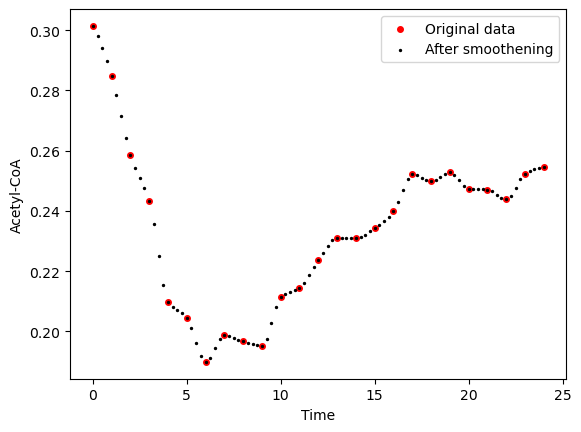

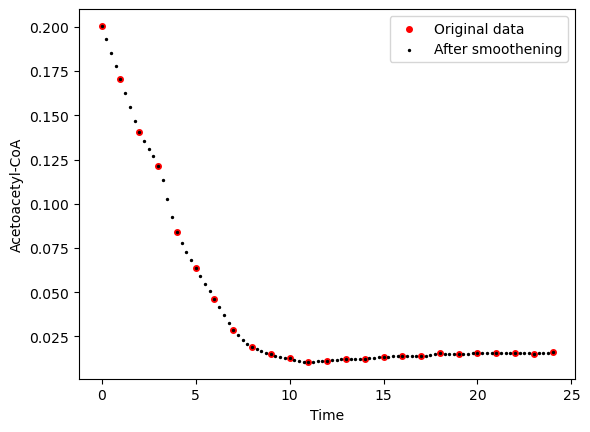

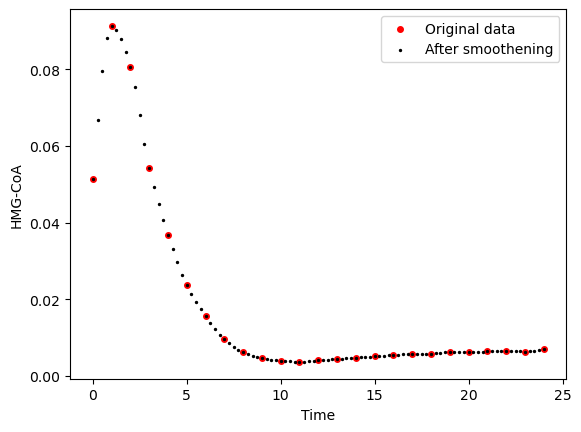

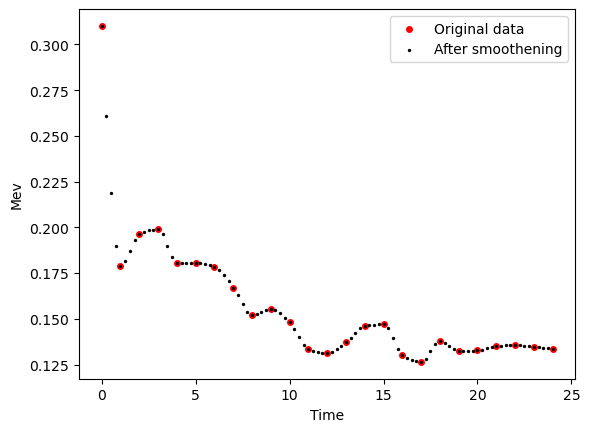

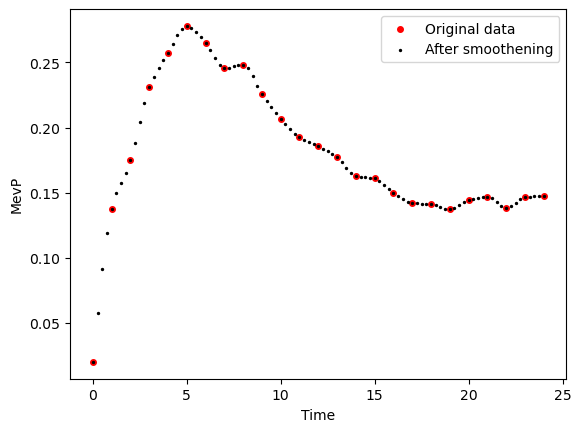

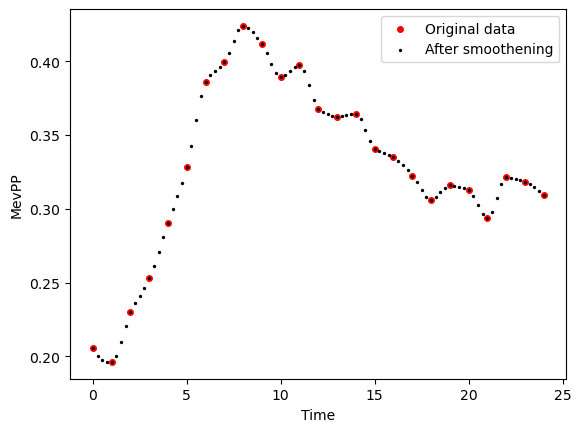

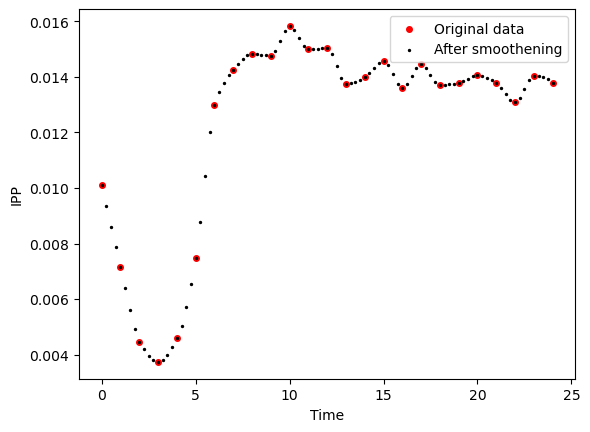

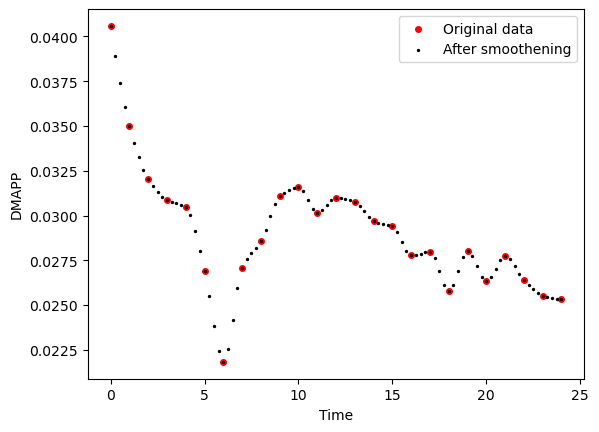

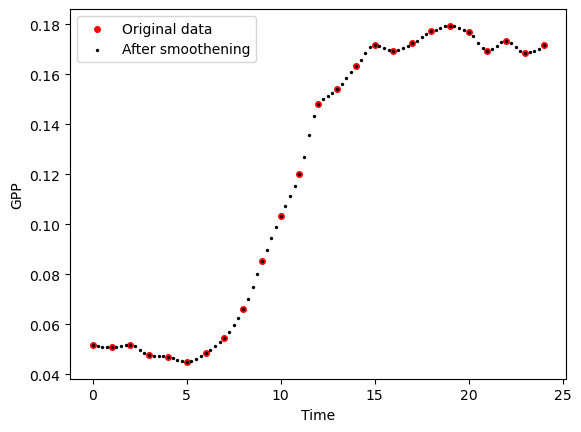

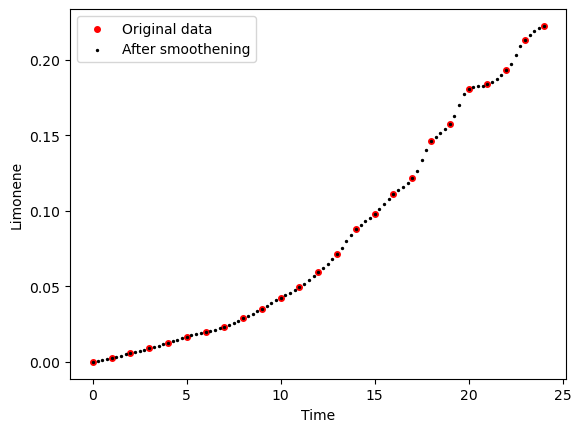

Strain Strain 2


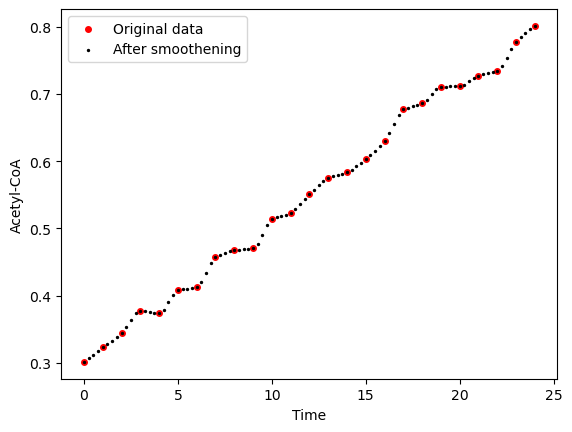

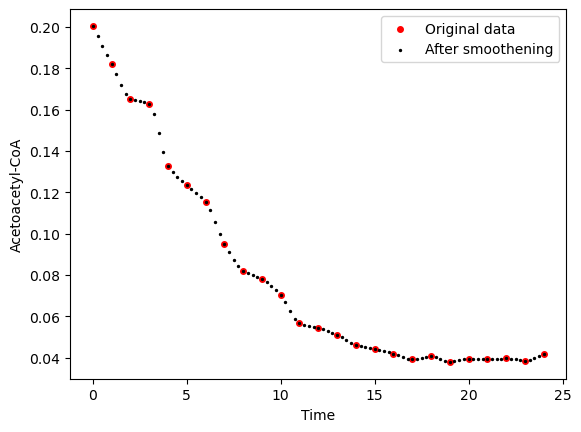

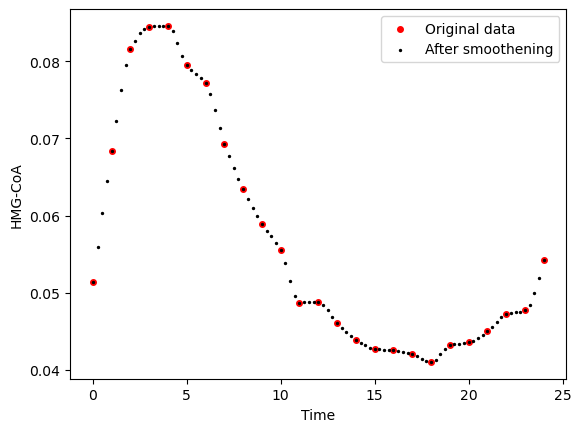

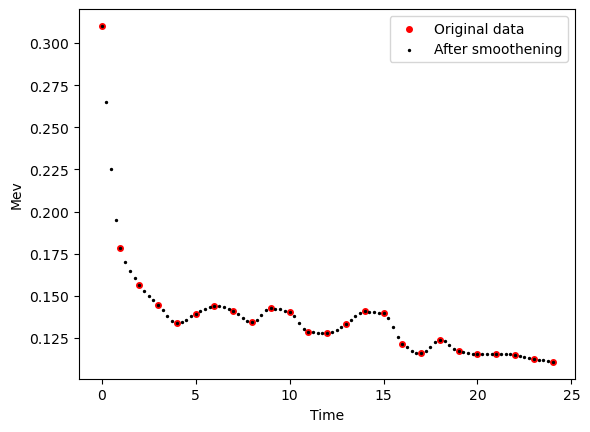

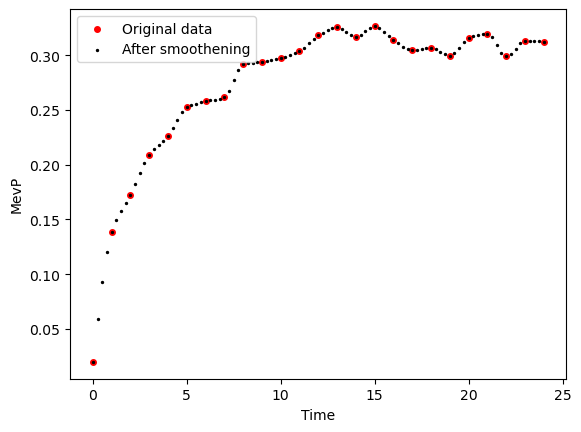

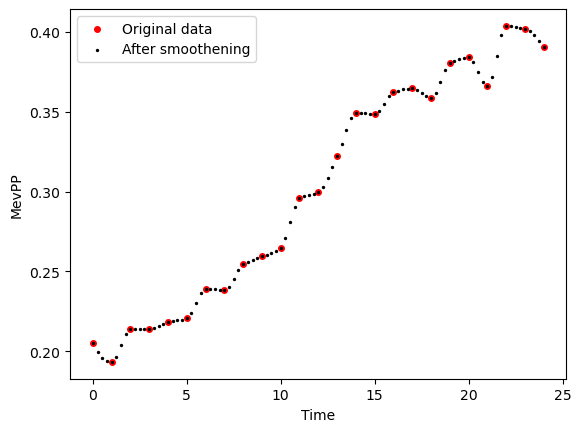

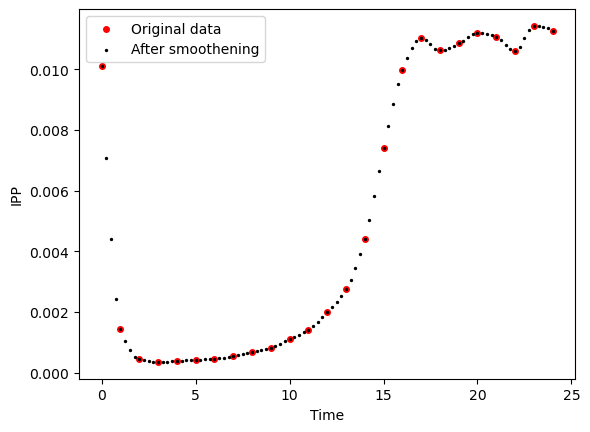

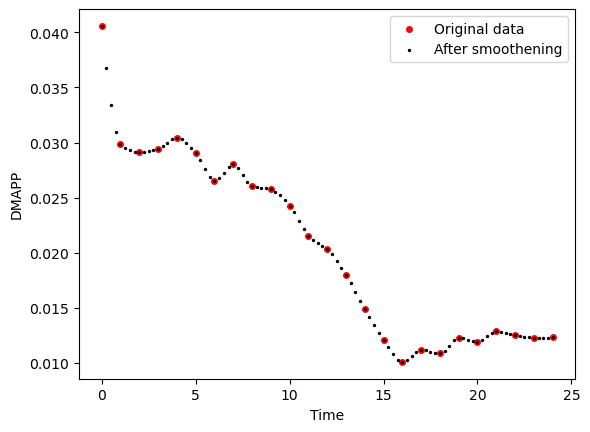

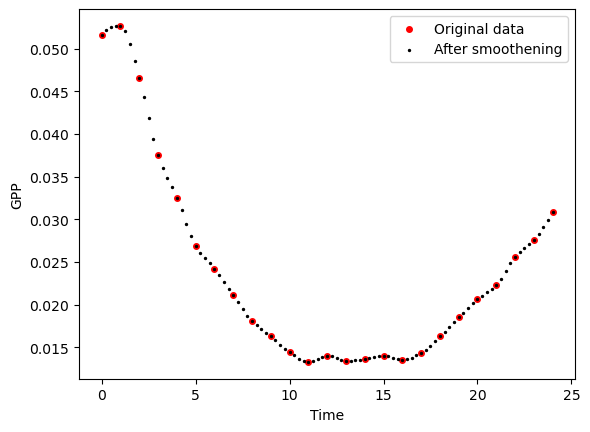

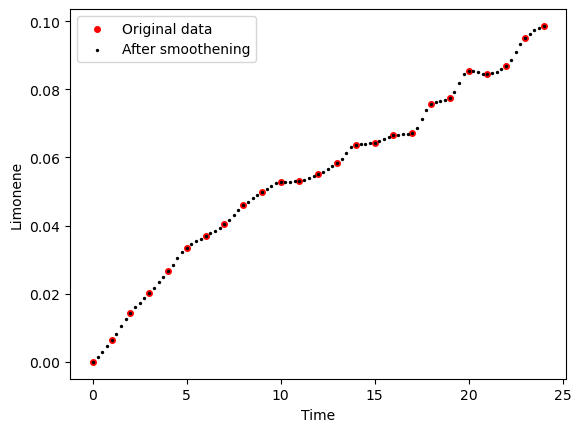

Strain Strain 3


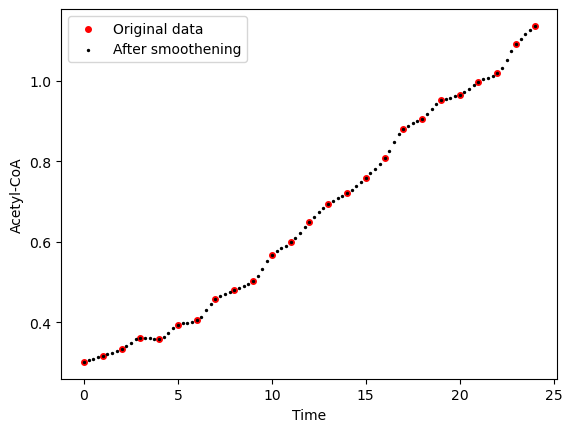

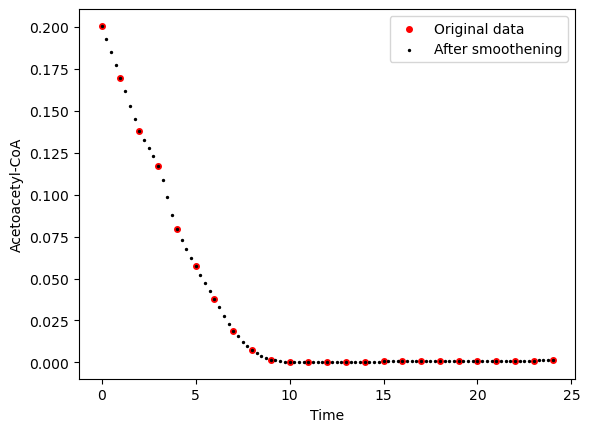

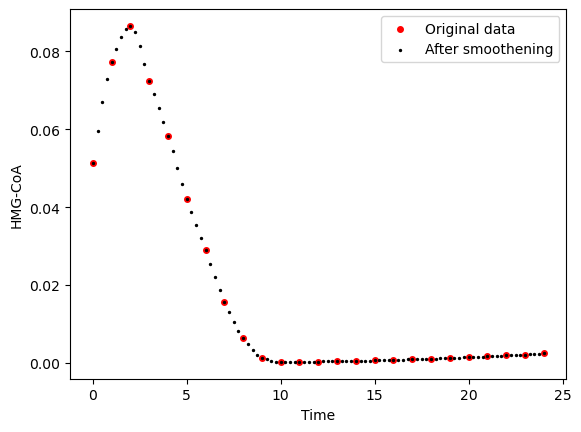

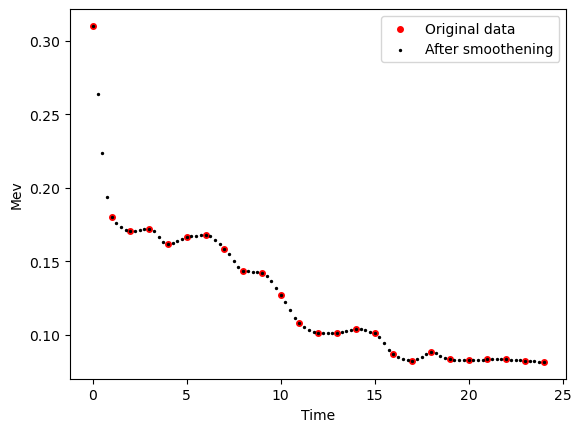

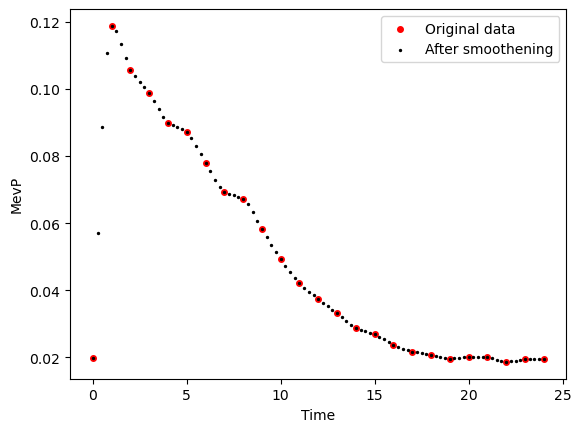

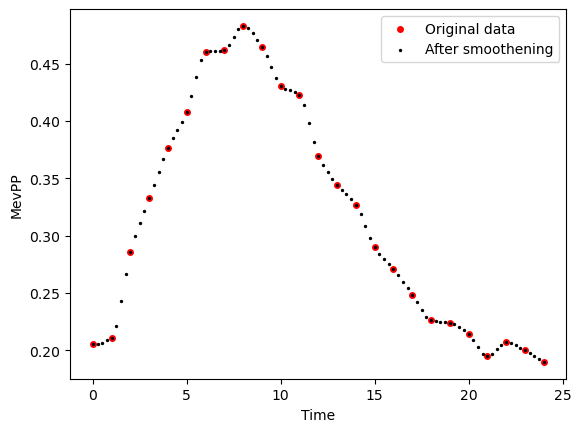

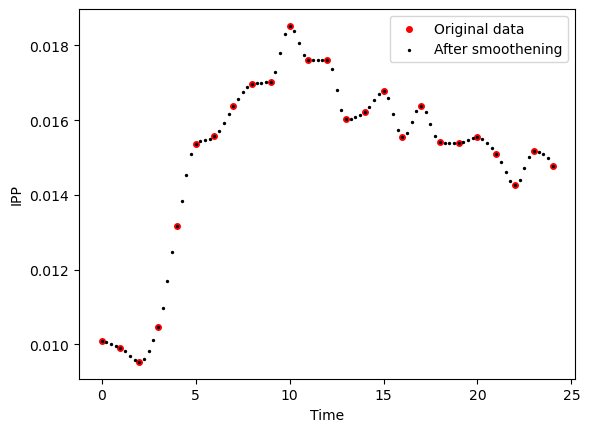

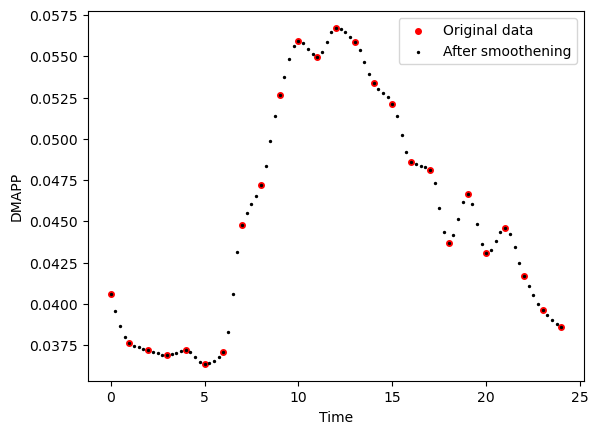

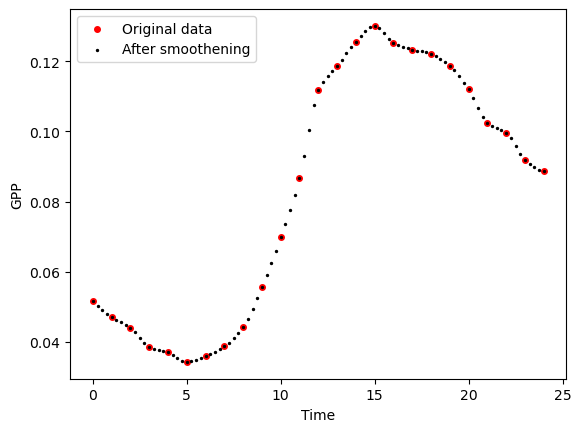

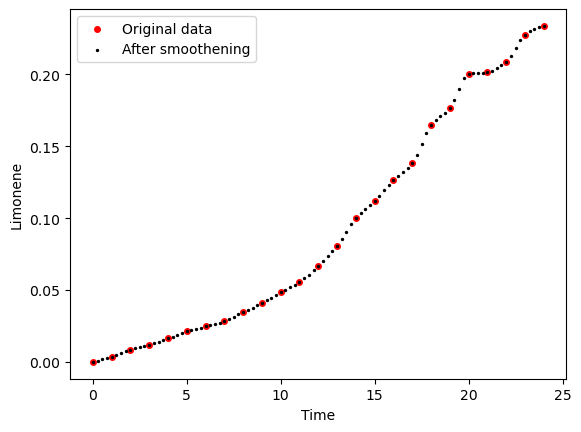

Strain WT


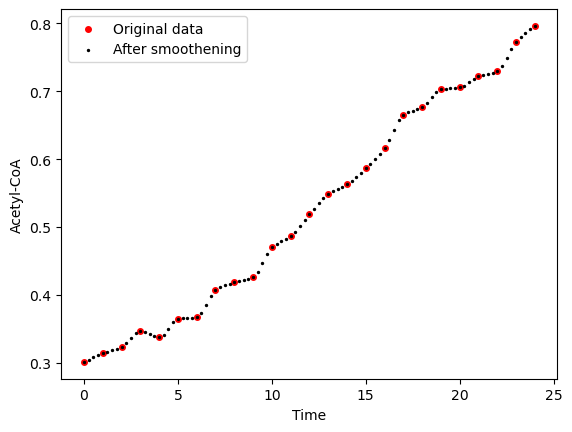

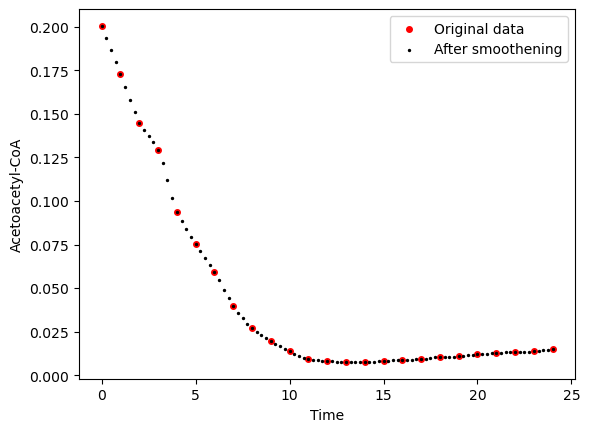

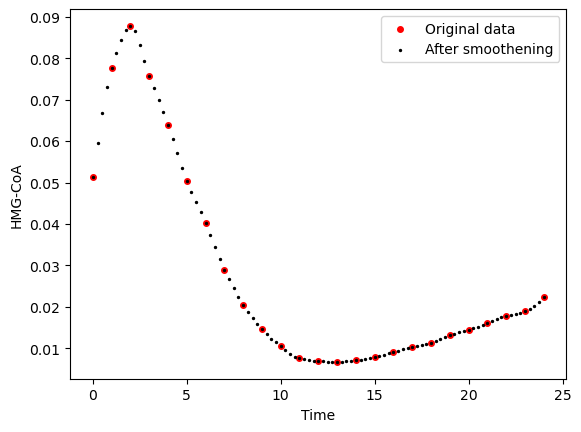

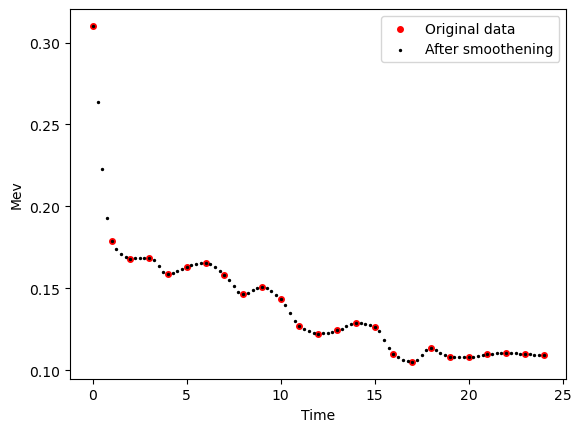

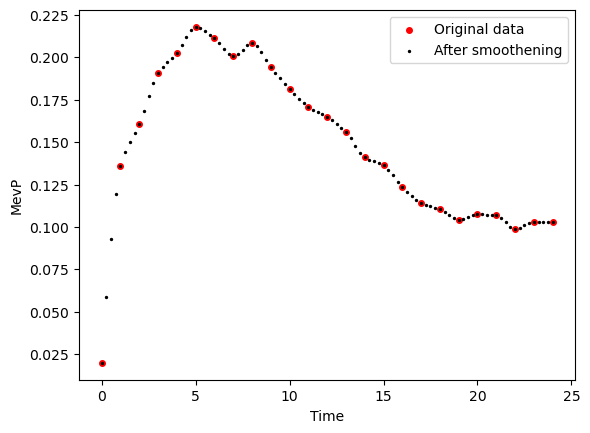

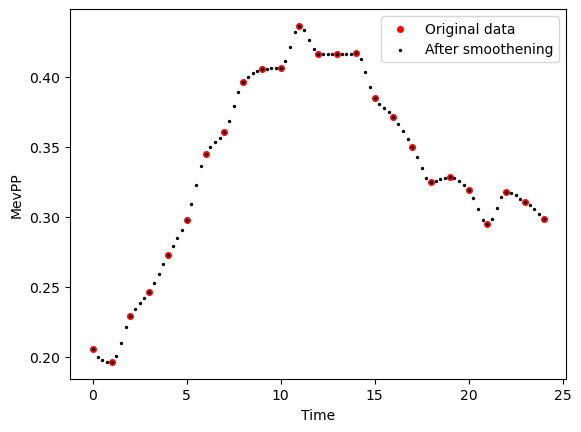

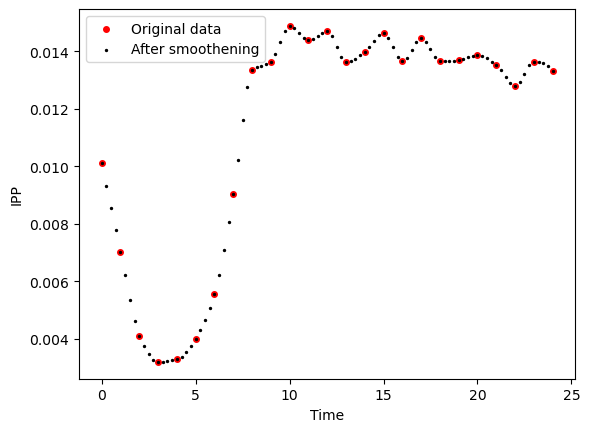

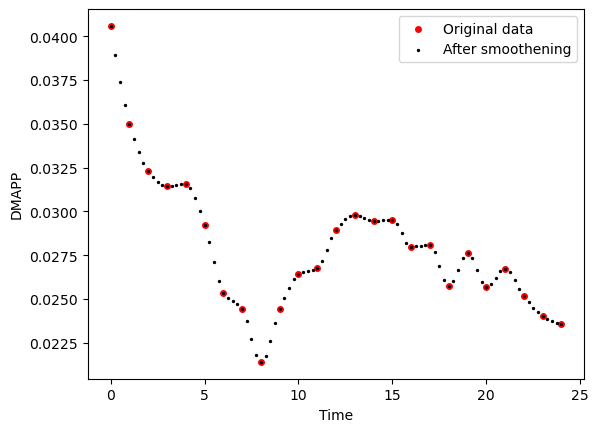

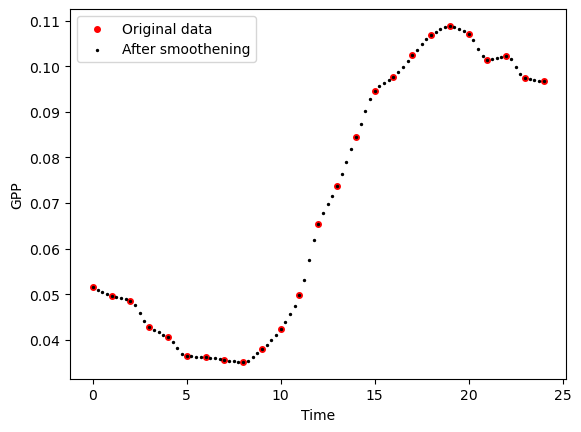

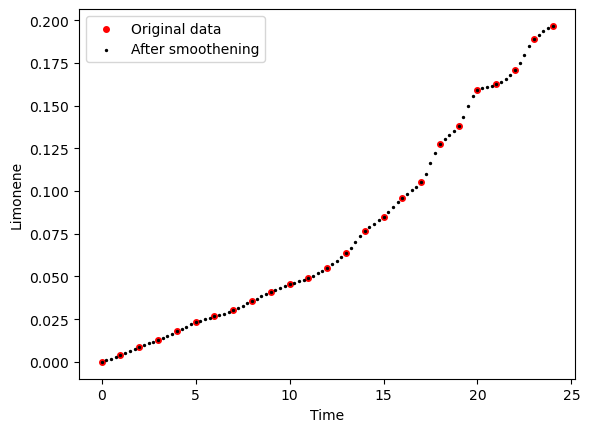

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


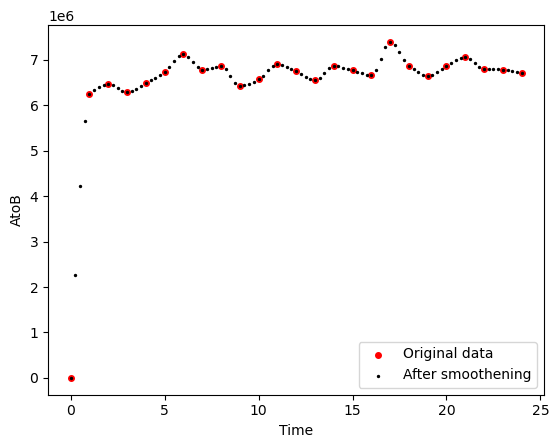

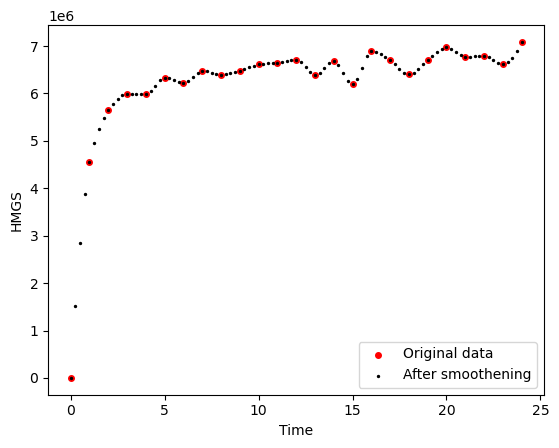

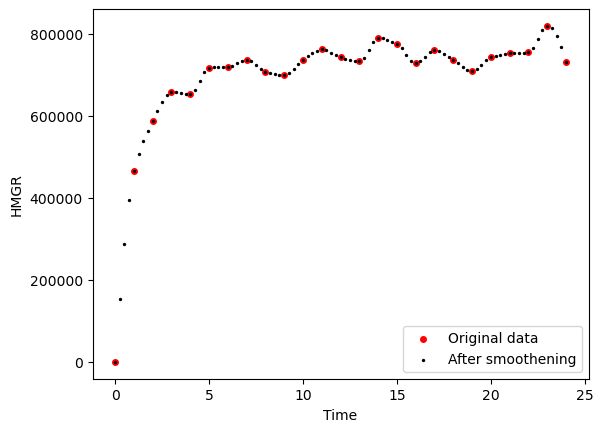

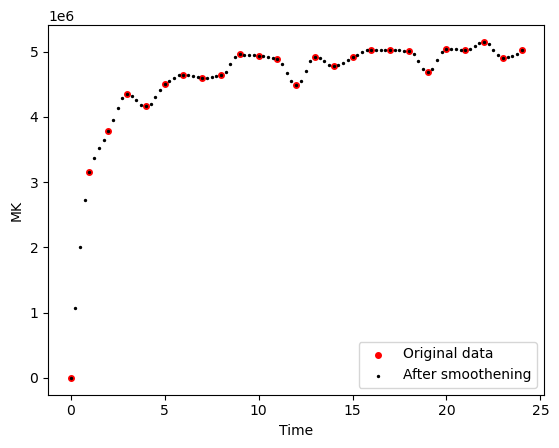

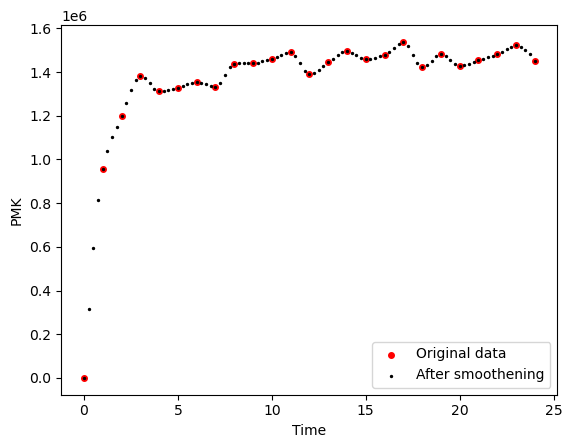

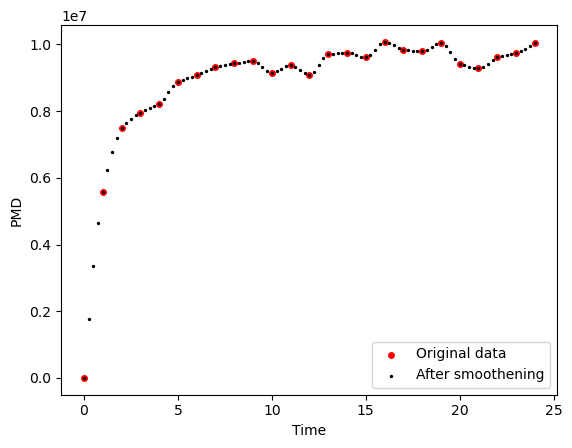

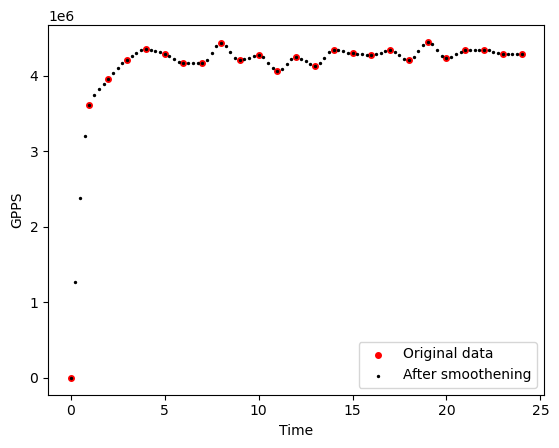

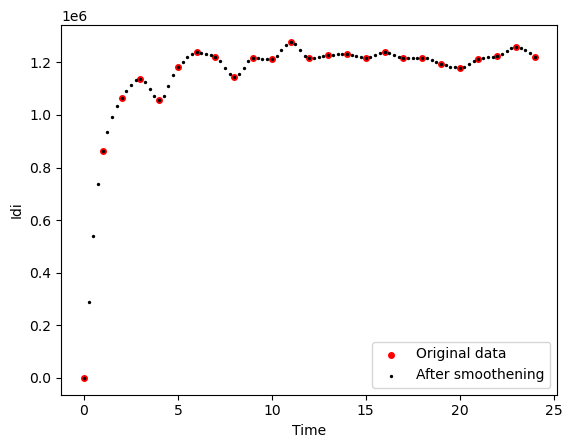

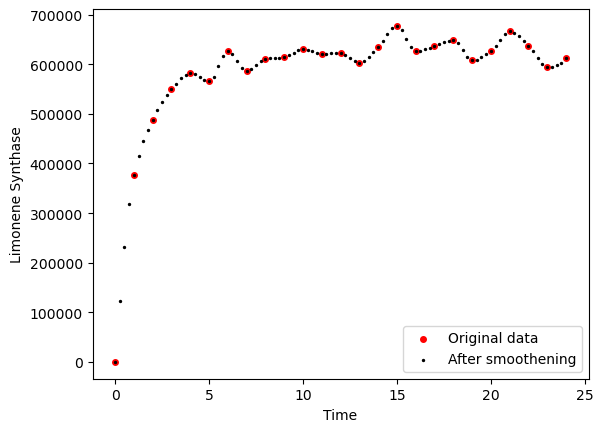

Strain Strain 2


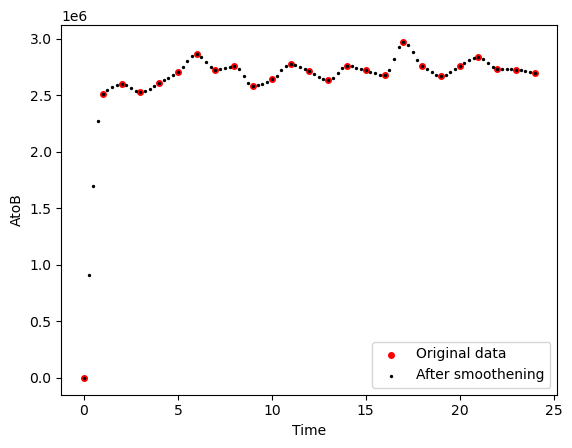

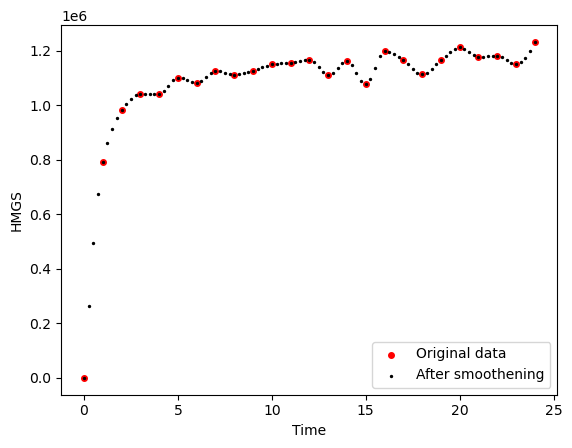

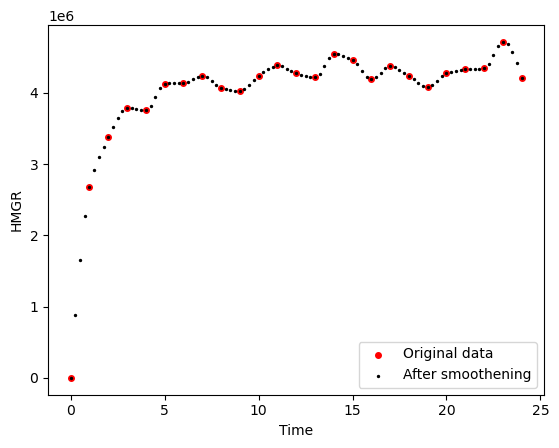

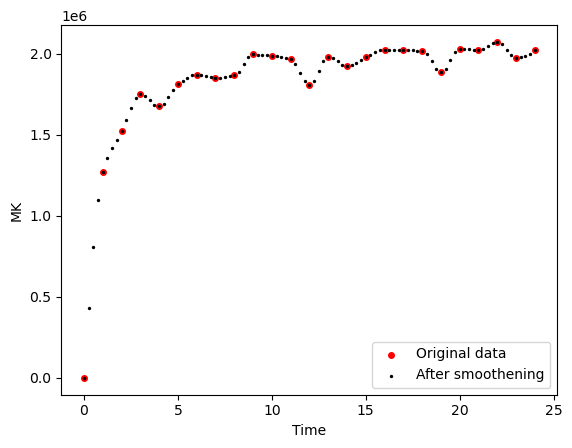

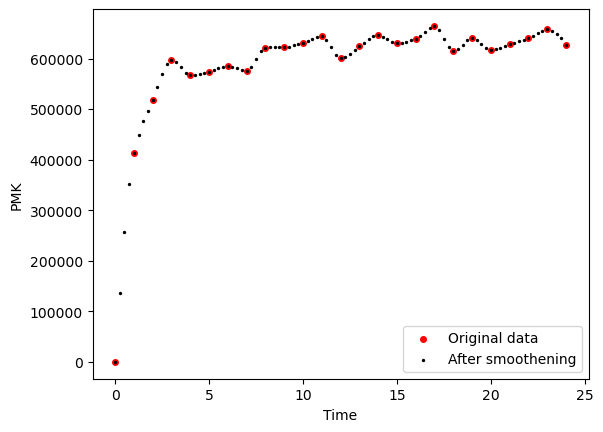

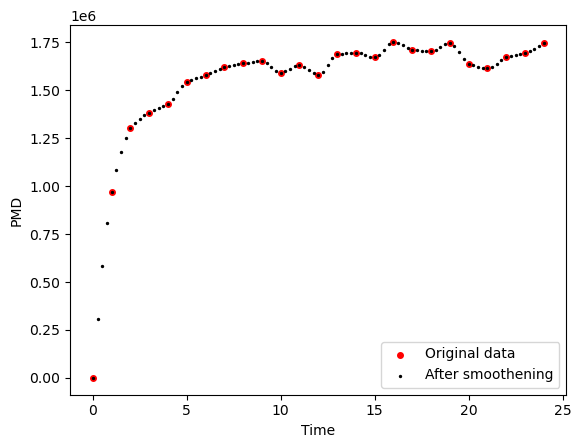

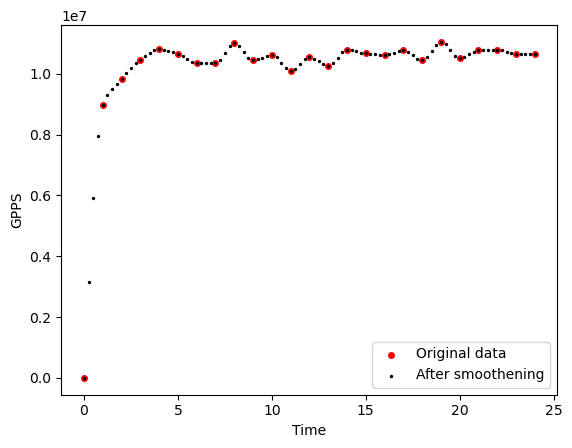

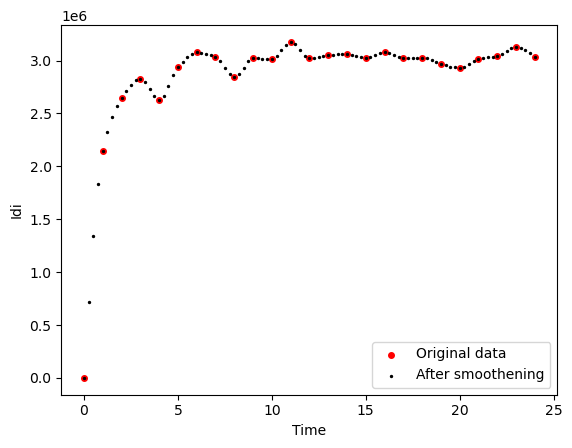

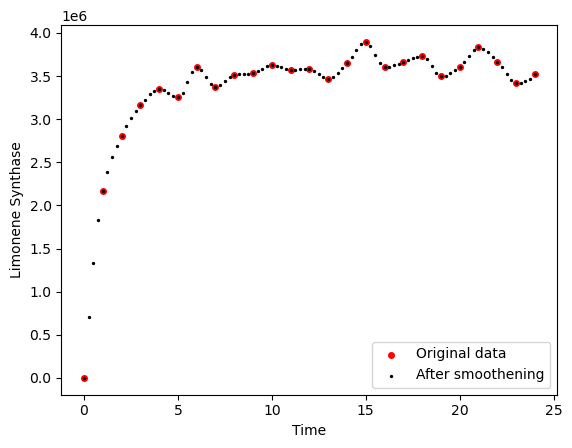

Strain Strain 3


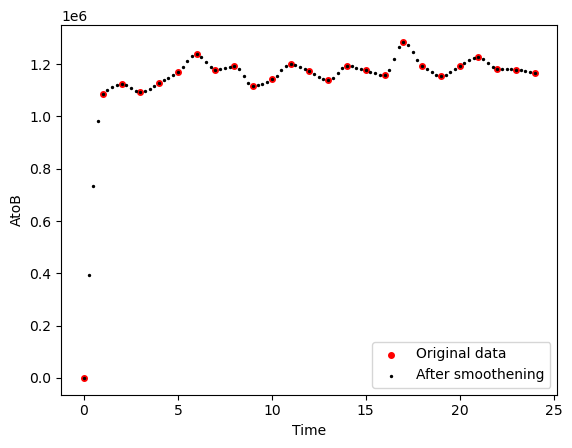

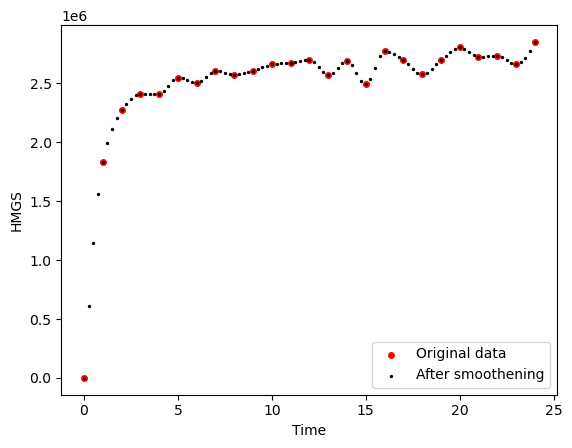

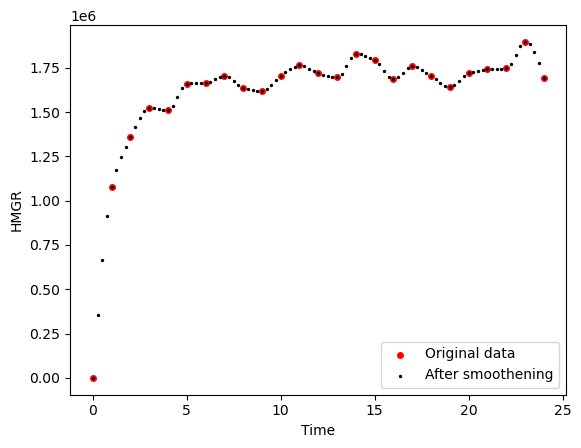

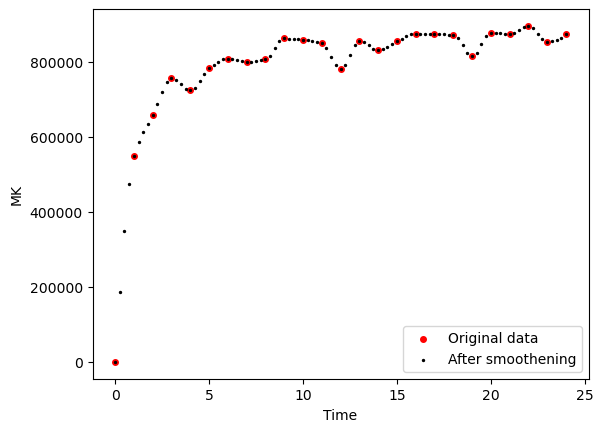

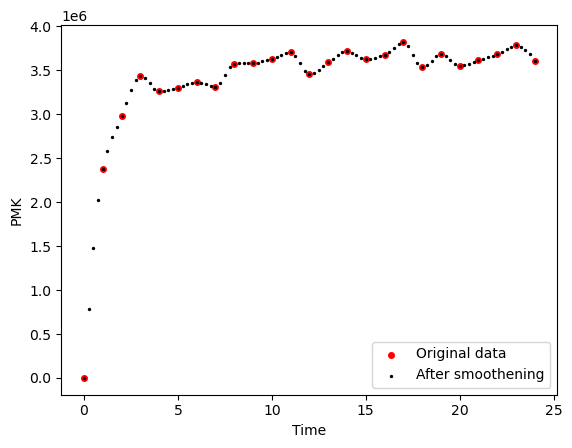

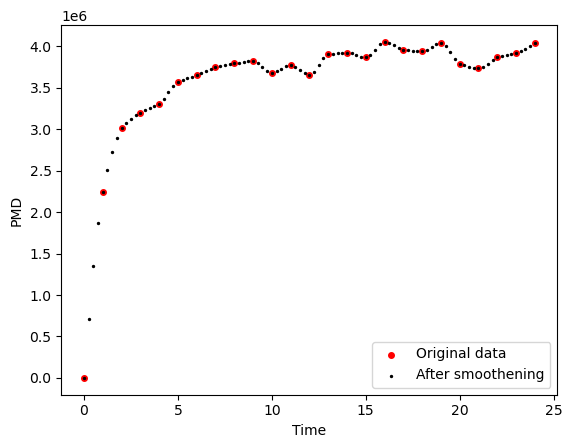

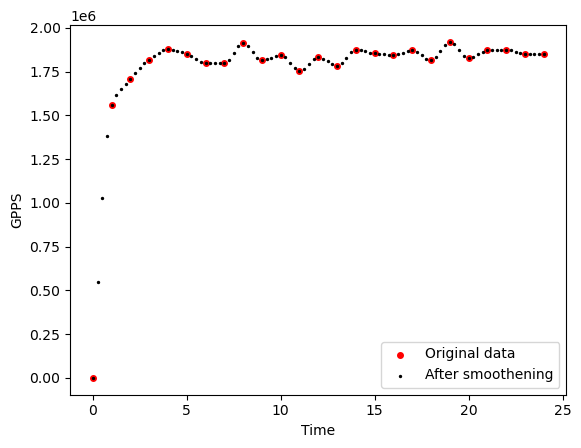

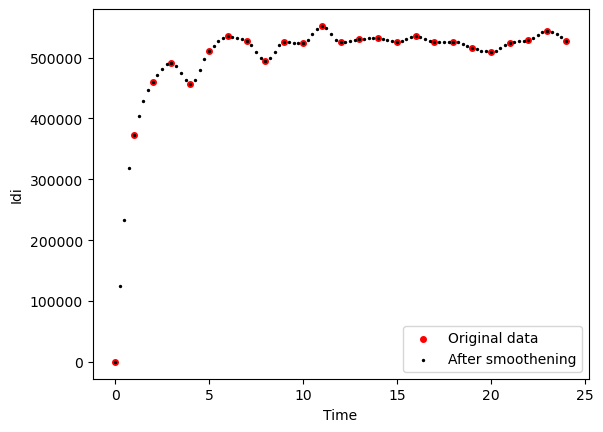

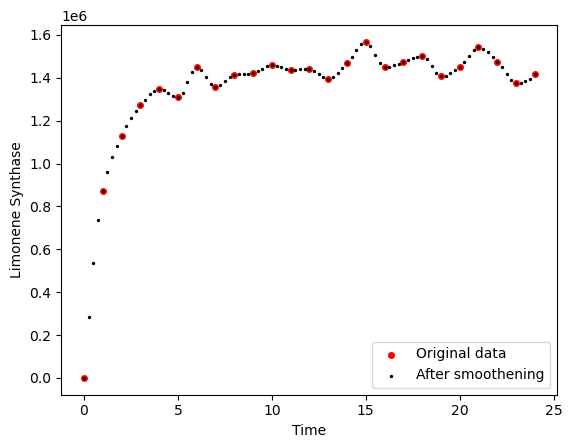

Strain WT


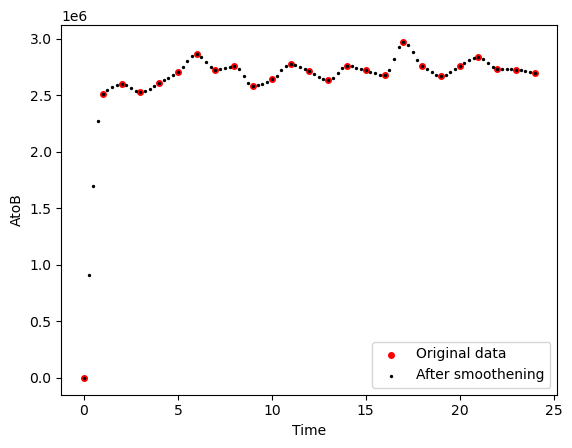

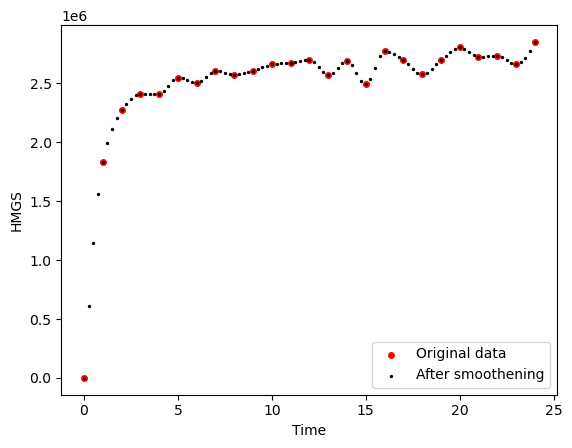

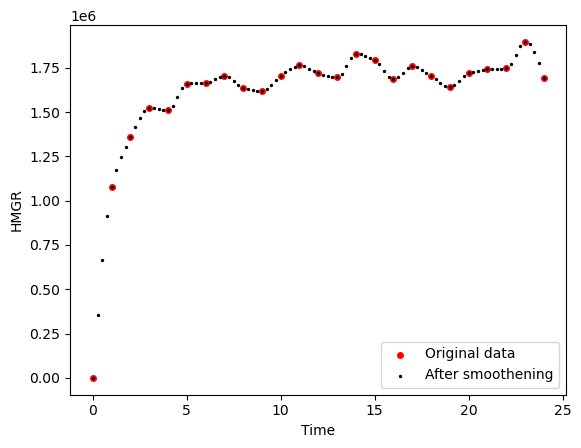

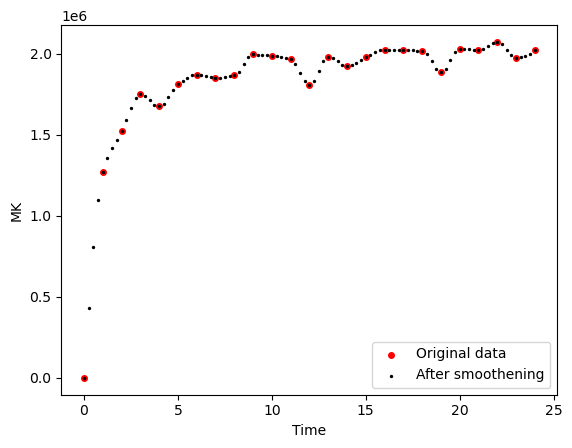

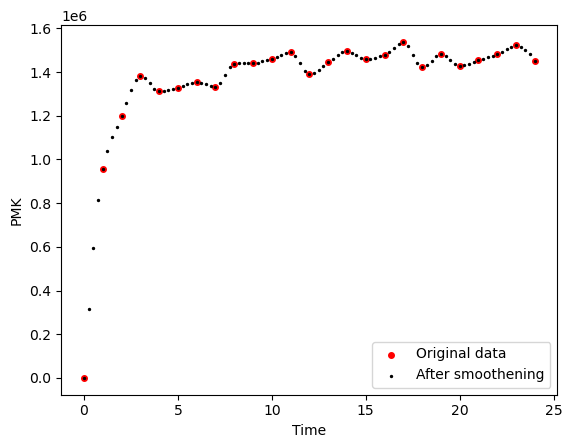

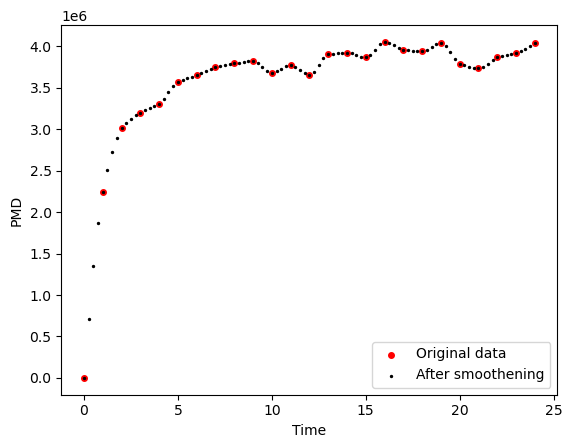

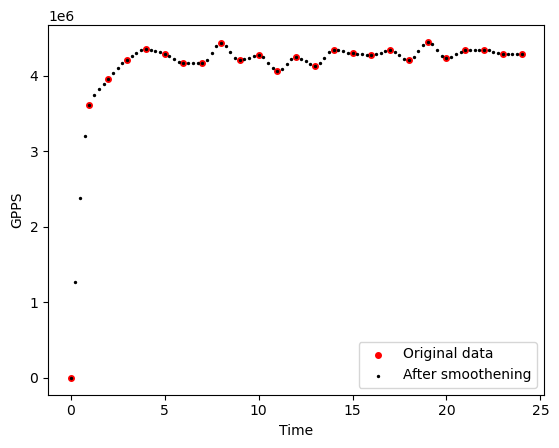

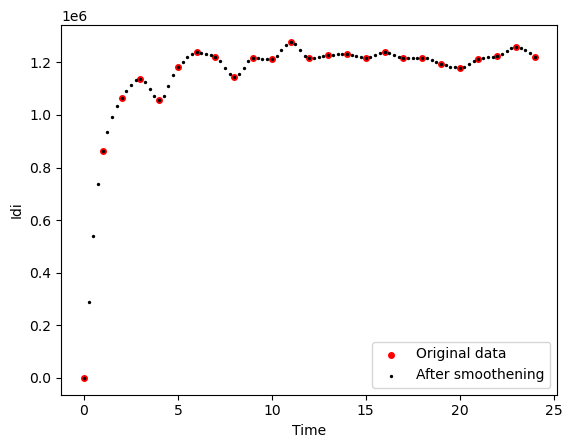

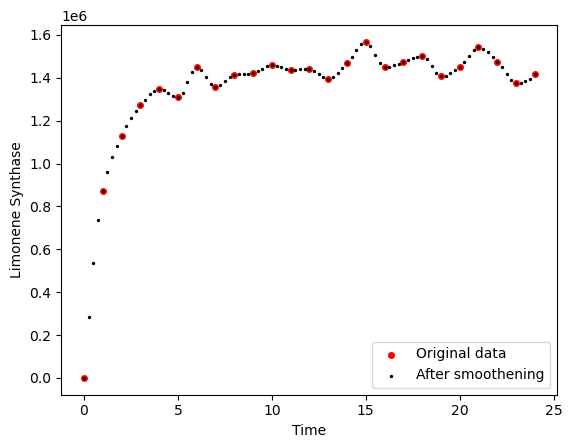

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25    0.298092        0.192997  0.066758  0.260791  0.057820   
         0.50    0.294128        0.185476  0.079487  0.218950  0.091423   
         0.75    0.289633        0.177962  0.088130  0.189938  0.118683   
         1.00    0.284705        0.170455  0.091315  0.179084  0.137638   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.772631        0.013642  0.018896  0.109780  0.103047   
         23.25   0.779961        0.013829  0.019439  0.109649  0.103042   
         23.50   0.786529        0.014208  0.020222  0.109528  0.103007   
         23.75   0.792084        0.014721  0.021189  0.109419  0.102911   
         24.00   0.796371        0.015308  0.022282  0.109323  0.102723   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205338  0.010099  0.040591  0.051599  0.000000  ...   
         0.25   0.200015  0.009342  0.038918  0.051304  0.000548  ...   
         0.50   0.197281  0.008600  0.037399  0.051106  0.001157  ...   
         0.75   0.196274  0.007874  0.036074  0.050994  0.001822  ...   
         1.00   0.196130  0.007163  0.034982  0.050958  0.002534  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.310677  0.013639  0.024031  0.097364  0.188873  ...   
         23.25  0.308238  0.013631  0.023869  0.097137  0.191489  ...   
         23.50  0.305360  0.013590  0.023728  0.096961  0.193781  ...   
         23.75  0.302109  0.013492  0.023619  0.096847  0.195555  ...   
         24.00  0.298553  0.013312  0.023553  0.096807  0.196616  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.012507       -0.030124  0.073237 -0.235823  0.169333   
         0.25    -0.014633       -0.030096  0.056893 -0.184503  0.143960   
         0.50    -0.016759       -0.030069  0.040550 -0.133182  0.118587   
         0.75    -0.019342       -0.030290  0.023607 -0.079300  0.091683   
         1.00    -0.022576       -0.030802  0.007580 -0.028702  0.065305   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.036967        0.000615  0.001862 -0.000646  0.001879   
         23.25    0.029386        0.001132  0.002628 -0.000534  0.000391   
         23.50    0.023841        0.001690  0.003408 -0.000457 -0.000312   
         23.75    0.019785        0.002223  0.004142 -0.000410 -0.000556   
         24.00    0.015730        0.002756  0.004876 -0.000363 -0.000799   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.022673 -0.003059 -0.007172 -0.001328  0.002098  
         0.25  -0.015767 -0.002997 -0.006398 -0.000982  0.002317  
         0.50  -0.008862 -0.002936 -0.005624 -0.000636  0.002537  
         0.75  -0.000390 -0.002928 -0.004852 -0.000230  0.002787  
         1.00   0.011326 -0.002983 -0.004128  0.000259  0.003080  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009789  0.000352 -0.000773 -0.002792  0.013688  
         23.25 -0.010832 -0.000031 -0.000617 -0.001288  0.010364  
         23.50 -0.012151 -0.000317 -0.000482 -0.000561  0.007820  
         23.75 -0.013639 -0.000546 -0.000354 -0.000312  0.005748  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

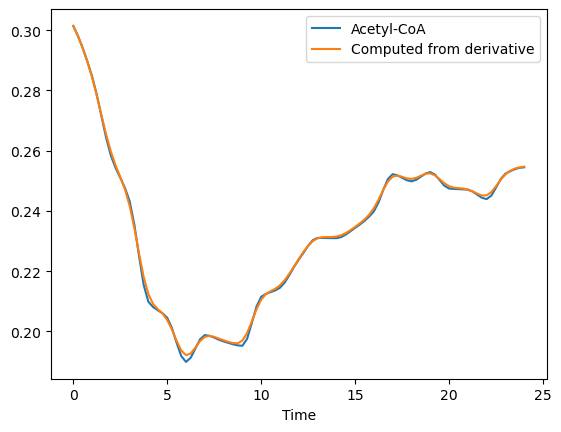

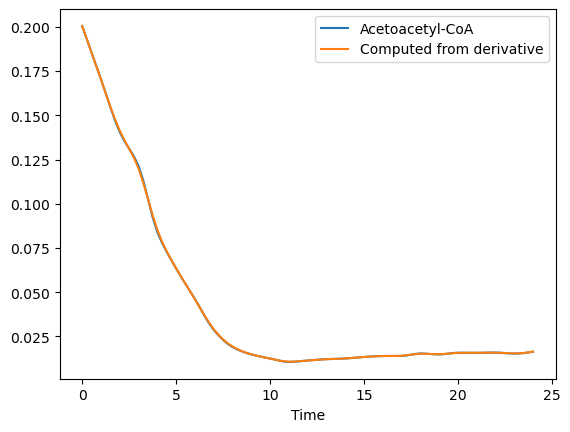

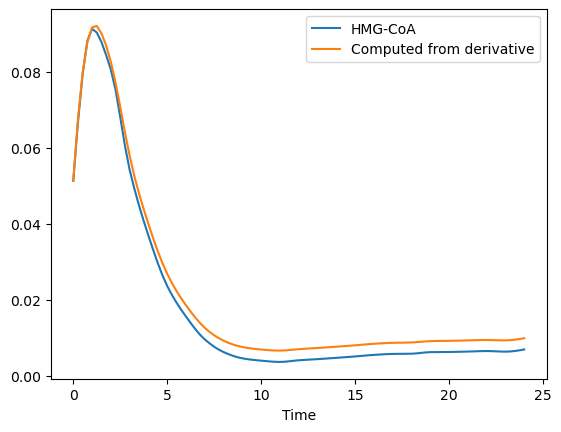

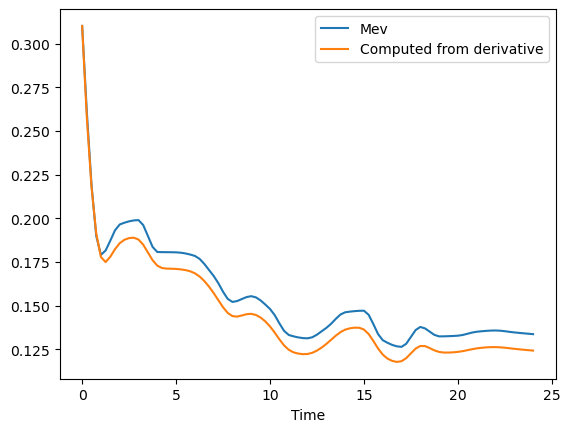

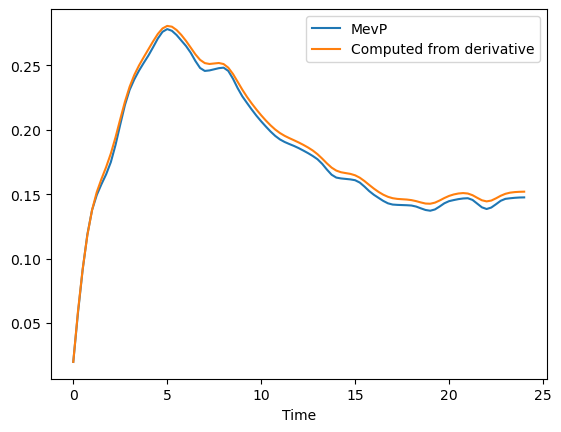

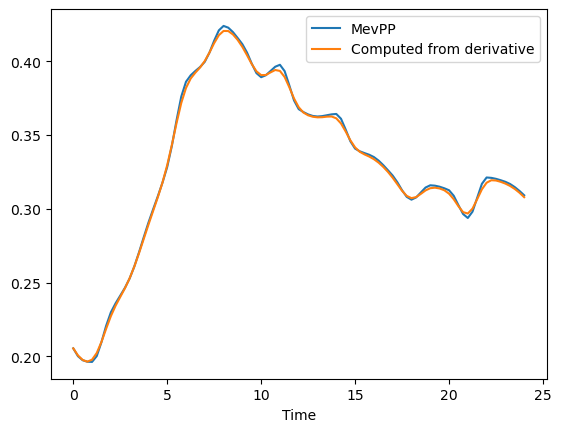

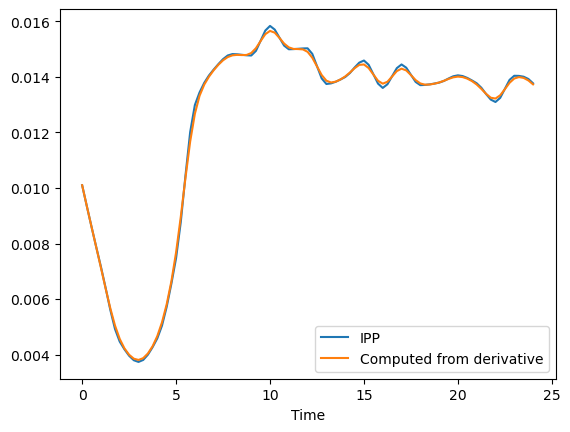

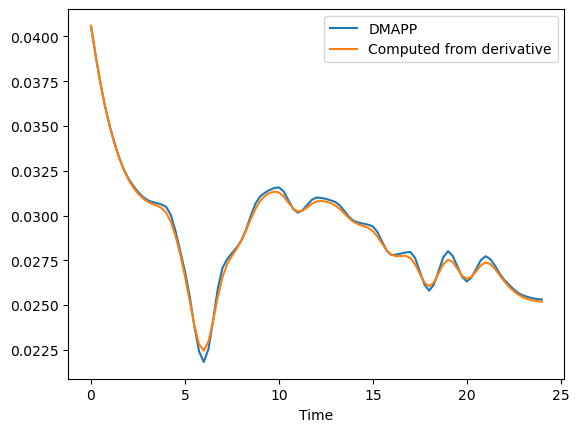

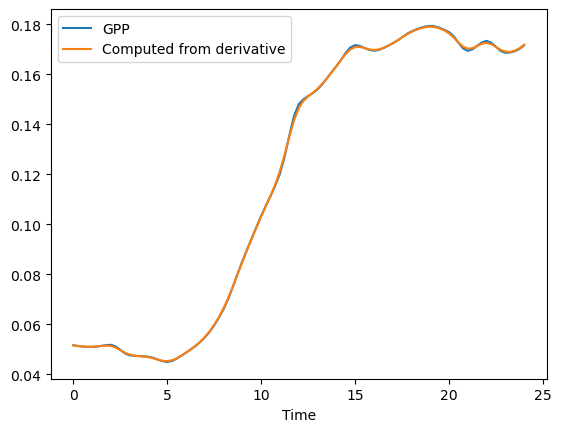

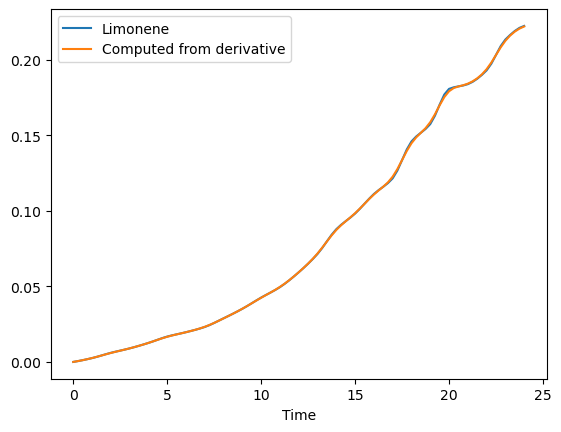

'Time profile from derivative vs. actual profile for Strain 2'

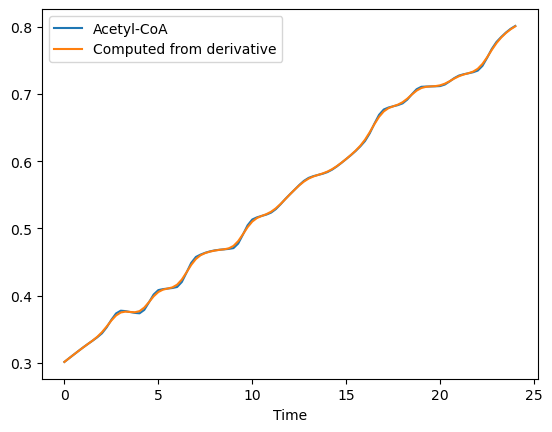

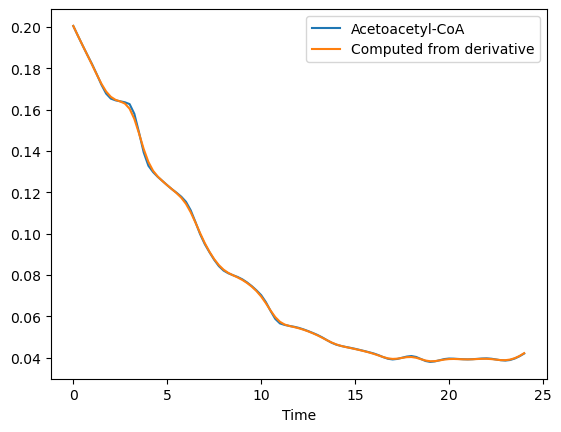

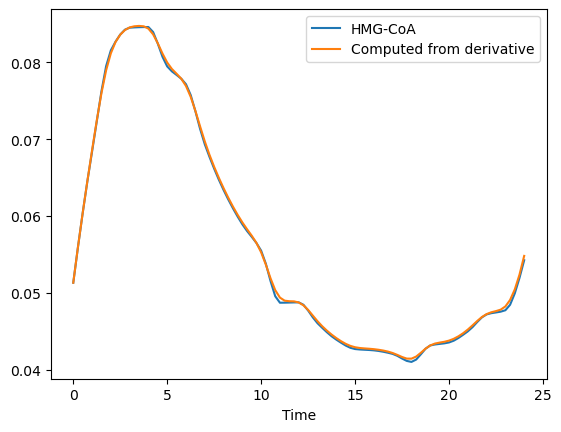

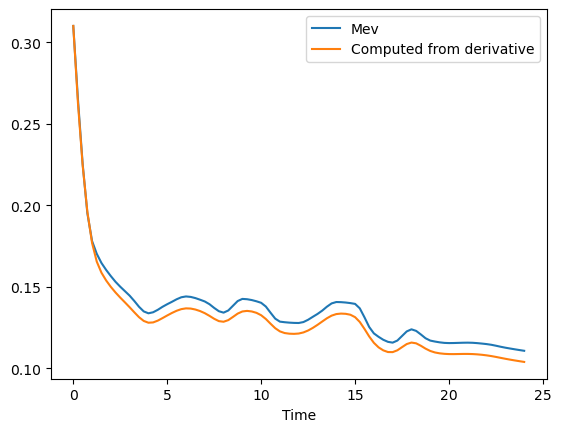

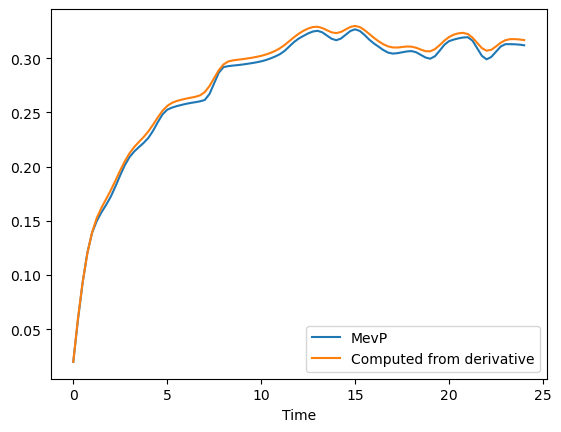

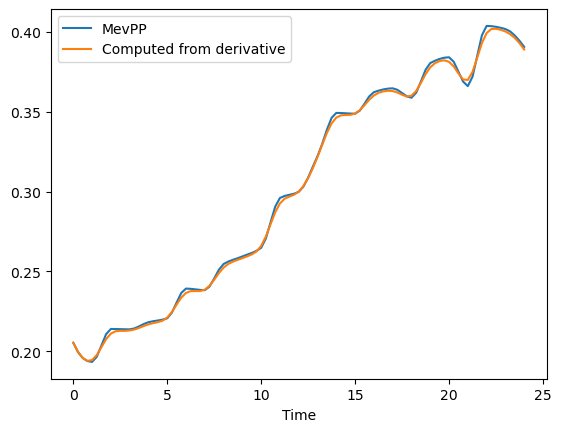

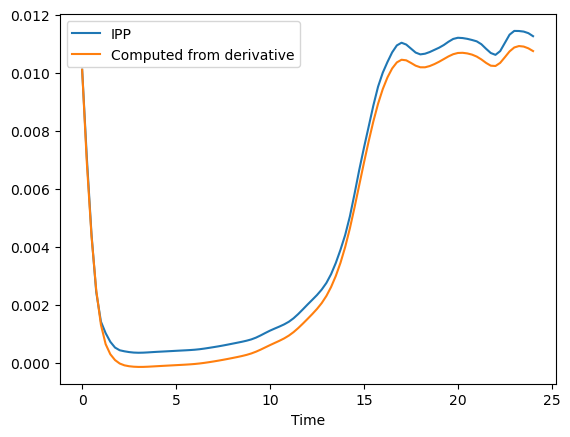

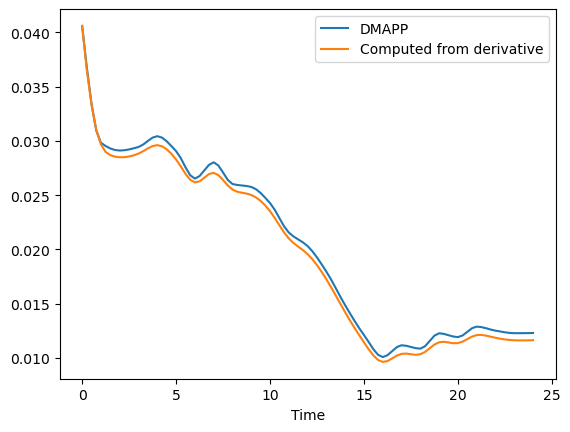

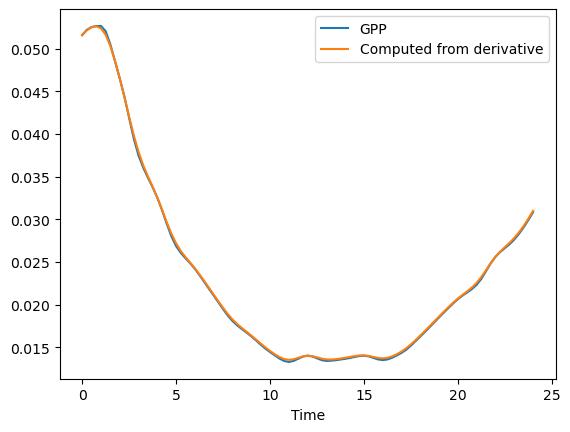

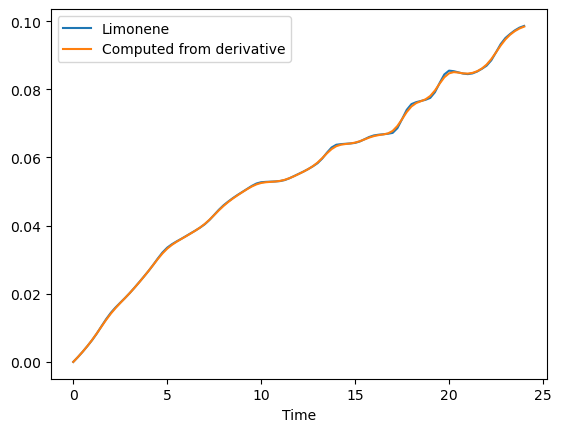

'Time profile from derivative vs. actual profile for Strain 3'

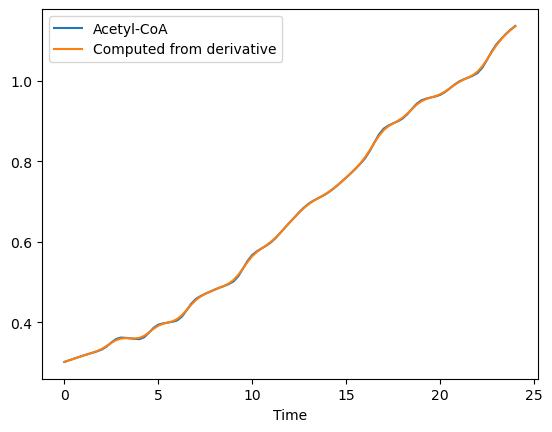

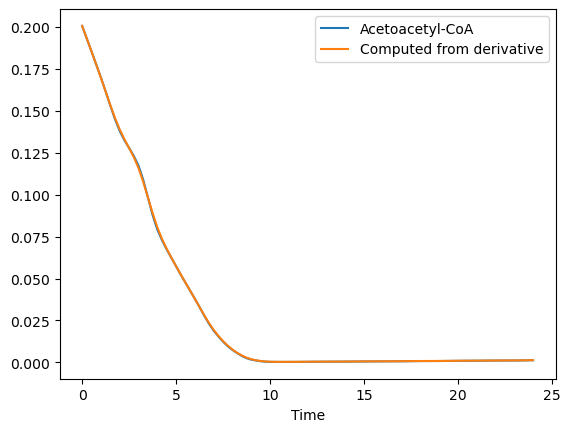

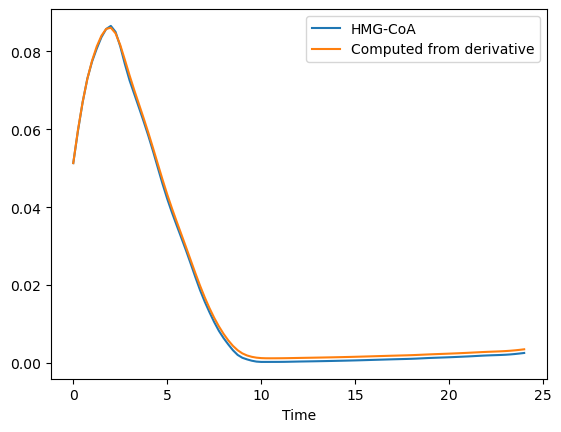

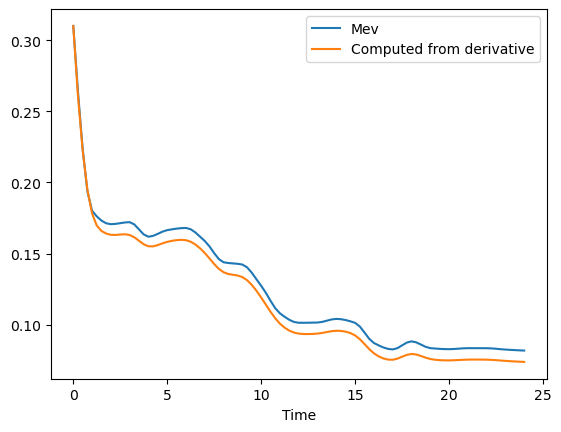

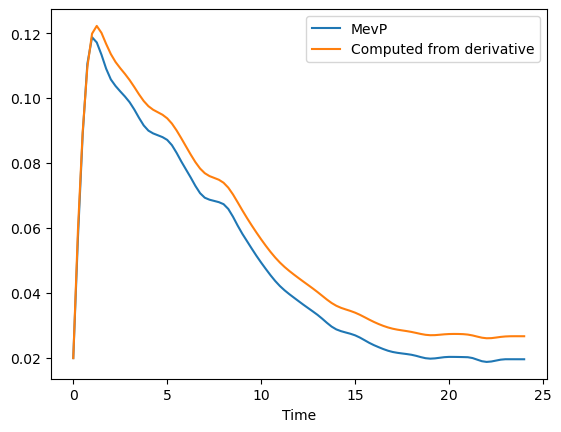

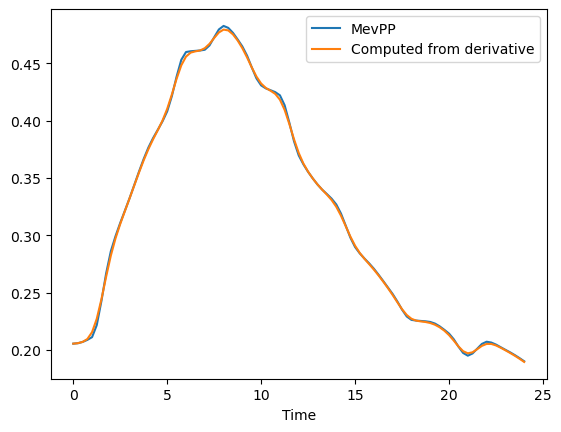

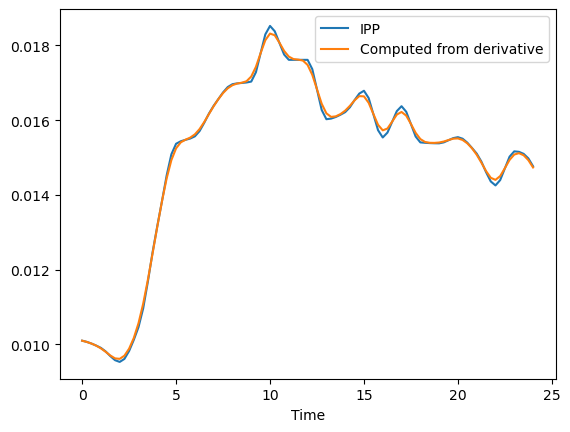

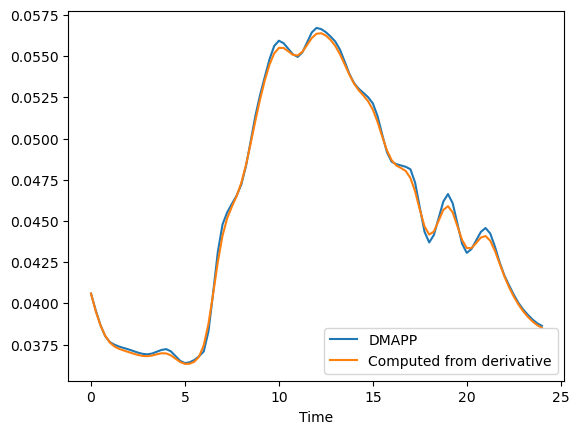

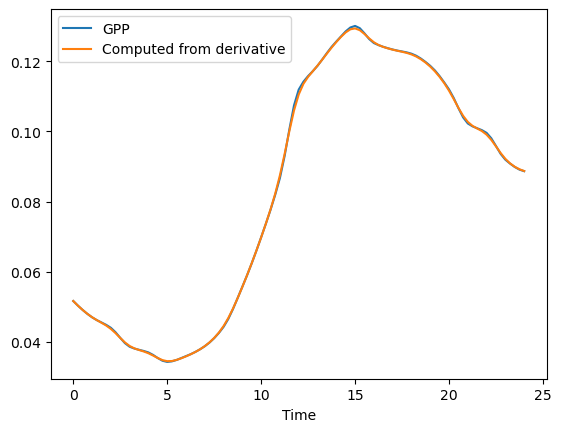

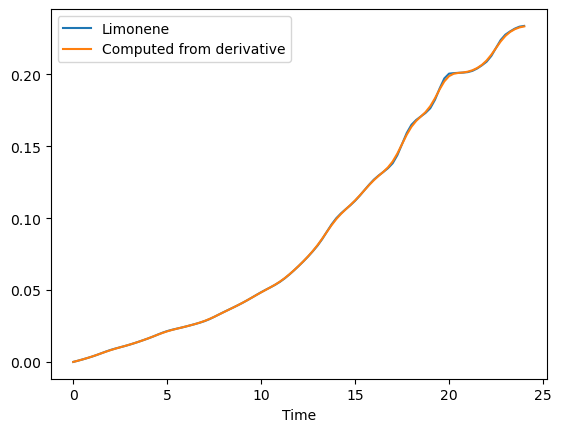

'Time profile from derivative vs. actual profile for WT'

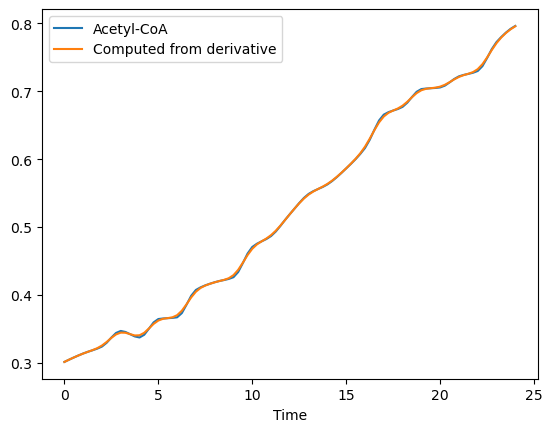

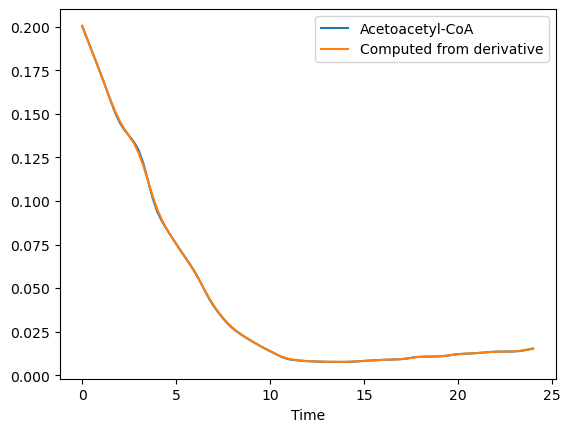

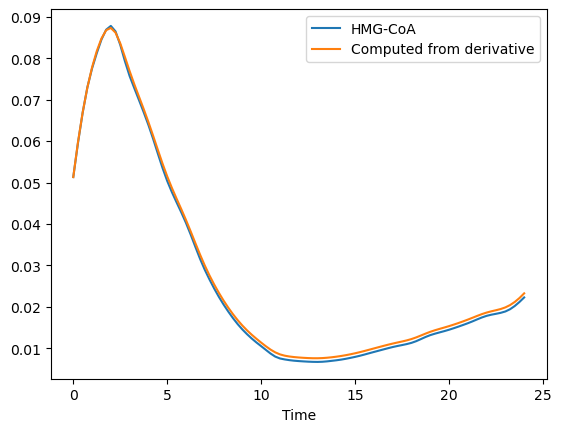

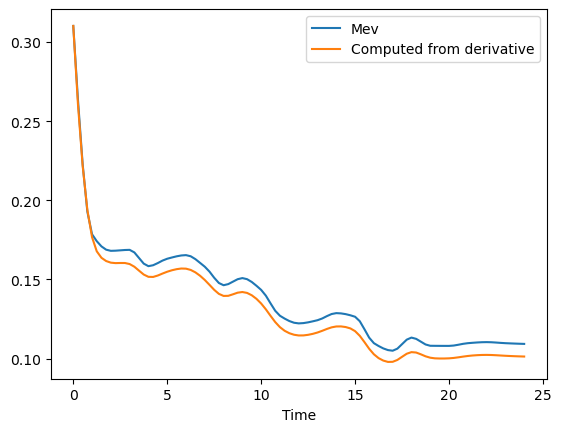

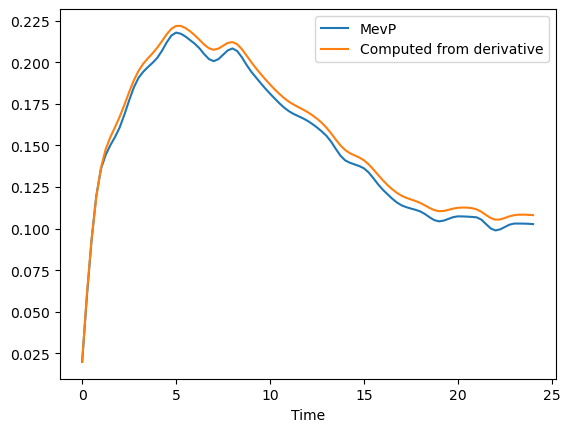

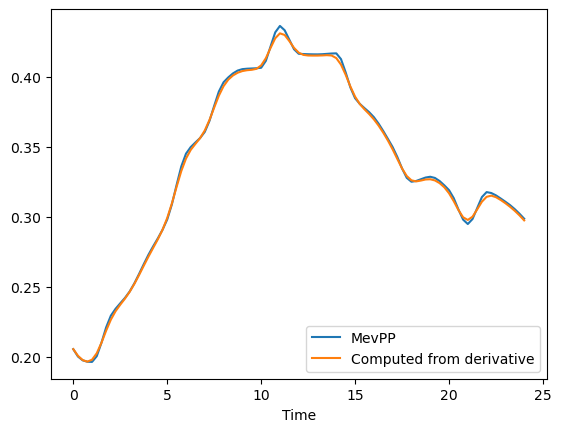

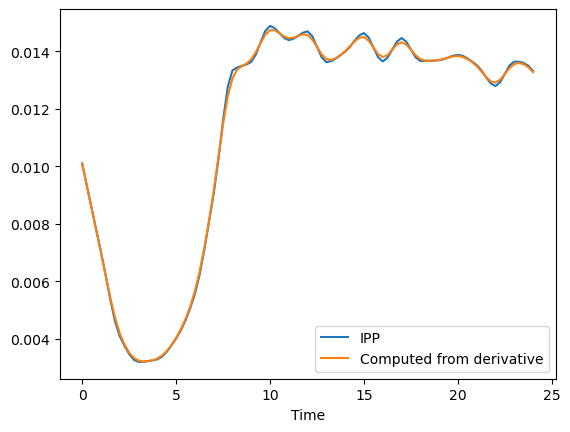

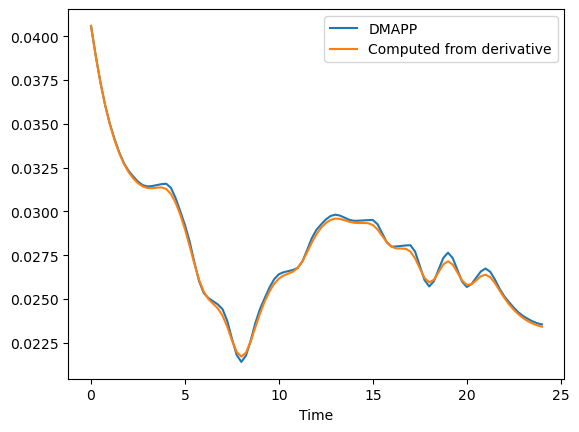

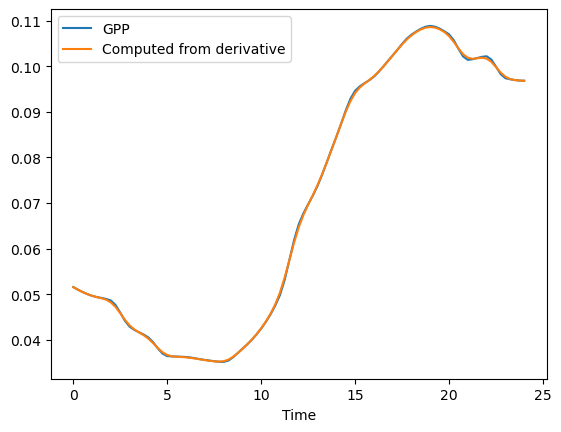

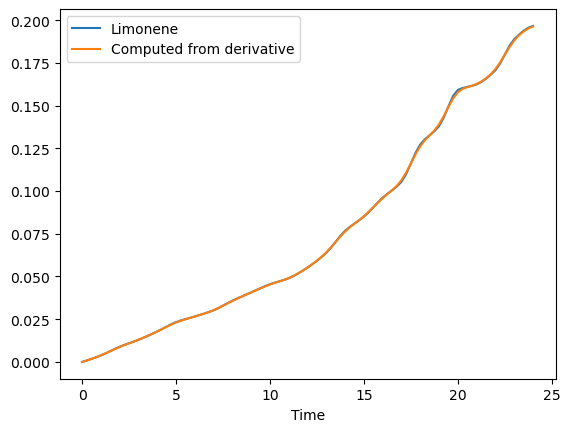

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.975196e+01  3.983424e+01  3.794074e+01  5.956960e+01   
         0.25   2.260793e+06  1.512849e+06  1.528028e+05  1.066883e+06   
         0.50   4.232313e+06  2.842459e+06  2.873142e+05  2.001896e+06   
         0.75   5.650090e+06  3.889380e+06  3.942292e+05  2.725650e+06   
         1.00   6.249594e+06  4.554122e+06  4.642054e+05  3.158696e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.727123e+06  2.662943e+06  1.895038e+06  1.974409e+06   
         23.25  2.722511e+06  2.677428e+06  1.880943e+06  1.976393e+06   
         23.50  2.715553e+06  2.717246e+06  1.840388e+06  1.983829e+06   
         23.75  2.706834e+06  2.776943e+06  1.775972e+06  1.998946e+06   
         24.00  2.696941e+06  2.851061e+06  1.690293e+06  2.023971e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         0.25   3.169704e+05  1.773546e+06  1.268519e+06  2.868532e+05   
         0.50   5.957731e+05  3.347070e+06  2.375516e+06  5.388678e+05   
         0.75   8.163042e+05  4.637457e+06  3.195824e+06  7.369350e+05   
         1.00   9.584337e+05  5.561536e+06  3.604216e+06  8.619272e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.522002e+06  3.918335e+06  4.286466e+06  1.258456e+06   
         23.25  1.517000e+06  3.939823e+06  4.286508e+06  1.255964e+06   
         23.50  1.502872e+06  3.968164e+06  4.286804e+06  1.248628e+06   
         23.75  1.480940e+06  4.001942e+06  4.287607e+06  1.236661e+06   
         24.00  1.452524e+06  4.039740e+06  4.289171e+06  1.220274e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.131118e+01   0.301424        0.200524  0.051314   
         0.25       1.228611e+05   0.298092        0.192997  0.066758   
         0.50       2.312871e+05   0.294128        0.185476  0.079487   
         0.75       3.184636e+05   0.289633        0.177962  0.088130   
         1.00       3.775454e+05   0.284705        0.170455  0.091315   
...                          ...        ...             ...       ...   
WT       23.00      1.376270e+06   0.772631        0.013642  0.018896   
         23.25      1.377411e+06   0.779961        0.013829  0.019439   
         23.50      1.382656e+06   0.786529        0.014208  0.020222   
         23.75      1.394741e+06   0.792084        0.014721  0.021189   
         24.00      1.416401e+06   0.796371        0.015308  0.022282   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.310136  0.019836  0.205338  0.010099  0.040591  0.051599   
         0.25   0.260791  0.057820  0.200015  0.009342  0.038918  0.051304   
         0.50   0.218950  0.091423  0.197281  0.008600  0.037399  0.051106   
         0.75   0.189938  0.118683  0.196274  0.007874  0.036074  0.050994   
         1.00   0.179084  0.137638  0.196130  0.007163  0.034982  0.050958   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.109780  0.103047  0.310677  0.013639  0.024031  0.097364   
         23.25  0.109649  0.103042  0.308238  0.013631  0.023869  0.097137   
         23.50  0.109528  0.103007  0.305360  0.013590  0.023728 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.012507       -0.030124  0.073237 -0.235823  0.169333   
         0.25    -0.014633       -0.030096  0.056893 -0.184503  0.143960   
         0.50    -0.016759       -0.030069  0.040550 -0.133182  0.118587   
         0.75    -0.019342       -0.030290  0.023607 -0.079300  0.091683   
         1.00    -0.022576       -0.030802  0.007580 -0.028702  0.065305   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.036967        0.000615  0.001862 -0.000646  0.001879   
         23.25    0.029386        0.001132  0.002628 -0.000534  0.000391   
         23.50    0.023841        0.001690  0.003408 -0.000457 -0.000312   
         23.75    0.019785        0.002223  0.004142 -0.000410 -0.000556   
         24.00    0.015730        0.002756  0.004876 -0.000363 -0.000799   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.022673 -0.003059 -0.007172 -0.001328  0.002098  
         0.25  -0.015767 -0.002997 -0.006398 -0.000982  0.002317  
         0.50  -0.008862 -0.002936 -0.005624 -0.000636  0.002537  
         0.75  -0.000390 -0.002928 -0.004852 -0.000230  0.002787  
         1.00   0.011326 -0.002983 -0.004128  0.000259  0.003080  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009789  0.000352 -0.000773 -0.002792  0.013688  
         23.25 -0.010832 -0.000031 -0.000617 -0.001288  0.010364  
         23.50 -0.012151 -0.000317 -0.000482 -0.000561  0.007820  
         23.75 -0.013639 -0.000546 -0.000354 -0.000312  0.005748  
         24.00 -0.015128 -0.000775 -0.000226 -0.000062  0.003675  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 8.490837E+191 | 8.423236E+116
     2 |       74 | 1.552540E+115 |  5.721329E+83
     3 |      138 |  6.251870E+90 |  6.247868E+70
     4 |      202 |  1.359788E+80 |  1.716921E+60
     5 |      266 |  3.498056E+73 |  6.349190E+53
     6 |      330 |  1.998546E+65 |  1.402990E+49
     7 |      394 |  8.195078E+62 |  1.475464E+48
     8 |      458 |  1.157916E+59 |  7.428824E+46
     9 |      522 |  4.406710E+54 |  6.362449E+42
    10 |      586 |  6.323942E+54 |  5.332309E+41
    11 |      650 |  2.075825E+49 |  1.487286E+36
    12 |      714 |  3.497305E+48 |  1.487286E+36
    13 |      778 |  1.542434E+42 |  3.137958E+33
    14 |      842 |  9.379304E+40 |  1.897391E+28
    15 |      906 |  1.485332E+40 |  1.180329E+26
    16 |      970 |  1.322010E+36 |  3.541693E+25
    17 |     1034 |  5.783213E+32 |  3.495988E+20
    18 |     1098 |  1.687093E+32 |  2.735185E+19
    19 |     1162 |  9.724

   162 |    10314 |  2.282858E+01 |  2.175562E+01
   163 |    10378 |  2.264472E+01 |  2.175562E+01
   164 |    10442 |  2.268121E+01 |  2.167255E+01
   165 |    10506 |  2.259169E+01 |  2.167255E+01
   166 |    10570 |  2.275435E+01 |  2.167255E+01
   167 |    10634 |  2.278690E+01 |  2.167255E+01
   168 |    10698 |  2.252689E+01 |  2.167255E+01
   169 |    10762 |  2.267905E+01 |  2.167255E+01
   170 |    10826 |  2.232264E+01 |  2.167255E+01
   171 |    10890 |  2.253640E+01 |  2.167255E+01
   172 |    10954 |  2.239432E+01 |  2.158256E+01
   173 |    11018 |  2.270959E+01 |  2.158256E+01
   174 |    11082 |  2.263940E+01 |  2.158256E+01
   175 |    11146 |  2.232072E+01 |  2.158256E+01
   176 |    11210 |  2.204815E+01 |  2.158256E+01
   177 |    11274 |  2.240751E+01 |  2.158256E+01
   178 |    11338 |  2.238235E+01 |  2.158256E+01
   179 |    11402 |  2.258133E+01 |  2.158256E+01
   180 |    11466 |  2.208806E+01 |  2.158256E+01
   181 |    11530 |  2.242158E+01 |  2.158256E+01


   326 |    20810 |  1.890244E+01 |  1.876091E+01
   327 |    20874 |  1.885721E+01 |  1.876091E+01
   328 |    20938 |  1.883982E+01 |  1.876091E+01
   329 |    21002 |  1.880713E+01 |  1.871968E+01
   330 |    21066 |  1.877197E+01 |  1.864839E+01
   331 |    21130 |  1.877470E+01 |  1.864839E+01
   332 |    21194 |  1.879802E+01 |  1.864839E+01
   333 |    21258 |  1.881456E+01 |  1.864839E+01
   334 |    21322 |  1.881647E+01 |  1.864839E+01
   335 |    21386 |  1.877742E+01 |  1.864839E+01
   336 |    21450 |  1.883485E+01 |  1.864839E+01
   337 |    21514 |  1.878468E+01 |  1.864839E+01
   338 |    21578 |  1.878241E+01 |  1.864839E+01
   339 |    21642 |  1.880212E+01 |  1.864839E+01
   340 |    21706 |  1.882916E+01 |  1.864839E+01
   341 |    21770 |  1.882654E+01 |  1.864839E+01
   342 |    21834 |  1.881820E+01 |  1.864839E+01
   343 |    21898 |  1.883415E+01 |  1.864839E+01
   344 |    21962 |  1.882757E+01 |  1.864839E+01
   345 |    22026 |  1.881319E+01 |  1.864839E+01


   490 |    31306 |  1.810238E+01 |  1.802589E+01
   491 |    31370 |  1.810147E+01 |  1.802589E+01
   492 |    31434 |  1.810008E+01 |  1.802589E+01
   493 |    31498 |  1.808808E+01 |  1.802589E+01
   494 |    31562 |  1.808691E+01 |  1.802344E+01
   495 |    31626 |  1.807723E+01 |  1.801221E+01
   496 |    31690 |  1.806678E+01 |  1.801221E+01
   497 |    31754 |  1.807058E+01 |  1.801221E+01
   498 |    31818 |  1.808913E+01 |  1.801221E+01
   499 |    31882 |  1.807372E+01 |  1.801221E+01
   500 |    31946 |  1.808730E+01 |  1.801221E+01
   501 |    32010 |  1.811309E+01 |  1.801221E+01
   502 |    32074 |  1.810805E+01 |  1.801221E+01
   503 |    32138 |  1.810668E+01 |  1.801221E+01
   504 |    32202 |  1.809930E+01 |  1.801221E+01
   505 |    32266 |  1.810505E+01 |  1.801221E+01
   506 |    32330 |  1.809395E+01 |  1.801221E+01
   507 |    32394 |  1.807349E+01 |  1.801221E+01
   508 |    32458 |  1.808929E+01 |  1.801221E+01
   509 |    32522 |  1.809691E+01 |  1.801221E+01


   654 |    41802 |  1.771247E+01 |  1.769953E+01
   655 |    41866 |  1.770930E+01 |  1.769953E+01
   656 |    41930 |  1.770436E+01 |  1.769213E+01
   657 |    41994 |  1.770212E+01 |  1.769213E+01
   658 |    42058 |  1.770049E+01 |  1.769213E+01
   659 |    42122 |  1.769901E+01 |  1.769213E+01
   660 |    42186 |  1.770120E+01 |  1.768850E+01
   661 |    42250 |  1.769415E+01 |  1.768850E+01
   662 |    42314 |  1.769270E+01 |  1.768503E+01
   663 |    42378 |  1.769236E+01 |  1.768503E+01
   664 |    42442 |  1.769174E+01 |  1.768503E+01
   665 |    42506 |  1.768815E+01 |  1.768358E+01
   666 |    42570 |  1.768747E+01 |  1.768358E+01
   667 |    42634 |  1.768844E+01 |  1.768358E+01
   668 |    42698 |  1.768706E+01 |  1.767889E+01
   669 |    42762 |  1.768635E+01 |  1.767777E+01
   670 |    42826 |  1.768567E+01 |  1.767777E+01
   671 |    42890 |  1.768715E+01 |  1.767777E+01
   672 |    42954 |  1.768422E+01 |  1.767777E+01
   673 |    43018 |  1.768234E+01 |  1.767777E+01


   818 |    52298 |  1.712623E+01 |  1.710743E+01
   819 |    52362 |  1.711305E+01 |  1.708885E+01
   820 |    52426 |  1.711168E+01 |  1.708885E+01
   821 |    52490 |  1.709670E+01 |  1.708380E+01
   822 |    52554 |  1.709607E+01 |  1.708300E+01
   823 |    52618 |  1.708485E+01 |  1.707620E+01
   824 |    52682 |  1.707943E+01 |  1.706396E+01
   825 |    52746 |  1.707374E+01 |  1.705318E+01
   826 |    52810 |  1.705814E+01 |  1.704201E+01
   827 |    52874 |  1.705333E+01 |  1.704199E+01
   828 |    52938 |  1.704522E+01 |  1.703575E+01
   829 |    53002 |  1.704010E+01 |  1.702556E+01
   830 |    53066 |  1.703086E+01 |  1.700515E+01
   831 |    53130 |  1.701909E+01 |  1.699771E+01
   832 |    53194 |  1.701628E+01 |  1.699771E+01
   833 |    53258 |  1.700740E+01 |  1.699252E+01
   834 |    53322 |  1.701054E+01 |  1.698751E+01
   835 |    53386 |  1.700861E+01 |  1.698751E+01
   836 |    53450 |  1.700887E+01 |  1.698751E+01
   837 |    53514 |  1.699613E+01 |  1.696705E+01


   982 |    62794 |  1.659265E+01 |  1.658540E+01
   983 |    62858 |  1.659016E+01 |  1.658540E+01
   984 |    62922 |  1.659233E+01 |  1.658540E+01
   985 |    62986 |  1.658817E+01 |  1.658238E+01
   986 |    63050 |  1.658679E+01 |  1.658096E+01
   987 |    63114 |  1.658228E+01 |  1.657621E+01
   988 |    63178 |  1.658024E+01 |  1.657594E+01
   989 |    63242 |  1.657565E+01 |  1.656709E+01
   990 |    63306 |  1.657224E+01 |  1.656219E+01
   991 |    63370 |  1.657082E+01 |  1.656062E+01
   992 |    63434 |  1.656812E+01 |  1.656034E+01
   993 |    63498 |  1.656720E+01 |  1.656034E+01
   994 |    63562 |  1.656389E+01 |  1.655911E+01
   995 |    63626 |  1.656299E+01 |  1.655845E+01
   996 |    63690 |  1.656200E+01 |  1.655837E+01
   997 |    63754 |  1.656233E+01 |  1.655837E+01
   998 |    63818 |  1.656039E+01 |  1.655394E+01
   999 |    63882 |  1.655974E+01 |  1.655394E+01
  1000 |    63946 |  1.656102E+01 |  1.655394E+01
  1001 |    64010 |  1.655747E+01 |  1.655188E+01


  1146 |    73290 |  1.641928E+01 |  1.641781E+01
  1147 |    73354 |  1.641771E+01 |  1.641629E+01
  1148 |    73418 |  1.641665E+01 |  1.641489E+01
  1149 |    73482 |  1.641559E+01 |  1.641458E+01
  1150 |    73546 |  1.641416E+01 |  1.641296E+01
  1151 |    73610 |  1.641363E+01 |  1.641263E+01
  1152 |    73674 |  1.641289E+01 |  1.641192E+01
  1153 |    73738 |  1.641217E+01 |  1.641046E+01
  1154 |    73802 |  1.641134E+01 |  1.640958E+01
  1155 |    73866 |  1.640973E+01 |  1.640845E+01
  1156 |    73930 |  1.640778E+01 |  1.640527E+01
  1157 |    73994 |  1.640539E+01 |  1.640084E+01
  1158 |    74058 |  1.640321E+01 |  1.640084E+01
  1159 |    74122 |  1.640220E+01 |  1.640084E+01
  1160 |    74186 |  1.640061E+01 |  1.639958E+01
  1161 |    74250 |  1.639892E+01 |  1.639624E+01
  1162 |    74314 |  1.639669E+01 |  1.639441E+01
  1163 |    74378 |  1.639407E+01 |  1.639081E+01
  1164 |    74442 |  1.639228E+01 |  1.638998E+01
  1165 |    74506 |  1.639085E+01 |  1.638925E+01


  1310 |    83786 |  1.601668E+01 |  1.601625E+01
  1311 |    83850 |  1.601636E+01 |  1.601557E+01
  1312 |    83914 |  1.601592E+01 |  1.601523E+01
  1313 |    83978 |  1.601523E+01 |  1.601443E+01
  1314 |    84042 |  1.601458E+01 |  1.601384E+01
  1315 |    84106 |  1.601396E+01 |  1.601153E+01
  1316 |    84170 |  1.601234E+01 |  1.601037E+01
  1317 |    84234 |  1.601200E+01 |  1.600936E+01
  1318 |    84298 |  1.601034E+01 |  1.600803E+01
  1319 |    84362 |  1.601052E+01 |  1.600729E+01
  1320 |    84426 |  1.600897E+01 |  1.600729E+01
  1321 |    84490 |  1.600795E+01 |  1.600673E+01
  1322 |    84554 |  1.600676E+01 |  1.600547E+01
  1323 |    84618 |  1.600559E+01 |  1.600419E+01
  1324 |    84682 |  1.600462E+01 |  1.600316E+01
  1325 |    84746 |  1.600364E+01 |  1.600272E+01
  1326 |    84810 |  1.600305E+01 |  1.600164E+01
  1327 |    84874 |  1.600244E+01 |  1.600079E+01
  1328 |    84938 |  1.600172E+01 |  1.600036E+01
  1329 |    85002 |  1.600111E+01 |  1.600021E+01


  1474 |    94282 |  1.594644E+01 |  1.594590E+01
  1475 |    94346 |  1.594634E+01 |  1.594571E+01
  1476 |    94410 |  1.594594E+01 |  1.594522E+01
  1477 |    94474 |  1.594563E+01 |  1.594516E+01
  1478 |    94538 |  1.594558E+01 |  1.594516E+01
  1479 |    94602 |  1.594526E+01 |  1.594491E+01
  1480 |    94666 |  1.594502E+01 |  1.594448E+01
  1481 |    94730 |  1.594486E+01 |  1.594431E+01
  1482 |    94794 |  1.594454E+01 |  1.594418E+01
  1483 |    94858 |  1.594434E+01 |  1.594355E+01
  1484 |    94922 |  1.594383E+01 |  1.594324E+01
  1485 |    94986 |  1.594387E+01 |  1.594324E+01
  1486 |    95050 |  1.594363E+01 |  1.594323E+01
  1487 |    95114 |  1.594353E+01 |  1.594303E+01
  1488 |    95178 |  1.594327E+01 |  1.594242E+01
  1489 |    95242 |  1.594288E+01 |  1.594221E+01
  1490 |    95306 |  1.594231E+01 |  1.594124E+01
  1491 |    95370 |  1.594186E+01 |  1.594094E+01
  1492 |    95434 |  1.594146E+01 |  1.594094E+01
  1493 |    95498 |  1.594146E+01 |  1.594093E+01


  1638 |   104778 |  1.561718E+01 |  1.560130E+01
  1639 |   104842 |  1.561091E+01 |  1.559806E+01
  1640 |   104906 |  1.560753E+01 |  1.559806E+01
  1641 |   104970 |  1.560087E+01 |  1.559385E+01
  1642 |   105034 |  1.559397E+01 |  1.558398E+01
  1643 |   105098 |  1.558889E+01 |  1.558019E+01
  1644 |   105162 |  1.557813E+01 |  1.557052E+01
  1645 |   105226 |  1.557255E+01 |  1.556091E+01
  1646 |   105290 |  1.556773E+01 |  1.556091E+01
  1647 |   105354 |  1.556573E+01 |  1.555674E+01
  1648 |   105418 |  1.556234E+01 |  1.555043E+01
  1649 |   105482 |  1.555548E+01 |  1.554959E+01
  1650 |   105546 |  1.555196E+01 |  1.554336E+01
  1651 |   105610 |  1.555145E+01 |  1.554336E+01
  1652 |   105674 |  1.554837E+01 |  1.554336E+01
  1653 |   105738 |  1.554672E+01 |  1.552884E+01
  1654 |   105802 |  1.553961E+01 |  1.552884E+01
  1655 |   105866 |  1.553015E+01 |  1.552526E+01
  1656 |   105930 |  1.552487E+01 |  1.551601E+01
  1657 |   105994 |  1.551471E+01 |  1.549933E+01


  1802 |   115274 |  1.534267E+01 |  1.534246E+01
  1803 |   115338 |  1.534245E+01 |  1.534182E+01
  1804 |   115402 |  1.534175E+01 |  1.534121E+01
  1805 |   115466 |  1.534139E+01 |  1.534081E+01
  1806 |   115530 |  1.534072E+01 |  1.533928E+01
  1807 |   115594 |  1.533952E+01 |  1.533829E+01
  1808 |   115658 |  1.533842E+01 |  1.533673E+01
  1809 |   115722 |  1.533808E+01 |  1.533673E+01
  1810 |   115786 |  1.533724E+01 |  1.533622E+01
  1811 |   115850 |  1.533648E+01 |  1.533525E+01
  1812 |   115914 |  1.533574E+01 |  1.533525E+01
  1813 |   115978 |  1.533547E+01 |  1.533477E+01
  1814 |   116042 |  1.533499E+01 |  1.533351E+01
  1815 |   116106 |  1.533382E+01 |  1.533267E+01
  1816 |   116170 |  1.533311E+01 |  1.533230E+01
  1817 |   116234 |  1.533254E+01 |  1.533182E+01
  1818 |   116298 |  1.533181E+01 |  1.533016E+01
  1819 |   116362 |  1.533113E+01 |  1.532986E+01
  1820 |   116426 |  1.533065E+01 |  1.532964E+01
  1821 |   116490 |  1.533010E+01 |  1.532927E+01


  1966 |   125770 |  1.524614E+01 |  1.524427E+01
  1967 |   125834 |  1.524527E+01 |  1.524323E+01
  1968 |   125898 |  1.524366E+01 |  1.524209E+01
  1969 |   125962 |  1.524276E+01 |  1.524157E+01
  1970 |   126026 |  1.524136E+01 |  1.524011E+01
  1971 |   126090 |  1.524048E+01 |  1.523949E+01
  1972 |   126154 |  1.523956E+01 |  1.523859E+01
  1973 |   126218 |  1.523864E+01 |  1.523762E+01
  1974 |   126282 |  1.523810E+01 |  1.523602E+01
  1975 |   126346 |  1.523777E+01 |  1.523586E+01
  1976 |   126410 |  1.523617E+01 |  1.523532E+01
  1977 |   126474 |  1.523497E+01 |  1.523390E+01
  1978 |   126538 |  1.523408E+01 |  1.523313E+01
  1979 |   126602 |  1.523311E+01 |  1.523246E+01
  1980 |   126666 |  1.523250E+01 |  1.523129E+01
  1981 |   126730 |  1.523143E+01 |  1.522964E+01
  1982 |   126794 |  1.523021E+01 |  1.522945E+01
  1983 |   126858 |  1.522801E+01 |  1.522565E+01
  1984 |   126922 |  1.522659E+01 |  1.522269E+01
  1985 |   126986 |  1.522499E+01 |  1.522174E+01


  2130 |   136266 |  1.505198E+01 |  1.504920E+01
  2131 |   136330 |  1.505198E+01 |  1.504877E+01
  2132 |   136394 |  1.505154E+01 |  1.504877E+01
  2133 |   136458 |  1.505148E+01 |  1.504877E+01
  2134 |   136522 |  1.505130E+01 |  1.504877E+01
  2135 |   136586 |  1.505036E+01 |  1.504867E+01
  2136 |   136650 |  1.504883E+01 |  1.504515E+01
  2137 |   136714 |  1.504615E+01 |  1.504475E+01
  2138 |   136778 |  1.504568E+01 |  1.504420E+01
  2139 |   136842 |  1.504585E+01 |  1.504420E+01
  2140 |   136906 |  1.504438E+01 |  1.504095E+01
  2141 |   136970 |  1.504284E+01 |  1.503932E+01
  2142 |   137034 |  1.504233E+01 |  1.503901E+01
  2143 |   137098 |  1.504169E+01 |  1.503901E+01
  2144 |   137162 |  1.504095E+01 |  1.503746E+01
  2145 |   137226 |  1.503990E+01 |  1.503517E+01
  2146 |   137290 |  1.503755E+01 |  1.503427E+01
  2147 |   137354 |  1.503572E+01 |  1.503194E+01
  2148 |   137418 |  1.503404E+01 |  1.503013E+01
  2149 |   137482 |  1.503231E+01 |  1.502996E+01


  2294 |   146762 |  1.490645E+01 |  1.490321E+01
  2295 |   146826 |  1.490513E+01 |  1.490228E+01
  2296 |   146890 |  1.490310E+01 |  1.489975E+01
  2297 |   146954 |  1.490110E+01 |  1.489914E+01
  2298 |   147018 |  1.489990E+01 |  1.489913E+01
  2299 |   147082 |  1.489948E+01 |  1.489755E+01
  2300 |   147146 |  1.489889E+01 |  1.489608E+01
  2301 |   147210 |  1.489795E+01 |  1.489599E+01
  2302 |   147274 |  1.489671E+01 |  1.489494E+01
  2303 |   147338 |  1.489597E+01 |  1.489441E+01
  2304 |   147402 |  1.489558E+01 |  1.489378E+01
  2305 |   147466 |  1.489532E+01 |  1.489336E+01
  2306 |   147530 |  1.489440E+01 |  1.489326E+01
  2307 |   147594 |  1.489366E+01 |  1.489271E+01
  2308 |   147658 |  1.489274E+01 |  1.489061E+01
  2309 |   147722 |  1.489105E+01 |  1.488817E+01
  2310 |   147786 |  1.488909E+01 |  1.488634E+01
  2311 |   147850 |  1.488829E+01 |  1.488634E+01
  2312 |   147914 |  1.488732E+01 |  1.488433E+01
  2313 |   147978 |  1.488550E+01 |  1.488236E+01


  2458 |   157258 |  1.470066E+01 |  1.469754E+01
  2459 |   157322 |  1.469919E+01 |  1.469431E+01
  2460 |   157386 |  1.469770E+01 |  1.469431E+01
  2461 |   157450 |  1.469545E+01 |  1.469021E+01
  2462 |   157514 |  1.469294E+01 |  1.469021E+01
  2463 |   157578 |  1.469144E+01 |  1.468792E+01
  2464 |   157642 |  1.469018E+01 |  1.468699E+01
  2465 |   157706 |  1.468824E+01 |  1.468522E+01
  2466 |   157770 |  1.468613E+01 |  1.468338E+01
  2467 |   157834 |  1.468571E+01 |  1.468274E+01
  2468 |   157898 |  1.468520E+01 |  1.467905E+01
  2469 |   157962 |  1.468275E+01 |  1.467860E+01
  2470 |   158026 |  1.468286E+01 |  1.467860E+01
  2471 |   158090 |  1.468108E+01 |  1.467706E+01
  2472 |   158154 |  1.468035E+01 |  1.467706E+01
  2473 |   158218 |  1.467983E+01 |  1.467636E+01
  2474 |   158282 |  1.467930E+01 |  1.467596E+01
  2475 |   158346 |  1.467790E+01 |  1.467596E+01
  2476 |   158410 |  1.467665E+01 |  1.467328E+01
  2477 |   158474 |  1.467527E+01 |  1.466974E+01


  2622 |   167754 |  1.457604E+01 |  1.457534E+01
  2623 |   167818 |  1.457551E+01 |  1.457523E+01
  2624 |   167882 |  1.457528E+01 |  1.457466E+01
  2625 |   167946 |  1.457487E+01 |  1.457438E+01
  2626 |   168010 |  1.457438E+01 |  1.457402E+01
  2627 |   168074 |  1.457423E+01 |  1.457401E+01
  2628 |   168138 |  1.457410E+01 |  1.457356E+01
  2629 |   168202 |  1.457388E+01 |  1.457344E+01
  2630 |   168266 |  1.457390E+01 |  1.457336E+01
  2631 |   168330 |  1.457372E+01 |  1.457316E+01
  2632 |   168394 |  1.457331E+01 |  1.457230E+01
  2633 |   168458 |  1.457295E+01 |  1.457218E+01
  2634 |   168522 |  1.457282E+01 |  1.457168E+01
  2635 |   168586 |  1.457199E+01 |  1.457081E+01
  2636 |   168650 |  1.457193E+01 |  1.457081E+01
  2637 |   168714 |  1.457187E+01 |  1.457074E+01
  2638 |   168778 |  1.457145E+01 |  1.457074E+01
  2639 |   168842 |  1.457154E+01 |  1.457074E+01
  2640 |   168906 |  1.457122E+01 |  1.457037E+01
  2641 |   168970 |  1.457113E+01 |  1.457009E+01


  2786 |   178250 |  1.437975E+01 |  1.437234E+01
  2787 |   178314 |  1.437633E+01 |  1.436945E+01
  2788 |   178378 |  1.437380E+01 |  1.436900E+01
  2789 |   178442 |  1.437088E+01 |  1.436749E+01
  2790 |   178506 |  1.436980E+01 |  1.436681E+01
  2791 |   178570 |  1.436943E+01 |  1.436647E+01
  2792 |   178634 |  1.436731E+01 |  1.436469E+01
  2793 |   178698 |  1.436585E+01 |  1.436113E+01
  2794 |   178762 |  1.436435E+01 |  1.436113E+01
  2795 |   178826 |  1.436393E+01 |  1.436088E+01
  2796 |   178890 |  1.436363E+01 |  1.436088E+01
  2797 |   178954 |  1.436171E+01 |  1.435992E+01
  2798 |   179018 |  1.436038E+01 |  1.435886E+01
  2799 |   179082 |  1.435886E+01 |  1.435686E+01
  2800 |   179146 |  1.435950E+01 |  1.435686E+01
  2801 |   179210 |  1.435816E+01 |  1.434934E+01
  2802 |   179274 |  1.435458E+01 |  1.434901E+01
  2803 |   179338 |  1.435247E+01 |  1.434780E+01
  2804 |   179402 |  1.435131E+01 |  1.434487E+01
  2805 |   179466 |  1.434833E+01 |  1.434377E+01


  2950 |   188746 |  1.407194E+01 |  1.407037E+01
  2951 |   188810 |  1.407043E+01 |  1.406868E+01
  2952 |   188874 |  1.406817E+01 |  1.406630E+01
  2953 |   188938 |  1.406726E+01 |  1.406518E+01
  2954 |   189002 |  1.406670E+01 |  1.406414E+01
  2955 |   189066 |  1.406660E+01 |  1.406414E+01
  2956 |   189130 |  1.406437E+01 |  1.406049E+01
  2957 |   189194 |  1.406214E+01 |  1.405818E+01
  2958 |   189258 |  1.405982E+01 |  1.405528E+01
  2959 |   189322 |  1.405829E+01 |  1.405439E+01
  2960 |   189386 |  1.405735E+01 |  1.405439E+01
  2961 |   189450 |  1.405590E+01 |  1.405253E+01
  2962 |   189514 |  1.405331E+01 |  1.404957E+01
  2963 |   189578 |  1.405205E+01 |  1.404957E+01
  2964 |   189642 |  1.405031E+01 |  1.404563E+01
  2965 |   189706 |  1.404922E+01 |  1.404563E+01
  2966 |   189770 |  1.404713E+01 |  1.404514E+01
  2967 |   189834 |  1.404612E+01 |  1.404239E+01
  2968 |   189898 |  1.404273E+01 |  1.403968E+01
  2969 |   189962 |  1.404127E+01 |  1.403929E+01


  3114 |   199242 |  1.382303E+01 |  1.382099E+01
  3115 |   199306 |  1.382175E+01 |  1.381975E+01
  3116 |   199370 |  1.382066E+01 |  1.381840E+01
  3117 |   199434 |  1.381994E+01 |  1.381788E+01
  3118 |   199498 |  1.381896E+01 |  1.381734E+01
  3119 |   199562 |  1.381704E+01 |  1.381547E+01
  3120 |   199626 |  1.381540E+01 |  1.381358E+01
  3121 |   199690 |  1.381495E+01 |  1.381350E+01
  3122 |   199754 |  1.381417E+01 |  1.381281E+01
  3123 |   199818 |  1.381297E+01 |  1.381122E+01
  3124 |   199882 |  1.381257E+01 |  1.381119E+01
  3125 |   199946 |  1.381139E+01 |  1.380986E+01
  3126 |   200010 |  1.381110E+01 |  1.380611E+01
  3127 |   200074 |  1.380778E+01 |  1.380495E+01
  3128 |   200138 |  1.380629E+01 |  1.380464E+01
  3129 |   200202 |  1.380470E+01 |  1.380303E+01
  3130 |   200266 |  1.380374E+01 |  1.380279E+01
  3131 |   200330 |  1.380293E+01 |  1.380107E+01
  3132 |   200394 |  1.380140E+01 |  1.380004E+01
  3133 |   200458 |  1.380019E+01 |  1.379700E+01


  3278 |   209738 |  1.359007E+01 |  1.358825E+01
  3279 |   209802 |  1.359026E+01 |  1.358624E+01
  3280 |   209866 |  1.358915E+01 |  1.358487E+01
  3281 |   209930 |  1.358824E+01 |  1.358485E+01
  3282 |   209994 |  1.358642E+01 |  1.358244E+01
  3283 |   210058 |  1.358631E+01 |  1.357879E+01
  3284 |   210122 |  1.358401E+01 |  1.357879E+01
  3285 |   210186 |  1.358424E+01 |  1.357879E+01
  3286 |   210250 |  1.358393E+01 |  1.357879E+01
  3287 |   210314 |  1.358222E+01 |  1.357879E+01
  3288 |   210378 |  1.357947E+01 |  1.357638E+01
  3289 |   210442 |  1.357804E+01 |  1.357471E+01
  3290 |   210506 |  1.357705E+01 |  1.357471E+01
  3291 |   210570 |  1.357631E+01 |  1.357359E+01
  3292 |   210634 |  1.357491E+01 |  1.357188E+01
  3293 |   210698 |  1.357412E+01 |  1.356997E+01
  3294 |   210762 |  1.357396E+01 |  1.356997E+01
  3295 |   210826 |  1.357249E+01 |  1.356997E+01
  3296 |   210890 |  1.357165E+01 |  1.356997E+01
  3297 |   210954 |  1.357119E+01 |  1.356771E+01


  3442 |   220234 |  1.342055E+01 |  1.341870E+01
  3443 |   220298 |  1.341977E+01 |  1.341803E+01
  3444 |   220362 |  1.341841E+01 |  1.341593E+01
  3445 |   220426 |  1.341695E+01 |  1.341321E+01
  3446 |   220490 |  1.341439E+01 |  1.341296E+01
  3447 |   220554 |  1.341322E+01 |  1.341010E+01
  3448 |   220618 |  1.341155E+01 |  1.340908E+01
  3449 |   220682 |  1.341113E+01 |  1.340740E+01
  3450 |   220746 |  1.340997E+01 |  1.340740E+01
  3451 |   220810 |  1.341079E+01 |  1.340740E+01
  3452 |   220874 |  1.340912E+01 |  1.340720E+01
  3453 |   220938 |  1.340737E+01 |  1.340516E+01
  3454 |   221002 |  1.340637E+01 |  1.340464E+01
  3455 |   221066 |  1.340508E+01 |  1.340325E+01
  3456 |   221130 |  1.340400E+01 |  1.340230E+01
  3457 |   221194 |  1.340290E+01 |  1.339989E+01
  3458 |   221258 |  1.340222E+01 |  1.339971E+01
  3459 |   221322 |  1.340127E+01 |  1.339894E+01
  3460 |   221386 |  1.340041E+01 |  1.339840E+01
  3461 |   221450 |  1.339838E+01 |  1.339598E+01


  3606 |   230730 |  1.305342E+01 |  1.304165E+01
  3607 |   230794 |  1.304536E+01 |  1.303925E+01
  3608 |   230858 |  1.304193E+01 |  1.302605E+01
  3609 |   230922 |  1.303724E+01 |  1.302605E+01
  3610 |   230986 |  1.302617E+01 |  1.301190E+01
  3611 |   231050 |  1.301385E+01 |  1.300649E+01
  3612 |   231114 |  1.300789E+01 |  1.299189E+01
  3613 |   231178 |  1.300139E+01 |  1.298578E+01
  3614 |   231242 |  1.299008E+01 |  1.297629E+01
  3615 |   231306 |  1.297636E+01 |  1.295592E+01
  3616 |   231370 |  1.296617E+01 |  1.293698E+01
  3617 |   231434 |  1.295572E+01 |  1.293698E+01
  3618 |   231498 |  1.293903E+01 |  1.291036E+01
  3619 |   231562 |  1.291816E+01 |  1.289762E+01
  3620 |   231626 |  1.290539E+01 |  1.288958E+01
  3621 |   231690 |  1.289443E+01 |  1.288406E+01
  3622 |   231754 |  1.287989E+01 |  1.285803E+01
  3623 |   231818 |  1.286491E+01 |  1.285803E+01
  3624 |   231882 |  1.284940E+01 |  1.284248E+01
  3625 |   231946 |  1.283382E+01 |  1.280985E+01


  3770 |   241226 |  1.156004E+01 |  1.154962E+01
  3771 |   241290 |  1.155654E+01 |  1.154447E+01
  3772 |   241354 |  1.155464E+01 |  1.154447E+01
  3773 |   241418 |  1.154751E+01 |  1.153689E+01
  3774 |   241482 |  1.154319E+01 |  1.152603E+01
  3775 |   241546 |  1.153083E+01 |  1.150599E+01
  3776 |   241610 |  1.151718E+01 |  1.149799E+01
  3777 |   241674 |  1.150299E+01 |  1.148851E+01
  3778 |   241738 |  1.149586E+01 |  1.148851E+01
  3779 |   241802 |  1.148743E+01 |  1.147065E+01
  3780 |   241866 |  1.147731E+01 |  1.146318E+01
  3781 |   241930 |  1.145996E+01 |  1.144188E+01
  3782 |   241994 |  1.145318E+01 |  1.143005E+01
  3783 |   242058 |  1.143925E+01 |  1.142528E+01
  3784 |   242122 |  1.143402E+01 |  1.142528E+01
  3785 |   242186 |  1.142711E+01 |  1.140641E+01
  3786 |   242250 |  1.142496E+01 |  1.140641E+01
  3787 |   242314 |  1.141786E+01 |  1.140641E+01
  3788 |   242378 |  1.141239E+01 |  1.138721E+01
  3789 |   242442 |  1.140273E+01 |  1.138038E+01


  3934 |   251722 |  1.096073E+01 |  1.095545E+01
  3935 |   251786 |  1.096081E+01 |  1.095545E+01
  3936 |   251850 |  1.096084E+01 |  1.095441E+01
  3937 |   251914 |  1.095685E+01 |  1.095215E+01
  3938 |   251978 |  1.095798E+01 |  1.095215E+01
  3939 |   252042 |  1.095704E+01 |  1.095215E+01
  3940 |   252106 |  1.095441E+01 |  1.095131E+01
  3941 |   252170 |  1.095408E+01 |  1.094902E+01
  3942 |   252234 |  1.095258E+01 |  1.094902E+01
  3943 |   252298 |  1.094973E+01 |  1.094773E+01
  3944 |   252362 |  1.094904E+01 |  1.094505E+01
  3945 |   252426 |  1.094763E+01 |  1.094467E+01
  3946 |   252490 |  1.094644E+01 |  1.094456E+01
  3947 |   252554 |  1.094364E+01 |  1.093951E+01
  3948 |   252618 |  1.094097E+01 |  1.093789E+01
  3949 |   252682 |  1.093834E+01 |  1.093663E+01
  3950 |   252746 |  1.093865E+01 |  1.093535E+01
  3951 |   252810 |  1.093784E+01 |  1.093383E+01
  3952 |   252874 |  1.093661E+01 |  1.093018E+01
  3953 |   252938 |  1.093423E+01 |  1.092927E+01


  4098 |   262218 |  1.067092E+01 |  1.066941E+01
  4099 |   262282 |  1.066967E+01 |  1.066843E+01
  4100 |   262346 |  1.066576E+01 |  1.066198E+01
  4101 |   262410 |  1.066337E+01 |  1.066017E+01
  4102 |   262474 |  1.066153E+01 |  1.065842E+01
  4103 |   262538 |  1.066008E+01 |  1.065448E+01
  4104 |   262602 |  1.065640E+01 |  1.065206E+01
  4105 |   262666 |  1.065355E+01 |  1.065044E+01
  4106 |   262730 |  1.065073E+01 |  1.064732E+01
  4107 |   262794 |  1.064980E+01 |  1.064732E+01
  4108 |   262858 |  1.064513E+01 |  1.064199E+01
  4109 |   262922 |  1.064357E+01 |  1.063757E+01
  4110 |   262986 |  1.064056E+01 |  1.063757E+01
  4111 |   263050 |  1.063718E+01 |  1.062951E+01
  4112 |   263114 |  1.063521E+01 |  1.062951E+01
  4113 |   263178 |  1.063298E+01 |  1.062931E+01
  4114 |   263242 |  1.063171E+01 |  1.062719E+01
  4115 |   263306 |  1.063005E+01 |  1.062609E+01
  4116 |   263370 |  1.062791E+01 |  1.062355E+01
  4117 |   263434 |  1.062483E+01 |  1.062052E+01


  4262 |   272714 |  1.027943E+01 |  1.027376E+01
  4263 |   272778 |  1.027582E+01 |  1.027339E+01
  4264 |   272842 |  1.027315E+01 |  1.027046E+01
  4265 |   272906 |  1.027110E+01 |  1.026848E+01
  4266 |   272970 |  1.027118E+01 |  1.026476E+01
  4267 |   273034 |  1.027074E+01 |  1.026399E+01
  4268 |   273098 |  1.026935E+01 |  1.026399E+01
  4269 |   273162 |  1.026857E+01 |  1.026399E+01
  4270 |   273226 |  1.026684E+01 |  1.026362E+01
  4271 |   273290 |  1.026420E+01 |  1.025896E+01
  4272 |   273354 |  1.026248E+01 |  1.025896E+01
  4273 |   273418 |  1.026308E+01 |  1.025896E+01
  4274 |   273482 |  1.026287E+01 |  1.025896E+01
  4275 |   273546 |  1.026090E+01 |  1.025689E+01
  4276 |   273610 |  1.025918E+01 |  1.025611E+01
  4277 |   273674 |  1.025789E+01 |  1.025611E+01
  4278 |   273738 |  1.025975E+01 |  1.025611E+01
  4279 |   273802 |  1.025945E+01 |  1.025611E+01
  4280 |   273866 |  1.025787E+01 |  1.025550E+01
  4281 |   273930 |  1.025730E+01 |  1.025335E+01


  4426 |   283210 |  1.019251E+01 |  1.019126E+01
  4427 |   283274 |  1.019210E+01 |  1.019119E+01
  4428 |   283338 |  1.019148E+01 |  1.019049E+01
  4429 |   283402 |  1.019116E+01 |  1.019045E+01
  4430 |   283466 |  1.019074E+01 |  1.018993E+01
  4431 |   283530 |  1.019036E+01 |  1.018989E+01
  4432 |   283594 |  1.019008E+01 |  1.018970E+01
  4433 |   283658 |  1.018993E+01 |  1.018944E+01
  4434 |   283722 |  1.018982E+01 |  1.018921E+01
  4435 |   283786 |  1.018953E+01 |  1.018853E+01
  4436 |   283850 |  1.018881E+01 |  1.018723E+01
  4437 |   283914 |  1.018789E+01 |  1.018698E+01
  4438 |   283978 |  1.018731E+01 |  1.018636E+01
  4439 |   284042 |  1.018709E+01 |  1.018636E+01
  4440 |   284106 |  1.018658E+01 |  1.018583E+01
  4441 |   284170 |  1.018646E+01 |  1.018583E+01
  4442 |   284234 |  1.018606E+01 |  1.018549E+01
  4443 |   284298 |  1.018592E+01 |  1.018541E+01
  4444 |   284362 |  1.018542E+01 |  1.018488E+01
  4445 |   284426 |  1.018543E+01 |  1.018488E+01


  4590 |   293706 |  1.012689E+01 |  1.012640E+01
  4591 |   293770 |  1.012687E+01 |  1.012622E+01
  4592 |   293834 |  1.012660E+01 |  1.012602E+01
  4593 |   293898 |  1.012643E+01 |  1.012575E+01
  4594 |   293962 |  1.012601E+01 |  1.012575E+01
  4595 |   294026 |  1.012595E+01 |  1.012518E+01
  4596 |   294090 |  1.012575E+01 |  1.012503E+01
  4597 |   294154 |  1.012534E+01 |  1.012466E+01
  4598 |   294218 |  1.012493E+01 |  1.012451E+01
  4599 |   294282 |  1.012447E+01 |  1.012416E+01
  4600 |   294346 |  1.012450E+01 |  1.012393E+01
  4601 |   294410 |  1.012393E+01 |  1.012350E+01
  4602 |   294474 |  1.012352E+01 |  1.012258E+01
  4603 |   294538 |  1.012307E+01 |  1.012258E+01
  4604 |   294602 |  1.012284E+01 |  1.012247E+01
  4605 |   294666 |  1.012267E+01 |  1.012207E+01
  4606 |   294730 |  1.012238E+01 |  1.012184E+01
  4607 |   294794 |  1.012261E+01 |  1.012150E+01
  4608 |   294858 |  1.012240E+01 |  1.012150E+01
  4609 |   294922 |  1.012211E+01 |  1.012150E+01


  4754 |   304202 |  1.007716E+01 |  1.007630E+01
  4755 |   304266 |  1.007718E+01 |  1.007630E+01
  4756 |   304330 |  1.007703E+01 |  1.007630E+01
  4757 |   304394 |  1.007656E+01 |  1.007593E+01
  4758 |   304458 |  1.007675E+01 |  1.007593E+01
  4759 |   304522 |  1.007607E+01 |  1.007501E+01
  4760 |   304586 |  1.007575E+01 |  1.007479E+01
  4761 |   304650 |  1.007501E+01 |  1.007439E+01
  4762 |   304714 |  1.007456E+01 |  1.007405E+01
  4763 |   304778 |  1.007443E+01 |  1.007375E+01
  4764 |   304842 |  1.007416E+01 |  1.007337E+01
  4765 |   304906 |  1.007382E+01 |  1.007337E+01
  4766 |   304970 |  1.007364E+01 |  1.007309E+01
  4767 |   305034 |  1.007344E+01 |  1.007289E+01
  4768 |   305098 |  1.007316E+01 |  1.007289E+01
  4769 |   305162 |  1.007305E+01 |  1.007221E+01
  4770 |   305226 |  1.007273E+01 |  1.007206E+01
  4771 |   305290 |  1.007244E+01 |  1.007206E+01
  4772 |   305354 |  1.007239E+01 |  1.007194E+01
  4773 |   305418 |  1.007222E+01 |  1.007194E+01


  4918 |   314698 |  1.005383E+01 |  1.005363E+01
  4919 |   314762 |  1.005383E+01 |  1.005363E+01
  4920 |   314826 |  1.005385E+01 |  1.005363E+01
  4921 |   314890 |  1.005382E+01 |  1.005363E+01
  4922 |   314954 |  1.005378E+01 |  1.005363E+01
  4923 |   315018 |  1.005373E+01 |  1.005353E+01
  4924 |   315082 |  1.005359E+01 |  1.005347E+01
  4925 |   315146 |  1.005355E+01 |  1.005344E+01
  4926 |   315210 |  1.005351E+01 |  1.005332E+01
  4927 |   315274 |  1.005344E+01 |  1.005312E+01
  4928 |   315338 |  1.005328E+01 |  1.005311E+01
  4929 |   315402 |  1.005320E+01 |  1.005307E+01
  4930 |   315466 |  1.005309E+01 |  1.005281E+01
  4931 |   315530 |  1.005295E+01 |  1.005262E+01
  4932 |   315594 |  1.005276E+01 |  1.005260E+01
  4933 |   315658 |  1.005272E+01 |  1.005260E+01
  4934 |   315722 |  1.005271E+01 |  1.005260E+01
  4935 |   315786 |  1.005267E+01 |  1.005260E+01
  4936 |   315850 |  1.005266E+01 |  1.005252E+01
  4937 |   315914 |  1.005270E+01 |  1.005252E+01


  5082 |   325194 |  1.004057E+01 |  1.004041E+01
  5083 |   325258 |  1.004038E+01 |  1.004011E+01
  5084 |   325322 |  1.004020E+01 |  1.003999E+01
  5085 |   325386 |  1.004009E+01 |  1.003992E+01
  5086 |   325450 |  1.003996E+01 |  1.003982E+01
  5087 |   325514 |  1.003980E+01 |  1.003955E+01
  5088 |   325578 |  1.003967E+01 |  1.003945E+01
  5089 |   325642 |  1.003959E+01 |  1.003945E+01
  5090 |   325706 |  1.003950E+01 |  1.003944E+01
  5091 |   325770 |  1.003938E+01 |  1.003929E+01
  5092 |   325834 |  1.003931E+01 |  1.003908E+01
  5093 |   325898 |  1.003929E+01 |  1.003908E+01
  5094 |   325962 |  1.003930E+01 |  1.003908E+01
  5095 |   326026 |  1.003929E+01 |  1.003904E+01
  5096 |   326090 |  1.003916E+01 |  1.003891E+01
  5097 |   326154 |  1.003906E+01 |  1.003881E+01
  5098 |   326218 |  1.003896E+01 |  1.003871E+01
  5099 |   326282 |  1.003880E+01 |  1.003861E+01
  5100 |   326346 |  1.003871E+01 |  1.003840E+01
  5101 |   326410 |  1.003852E+01 |  1.003833E+01


  5246 |   335690 |  9.9804086347 |  9.9779837637
  5247 |   335754 |  9.9798323532 |  9.9773326473
  5248 |   335818 |  9.9795546525 |  9.9773326473
  5249 |   335882 |  9.9793078441 |  9.9773326473
  5250 |   335946 |  9.9791441901 |  9.9773326473
  5251 |   336010 |  9.9784169948 |  9.9764397493
  5252 |   336074 |  9.9780861828 |  9.9764397493
  5253 |   336138 |  9.9771668051 |  9.9760211765
  5254 |   336202 |  9.9766848623 |  9.9747482966
  5255 |   336266 |  9.9768573661 |  9.9747482966
  5256 |   336330 |  9.9766103325 |  9.9741890092
  5257 |   336394 |  9.9754533494 |  9.9740451875
  5258 |   336458 |  9.9744760533 |  9.9721962207
  5259 |   336522 |  9.9744784406 |  9.9718344924
  5260 |   336586 |  9.9736046996 |  9.9718344924
  5261 |   336650 |  9.9731056867 |  9.9712853011
  5262 |   336714 |  9.9724886328 |  9.9712649986
  5263 |   336778 |  9.9720404457 |  9.9712649986
  5264 |   336842 |  9.9726415797 |  9.9712649986
  5265 |   336906 |  9.9724402688 |  9.9712649986


  5410 |   346186 |  9.9510775610 |  9.9507677634
  5411 |   346250 |  9.9510106053 |  9.9505722404
  5412 |   346314 |  9.9507933168 |  9.9501946637
  5413 |   346378 |  9.9505241335 |  9.9501046845
  5414 |   346442 |  9.9502394593 |  9.9499068195
  5415 |   346506 |  9.9500383789 |  9.9497691954
  5416 |   346570 |  9.9498742623 |  9.9496449831
  5417 |   346634 |  9.9497073871 |  9.9493552692
  5418 |   346698 |  9.9496884533 |  9.9493552692
  5419 |   346762 |  9.9494699340 |  9.9491086317
  5420 |   346826 |  9.9493235815 |  9.9486257862
  5421 |   346890 |  9.9492425818 |  9.9486257862
  5422 |   346954 |  9.9490319053 |  9.9486257862
  5423 |   347018 |  9.9490681080 |  9.9486257862
  5424 |   347082 |  9.9488804048 |  9.9485866328
  5425 |   347146 |  9.9487087083 |  9.9485120980
  5426 |   347210 |  9.9486122364 |  9.9484282085
  5427 |   347274 |  9.9486171408 |  9.9483372441
  5428 |   347338 |  9.9484876821 |  9.9483089774
  5429 |   347402 |  9.9483272642 |  9.9480963838


  5574 |   356682 |  9.9296155693 |  9.9293906552
  5575 |   356746 |  9.9295713316 |  9.9293642746
  5576 |   356810 |  9.9295110319 |  9.9293642746
  5577 |   356874 |  9.9293983018 |  9.9291884207
  5578 |   356938 |  9.9292953331 |  9.9290892759
  5579 |   357002 |  9.9292427826 |  9.9290735128
  5580 |   357066 |  9.9291980519 |  9.9290735128
  5581 |   357130 |  9.9291201216 |  9.9289488338
  5582 |   357194 |  9.9290165076 |  9.9289156289
  5583 |   357258 |  9.9289958833 |  9.9288140540
  5584 |   357322 |  9.9289846039 |  9.9288140540
  5585 |   357386 |  9.9288822566 |  9.9287090748
  5586 |   357450 |  9.9288956785 |  9.9287090748
  5587 |   357514 |  9.9288588724 |  9.9287090748
  5588 |   357578 |  9.9288226119 |  9.9285321694
  5589 |   357642 |  9.9287264144 |  9.9284049736
  5590 |   357706 |  9.9286512287 |  9.9284049736
  5591 |   357770 |  9.9285898088 |  9.9282147956
  5592 |   357834 |  9.9284131700 |  9.9281869439
  5593 |   357898 |  9.9282222294 |  9.9279020454


  5738 |   367178 |  9.9208721136 |  9.9207014373
  5739 |   367242 |  9.9207881080 |  9.9207014373
  5740 |   367306 |  9.9207052824 |  9.9205005109
  5741 |   367370 |  9.9205758974 |  9.9204949755
  5742 |   367434 |  9.9204359331 |  9.9202405644
  5743 |   367498 |  9.9203124123 |  9.9200836532
  5744 |   367562 |  9.9200998271 |  9.9198326823
  5745 |   367626 |  9.9199193737 |  9.9196015597
  5746 |   367690 |  9.9196041095 |  9.9192989774
  5747 |   367754 |  9.9194180959 |  9.9191583070
  5748 |   367818 |  9.9193027907 |  9.9191583070
  5749 |   367882 |  9.9190897211 |  9.9187771613
  5750 |   367946 |  9.9187586603 |  9.9183393129
  5751 |   368010 |  9.9185139878 |  9.9181953303
  5752 |   368074 |  9.9183365236 |  9.9179524129
  5753 |   368138 |  9.9181386704 |  9.9179009343
  5754 |   368202 |  9.9179688790 |  9.9177089916
  5755 |   368266 |  9.9178609450 |  9.9176042827
  5756 |   368330 |  9.9176209244 |  9.9172760243
  5757 |   368394 |  9.9174524594 |  9.9172633690


  5902 |   377674 |  9.8860241776 |  9.8857673922
  5903 |   377738 |  9.8856011965 |  9.8849911593
  5904 |   377802 |  9.8852129347 |  9.8846069274
  5905 |   377866 |  9.8847314000 |  9.8844588458
  5906 |   377930 |  9.8846229730 |  9.8840036065
  5907 |   377994 |  9.8843870041 |  9.8840036065
  5908 |   378058 |  9.8840825181 |  9.8836065965
  5909 |   378122 |  9.8837775243 |  9.8835071718
  5910 |   378186 |  9.8836966251 |  9.8832962295
  5911 |   378250 |  9.8834637015 |  9.8830518718
  5912 |   378314 |  9.8833570248 |  9.8827993261
  5913 |   378378 |  9.8831047795 |  9.8827610609
  5914 |   378442 |  9.8827499974 |  9.8822433541
  5915 |   378506 |  9.8824595486 |  9.8820252593
  5916 |   378570 |  9.8822508445 |  9.8820252593
  5917 |   378634 |  9.8822222509 |  9.8819924345
  5918 |   378698 |  9.8820214992 |  9.8814944156
  5919 |   378762 |  9.8817022562 |  9.8812204329
  5920 |   378826 |  9.8815370236 |  9.8810822823
  5921 |   378890 |  9.8814291715 |  9.8810822823


  6066 |   388170 |  9.8614082185 |  9.8611482325
  6067 |   388234 |  9.8612335081 |  9.8610318695
  6068 |   388298 |  9.8612218565 |  9.8610318695
  6069 |   388362 |  9.8612040088 |  9.8609049025
  6070 |   388426 |  9.8610313214 |  9.8608561210
  6071 |   388490 |  9.8608733937 |  9.8607586765
  6072 |   388554 |  9.8607498192 |  9.8604836043
  6073 |   388618 |  9.8606708413 |  9.8604836043
  6074 |   388682 |  9.8606235986 |  9.8604746522
  6075 |   388746 |  9.8605337255 |  9.8602294312
  6076 |   388810 |  9.8604374760 |  9.8602294312
  6077 |   388874 |  9.8602884582 |  9.8601669996
  6078 |   388938 |  9.8600721184 |  9.8596516397
  6079 |   389002 |  9.8599024801 |  9.8596516397
  6080 |   389066 |  9.8598542385 |  9.8596516397
  6081 |   389130 |  9.8596932613 |  9.8594709386
  6082 |   389194 |  9.8595776538 |  9.8594282795
  6083 |   389258 |  9.8593943047 |  9.8588289223
  6084 |   389322 |  9.8590363005 |  9.8585859128
  6085 |   389386 |  9.8586503316 |  9.8583335039


  6230 |   398666 |  9.8143046435 |  9.8138218063
  6231 |   398730 |  9.8139415129 |  9.8136704741
  6232 |   398794 |  9.8135036721 |  9.8127843610
  6233 |   398858 |  9.8132521865 |  9.8126514565
  6234 |   398922 |  9.8131072816 |  9.8116650604
  6235 |   398986 |  9.8128076901 |  9.8116650604
  6236 |   399050 |  9.8126278363 |  9.8115934225
  6237 |   399114 |  9.8122905534 |  9.8114261630
  6238 |   399178 |  9.8116942273 |  9.8110254464
  6239 |   399242 |  9.8113658721 |  9.8110254464
  6240 |   399306 |  9.8111006119 |  9.8101690108
  6241 |   399370 |  9.8108753315 |  9.8101690108
  6242 |   399434 |  9.8106626544 |  9.8101690108
  6243 |   399498 |  9.8110061251 |  9.8101690108
  6244 |   399562 |  9.8108245288 |  9.8096748679
  6245 |   399626 |  9.8105446320 |  9.8095884607
  6246 |   399690 |  9.8098915914 |  9.8087717994
  6247 |   399754 |  9.8093311812 |  9.8086453770
  6248 |   399818 |  9.8091345293 |  9.8083790311
  6249 |   399882 |  9.8086391360 |  9.8078880682


  6394 |   409162 |  9.7848864411 |  9.7846117663
  6395 |   409226 |  9.7846805472 |  9.7844223425
  6396 |   409290 |  9.7845878189 |  9.7844223425
  6397 |   409354 |  9.7843984666 |  9.7841338488
  6398 |   409418 |  9.7842418110 |  9.7840039083
  6399 |   409482 |  9.7840171308 |  9.7838919839
  6400 |   409546 |  9.7837204086 |  9.7833595505
  6401 |   409610 |  9.7833102016 |  9.7829289978
  6402 |   409674 |  9.7830290703 |  9.7826151147
  6403 |   409738 |  9.7824242114 |  9.7819981829
  6404 |   409802 |  9.7821700815 |  9.7819981829
  6405 |   409866 |  9.7818084669 |  9.7814485155
  6406 |   409930 |  9.7816021600 |  9.7812134228
  6407 |   409994 |  9.7814616618 |  9.7809240467
  6408 |   410058 |  9.7812075507 |  9.7807905474
  6409 |   410122 |  9.7810461404 |  9.7807668664
  6410 |   410186 |  9.7808338500 |  9.7802785352
  6411 |   410250 |  9.7807437148 |  9.7802785352
  6412 |   410314 |  9.7805880900 |  9.7802785352
  6413 |   410378 |  9.7804870244 |  9.7800200841


  6558 |   419658 |  9.7647045885 |  9.7645942164
  6559 |   419722 |  9.7646698204 |  9.7645256003
  6560 |   419786 |  9.7646033543 |  9.7644890676
  6561 |   419850 |  9.7645301914 |  9.7644853460
  6562 |   419914 |  9.7644732355 |  9.7644127371
  6563 |   419978 |  9.7644247598 |  9.7643201460
  6564 |   420042 |  9.7643850744 |  9.7643201460
  6565 |   420106 |  9.7643715530 |  9.7643016260
  6566 |   420170 |  9.7642826693 |  9.7641870357
  6567 |   420234 |  9.7642049360 |  9.7641201601
  6568 |   420298 |  9.7641336451 |  9.7640209787
  6569 |   420362 |  9.7640990652 |  9.7640209787
  6570 |   420426 |  9.7641236484 |  9.7640179150
  6571 |   420490 |  9.7640928142 |  9.7639886951
  6572 |   420554 |  9.7640781926 |  9.7639886951
  6573 |   420618 |  9.7641168755 |  9.7639702499
  6574 |   420682 |  9.7640933421 |  9.7639702499
  6575 |   420746 |  9.7640580923 |  9.7639609008
  6576 |   420810 |  9.7639934332 |  9.7638873043
  6577 |   420874 |  9.7639769931 |  9.7638873043


  6722 |   430154 |  9.7533848619 |  9.7529901667
  6723 |   430218 |  9.7534346522 |  9.7529901667
  6724 |   430282 |  9.7532978292 |  9.7529901667
  6725 |   430346 |  9.7532433865 |  9.7529901667
  6726 |   430410 |  9.7531008910 |  9.7528526698
  6727 |   430474 |  9.7530977090 |  9.7528289007
  6728 |   430538 |  9.7531371179 |  9.7528289007
  6729 |   430602 |  9.7530743771 |  9.7528289007
  6730 |   430666 |  9.7530373713 |  9.7528022243
  6731 |   430730 |  9.7528935182 |  9.7527027538
  6732 |   430794 |  9.7528599293 |  9.7525117061
  6733 |   430858 |  9.7528650840 |  9.7525117061
  6734 |   430922 |  9.7528715613 |  9.7524271839
  6735 |   430986 |  9.7526253739 |  9.7523361769
  6736 |   431050 |  9.7525389415 |  9.7521948871
  6737 |   431114 |  9.7525421626 |  9.7521948871
  6738 |   431178 |  9.7524874840 |  9.7520598402
  6739 |   431242 |  9.7523510749 |  9.7519755268
  6740 |   431306 |  9.7525127644 |  9.7519755268
  6741 |   431370 |  9.7523711153 |  9.7519755268


  6886 |   440650 |  9.7455951109 |  9.7453275894
  6887 |   440714 |  9.7455845548 |  9.7453275894
  6888 |   440778 |  9.7455931411 |  9.7453275894
  6889 |   440842 |  9.7454821770 |  9.7453031041
  6890 |   440906 |  9.7454591868 |  9.7453031041
  6891 |   440970 |  9.7454149961 |  9.7452538423
  6892 |   441034 |  9.7453538738 |  9.7450767530
  6893 |   441098 |  9.7451033299 |  9.7448852048
  6894 |   441162 |  9.7452812213 |  9.7448852048
  6895 |   441226 |  9.7452146686 |  9.7448852048
  6896 |   441290 |  9.7451070417 |  9.7448852048
  6897 |   441354 |  9.7450094960 |  9.7445946566
  6898 |   441418 |  9.7447621564 |  9.7445398364
  6899 |   441482 |  9.7447130404 |  9.7442581588
  6900 |   441546 |  9.7445242287 |  9.7442335207
  6901 |   441610 |  9.7443587103 |  9.7440883382
  6902 |   441674 |  9.7442890908 |  9.7440022893
  6903 |   441738 |  9.7440956184 |  9.7437729750
  6904 |   441802 |  9.7437972236 |  9.7434865026
  6905 |   441866 |  9.7436257568 |  9.7432335849


  7050 |   451146 |  9.7196748066 |  9.7191165092
  7051 |   451210 |  9.7195547339 |  9.7191165092
  7052 |   451274 |  9.7193282803 |  9.7191165092
  7053 |   451338 |  9.7192318045 |  9.7191050780
  7054 |   451402 |  9.7191979111 |  9.7191050780
  7055 |   451466 |  9.7190560956 |  9.7189192943
  7056 |   451530 |  9.7191041979 |  9.7188876600
  7057 |   451594 |  9.7188984073 |  9.7185118465
  7058 |   451658 |  9.7186367857 |  9.7183153166
  7059 |   451722 |  9.7184369701 |  9.7181294667
  7060 |   451786 |  9.7183196928 |  9.7180853286
  7061 |   451850 |  9.7181522763 |  9.7180077095
  7062 |   451914 |  9.7180835693 |  9.7180077095
  7063 |   451978 |  9.7179134679 |  9.7178138137
  7064 |   452042 |  9.7178536270 |  9.7177245867
  7065 |   452106 |  9.7177298020 |  9.7175615214
  7066 |   452170 |  9.7175947452 |  9.7173387986
  7067 |   452234 |  9.7175005002 |  9.7172896407
  7068 |   452298 |  9.7174009171 |  9.7172464922
  7069 |   452362 |  9.7171804058 |  9.7168778637


  7214 |   461642 |  9.6976892969 |  9.6969889793
  7215 |   461706 |  9.6974950401 |  9.6969889793
  7216 |   461770 |  9.6971536400 |  9.6968818024
  7217 |   461834 |  9.6970842164 |  9.6963619662
  7218 |   461898 |  9.6968263302 |  9.6963619662
  7219 |   461962 |  9.6966125277 |  9.6963619662
  7220 |   462026 |  9.6965111285 |  9.6960120252
  7221 |   462090 |  9.6963867716 |  9.6960120252
  7222 |   462154 |  9.6965007414 |  9.6957360851
  7223 |   462218 |  9.6961142154 |  9.6955716144
  7224 |   462282 |  9.6960964552 |  9.6954975651
  7225 |   462346 |  9.6956758962 |  9.6951681312
  7226 |   462410 |  9.6956138102 |  9.6951681312
  7227 |   462474 |  9.6955409070 |  9.6946016801
  7228 |   462538 |  9.6953620582 |  9.6945895922
  7229 |   462602 |  9.6952559381 |  9.6945895922
  7230 |   462666 |  9.6952122025 |  9.6939956342
  7231 |   462730 |  9.6946086450 |  9.6931777017
  7232 |   462794 |  9.6937385726 |  9.6929277929
  7233 |   462858 |  9.6933900316 |  9.6927972638


  7378 |   472138 |  9.6622929195 |  9.6620167504
  7379 |   472202 |  9.6620647893 |  9.6617034022
  7380 |   472266 |  9.6620025348 |  9.6616425818
  7381 |   472330 |  9.6616839851 |  9.6613160447
  7382 |   472394 |  9.6614951683 |  9.6610798368
  7383 |   472458 |  9.6613937649 |  9.6610798368
  7384 |   472522 |  9.6612500005 |  9.6607865475
  7385 |   472586 |  9.6610493880 |  9.6607865475
  7386 |   472650 |  9.6608791560 |  9.6606233482
  7387 |   472714 |  9.6607342495 |  9.6604594456
  7388 |   472778 |  9.6606053935 |  9.6603574190
  7389 |   472842 |  9.6604043129 |  9.6597643036
  7390 |   472906 |  9.6600089821 |  9.6597643036
  7391 |   472970 |  9.6598389132 |  9.6594272948
  7392 |   473034 |  9.6596083809 |  9.6594272948
  7393 |   473098 |  9.6595166564 |  9.6590936881
  7394 |   473162 |  9.6592710146 |  9.6587729841
  7395 |   473226 |  9.6590869516 |  9.6587729841
  7396 |   473290 |  9.6589985986 |  9.6585384260
  7397 |   473354 |  9.6586974154 |  9.6583287600


  7542 |   482634 |  9.6162931042 |  9.6153237759
  7543 |   482698 |  9.6157165598 |  9.6141839367
  7544 |   482762 |  9.6149248058 |  9.6128680854
  7545 |   482826 |  9.6140851649 |  9.6127755056
  7546 |   482890 |  9.6141321433 |  9.6123274878
  7547 |   482954 |  9.6136598299 |  9.6123274878
  7548 |   483018 |  9.6131456004 |  9.6118894703
  7549 |   483082 |  9.6125454221 |  9.6118148211
  7550 |   483146 |  9.6120246521 |  9.6113231163
  7551 |   483210 |  9.6115112658 |  9.6109639365
  7552 |   483274 |  9.6111288124 |  9.6103623443
  7553 |   483338 |  9.6107383131 |  9.6103521062
  7554 |   483402 |  9.6104943621 |  9.6099892997
  7555 |   483466 |  9.6102848245 |  9.6096344471
  7556 |   483530 |  9.6101235157 |  9.6096344471
  7557 |   483594 |  9.6098722061 |  9.6091232393
  7558 |   483658 |  9.6095779992 |  9.6091232393
  7559 |   483722 |  9.6095248707 |  9.6091232393
  7560 |   483786 |  9.6094095848 |  9.6090669416
  7561 |   483850 |  9.6088853546 |  9.6082052046


  7706 |   493130 |  9.5540314818 |  9.5528327205
  7707 |   493194 |  9.5534958267 |  9.5528327205
  7708 |   493258 |  9.5537188770 |  9.5528327205
  7709 |   493322 |  9.5537307730 |  9.5528327205
  7710 |   493386 |  9.5536058892 |  9.5528327205
  7711 |   493450 |  9.5533162396 |  9.5527298470
  7712 |   493514 |  9.5532792984 |  9.5527298470
  7713 |   493578 |  9.5534394339 |  9.5527298470
  7714 |   493642 |  9.5529622628 |  9.5520708457
  7715 |   493706 |  9.5529689603 |  9.5520708457
  7716 |   493770 |  9.5526816290 |  9.5517790279
  7717 |   493834 |  9.5523031106 |  9.5516836452
  7718 |   493898 |  9.5519680686 |  9.5514247026
  7719 |   493962 |  9.5517114497 |  9.5509946769
  7720 |   494026 |  9.5513520092 |  9.5506987819
  7721 |   494090 |  9.5510487761 |  9.5506189806
  7722 |   494154 |  9.5507192984 |  9.5501457544
  7723 |   494218 |  9.5503725648 |  9.5495099724
  7724 |   494282 |  9.5499732193 |  9.5493999577
  7725 |   494346 |  9.5497067114 |  9.5492854877


  7870 |   503626 |  9.5013960640 |  9.5001247342
  7871 |   503690 |  9.5017066325 |  9.5001247342
  7872 |   503754 |  9.5017128814 |  9.5001247342
  7873 |   503818 |  9.5017100551 |  9.5001247342
  7874 |   503882 |  9.5020504580 |  9.5001247342
  7875 |   503946 |  9.5015476357 |  9.4987416167
  7876 |   504010 |  9.5008359759 |  9.4987416167
  7877 |   504074 |  9.5000202984 |  9.4987416167
  7878 |   504138 |  9.5001841802 |  9.4987416167
  7879 |   504202 |  9.5003484523 |  9.4985835043
  7880 |   504266 |  9.4999105451 |  9.4985835043
  7881 |   504330 |  9.4997256294 |  9.4982610601
  7882 |   504394 |  9.4985906269 |  9.4973781756
  7883 |   504458 |  9.4981709685 |  9.4968074105
  7884 |   504522 |  9.4975084985 |  9.4959847751
  7885 |   504586 |  9.4973122736 |  9.4955324603
  7886 |   504650 |  9.4966125740 |  9.4945977917
  7887 |   504714 |  9.4961088539 |  9.4945977917
  7888 |   504778 |  9.4954755498 |  9.4944930518
  7889 |   504842 |  9.4952962026 |  9.4927481818


  8034 |   514122 |  9.4174485617 |  9.4165594850
  8035 |   514186 |  9.4166711674 |  9.4157028204
  8036 |   514250 |  9.4153316960 |  9.4145439111
  8037 |   514314 |  9.4142972474 |  9.4132800210
  8038 |   514378 |  9.4131723029 |  9.4122057435
  8039 |   514442 |  9.4125698539 |  9.4108927845
  8040 |   514506 |  9.4111539333 |  9.4100470389
  8041 |   514570 |  9.4100114812 |  9.4094408284
  8042 |   514634 |  9.4093930828 |  9.4083329241
  8043 |   514698 |  9.4086704227 |  9.4080786188
  8044 |   514762 |  9.4083854504 |  9.4075211545
  8045 |   514826 |  9.4081610048 |  9.4075211545
  8046 |   514890 |  9.4076655174 |  9.4063656081
  8047 |   514954 |  9.4068320561 |  9.4063656081
  8048 |   515018 |  9.4060800404 |  9.4047485101
  8049 |   515082 |  9.4049008909 |  9.4035353952
  8050 |   515146 |  9.4037013081 |  9.4016370381
  8051 |   515210 |  9.4034264897 |  9.4016370381
  8052 |   515274 |  9.4028784991 |  9.4016370381
  8053 |   515338 |  9.4020203169 |  9.4006435902


  8198 |   524618 |  9.0375370258 |  9.0288718894
  8199 |   524682 |  9.0325747568 |  9.0281257450
  8200 |   524746 |  9.0255159686 |  9.0109238915
  8201 |   524810 |  9.0172984529 |  9.0081940532
  8202 |   524874 |  9.0130033658 |  9.0071335777
  8203 |   524938 |  9.0041105841 |  8.9872909650
  8204 |   525002 |  8.9943599904 |  8.9857772348
  8205 |   525066 |  8.9879595224 |  8.9747306408
  8206 |   525130 |  8.9780265002 |  8.9653071194
  8207 |   525194 |  8.9668762135 |  8.9548726227
  8208 |   525258 |  8.9590723285 |  8.9540613297
  8209 |   525322 |  8.9528633850 |  8.9473220694
  8210 |   525386 |  8.9521675780 |  8.9473220694
  8211 |   525450 |  8.9492788876 |  8.9455829568
  8212 |   525514 |  8.9384019251 |  8.9284038597
  8213 |   525578 |  8.9330148761 |  8.9187256920
  8214 |   525642 |  8.9245191314 |  8.9123314890
  8215 |   525706 |  8.9179648044 |  8.9100005375
  8216 |   525770 |  8.9124687696 |  8.9001726441
  8217 |   525834 |  8.9004519447 |  8.8944835368


  8362 |   535114 |  8.6065047977 |  8.6040004373
  8363 |   535178 |  8.6055477275 |  8.6040004373
  8364 |   535242 |  8.6056350376 |  8.6039958061
  8365 |   535306 |  8.6044285446 |  8.6020067802
  8366 |   535370 |  8.6034172447 |  8.6019387113
  8367 |   535434 |  8.6024517116 |  8.6003634000
  8368 |   535498 |  8.6016768088 |  8.5998786884
  8369 |   535562 |  8.6005268409 |  8.5998786884
  8370 |   535626 |  8.5994609419 |  8.5951519005
  8371 |   535690 |  8.5981625293 |  8.5951519005
  8372 |   535754 |  8.5967570996 |  8.5951519005
  8373 |   535818 |  8.5956797060 |  8.5950477200
  8374 |   535882 |  8.5952619388 |  8.5947531178
  8375 |   535946 |  8.5950627456 |  8.5934081507
  8376 |   536010 |  8.5952278909 |  8.5931707214
  8377 |   536074 |  8.5944991392 |  8.5931355448
  8378 |   536138 |  8.5947615648 |  8.5931355448
  8379 |   536202 |  8.5942069475 |  8.5926408673
  8380 |   536266 |  8.5938221444 |  8.5926408673
  8381 |   536330 |  8.5932635823 |  8.5918809005


  8526 |   545610 |  8.5054260457 |  8.5045158669
  8527 |   545674 |  8.5051323212 |  8.5043032233
  8528 |   545738 |  8.5047153913 |  8.5033713315
  8529 |   545802 |  8.5036480209 |  8.5018396008
  8530 |   545866 |  8.5025722859 |  8.5015216508
  8531 |   545930 |  8.5018343931 |  8.5013429319
  8532 |   545994 |  8.5016444500 |  8.5001001051
  8533 |   546058 |  8.5006884317 |  8.4988272932
  8534 |   546122 |  8.4993773335 |  8.4983126672
  8535 |   546186 |  8.4986081385 |  8.4980659788
  8536 |   546250 |  8.4983967969 |  8.4975438079
  8537 |   546314 |  8.4980614526 |  8.4973415029
  8538 |   546378 |  8.4976205803 |  8.4970814949
  8539 |   546442 |  8.4972727667 |  8.4966624480
  8540 |   546506 |  8.4966954220 |  8.4960092850
  8541 |   546570 |  8.4962651175 |  8.4955360789
  8542 |   546634 |  8.4960995588 |  8.4951319670
  8543 |   546698 |  8.4953249326 |  8.4943884929
  8544 |   546762 |  8.4951167560 |  8.4941614832
  8545 |   546826 |  8.4944621216 |  8.4935048415


  8690 |   556106 |  8.4602996405 |  8.4601796854
  8691 |   556170 |  8.4601280823 |  8.4598733468
  8692 |   556234 |  8.4600013294 |  8.4597796741
  8693 |   556298 |  8.4599423468 |  8.4596999207
  8694 |   556362 |  8.4599069044 |  8.4596999207
  8695 |   556426 |  8.4597820642 |  8.4596493195
  8696 |   556490 |  8.4596136152 |  8.4594128975
  8697 |   556554 |  8.4596100140 |  8.4594128975
  8698 |   556618 |  8.4595380284 |  8.4593037775
  8699 |   556682 |  8.4593231726 |  8.4591863569
  8700 |   556746 |  8.4593299489 |  8.4590642961
  8701 |   556810 |  8.4593115113 |  8.4590642961
  8702 |   556874 |  8.4591541190 |  8.4589188451
  8703 |   556938 |  8.4590749045 |  8.4588589110
  8704 |   557002 |  8.4589762381 |  8.4588027365
  8705 |   557066 |  8.4589712230 |  8.4588027365
  8706 |   557130 |  8.4588158133 |  8.4586389628
  8707 |   557194 |  8.4587098990 |  8.4584774098
  8708 |   557258 |  8.4585720157 |  8.4584377572
  8709 |   557322 |  8.4584755472 |  8.4583213053


  8854 |   566602 |  8.4302627729 |  8.4291430270
  8855 |   566666 |  8.4294556603 |  8.4287571162
  8856 |   566730 |  8.4289359431 |  8.4278103118
  8857 |   566794 |  8.4280581445 |  8.4273054522
  8858 |   566858 |  8.4274535328 |  8.4269512177
  8859 |   566922 |  8.4270639553 |  8.4265519847
  8860 |   566986 |  8.4267228423 |  8.4263451414
  8861 |   567050 |  8.4262965194 |  8.4249450280
  8862 |   567114 |  8.4253910301 |  8.4242608668
  8863 |   567178 |  8.4246218762 |  8.4242608668
  8864 |   567242 |  8.4242325830 |  8.4239281568
  8865 |   567306 |  8.4237323846 |  8.4220265744
  8866 |   567370 |  8.4224441828 |  8.4216834960
  8867 |   567434 |  8.4217853015 |  8.4212458214
  8868 |   567498 |  8.4213801777 |  8.4200062520
  8869 |   567562 |  8.4202709474 |  8.4193831781
  8870 |   567626 |  8.4198135376 |  8.4181111223
  8871 |   567690 |  8.4188970593 |  8.4179057002
  8872 |   567754 |  8.4183986653 |  8.4178359343
  8873 |   567818 |  8.4179826187 |  8.4170823512


  9018 |   577098 |  8.3508647019 |  8.3500247095
  9019 |   577162 |  8.3504983926 |  8.3500247095
  9020 |   577226 |  8.3504685470 |  8.3499113286
  9021 |   577290 |  8.3501371988 |  8.3494387389
  9022 |   577354 |  8.3495573642 |  8.3488595084
  9023 |   577418 |  8.3497999640 |  8.3488595084
  9024 |   577482 |  8.3495045625 |  8.3488595084
  9025 |   577546 |  8.3490841038 |  8.3485737420
  9026 |   577610 |  8.3490157866 |  8.3484318808
  9027 |   577674 |  8.3489016349 |  8.3484318808
  9028 |   577738 |  8.3489199956 |  8.3484318808
  9029 |   577802 |  8.3487295627 |  8.3482353319
  9030 |   577866 |  8.3484358204 |  8.3481777111
  9031 |   577930 |  8.3483226160 |  8.3481278839
  9032 |   577994 |  8.3481689151 |  8.3478799016
  9033 |   578058 |  8.3479746892 |  8.3473577508
  9034 |   578122 |  8.3478193032 |  8.3472492250
  9035 |   578186 |  8.3474456572 |  8.3468220269
  9036 |   578250 |  8.3472493035 |  8.3468220269
  9037 |   578314 |  8.3471448277 |  8.3468220269


  9182 |   587594 |  8.2863709475 |  8.2826343064
  9183 |   587658 |  8.2855411932 |  8.2826343064
  9184 |   587722 |  8.2833947511 |  8.2819274023
  9185 |   587786 |  8.2834527223 |  8.2819274023
  9186 |   587850 |  8.2826336353 |  8.2812188067
  9187 |   587914 |  8.2823178717 |  8.2810773997
  9188 |   587978 |  8.2818700613 |  8.2808260887
  9189 |   588042 |  8.2819049425 |  8.2807350354
  9190 |   588106 |  8.2806394289 |  8.2794900568
  9191 |   588170 |  8.2800296134 |  8.2789733845
  9192 |   588234 |  8.2793561182 |  8.2778565403
  9193 |   588298 |  8.2788949302 |  8.2778565403
  9194 |   588362 |  8.2780479723 |  8.2770055672
  9195 |   588426 |  8.2774929831 |  8.2762084876
  9196 |   588490 |  8.2769359978 |  8.2760119564
  9197 |   588554 |  8.2764926657 |  8.2750848456
  9198 |   588618 |  8.2767417609 |  8.2750848456
  9199 |   588682 |  8.2761077481 |  8.2750848456
  9200 |   588746 |  8.2755193310 |  8.2744380974
  9201 |   588810 |  8.2745542703 |  8.2740911346


  9346 |   598090 |  8.2339435305 |  8.2332693535
  9347 |   598154 |  8.2335046675 |  8.2328949817
  9348 |   598218 |  8.2334235115 |  8.2324586336
  9349 |   598282 |  8.2329060559 |  8.2313746023
  9350 |   598346 |  8.2328502987 |  8.2313746023
  9351 |   598410 |  8.2325576538 |  8.2313746023
  9352 |   598474 |  8.2319505084 |  8.2308398356
  9353 |   598538 |  8.2317822134 |  8.2305401578
  9354 |   598602 |  8.2315043102 |  8.2305401578
  9355 |   598666 |  8.2311109676 |  8.2299784445
  9356 |   598730 |  8.2312648470 |  8.2299784445
  9357 |   598794 |  8.2310460974 |  8.2299052170
  9358 |   598858 |  8.2302248089 |  8.2294785264
  9359 |   598922 |  8.2305719144 |  8.2294785264
  9360 |   598986 |  8.2307990338 |  8.2294785264
  9361 |   599050 |  8.2296128612 |  8.2276309229
  9362 |   599114 |  8.2292459186 |  8.2276309229
  9363 |   599178 |  8.2295594722 |  8.2276309229
  9364 |   599242 |  8.2291676764 |  8.2276309229
  9365 |   599306 |  8.2288002555 |  8.2276309229


  9510 |   608586 |  8.1888031079 |  8.1883007376
  9511 |   608650 |  8.1883287350 |  8.1875319872
  9512 |   608714 |  8.1877309578 |  8.1874979409
  9513 |   608778 |  8.1871173353 |  8.1864437678
  9514 |   608842 |  8.1867620568 |  8.1860056280
  9515 |   608906 |  8.1863221318 |  8.1859600218
  9516 |   608970 |  8.1860834450 |  8.1857008710
  9517 |   609034 |  8.1857370743 |  8.1853803525
  9518 |   609098 |  8.1853341220 |  8.1851015598
  9519 |   609162 |  8.1849866351 |  8.1847992550
  9520 |   609226 |  8.1847478312 |  8.1844095687
  9521 |   609290 |  8.1844168327 |  8.1839167304
  9522 |   609354 |  8.1836600136 |  8.1827975542
  9523 |   609418 |  8.1827211424 |  8.1818147199
  9524 |   609482 |  8.1819274066 |  8.1815550757
  9525 |   609546 |  8.1813596631 |  8.1807314115
  9526 |   609610 |  8.1807765078 |  8.1805052834
  9527 |   609674 |  8.1802470980 |  8.1792141495
  9528 |   609738 |  8.1797712258 |  8.1792141495
  9529 |   609802 |  8.1794323567 |  8.1788600137


  9674 |   619082 |  8.0958392101 |  8.0943290849
  9675 |   619146 |  8.0952744018 |  8.0943148138
  9676 |   619210 |  8.0951805644 |  8.0943148138
  9677 |   619274 |  8.0952041268 |  8.0942602118
  9678 |   619338 |  8.0952730240 |  8.0942602118
  9679 |   619402 |  8.0943525324 |  8.0929354497
  9680 |   619466 |  8.0934512541 |  8.0917720379
  9681 |   619530 |  8.0928892427 |  8.0916508248
  9682 |   619594 |  8.0922682594 |  8.0913035775
  9683 |   619658 |  8.0919430741 |  8.0912407698
  9684 |   619722 |  8.0916031592 |  8.0902411733
  9685 |   619786 |  8.0908899947 |  8.0894822590
  9686 |   619850 |  8.0908494569 |  8.0894716034
  9687 |   619914 |  8.0900226124 |  8.0894716034
  9688 |   619978 |  8.0894998543 |  8.0885166474
  9689 |   620042 |  8.0895043577 |  8.0884961489
  9690 |   620106 |  8.0890351394 |  8.0874141465
  9691 |   620170 |  8.0880266705 |  8.0872605801
  9692 |   620234 |  8.0877624492 |  8.0871428931
  9693 |   620298 |  8.0873602622 |  8.0864179833


  9838 |   629578 |  8.0249840537 |  8.0242726842
  9839 |   629642 |  8.0246864971 |  8.0242449906
  9840 |   629706 |  8.0242113077 |  8.0238303403
  9841 |   629770 |  8.0245783701 |  8.0236789660
  9842 |   629834 |  8.0239340204 |  8.0233999973
  9843 |   629898 |  8.0237599940 |  8.0229544840
  9844 |   629962 |  8.0234953291 |  8.0222528980
  9845 |   630026 |  8.0233414326 |  8.0222528980
  9846 |   630090 |  8.0226110444 |  8.0220977482
  9847 |   630154 |  8.0226229368 |  8.0218836575
  9848 |   630218 |  8.0223731146 |  8.0212058509
  9849 |   630282 |  8.0215081348 |  8.0205607193
  9850 |   630346 |  8.0209730694 |  8.0201211912
  9851 |   630410 |  8.0205505957 |  8.0195725053
  9852 |   630474 |  8.0199919655 |  8.0195412637
  9853 |   630538 |  8.0193095196 |  8.0181922268
  9854 |   630602 |  8.0189982646 |  8.0180425889
  9855 |   630666 |  8.0183649105 |  8.0177081339
  9856 |   630730 |  8.0179422453 |  8.0172285668
  9857 |   630794 |  8.0178276900 |  8.0170761504


 10002 |   640074 |  7.9908558354 |  7.9905674221
 10003 |   640138 |  7.9908321921 |  7.9904787892
 10004 |   640202 |  7.9906988268 |  7.9902789437
 10005 |   640266 |  7.9904954826 |  7.9902385404
 10006 |   640330 |  7.9901931395 |  7.9899643898
 10007 |   640394 |  7.9900724516 |  7.9898140886
 10008 |   640458 |  7.9897806640 |  7.9893829316
 10009 |   640522 |  7.9895362910 |  7.9892246099
 10010 |   640586 |  7.9893772310 |  7.9891056408
 10011 |   640650 |  7.9893408020 |  7.9891056408
 10012 |   640714 |  7.9892998593 |  7.9890609661
 10013 |   640778 |  7.9893269019 |  7.9889831989
 10014 |   640842 |  7.9891760624 |  7.9884570633
 10015 |   640906 |  7.9890164416 |  7.9884570633
 10016 |   640970 |  7.9887701224 |  7.9882961932
 10017 |   641034 |  7.9882418050 |  7.9880004035
 10018 |   641098 |  7.9880826486 |  7.9876895334
 10019 |   641162 |  7.9881511424 |  7.9876895334
 10020 |   641226 |  7.9876765686 |  7.9871751141
 10021 |   641290 |  7.9874865244 |  7.9870584093


 10166 |   650570 |  7.8876490696 |  7.8864048511
 10167 |   650634 |  7.8870392141 |  7.8861110011
 10168 |   650698 |  7.8863306050 |  7.8850379334
 10169 |   650762 |  7.8855904723 |  7.8837909673
 10170 |   650826 |  7.8848093684 |  7.8834962788
 10171 |   650890 |  7.8841251375 |  7.8834752972
 10172 |   650954 |  7.8837627922 |  7.8829516793
 10173 |   651018 |  7.8831930491 |  7.8824897009
 10174 |   651082 |  7.8830457246 |  7.8824897009
 10175 |   651146 |  7.8827315229 |  7.8817896654
 10176 |   651210 |  7.8822640944 |  7.8817838788
 10177 |   651274 |  7.8819900123 |  7.8817547617
 10178 |   651338 |  7.8816826579 |  7.8813132095
 10179 |   651402 |  7.8814597622 |  7.8809144816
 10180 |   651466 |  7.8811717541 |  7.8807219277
 10181 |   651530 |  7.8810390559 |  7.8803908845
 10182 |   651594 |  7.8807487130 |  7.8803908845
 10183 |   651658 |  7.8805566778 |  7.8800556281
 10184 |   651722 |  7.8803851978 |  7.8797768332
 10185 |   651786 |  7.8801327484 |  7.8797768332


 10330 |   661066 |  7.8388334272 |  7.8383280471
 10331 |   661130 |  7.8383300859 |  7.8375771879
 10332 |   661194 |  7.8380042450 |  7.8373928914
 10333 |   661258 |  7.8378150823 |  7.8373928914
 10334 |   661322 |  7.8377309087 |  7.8372210539
 10335 |   661386 |  7.8373635873 |  7.8369325416
 10336 |   661450 |  7.8370556685 |  7.8368140121
 10337 |   661514 |  7.8370280313 |  7.8366269836
 10338 |   661578 |  7.8370209228 |  7.8366269836
 10339 |   661642 |  7.8368914607 |  7.8366269836
 10340 |   661706 |  7.8366354166 |  7.8363115565
 10341 |   661770 |  7.8362813703 |  7.8356614057
 10342 |   661834 |  7.8361330152 |  7.8356614057
 10343 |   661898 |  7.8359428067 |  7.8355841998
 10344 |   661962 |  7.8357595390 |  7.8353970147
 10345 |   662026 |  7.8354137420 |  7.8349757069
 10346 |   662090 |  7.8353869825 |  7.8349757069
 10347 |   662154 |  7.8352220755 |  7.8348770463
 10348 |   662218 |  7.8351442530 |  7.8348770463
 10349 |   662282 |  7.8349531235 |  7.8344351248


 10494 |   671562 |  7.8176761793 |  7.8175462661
 10495 |   671626 |  7.8175371356 |  7.8173897681
 10496 |   671690 |  7.8174423357 |  7.8172986123
 10497 |   671754 |  7.8173697771 |  7.8172683453
 10498 |   671818 |  7.8172407602 |  7.8170470003
 10499 |   671882 |  7.8170747061 |  7.8168655562
 10500 |   671946 |  7.8168912697 |  7.8167468988
 10501 |   672010 |  7.8167820099 |  7.8166745041
 10502 |   672074 |  7.8166573651 |  7.8165480156
 10503 |   672138 |  7.8166017562 |  7.8164394726
 10504 |   672202 |  7.8164928686 |  7.8164148753
 10505 |   672266 |  7.8164816594 |  7.8164148753
 10506 |   672330 |  7.8164890352 |  7.8162385517
 10507 |   672394 |  7.8164199328 |  7.8161846188
 10508 |   672458 |  7.8163126857 |  7.8161442566
 10509 |   672522 |  7.8162048653 |  7.8160835170
 10510 |   672586 |  7.8161855154 |  7.8160132841
 10511 |   672650 |  7.8160603642 |  7.8158654402
 10512 |   672714 |  7.8158497865 |  7.8156669474
 10513 |   672778 |  7.8158026510 |  7.8156526701


 10658 |   682058 |  7.7989555208 |  7.7987910202
 10659 |   682122 |  7.7987813728 |  7.7985572566
 10660 |   682186 |  7.7986797475 |  7.7984692717
 10661 |   682250 |  7.7985453357 |  7.7982827343
 10662 |   682314 |  7.7983896125 |  7.7982630173
 10663 |   682378 |  7.7981953782 |  7.7980075450
 10664 |   682442 |  7.7981199900 |  7.7977652952
 10665 |   682506 |  7.7979369950 |  7.7977652952
 10666 |   682570 |  7.7977434158 |  7.7975628737
 10667 |   682634 |  7.7976885235 |  7.7975485433
 10668 |   682698 |  7.7976590271 |  7.7975412243
 10669 |   682762 |  7.7974813424 |  7.7972981320
 10670 |   682826 |  7.7974474892 |  7.7971651696
 10671 |   682890 |  7.7974400583 |  7.7971432750
 10672 |   682954 |  7.7972253838 |  7.7969851029
 10673 |   683018 |  7.7970957847 |  7.7969175122
 10674 |   683082 |  7.7969580889 |  7.7968422888
 10675 |   683146 |  7.7967659933 |  7.7966468183
 10676 |   683210 |  7.7966881632 |  7.7964902150
 10677 |   683274 |  7.7965779189 |  7.7963750013


 10822 |   692554 |  7.7668461677 |  7.7662164288
 10823 |   692618 |  7.7664193520 |  7.7656798492
 10824 |   692682 |  7.7659998238 |  7.7651936496
 10825 |   692746 |  7.7655775629 |  7.7651158125
 10826 |   692810 |  7.7651428610 |  7.7644895075
 10827 |   692874 |  7.7647666870 |  7.7639581557
 10828 |   692938 |  7.7644239980 |  7.7639352018
 10829 |   693002 |  7.7642112566 |  7.7638129104
 10830 |   693066 |  7.7639930975 |  7.7636116518
 10831 |   693130 |  7.7638293060 |  7.7633624504
 10832 |   693194 |  7.7635804182 |  7.7629254125
 10833 |   693258 |  7.7636185070 |  7.7629254125
 10834 |   693322 |  7.7633150822 |  7.7629254125
 10835 |   693386 |  7.7632794329 |  7.7629186908
 10836 |   693450 |  7.7624848581 |  7.7621292036
 10837 |   693514 |  7.7623537321 |  7.7618432008
 10838 |   693578 |  7.7617142511 |  7.7610967240
 10839 |   693642 |  7.7617159835 |  7.7605203642
 10840 |   693706 |  7.7611211853 |  7.7602979014
 10841 |   693770 |  7.7608240589 |  7.7602979014


 10986 |   703050 |  7.7388107244 |  7.7381344023
 10987 |   703114 |  7.7385759962 |  7.7381344023
 10988 |   703178 |  7.7383473786 |  7.7379376971
 10989 |   703242 |  7.7380480402 |  7.7378251116
 10990 |   703306 |  7.7379141667 |  7.7376672932
 10991 |   703370 |  7.7378075002 |  7.7373251170
 10992 |   703434 |  7.7374558752 |  7.7371091131
 10993 |   703498 |  7.7371923002 |  7.7370560584
 10994 |   703562 |  7.7371255236 |  7.7367750369
 10995 |   703626 |  7.7369505999 |  7.7367690847
 10996 |   703690 |  7.7368918092 |  7.7367690847
 10997 |   703754 |  7.7367623923 |  7.7365087912
 10998 |   703818 |  7.7365912064 |  7.7363585308
 10999 |   703882 |  7.7365396144 |  7.7363585308
 11000 |   703946 |  7.7363810810 |  7.7360248047
 11001 |   704010 |  7.7363261448 |  7.7360248047
 11002 |   704074 |  7.7362093850 |  7.7359014384
 11003 |   704138 |  7.7360161954 |  7.7357159755
 11004 |   704202 |  7.7358080823 |  7.7356854740
 11005 |   704266 |  7.7357664743 |  7.7354424238


 11150 |   713546 |  7.6953261171 |  7.6940890106
 11151 |   713610 |  7.6943791721 |  7.6935388987
 11152 |   713674 |  7.6942250570 |  7.6931053456
 11153 |   713738 |  7.6938334475 |  7.6920786578
 11154 |   713802 |  7.6930593027 |  7.6917684894
 11155 |   713866 |  7.6933425384 |  7.6917684894
 11156 |   713930 |  7.6930209947 |  7.6917684894
 11157 |   713994 |  7.6924077570 |  7.6914170545
 11158 |   714058 |  7.6923197986 |  7.6911903961
 11159 |   714122 |  7.6921353310 |  7.6909229713
 11160 |   714186 |  7.6915437502 |  7.6903934531
 11161 |   714250 |  7.6912077851 |  7.6903934531
 11162 |   714314 |  7.6906846323 |  7.6898106404
 11163 |   714378 |  7.6908805518 |  7.6898106404
 11164 |   714442 |  7.6902614750 |  7.6897326692
 11165 |   714506 |  7.6901820937 |  7.6885091516
 11166 |   714570 |  7.6894649108 |  7.6885091516
 11167 |   714634 |  7.6891538230 |  7.6879671038
 11168 |   714698 |  7.6887200285 |  7.6879671038
 11169 |   714762 |  7.6881730525 |  7.6869155683


 11314 |   724042 |  7.6454740364 |  7.6450168891
 11315 |   724106 |  7.6452391546 |  7.6450168891
 11316 |   724170 |  7.6451674633 |  7.6449124737
 11317 |   724234 |  7.6450390333 |  7.6447485526
 11318 |   724298 |  7.6449112377 |  7.6446302027
 11319 |   724362 |  7.6450156559 |  7.6446302027
 11320 |   724426 |  7.6449828804 |  7.6446302027
 11321 |   724490 |  7.6449207361 |  7.6446302027
 11322 |   724554 |  7.6447028545 |  7.6444948109
 11323 |   724618 |  7.6444759959 |  7.6442207883
 11324 |   724682 |  7.6443993602 |  7.6441106591
 11325 |   724746 |  7.6444092849 |  7.6441106591
 11326 |   724810 |  7.6443378533 |  7.6439410777
 11327 |   724874 |  7.6442470993 |  7.6437450962
 11328 |   724938 |  7.6440441822 |  7.6437450962
 11329 |   725002 |  7.6439917294 |  7.6437450962
 11330 |   725066 |  7.6439093864 |  7.6436484098
 11331 |   725130 |  7.6438965958 |  7.6436362325
 11332 |   725194 |  7.6438263045 |  7.6435797245
 11333 |   725258 |  7.6435524566 |  7.6432101001


 11478 |   734538 |  7.6259287195 |  7.6257115925
 11479 |   734602 |  7.6259052514 |  7.6257090247
 11480 |   734666 |  7.6258371897 |  7.6255540532
 11481 |   734730 |  7.6256012690 |  7.6254215359
 11482 |   734794 |  7.6255199336 |  7.6252486196
 11483 |   734858 |  7.6254319686 |  7.6249265207
 11484 |   734922 |  7.6252475262 |  7.6249237486
 11485 |   734986 |  7.6250248989 |  7.6247124049
 11486 |   735050 |  7.6248880828 |  7.6245612213
 11487 |   735114 |  7.6246819361 |  7.6243484902
 11488 |   735178 |  7.6245723154 |  7.6243484902
 11489 |   735242 |  7.6245774661 |  7.6243484902
 11490 |   735306 |  7.6245741393 |  7.6243484902
 11491 |   735370 |  7.6245035715 |  7.6242552274
 11492 |   735434 |  7.6243493975 |  7.6240448667
 11493 |   735498 |  7.6243411355 |  7.6240448667
 11494 |   735562 |  7.6241632115 |  7.6240021632
 11495 |   735626 |  7.6239641907 |  7.6237700125
 11496 |   735690 |  7.6238653433 |  7.6236939884
 11497 |   735754 |  7.6238141453 |  7.6235546729


 11642 |   745034 |  7.6040507410 |  7.6038867739
 11643 |   745098 |  7.6039557795 |  7.6038198559
 11644 |   745162 |  7.6039102412 |  7.6037464646
 11645 |   745226 |  7.6038701761 |  7.6037464646
 11646 |   745290 |  7.6037140772 |  7.6036299358
 11647 |   745354 |  7.6036375683 |  7.6034961901
 11648 |   745418 |  7.6035293733 |  7.6033821670
 11649 |   745482 |  7.6034638651 |  7.6033811198
 11650 |   745546 |  7.6033850320 |  7.6033008825
 11651 |   745610 |  7.6033382494 |  7.6031907747
 11652 |   745674 |  7.6033177470 |  7.6031252809
 11653 |   745738 |  7.6031812785 |  7.6030681986
 11654 |   745802 |  7.6031227158 |  7.6030469840
 11655 |   745866 |  7.6030331395 |  7.6028745518
 11656 |   745930 |  7.6029410785 |  7.6027477941
 11657 |   745994 |  7.6028563628 |  7.6026290478
 11658 |   746058 |  7.6026886948 |  7.6025905141
 11659 |   746122 |  7.6026540684 |  7.6025344145
 11660 |   746186 |  7.6025430921 |  7.6024010848
 11661 |   746250 |  7.6024506244 |  7.6023830722


 11806 |   755530 |  7.5727979638 |  7.5722439782
 11807 |   755594 |  7.5725831093 |  7.5721982251
 11808 |   755658 |  7.5724014927 |  7.5717313806
 11809 |   755722 |  7.5721487569 |  7.5716303318
 11810 |   755786 |  7.5716419617 |  7.5709860994
 11811 |   755850 |  7.5712573004 |  7.5708686305
 11812 |   755914 |  7.5709640021 |  7.5702414410
 11813 |   755978 |  7.5707256247 |  7.5700449307
 11814 |   756042 |  7.5703334254 |  7.5693637164
 11815 |   756106 |  7.5699490694 |  7.5693637164
 11816 |   756170 |  7.5699226822 |  7.5693637164
 11817 |   756234 |  7.5697822926 |  7.5693637164
 11818 |   756298 |  7.5699166956 |  7.5693637164
 11819 |   756362 |  7.5699889727 |  7.5693637164
 11820 |   756426 |  7.5699422544 |  7.5693637164
 11821 |   756490 |  7.5698839894 |  7.5693637164
 11822 |   756554 |  7.5698303642 |  7.5693637164
 11823 |   756618 |  7.5697616159 |  7.5692163300
 11824 |   756682 |  7.5694419480 |  7.5692163300
 11825 |   756746 |  7.5693200089 |  7.5688570822


 11970 |   766026 |  7.5480133662 |  7.5475127336
 11971 |   766090 |  7.5477269181 |  7.5473832274
 11972 |   766154 |  7.5475959860 |  7.5470378226
 11973 |   766218 |  7.5476072289 |  7.5470378226
 11974 |   766282 |  7.5477051506 |  7.5470378226
 11975 |   766346 |  7.5475630856 |  7.5470378226
 11976 |   766410 |  7.5477715207 |  7.5470378226
 11977 |   766474 |  7.5473707908 |  7.5465524199
 11978 |   766538 |  7.5471898073 |  7.5465524199
 11979 |   766602 |  7.5470612126 |  7.5465524199
 11980 |   766666 |  7.5469993190 |  7.5465524199
 11981 |   766730 |  7.5468726200 |  7.5463512094
 11982 |   766794 |  7.5466685836 |  7.5459436167
 11983 |   766858 |  7.5464978633 |  7.5458258305
 11984 |   766922 |  7.5463862156 |  7.5457889761
 11985 |   766986 |  7.5459727906 |  7.5455361855
 11986 |   767050 |  7.5457866519 |  7.5450278859
 11987 |   767114 |  7.5453165669 |  7.5445862281
 11988 |   767178 |  7.5448637902 |  7.5445395784
 11989 |   767242 |  7.5447355579 |  7.5443757803


 12134 |   776522 |  7.5269893868 |  7.5267538580
 12135 |   776586 |  7.5268185871 |  7.5263557327
 12136 |   776650 |  7.5267284829 |  7.5263557327
 12137 |   776714 |  7.5265983859 |  7.5261294829
 12138 |   776778 |  7.5264221191 |  7.5255904972
 12139 |   776842 |  7.5260729913 |  7.5255904972
 12140 |   776906 |  7.5260016971 |  7.5255040342
 12141 |   776970 |  7.5258301250 |  7.5251716233
 12142 |   777034 |  7.5257333965 |  7.5251716233
 12143 |   777098 |  7.5255359882 |  7.5246682431
 12144 |   777162 |  7.5250552249 |  7.5244629036
 12145 |   777226 |  7.5248618422 |  7.5244629036
 12146 |   777290 |  7.5246953377 |  7.5237959181
 12147 |   777354 |  7.5244818176 |  7.5237959181
 12148 |   777418 |  7.5242111469 |  7.5237959181
 12149 |   777482 |  7.5241560774 |  7.5236450679
 12150 |   777546 |  7.5242338009 |  7.5236450679
 12151 |   777610 |  7.5240569820 |  7.5236450679
 12152 |   777674 |  7.5239194566 |  7.5228714209
 12153 |   777738 |  7.5237122799 |  7.5228714209


 12298 |   787018 |  7.5021189714 |  7.5019630435
 12299 |   787082 |  7.5020785645 |  7.5018737940
 12300 |   787146 |  7.5021098410 |  7.5018737940
 12301 |   787210 |  7.5020266375 |  7.5017384506
 12302 |   787274 |  7.5019757209 |  7.5017384506
 12303 |   787338 |  7.5019167951 |  7.5016445391
 12304 |   787402 |  7.5017494927 |  7.5014955923
 12305 |   787466 |  7.5015934141 |  7.5014725843
 12306 |   787530 |  7.5015388716 |  7.5013873981
 12307 |   787594 |  7.5013922290 |  7.5011943322
 12308 |   787658 |  7.5013895610 |  7.5011943322
 12309 |   787722 |  7.5013067324 |  7.5011660217
 12310 |   787786 |  7.5012641720 |  7.5011328272
 12311 |   787850 |  7.5011885930 |  7.5010477487
 12312 |   787914 |  7.5011511967 |  7.5010087406
 12313 |   787978 |  7.5011016122 |  7.5008762401
 12314 |   788042 |  7.5010661304 |  7.5008762401
 12315 |   788106 |  7.5009736668 |  7.5008285776
 12316 |   788170 |  7.5009118820 |  7.5007002838
 12317 |   788234 |  7.5009060678 |  7.5007002838


 12462 |   797514 |  7.4867571702 |  7.4864625167
 12463 |   797578 |  7.4866153610 |  7.4864625167
 12464 |   797642 |  7.4865615431 |  7.4864625167
 12465 |   797706 |  7.4865654721 |  7.4864395751
 12466 |   797770 |  7.4864868845 |  7.4863140524
 12467 |   797834 |  7.4864455067 |  7.4861997379
 12468 |   797898 |  7.4863442403 |  7.4861678147
 12469 |   797962 |  7.4863157063 |  7.4860362121
 12470 |   798026 |  7.4861664988 |  7.4859231238
 12471 |   798090 |  7.4859919750 |  7.4857530701
 12472 |   798154 |  7.4859678604 |  7.4857530701
 12473 |   798218 |  7.4858457842 |  7.4855991394
 12474 |   798282 |  7.4857549620 |  7.4854776900
 12475 |   798346 |  7.4857072946 |  7.4854664589
 12476 |   798410 |  7.4855148617 |  7.4851843218
 12477 |   798474 |  7.4854122669 |  7.4850087295
 12478 |   798538 |  7.4852937785 |  7.4850087295
 12479 |   798602 |  7.4852307833 |  7.4848552428
 12480 |   798666 |  7.4850285842 |  7.4847988706
 12481 |   798730 |  7.4848888788 |  7.4846533263


 12626 |   808010 |  7.4602254617 |  7.4601682104
 12627 |   808074 |  7.4601801961 |  7.4599665225
 12628 |   808138 |  7.4600849423 |  7.4598823183
 12629 |   808202 |  7.4599818841 |  7.4598693974
 12630 |   808266 |  7.4600156328 |  7.4597598078
 12631 |   808330 |  7.4599110338 |  7.4594540131
 12632 |   808394 |  7.4596799922 |  7.4594540131
 12633 |   808458 |  7.4596594101 |  7.4594540131
 12634 |   808522 |  7.4596522659 |  7.4594540131
 12635 |   808586 |  7.4596498992 |  7.4594437908
 12636 |   808650 |  7.4596654190 |  7.4594030879
 12637 |   808714 |  7.4594529415 |  7.4591292788
 12638 |   808778 |  7.4593018366 |  7.4588167499
 12639 |   808842 |  7.4592139033 |  7.4588167499
 12640 |   808906 |  7.4591170570 |  7.4588167499
 12641 |   808970 |  7.4590488462 |  7.4588167499
 12642 |   809034 |  7.4589886583 |  7.4587225329
 12643 |   809098 |  7.4588236165 |  7.4586317455
 12644 |   809162 |  7.4587481754 |  7.4585935581
 12645 |   809226 |  7.4586787602 |  7.4584963521


 12790 |   818506 |  7.4422574882 |  7.4412718522
 12791 |   818570 |  7.4418525732 |  7.4411697646
 12792 |   818634 |  7.4416449175 |  7.4411697646
 12793 |   818698 |  7.4415365500 |  7.4411697646
 12794 |   818762 |  7.4411495766 |  7.4406266992
 12795 |   818826 |  7.4411324168 |  7.4405434974
 12796 |   818890 |  7.4409369075 |  7.4405434974
 12797 |   818954 |  7.4407820229 |  7.4402217572
 12798 |   819018 |  7.4404586902 |  7.4400097123
 12799 |   819082 |  7.4403600421 |  7.4398490481
 12800 |   819146 |  7.4400989525 |  7.4398490481
 12801 |   819210 |  7.4399694941 |  7.4396626898
 12802 |   819274 |  7.4398708361 |  7.4394641236
 12803 |   819338 |  7.4397435293 |  7.4394641236
 12804 |   819402 |  7.4396643266 |  7.4393956835
 12805 |   819466 |  7.4395055736 |  7.4393203997
 12806 |   819530 |  7.4392354895 |  7.4388682080
 12807 |   819594 |  7.4391716217 |  7.4388394953
 12808 |   819658 |  7.4389907241 |  7.4387325553
 12809 |   819722 |  7.4388773523 |  7.4386773239


 12954 |   829002 |  7.4113491392 |  7.4109087166
 12955 |   829066 |  7.4113257634 |  7.4109087166
 12956 |   829130 |  7.4110839973 |  7.4108625048
 12957 |   829194 |  7.4110912389 |  7.4106594264
 12958 |   829258 |  7.4108562993 |  7.4105378079
 12959 |   829322 |  7.4107018593 |  7.4102891029
 12960 |   829386 |  7.4103401053 |  7.4101079371
 12961 |   829450 |  7.4102731515 |  7.4100798248
 12962 |   829514 |  7.4100430809 |  7.4095999496
 12963 |   829578 |  7.4099404967 |  7.4093681169
 12964 |   829642 |  7.4098091593 |  7.4093681169
 12965 |   829706 |  7.4096588464 |  7.4088824387
 12966 |   829770 |  7.4090567719 |  7.4084953227
 12967 |   829834 |  7.4086825228 |  7.4084176303
 12968 |   829898 |  7.4084832004 |  7.4078940946
 12969 |   829962 |  7.4082678987 |  7.4076482645
 12970 |   830026 |  7.4078800306 |  7.4074234917
 12971 |   830090 |  7.4074842048 |  7.4072480922
 12972 |   830154 |  7.4071683078 |  7.4064567305
 12973 |   830218 |  7.4069524502 |  7.4063775188


 13118 |   839498 |  7.3774576331 |  7.3773107684
 13119 |   839562 |  7.3774867409 |  7.3772724243
 13120 |   839626 |  7.3774389567 |  7.3772496780
 13121 |   839690 |  7.3772060870 |  7.3768366620
 13122 |   839754 |  7.3770061843 |  7.3765423510
 13123 |   839818 |  7.3767821688 |  7.3763902153
 13124 |   839882 |  7.3765999456 |  7.3762470609
 13125 |   839946 |  7.3764373731 |  7.3759094633
 13126 |   840010 |  7.3762952460 |  7.3756443167
 13127 |   840074 |  7.3758344661 |  7.3753355205
 13128 |   840138 |  7.3756839387 |  7.3753355205
 13129 |   840202 |  7.3755637651 |  7.3753168661
 13130 |   840266 |  7.3753050866 |  7.3746329169
 13131 |   840330 |  7.3748227051 |  7.3743949856
 13132 |   840394 |  7.3746719141 |  7.3737795528
 13133 |   840458 |  7.3740890991 |  7.3732564499
 13134 |   840522 |  7.3738707874 |  7.3732564499
 13135 |   840586 |  7.3735155208 |  7.3730265804
 13136 |   840650 |  7.3730321617 |  7.3726300610
 13137 |   840714 |  7.3725309787 |  7.3716013745


 13282 |   849994 |  7.3517284173 |  7.3515827246
 13283 |   850058 |  7.3516612941 |  7.3515693921
 13284 |   850122 |  7.3515577520 |  7.3510386055
 13285 |   850186 |  7.3513642473 |  7.3510386055
 13286 |   850250 |  7.3512702570 |  7.3509389033
 13287 |   850314 |  7.3510798321 |  7.3507597083
 13288 |   850378 |  7.3508410713 |  7.3506398453
 13289 |   850442 |  7.3507670585 |  7.3506015461
 13290 |   850506 |  7.3505810861 |  7.3503295225
 13291 |   850570 |  7.3504443526 |  7.3501471390
 13292 |   850634 |  7.3502995005 |  7.3500689568
 13293 |   850698 |  7.3501664114 |  7.3496688643
 13294 |   850762 |  7.3499001700 |  7.3494587641
 13295 |   850826 |  7.3496361343 |  7.3493842256
 13296 |   850890 |  7.3496089391 |  7.3493819678
 13297 |   850954 |  7.3495542929 |  7.3493819678
 13298 |   851018 |  7.3494355729 |  7.3486046156
 13299 |   851082 |  7.3491428733 |  7.3486046156
 13300 |   851146 |  7.3490058562 |  7.3485598258
 13301 |   851210 |  7.3490880660 |  7.3483431637


 13446 |   860490 |  7.3279321224 |  7.3276231808
 13447 |   860554 |  7.3277873726 |  7.3275491725
 13448 |   860618 |  7.3277094148 |  7.3275491725
 13449 |   860682 |  7.3275989065 |  7.3275196078
 13450 |   860746 |  7.3274827588 |  7.3274245240
 13451 |   860810 |  7.3274057853 |  7.3272231564
 13452 |   860874 |  7.3272493735 |  7.3270444241
 13453 |   860938 |  7.3270891513 |  7.3266815791
 13454 |   861002 |  7.3269155236 |  7.3266815791
 13455 |   861066 |  7.3267907287 |  7.3265824835
 13456 |   861130 |  7.3266579840 |  7.3265293288
 13457 |   861194 |  7.3265650607 |  7.3264842761
 13458 |   861258 |  7.3265303738 |  7.3264424643
 13459 |   861322 |  7.3264658543 |  7.3263344166
 13460 |   861386 |  7.3263933857 |  7.3263344166
 13461 |   861450 |  7.3263025438 |  7.3261644526
 13462 |   861514 |  7.3261904028 |  7.3260155743
 13463 |   861578 |  7.3261045446 |  7.3260155743
 13464 |   861642 |  7.3260700459 |  7.3259362940
 13465 |   861706 |  7.3260453806 |  7.3259272935


 13610 |   870986 |  7.3009640816 |  7.3006798106
 13611 |   871050 |  7.3007470019 |  7.3005797879
 13612 |   871114 |  7.3005993538 |  7.3003604237
 13613 |   871178 |  7.3005723228 |  7.3003604237
 13614 |   871242 |  7.3004784391 |  7.3003018307
 13615 |   871306 |  7.3004410207 |  7.3002664895
 13616 |   871370 |  7.3003188712 |  7.3001667723
 13617 |   871434 |  7.3002014344 |  7.2999481060
 13618 |   871498 |  7.3001068089 |  7.2999481060
 13619 |   871562 |  7.3001477626 |  7.2999481060
 13620 |   871626 |  7.3000950785 |  7.2997395480
 13621 |   871690 |  7.2999104002 |  7.2997141524
 13622 |   871754 |  7.2997294947 |  7.2995178148
 13623 |   871818 |  7.2996370906 |  7.2995023758
 13624 |   871882 |  7.2995052056 |  7.2992981721
 13625 |   871946 |  7.2994296321 |  7.2992721225
 13626 |   872010 |  7.2994234921 |  7.2991072190
 13627 |   872074 |  7.2994057070 |  7.2991072190
 13628 |   872138 |  7.2993144699 |  7.2990947720
 13629 |   872202 |  7.2991736296 |  7.2990221793


 13774 |   881482 |  7.2854501188 |  7.2853876984
 13775 |   881546 |  7.2853793292 |  7.2852544840
 13776 |   881610 |  7.2853207105 |  7.2852544840
 13777 |   881674 |  7.2852257234 |  7.2850731044
 13778 |   881738 |  7.2851215853 |  7.2850351106
 13779 |   881802 |  7.2850810189 |  7.2849545016
 13780 |   881866 |  7.2849592906 |  7.2848736841
 13781 |   881930 |  7.2848383294 |  7.2846699136
 13782 |   881994 |  7.2847090703 |  7.2845603699
 13783 |   882058 |  7.2846767762 |  7.2845189496
 13784 |   882122 |  7.2845908157 |  7.2845128780
 13785 |   882186 |  7.2845583587 |  7.2844707503
 13786 |   882250 |  7.2844633231 |  7.2843106174
 13787 |   882314 |  7.2843739280 |  7.2842220385
 13788 |   882378 |  7.2843296396 |  7.2841299579
 13789 |   882442 |  7.2842901848 |  7.2840683492
 13790 |   882506 |  7.2841002411 |  7.2838162334
 13791 |   882570 |  7.2840298595 |  7.2838162334
 13792 |   882634 |  7.2839710097 |  7.2838162334
 13793 |   882698 |  7.2838486261 |  7.2836752191


 13938 |   891978 |  7.2709073462 |  7.2706131512
 13939 |   892042 |  7.2708981870 |  7.2703479060
 13940 |   892106 |  7.2706628073 |  7.2703108242
 13941 |   892170 |  7.2704147682 |  7.2699896528
 13942 |   892234 |  7.2702253511 |  7.2699896528
 13943 |   892298 |  7.2700769522 |  7.2697872248
 13944 |   892362 |  7.2697903069 |  7.2694897399
 13945 |   892426 |  7.2695915617 |  7.2694282565
 13946 |   892490 |  7.2695975715 |  7.2692960719
 13947 |   892554 |  7.2692521816 |  7.2691522189
 13948 |   892618 |  7.2691039214 |  7.2687079369
 13949 |   892682 |  7.2689362173 |  7.2685828526
 13950 |   892746 |  7.2687674883 |  7.2683691767
 13951 |   892810 |  7.2685102132 |  7.2680206315
 13952 |   892874 |  7.2682574487 |  7.2676675589
 13953 |   892938 |  7.2680437926 |  7.2674485233
 13954 |   893002 |  7.2677980876 |  7.2674361389
 13955 |   893066 |  7.2675663876 |  7.2671583383
 13956 |   893130 |  7.2675152291 |  7.2671583383
 13957 |   893194 |  7.2673110464 |  7.2668141307


 14102 |   902474 |  7.2511767071 |  7.2509327140
 14103 |   902538 |  7.2510627298 |  7.2508787987
 14104 |   902602 |  7.2509606936 |  7.2508650155
 14105 |   902666 |  7.2509219382 |  7.2507780066
 14106 |   902730 |  7.2507965987 |  7.2506480887
 14107 |   902794 |  7.2507322644 |  7.2505680596
 14108 |   902858 |  7.2506506437 |  7.2504651650
 14109 |   902922 |  7.2506102755 |  7.2504582064
 14110 |   902986 |  7.2505636270 |  7.2504444869
 14111 |   903050 |  7.2504829954 |  7.2504138779
 14112 |   903114 |  7.2504700144 |  7.2503822551
 14113 |   903178 |  7.2504121231 |  7.2503033512
 14114 |   903242 |  7.2503730841 |  7.2503033512
 14115 |   903306 |  7.2503749340 |  7.2502713735
 14116 |   903370 |  7.2503641632 |  7.2502128260
 14117 |   903434 |  7.2502564904 |  7.2500720058
 14118 |   903498 |  7.2502102544 |  7.2500720058
 14119 |   903562 |  7.2501306113 |  7.2500594411
 14120 |   903626 |  7.2501005818 |  7.2500395469
 14121 |   903690 |  7.2500858067 |  7.2500274599


 14266 |   912970 |  7.2406033420 |  7.2404029283
 14267 |   913034 |  7.2404559366 |  7.2403275541
 14268 |   913098 |  7.2403040246 |  7.2402224249
 14269 |   913162 |  7.2401720736 |  7.2400743007
 14270 |   913226 |  7.2400713994 |  7.2399653675
 14271 |   913290 |  7.2399575064 |  7.2398165679
 14272 |   913354 |  7.2398144200 |  7.2396982067
 14273 |   913418 |  7.2396611238 |  7.2395144944
 14274 |   913482 |  7.2395499863 |  7.2393611288
 14275 |   913546 |  7.2394187505 |  7.2393252744
 14276 |   913610 |  7.2393468592 |  7.2392081323
 14277 |   913674 |  7.2392262782 |  7.2390705580
 14278 |   913738 |  7.2391860433 |  7.2389296003
 14279 |   913802 |  7.2388777283 |  7.2386292572
 14280 |   913866 |  7.2386046281 |  7.2384052544
 14281 |   913930 |  7.2382946955 |  7.2381856555
 14282 |   913994 |  7.2381524926 |  7.2379218018
 14283 |   914058 |  7.2379652256 |  7.2378056493
 14284 |   914122 |  7.2378158920 |  7.2377433899
 14285 |   914186 |  7.2376867970 |  7.2375495306


 14430 |   923466 |  7.2172222406 |  7.2169229310
 14431 |   923530 |  7.2169534494 |  7.2165528465
 14432 |   923594 |  7.2166518231 |  7.2164379249
 14433 |   923658 |  7.2165310765 |  7.2162697657
 14434 |   923722 |  7.2164307859 |  7.2159914470
 14435 |   923786 |  7.2162905059 |  7.2157643470
 14436 |   923850 |  7.2160984715 |  7.2157643470
 14437 |   923914 |  7.2157436151 |  7.2154190336
 14438 |   923978 |  7.2155191255 |  7.2151215755
 14439 |   924042 |  7.2153323948 |  7.2151139494
 14440 |   924106 |  7.2153343885 |  7.2149737547
 14441 |   924170 |  7.2152043342 |  7.2139389992
 14442 |   924234 |  7.2147487573 |  7.2138827654
 14443 |   924298 |  7.2142504210 |  7.2138751519
 14444 |   924362 |  7.2141436709 |  7.2138402642
 14445 |   924426 |  7.2140708749 |  7.2135997188
 14446 |   924490 |  7.2138821462 |  7.2129211815
 14447 |   924554 |  7.2132114338 |  7.2126411722
 14448 |   924618 |  7.2131357608 |  7.2126411722
 14449 |   924682 |  7.2130778620 |  7.2125995293


 14594 |   933962 |  7.1810384515 |  7.1804299865
 14595 |   934026 |  7.1809818321 |  7.1804299865
 14596 |   934090 |  7.1806703235 |  7.1804299865
 14597 |   934154 |  7.1804101611 |  7.1796027844
 14598 |   934218 |  7.1798746512 |  7.1794000496
 14599 |   934282 |  7.1796176610 |  7.1790894275
 14600 |   934346 |  7.1794030518 |  7.1787540971
 14601 |   934410 |  7.1789553831 |  7.1785695674
 14602 |   934474 |  7.1786133866 |  7.1781644757
 14603 |   934538 |  7.1783742614 |  7.1779617393
 14604 |   934602 |  7.1782216304 |  7.1779245048
 14605 |   934666 |  7.1781298584 |  7.1777145154
 14606 |   934730 |  7.1778596368 |  7.1771818742
 14607 |   934794 |  7.1775184813 |  7.1771818742
 14608 |   934858 |  7.1773389913 |  7.1769573065
 14609 |   934922 |  7.1770766069 |  7.1766668032
 14610 |   934986 |  7.1770315706 |  7.1765216529
 14611 |   935050 |  7.1768771228 |  7.1761063854
 14612 |   935114 |  7.1765827982 |  7.1760963561
 14613 |   935178 |  7.1765285177 |  7.1760963561


 14758 |   944458 |  7.1464408793 |  7.1463420080
 14759 |   944522 |  7.1463676267 |  7.1461770739
 14760 |   944586 |  7.1462551372 |  7.1459839108
 14761 |   944650 |  7.1461683180 |  7.1459839108
 14762 |   944714 |  7.1460557780 |  7.1458281913
 14763 |   944778 |  7.1459694745 |  7.1458281913
 14764 |   944842 |  7.1459745788 |  7.1457831969
 14765 |   944906 |  7.1459325811 |  7.1457589725
 14766 |   944970 |  7.1459220241 |  7.1457589725
 14767 |   945034 |  7.1458676696 |  7.1457589725
 14768 |   945098 |  7.1457748148 |  7.1456471557
 14769 |   945162 |  7.1457697023 |  7.1456453727
 14770 |   945226 |  7.1456347357 |  7.1453774298
 14771 |   945290 |  7.1455654125 |  7.1452987141
 14772 |   945354 |  7.1453814807 |  7.1451558655
 14773 |   945418 |  7.1452282689 |  7.1449736664
 14774 |   945482 |  7.1451325217 |  7.1449736664
 14775 |   945546 |  7.1450999605 |  7.1449736664
 14776 |   945610 |  7.1449536774 |  7.1448035317
 14777 |   945674 |  7.1448993920 |  7.1447166635


 14922 |   954954 |  7.1295804692 |  7.1293186694
 14923 |   955018 |  7.1294785222 |  7.1293186694
 14924 |   955082 |  7.1293492204 |  7.1291221568
 14925 |   955146 |  7.1292624353 |  7.1291221568
 14926 |   955210 |  7.1291201850 |  7.1289351873
 14927 |   955274 |  7.1291327682 |  7.1289351873
 14928 |   955338 |  7.1290728875 |  7.1289351873
 14929 |   955402 |  7.1290310619 |  7.1289351873
 14930 |   955466 |  7.1289854710 |  7.1288496044
 14931 |   955530 |  7.1289071904 |  7.1288314124
 14932 |   955594 |  7.1288118905 |  7.1287100066
 14933 |   955658 |  7.1287400705 |  7.1285019693
 14934 |   955722 |  7.1286584874 |  7.1284704994
 14935 |   955786 |  7.1285578487 |  7.1284354913
 14936 |   955850 |  7.1284500982 |  7.1283806215
 14937 |   955914 |  7.1283714958 |  7.1283084732
 14938 |   955978 |  7.1283605399 |  7.1282143277
 14939 |   956042 |  7.1282947207 |  7.1282138362
 14940 |   956106 |  7.1281604743 |  7.1279761315
 14941 |   956170 |  7.1280190426 |  7.1279093480


 15086 |   965450 |  7.1028701450 |  7.1023141533
 15087 |   965514 |  7.1028522092 |  7.1023141533
 15088 |   965578 |  7.1027580291 |  7.1019373239
 15089 |   965642 |  7.1026693389 |  7.1014430045
 15090 |   965706 |  7.1022062248 |  7.1010494559
 15091 |   965770 |  7.1018940320 |  7.1009078069
 15092 |   965834 |  7.1015563180 |  7.0998828598
 15093 |   965898 |  7.1011225168 |  7.0996255090
 15094 |   965962 |  7.1005156896 |  7.0986441096
 15095 |   966026 |  7.0995787910 |  7.0981630353
 15096 |   966090 |  7.0994871120 |  7.0981507395
 15097 |   966154 |  7.0992178799 |  7.0978997351
 15098 |   966218 |  7.0990234887 |  7.0978567459
 15099 |   966282 |  7.0991141974 |  7.0978567459
 15100 |   966346 |  7.0988739435 |  7.0978567459
 15101 |   966410 |  7.0981319189 |  7.0974837607
 15102 |   966474 |  7.0982146561 |  7.0974837607
 15103 |   966538 |  7.0980622714 |  7.0964006348
 15104 |   966602 |  7.0979869421 |  7.0964006348
 15105 |   966666 |  7.0975378481 |  7.0957158127


 15250 |   975946 |  7.0674495635 |  7.0666652052
 15251 |   976010 |  7.0674739785 |  7.0666652052
 15252 |   976074 |  7.0671992657 |  7.0666652052
 15253 |   976138 |  7.0672349215 |  7.0666652052
 15254 |   976202 |  7.0669373937 |  7.0665794997
 15255 |   976266 |  7.0668067439 |  7.0663059451
 15256 |   976330 |  7.0665895689 |  7.0660189454
 15257 |   976394 |  7.0664768982 |  7.0658233165
 15258 |   976458 |  7.0661873139 |  7.0657736528
 15259 |   976522 |  7.0661130400 |  7.0654759744
 15260 |   976586 |  7.0658993317 |  7.0654759744
 15261 |   976650 |  7.0657963143 |  7.0654759744
 15262 |   976714 |  7.0656086623 |  7.0652935282
 15263 |   976778 |  7.0652538929 |  7.0650144013
 15264 |   976842 |  7.0652271702 |  7.0650144013
 15265 |   976906 |  7.0652536623 |  7.0649824765
 15266 |   976970 |  7.0652148959 |  7.0648488196
 15267 |   977034 |  7.0650918499 |  7.0645672937
 15268 |   977098 |  7.0649410519 |  7.0645672937
 15269 |   977162 |  7.0648675985 |  7.0645672937


 15414 |   986442 |  7.0523566338 |  7.0521662335
 15415 |   986506 |  7.0522023559 |  7.0519379761
 15416 |   986570 |  7.0520662481 |  7.0518164758
 15417 |   986634 |  7.0519483668 |  7.0518164758
 15418 |   986698 |  7.0518892031 |  7.0517606080
 15419 |   986762 |  7.0517639351 |  7.0515469153
 15420 |   986826 |  7.0516847739 |  7.0515469153
 15421 |   986890 |  7.0516591696 |  7.0515224384
 15422 |   986954 |  7.0515534199 |  7.0513224380
 15423 |   987018 |  7.0514158996 |  7.0512463224
 15424 |   987082 |  7.0513012256 |  7.0511950102
 15425 |   987146 |  7.0512366831 |  7.0511302812
 15426 |   987210 |  7.0511690077 |  7.0511088601
 15427 |   987274 |  7.0510787601 |  7.0509460432
 15428 |   987338 |  7.0510298692 |  7.0508966331
 15429 |   987402 |  7.0509674965 |  7.0508366432
 15430 |   987466 |  7.0508651076 |  7.0506618616
 15431 |   987530 |  7.0508106837 |  7.0506478467
 15432 |   987594 |  7.0506729732 |  7.0505884456
 15433 |   987658 |  7.0505931493 |  7.0504325107


 15578 |   996938 |  7.0134038526 |  7.0130269914
 15579 |   997002 |  7.0132083441 |  7.0130269914
 15580 |   997066 |  7.0131332555 |  7.0130113752
 15581 |   997130 |  7.0131258709 |  7.0129162725
 15582 |   997194 |  7.0130562652 |  7.0126307886
 15583 |   997258 |  7.0128876463 |  7.0126307886
 15584 |   997322 |  7.0127982072 |  7.0125850410
 15585 |   997386 |  7.0126126888 |  7.0124335440
 15586 |   997450 |  7.0125058711 |  7.0122250360
 15587 |   997514 |  7.0124895820 |  7.0122250360
 15588 |   997578 |  7.0122777712 |  7.0120448751
 15589 |   997642 |  7.0122274132 |  7.0119745595
 15590 |   997706 |  7.0121277254 |  7.0119346454
 15591 |   997770 |  7.0120527665 |  7.0116730124
 15592 |   997834 |  7.0119653920 |  7.0116730124
 15593 |   997898 |  7.0118254047 |  7.0116730124
 15594 |   997962 |  7.0115782512 |  7.0113583868
 15595 |   998026 |  7.0114658004 |  7.0112872855
 15596 |   998090 |  7.0114033378 |  7.0112364964
 15597 |   998154 |  7.0112567299 |  7.0110677223


 15742 |  1007434 |  7.0042330459 |  7.0041902177
 15743 |  1007498 |  7.0041978306 |  7.0041327927
 15744 |  1007562 |  7.0041692206 |  7.0041093823
 15745 |  1007626 |  7.0041233302 |  7.0040386219
 15746 |  1007690 |  7.0041135046 |  7.0040386219
 15747 |  1007754 |  7.0040963443 |  7.0040166611
 15748 |  1007818 |  7.0040425181 |  7.0038954476
 15749 |  1007882 |  7.0040078444 |  7.0038954476
 15750 |  1007946 |  7.0039778757 |  7.0038954476
 15751 |  1008010 |  7.0039410006 |  7.0038860352
 15752 |  1008074 |  7.0038986084 |  7.0037555037
 15753 |  1008138 |  7.0038618509 |  7.0037246655
 15754 |  1008202 |  7.0038223287 |  7.0037246655
 15755 |  1008266 |  7.0037726785 |  7.0036997490
 15756 |  1008330 |  7.0037155028 |  7.0036557369
 15757 |  1008394 |  7.0036849234 |  7.0035690284
 15758 |  1008458 |  7.0036125822 |  7.0035575401
 15759 |  1008522 |  7.0035852675 |  7.0035153122
 15760 |  1008586 |  7.0035630130 |  7.0034009769
 15761 |  1008650 |  7.0035434187 |  7.0034009769


 15906 |  1017930 |  6.9937955076 |  6.9936634618
 15907 |  1017994 |  6.9936641790 |  6.9935616394
 15908 |  1018058 |  6.9935576976 |  6.9934716197
 15909 |  1018122 |  6.9935130347 |  6.9933720862
 15910 |  1018186 |  6.9934404202 |  6.9932245657
 15911 |  1018250 |  6.9932857443 |  6.9930845014
 15912 |  1018314 |  6.9932804400 |  6.9930845014
 15913 |  1018378 |  6.9931679116 |  6.9930113865
 15914 |  1018442 |  6.9930992621 |  6.9929789852
 15915 |  1018506 |  6.9930926108 |  6.9929318082
 15916 |  1018570 |  6.9929935717 |  6.9928645125
 15917 |  1018634 |  6.9929688965 |  6.9927354933
 15918 |  1018698 |  6.9929062074 |  6.9926442756
 15919 |  1018762 |  6.9927752794 |  6.9926202576
 15920 |  1018826 |  6.9927643154 |  6.9925392962
 15921 |  1018890 |  6.9926843871 |  6.9924442980
 15922 |  1018954 |  6.9925828931 |  6.9923404400
 15923 |  1019018 |  6.9925285368 |  6.9923228186
 15924 |  1019082 |  6.9925319957 |  6.9923228186
 15925 |  1019146 |  6.9925261189 |  6.9923228186


 16070 |  1028426 |  6.9736126652 |  6.9728831112
 16071 |  1028490 |  6.9735945937 |  6.9728831112
 16072 |  1028554 |  6.9733695091 |  6.9725053678
 16073 |  1028618 |  6.9730121113 |  6.9724804310
 16074 |  1028682 |  6.9728669535 |  6.9724804310
 16075 |  1028746 |  6.9725469529 |  6.9721199195
 16076 |  1028810 |  6.9720580319 |  6.9715416621
 16077 |  1028874 |  6.9718319688 |  6.9715416621
 16078 |  1028938 |  6.9717407628 |  6.9712149256
 16079 |  1029002 |  6.9712225928 |  6.9706165899
 16080 |  1029066 |  6.9709139658 |  6.9703144866
 16081 |  1029130 |  6.9709005254 |  6.9703144866
 16082 |  1029194 |  6.9706986465 |  6.9703144866
 16083 |  1029258 |  6.9705958015 |  6.9703144866
 16084 |  1029322 |  6.9701433495 |  6.9696391582
 16085 |  1029386 |  6.9700958684 |  6.9696391582
 16086 |  1029450 |  6.9699786456 |  6.9694389026
 16087 |  1029514 |  6.9698294202 |  6.9694389026
 16088 |  1029578 |  6.9695786595 |  6.9691337575
 16089 |  1029642 |  6.9694555111 |  6.9691337575


 16234 |  1038922 |  6.9533881264 |  6.9530787510
 16235 |  1038986 |  6.9531332154 |  6.9528642891
 16236 |  1039050 |  6.9530411758 |  6.9528642891
 16237 |  1039114 |  6.9529682431 |  6.9527249950
 16238 |  1039178 |  6.9527931439 |  6.9524170080
 16239 |  1039242 |  6.9528464185 |  6.9524170080
 16240 |  1039306 |  6.9526908472 |  6.9524170080
 16241 |  1039370 |  6.9526251456 |  6.9521704001
 16242 |  1039434 |  6.9523633876 |  6.9518660831
 16243 |  1039498 |  6.9521703938 |  6.9518641087
 16244 |  1039562 |  6.9520502130 |  6.9518136534
 16245 |  1039626 |  6.9519089937 |  6.9516288776
 16246 |  1039690 |  6.9517766743 |  6.9516288776
 16247 |  1039754 |  6.9517159851 |  6.9514249818
 16248 |  1039818 |  6.9514364015 |  6.9511242938
 16249 |  1039882 |  6.9512676697 |  6.9510741336
 16250 |  1039946 |  6.9511188186 |  6.9509378158
 16251 |  1040010 |  6.9509819253 |  6.9506455285
 16252 |  1040074 |  6.9508660717 |  6.9506455285
 16253 |  1040138 |  6.9509087704 |  6.9506455285


 16398 |  1049418 |  6.9356212287 |  6.9354402881
 16399 |  1049482 |  6.9355742197 |  6.9354235350
 16400 |  1049546 |  6.9355616139 |  6.9353588922
 16401 |  1049610 |  6.9353744919 |  6.9349995817
 16402 |  1049674 |  6.9351719149 |  6.9346978378
 16403 |  1049738 |  6.9350140243 |  6.9346978378
 16404 |  1049802 |  6.9349557735 |  6.9346401888
 16405 |  1049866 |  6.9347637825 |  6.9344662179
 16406 |  1049930 |  6.9346137904 |  6.9343970757
 16407 |  1049994 |  6.9345338574 |  6.9342933340
 16408 |  1050058 |  6.9345579856 |  6.9342777177
 16409 |  1050122 |  6.9344816141 |  6.9341518692
 16410 |  1050186 |  6.9343558882 |  6.9340306752
 16411 |  1050250 |  6.9340695963 |  6.9339801880
 16412 |  1050314 |  6.9340395215 |  6.9337948563
 16413 |  1050378 |  6.9339160033 |  6.9337276155
 16414 |  1050442 |  6.9337298587 |  6.9334422228
 16415 |  1050506 |  6.9334789793 |  6.9332704773
 16416 |  1050570 |  6.9333966345 |  6.9331464555
 16417 |  1050634 |  6.9332499109 |  6.9329256417


 16562 |  1059914 |  6.9125330219 |  6.9121153062
 16563 |  1059978 |  6.9124626998 |  6.9120717186
 16564 |  1060042 |  6.9123918410 |  6.9120717186
 16565 |  1060106 |  6.9123898269 |  6.9120717186
 16566 |  1060170 |  6.9122977144 |  6.9120717186
 16567 |  1060234 |  6.9122096997 |  6.9119639483
 16568 |  1060298 |  6.9120886999 |  6.9118941862
 16569 |  1060362 |  6.9119465195 |  6.9113574932
 16570 |  1060426 |  6.9116295515 |  6.9111762565
 16571 |  1060490 |  6.9114933344 |  6.9111762565
 16572 |  1060554 |  6.9113910184 |  6.9111152529
 16573 |  1060618 |  6.9112105212 |  6.9107385490
 16574 |  1060682 |  6.9110678334 |  6.9107385490
 16575 |  1060746 |  6.9108704027 |  6.9103419855
 16576 |  1060810 |  6.9105693714 |  6.9103295932
 16577 |  1060874 |  6.9105097985 |  6.9103213804
 16578 |  1060938 |  6.9103956754 |  6.9101729923
 16579 |  1061002 |  6.9101618290 |  6.9100180416
 16580 |  1061066 |  6.9100606171 |  6.9099179795
 16581 |  1061130 |  6.9099543293 |  6.9097747791


 16726 |  1070410 |  6.8907743011 |  6.8904977030
 16727 |  1070474 |  6.8906561960 |  6.8903834739
 16728 |  1070538 |  6.8906379091 |  6.8901083300
 16729 |  1070602 |  6.8902939430 |  6.8899992237
 16730 |  1070666 |  6.8901546627 |  6.8899673168
 16731 |  1070730 |  6.8901549582 |  6.8898716055
 16732 |  1070794 |  6.8900438853 |  6.8898152793
 16733 |  1070858 |  6.8899655826 |  6.8897702847
 16734 |  1070922 |  6.8899626815 |  6.8896688031
 16735 |  1070986 |  6.8898651145 |  6.8896583373
 16736 |  1071050 |  6.8896434733 |  6.8893954577
 16737 |  1071114 |  6.8894682976 |  6.8892074005
 16738 |  1071178 |  6.8893617819 |  6.8889828702
 16739 |  1071242 |  6.8891668413 |  6.8889244733
 16740 |  1071306 |  6.8890014442 |  6.8888929495
 16741 |  1071370 |  6.8889409591 |  6.8886509098
 16742 |  1071434 |  6.8888331580 |  6.8885810777
 16743 |  1071498 |  6.8885963330 |  6.8883284126
 16744 |  1071562 |  6.8884182158 |  6.8881702830
 16745 |  1071626 |  6.8883725936 |  6.8881045114


 16890 |  1080906 |  6.8743553920 |  6.8740106167
 16891 |  1080970 |  6.8742341234 |  6.8740106167
 16892 |  1081034 |  6.8740921042 |  6.8738193173
 16893 |  1081098 |  6.8738979581 |  6.8735889547
 16894 |  1081162 |  6.8739776853 |  6.8735889547
 16895 |  1081226 |  6.8738689127 |  6.8735889547
 16896 |  1081290 |  6.8736361492 |  6.8733714218
 16897 |  1081354 |  6.8733810597 |  6.8731273142
 16898 |  1081418 |  6.8732765334 |  6.8731260360
 16899 |  1081482 |  6.8731633415 |  6.8730297493
 16900 |  1081546 |  6.8730599301 |  6.8729828809
 16901 |  1081610 |  6.8729422110 |  6.8726543420
 16902 |  1081674 |  6.8727906694 |  6.8725642166
 16903 |  1081738 |  6.8726803944 |  6.8725642166
 16904 |  1081802 |  6.8726856029 |  6.8725225033
 16905 |  1081866 |  6.8725246488 |  6.8723324778
 16906 |  1081930 |  6.8724344217 |  6.8722240563
 16907 |  1081994 |  6.8724190065 |  6.8722240563
 16908 |  1082058 |  6.8723731870 |  6.8721789918
 16909 |  1082122 |  6.8723564868 |  6.8721789918


 17054 |  1091402 |  6.8660925155 |  6.8660216971
 17055 |  1091466 |  6.8660457399 |  6.8659820902
 17056 |  1091530 |  6.8660307212 |  6.8659820902
 17057 |  1091594 |  6.8659662452 |  6.8658857175
 17058 |  1091658 |  6.8659080436 |  6.8658152542
 17059 |  1091722 |  6.8658610582 |  6.8657702013
 17060 |  1091786 |  6.8658049256 |  6.8657412768
 17061 |  1091850 |  6.8657440866 |  6.8656645400
 17062 |  1091914 |  6.8656758059 |  6.8656007410
 17063 |  1091978 |  6.8656001893 |  6.8654621692
 17064 |  1092042 |  6.8655055700 |  6.8654484442
 17065 |  1092106 |  6.8654564457 |  6.8653777872
 17066 |  1092170 |  6.8654266739 |  6.8653716988
 17067 |  1092234 |  6.8653563161 |  6.8652352265
 17068 |  1092298 |  6.8653138300 |  6.8652352265
 17069 |  1092362 |  6.8652909691 |  6.8652194871
 17070 |  1092426 |  6.8652431141 |  6.8651306525
 17071 |  1092490 |  6.8651741722 |  6.8650469742
 17072 |  1092554 |  6.8651293053 |  6.8650469742
 17073 |  1092618 |  6.8650667319 |  6.8649670728


 17218 |  1101898 |  6.8350713253 |  6.8336876090
 17219 |  1101962 |  6.8347499101 |  6.8335335905
 17220 |  1102026 |  6.8339856406 |  6.8330193175
 17221 |  1102090 |  6.8335074317 |  6.8318491899
 17222 |  1102154 |  6.8325789819 |  6.8318306427
 17223 |  1102218 |  6.8321107989 |  6.8316739133
 17224 |  1102282 |  6.8318582613 |  6.8312763659
 17225 |  1102346 |  6.8315449661 |  6.8311028392
 17226 |  1102410 |  6.8312865568 |  6.8310664302
 17227 |  1102474 |  6.8310300447 |  6.8306501207
 17228 |  1102538 |  6.8306843254 |  6.8298746043
 17229 |  1102602 |  6.8301591049 |  6.8294547804
 17230 |  1102666 |  6.8297283162 |  6.8292246473
 17231 |  1102730 |  6.8297940150 |  6.8290625087
 17232 |  1102794 |  6.8299223875 |  6.8290625087
 17233 |  1102858 |  6.8295491475 |  6.8285564340
 17234 |  1102922 |  6.8294560835 |  6.8285564340
 17235 |  1102986 |  6.8291182920 |  6.8285564340
 17236 |  1103050 |  6.8291092690 |  6.8285564340
 17237 |  1103114 |  6.8289179905 |  6.8284303447


 17382 |  1112394 |  6.8080546608 |  6.8077564305
 17383 |  1112458 |  6.8080484934 |  6.8077229118
 17384 |  1112522 |  6.8079853982 |  6.8077229118
 17385 |  1112586 |  6.8078319317 |  6.8071760192
 17386 |  1112650 |  6.8074351300 |  6.8071722603
 17387 |  1112714 |  6.8074522269 |  6.8071722603
 17388 |  1112778 |  6.8073596220 |  6.8069663322
 17389 |  1112842 |  6.8071587804 |  6.8068443537
 17390 |  1112906 |  6.8070122539 |  6.8066357425
 17391 |  1112970 |  6.8068019473 |  6.8063096312
 17392 |  1113034 |  6.8065426441 |  6.8062932997
 17393 |  1113098 |  6.8063266989 |  6.8058574656
 17394 |  1113162 |  6.8062792777 |  6.8058574656
 17395 |  1113226 |  6.8060357460 |  6.8058574656
 17396 |  1113290 |  6.8059734715 |  6.8055425271
 17397 |  1113354 |  6.8060222620 |  6.8055425271
 17398 |  1113418 |  6.8056866094 |  6.8052737442
 17399 |  1113482 |  6.8052380781 |  6.8048618283
 17400 |  1113546 |  6.8050137876 |  6.8048101591
 17401 |  1113610 |  6.8049212255 |  6.8045586820


 17546 |  1122890 |  6.7867595425 |  6.7865719913
 17547 |  1122954 |  6.7866112714 |  6.7864422722
 17548 |  1123018 |  6.7865734402 |  6.7864422722
 17549 |  1123082 |  6.7865352337 |  6.7863813531
 17550 |  1123146 |  6.7865254529 |  6.7863813531
 17551 |  1123210 |  6.7864680115 |  6.7863813531
 17552 |  1123274 |  6.7864345121 |  6.7863802279
 17553 |  1123338 |  6.7863989306 |  6.7862761180
 17554 |  1123402 |  6.7863500875 |  6.7862761180
 17555 |  1123466 |  6.7862829183 |  6.7861209097
 17556 |  1123530 |  6.7861676937 |  6.7860632262
 17557 |  1123594 |  6.7861219845 |  6.7859381423
 17558 |  1123658 |  6.7860262270 |  6.7859169844
 17559 |  1123722 |  6.7859894859 |  6.7859169844
 17560 |  1123786 |  6.7859067795 |  6.7857984434
 17561 |  1123850 |  6.7857879532 |  6.7857311580
 17562 |  1123914 |  6.7857219825 |  6.7856309803
 17563 |  1123978 |  6.7856795067 |  6.7855104602
 17564 |  1124042 |  6.7856616076 |  6.7854998081
 17565 |  1124106 |  6.7855630279 |  6.7854954513


 17710 |  1133386 |  6.7700019876 |  6.7698888925
 17711 |  1133450 |  6.7699661864 |  6.7695780376
 17712 |  1133514 |  6.7698744457 |  6.7695780376
 17713 |  1133578 |  6.7696847826 |  6.7694369339
 17714 |  1133642 |  6.7696296347 |  6.7694369339
 17715 |  1133706 |  6.7696468336 |  6.7694369339
 17716 |  1133770 |  6.7695696210 |  6.7693817264
 17717 |  1133834 |  6.7694149098 |  6.7691669046
 17718 |  1133898 |  6.7692488008 |  6.7689164290
 17719 |  1133962 |  6.7691296919 |  6.7689164290
 17720 |  1134026 |  6.7691220805 |  6.7689164290
 17721 |  1134090 |  6.7690689463 |  6.7688290466
 17722 |  1134154 |  6.7690714682 |  6.7688290466
 17723 |  1134218 |  6.7689820564 |  6.7687692332
 17724 |  1134282 |  6.7687806838 |  6.7683467426
 17725 |  1134346 |  6.7686015037 |  6.7681894120
 17726 |  1134410 |  6.7684238971 |  6.7680338539
 17727 |  1134474 |  6.7682858821 |  6.7680338539
 17728 |  1134538 |  6.7682980104 |  6.7679984209
 17729 |  1134602 |  6.7682152633 |  6.7678934081


 17874 |  1143882 |  6.7571365033 |  6.7568529541
 17875 |  1143946 |  6.7570495716 |  6.7568408053
 17876 |  1144010 |  6.7569070800 |  6.7567043156
 17877 |  1144074 |  6.7568803106 |  6.7567043156
 17878 |  1144138 |  6.7568517923 |  6.7566008536
 17879 |  1144202 |  6.7568051476 |  6.7566008536
 17880 |  1144266 |  6.7567819998 |  6.7565257781
 17881 |  1144330 |  6.7566866642 |  6.7565257781
 17882 |  1144394 |  6.7565906285 |  6.7563340498
 17883 |  1144458 |  6.7565910423 |  6.7563192054
 17884 |  1144522 |  6.7564625329 |  6.7562962911
 17885 |  1144586 |  6.7563042909 |  6.7561627110
 17886 |  1144650 |  6.7563207139 |  6.7561612452
 17887 |  1144714 |  6.7563195224 |  6.7561265465
 17888 |  1144778 |  6.7562216659 |  6.7560247564
 17889 |  1144842 |  6.7561523346 |  6.7560021087
 17890 |  1144906 |  6.7560269204 |  6.7559391088
 17891 |  1144970 |  6.7560880127 |  6.7559391088
 17892 |  1145034 |  6.7560784935 |  6.7559391088
 17893 |  1145098 |  6.7560808553 |  6.7559391088


 18038 |  1154378 |  6.7414958919 |  6.7413500622
 18039 |  1154442 |  6.7414381625 |  6.7413320600
 18040 |  1154506 |  6.7413473218 |  6.7412305277
 18041 |  1154570 |  6.7413551893 |  6.7412305277
 18042 |  1154634 |  6.7412407067 |  6.7410377708
 18043 |  1154698 |  6.7411152272 |  6.7409512956
 18044 |  1154762 |  6.7410040615 |  6.7406858178
 18045 |  1154826 |  6.7408972815 |  6.7406858178
 18046 |  1154890 |  6.7408099501 |  6.7405840265
 18047 |  1154954 |  6.7407444619 |  6.7405840265
 18048 |  1155018 |  6.7406688987 |  6.7404014013
 18049 |  1155082 |  6.7404355940 |  6.7402473948
 18050 |  1155146 |  6.7403540015 |  6.7402041005
 18051 |  1155210 |  6.7402472328 |  6.7400096381
 18052 |  1155274 |  6.7401259019 |  6.7398268633
 18053 |  1155338 |  6.7400005845 |  6.7395811609
 18054 |  1155402 |  6.7397531196 |  6.7393047056
 18055 |  1155466 |  6.7395704993 |  6.7393047056
 18056 |  1155530 |  6.7394615117 |  6.7390618774
 18057 |  1155594 |  6.7392470846 |  6.7387943179


 18202 |  1164874 |  6.7217740498 |  6.7210320825
 18203 |  1164938 |  6.7215238082 |  6.7208918353
 18204 |  1165002 |  6.7212750365 |  6.7208916583
 18205 |  1165066 |  6.7210387965 |  6.7206885516
 18206 |  1165130 |  6.7208458593 |  6.7204461662
 18207 |  1165194 |  6.7207050924 |  6.7201991778
 18208 |  1165258 |  6.7204718394 |  6.7201475166
 18209 |  1165322 |  6.7203286603 |  6.7199464785
 18210 |  1165386 |  6.7202676091 |  6.7199383877
 18211 |  1165450 |  6.7201572885 |  6.7196650847
 18212 |  1165514 |  6.7198632198 |  6.7194987662
 18213 |  1165578 |  6.7196758356 |  6.7193202188
 18214 |  1165642 |  6.7196505048 |  6.7193202188
 18215 |  1165706 |  6.7196007295 |  6.7193202188
 18216 |  1165770 |  6.7195903870 |  6.7193202188
 18217 |  1165834 |  6.7195788207 |  6.7191208795
 18218 |  1165898 |  6.7193998982 |  6.7189846250
 18219 |  1165962 |  6.7192086899 |  6.7188447408
 18220 |  1166026 |  6.7189622494 |  6.7186567228
 18221 |  1166090 |  6.7187752891 |  6.7185271724


 18366 |  1175370 |  6.7000397042 |  6.6999262877
 18367 |  1175434 |  6.6999987816 |  6.6997996139
 18368 |  1175498 |  6.6998235106 |  6.6996644854
 18369 |  1175562 |  6.6997501695 |  6.6996208275
 18370 |  1175626 |  6.6996722520 |  6.6994066882
 18371 |  1175690 |  6.6995527638 |  6.6994066882
 18372 |  1175754 |  6.6994095542 |  6.6992917065
 18373 |  1175818 |  6.6993841614 |  6.6992399679
 18374 |  1175882 |  6.6992952971 |  6.6991989157
 18375 |  1175946 |  6.6992520132 |  6.6991351892
 18376 |  1176010 |  6.6991988829 |  6.6990299407
 18377 |  1176074 |  6.6990682148 |  6.6988522699
 18378 |  1176138 |  6.6988502408 |  6.6986339096
 18379 |  1176202 |  6.6987326612 |  6.6986197637
 18380 |  1176266 |  6.6986181044 |  6.6984790510
 18381 |  1176330 |  6.6985864156 |  6.6984790510
 18382 |  1176394 |  6.6985725100 |  6.6983736400
 18383 |  1176458 |  6.6984654528 |  6.6983452196
 18384 |  1176522 |  6.6984396048 |  6.6982379385
 18385 |  1176586 |  6.6983678804 |  6.6982379385


 18530 |  1185866 |  6.6884912621 |  6.6881617500
 18531 |  1185930 |  6.6883813809 |  6.6879334411
 18532 |  1185994 |  6.6881850465 |  6.6878208537
 18533 |  1186058 |  6.6880874473 |  6.6878208537
 18534 |  1186122 |  6.6879629581 |  6.6878131333
 18535 |  1186186 |  6.6880215735 |  6.6876710961
 18536 |  1186250 |  6.6878154708 |  6.6875815404
 18537 |  1186314 |  6.6877631501 |  6.6875815404
 18538 |  1186378 |  6.6877845483 |  6.6874521164
 18539 |  1186442 |  6.6875962596 |  6.6873055170
 18540 |  1186506 |  6.6874738219 |  6.6872229052
 18541 |  1186570 |  6.6872061475 |  6.6870187289
 18542 |  1186634 |  6.6871931279 |  6.6869530747
 18543 |  1186698 |  6.6871625339 |  6.6869530747
 18544 |  1186762 |  6.6870914160 |  6.6869294890
 18545 |  1186826 |  6.6870323161 |  6.6867578077
 18546 |  1186890 |  6.6869348169 |  6.6866540317
 18547 |  1186954 |  6.6869370249 |  6.6866540317
 18548 |  1187018 |  6.6868650344 |  6.6864533744
 18549 |  1187082 |  6.6866835894 |  6.6864533744


 18694 |  1196362 |  6.6668887142 |  6.6663081889
 18695 |  1196426 |  6.6669581938 |  6.6663081889
 18696 |  1196490 |  6.6668597102 |  6.6663081889
 18697 |  1196554 |  6.6666630261 |  6.6663081889
 18698 |  1196618 |  6.6666678204 |  6.6663081889
 18699 |  1196682 |  6.6665148407 |  6.6660938290
 18700 |  1196746 |  6.6664332116 |  6.6660857608
 18701 |  1196810 |  6.6664272034 |  6.6660857608
 18702 |  1196874 |  6.6662946415 |  6.6660530792
 18703 |  1196938 |  6.6663576032 |  6.6658438322
 18704 |  1197002 |  6.6662428368 |  6.6658438322
 18705 |  1197066 |  6.6663578373 |  6.6658438322
 18706 |  1197130 |  6.6661259074 |  6.6658438322
 18707 |  1197194 |  6.6658591811 |  6.6652576954
 18708 |  1197258 |  6.6656551773 |  6.6648556291
 18709 |  1197322 |  6.6655137093 |  6.6648556291
 18710 |  1197386 |  6.6654851067 |  6.6648556291
 18711 |  1197450 |  6.6653889165 |  6.6648556291
 18712 |  1197514 |  6.6651547047 |  6.6647586164
 18713 |  1197578 |  6.6650925684 |  6.6647472817


 18858 |  1206858 |  6.6475509763 |  6.6474324351
 18859 |  1206922 |  6.6475296047 |  6.6472669697
 18860 |  1206986 |  6.6474884008 |  6.6472669697
 18861 |  1207050 |  6.6473325343 |  6.6470781291
 18862 |  1207114 |  6.6473127709 |  6.6469623305
 18863 |  1207178 |  6.6472219824 |  6.6468465231
 18864 |  1207242 |  6.6470148027 |  6.6466524343
 18865 |  1207306 |  6.6468503318 |  6.6465916872
 18866 |  1207370 |  6.6467750331 |  6.6464747403
 18867 |  1207434 |  6.6465288403 |  6.6458823989
 18868 |  1207498 |  6.6463239632 |  6.6458336947
 18869 |  1207562 |  6.6461740172 |  6.6458096027
 18870 |  1207626 |  6.6459300535 |  6.6455772509
 18871 |  1207690 |  6.6458892866 |  6.6451667103
 18872 |  1207754 |  6.6455577168 |  6.6448096728
 18873 |  1207818 |  6.6451394986 |  6.6444936491
 18874 |  1207882 |  6.6448195618 |  6.6441893706
 18875 |  1207946 |  6.6445662390 |  6.6441848059
 18876 |  1208010 |  6.6444698417 |  6.6439949112
 18877 |  1208074 |  6.6444636369 |  6.6438570910


 19022 |  1217354 |  6.6224449859 |  6.6219386248
 19023 |  1217418 |  6.6221189903 |  6.6219237647
 19024 |  1217482 |  6.6219814910 |  6.6216066028
 19025 |  1217546 |  6.6218838511 |  6.6214043736
 19026 |  1217610 |  6.6215866909 |  6.6211074179
 19027 |  1217674 |  6.6213280441 |  6.6209970473
 19028 |  1217738 |  6.6212116608 |  6.6207293739
 19029 |  1217802 |  6.6209760786 |  6.6206788973
 19030 |  1217866 |  6.6208248803 |  6.6204876444
 19031 |  1217930 |  6.6206327091 |  6.6201255268
 19032 |  1217994 |  6.6204728465 |  6.6201255268
 19033 |  1218058 |  6.6203892527 |  6.6201255268
 19034 |  1218122 |  6.6203506277 |  6.6201255268
 19035 |  1218186 |  6.6202508255 |  6.6200973272
 19036 |  1218250 |  6.6201659799 |  6.6198607182
 19037 |  1218314 |  6.6200175764 |  6.6196831574
 19038 |  1218378 |  6.6199911157 |  6.6196831574
 19039 |  1218442 |  6.6198394285 |  6.6195896084
 19040 |  1218506 |  6.6196952467 |  6.6193876480
 19041 |  1218570 |  6.6195698854 |  6.6193686658


 19186 |  1227850 |  6.6090481172 |  6.6089094088
 19187 |  1227914 |  6.6089013945 |  6.6086939735
 19188 |  1227978 |  6.6087951793 |  6.6086396460
 19189 |  1228042 |  6.6087854677 |  6.6085830884
 19190 |  1228106 |  6.6086397122 |  6.6084680880
 19191 |  1228170 |  6.6086526974 |  6.6084680880
 19192 |  1228234 |  6.6086485693 |  6.6084680880
 19193 |  1228298 |  6.6086144709 |  6.6084680880
 19194 |  1228362 |  6.6085966680 |  6.6083495943
 19195 |  1228426 |  6.6084233828 |  6.6081768643
 19196 |  1228490 |  6.6084469293 |  6.6081469122
 19197 |  1228554 |  6.6083835815 |  6.6081060364
 19198 |  1228618 |  6.6082570634 |  6.6081060364
 19199 |  1228682 |  6.6081613885 |  6.6080393546
 19200 |  1228746 |  6.6081122120 |  6.6080002551
 19201 |  1228810 |  6.6080548122 |  6.6079662682
 19202 |  1228874 |  6.6080114589 |  6.6078872273
 19203 |  1228938 |  6.6079723032 |  6.6078522553
 19204 |  1229002 |  6.6078917527 |  6.6078431879
 19205 |  1229066 |  6.6079021151 |  6.6077770151


 19350 |  1238346 |  6.6005939850 |  6.6005144014
 19351 |  1238410 |  6.6005279686 |  6.6004697012
 19352 |  1238474 |  6.6004674173 |  6.6004064965
 19353 |  1238538 |  6.6003719755 |  6.6003121932
 19354 |  1238602 |  6.6003098723 |  6.6001458862
 19355 |  1238666 |  6.6001404842 |  6.6000430013
 19356 |  1238730 |  6.6000475583 |  6.5999585868
 19357 |  1238794 |  6.5999987388 |  6.5999376332
 19358 |  1238858 |  6.5999188837 |  6.5997957974
 19359 |  1238922 |  6.5998212782 |  6.5996706561
 19360 |  1238986 |  6.5997398519 |  6.5995245256
 19361 |  1239050 |  6.5996247217 |  6.5995245256
 19362 |  1239114 |  6.5995811228 |  6.5994741742
 19363 |  1239178 |  6.5995828628 |  6.5994358929
 19364 |  1239242 |  6.5995244762 |  6.5993420357
 19365 |  1239306 |  6.5993665465 |  6.5991437631
 19366 |  1239370 |  6.5992303497 |  6.5991437631
 19367 |  1239434 |  6.5991504754 |  6.5991032192
 19368 |  1239498 |  6.5990358406 |  6.5989512310
 19369 |  1239562 |  6.5989700354 |  6.5988456914


 19514 |  1248842 |  6.5894279803 |  6.5892049679
 19515 |  1248906 |  6.5892660714 |  6.5889934048
 19516 |  1248970 |  6.5891552678 |  6.5889934048
 19517 |  1249034 |  6.5891983256 |  6.5888534570
 19518 |  1249098 |  6.5890252014 |  6.5884409038
 19519 |  1249162 |  6.5888458544 |  6.5884409038
 19520 |  1249226 |  6.5889709971 |  6.5884409038
 19521 |  1249290 |  6.5886502306 |  6.5884409038
 19522 |  1249354 |  6.5885524426 |  6.5882652975
 19523 |  1249418 |  6.5883779494 |  6.5879736032
 19524 |  1249482 |  6.5882900429 |  6.5879074056
 19525 |  1249546 |  6.5881288646 |  6.5876550760
 19526 |  1249610 |  6.5880867773 |  6.5876550760
 19527 |  1249674 |  6.5880602995 |  6.5876084865
 19528 |  1249738 |  6.5878840727 |  6.5874693276
 19529 |  1249802 |  6.5878326104 |  6.5873151977
 19530 |  1249866 |  6.5874403613 |  6.5871300703
 19531 |  1249930 |  6.5872643672 |  6.5870463966
 19532 |  1249994 |  6.5870864543 |  6.5867778654
 19533 |  1250058 |  6.5869740803 |  6.5867023970


 19678 |  1259338 |  6.5738999944 |  6.5733987517
 19679 |  1259402 |  6.5738024970 |  6.5732878030
 19680 |  1259466 |  6.5734837933 |  6.5731200270
 19681 |  1259530 |  6.5733207655 |  6.5731200270
 19682 |  1259594 |  6.5732650787 |  6.5731140037
 19683 |  1259658 |  6.5732973184 |  6.5731140037
 19684 |  1259722 |  6.5732983607 |  6.5729950062
 19685 |  1259786 |  6.5731256155 |  6.5728860752
 19686 |  1259850 |  6.5730528855 |  6.5728709287
 19687 |  1259914 |  6.5730154508 |  6.5727912901
 19688 |  1259978 |  6.5729796657 |  6.5727912901
 19689 |  1260042 |  6.5729048535 |  6.5726227051
 19690 |  1260106 |  6.5726529079 |  6.5723951946
 19691 |  1260170 |  6.5725287920 |  6.5722729536
 19692 |  1260234 |  6.5725763701 |  6.5722729536
 19693 |  1260298 |  6.5724969719 |  6.5721653328
 19694 |  1260362 |  6.5723354669 |  6.5718795595
 19695 |  1260426 |  6.5722449594 |  6.5718795595
 19696 |  1260490 |  6.5720877276 |  6.5717045026
 19697 |  1260554 |  6.5719441648 |  6.5716438259


 19842 |  1269834 |  6.5636111039 |  6.5635394928
 19843 |  1269898 |  6.5635694809 |  6.5634875430
 19844 |  1269962 |  6.5634991402 |  6.5634247811
 19845 |  1270026 |  6.5634423876 |  6.5633565417
 19846 |  1270090 |  6.5634039270 |  6.5632875604
 19847 |  1270154 |  6.5633590808 |  6.5631983067
 19848 |  1270218 |  6.5633102539 |  6.5631731139
 19849 |  1270282 |  6.5632472219 |  6.5631731139
 19850 |  1270346 |  6.5631953089 |  6.5631158260
 19851 |  1270410 |  6.5631546437 |  6.5630474359
 19852 |  1270474 |  6.5630625984 |  6.5629922336
 19853 |  1270538 |  6.5630093623 |  6.5629595970
 19854 |  1270602 |  6.5629586716 |  6.5628867530
 19855 |  1270666 |  6.5629398474 |  6.5628867530
 19856 |  1270730 |  6.5629101590 |  6.5628556321
 19857 |  1270794 |  6.5628656076 |  6.5627801073
 19858 |  1270858 |  6.5628203079 |  6.5627672567
 19859 |  1270922 |  6.5628095000 |  6.5627585880
 19860 |  1270986 |  6.5627491321 |  6.5626996757
 19861 |  1271050 |  6.5627290367 |  6.5626468032


 20006 |  1280330 |  6.5573262386 |  6.5571677177
 20007 |  1280394 |  6.5572031948 |  6.5570685800
 20008 |  1280458 |  6.5570992234 |  6.5569614421
 20009 |  1280522 |  6.5570231249 |  6.5569607878
 20010 |  1280586 |  6.5569391195 |  6.5568447263
 20011 |  1280650 |  6.5568802751 |  6.5568300848
 20012 |  1280714 |  6.5568575332 |  6.5568199062
 20013 |  1280778 |  6.5568319835 |  6.5567779141
 20014 |  1280842 |  6.5567509148 |  6.5566509969
 20015 |  1280906 |  6.5566597900 |  6.5566121387
 20016 |  1280970 |  6.5566040321 |  6.5565361481
 20017 |  1281034 |  6.5565347816 |  6.5564937545
 20018 |  1281098 |  6.5564309759 |  6.5562327925
 20019 |  1281162 |  6.5563108265 |  6.5562327925
 20020 |  1281226 |  6.5562210370 |  6.5561203355
 20021 |  1281290 |  6.5561438694 |  6.5560908659
 20022 |  1281354 |  6.5560942354 |  6.5560538198
 20023 |  1281418 |  6.5560415272 |  6.5559954973
 20024 |  1281482 |  6.5559861779 |  6.5559112038
 20025 |  1281546 |  6.5559330783 |  6.5558848925


 20170 |  1290826 |  6.5339240284 |  6.5337431143
 20171 |  1290890 |  6.5338595981 |  6.5337431143
 20172 |  1290954 |  6.5338275560 |  6.5336926580
 20173 |  1291018 |  6.5337095870 |  6.5334111430
 20174 |  1291082 |  6.5335632608 |  6.5333494833
 20175 |  1291146 |  6.5335430821 |  6.5333494833
 20176 |  1291210 |  6.5334460847 |  6.5333494833
 20177 |  1291274 |  6.5333335081 |  6.5330654070
 20178 |  1291338 |  6.5332422485 |  6.5329340893
 20179 |  1291402 |  6.5330993004 |  6.5329340893
 20180 |  1291466 |  6.5330846925 |  6.5329226856
 20181 |  1291530 |  6.5330640656 |  6.5329226856
 20182 |  1291594 |  6.5329631291 |  6.5328771129
 20183 |  1291658 |  6.5328364095 |  6.5326433538
 20184 |  1291722 |  6.5328507061 |  6.5326433538
 20185 |  1291786 |  6.5327415952 |  6.5325972531
 20186 |  1291850 |  6.5327151837 |  6.5324570812
 20187 |  1291914 |  6.5326308246 |  6.5324570812
 20188 |  1291978 |  6.5325721704 |  6.5324570812
 20189 |  1292042 |  6.5325807913 |  6.5324570812


 20334 |  1301322 |  6.5256510379 |  6.5255572304
 20335 |  1301386 |  6.5255974121 |  6.5255307102
 20336 |  1301450 |  6.5255195254 |  6.5254227062
 20337 |  1301514 |  6.5254430131 |  6.5253085188
 20338 |  1301578 |  6.5253888570 |  6.5252845363
 20339 |  1301642 |  6.5253410903 |  6.5252310465
 20340 |  1301706 |  6.5252527954 |  6.5250312706
 20341 |  1301770 |  6.5251343680 |  6.5249827897
 20342 |  1301834 |  6.5250517993 |  6.5249198250
 20343 |  1301898 |  6.5249649401 |  6.5247853147
 20344 |  1301962 |  6.5248399034 |  6.5247313744
 20345 |  1302026 |  6.5247320546 |  6.5246386144
 20346 |  1302090 |  6.5246861975 |  6.5246121899
 20347 |  1302154 |  6.5246101201 |  6.5245073845
 20348 |  1302218 |  6.5245703863 |  6.5244557542
 20349 |  1302282 |  6.5245442414 |  6.5243331506
 20350 |  1302346 |  6.5245013380 |  6.5243331506
 20351 |  1302410 |  6.5244149030 |  6.5242248736
 20352 |  1302474 |  6.5242957096 |  6.5241773117
 20353 |  1302538 |  6.5241990577 |  6.5240610158


 20498 |  1311818 |  6.5108632446 |  6.5105544588
 20499 |  1311882 |  6.5107584415 |  6.5104683002
 20500 |  1311946 |  6.5106167714 |  6.5103251127
 20501 |  1312010 |  6.5105373915 |  6.5101906737
 20502 |  1312074 |  6.5103155955 |  6.5098602089
 20503 |  1312138 |  6.5101382239 |  6.5098547906
 20504 |  1312202 |  6.5099471902 |  6.5096279708
 20505 |  1312266 |  6.5097780591 |  6.5095256171
 20506 |  1312330 |  6.5098053073 |  6.5095164382
 20507 |  1312394 |  6.5096773100 |  6.5092667360
 20508 |  1312458 |  6.5094014485 |  6.5090699939
 20509 |  1312522 |  6.5091044752 |  6.5087292608
 20510 |  1312586 |  6.5087872868 |  6.5085849562
 20511 |  1312650 |  6.5086751570 |  6.5085571417
 20512 |  1312714 |  6.5084545842 |  6.5083644610
 20513 |  1312778 |  6.5082816264 |  6.5081174055
 20514 |  1312842 |  6.5081344850 |  6.5079085948
 20515 |  1312906 |  6.5079996529 |  6.5078967176
 20516 |  1312970 |  6.5078565486 |  6.5075793264
 20517 |  1313034 |  6.5076601871 |  6.5074880216


 20662 |  1322314 |  6.4907739523 |  6.4906021560
 20663 |  1322378 |  6.4907214000 |  6.4906021560
 20664 |  1322442 |  6.4906023722 |  6.4903271128
 20665 |  1322506 |  6.4906032454 |  6.4903271128
 20666 |  1322570 |  6.4905960029 |  6.4903271128
 20667 |  1322634 |  6.4905248049 |  6.4903271128
 20668 |  1322698 |  6.4905009299 |  6.4901591079
 20669 |  1322762 |  6.4904745429 |  6.4901591079
 20670 |  1322826 |  6.4903247435 |  6.4901591079
 20671 |  1322890 |  6.4902429726 |  6.4900187817
 20672 |  1322954 |  6.4901758699 |  6.4900187817
 20673 |  1323018 |  6.4900795644 |  6.4898748852
 20674 |  1323082 |  6.4899877650 |  6.4897998416
 20675 |  1323146 |  6.4899431725 |  6.4897998416
 20676 |  1323210 |  6.4898996393 |  6.4897823745
 20677 |  1323274 |  6.4898568056 |  6.4897594075
 20678 |  1323338 |  6.4898224085 |  6.4897356486
 20679 |  1323402 |  6.4898097546 |  6.4896560201
 20680 |  1323466 |  6.4896757975 |  6.4895486183
 20681 |  1323530 |  6.4896513025 |  6.4894932084


 20826 |  1332810 |  6.4780062770 |  6.4779079344
 20827 |  1332874 |  6.4779403651 |  6.4778596721
 20828 |  1332938 |  6.4778811831 |  6.4778430199
 20829 |  1333002 |  6.4778540520 |  6.4778074532
 20830 |  1333066 |  6.4778361192 |  6.4777555480
 20831 |  1333130 |  6.4778258357 |  6.4777389779
 20832 |  1333194 |  6.4778002429 |  6.4777330740
 20833 |  1333258 |  6.4777745461 |  6.4777329959
 20834 |  1333322 |  6.4777443289 |  6.4776980364
 20835 |  1333386 |  6.4777225433 |  6.4776743810
 20836 |  1333450 |  6.4776772898 |  6.4776506468
 20837 |  1333514 |  6.4776543802 |  6.4775997226
 20838 |  1333578 |  6.4776124394 |  6.4775587085
 20839 |  1333642 |  6.4775663262 |  6.4775428268
 20840 |  1333706 |  6.4775280400 |  6.4774987694
 20841 |  1333770 |  6.4775098278 |  6.4774825896
 20842 |  1333834 |  6.4774661603 |  6.4774258464
 20843 |  1333898 |  6.4774369131 |  6.4774021633
 20844 |  1333962 |  6.4774119089 |  6.4773542868
 20845 |  1334026 |  6.4773825610 |  6.4773143547


 20990 |  1343306 |  6.4688318523 |  6.4685953026
 20991 |  1343370 |  6.4687037100 |  6.4685670033
 20992 |  1343434 |  6.4686352750 |  6.4685288633
 20993 |  1343498 |  6.4684557251 |  6.4681852373
 20994 |  1343562 |  6.4683633007 |  6.4681034638
 20995 |  1343626 |  6.4682248746 |  6.4680484620
 20996 |  1343690 |  6.4681599368 |  6.4680484620
 20997 |  1343754 |  6.4681435238 |  6.4680180873
 20998 |  1343818 |  6.4680323392 |  6.4678126029
 20999 |  1343882 |  6.4679094690 |  6.4677563958
 21000 |  1343946 |  6.4678146729 |  6.4676716901
 21001 |  1344010 |  6.4677787252 |  6.4676243727
 21002 |  1344074 |  6.4677461896 |  6.4676243727
 21003 |  1344138 |  6.4676367612 |  6.4675039735
 21004 |  1344202 |  6.4676044438 |  6.4674821796
 21005 |  1344266 |  6.4675848176 |  6.4674819904
 21006 |  1344330 |  6.4675462838 |  6.4673846216
 21007 |  1344394 |  6.4674671015 |  6.4673503691
 21008 |  1344458 |  6.4674644402 |  6.4673326658
 21009 |  1344522 |  6.4674228221 |  6.4673326658


 21154 |  1353802 |  6.4553351143 |  6.4552677125
 21155 |  1353866 |  6.4553065878 |  6.4552398920
 21156 |  1353930 |  6.4552612645 |  6.4551938446
 21157 |  1353994 |  6.4552364551 |  6.4551812279
 21158 |  1354058 |  6.4552000489 |  6.4551612382
 21159 |  1354122 |  6.4552145208 |  6.4551540418
 21160 |  1354186 |  6.4552006967 |  6.4551440647
 21161 |  1354250 |  6.4552115605 |  6.4551345779
 21162 |  1354314 |  6.4551680627 |  6.4551345779
 21163 |  1354378 |  6.4551445536 |  6.4550791676
 21164 |  1354442 |  6.4550937279 |  6.4550240431
 21165 |  1354506 |  6.4550266231 |  6.4549675316
 21166 |  1354570 |  6.4550269623 |  6.4549675316
 21167 |  1354634 |  6.4550062999 |  6.4549196004
 21168 |  1354698 |  6.4549943560 |  6.4549196004
 21169 |  1354762 |  6.4549470739 |  6.4549196004
 21170 |  1354826 |  6.4549310547 |  6.4549138317
 21171 |  1354890 |  6.4549105718 |  6.4548140232
 21172 |  1354954 |  6.4548734563 |  6.4547933817
 21173 |  1355018 |  6.4548505466 |  6.4547933817


 21318 |  1364298 |  6.4464452169 |  6.4463099616
 21319 |  1364362 |  6.4462526106 |  6.4460389711
 21320 |  1364426 |  6.4461489828 |  6.4457712567
 21321 |  1364490 |  6.4460405252 |  6.4457451349
 21322 |  1364554 |  6.4459307468 |  6.4457451349
 21323 |  1364618 |  6.4457917951 |  6.4455413846
 21324 |  1364682 |  6.4456731339 |  6.4455067487
 21325 |  1364746 |  6.4455577014 |  6.4453423521
 21326 |  1364810 |  6.4454700845 |  6.4453423521
 21327 |  1364874 |  6.4453474318 |  6.4451797229
 21328 |  1364938 |  6.4453105485 |  6.4451795106
 21329 |  1365002 |  6.4451373394 |  6.4449836673
 21330 |  1365066 |  6.4450695201 |  6.4448300302
 21331 |  1365130 |  6.4449162322 |  6.4447336765
 21332 |  1365194 |  6.4448408623 |  6.4446315660
 21333 |  1365258 |  6.4447392363 |  6.4446253888
 21334 |  1365322 |  6.4446097317 |  6.4444843038
 21335 |  1365386 |  6.4444323667 |  6.4442487310
 21336 |  1365450 |  6.4443103324 |  6.4440494736
 21337 |  1365514 |  6.4441080696 |  6.4440342223


 21482 |  1374794 |  6.4326803432 |  6.4325870136
 21483 |  1374858 |  6.4326281242 |  6.4324630960
 21484 |  1374922 |  6.4325448479 |  6.4323771774
 21485 |  1374986 |  6.4324689725 |  6.4322920723
 21486 |  1375050 |  6.4323896053 |  6.4322920723
 21487 |  1375114 |  6.4323759526 |  6.4321969332
 21488 |  1375178 |  6.4323020853 |  6.4321871848
 21489 |  1375242 |  6.4322325986 |  6.4321694348
 21490 |  1375306 |  6.4322312891 |  6.4321694348
 21491 |  1375370 |  6.4321943047 |  6.4321244009
 21492 |  1375434 |  6.4321872139 |  6.4321018063
 21493 |  1375498 |  6.4321334220 |  6.4320403793
 21494 |  1375562 |  6.4320420774 |  6.4319344660
 21495 |  1375626 |  6.4320519033 |  6.4319344660
 21496 |  1375690 |  6.4319920052 |  6.4318717990
 21497 |  1375754 |  6.4319824661 |  6.4318471363
 21498 |  1375818 |  6.4319114088 |  6.4318471363
 21499 |  1375882 |  6.4318486608 |  6.4317383956
 21500 |  1375946 |  6.4318093341 |  6.4316494089
 21501 |  1376010 |  6.4317302707 |  6.4316494089


 21646 |  1385290 |  6.4209270791 |  6.4207917779
 21647 |  1385354 |  6.4208798904 |  6.4207716909
 21648 |  1385418 |  6.4207765136 |  6.4206524358
 21649 |  1385482 |  6.4207396156 |  6.4204894835
 21650 |  1385546 |  6.4206528964 |  6.4204875960
 21651 |  1385610 |  6.4205251083 |  6.4204107187
 21652 |  1385674 |  6.4203824068 |  6.4201890804
 21653 |  1385738 |  6.4202790805 |  6.4200510015
 21654 |  1385802 |  6.4201958057 |  6.4199527185
 21655 |  1385866 |  6.4201173981 |  6.4199527185
 21656 |  1385930 |  6.4201504224 |  6.4199527185
 21657 |  1385994 |  6.4201339639 |  6.4199527185
 21658 |  1386058 |  6.4200225939 |  6.4198338197
 21659 |  1386122 |  6.4199322782 |  6.4197564401
 21660 |  1386186 |  6.4197974088 |  6.4196939836
 21661 |  1386250 |  6.4197305954 |  6.4196207693
 21662 |  1386314 |  6.4196723348 |  6.4193339806
 21663 |  1386378 |  6.4195015688 |  6.4193246533
 21664 |  1386442 |  6.4194775863 |  6.4193235857
 21665 |  1386506 |  6.4194264654 |  6.4193235857


 21810 |  1395786 |  6.4155322215 |  6.4155035058
 21811 |  1395850 |  6.4155192895 |  6.4155035058
 21812 |  1395914 |  6.4155057186 |  6.4154849058
 21813 |  1395978 |  6.4155004949 |  6.4154729086
 21814 |  1396042 |  6.4154805291 |  6.4154505825
 21815 |  1396106 |  6.4154598360 |  6.4154438699
 21816 |  1396170 |  6.4154506481 |  6.4154291632
 21817 |  1396234 |  6.4154459991 |  6.4154278598
 21818 |  1396298 |  6.4154454367 |  6.4154278598
 21819 |  1396362 |  6.4154349312 |  6.4154128267
 21820 |  1396426 |  6.4154235366 |  6.4154013125
 21821 |  1396490 |  6.4154042690 |  6.4153861455
 21822 |  1396554 |  6.4153906955 |  6.4153760272
 21823 |  1396618 |  6.4153863482 |  6.4153760272
 21824 |  1396682 |  6.4153771803 |  6.4153564015
 21825 |  1396746 |  6.4153667955 |  6.4153366376
 21826 |  1396810 |  6.4153494829 |  6.4153339772
 21827 |  1396874 |  6.4153452237 |  6.4153309550
 21828 |  1396938 |  6.4153378692 |  6.4153209368
 21829 |  1397002 |  6.4153172576 |  6.4153022855


 21974 |  1406282 |  6.4100982621 |  6.4099897166
 21975 |  1406346 |  6.4100673254 |  6.4098639123
 21976 |  1406410 |  6.4099514473 |  6.4098013652
 21977 |  1406474 |  6.4098402006 |  6.4097420068
 21978 |  1406538 |  6.4098171915 |  6.4097044461
 21979 |  1406602 |  6.4097276312 |  6.4096390928
 21980 |  1406666 |  6.4096744313 |  6.4095590519
 21981 |  1406730 |  6.4096656059 |  6.4095590519
 21982 |  1406794 |  6.4096179373 |  6.4095155549
 21983 |  1406858 |  6.4095387103 |  6.4094514173
 21984 |  1406922 |  6.4094776033 |  6.4093702288
 21985 |  1406986 |  6.4094453721 |  6.4093562328
 21986 |  1407050 |  6.4094297562 |  6.4092965196
 21987 |  1407114 |  6.4093674823 |  6.4092570059
 21988 |  1407178 |  6.4093020552 |  6.4092286145
 21989 |  1407242 |  6.4092812944 |  6.4091678094
 21990 |  1407306 |  6.4092434265 |  6.4091346423
 21991 |  1407370 |  6.4092331910 |  6.4090699879
 21992 |  1407434 |  6.4091707455 |  6.4090699879
 21993 |  1407498 |  6.4091936638 |  6.4090145175


 22138 |  1416778 |  6.4025764029 |  6.4025533150
 22139 |  1416842 |  6.4026027495 |  6.4025533150
 22140 |  1416906 |  6.4025629592 |  6.4025183058
 22141 |  1416970 |  6.4025217159 |  6.4024886364
 22142 |  1417034 |  6.4025027716 |  6.4024729116
 22143 |  1417098 |  6.4024941877 |  6.4024546827
 22144 |  1417162 |  6.4024549424 |  6.4024098706
 22145 |  1417226 |  6.4024228674 |  6.4024008764
 22146 |  1417290 |  6.4023902499 |  6.4023685654
 22147 |  1417354 |  6.4023515552 |  6.4023202319
 22148 |  1417418 |  6.4023349318 |  6.4023125173
 22149 |  1417482 |  6.4023104576 |  6.4022930072
 22150 |  1417546 |  6.4022953389 |  6.4022576475
 22151 |  1417610 |  6.4022763023 |  6.4022576475
 22152 |  1417674 |  6.4022469628 |  6.4022004696
 22153 |  1417738 |  6.4022429500 |  6.4022004696
 22154 |  1417802 |  6.4022065842 |  6.4021602481
 22155 |  1417866 |  6.4021941677 |  6.4021602481
 22156 |  1417930 |  6.4021842980 |  6.4021512034
 22157 |  1417994 |  6.4021656448 |  6.4021421891


 22302 |  1427274 |  6.3959655086 |  6.3958213948
 22303 |  1427338 |  6.3958575400 |  6.3957462378
 22304 |  1427402 |  6.3957867471 |  6.3956898594
 22305 |  1427466 |  6.3957135447 |  6.3956690630
 22306 |  1427530 |  6.3956587645 |  6.3955949657
 22307 |  1427594 |  6.3956130091 |  6.3955559930
 22308 |  1427658 |  6.3955670220 |  6.3955032077
 22309 |  1427722 |  6.3955156806 |  6.3953902695
 22310 |  1427786 |  6.3954640393 |  6.3953880328
 22311 |  1427850 |  6.3954278035 |  6.3953818859
 22312 |  1427914 |  6.3953676931 |  6.3952804665
 22313 |  1427978 |  6.3952919462 |  6.3952155617
 22314 |  1428042 |  6.3952926495 |  6.3951862286
 22315 |  1428106 |  6.3952904219 |  6.3951862286
 22316 |  1428170 |  6.3952250428 |  6.3951752228
 22317 |  1428234 |  6.3952504789 |  6.3951752228
 22318 |  1428298 |  6.3952444136 |  6.3950817821
 22319 |  1428362 |  6.3951690217 |  6.3950374336
 22320 |  1428426 |  6.3951523722 |  6.3950215261
 22321 |  1428490 |  6.3950956052 |  6.3950004854


 22466 |  1437770 |  6.3810128979 |  6.3809008794
 22467 |  1437834 |  6.3809359407 |  6.3808631549
 22468 |  1437898 |  6.3809188826 |  6.3808195784
 22469 |  1437962 |  6.3808525066 |  6.3807494714
 22470 |  1438026 |  6.3808561634 |  6.3807494714
 22471 |  1438090 |  6.3808586577 |  6.3807016293
 22472 |  1438154 |  6.3808326891 |  6.3807016293
 22473 |  1438218 |  6.3808055852 |  6.3806708974
 22474 |  1438282 |  6.3806325742 |  6.3805050413
 22475 |  1438346 |  6.3805604065 |  6.3802838254
 22476 |  1438410 |  6.3804654585 |  6.3802838254
 22477 |  1438474 |  6.3803943394 |  6.3802683197
 22478 |  1438538 |  6.3803791667 |  6.3802683197
 22479 |  1438602 |  6.3803338759 |  6.3802372610
 22480 |  1438666 |  6.3802161153 |  6.3799812144
 22481 |  1438730 |  6.3801556764 |  6.3798438101
 22482 |  1438794 |  6.3799931584 |  6.3796290470
 22483 |  1438858 |  6.3798398923 |  6.3795679998
 22484 |  1438922 |  6.3796719338 |  6.3795340501
 22485 |  1438986 |  6.3796510907 |  6.3794867940


 22630 |  1448266 |  6.3702445093 |  6.3701529678
 22631 |  1448330 |  6.3701774383 |  6.3701108457
 22632 |  1448394 |  6.3701713817 |  6.3701108457
 22633 |  1448458 |  6.3701349798 |  6.3700059474
 22634 |  1448522 |  6.3700697667 |  6.3700059474
 22635 |  1448586 |  6.3700686112 |  6.3699734729
 22636 |  1448650 |  6.3700244659 |  6.3699528411
 22637 |  1448714 |  6.3699949122 |  6.3699397584
 22638 |  1448778 |  6.3699747118 |  6.3698741755
 22639 |  1448842 |  6.3699048212 |  6.3698089648
 22640 |  1448906 |  6.3698630155 |  6.3696924629
 22641 |  1448970 |  6.3697555652 |  6.3696327230
 22642 |  1449034 |  6.3697801001 |  6.3696327230
 22643 |  1449098 |  6.3697452872 |  6.3696148957
 22644 |  1449162 |  6.3696965185 |  6.3695719395
 22645 |  1449226 |  6.3696325939 |  6.3693871879
 22646 |  1449290 |  6.3695249695 |  6.3693755133
 22647 |  1449354 |  6.3694605154 |  6.3693592402
 22648 |  1449418 |  6.3694286736 |  6.3692712532
 22649 |  1449482 |  6.3694147409 |  6.3692712532


 22794 |  1458762 |  6.3629503404 |  6.3629041551
 22795 |  1458826 |  6.3629214272 |  6.3628912428
 22796 |  1458890 |  6.3628992906 |  6.3628766831
 22797 |  1458954 |  6.3628740688 |  6.3628564265
 22798 |  1459018 |  6.3628578782 |  6.3628311624
 22799 |  1459082 |  6.3628284602 |  6.3627710464
 22800 |  1459146 |  6.3628018009 |  6.3627663330
 22801 |  1459210 |  6.3627624317 |  6.3626929968
 22802 |  1459274 |  6.3627088447 |  6.3626929968
 22803 |  1459338 |  6.3626901474 |  6.3626600424
 22804 |  1459402 |  6.3626731432 |  6.3626136872
 22805 |  1459466 |  6.3626476243 |  6.3626136872
 22806 |  1459530 |  6.3626229226 |  6.3625818338
 22807 |  1459594 |  6.3625842314 |  6.3625222782
 22808 |  1459658 |  6.3625364434 |  6.3625172244
 22809 |  1459722 |  6.3625263049 |  6.3625003700
 22810 |  1459786 |  6.3625075737 |  6.3624670254
 22811 |  1459850 |  6.3624789423 |  6.3624400374
 22812 |  1459914 |  6.3624605948 |  6.3624288135
 22813 |  1459978 |  6.3624357744 |  6.3623791381


 22958 |  1469258 |  6.3579217258 |  6.3578670217
 22959 |  1469322 |  6.3579189010 |  6.3578670217
 22960 |  1469386 |  6.3578881334 |  6.3578431297
 22961 |  1469450 |  6.3578537307 |  6.3577865241
 22962 |  1469514 |  6.3578190401 |  6.3577689919
 22963 |  1469578 |  6.3577982804 |  6.3577527414
 22964 |  1469642 |  6.3577879406 |  6.3577483892
 22965 |  1469706 |  6.3577716829 |  6.3577026773
 22966 |  1469770 |  6.3577391170 |  6.3576942218
 22967 |  1469834 |  6.3576975479 |  6.3576787538
 22968 |  1469898 |  6.3576931492 |  6.3576446980
 22969 |  1469962 |  6.3576682071 |  6.3576141791
 22970 |  1470026 |  6.3576183047 |  6.3575678946
 22971 |  1470090 |  6.3575939055 |  6.3575268591
 22972 |  1470154 |  6.3575874365 |  6.3575268591
 22973 |  1470218 |  6.3575231482 |  6.3573879370
 22974 |  1470282 |  6.3574327173 |  6.3573048589
 22975 |  1470346 |  6.3573607452 |  6.3573048589
 22976 |  1470410 |  6.3573086891 |  6.3572643072
 22977 |  1470474 |  6.3572482465 |  6.3571678543


 23122 |  1479754 |  6.3503690351 |  6.3501730708
 23123 |  1479818 |  6.3502575244 |  6.3501681388
 23124 |  1479882 |  6.3502030934 |  6.3501206816
 23125 |  1479946 |  6.3501642912 |  6.3499601758
 23126 |  1480010 |  6.3500554935 |  6.3499601758
 23127 |  1480074 |  6.3500399500 |  6.3499423979
 23128 |  1480138 |  6.3500006681 |  6.3498981253
 23129 |  1480202 |  6.3500085020 |  6.3498940495
 23130 |  1480266 |  6.3499382361 |  6.3498005305
 23131 |  1480330 |  6.3498280357 |  6.3497307747
 23132 |  1480394 |  6.3497552513 |  6.3495919387
 23133 |  1480458 |  6.3497028793 |  6.3495919387
 23134 |  1480522 |  6.3496071603 |  6.3495171817
 23135 |  1480586 |  6.3495096042 |  6.3493932018
 23136 |  1480650 |  6.3494416670 |  6.3493579760
 23137 |  1480714 |  6.3494429995 |  6.3492965550
 23138 |  1480778 |  6.3493301105 |  6.3492170015
 23139 |  1480842 |  6.3492545499 |  6.3491329654
 23140 |  1480906 |  6.3491747017 |  6.3490878580
 23141 |  1480970 |  6.3490568413 |  6.3488510230


 23286 |  1490250 |  6.3385769974 |  6.3383437798
 23287 |  1490314 |  6.3383253148 |  6.3379388271
 23288 |  1490378 |  6.3382555236 |  6.3379388271
 23289 |  1490442 |  6.3380771908 |  6.3378755901
 23290 |  1490506 |  6.3379791696 |  6.3373131284
 23291 |  1490570 |  6.3377525547 |  6.3373131284
 23292 |  1490634 |  6.3375177217 |  6.3372842613
 23293 |  1490698 |  6.3373963330 |  6.3371985277
 23294 |  1490762 |  6.3372848529 |  6.3370561592
 23295 |  1490826 |  6.3372445464 |  6.3370412429
 23296 |  1490890 |  6.3371416985 |  6.3367614476
 23297 |  1490954 |  6.3368736343 |  6.3364538484
 23298 |  1491018 |  6.3366882077 |  6.3364538484
 23299 |  1491082 |  6.3365895283 |  6.3363358224
 23300 |  1491146 |  6.3364664853 |  6.3362423668
 23301 |  1491210 |  6.3363852617 |  6.3362112750
 23302 |  1491274 |  6.3361602593 |  6.3355418941
 23303 |  1491338 |  6.3359494045 |  6.3355305649
 23304 |  1491402 |  6.3357532470 |  6.3354886695
 23305 |  1491466 |  6.3355881628 |  6.3354886695


 23450 |  1500746 |  6.3273507841 |  6.3272815346
 23451 |  1500810 |  6.3272957254 |  6.3272563716
 23452 |  1500874 |  6.3272764995 |  6.3271925001
 23453 |  1500938 |  6.3272300014 |  6.3271817579
 23454 |  1501002 |  6.3272132401 |  6.3271817579
 23455 |  1501066 |  6.3272174021 |  6.3271744323
 23456 |  1501130 |  6.3272128552 |  6.3271651778
 23457 |  1501194 |  6.3271729271 |  6.3270894134
 23458 |  1501258 |  6.3271709361 |  6.3270894134
 23459 |  1501322 |  6.3271512036 |  6.3270596127
 23460 |  1501386 |  6.3270992565 |  6.3270583896
 23461 |  1501450 |  6.3270627000 |  6.3270477758
 23462 |  1501514 |  6.3270221358 |  6.3269875461
 23463 |  1501578 |  6.3270023098 |  6.3269370269
 23464 |  1501642 |  6.3269880371 |  6.3268874337
 23465 |  1501706 |  6.3269593137 |  6.3268874337
 23466 |  1501770 |  6.3269245051 |  6.3268863109
 23467 |  1501834 |  6.3268850815 |  6.3268042712
 23468 |  1501898 |  6.3268506899 |  6.3268031174
 23469 |  1501962 |  6.3268332194 |  6.3267863892


 23614 |  1511242 |  6.3200221788 |  6.3198849340
 23615 |  1511306 |  6.3199706902 |  6.3198026782
 23616 |  1511370 |  6.3199215438 |  6.3197627432
 23617 |  1511434 |  6.3198640550 |  6.3197627432
 23618 |  1511498 |  6.3198497167 |  6.3197627432
 23619 |  1511562 |  6.3198110681 |  6.3197102365
 23620 |  1511626 |  6.3197594158 |  6.3196371997
 23621 |  1511690 |  6.3197365790 |  6.3196141385
 23622 |  1511754 |  6.3196885899 |  6.3195819035
 23623 |  1511818 |  6.3196754192 |  6.3195819035
 23624 |  1511882 |  6.3196399518 |  6.3195547445
 23625 |  1511946 |  6.3195693192 |  6.3194207486
 23626 |  1512010 |  6.3195108850 |  6.3194207486
 23627 |  1512074 |  6.3194907438 |  6.3194207486
 23628 |  1512138 |  6.3194392330 |  6.3193730172
 23629 |  1512202 |  6.3194002377 |  6.3193730172
 23630 |  1512266 |  6.3193688733 |  6.3192935565
 23631 |  1512330 |  6.3192811022 |  6.3191683569
 23632 |  1512394 |  6.3192335589 |  6.3191683569
 23633 |  1512458 |  6.3192071868 |  6.3191439075


 23778 |  1521738 |  6.3147163393 |  6.3146704504
 23779 |  1521802 |  6.3146890031 |  6.3146622053
 23780 |  1521866 |  6.3146438193 |  6.3146064188
 23781 |  1521930 |  6.3146063638 |  6.3145746062
 23782 |  1521994 |  6.3145694193 |  6.3145331132
 23783 |  1522058 |  6.3145731988 |  6.3145331132
 23784 |  1522122 |  6.3145504756 |  6.3144981643
 23785 |  1522186 |  6.3145314720 |  6.3144928540
 23786 |  1522250 |  6.3145008044 |  6.3144339518
 23787 |  1522314 |  6.3144717158 |  6.3144257002
 23788 |  1522378 |  6.3144628761 |  6.3144170330
 23789 |  1522442 |  6.3144514395 |  6.3144022044
 23790 |  1522506 |  6.3144395010 |  6.3143598039
 23791 |  1522570 |  6.3144006365 |  6.3143426416
 23792 |  1522634 |  6.3143766775 |  6.3143178125
 23793 |  1522698 |  6.3143522691 |  6.3143178125
 23794 |  1522762 |  6.3143325675 |  6.3142551788
 23795 |  1522826 |  6.3142870599 |  6.3142149195
 23796 |  1522890 |  6.3142630783 |  6.3142149195
 23797 |  1522954 |  6.3142319610 |  6.3142085861


 23942 |  1532234 |  6.3091939941 |  6.3091377212
 23943 |  1532298 |  6.3091826678 |  6.3091377212
 23944 |  1532362 |  6.3091542039 |  6.3090395160
 23945 |  1532426 |  6.3091338859 |  6.3090395160
 23946 |  1532490 |  6.3090963366 |  6.3090395160
 23947 |  1532554 |  6.3090777004 |  6.3089849914
 23948 |  1532618 |  6.3090154955 |  6.3089199392
 23949 |  1532682 |  6.3089747897 |  6.3088541025
 23950 |  1532746 |  6.3089361748 |  6.3088541025
 23951 |  1532810 |  6.3088702686 |  6.3088030224
 23952 |  1532874 |  6.3088141690 |  6.3087268810
 23953 |  1532938 |  6.3087578892 |  6.3086550746
 23954 |  1533002 |  6.3087147184 |  6.3086550746
 23955 |  1533066 |  6.3086684186 |  6.3086021386
 23956 |  1533130 |  6.3086758383 |  6.3086021386
 23957 |  1533194 |  6.3086338556 |  6.3084544209
 23958 |  1533258 |  6.3085877615 |  6.3084544209
 23959 |  1533322 |  6.3084618065 |  6.3083240107
 23960 |  1533386 |  6.3084046020 |  6.3083240107
 23961 |  1533450 |  6.3083772954 |  6.3083240107


 24106 |  1542730 |  6.3001290602 |  6.2998722936
 24107 |  1542794 |  6.3001430007 |  6.2998722936
 24108 |  1542858 |  6.3000552281 |  6.2997868563
 24109 |  1542922 |  6.2999935197 |  6.2997868563
 24110 |  1542986 |  6.2999523965 |  6.2997868563
 24111 |  1543050 |  6.2998627951 |  6.2995821142
 24112 |  1543114 |  6.2997633073 |  6.2995003582
 24113 |  1543178 |  6.2996320673 |  6.2994922202
 24114 |  1543242 |  6.2995978189 |  6.2994838198
 24115 |  1543306 |  6.2995732363 |  6.2993915808
 24116 |  1543370 |  6.2995005990 |  6.2993915808
 24117 |  1543434 |  6.2994920687 |  6.2993717549
 24118 |  1543498 |  6.2994270604 |  6.2993494316
 24119 |  1543562 |  6.2994078756 |  6.2993328466
 24120 |  1543626 |  6.2993722017 |  6.2992617636
 24121 |  1543690 |  6.2993010746 |  6.2991845513
 24122 |  1543754 |  6.2992069158 |  6.2990663817
 24123 |  1543818 |  6.2991261080 |  6.2990503395
 24124 |  1543882 |  6.2990681819 |  6.2990329668
 24125 |  1543946 |  6.2990486338 |  6.2990104364


 24270 |  1553226 |  6.2874252991 |  6.2872684424
 24271 |  1553290 |  6.2873773552 |  6.2871958425
 24272 |  1553354 |  6.2873688235 |  6.2870098717
 24273 |  1553418 |  6.2872166449 |  6.2868065323
 24274 |  1553482 |  6.2870612975 |  6.2868065323
 24275 |  1553546 |  6.2869428788 |  6.2867729396
 24276 |  1553610 |  6.2868533156 |  6.2865842073
 24277 |  1553674 |  6.2866614301 |  6.2862408701
 24278 |  1553738 |  6.2864335984 |  6.2860201262
 24279 |  1553802 |  6.2863626707 |  6.2860201262
 24280 |  1553866 |  6.2862485413 |  6.2860201262
 24281 |  1553930 |  6.2861349524 |  6.2859447363
 24282 |  1553994 |  6.2860926324 |  6.2859447363
 24283 |  1554058 |  6.2859947789 |  6.2857090872
 24284 |  1554122 |  6.2858477573 |  6.2855614875
 24285 |  1554186 |  6.2857393390 |  6.2855195851
 24286 |  1554250 |  6.2855902402 |  6.2854973750
 24287 |  1554314 |  6.2855203501 |  6.2853530980
 24288 |  1554378 |  6.2853596455 |  6.2850222495
 24289 |  1554442 |  6.2851939728 |  6.2848872025


 24434 |  1563722 |  6.2682346271 |  6.2679752075
 24435 |  1563786 |  6.2681221826 |  6.2678075477
 24436 |  1563850 |  6.2680825647 |  6.2678075477
 24437 |  1563914 |  6.2680455769 |  6.2678075477
 24438 |  1563978 |  6.2679674810 |  6.2678075477
 24439 |  1564042 |  6.2679666700 |  6.2678075477
 24440 |  1564106 |  6.2678892350 |  6.2677114555
 24441 |  1564170 |  6.2678284551 |  6.2677114555
 24442 |  1564234 |  6.2678246730 |  6.2677114555
 24443 |  1564298 |  6.2677471809 |  6.2675986343
 24444 |  1564362 |  6.2676561851 |  6.2675125007
 24445 |  1564426 |  6.2676187325 |  6.2675125007
 24446 |  1564490 |  6.2675987187 |  6.2674947800
 24447 |  1564554 |  6.2675476020 |  6.2674937107
 24448 |  1564618 |  6.2675417778 |  6.2674713788
 24449 |  1564682 |  6.2675215023 |  6.2674656546
 24450 |  1564746 |  6.2675128820 |  6.2674516619
 24451 |  1564810 |  6.2674697723 |  6.2673768419
 24452 |  1564874 |  6.2674279293 |  6.2673294076
 24453 |  1564938 |  6.2673776634 |  6.2672690664


 24598 |  1574218 |  6.2567666318 |  6.2565919990
 24599 |  1574282 |  6.2567313798 |  6.2565919990
 24600 |  1574346 |  6.2566667234 |  6.2565722573
 24601 |  1574410 |  6.2566010485 |  6.2564292234
 24602 |  1574474 |  6.2565226957 |  6.2563648197
 24603 |  1574538 |  6.2564275460 |  6.2563589359
 24604 |  1574602 |  6.2563686021 |  6.2562296937
 24605 |  1574666 |  6.2562826673 |  6.2562296937
 24606 |  1574730 |  6.2562651187 |  6.2561850090
 24607 |  1574794 |  6.2561984606 |  6.2560830057
 24608 |  1574858 |  6.2561259324 |  6.2560483504
 24609 |  1574922 |  6.2560729170 |  6.2560206456
 24610 |  1574986 |  6.2560543922 |  6.2559287928
 24611 |  1575050 |  6.2560046714 |  6.2559287928
 24612 |  1575114 |  6.2559937709 |  6.2559287928
 24613 |  1575178 |  6.2559999940 |  6.2559188935
 24614 |  1575242 |  6.2559659111 |  6.2558879906
 24615 |  1575306 |  6.2559527832 |  6.2558879906
 24616 |  1575370 |  6.2558637287 |  6.2557428510
 24617 |  1575434 |  6.2558432252 |  6.2557428510


 24762 |  1584714 |  6.2480291867 |  6.2479705770
 24763 |  1584778 |  6.2479624142 |  6.2479094604
 24764 |  1584842 |  6.2479365735 |  6.2478794553
 24765 |  1584906 |  6.2479015992 |  6.2478717935
 24766 |  1584970 |  6.2478764273 |  6.2478503540
 24767 |  1585034 |  6.2478493948 |  6.2478135123
 24768 |  1585098 |  6.2478295004 |  6.2477664761
 24769 |  1585162 |  6.2477883809 |  6.2477486384
 24770 |  1585226 |  6.2477537038 |  6.2477373062
 24771 |  1585290 |  6.2477321251 |  6.2476912995
 24772 |  1585354 |  6.2476994010 |  6.2476452199
 24773 |  1585418 |  6.2476595888 |  6.2475684724
 24774 |  1585482 |  6.2476214608 |  6.2475684724
 24775 |  1585546 |  6.2475914448 |  6.2475437534
 24776 |  1585610 |  6.2475529089 |  6.2475188155
 24777 |  1585674 |  6.2475137616 |  6.2474995650
 24778 |  1585738 |  6.2474839405 |  6.2474348939
 24779 |  1585802 |  6.2474504627 |  6.2474268819
 24780 |  1585866 |  6.2474265985 |  6.2473947012
 24781 |  1585930 |  6.2474053878 |  6.2473696055


 24926 |  1595210 |  6.2419650004 |  6.2417851490
 24927 |  1595274 |  6.2418666260 |  6.2417224158
 24928 |  1595338 |  6.2417811638 |  6.2417224158
 24929 |  1595402 |  6.2417171917 |  6.2415766726
 24930 |  1595466 |  6.2416223057 |  6.2415030810
 24931 |  1595530 |  6.2415419850 |  6.2414057786
 24932 |  1595594 |  6.2415040003 |  6.2413526096
 24933 |  1595658 |  6.2414234731 |  6.2412712524
 24934 |  1595722 |  6.2413356508 |  6.2412389547
 24935 |  1595786 |  6.2412698798 |  6.2411943845
 24936 |  1595850 |  6.2411791056 |  6.2411266663
 24937 |  1595914 |  6.2411541616 |  6.2410660889
 24938 |  1595978 |  6.2410850441 |  6.2409807580
 24939 |  1596042 |  6.2409952707 |  6.2409379345
 24940 |  1596106 |  6.2409578132 |  6.2408433883
 24941 |  1596170 |  6.2409086320 |  6.2407654046
 24942 |  1596234 |  6.2408709253 |  6.2407654046
 24943 |  1596298 |  6.2408414505 |  6.2407333071
 24944 |  1596362 |  6.2407407762 |  6.2406502887
 24945 |  1596426 |  6.2406722845 |  6.2405797891


 25090 |  1605706 |  6.2355221766 |  6.2354532251
 25091 |  1605770 |  6.2354594835 |  6.2354095332
 25092 |  1605834 |  6.2354278093 |  6.2353704214
 25093 |  1605898 |  6.2353962146 |  6.2352700276
 25094 |  1605962 |  6.2353096888 |  6.2352021318
 25095 |  1606026 |  6.2352711075 |  6.2352021318
 25096 |  1606090 |  6.2352375493 |  6.2351776980
 25097 |  1606154 |  6.2352054322 |  6.2351411593
 25098 |  1606218 |  6.2351757421 |  6.2351143307
 25099 |  1606282 |  6.2351243065 |  6.2351010066
 25100 |  1606346 |  6.2351193374 |  6.2350726082
 25101 |  1606410 |  6.2350681323 |  6.2350101164
 25102 |  1606474 |  6.2350486072 |  6.2349677981
 25103 |  1606538 |  6.2349876241 |  6.2348888481
 25104 |  1606602 |  6.2349442071 |  6.2348856720
 25105 |  1606666 |  6.2349149756 |  6.2348473660
 25106 |  1606730 |  6.2348755073 |  6.2348218100
 25107 |  1606794 |  6.2348715484 |  6.2348088616
 25108 |  1606858 |  6.2348355232 |  6.2347698249
 25109 |  1606922 |  6.2348107121 |  6.2347292777


 25254 |  1616202 |  6.2289049599 |  6.2288673087
 25255 |  1616266 |  6.2288826802 |  6.2288619945
 25256 |  1616330 |  6.2288779388 |  6.2288244494
 25257 |  1616394 |  6.2288401779 |  6.2288139948
 25258 |  1616458 |  6.2288075359 |  6.2287709180
 25259 |  1616522 |  6.2287832169 |  6.2287246754
 25260 |  1616586 |  6.2287428347 |  6.2286529464
 25261 |  1616650 |  6.2287025709 |  6.2286461613
 25262 |  1616714 |  6.2286828316 |  6.2285925103
 25263 |  1616778 |  6.2286314435 |  6.2285716047
 25264 |  1616842 |  6.2285857108 |  6.2285240408
 25265 |  1616906 |  6.2285504593 |  6.2284932671
 25266 |  1616970 |  6.2285176680 |  6.2284536858
 25267 |  1617034 |  6.2284732393 |  6.2284261584
 25268 |  1617098 |  6.2284469859 |  6.2283774499
 25269 |  1617162 |  6.2284108979 |  6.2283640093
 25270 |  1617226 |  6.2283799524 |  6.2283368615
 25271 |  1617290 |  6.2283644049 |  6.2283099886
 25272 |  1617354 |  6.2283551605 |  6.2283099886
 25273 |  1617418 |  6.2283060810 |  6.2282053931


 25418 |  1626698 |  6.2199934367 |  6.2199218618
 25419 |  1626762 |  6.2199608997 |  6.2198992525
 25420 |  1626826 |  6.2199441474 |  6.2198992525
 25421 |  1626890 |  6.2199314124 |  6.2198937339
 25422 |  1626954 |  6.2198964457 |  6.2198394599
 25423 |  1627018 |  6.2198367779 |  6.2198094862
 25424 |  1627082 |  6.2198164082 |  6.2197644211
 25425 |  1627146 |  6.2197930744 |  6.2197644211
 25426 |  1627210 |  6.2197609837 |  6.2196528710
 25427 |  1627274 |  6.2196980613 |  6.2196284289
 25428 |  1627338 |  6.2196775497 |  6.2196284289
 25429 |  1627402 |  6.2196371070 |  6.2195492969
 25430 |  1627466 |  6.2195658912 |  6.2194725864
 25431 |  1627530 |  6.2195268018 |  6.2194725864
 25432 |  1627594 |  6.2194889776 |  6.2194284162
 25433 |  1627658 |  6.2194515811 |  6.2193846681
 25434 |  1627722 |  6.2194168062 |  6.2193777199
 25435 |  1627786 |  6.2193803798 |  6.2193361147
 25436 |  1627850 |  6.2193370566 |  6.2192704761
 25437 |  1627914 |  6.2192960646 |  6.2192433867


 25582 |  1637194 |  6.2107853176 |  6.2107136837
 25583 |  1637258 |  6.2107631979 |  6.2106945972
 25584 |  1637322 |  6.2107234930 |  6.2106600428
 25585 |  1637386 |  6.2107193375 |  6.2106570874
 25586 |  1637450 |  6.2106616672 |  6.2105819332
 25587 |  1637514 |  6.2106315951 |  6.2105819332
 25588 |  1637578 |  6.2105891959 |  6.2104852941
 25589 |  1637642 |  6.2105431196 |  6.2104038902
 25590 |  1637706 |  6.2104715660 |  6.2104038902
 25591 |  1637770 |  6.2104225917 |  6.2103644012
 25592 |  1637834 |  6.2103501142 |  6.2101911133
 25593 |  1637898 |  6.2102589054 |  6.2101676596
 25594 |  1637962 |  6.2102267765 |  6.2101563806
 25595 |  1638026 |  6.2101958181 |  6.2100985026
 25596 |  1638090 |  6.2101302679 |  6.2100836401
 25597 |  1638154 |  6.2101175827 |  6.2100533987
 25598 |  1638218 |  6.2100765770 |  6.2100038262
 25599 |  1638282 |  6.2100490192 |  6.2100008022
 25600 |  1638346 |  6.2100224076 |  6.2099783718
 25601 |  1638410 |  6.2099724357 |  6.2098911468


 25746 |  1647690 |  6.2059465630 |  6.2058415295
 25747 |  1647754 |  6.2058708887 |  6.2058082082
 25748 |  1647818 |  6.2058086775 |  6.2056784142
 25749 |  1647882 |  6.2058287838 |  6.2056784142
 25750 |  1647946 |  6.2058002139 |  6.2056784142
 25751 |  1648010 |  6.2057539544 |  6.2056784142
 25752 |  1648074 |  6.2057131577 |  6.2056675086
 25753 |  1648138 |  6.2056845378 |  6.2056255763
 25754 |  1648202 |  6.2055969346 |  6.2054584050
 25755 |  1648266 |  6.2055580740 |  6.2054584050
 25756 |  1648330 |  6.2055267014 |  6.2054463786
 25757 |  1648394 |  6.2054663829 |  6.2053067783
 25758 |  1648458 |  6.2053726703 |  6.2051021775
 25759 |  1648522 |  6.2052419404 |  6.2051021775
 25760 |  1648586 |  6.2051825725 |  6.2049205333
 25761 |  1648650 |  6.2051070539 |  6.2048924713
 25762 |  1648714 |  6.2050029303 |  6.2047493340
 25763 |  1648778 |  6.2049450192 |  6.2047493340
 25764 |  1648842 |  6.2048723095 |  6.2047493340
 25765 |  1648906 |  6.2048714700 |  6.2047493340


 25910 |  1658186 |  6.1973661136 |  6.1972259820
 25911 |  1658250 |  6.1972516321 |  6.1971668360
 25912 |  1658314 |  6.1972407336 |  6.1970451022
 25913 |  1658378 |  6.1971686232 |  6.1970451022
 25914 |  1658442 |  6.1971465116 |  6.1969035555
 25915 |  1658506 |  6.1970766918 |  6.1969035555
 25916 |  1658570 |  6.1971314086 |  6.1969035555
 25917 |  1658634 |  6.1970368655 |  6.1968537478
 25918 |  1658698 |  6.1970128162 |  6.1968537478
 25919 |  1658762 |  6.1970088575 |  6.1968180697
 25920 |  1658826 |  6.1969216702 |  6.1968044331
 25921 |  1658890 |  6.1968826635 |  6.1967958630
 25922 |  1658954 |  6.1968242478 |  6.1967687912
 25923 |  1659018 |  6.1968377517 |  6.1967687912
 25924 |  1659082 |  6.1968478160 |  6.1967687912
 25925 |  1659146 |  6.1968302960 |  6.1967379301
 25926 |  1659210 |  6.1968175208 |  6.1967379301
 25927 |  1659274 |  6.1968379217 |  6.1966796816
 25928 |  1659338 |  6.1968155929 |  6.1966796816
 25929 |  1659402 |  6.1968200685 |  6.1966796816


 26074 |  1668682 |  6.1939762999 |  6.1938848377
 26075 |  1668746 |  6.1939578697 |  6.1938635365
 26076 |  1668810 |  6.1939593800 |  6.1938635365
 26077 |  1668874 |  6.1939765112 |  6.1938635365
 26078 |  1668938 |  6.1939645055 |  6.1938635365
 26079 |  1669002 |  6.1939694526 |  6.1938635365
 26080 |  1669066 |  6.1939600550 |  6.1938190906
 26081 |  1669130 |  6.1939169622 |  6.1938190906
 26082 |  1669194 |  6.1938813177 |  6.1938081565
 26083 |  1669258 |  6.1938324202 |  6.1936997918
 26084 |  1669322 |  6.1937894869 |  6.1936997918
 26085 |  1669386 |  6.1938060862 |  6.1936997918
 26086 |  1669450 |  6.1938066573 |  6.1936997918
 26087 |  1669514 |  6.1937893746 |  6.1936997918
 26088 |  1669578 |  6.1937352253 |  6.1936093544
 26089 |  1669642 |  6.1937153232 |  6.1936093544
 26090 |  1669706 |  6.1937041969 |  6.1936093544
 26091 |  1669770 |  6.1936779142 |  6.1935752430
 26092 |  1669834 |  6.1936185671 |  6.1935270175
 26093 |  1669898 |  6.1935418738 |  6.1934693834


 26238 |  1679178 |  6.1917636740 |  6.1917475508
 26239 |  1679242 |  6.1917528522 |  6.1917330681
 26240 |  1679306 |  6.1917428211 |  6.1917210097
 26241 |  1679370 |  6.1917292018 |  6.1917077069
 26242 |  1679434 |  6.1917102647 |  6.1916941421
 26243 |  1679498 |  6.1917003368 |  6.1916752671
 26244 |  1679562 |  6.1916939169 |  6.1916752671
 26245 |  1679626 |  6.1916746410 |  6.1916573024
 26246 |  1679690 |  6.1916669781 |  6.1916573024
 26247 |  1679754 |  6.1916604848 |  6.1916494237
 26248 |  1679818 |  6.1916557256 |  6.1916432120
 26249 |  1679882 |  6.1916410581 |  6.1916118611
 26250 |  1679946 |  6.1916274092 |  6.1916035419
 26251 |  1680010 |  6.1916124081 |  6.1915993084
 26252 |  1680074 |  6.1915981409 |  6.1915816843
 26253 |  1680138 |  6.1915654841 |  6.1915251068
 26254 |  1680202 |  6.1915444974 |  6.1915096752
 26255 |  1680266 |  6.1915223677 |  6.1914928924
 26256 |  1680330 |  6.1915021895 |  6.1914915927
 26257 |  1680394 |  6.1914893218 |  6.1914752391


 26402 |  1689674 |  6.1873720758 |  6.1873397286
 26403 |  1689738 |  6.1873446497 |  6.1873094843
 26404 |  1689802 |  6.1873258884 |  6.1873094843
 26405 |  1689866 |  6.1872933116 |  6.1872589904
 26406 |  1689930 |  6.1872675297 |  6.1872252162
 26407 |  1689994 |  6.1872390819 |  6.1872083382
 26408 |  1690058 |  6.1872219313 |  6.1872047142
 26409 |  1690122 |  6.1872124223 |  6.1871801644
 26410 |  1690186 |  6.1872020968 |  6.1871704557
 26411 |  1690250 |  6.1871789622 |  6.1871010139
 26412 |  1690314 |  6.1871416048 |  6.1871010139
 26413 |  1690378 |  6.1871404652 |  6.1871010139
 26414 |  1690442 |  6.1871224145 |  6.1870883592
 26415 |  1690506 |  6.1871141510 |  6.1870840985
 26416 |  1690570 |  6.1871129435 |  6.1870699808
 26417 |  1690634 |  6.1870831948 |  6.1870439037
 26418 |  1690698 |  6.1870710657 |  6.1870277100
 26419 |  1690762 |  6.1870564880 |  6.1869895457
 26420 |  1690826 |  6.1870143434 |  6.1869088277
 26421 |  1690890 |  6.1869422016 |  6.1869088277


 26566 |  1700170 |  6.1811538035 |  6.1811180007
 26567 |  1700234 |  6.1811624908 |  6.1811180007
 26568 |  1700298 |  6.1811514738 |  6.1810987574
 26569 |  1700362 |  6.1811340293 |  6.1810729727
 26570 |  1700426 |  6.1811003043 |  6.1810465857
 26571 |  1700490 |  6.1810577335 |  6.1809844650
 26572 |  1700554 |  6.1810160151 |  6.1809303200
 26573 |  1700618 |  6.1809798555 |  6.1809303200
 26574 |  1700682 |  6.1809494731 |  6.1808872126
 26575 |  1700746 |  6.1809357371 |  6.1808872126
 26576 |  1700810 |  6.1809253990 |  6.1808853990
 26577 |  1700874 |  6.1809100589 |  6.1808853990
 26578 |  1700938 |  6.1809125666 |  6.1808853990
 26579 |  1701002 |  6.1808959044 |  6.1808686737
 26580 |  1701066 |  6.1808759151 |  6.1808340505
 26581 |  1701130 |  6.1808670095 |  6.1808340505
 26582 |  1701194 |  6.1808711617 |  6.1808340505
 26583 |  1701258 |  6.1808568560 |  6.1808318463
 26584 |  1701322 |  6.1808545418 |  6.1808318463
 26585 |  1701386 |  6.1808556514 |  6.1808177567


 26730 |  1710666 |  6.1782776950 |  6.1782426263
 26731 |  1710730 |  6.1782683651 |  6.1782420066
 26732 |  1710794 |  6.1782655507 |  6.1782420066
 26733 |  1710858 |  6.1782416982 |  6.1782147257
 26734 |  1710922 |  6.1782442956 |  6.1782147257
 26735 |  1710986 |  6.1782430186 |  6.1781814325
 26736 |  1711050 |  6.1782154689 |  6.1781805161
 26737 |  1711114 |  6.1781787824 |  6.1781440879
 26738 |  1711178 |  6.1781620604 |  6.1781440879
 26739 |  1711242 |  6.1781472289 |  6.1781146112
 26740 |  1711306 |  6.1781177087 |  6.1780920092
 26741 |  1711370 |  6.1781002660 |  6.1780785354
 26742 |  1711434 |  6.1780853687 |  6.1780582181
 26743 |  1711498 |  6.1780534789 |  6.1780195825
 26744 |  1711562 |  6.1780298212 |  6.1779956120
 26745 |  1711626 |  6.1780153689 |  6.1779867391
 26746 |  1711690 |  6.1779900088 |  6.1779745504
 26747 |  1711754 |  6.1779877371 |  6.1779563966
 26748 |  1711818 |  6.1779847886 |  6.1779563966
 26749 |  1711882 |  6.1779668703 |  6.1779447198


 26894 |  1721162 |  6.1700369446 |  6.1699095168
 26895 |  1721226 |  6.1699744418 |  6.1698946197
 26896 |  1721290 |  6.1699493591 |  6.1698838429
 26897 |  1721354 |  6.1699347154 |  6.1696174064
 26898 |  1721418 |  6.1698312757 |  6.1696174064
 26899 |  1721482 |  6.1697985479 |  6.1696014749
 26900 |  1721546 |  6.1697774311 |  6.1695261052
 26901 |  1721610 |  6.1697294847 |  6.1695261052
 26902 |  1721674 |  6.1697128374 |  6.1695261052
 26903 |  1721738 |  6.1696095041 |  6.1694131393
 26904 |  1721802 |  6.1695245751 |  6.1694131393
 26905 |  1721866 |  6.1693662385 |  6.1692052260
 26906 |  1721930 |  6.1692804700 |  6.1691546568
 26907 |  1721994 |  6.1692146708 |  6.1690837368
 26908 |  1722058 |  6.1691738160 |  6.1690837368
 26909 |  1722122 |  6.1691545051 |  6.1690837368
 26910 |  1722186 |  6.1691803569 |  6.1690837368
 26911 |  1722250 |  6.1691630409 |  6.1690466628
 26912 |  1722314 |  6.1691384870 |  6.1689554865
 26913 |  1722378 |  6.1691404076 |  6.1689554865


 27058 |  1731658 |  6.1625646440 |  6.1624711919
 27059 |  1731722 |  6.1625296845 |  6.1624632470
 27060 |  1731786 |  6.1625091960 |  6.1624213241
 27061 |  1731850 |  6.1623856881 |  6.1622835345
 27062 |  1731914 |  6.1623086867 |  6.1622444062
 27063 |  1731978 |  6.1623206396 |  6.1622118272
 27064 |  1732042 |  6.1621780956 |  6.1620709547
 27065 |  1732106 |  6.1621237154 |  6.1620441639
 27066 |  1732170 |  6.1621145777 |  6.1620225133
 27067 |  1732234 |  6.1621189013 |  6.1620225133
 27068 |  1732298 |  6.1620595684 |  6.1619894779
 27069 |  1732362 |  6.1620707209 |  6.1619187333
 27070 |  1732426 |  6.1620409222 |  6.1619187333
 27071 |  1732490 |  6.1619298466 |  6.1616851805
 27072 |  1732554 |  6.1617915135 |  6.1616520597
 27073 |  1732618 |  6.1617168008 |  6.1616338237
 27074 |  1732682 |  6.1615813088 |  6.1613237466
 27075 |  1732746 |  6.1614187373 |  6.1611687150
 27076 |  1732810 |  6.1613033188 |  6.1611626739
 27077 |  1732874 |  6.1612331448 |  6.1610481482


 27222 |  1742154 |  6.1538968404 |  6.1538111825
 27223 |  1742218 |  6.1537941295 |  6.1536699326
 27224 |  1742282 |  6.1537136301 |  6.1536360782
 27225 |  1742346 |  6.1536673973 |  6.1535784753
 27226 |  1742410 |  6.1536477381 |  6.1535784753
 27227 |  1742474 |  6.1536142771 |  6.1535014102
 27228 |  1742538 |  6.1535952438 |  6.1534570848
 27229 |  1742602 |  6.1535336455 |  6.1533315858
 27230 |  1742666 |  6.1534527782 |  6.1533142084
 27231 |  1742730 |  6.1532479384 |  6.1530800562
 27232 |  1742794 |  6.1530569116 |  6.1529086649
 27233 |  1742858 |  6.1529527671 |  6.1527289161
 27234 |  1742922 |  6.1528324741 |  6.1526412049
 27235 |  1742986 |  6.1527578810 |  6.1526405047
 27236 |  1743050 |  6.1526455863 |  6.1524369909
 27237 |  1743114 |  6.1525553816 |  6.1524369909
 27238 |  1743178 |  6.1525276165 |  6.1524152637
 27239 |  1743242 |  6.1524961349 |  6.1523569238
 27240 |  1743306 |  6.1524807637 |  6.1523431350
 27241 |  1743370 |  6.1524471756 |  6.1523368541


 27386 |  1752650 |  6.1459274459 |  6.1458366127
 27387 |  1752714 |  6.1458546957 |  6.1458095399
 27388 |  1752778 |  6.1458584229 |  6.1457846576
 27389 |  1752842 |  6.1458345162 |  6.1457598526
 27390 |  1752906 |  6.1457846382 |  6.1457463930
 27391 |  1752970 |  6.1457759102 |  6.1457401391
 27392 |  1753034 |  6.1457263562 |  6.1456507943
 27393 |  1753098 |  6.1456579940 |  6.1455893302
 27394 |  1753162 |  6.1456223521 |  6.1455405465
 27395 |  1753226 |  6.1455618356 |  6.1454992144
 27396 |  1753290 |  6.1455497360 |  6.1454992144
 27397 |  1753354 |  6.1455701543 |  6.1454815085
 27398 |  1753418 |  6.1455346025 |  6.1454470175
 27399 |  1753482 |  6.1455094788 |  6.1454423894
 27400 |  1753546 |  6.1455109992 |  6.1454138466
 27401 |  1753610 |  6.1454979920 |  6.1453998903
 27402 |  1753674 |  6.1454649222 |  6.1453884749
 27403 |  1753738 |  6.1453866253 |  6.1452602922
 27404 |  1753802 |  6.1453460631 |  6.1452273906
 27405 |  1753866 |  6.1453657101 |  6.1452273906


 27550 |  1763146 |  6.1411293526 |  6.1410838858
 27551 |  1763210 |  6.1411227600 |  6.1410439831
 27552 |  1763274 |  6.1410909467 |  6.1410439831
 27553 |  1763338 |  6.1410648430 |  6.1409761130
 27554 |  1763402 |  6.1410273196 |  6.1409521100
 27555 |  1763466 |  6.1409593265 |  6.1408953382
 27556 |  1763530 |  6.1409309060 |  6.1408492372
 27557 |  1763594 |  6.1408936132 |  6.1408492372
 27558 |  1763658 |  6.1408709867 |  6.1408239805
 27559 |  1763722 |  6.1408335919 |  6.1407917387
 27560 |  1763786 |  6.1408161558 |  6.1407700585
 27561 |  1763850 |  6.1407890555 |  6.1407189091
 27562 |  1763914 |  6.1407445140 |  6.1406647172
 27563 |  1763978 |  6.1406779608 |  6.1406106738
 27564 |  1764042 |  6.1406337034 |  6.1405584598
 27565 |  1764106 |  6.1405980308 |  6.1405584598
 27566 |  1764170 |  6.1405611057 |  6.1404631726
 27567 |  1764234 |  6.1405146229 |  6.1404583021
 27568 |  1764298 |  6.1404836030 |  6.1404383110
 27569 |  1764362 |  6.1404720598 |  6.1404062165


 27714 |  1773642 |  6.1377170585 |  6.1376844328
 27715 |  1773706 |  6.1377203537 |  6.1376844328
 27716 |  1773770 |  6.1377110221 |  6.1376586982
 27717 |  1773834 |  6.1377029588 |  6.1376586982
 27718 |  1773898 |  6.1376582479 |  6.1376147541
 27719 |  1773962 |  6.1376415614 |  6.1376147541
 27720 |  1774026 |  6.1376305911 |  6.1375932522
 27721 |  1774090 |  6.1375950434 |  6.1375628974
 27722 |  1774154 |  6.1375874633 |  6.1375628974
 27723 |  1774218 |  6.1375761213 |  6.1375485993
 27724 |  1774282 |  6.1375561543 |  6.1375331454
 27725 |  1774346 |  6.1375388666 |  6.1375171218
 27726 |  1774410 |  6.1375277212 |  6.1375060428
 27727 |  1774474 |  6.1375134631 |  6.1374933895
 27728 |  1774538 |  6.1375141029 |  6.1374933895
 27729 |  1774602 |  6.1375047116 |  6.1374928251
 27730 |  1774666 |  6.1375039527 |  6.1374848538
 27731 |  1774730 |  6.1374884532 |  6.1374765236
 27732 |  1774794 |  6.1374879771 |  6.1374753392
 27733 |  1774858 |  6.1374723522 |  6.1374133870


 27878 |  1784138 |  6.1334163461 |  6.1333805032
 27879 |  1784202 |  6.1334027633 |  6.1333624862
 27880 |  1784266 |  6.1333617654 |  6.1333281880
 27881 |  1784330 |  6.1333555270 |  6.1333281880
 27882 |  1784394 |  6.1333392301 |  6.1333129217
 27883 |  1784458 |  6.1333105396 |  6.1332803684
 27884 |  1784522 |  6.1332939711 |  6.1332728681
 27885 |  1784586 |  6.1332803686 |  6.1332656224
 27886 |  1784650 |  6.1332745808 |  6.1332574319
 27887 |  1784714 |  6.1332656233 |  6.1332432896
 27888 |  1784778 |  6.1332685997 |  6.1332432896
 27889 |  1784842 |  6.1332591374 |  6.1332387118
 27890 |  1784906 |  6.1332695963 |  6.1332387118
 27891 |  1784970 |  6.1332679043 |  6.1332387118
 27892 |  1785034 |  6.1332680725 |  6.1332387118
 27893 |  1785098 |  6.1332442210 |  6.1332304609
 27894 |  1785162 |  6.1332344291 |  6.1332119998
 27895 |  1785226 |  6.1332166669 |  6.1331787862
 27896 |  1785290 |  6.1331838731 |  6.1331331284
 27897 |  1785354 |  6.1331687330 |  6.1331331284


 28042 |  1794634 |  6.1286558069 |  6.1285758513
 28043 |  1794698 |  6.1286154676 |  6.1285107606
 28044 |  1794762 |  6.1285562740 |  6.1285107606
 28045 |  1794826 |  6.1285131740 |  6.1284719421
 28046 |  1794890 |  6.1284877651 |  6.1284219741
 28047 |  1794954 |  6.1284375631 |  6.1284062283
 28048 |  1795018 |  6.1283899405 |  6.1283172426
 28049 |  1795082 |  6.1283301744 |  6.1282629090
 28050 |  1795146 |  6.1282701442 |  6.1282221983
 28051 |  1795210 |  6.1282381756 |  6.1281392754
 28052 |  1795274 |  6.1281803704 |  6.1280441310
 28053 |  1795338 |  6.1280871424 |  6.1280441310
 28054 |  1795402 |  6.1280485061 |  6.1279380510
 28055 |  1795466 |  6.1280316593 |  6.1279380510
 28056 |  1795530 |  6.1279818129 |  6.1279115220
 28057 |  1795594 |  6.1279072619 |  6.1277573905
 28058 |  1795658 |  6.1277666193 |  6.1276809664
 28059 |  1795722 |  6.1277079818 |  6.1276046027
 28060 |  1795786 |  6.1276524838 |  6.1275816336
 28061 |  1795850 |  6.1275937995 |  6.1275325980


 28206 |  1805130 |  6.1231268767 |  6.1230631687
 28207 |  1805194 |  6.1231201372 |  6.1230631687
 28208 |  1805258 |  6.1230656294 |  6.1230387028
 28209 |  1805322 |  6.1230954949 |  6.1230114331
 28210 |  1805386 |  6.1230531904 |  6.1229306843
 28211 |  1805450 |  6.1230146710 |  6.1229306843
 28212 |  1805514 |  6.1229676623 |  6.1228976638
 28213 |  1805578 |  6.1229660549 |  6.1228976638
 28214 |  1805642 |  6.1229113733 |  6.1228614984
 28215 |  1805706 |  6.1228992738 |  6.1228494508
 28216 |  1805770 |  6.1228726639 |  6.1227145321
 28217 |  1805834 |  6.1227837937 |  6.1226256033
 28218 |  1805898 |  6.1227349141 |  6.1226256033
 28219 |  1805962 |  6.1226765992 |  6.1226171108
 28220 |  1806026 |  6.1226241387 |  6.1225164595
 28221 |  1806090 |  6.1225473629 |  6.1224883084
 28222 |  1806154 |  6.1225028754 |  6.1224607387
 28223 |  1806218 |  6.1224971363 |  6.1224430365
 28224 |  1806282 |  6.1224892048 |  6.1224231181
 28225 |  1806346 |  6.1224551838 |  6.1223924855


 28370 |  1815626 |  6.1183243917 |  6.1182373825
 28371 |  1815690 |  6.1182719319 |  6.1181850318
 28372 |  1815754 |  6.1182326393 |  6.1181634170
 28373 |  1815818 |  6.1181987708 |  6.1181439974
 28374 |  1815882 |  6.1181508356 |  6.1180803263
 28375 |  1815946 |  6.1181100502 |  6.1180560190
 28376 |  1816010 |  6.1180991191 |  6.1180536869
 28377 |  1816074 |  6.1180496926 |  6.1179707203
 28378 |  1816138 |  6.1180540133 |  6.1179707203
 28379 |  1816202 |  6.1180019093 |  6.1179331309
 28380 |  1816266 |  6.1179680730 |  6.1178924492
 28381 |  1816330 |  6.1179197195 |  6.1178750807
 28382 |  1816394 |  6.1178973569 |  6.1178247103
 28383 |  1816458 |  6.1178266276 |  6.1177505319
 28384 |  1816522 |  6.1178154415 |  6.1177505319
 28385 |  1816586 |  6.1178445781 |  6.1177505319
 28386 |  1816650 |  6.1177744636 |  6.1176840854
 28387 |  1816714 |  6.1177389080 |  6.1176439984
 28388 |  1816778 |  6.1176795681 |  6.1176097094
 28389 |  1816842 |  6.1176570658 |  6.1175630127


 28534 |  1826122 |  6.1150037483 |  6.1149634592
 28535 |  1826186 |  6.1149958044 |  6.1149384222
 28536 |  1826250 |  6.1149709195 |  6.1149384222
 28537 |  1826314 |  6.1149583351 |  6.1149384222
 28538 |  1826378 |  6.1149305041 |  6.1148872323
 28539 |  1826442 |  6.1149096225 |  6.1148542310
 28540 |  1826506 |  6.1148957734 |  6.1148164264
 28541 |  1826570 |  6.1148832328 |  6.1148164264
 28542 |  1826634 |  6.1148216974 |  6.1147765974
 28543 |  1826698 |  6.1147909536 |  6.1147668344
 28544 |  1826762 |  6.1147825962 |  6.1147649609
 28545 |  1826826 |  6.1147608207 |  6.1147245841
 28546 |  1826890 |  6.1147450333 |  6.1146835001
 28547 |  1826954 |  6.1147152682 |  6.1146580944
 28548 |  1827018 |  6.1146847103 |  6.1146580944
 28549 |  1827082 |  6.1146868362 |  6.1146576549
 28550 |  1827146 |  6.1146770754 |  6.1146021712
 28551 |  1827210 |  6.1146835662 |  6.1146021712
 28552 |  1827274 |  6.1146817123 |  6.1146021712
 28553 |  1827338 |  6.1146688845 |  6.1145787154


 28698 |  1836618 |  6.1112763674 |  6.1112421907
 28699 |  1836682 |  6.1112715877 |  6.1112256339
 28700 |  1836746 |  6.1112555150 |  6.1112102264
 28701 |  1836810 |  6.1112335689 |  6.1111806089
 28702 |  1836874 |  6.1112198505 |  6.1111806089
 28703 |  1836938 |  6.1112135522 |  6.1111806089
 28704 |  1837002 |  6.1112050153 |  6.1111672627
 28705 |  1837066 |  6.1111876505 |  6.1111139035
 28706 |  1837130 |  6.1111675791 |  6.1111069600
 28707 |  1837194 |  6.1111474860 |  6.1110637431
 28708 |  1837258 |  6.1111419834 |  6.1110637431
 28709 |  1837322 |  6.1110966378 |  6.1110263335
 28710 |  1837386 |  6.1110624792 |  6.1110043137
 28711 |  1837450 |  6.1110123628 |  6.1109497564
 28712 |  1837514 |  6.1110015028 |  6.1109363824
 28713 |  1837578 |  6.1109871461 |  6.1109307792
 28714 |  1837642 |  6.1109684257 |  6.1109299312
 28715 |  1837706 |  6.1109451202 |  6.1109131953
 28716 |  1837770 |  6.1109235217 |  6.1109046472
 28717 |  1837834 |  6.1108926591 |  6.1108555581


 28862 |  1847114 |  6.1082513951 |  6.1082381841
 28863 |  1847178 |  6.1082446322 |  6.1082228931
 28864 |  1847242 |  6.1082336562 |  6.1082196614
 28865 |  1847306 |  6.1082231680 |  6.1081924233
 28866 |  1847370 |  6.1082113261 |  6.1081730243
 28867 |  1847434 |  6.1082052100 |  6.1081678446
 28868 |  1847498 |  6.1081883833 |  6.1080976517
 28869 |  1847562 |  6.1081500395 |  6.1080868000
 28870 |  1847626 |  6.1081081551 |  6.1080810237
 28871 |  1847690 |  6.1080872051 |  6.1080605707
 28872 |  1847754 |  6.1080835411 |  6.1080605707
 28873 |  1847818 |  6.1080706195 |  6.1080380868
 28874 |  1847882 |  6.1080646312 |  6.1080380868
 28875 |  1847946 |  6.1080539765 |  6.1080126272
 28876 |  1848010 |  6.1080165386 |  6.1080034125
 28877 |  1848074 |  6.1080102482 |  6.1079996212
 28878 |  1848138 |  6.1080006646 |  6.1079777050
 28879 |  1848202 |  6.1080039856 |  6.1079777050
 28880 |  1848266 |  6.1079975180 |  6.1079777050
 28881 |  1848330 |  6.1079959435 |  6.1079690871


 29026 |  1857610 |  6.1046398144 |  6.1046111164
 29027 |  1857674 |  6.1046431054 |  6.1045988946
 29028 |  1857738 |  6.1046379467 |  6.1045988946
 29029 |  1857802 |  6.1046292567 |  6.1045782047
 29030 |  1857866 |  6.1046094439 |  6.1045782047
 29031 |  1857930 |  6.1045786922 |  6.1045421534
 29032 |  1857994 |  6.1045455644 |  6.1045274871
 29033 |  1858058 |  6.1045140268 |  6.1044865458
 29034 |  1858122 |  6.1044879298 |  6.1044412217
 29035 |  1858186 |  6.1044469126 |  6.1043979257
 29036 |  1858250 |  6.1044034875 |  6.1043132084
 29037 |  1858314 |  6.1043737451 |  6.1043132084
 29038 |  1858378 |  6.1043374946 |  6.1043030561
 29039 |  1858442 |  6.1043481557 |  6.1043030561
 29040 |  1858506 |  6.1043352218 |  6.1042972167
 29041 |  1858570 |  6.1043074123 |  6.1042773088
 29042 |  1858634 |  6.1043137922 |  6.1042773088
 29043 |  1858698 |  6.1043058929 |  6.1042773088
 29044 |  1858762 |  6.1042905705 |  6.1042336797
 29045 |  1858826 |  6.1043038642 |  6.1042336797


 29190 |  1868106 |  6.1021079819 |  6.1020593341
 29191 |  1868170 |  6.1020965701 |  6.1020420512
 29192 |  1868234 |  6.1020854803 |  6.1020181728
 29193 |  1868298 |  6.1020803718 |  6.1020178715
 29194 |  1868362 |  6.1020513962 |  6.1019709799
 29195 |  1868426 |  6.1020346138 |  6.1019287396
 29196 |  1868490 |  6.1019938885 |  6.1018186933
 29197 |  1868554 |  6.1019873771 |  6.1018186933
 29198 |  1868618 |  6.1019637676 |  6.1017612441
 29199 |  1868682 |  6.1018737907 |  6.1017612441
 29200 |  1868746 |  6.1018499058 |  6.1017612441
 29201 |  1868810 |  6.1018372114 |  6.1017612441
 29202 |  1868874 |  6.1018734413 |  6.1017612441
 29203 |  1868938 |  6.1018647436 |  6.1017612441
 29204 |  1869002 |  6.1018150213 |  6.1017612441
 29205 |  1869066 |  6.1017892292 |  6.1017020932
 29206 |  1869130 |  6.1017479980 |  6.1016406255
 29207 |  1869194 |  6.1017497289 |  6.1016406255
 29208 |  1869258 |  6.1017051233 |  6.1016375833
 29209 |  1869322 |  6.1016826996 |  6.1016375833


 29354 |  1878602 |  6.0978350686 |  6.0977856812
 29355 |  1878666 |  6.0978213359 |  6.0977856812
 29356 |  1878730 |  6.0978172544 |  6.0977620709
 29357 |  1878794 |  6.0978079182 |  6.0977603364
 29358 |  1878858 |  6.0977857408 |  6.0977271641
 29359 |  1878922 |  6.0977618834 |  6.0977271641
 29360 |  1878986 |  6.0977536610 |  6.0977271641
 29361 |  1879050 |  6.0977456619 |  6.0977255039
 29362 |  1879114 |  6.0977316952 |  6.0976852552
 29363 |  1879178 |  6.0977054948 |  6.0976395075
 29364 |  1879242 |  6.0976908493 |  6.0976395075
 29365 |  1879306 |  6.0976620365 |  6.0976218229
 29366 |  1879370 |  6.0976524784 |  6.0976218229
 29367 |  1879434 |  6.0976402569 |  6.0976088966
 29368 |  1879498 |  6.0976126826 |  6.0975896178
 29369 |  1879562 |  6.0975974301 |  6.0975731780
 29370 |  1879626 |  6.0975978978 |  6.0975678933
 29371 |  1879690 |  6.0975733266 |  6.0975123193
 29372 |  1879754 |  6.0975552668 |  6.0975123193
 29373 |  1879818 |  6.0975378729 |  6.0975031296


 29518 |  1889098 |  6.0938616552 |  6.0938115407
 29519 |  1889162 |  6.0938930717 |  6.0938115407
 29520 |  1889226 |  6.0938320058 |  6.0936967975
 29521 |  1889290 |  6.0937695229 |  6.0936788397
 29522 |  1889354 |  6.0937474836 |  6.0936788397
 29523 |  1889418 |  6.0937278424 |  6.0936788397
 29524 |  1889482 |  6.0937006659 |  6.0936767490
 29525 |  1889546 |  6.0936907503 |  6.0936399976
 29526 |  1889610 |  6.0936617264 |  6.0935770896
 29527 |  1889674 |  6.0936389320 |  6.0935190244
 29528 |  1889738 |  6.0936319474 |  6.0935190244
 29529 |  1889802 |  6.0936224501 |  6.0935190244
 29530 |  1889866 |  6.0936072029 |  6.0935190244
 29531 |  1889930 |  6.0936366447 |  6.0935190244
 29532 |  1889994 |  6.0936143695 |  6.0935190244
 29533 |  1890058 |  6.0935729346 |  6.0935039470
 29534 |  1890122 |  6.0935178374 |  6.0934580326
 29535 |  1890186 |  6.0934919641 |  6.0933671956
 29536 |  1890250 |  6.0934529518 |  6.0933671956
 29537 |  1890314 |  6.0934493943 |  6.0933671956


 29682 |  1899594 |  6.0859921364 |  6.0859482821
 29683 |  1899658 |  6.0860004042 |  6.0859298082
 29684 |  1899722 |  6.0859563490 |  6.0858729545
 29685 |  1899786 |  6.0858944497 |  6.0858476259
 29686 |  1899850 |  6.0858627291 |  6.0857839817
 29687 |  1899914 |  6.0858130587 |  6.0857273099
 29688 |  1899978 |  6.0857512200 |  6.0856388099
 29689 |  1900042 |  6.0856946793 |  6.0856165877
 29690 |  1900106 |  6.0856453507 |  6.0855654116
 29691 |  1900170 |  6.0855909839 |  6.0854747276
 29692 |  1900234 |  6.0855484217 |  6.0854747276
 29693 |  1900298 |  6.0855209984 |  6.0854245467
 29694 |  1900362 |  6.0854449193 |  6.0853448163
 29695 |  1900426 |  6.0854496215 |  6.0853009970
 29696 |  1900490 |  6.0853970717 |  6.0852963018
 29697 |  1900554 |  6.0853257768 |  6.0852126044
 29698 |  1900618 |  6.0852649033 |  6.0851803980
 29699 |  1900682 |  6.0852080049 |  6.0851257662
 29700 |  1900746 |  6.0851736254 |  6.0850628110
 29701 |  1900810 |  6.0851190621 |  6.0850211465


 29846 |  1910090 |  6.0798948203 |  6.0798291346
 29847 |  1910154 |  6.0798568811 |  6.0797596263
 29848 |  1910218 |  6.0798333635 |  6.0797596263
 29849 |  1910282 |  6.0798158376 |  6.0797398351
 29850 |  1910346 |  6.0797727617 |  6.0797104135
 29851 |  1910410 |  6.0797127544 |  6.0796536779
 29852 |  1910474 |  6.0796790746 |  6.0796252567
 29853 |  1910538 |  6.0796306249 |  6.0795420645
 29854 |  1910602 |  6.0795643662 |  6.0794821552
 29855 |  1910666 |  6.0795109663 |  6.0794607381
 29856 |  1910730 |  6.0795209212 |  6.0794607381
 29857 |  1910794 |  6.0794724503 |  6.0794227522
 29858 |  1910858 |  6.0794429329 |  6.0793469516
 29859 |  1910922 |  6.0794022694 |  6.0793399085
 29860 |  1910986 |  6.0793519988 |  6.0793204885
 29861 |  1911050 |  6.0793124569 |  6.0792909221
 29862 |  1911114 |  6.0792780334 |  6.0792025422
 29863 |  1911178 |  6.0792414840 |  6.0791932627
 29864 |  1911242 |  6.0792244876 |  6.0791551379
 29865 |  1911306 |  6.0791766830 |  6.0791299159


 30010 |  1920586 |  6.0740693568 |  6.0739674473
 30011 |  1920650 |  6.0740598750 |  6.0739674473
 30012 |  1920714 |  6.0740715703 |  6.0739104095
 30013 |  1920778 |  6.0740549197 |  6.0738847897
 30014 |  1920842 |  6.0740191903 |  6.0738847897
 30015 |  1920906 |  6.0739994003 |  6.0738847897
 30016 |  1920970 |  6.0739697282 |  6.0738480895
 30017 |  1921034 |  6.0739242122 |  6.0738259214
 30018 |  1921098 |  6.0738964162 |  6.0738259214
 30019 |  1921162 |  6.0738633728 |  6.0737181360
 30020 |  1921226 |  6.0737866087 |  6.0737181360
 30021 |  1921290 |  6.0737625479 |  6.0735744363
 30022 |  1921354 |  6.0737061095 |  6.0735744363
 30023 |  1921418 |  6.0736523639 |  6.0735554046
 30024 |  1921482 |  6.0736228797 |  6.0735554046
 30025 |  1921546 |  6.0736195821 |  6.0735444813
 30026 |  1921610 |  6.0735323209 |  6.0734693284
 30027 |  1921674 |  6.0735311856 |  6.0734151015
 30028 |  1921738 |  6.0734911537 |  6.0734151015
 30029 |  1921802 |  6.0734662511 |  6.0733562252


 30174 |  1931082 |  6.0676592322 |  6.0675311432
 30175 |  1931146 |  6.0676207719 |  6.0675073506
 30176 |  1931210 |  6.0675963659 |  6.0675073506
 30177 |  1931274 |  6.0675493170 |  6.0674445005
 30178 |  1931338 |  6.0675125423 |  6.0674445005
 30179 |  1931402 |  6.0674823878 |  6.0674445005
 30180 |  1931466 |  6.0674599610 |  6.0673811232
 30181 |  1931530 |  6.0674587118 |  6.0673549364
 30182 |  1931594 |  6.0674120052 |  6.0673490181
 30183 |  1931658 |  6.0673935754 |  6.0673219806
 30184 |  1931722 |  6.0673668808 |  6.0672760528
 30185 |  1931786 |  6.0673623130 |  6.0672760528
 30186 |  1931850 |  6.0673543438 |  6.0672760528
 30187 |  1931914 |  6.0673080439 |  6.0672589485
 30188 |  1931978 |  6.0672947220 |  6.0672589485
 30189 |  1932042 |  6.0672807420 |  6.0672589485
 30190 |  1932106 |  6.0672471756 |  6.0672104936
 30191 |  1932170 |  6.0672259144 |  6.0671898614
 30192 |  1932234 |  6.0672099277 |  6.0671556127
 30193 |  1932298 |  6.0672154517 |  6.0671556127


 30338 |  1941578 |  6.0655817862 |  6.0655676780
 30339 |  1941642 |  6.0655833743 |  6.0655562284
 30340 |  1941706 |  6.0655802677 |  6.0655504678
 30341 |  1941770 |  6.0655684216 |  6.0655372807
 30342 |  1941834 |  6.0655624708 |  6.0655215351
 30343 |  1941898 |  6.0655454624 |  6.0655056238
 30344 |  1941962 |  6.0655341966 |  6.0655056238
 30345 |  1942026 |  6.0655111414 |  6.0655029663
 30346 |  1942090 |  6.0654962501 |  6.0654694940
 30347 |  1942154 |  6.0654633079 |  6.0654305141
 30348 |  1942218 |  6.0654595546 |  6.0654305141
 30349 |  1942282 |  6.0654427256 |  6.0654207069
 30350 |  1942346 |  6.0654274048 |  6.0653906498
 30351 |  1942410 |  6.0654135931 |  6.0653851240
 30352 |  1942474 |  6.0654085621 |  6.0653851240
 30353 |  1942538 |  6.0653906129 |  6.0653362645
 30354 |  1942602 |  6.0653841585 |  6.0653362645
 30355 |  1942666 |  6.0653726130 |  6.0653362645
 30356 |  1942730 |  6.0653584420 |  6.0653362645
 30357 |  1942794 |  6.0653583339 |  6.0653095571


 30502 |  1952074 |  6.0635996293 |  6.0635781488
 30503 |  1952138 |  6.0635692396 |  6.0635289528
 30504 |  1952202 |  6.0635519489 |  6.0635240755
 30505 |  1952266 |  6.0635531756 |  6.0635240755
 30506 |  1952330 |  6.0635409955 |  6.0635129865
 30507 |  1952394 |  6.0635305702 |  6.0634925692
 30508 |  1952458 |  6.0635153499 |  6.0634925692
 30509 |  1952522 |  6.0634925129 |  6.0634687409
 30510 |  1952586 |  6.0634742619 |  6.0634567857
 30511 |  1952650 |  6.0634686776 |  6.0634543174
 30512 |  1952714 |  6.0634462507 |  6.0633985270
 30513 |  1952778 |  6.0634315662 |  6.0633916340
 30514 |  1952842 |  6.0634163982 |  6.0633916340
 30515 |  1952906 |  6.0633968557 |  6.0633624748
 30516 |  1952970 |  6.0633733109 |  6.0633332186
 30517 |  1953034 |  6.0633459149 |  6.0633301838
 30518 |  1953098 |  6.0633364400 |  6.0633060565
 30519 |  1953162 |  6.0633183288 |  6.0632918381
 30520 |  1953226 |  6.0633148351 |  6.0632918381
 30521 |  1953290 |  6.0633145252 |  6.0632918381


 30666 |  1962570 |  6.0614450683 |  6.0614360812
 30667 |  1962634 |  6.0614264956 |  6.0614054546
 30668 |  1962698 |  6.0614007981 |  6.0613938439
 30669 |  1962762 |  6.0613800551 |  6.0613382639
 30670 |  1962826 |  6.0613521959 |  6.0613098555
 30671 |  1962890 |  6.0613210830 |  6.0612666509
 30672 |  1962954 |  6.0612988283 |  6.0612666509
 30673 |  1963018 |  6.0612793499 |  6.0612498390
 30674 |  1963082 |  6.0612601951 |  6.0612399282
 30675 |  1963146 |  6.0612364916 |  6.0612043304
 30676 |  1963210 |  6.0612224044 |  6.0611941561
 30677 |  1963274 |  6.0612099747 |  6.0611467085
 30678 |  1963338 |  6.0611825792 |  6.0611467085
 30679 |  1963402 |  6.0611638984 |  6.0611087595
 30680 |  1963466 |  6.0611488642 |  6.0610902433
 30681 |  1963530 |  6.0611296992 |  6.0610902433
 30682 |  1963594 |  6.0610977211 |  6.0610752721
 30683 |  1963658 |  6.0610751461 |  6.0610498341
 30684 |  1963722 |  6.0610613232 |  6.0610367498
 30685 |  1963786 |  6.0610479519 |  6.0610181865


 30830 |  1973066 |  6.0572201849 |  6.0571899392
 30831 |  1973130 |  6.0571870100 |  6.0571358264
 30832 |  1973194 |  6.0571230511 |  6.0570676330
 30833 |  1973258 |  6.0570932509 |  6.0570527086
 30834 |  1973322 |  6.0570751043 |  6.0570147590
 30835 |  1973386 |  6.0570363746 |  6.0569827913
 30836 |  1973450 |  6.0569929670 |  6.0569256580
 30837 |  1973514 |  6.0569394887 |  6.0568974738
 30838 |  1973578 |  6.0568824339 |  6.0568096394
 30839 |  1973642 |  6.0568632469 |  6.0567895468
 30840 |  1973706 |  6.0567813868 |  6.0567020835
 30841 |  1973770 |  6.0567215597 |  6.0566800523
 30842 |  1973834 |  6.0566897340 |  6.0566562036
 30843 |  1973898 |  6.0566752378 |  6.0566296103
 30844 |  1973962 |  6.0566403077 |  6.0565878256
 30845 |  1974026 |  6.0566123810 |  6.0565386190
 30846 |  1974090 |  6.0565843256 |  6.0564842500
 30847 |  1974154 |  6.0565654242 |  6.0564842500
 30848 |  1974218 |  6.0565359860 |  6.0564454706
 30849 |  1974282 |  6.0564586990 |  6.0563640370


 30994 |  1983562 |  6.0518713829 |  6.0517530369
 30995 |  1983626 |  6.0518181830 |  6.0517530369
 30996 |  1983690 |  6.0518043356 |  6.0517026334
 30997 |  1983754 |  6.0517116203 |  6.0515958883
 30998 |  1983818 |  6.0516793408 |  6.0515727587
 30999 |  1983882 |  6.0516469901 |  6.0515727587
 31000 |  1983946 |  6.0516038675 |  6.0515092127
 31001 |  1984010 |  6.0515643913 |  6.0514884716
 31002 |  1984074 |  6.0515854333 |  6.0513990326
 31003 |  1984138 |  6.0514908437 |  6.0513276255
 31004 |  1984202 |  6.0513982341 |  6.0513276255
 31005 |  1984266 |  6.0513978534 |  6.0512959409
 31006 |  1984330 |  6.0513667822 |  6.0512689071
 31007 |  1984394 |  6.0513417104 |  6.0511909624
 31008 |  1984458 |  6.0513438526 |  6.0511909624
 31009 |  1984522 |  6.0512883147 |  6.0511909624
 31010 |  1984586 |  6.0512698931 |  6.0511608334
 31011 |  1984650 |  6.0512441543 |  6.0511051602
 31012 |  1984714 |  6.0512452378 |  6.0511051602
 31013 |  1984778 |  6.0511546324 |  6.0510375254


 31158 |  1994058 |  6.0457248169 |  6.0456381914
 31159 |  1994122 |  6.0457073360 |  6.0456247422
 31160 |  1994186 |  6.0456540217 |  6.0455591022
 31161 |  1994250 |  6.0456292756 |  6.0455502569
 31162 |  1994314 |  6.0456308075 |  6.0455198226
 31163 |  1994378 |  6.0455586416 |  6.0454464793
 31164 |  1994442 |  6.0454932566 |  6.0454414145
 31165 |  1994506 |  6.0454965951 |  6.0454414145
 31166 |  1994570 |  6.0454677123 |  6.0453819878
 31167 |  1994634 |  6.0454239671 |  6.0453478992
 31168 |  1994698 |  6.0453795574 |  6.0453194962
 31169 |  1994762 |  6.0453409151 |  6.0453052807
 31170 |  1994826 |  6.0453294180 |  6.0452804488
 31171 |  1994890 |  6.0453238751 |  6.0452640226
 31172 |  1994954 |  6.0452961318 |  6.0452165581
 31173 |  1995018 |  6.0452639396 |  6.0452165581
 31174 |  1995082 |  6.0452330704 |  6.0451737769
 31175 |  1995146 |  6.0452086851 |  6.0451524455
 31176 |  1995210 |  6.0451889493 |  6.0451333245
 31177 |  1995274 |  6.0451900302 |  6.0451333245


 31322 |  2004554 |  6.0355024587 |  6.0353766414
 31323 |  2004618 |  6.0353597160 |  6.0350739862
 31324 |  2004682 |  6.0353069887 |  6.0349832631
 31325 |  2004746 |  6.0351605997 |  6.0349261600
 31326 |  2004810 |  6.0350375143 |  6.0347750731
 31327 |  2004874 |  6.0349431440 |  6.0347293802
 31328 |  2004938 |  6.0347945453 |  6.0346810755
 31329 |  2005002 |  6.0346632054 |  6.0344596645
 31330 |  2005066 |  6.0344791181 |  6.0340451068
 31331 |  2005130 |  6.0341584682 |  6.0339801160
 31332 |  2005194 |  6.0340958367 |  6.0339801160
 31333 |  2005258 |  6.0340763133 |  6.0338375030
 31334 |  2005322 |  6.0340017709 |  6.0338375030
 31335 |  2005386 |  6.0338467447 |  6.0337039133
 31336 |  2005450 |  6.0337976189 |  6.0336221070
 31337 |  2005514 |  6.0335795755 |  6.0334852661
 31338 |  2005578 |  6.0335182055 |  6.0333459756
 31339 |  2005642 |  6.0334035887 |  6.0332444043
 31340 |  2005706 |  6.0333543169 |  6.0330068086
 31341 |  2005770 |  6.0330703713 |  6.0328081676


 31486 |  2015050 |  6.0272241371 |  6.0271486336
 31487 |  2015114 |  6.0271801586 |  6.0271369533
 31488 |  2015178 |  6.0271440914 |  6.0270749944
 31489 |  2015242 |  6.0271378770 |  6.0270749944
 31490 |  2015306 |  6.0271054995 |  6.0270712416
 31491 |  2015370 |  6.0270764512 |  6.0270270393
 31492 |  2015434 |  6.0270572144 |  6.0269828321
 31493 |  2015498 |  6.0270426851 |  6.0269828321
 31494 |  2015562 |  6.0269888874 |  6.0269600596
 31495 |  2015626 |  6.0269821781 |  6.0269489404
 31496 |  2015690 |  6.0269680956 |  6.0269272022
 31497 |  2015754 |  6.0269504026 |  6.0268978132
 31498 |  2015818 |  6.0269222318 |  6.0268978132
 31499 |  2015882 |  6.0269148442 |  6.0268929693
 31500 |  2015946 |  6.0269043210 |  6.0268453314
 31501 |  2016010 |  6.0269059058 |  6.0268453314
 31502 |  2016074 |  6.0268897639 |  6.0268175282
 31503 |  2016138 |  6.0268775746 |  6.0268175282
 31504 |  2016202 |  6.0268868430 |  6.0268175282
 31505 |  2016266 |  6.0268664328 |  6.0268175282


 31650 |  2025546 |  6.0238338009 |  6.0237828927
 31651 |  2025610 |  6.0238359856 |  6.0237738453
 31652 |  2025674 |  6.0237930033 |  6.0237545721
 31653 |  2025738 |  6.0237907818 |  6.0237545721
 31654 |  2025802 |  6.0237753640 |  6.0236762154
 31655 |  2025866 |  6.0237667617 |  6.0236762154
 31656 |  2025930 |  6.0237772711 |  6.0236762154
 31657 |  2025994 |  6.0237628297 |  6.0236762154
 31658 |  2026058 |  6.0237062070 |  6.0236490485
 31659 |  2026122 |  6.0236866116 |  6.0236272531
 31660 |  2026186 |  6.0236552780 |  6.0236062669
 31661 |  2026250 |  6.0236145211 |  6.0235657581
 31662 |  2026314 |  6.0236044000 |  6.0235267530
 31663 |  2026378 |  6.0235771664 |  6.0235213776
 31664 |  2026442 |  6.0235860343 |  6.0235213776
 31665 |  2026506 |  6.0235753414 |  6.0235213776
 31666 |  2026570 |  6.0235509026 |  6.0235079944
 31667 |  2026634 |  6.0235306734 |  6.0234949826
 31668 |  2026698 |  6.0235036754 |  6.0234749554
 31669 |  2026762 |  6.0234520999 |  6.0234061175


 31814 |  2036042 |  6.0175374460 |  6.0174216391
 31815 |  2036106 |  6.0175685707 |  6.0174216391
 31816 |  2036170 |  6.0175088766 |  6.0172222927
 31817 |  2036234 |  6.0173471974 |  6.0171160090
 31818 |  2036298 |  6.0173006813 |  6.0171134818
 31819 |  2036362 |  6.0171777633 |  6.0170912400
 31820 |  2036426 |  6.0171950175 |  6.0170912400
 31821 |  2036490 |  6.0171530218 |  6.0169336280
 31822 |  2036554 |  6.0171254822 |  6.0169336280
 31823 |  2036618 |  6.0170117691 |  6.0166759848
 31824 |  2036682 |  6.0167955194 |  6.0165605540
 31825 |  2036746 |  6.0167385659 |  6.0165006008
 31826 |  2036810 |  6.0166126581 |  6.0165006008
 31827 |  2036874 |  6.0165733479 |  6.0163769981
 31828 |  2036938 |  6.0165047824 |  6.0163769981
 31829 |  2037002 |  6.0164831144 |  6.0163281750
 31830 |  2037066 |  6.0163730385 |  6.0161136546
 31831 |  2037130 |  6.0163162471 |  6.0161136546
 31832 |  2037194 |  6.0162417756 |  6.0161136546
 31833 |  2037258 |  6.0162390170 |  6.0161136546


 31978 |  2046538 |  6.0097888957 |  6.0097332162
 31979 |  2046602 |  6.0097564665 |  6.0096988685
 31980 |  2046666 |  6.0097180409 |  6.0096370999
 31981 |  2046730 |  6.0096687053 |  6.0095832925
 31982 |  2046794 |  6.0096295133 |  6.0095458120
 31983 |  2046858 |  6.0096207982 |  6.0095458120
 31984 |  2046922 |  6.0095894364 |  6.0095210929
 31985 |  2046986 |  6.0095532672 |  6.0094865097
 31986 |  2047050 |  6.0095364176 |  6.0094676148
 31987 |  2047114 |  6.0095039505 |  6.0094202042
 31988 |  2047178 |  6.0095021228 |  6.0094202042
 31989 |  2047242 |  6.0094807689 |  6.0094202042
 31990 |  2047306 |  6.0094201327 |  6.0093301813
 31991 |  2047370 |  6.0093673059 |  6.0093301813
 31992 |  2047434 |  6.0093459048 |  6.0092781809
 31993 |  2047498 |  6.0093245149 |  6.0092586830
 31994 |  2047562 |  6.0093150185 |  6.0092011560
 31995 |  2047626 |  6.0092603417 |  6.0091781438
 31996 |  2047690 |  6.0092046703 |  6.0091781438
 31997 |  2047754 |  6.0091966855 |  6.0091637322


 32142 |  2057034 |  6.0072518323 |  6.0072157679
 32143 |  2057098 |  6.0072434201 |  6.0071855404
 32144 |  2057162 |  6.0072197515 |  6.0071845020
 32145 |  2057226 |  6.0072202012 |  6.0071505642
 32146 |  2057290 |  6.0071983587 |  6.0071505642
 32147 |  2057354 |  6.0071922865 |  6.0071505642
 32148 |  2057418 |  6.0071617599 |  6.0071236795
 32149 |  2057482 |  6.0071529847 |  6.0070990807
 32150 |  2057546 |  6.0071225098 |  6.0070742405
 32151 |  2057610 |  6.0071166444 |  6.0070742405
 32152 |  2057674 |  6.0070923247 |  6.0070411702
 32153 |  2057738 |  6.0070949232 |  6.0070411702
 32154 |  2057802 |  6.0070886637 |  6.0070411702
 32155 |  2057866 |  6.0070942569 |  6.0070411702
 32156 |  2057930 |  6.0070936362 |  6.0070411702
 32157 |  2057994 |  6.0070668365 |  6.0070109759
 32158 |  2058058 |  6.0070240342 |  6.0069965874
 32159 |  2058122 |  6.0070146772 |  6.0069577640
 32160 |  2058186 |  6.0069857363 |  6.0069431750
 32161 |  2058250 |  6.0069679668 |  6.0069431750


 32306 |  2067530 |  6.0044528766 |  6.0044038977
 32307 |  2067594 |  6.0044452470 |  6.0043860312
 32308 |  2067658 |  6.0044140492 |  6.0043740740
 32309 |  2067722 |  6.0044067009 |  6.0043719880
 32310 |  2067786 |  6.0043810509 |  6.0043229263
 32311 |  2067850 |  6.0043506460 |  6.0043047708
 32312 |  2067914 |  6.0043165180 |  6.0042400110
 32313 |  2067978 |  6.0043058527 |  6.0042400110
 32314 |  2068042 |  6.0042983919 |  6.0042400110
 32315 |  2068106 |  6.0042703848 |  6.0042394511
 32316 |  2068170 |  6.0042235276 |  6.0041985014
 32317 |  2068234 |  6.0042182516 |  6.0041977590
 32318 |  2068298 |  6.0042208745 |  6.0041915035
 32319 |  2068362 |  6.0042188102 |  6.0041481490
 32320 |  2068426 |  6.0042002056 |  6.0041481490
 32321 |  2068490 |  6.0042008195 |  6.0041481490
 32322 |  2068554 |  6.0041574857 |  6.0041084527
 32323 |  2068618 |  6.0041500269 |  6.0041084527
 32324 |  2068682 |  6.0041409787 |  6.0041084527
 32325 |  2068746 |  6.0041219239 |  6.0040941532


 32470 |  2078026 |  6.0013109284 |  6.0012866724
 32471 |  2078090 |  6.0013096968 |  6.0012866724
 32472 |  2078154 |  6.0012983605 |  6.0012864707
 32473 |  2078218 |  6.0012713776 |  6.0012517460
 32474 |  2078282 |  6.0012557021 |  6.0012236552
 32475 |  2078346 |  6.0012339505 |  6.0012031017
 32476 |  2078410 |  6.0012107920 |  6.0011793878
 32477 |  2078474 |  6.0011758337 |  6.0011580156
 32478 |  2078538 |  6.0011671262 |  6.0011398636
 32479 |  2078602 |  6.0011472732 |  6.0011167387
 32480 |  2078666 |  6.0011404450 |  6.0011054387
 32481 |  2078730 |  6.0011218914 |  6.0010961330
 32482 |  2078794 |  6.0010943228 |  6.0010698403
 32483 |  2078858 |  6.0010826922 |  6.0010698403
 32484 |  2078922 |  6.0010768594 |  6.0010447644
 32485 |  2078986 |  6.0010584203 |  6.0010292564
 32486 |  2079050 |  6.0010363723 |  6.0010029103
 32487 |  2079114 |  6.0010214809 |  6.0009886205
 32488 |  2079178 |  6.0009937568 |  6.0009675287
 32489 |  2079242 |  6.0009815374 |  6.0009504447


 32634 |  2088522 |  5.9993171253 |  5.9992965414
 32635 |  2088586 |  5.9993039522 |  5.9992953386
 32636 |  2088650 |  5.9992885820 |  5.9992667437
 32637 |  2088714 |  5.9992871034 |  5.9992433399
 32638 |  2088778 |  5.9992762266 |  5.9992433399
 32639 |  2088842 |  5.9992651688 |  5.9992285863
 32640 |  2088906 |  5.9992568830 |  5.9992285863
 32641 |  2088970 |  5.9992409133 |  5.9991944639
 32642 |  2089034 |  5.9992320829 |  5.9991944639
 32643 |  2089098 |  5.9992266991 |  5.9991944639
 32644 |  2089162 |  5.9992284227 |  5.9991944639
 32645 |  2089226 |  5.9992085306 |  5.9991849341
 32646 |  2089290 |  5.9992034388 |  5.9991801568
 32647 |  2089354 |  5.9992106022 |  5.9991801568
 32648 |  2089418 |  5.9992070899 |  5.9991490392
 32649 |  2089482 |  5.9991931348 |  5.9991490392
 32650 |  2089546 |  5.9991666742 |  5.9991265003
 32651 |  2089610 |  5.9991554498 |  5.9991265003
 32652 |  2089674 |  5.9991460897 |  5.9991097247
 32653 |  2089738 |  5.9991294672 |  5.9990778773


 32798 |  2099018 |  5.9960011829 |  5.9959640047
 32799 |  2099082 |  5.9959799252 |  5.9959604355
 32800 |  2099146 |  5.9959481558 |  5.9958591301
 32801 |  2099210 |  5.9958962876 |  5.9958072971
 32802 |  2099274 |  5.9958750242 |  5.9958072971
 32803 |  2099338 |  5.9958438876 |  5.9957693780
 32804 |  2099402 |  5.9958077388 |  5.9957693780
 32805 |  2099466 |  5.9957936273 |  5.9957324267
 32806 |  2099530 |  5.9957818276 |  5.9957091037
 32807 |  2099594 |  5.9957611398 |  5.9957045782
 32808 |  2099658 |  5.9957451368 |  5.9956974215
 32809 |  2099722 |  5.9957025982 |  5.9956611531
 32810 |  2099786 |  5.9956828287 |  5.9956449980
 32811 |  2099850 |  5.9956775791 |  5.9956295141
 32812 |  2099914 |  5.9956514609 |  5.9956125114
 32813 |  2099978 |  5.9956306961 |  5.9955933972
 32814 |  2100042 |  5.9955965309 |  5.9955648826
 32815 |  2100106 |  5.9955828251 |  5.9955599681
 32816 |  2100170 |  5.9955818734 |  5.9955513678
 32817 |  2100234 |  5.9955610525 |  5.9954928333


 32962 |  2109514 |  5.9925779691 |  5.9925465201
 32963 |  2109578 |  5.9925623495 |  5.9925425287
 32964 |  2109642 |  5.9925554155 |  5.9925400080
 32965 |  2109706 |  5.9925340156 |  5.9925115431
 32966 |  2109770 |  5.9925263981 |  5.9925009136
 32967 |  2109834 |  5.9925036121 |  5.9924828597
 32968 |  2109898 |  5.9924950764 |  5.9924746942
 32969 |  2109962 |  5.9924902419 |  5.9924602523
 32970 |  2110026 |  5.9924647410 |  5.9924379382
 32971 |  2110090 |  5.9924515857 |  5.9924350654
 32972 |  2110154 |  5.9924473121 |  5.9924153174
 32973 |  2110218 |  5.9924330895 |  5.9924153174
 32974 |  2110282 |  5.9924242423 |  5.9924061492
 32975 |  2110346 |  5.9924111782 |  5.9923863401
 32976 |  2110410 |  5.9924055052 |  5.9923754872
 32977 |  2110474 |  5.9923854098 |  5.9923571713
 32978 |  2110538 |  5.9923696903 |  5.9923557099
 32979 |  2110602 |  5.9923587059 |  5.9923419452
 32980 |  2110666 |  5.9923467745 |  5.9923336798
 32981 |  2110730 |  5.9923412713 |  5.9923228210


 33126 |  2120010 |  5.9903313323 |  5.9903056958
 33127 |  2120074 |  5.9903204442 |  5.9902995612
 33128 |  2120138 |  5.9903043074 |  5.9902739699
 33129 |  2120202 |  5.9903005209 |  5.9902729518
 33130 |  2120266 |  5.9902881366 |  5.9902720890
 33131 |  2120330 |  5.9902767829 |  5.9902565446
 33132 |  2120394 |  5.9902637893 |  5.9902412746
 33133 |  2120458 |  5.9902661436 |  5.9902412746
 33134 |  2120522 |  5.9902720327 |  5.9902412008
 33135 |  2120586 |  5.9902537298 |  5.9902248259
 33136 |  2120650 |  5.9902331685 |  5.9902030911
 33137 |  2120714 |  5.9902164822 |  5.9901851012
 33138 |  2120778 |  5.9902164441 |  5.9901851012
 33139 |  2120842 |  5.9902079541 |  5.9901694870
 33140 |  2120906 |  5.9901859758 |  5.9901496280
 33141 |  2120970 |  5.9901733508 |  5.9901496280
 33142 |  2121034 |  5.9901532115 |  5.9901332865
 33143 |  2121098 |  5.9901453378 |  5.9901217252
 33144 |  2121162 |  5.9901386123 |  5.9901217252
 33145 |  2121226 |  5.9901265286 |  5.9900994185


 33290 |  2130506 |  5.9877660323 |  5.9877416041
 33291 |  2130570 |  5.9877488676 |  5.9877277185
 33292 |  2130634 |  5.9877434708 |  5.9877062585
 33293 |  2130698 |  5.9877379117 |  5.9877062585
 33294 |  2130762 |  5.9877264468 |  5.9876977373
 33295 |  2130826 |  5.9877105589 |  5.9876879347
 33296 |  2130890 |  5.9876963545 |  5.9876763618
 33297 |  2130954 |  5.9876870031 |  5.9876713715
 33298 |  2131018 |  5.9876610595 |  5.9876414872
 33299 |  2131082 |  5.9876347913 |  5.9876018827
 33300 |  2131146 |  5.9876156181 |  5.9875789054
 33301 |  2131210 |  5.9875893917 |  5.9875756998
 33302 |  2131274 |  5.9875881442 |  5.9875643555
 33303 |  2131338 |  5.9875851418 |  5.9875643555
 33304 |  2131402 |  5.9875753519 |  5.9875643555
 33305 |  2131466 |  5.9875696455 |  5.9875498978
 33306 |  2131530 |  5.9875720173 |  5.9875424479
 33307 |  2131594 |  5.9875666819 |  5.9875424479
 33308 |  2131658 |  5.9875618118 |  5.9875398175
 33309 |  2131722 |  5.9875519261 |  5.9875106448


 33454 |  2141002 |  5.9857018455 |  5.9856712880
 33455 |  2141066 |  5.9856867485 |  5.9856667075
 33456 |  2141130 |  5.9856601930 |  5.9856427358
 33457 |  2141194 |  5.9856619173 |  5.9856393486
 33458 |  2141258 |  5.9856478369 |  5.9856209338
 33459 |  2141322 |  5.9856230975 |  5.9855701970
 33460 |  2141386 |  5.9856070256 |  5.9855701970
 33461 |  2141450 |  5.9856040781 |  5.9855701970
 33462 |  2141514 |  5.9855891534 |  5.9855557378
 33463 |  2141578 |  5.9855781032 |  5.9855493060
 33464 |  2141642 |  5.9855740598 |  5.9855493060
 33465 |  2141706 |  5.9855597256 |  5.9855247031
 33466 |  2141770 |  5.9855732621 |  5.9855247031
 33467 |  2141834 |  5.9855429740 |  5.9854946501
 33468 |  2141898 |  5.9855329717 |  5.9854946501
 33469 |  2141962 |  5.9855239870 |  5.9854584383
 33470 |  2142026 |  5.9855170371 |  5.9854445176
 33471 |  2142090 |  5.9854795260 |  5.9854305227
 33472 |  2142154 |  5.9854633649 |  5.9853993180
 33473 |  2142218 |  5.9854414391 |  5.9853817146


 33618 |  2151498 |  5.9826624354 |  5.9826320304
 33619 |  2151562 |  5.9826557357 |  5.9826200646
 33620 |  2151626 |  5.9826392905 |  5.9826161938
 33621 |  2151690 |  5.9826304690 |  5.9825898712
 33622 |  2151754 |  5.9826226027 |  5.9825768737
 33623 |  2151818 |  5.9826207169 |  5.9825768737
 33624 |  2151882 |  5.9825973652 |  5.9825319107
 33625 |  2151946 |  5.9825738040 |  5.9825235420
 33626 |  2152010 |  5.9825328366 |  5.9824841156
 33627 |  2152074 |  5.9825038022 |  5.9824374789
 33628 |  2152138 |  5.9824754992 |  5.9823952081
 33629 |  2152202 |  5.9824444718 |  5.9823952081
 33630 |  2152266 |  5.9824173710 |  5.9823941700
 33631 |  2152330 |  5.9823944467 |  5.9823717519
 33632 |  2152394 |  5.9823635328 |  5.9823196873
 33633 |  2152458 |  5.9823439883 |  5.9823196873
 33634 |  2152522 |  5.9823351961 |  5.9822741414
 33635 |  2152586 |  5.9823051250 |  5.9822574232
 33636 |  2152650 |  5.9822954906 |  5.9822574232
 33637 |  2152714 |  5.9822821965 |  5.9822574232


 33782 |  2161994 |  5.9795029349 |  5.9794058021
 33783 |  2162058 |  5.9794940138 |  5.9794058021
 33784 |  2162122 |  5.9794919268 |  5.9794058021
 33785 |  2162186 |  5.9794563064 |  5.9794051887
 33786 |  2162250 |  5.9794407824 |  5.9794051887
 33787 |  2162314 |  5.9794258988 |  5.9793582221
 33788 |  2162378 |  5.9793802657 |  5.9793182384
 33789 |  2162442 |  5.9793434804 |  5.9793182384
 33790 |  2162506 |  5.9793311187 |  5.9792797286
 33791 |  2162570 |  5.9793072189 |  5.9792333714
 33792 |  2162634 |  5.9792759230 |  5.9792309386
 33793 |  2162698 |  5.9792528929 |  5.9792166843
 33794 |  2162762 |  5.9792319610 |  5.9791630598
 33795 |  2162826 |  5.9791929999 |  5.9791630598
 33796 |  2162890 |  5.9791900050 |  5.9791447047
 33797 |  2162954 |  5.9791770192 |  5.9791447047
 33798 |  2163018 |  5.9791643988 |  5.9791275125
 33799 |  2163082 |  5.9791530657 |  5.9791191356
 33800 |  2163146 |  5.9791402777 |  5.9791024513
 33801 |  2163210 |  5.9791071254 |  5.9790836123


 33946 |  2172490 |  5.9749627358 |  5.9748921731
 33947 |  2172554 |  5.9749372492 |  5.9748850784
 33948 |  2172618 |  5.9749088144 |  5.9748838352
 33949 |  2172682 |  5.9748633181 |  5.9747850119
 33950 |  2172746 |  5.9748076193 |  5.9747542638
 33951 |  2172810 |  5.9747695282 |  5.9747372805
 33952 |  2172874 |  5.9747326950 |  5.9746761883
 33953 |  2172938 |  5.9747330836 |  5.9746761883
 33954 |  2173002 |  5.9746871147 |  5.9746299954
 33955 |  2173066 |  5.9746761379 |  5.9746293473
 33956 |  2173130 |  5.9746457150 |  5.9746127758
 33957 |  2173194 |  5.9746393399 |  5.9745642358
 33958 |  2173258 |  5.9745985062 |  5.9744640635
 33959 |  2173322 |  5.9745009358 |  5.9744286997
 33960 |  2173386 |  5.9744778861 |  5.9744286997
 33961 |  2173450 |  5.9744205813 |  5.9743343233
 33962 |  2173514 |  5.9744153194 |  5.9743343233
 33963 |  2173578 |  5.9744059671 |  5.9743177609
 33964 |  2173642 |  5.9743502363 |  5.9743177609
 33965 |  2173706 |  5.9743601970 |  5.9743072418


 34110 |  2182986 |  5.9685812212 |  5.9684803912
 34111 |  2183050 |  5.9684810707 |  5.9684079457
 34112 |  2183114 |  5.9684752896 |  5.9683614991
 34113 |  2183178 |  5.9684246816 |  5.9683614991
 34114 |  2183242 |  5.9683890451 |  5.9683190252
 34115 |  2183306 |  5.9683426774 |  5.9682565504
 34116 |  2183370 |  5.9682716118 |  5.9681270652
 34117 |  2183434 |  5.9682268311 |  5.9680860930
 34118 |  2183498 |  5.9681515532 |  5.9680860930
 34119 |  2183562 |  5.9681344417 |  5.9680748974
 34120 |  2183626 |  5.9681147697 |  5.9680637098
 34121 |  2183690 |  5.9681114775 |  5.9680318346
 34122 |  2183754 |  5.9680833320 |  5.9679943776
 34123 |  2183818 |  5.9680692663 |  5.9679943776
 34124 |  2183882 |  5.9680244550 |  5.9679776889
 34125 |  2183946 |  5.9679806553 |  5.9679037162
 34126 |  2184010 |  5.9679498091 |  5.9678984582
 34127 |  2184074 |  5.9679141335 |  5.9678502917
 34128 |  2184138 |  5.9679204988 |  5.9678502917
 34129 |  2184202 |  5.9678913919 |  5.9678502917


 34274 |  2193482 |  5.9614535666 |  5.9612995877
 34275 |  2193546 |  5.9614037323 |  5.9612995877
 34276 |  2193610 |  5.9613560295 |  5.9612547705
 34277 |  2193674 |  5.9613520419 |  5.9612525207
 34278 |  2193738 |  5.9613196892 |  5.9612511261
 34279 |  2193802 |  5.9612850281 |  5.9611506839
 34280 |  2193866 |  5.9612457158 |  5.9611469427
 34281 |  2193930 |  5.9612336909 |  5.9611339981
 34282 |  2193994 |  5.9611967219 |  5.9611200739
 34283 |  2194058 |  5.9611732832 |  5.9611077346
 34284 |  2194122 |  5.9611456696 |  5.9610335555
 34285 |  2194186 |  5.9611180770 |  5.9610335555
 34286 |  2194250 |  5.9610971862 |  5.9610335555
 34287 |  2194314 |  5.9610971166 |  5.9610335555
 34288 |  2194378 |  5.9610874294 |  5.9610335555
 34289 |  2194442 |  5.9610957875 |  5.9609941345
 34290 |  2194506 |  5.9610629089 |  5.9609627487
 34291 |  2194570 |  5.9610338618 |  5.9609519983
 34292 |  2194634 |  5.9609979838 |  5.9608725973
 34293 |  2194698 |  5.9609767038 |  5.9608725973


 34438 |  2203978 |  5.9580726436 |  5.9580249632
 34439 |  2204042 |  5.9580639275 |  5.9580200771
 34440 |  2204106 |  5.9580149605 |  5.9579571404
 34441 |  2204170 |  5.9579912109 |  5.9579571404
 34442 |  2204234 |  5.9579846722 |  5.9578849238
 34443 |  2204298 |  5.9579673741 |  5.9578849238
 34444 |  2204362 |  5.9579559790 |  5.9578849238
 34445 |  2204426 |  5.9579400966 |  5.9578849238
 34446 |  2204490 |  5.9579373008 |  5.9578837489
 34447 |  2204554 |  5.9578897810 |  5.9578196144
 34448 |  2204618 |  5.9578194519 |  5.9577044823
 34449 |  2204682 |  5.9577645121 |  5.9576991107
 34450 |  2204746 |  5.9577535202 |  5.9576797064
 34451 |  2204810 |  5.9577211649 |  5.9576585717
 34452 |  2204874 |  5.9576978008 |  5.9576585717
 34453 |  2204938 |  5.9576891481 |  5.9576072972
 34454 |  2205002 |  5.9576645461 |  5.9576072972
 34455 |  2205066 |  5.9576224228 |  5.9575865313
 34456 |  2205130 |  5.9576076236 |  5.9575080883
 34457 |  2205194 |  5.9575798560 |  5.9575080883


 34602 |  2214474 |  5.9524539550 |  5.9523248939
 34603 |  2214538 |  5.9523783116 |  5.9523112595
 34604 |  2214602 |  5.9522978670 |  5.9521288293
 34605 |  2214666 |  5.9522078024 |  5.9521012523
 34606 |  2214730 |  5.9520902437 |  5.9519295036
 34607 |  2214794 |  5.9520157965 |  5.9519295036
 34608 |  2214858 |  5.9519414410 |  5.9518624297
 34609 |  2214922 |  5.9519132588 |  5.9518387380
 34610 |  2214986 |  5.9518385983 |  5.9517959060
 34611 |  2215050 |  5.9517555590 |  5.9516024935
 34612 |  2215114 |  5.9517306301 |  5.9515733048
 34613 |  2215178 |  5.9516203820 |  5.9514118329
 34614 |  2215242 |  5.9515343402 |  5.9513983823
 34615 |  2215306 |  5.9514245891 |  5.9513396035
 34616 |  2215370 |  5.9513377800 |  5.9511692532
 34617 |  2215434 |  5.9512803994 |  5.9511692532
 34618 |  2215498 |  5.9512647594 |  5.9511692532
 34619 |  2215562 |  5.9512444715 |  5.9511511709
 34620 |  2215626 |  5.9511833818 |  5.9511226525
 34621 |  2215690 |  5.9511640300 |  5.9510762597


 34766 |  2224970 |  5.9468059683 |  5.9466643985
 34767 |  2225034 |  5.9468259495 |  5.9466643985
 34768 |  2225098 |  5.9468340883 |  5.9466643985
 34769 |  2225162 |  5.9468472757 |  5.9466643985
 34770 |  2225226 |  5.9468143362 |  5.9466643985
 34771 |  2225290 |  5.9467614856 |  5.9466442093
 34772 |  2225354 |  5.9467445182 |  5.9466085159
 34773 |  2225418 |  5.9466777250 |  5.9465230929
 34774 |  2225482 |  5.9466439728 |  5.9465230929
 34775 |  2225546 |  5.9466299869 |  5.9465230929
 34776 |  2225610 |  5.9466213979 |  5.9465230929
 34777 |  2225674 |  5.9466677464 |  5.9465230929
 34778 |  2225738 |  5.9466656656 |  5.9465230929
 34779 |  2225802 |  5.9466453765 |  5.9465230929
 34780 |  2225866 |  5.9466481063 |  5.9465230929
 34781 |  2225930 |  5.9465709486 |  5.9464632249
 34782 |  2225994 |  5.9465405581 |  5.9464632249
 34783 |  2226058 |  5.9465261978 |  5.9464632249
 34784 |  2226122 |  5.9465249540 |  5.9464392547
 34785 |  2226186 |  5.9465306724 |  5.9464392547


 34930 |  2235466 |  5.9429221253 |  5.9428647455
 34931 |  2235530 |  5.9428692988 |  5.9427972648
 34932 |  2235594 |  5.9428550981 |  5.9427972648
 34933 |  2235658 |  5.9428602794 |  5.9427972648
 34934 |  2235722 |  5.9428147948 |  5.9427089099
 34935 |  2235786 |  5.9428374190 |  5.9427089099
 34936 |  2235850 |  5.9427969558 |  5.9427051586
 34937 |  2235914 |  5.9427725500 |  5.9426864493
 34938 |  2235978 |  5.9427393346 |  5.9426839367
 34939 |  2236042 |  5.9426988836 |  5.9426398824
 34940 |  2236106 |  5.9426624466 |  5.9425989753
 34941 |  2236170 |  5.9426532350 |  5.9425123669
 34942 |  2236234 |  5.9425395208 |  5.9424210571
 34943 |  2236298 |  5.9424713308 |  5.9423891337
 34944 |  2236362 |  5.9424443918 |  5.9423837128
 34945 |  2236426 |  5.9424188970 |  5.9422836426
 34946 |  2236490 |  5.9423383024 |  5.9422836426
 34947 |  2236554 |  5.9422901453 |  5.9422209127
 34948 |  2236618 |  5.9422770434 |  5.9422123640
 34949 |  2236682 |  5.9422313878 |  5.9421030829


 35094 |  2245962 |  5.9370599901 |  5.9369905298
 35095 |  2246026 |  5.9369988389 |  5.9369226190
 35096 |  2246090 |  5.9369486998 |  5.9368445272
 35097 |  2246154 |  5.9368864298 |  5.9368445272
 35098 |  2246218 |  5.9368777077 |  5.9368130229
 35099 |  2246282 |  5.9369100189 |  5.9368067904
 35100 |  2246346 |  5.9368942481 |  5.9368067904
 35101 |  2246410 |  5.9368814251 |  5.9367501187
 35102 |  2246474 |  5.9368426122 |  5.9367501187
 35103 |  2246538 |  5.9368198368 |  5.9367501187
 35104 |  2246602 |  5.9367748780 |  5.9367159727
 35105 |  2246666 |  5.9367527375 |  5.9366780147
 35106 |  2246730 |  5.9367309753 |  5.9366660534
 35107 |  2246794 |  5.9367287140 |  5.9366660534
 35108 |  2246858 |  5.9367151591 |  5.9366497715
 35109 |  2246922 |  5.9366905643 |  5.9366287137
 35110 |  2246986 |  5.9366461073 |  5.9365928975
 35111 |  2247050 |  5.9366286241 |  5.9365688023
 35112 |  2247114 |  5.9365931383 |  5.9364953464
 35113 |  2247178 |  5.9365409263 |  5.9364669417


 35258 |  2256458 |  5.9306136106 |  5.9305334766
 35259 |  2256522 |  5.9305828767 |  5.9305098989
 35260 |  2256586 |  5.9305468368 |  5.9305003184
 35261 |  2256650 |  5.9305233848 |  5.9303770496
 35262 |  2256714 |  5.9304542186 |  5.9303464230
 35263 |  2256778 |  5.9304377313 |  5.9303374356
 35264 |  2256842 |  5.9304574823 |  5.9303169672
 35265 |  2256906 |  5.9303670229 |  5.9302214894
 35266 |  2256970 |  5.9302457311 |  5.9300797923
 35267 |  2257034 |  5.9301188042 |  5.9299905789
 35268 |  2257098 |  5.9299754869 |  5.9298075516
 35269 |  2257162 |  5.9299180818 |  5.9298075516
 35270 |  2257226 |  5.9298705040 |  5.9296656896
 35271 |  2257290 |  5.9298702221 |  5.9296656896
 35272 |  2257354 |  5.9298827850 |  5.9296656896
 35273 |  2257418 |  5.9298846901 |  5.9296189326
 35274 |  2257482 |  5.9297711762 |  5.9295174544
 35275 |  2257546 |  5.9296414357 |  5.9294087827
 35276 |  2257610 |  5.9295204331 |  5.9293535914
 35277 |  2257674 |  5.9294276650 |  5.9293312874


 35422 |  2266954 |  5.9214010986 |  5.9209496271
 35423 |  2267018 |  5.9211523636 |  5.9209195000
 35424 |  2267082 |  5.9209077663 |  5.9207215035
 35425 |  2267146 |  5.9208834850 |  5.9207165947
 35426 |  2267210 |  5.9209204826 |  5.9207165947
 35427 |  2267274 |  5.9208079267 |  5.9206907667
 35428 |  2267338 |  5.9206439207 |  5.9202813058
 35429 |  2267402 |  5.9204121386 |  5.9201888629
 35430 |  2267466 |  5.9202591010 |  5.9199015950
 35431 |  2267530 |  5.9201835034 |  5.9199015950
 35432 |  2267594 |  5.9200793516 |  5.9198591536
 35433 |  2267658 |  5.9200240462 |  5.9198591536
 35434 |  2267722 |  5.9199355833 |  5.9197303261
 35435 |  2267786 |  5.9198977739 |  5.9197002800
 35436 |  2267850 |  5.9198253755 |  5.9196148016
 35437 |  2267914 |  5.9197919991 |  5.9196148016
 35438 |  2267978 |  5.9197395433 |  5.9194676252
 35439 |  2268042 |  5.9196717968 |  5.9193957100
 35440 |  2268106 |  5.9195906837 |  5.9193957100
 35441 |  2268170 |  5.9195700364 |  5.9193957100


 35586 |  2277450 |  5.9155194098 |  5.9154936717
 35587 |  2277514 |  5.9155142074 |  5.9154874899
 35588 |  2277578 |  5.9155095513 |  5.9154712020
 35589 |  2277642 |  5.9154987287 |  5.9154516162
 35590 |  2277706 |  5.9154939371 |  5.9154510718
 35591 |  2277770 |  5.9154498307 |  5.9154067908
 35592 |  2277834 |  5.9154361228 |  5.9154067908
 35593 |  2277898 |  5.9154200623 |  5.9154067908
 35594 |  2277962 |  5.9154035993 |  5.9153883357
 35595 |  2278026 |  5.9153941679 |  5.9153645530
 35596 |  2278090 |  5.9153886365 |  5.9153424513
 35597 |  2278154 |  5.9153756213 |  5.9153424513
 35598 |  2278218 |  5.9153664327 |  5.9153424513
 35599 |  2278282 |  5.9153551714 |  5.9153293233
 35600 |  2278346 |  5.9153500758 |  5.9153159003
 35601 |  2278410 |  5.9153250767 |  5.9152919871
 35602 |  2278474 |  5.9153089028 |  5.9152856454
 35603 |  2278538 |  5.9152887679 |  5.9152669034
 35604 |  2278602 |  5.9152614792 |  5.9152374748
 35605 |  2278666 |  5.9152477244 |  5.9152298514


 35750 |  2287946 |  5.9134339687 |  5.9134222729
 35751 |  2288010 |  5.9134225261 |  5.9133952661
 35752 |  2288074 |  5.9134034296 |  5.9133844819
 35753 |  2288138 |  5.9133903626 |  5.9133657886
 35754 |  2288202 |  5.9133700800 |  5.9133488176
 35755 |  2288266 |  5.9133517606 |  5.9133323846
 35756 |  2288330 |  5.9133383651 |  5.9133265625
 35757 |  2288394 |  5.9133326625 |  5.9133220605
 35758 |  2288458 |  5.9133253549 |  5.9133101357
 35759 |  2288522 |  5.9133128980 |  5.9132968719
 35760 |  2288586 |  5.9132979113 |  5.9132777317
 35761 |  2288650 |  5.9132863365 |  5.9132598365
 35762 |  2288714 |  5.9132720678 |  5.9132598365
 35763 |  2288778 |  5.9132669356 |  5.9132548435
 35764 |  2288842 |  5.9132521422 |  5.9132271498
 35765 |  2288906 |  5.9132337781 |  5.9132163016
 35766 |  2288970 |  5.9132254618 |  5.9132089477
 35767 |  2289034 |  5.9132128368 |  5.9132066239
 35768 |  2289098 |  5.9132053764 |  5.9131941731
 35769 |  2289162 |  5.9131969407 |  5.9131739872


 35914 |  2298442 |  5.9113412908 |  5.9113124071
 35915 |  2298506 |  5.9113169908 |  5.9112930208
 35916 |  2298570 |  5.9113104174 |  5.9112930208
 35917 |  2298634 |  5.9113090560 |  5.9112930208
 35918 |  2298698 |  5.9113059986 |  5.9112824796
 35919 |  2298762 |  5.9112893468 |  5.9112761093
 35920 |  2298826 |  5.9112813561 |  5.9112632532
 35921 |  2298890 |  5.9112692758 |  5.9112295296
 35922 |  2298954 |  5.9112527376 |  5.9112187809
 35923 |  2299018 |  5.9112365196 |  5.9112187809
 35924 |  2299082 |  5.9112334684 |  5.9111922552
 35925 |  2299146 |  5.9112203544 |  5.9111860936
 35926 |  2299210 |  5.9112041473 |  5.9111631171
 35927 |  2299274 |  5.9111780034 |  5.9111260133
 35928 |  2299338 |  5.9111594273 |  5.9111260133
 35929 |  2299402 |  5.9111443400 |  5.9111260133
 35930 |  2299466 |  5.9111312914 |  5.9110730158
 35931 |  2299530 |  5.9111085648 |  5.9110714201
 35932 |  2299594 |  5.9110970077 |  5.9110556565
 35933 |  2299658 |  5.9110845364 |  5.9110505749


 36078 |  2308938 |  5.9091364695 |  5.9091125532
 36079 |  2309002 |  5.9091234475 |  5.9090677274
 36080 |  2309066 |  5.9090945451 |  5.9090462570
 36081 |  2309130 |  5.9090835775 |  5.9090317907
 36082 |  2309194 |  5.9090712709 |  5.9090269758
 36083 |  2309258 |  5.9090240496 |  5.9089465601
 36084 |  2309322 |  5.9089805262 |  5.9089133623
 36085 |  2309386 |  5.9089672246 |  5.9089133623
 36086 |  2309450 |  5.9089290574 |  5.9089014928
 36087 |  2309514 |  5.9089260865 |  5.9088838106
 36088 |  2309578 |  5.9089204108 |  5.9088474103
 36089 |  2309642 |  5.9088992986 |  5.9088005769
 36090 |  2309706 |  5.9088756098 |  5.9088005769
 36091 |  2309770 |  5.9088364445 |  5.9087516796
 36092 |  2309834 |  5.9087873344 |  5.9087099102
 36093 |  2309898 |  5.9087484507 |  5.9086692046
 36094 |  2309962 |  5.9086906467 |  5.9085889537
 36095 |  2310026 |  5.9086279194 |  5.9085858352
 36096 |  2310090 |  5.9085854936 |  5.9084988340
 36097 |  2310154 |  5.9085367273 |  5.9084393860


 36242 |  2319434 |  5.9024671075 |  5.9024341000
 36243 |  2319498 |  5.9024369197 |  5.9024018404
 36244 |  2319562 |  5.9024159543 |  5.9023283865
 36245 |  2319626 |  5.9023786577 |  5.9023233018
 36246 |  2319690 |  5.9023506875 |  5.9023073704
 36247 |  2319754 |  5.9022985185 |  5.9022349622
 36248 |  2319818 |  5.9022673247 |  5.9022324361
 36249 |  2319882 |  5.9022477057 |  5.9022105623
 36250 |  2319946 |  5.9022205907 |  5.9021605999
 36251 |  2320010 |  5.9022028369 |  5.9021605999
 36252 |  2320074 |  5.9021890663 |  5.9021532092
 36253 |  2320138 |  5.9021567395 |  5.9021191422
 36254 |  2320202 |  5.9021512562 |  5.9021191422
 36255 |  2320266 |  5.9021432926 |  5.9021001619
 36256 |  2320330 |  5.9021235585 |  5.9020409488
 36257 |  2320394 |  5.9020991265 |  5.9020409488
 36258 |  2320458 |  5.9020841136 |  5.9020138312
 36259 |  2320522 |  5.9020589173 |  5.9020024419
 36260 |  2320586 |  5.9020324804 |  5.9020001035
 36261 |  2320650 |  5.9020364419 |  5.9020001035


 36406 |  2329930 |  5.9002029545 |  5.9001666754
 36407 |  2329994 |  5.9001753097 |  5.9001512590
 36408 |  2330058 |  5.9001455482 |  5.9000983104
 36409 |  2330122 |  5.9001333956 |  5.9000983104
 36410 |  2330186 |  5.9001141128 |  5.9000909420
 36411 |  2330250 |  5.9001120169 |  5.9000840324
 36412 |  2330314 |  5.9000810867 |  5.9000334095
 36413 |  2330378 |  5.9000743001 |  5.9000121987
 36414 |  2330442 |  5.9000554069 |  5.9000121987
 36415 |  2330506 |  5.9000501399 |  5.9000121987
 36416 |  2330570 |  5.9000374888 |  5.9000073231
 36417 |  2330634 |  5.9000316481 |  5.9000073231
 36418 |  2330698 |  5.9000266776 |  5.9000058700
 36419 |  2330762 |  5.9000121745 |  5.8999727588
 36420 |  2330826 |  5.8999800308 |  5.8999263632
 36421 |  2330890 |  5.8999567762 |  5.8999137584
 36422 |  2330954 |  5.8999194938 |  5.8998986118
 36423 |  2331018 |  5.8999077935 |  5.8998903904
 36424 |  2331082 |  5.8999052532 |  5.8998865520
 36425 |  2331146 |  5.8998862615 |  5.8998667365


 36570 |  2340426 |  5.8990926835 |  5.8990861099
 36571 |  2340490 |  5.8990903427 |  5.8990796189
 36572 |  2340554 |  5.8990808898 |  5.8990705292
 36573 |  2340618 |  5.8990737078 |  5.8990685306
 36574 |  2340682 |  5.8990698776 |  5.8990528699
 36575 |  2340746 |  5.8990567835 |  5.8990380923
 36576 |  2340810 |  5.8990449081 |  5.8990313017
 36577 |  2340874 |  5.8990335739 |  5.8990247752
 36578 |  2340938 |  5.8990236380 |  5.8990200914
 36579 |  2341002 |  5.8990188258 |  5.8990139014
 36580 |  2341066 |  5.8990161992 |  5.8990066219
 36581 |  2341130 |  5.8990027535 |  5.8989919648
 36582 |  2341194 |  5.8989925162 |  5.8989797430
 36583 |  2341258 |  5.8989866294 |  5.8989797430
 36584 |  2341322 |  5.8989788544 |  5.8989582423
 36585 |  2341386 |  5.8989669158 |  5.8989437361
 36586 |  2341450 |  5.8989512112 |  5.8989332876
 36587 |  2341514 |  5.8989360477 |  5.8989243002
 36588 |  2341578 |  5.8989240850 |  5.8989190493
 36589 |  2341642 |  5.8989137210 |  5.8989043889


 36734 |  2350922 |  5.8972089694 |  5.8971505306
 36735 |  2350986 |  5.8971892832 |  5.8970995900
 36736 |  2351050 |  5.8971541649 |  5.8970918716
 36737 |  2351114 |  5.8971582586 |  5.8970918716
 36738 |  2351178 |  5.8971394024 |  5.8970918716
 36739 |  2351242 |  5.8971016538 |  5.8970505852
 36740 |  2351306 |  5.8970959063 |  5.8970504531
 36741 |  2351370 |  5.8970753220 |  5.8970030898
 36742 |  2351434 |  5.8970462641 |  5.8969966133
 36743 |  2351498 |  5.8970094901 |  5.8969707833
 36744 |  2351562 |  5.8970126036 |  5.8969443167
 36745 |  2351626 |  5.8969722270 |  5.8969204642
 36746 |  2351690 |  5.8969501269 |  5.8968997376
 36747 |  2351754 |  5.8969448782 |  5.8968997376
 36748 |  2351818 |  5.8969388428 |  5.8968909602
 36749 |  2351882 |  5.8969065616 |  5.8968589523
 36750 |  2351946 |  5.8968893973 |  5.8968589523
 36751 |  2352010 |  5.8968780413 |  5.8968210716
 36752 |  2352074 |  5.8968539070 |  5.8968183132
 36753 |  2352138 |  5.8968301989 |  5.8968101583


 36898 |  2361418 |  5.8955688199 |  5.8955255870
 36899 |  2361482 |  5.8955590251 |  5.8955252307
 36900 |  2361546 |  5.8955490675 |  5.8955249894
 36901 |  2361610 |  5.8955409360 |  5.8954996249
 36902 |  2361674 |  5.8955153122 |  5.8954778348
 36903 |  2361738 |  5.8955089432 |  5.8954778348
 36904 |  2361802 |  5.8955046316 |  5.8954705188
 36905 |  2361866 |  5.8954862651 |  5.8954389476
 36906 |  2361930 |  5.8954667652 |  5.8954341459
 36907 |  2361994 |  5.8954520039 |  5.8954259116
 36908 |  2362058 |  5.8954478262 |  5.8953592258
 36909 |  2362122 |  5.8954101848 |  5.8953592258
 36910 |  2362186 |  5.8953782938 |  5.8953286609
 36911 |  2362250 |  5.8953696433 |  5.8953286609
 36912 |  2362314 |  5.8953504313 |  5.8953035910
 36913 |  2362378 |  5.8953288612 |  5.8953035910
 36914 |  2362442 |  5.8953081479 |  5.8952604628
 36915 |  2362506 |  5.8953043677 |  5.8952604628
 36916 |  2362570 |  5.8952801157 |  5.8952604628
 36917 |  2362634 |  5.8952619933 |  5.8952333543


 37062 |  2371914 |  5.8923017878 |  5.8922588001
 37063 |  2371978 |  5.8922853130 |  5.8922560668
 37064 |  2372042 |  5.8922510786 |  5.8921989752
 37065 |  2372106 |  5.8922235654 |  5.8921814669
 37066 |  2372170 |  5.8921941621 |  5.8921752827
 37067 |  2372234 |  5.8921687475 |  5.8921476618
 37068 |  2372298 |  5.8921597475 |  5.8921141452
 37069 |  2372362 |  5.8921331537 |  5.8920767006
 37070 |  2372426 |  5.8921107131 |  5.8920767006
 37071 |  2372490 |  5.8921049400 |  5.8920767006
 37072 |  2372554 |  5.8920699019 |  5.8920115035
 37073 |  2372618 |  5.8920255261 |  5.8920015137
 37074 |  2372682 |  5.8919941652 |  5.8919405494
 37075 |  2372746 |  5.8919752909 |  5.8919095318
 37076 |  2372810 |  5.8919280518 |  5.8918866183
 37077 |  2372874 |  5.8919256058 |  5.8918866183
 37078 |  2372938 |  5.8919013274 |  5.8918388403
 37079 |  2373002 |  5.8918474251 |  5.8917164980
 37080 |  2373066 |  5.8917683460 |  5.8917164980
 37081 |  2373130 |  5.8917178499 |  5.8916201475


 37226 |  2382410 |  5.8883171920 |  5.8882982694
 37227 |  2382474 |  5.8883024432 |  5.8882285864
 37228 |  2382538 |  5.8882690646 |  5.8882164611
 37229 |  2382602 |  5.8882439836 |  5.8881992931
 37230 |  2382666 |  5.8882237814 |  5.8881608916
 37231 |  2382730 |  5.8882183832 |  5.8881608916
 37232 |  2382794 |  5.8882009089 |  5.8881608916
 37233 |  2382858 |  5.8881940766 |  5.8881241590
 37234 |  2382922 |  5.8881836070 |  5.8881241590
 37235 |  2382986 |  5.8881536343 |  5.8881174030
 37236 |  2383050 |  5.8881334661 |  5.8880883161
 37237 |  2383114 |  5.8881025823 |  5.8880390575
 37238 |  2383178 |  5.8880978202 |  5.8880390575
 37239 |  2383242 |  5.8880883138 |  5.8880390575
 37240 |  2383306 |  5.8880721886 |  5.8880284627
 37241 |  2383370 |  5.8880540177 |  5.8880284627
 37242 |  2383434 |  5.8880427432 |  5.8880060586
 37243 |  2383498 |  5.8880319293 |  5.8879855324
 37244 |  2383562 |  5.8880177910 |  5.8879744984
 37245 |  2383626 |  5.8879927626 |  5.8879628155


 37390 |  2392906 |  5.8865219342 |  5.8865090818
 37391 |  2392970 |  5.8865206737 |  5.8865014242
 37392 |  2393034 |  5.8865108774 |  5.8865010361
 37393 |  2393098 |  5.8864979877 |  5.8864819021
 37394 |  2393162 |  5.8864848022 |  5.8864667037
 37395 |  2393226 |  5.8864774609 |  5.8864583786
 37396 |  2393290 |  5.8864622696 |  5.8864528111
 37397 |  2393354 |  5.8864433932 |  5.8864140403
 37398 |  2393418 |  5.8864198437 |  5.8863974513
 37399 |  2393482 |  5.8864041357 |  5.8863652206
 37400 |  2393546 |  5.8863852777 |  5.8863638251
 37401 |  2393610 |  5.8863678725 |  5.8863371710
 37402 |  2393674 |  5.8863523366 |  5.8863295298
 37403 |  2393738 |  5.8863273581 |  5.8863122197
 37404 |  2393802 |  5.8863104278 |  5.8862934077
 37405 |  2393866 |  5.8862955669 |  5.8862725467
 37406 |  2393930 |  5.8862891329 |  5.8862524275
 37407 |  2393994 |  5.8862678657 |  5.8862423985
 37408 |  2394058 |  5.8862579842 |  5.8862410665
 37409 |  2394122 |  5.8862530097 |  5.8862363812


 37554 |  2403402 |  5.8847219896 |  5.8846843433
 37555 |  2403466 |  5.8847159458 |  5.8846811307
 37556 |  2403530 |  5.8847091806 |  5.8846811307
 37557 |  2403594 |  5.8847017802 |  5.8846811307
 37558 |  2403658 |  5.8847031455 |  5.8846634461
 37559 |  2403722 |  5.8846844647 |  5.8846618522
 37560 |  2403786 |  5.8846657092 |  5.8846221363
 37561 |  2403850 |  5.8846371379 |  5.8846104688
 37562 |  2403914 |  5.8846400193 |  5.8846100757
 37563 |  2403978 |  5.8846276319 |  5.8846100527
 37564 |  2404042 |  5.8846239977 |  5.8845944677
 37565 |  2404106 |  5.8846043181 |  5.8845813933
 37566 |  2404170 |  5.8846038966 |  5.8845813933
 37567 |  2404234 |  5.8846000899 |  5.8845573714
 37568 |  2404298 |  5.8846038594 |  5.8845573714
 37569 |  2404362 |  5.8845963043 |  5.8845573714
 37570 |  2404426 |  5.8845840414 |  5.8845573714
 37571 |  2404490 |  5.8845679130 |  5.8845484081
 37572 |  2404554 |  5.8845567660 |  5.8845414817
 37573 |  2404618 |  5.8845546715 |  5.8845222991


 37718 |  2413898 |  5.8809128780 |  5.8808823643
 37719 |  2413962 |  5.8808990456 |  5.8808394249
 37720 |  2414026 |  5.8808801176 |  5.8808394249
 37721 |  2414090 |  5.8808415795 |  5.8808181074
 37722 |  2414154 |  5.8808186643 |  5.8807791878
 37723 |  2414218 |  5.8807916984 |  5.8807596019
 37724 |  2414282 |  5.8807592735 |  5.8807369436
 37725 |  2414346 |  5.8807489893 |  5.8807281639
 37726 |  2414410 |  5.8807378991 |  5.8807174832
 37727 |  2414474 |  5.8807138473 |  5.8806977607
 37728 |  2414538 |  5.8806906421 |  5.8806790190
 37729 |  2414602 |  5.8806722728 |  5.8805997617
 37730 |  2414666 |  5.8806357769 |  5.8805997617
 37731 |  2414730 |  5.8806138242 |  5.8805778358
 37732 |  2414794 |  5.8805817218 |  5.8805236839
 37733 |  2414858 |  5.8805442001 |  5.8805193187
 37734 |  2414922 |  5.8805350410 |  5.8805190573
 37735 |  2414986 |  5.8805280556 |  5.8805085101
 37736 |  2415050 |  5.8805219189 |  5.8804822059
 37737 |  2415114 |  5.8805000989 |  5.8804717453


 37882 |  2424394 |  5.8781142849 |  5.8780906845
 37883 |  2424458 |  5.8781162392 |  5.8780906845
 37884 |  2424522 |  5.8781039937 |  5.8780785313
 37885 |  2424586 |  5.8781019554 |  5.8780770832
 37886 |  2424650 |  5.8781041610 |  5.8780739628
 37887 |  2424714 |  5.8780863355 |  5.8780670182
 37888 |  2424778 |  5.8780924604 |  5.8780670182
 37889 |  2424842 |  5.8781004645 |  5.8780670182
 37890 |  2424906 |  5.8780891945 |  5.8780499687
 37891 |  2424970 |  5.8780726591 |  5.8780379258
 37892 |  2425034 |  5.8780699453 |  5.8780379258
 37893 |  2425098 |  5.8780592238 |  5.8780264245
 37894 |  2425162 |  5.8780384009 |  5.8780264245
 37895 |  2425226 |  5.8780311198 |  5.8780234224
 37896 |  2425290 |  5.8780265990 |  5.8780124503
 37897 |  2425354 |  5.8780320039 |  5.8780124503
 37898 |  2425418 |  5.8780279197 |  5.8780007511
 37899 |  2425482 |  5.8780234157 |  5.8780007511
 37900 |  2425546 |  5.8780181905 |  5.8779973285
 37901 |  2425610 |  5.8780154927 |  5.8779973285


 38046 |  2434890 |  5.8724502605 |  5.8722624570
 38047 |  2434954 |  5.8723889856 |  5.8722004497
 38048 |  2435018 |  5.8722919590 |  5.8720205646
 38049 |  2435082 |  5.8722355111 |  5.8720205646
 38050 |  2435146 |  5.8721359673 |  5.8718869262
 38051 |  2435210 |  5.8719575812 |  5.8716867566
 38052 |  2435274 |  5.8718364704 |  5.8715563071
 38053 |  2435338 |  5.8717180539 |  5.8714859189
 38054 |  2435402 |  5.8714364719 |  5.8712251654
 38055 |  2435466 |  5.8713379305 |  5.8711600093
 38056 |  2435530 |  5.8713055533 |  5.8710784714
 38057 |  2435594 |  5.8712783025 |  5.8709516315
 38058 |  2435658 |  5.8711471097 |  5.8709492586
 38059 |  2435722 |  5.8709910922 |  5.8708075578
 38060 |  2435786 |  5.8707723823 |  5.8704764061
 38061 |  2435850 |  5.8706049747 |  5.8704315417
 38062 |  2435914 |  5.8705292438 |  5.8703603277
 38063 |  2435978 |  5.8705311297 |  5.8703113950
 38064 |  2436042 |  5.8703850178 |  5.8701611934
 38065 |  2436106 |  5.8704527919 |  5.8701611934


 38210 |  2445386 |  5.8655200004 |  5.8654894499
 38211 |  2445450 |  5.8654975624 |  5.8654819310
 38212 |  2445514 |  5.8654833874 |  5.8654495738
 38213 |  2445578 |  5.8654749483 |  5.8654495738
 38214 |  2445642 |  5.8654753368 |  5.8654495738
 38215 |  2445706 |  5.8654657210 |  5.8654417304
 38216 |  2445770 |  5.8654614892 |  5.8654417304
 38217 |  2445834 |  5.8654481820 |  5.8654220108
 38218 |  2445898 |  5.8654410094 |  5.8654163505
 38219 |  2445962 |  5.8654278651 |  5.8653989674
 38220 |  2446026 |  5.8654073930 |  5.8653874326
 38221 |  2446090 |  5.8653914612 |  5.8653652774
 38222 |  2446154 |  5.8653761561 |  5.8653621190
 38223 |  2446218 |  5.8653763488 |  5.8653621190
 38224 |  2446282 |  5.8653613583 |  5.8653459054
 38225 |  2446346 |  5.8653645854 |  5.8653459054
 38226 |  2446410 |  5.8653544980 |  5.8653044928
 38227 |  2446474 |  5.8653337906 |  5.8653044928
 38228 |  2446538 |  5.8653346319 |  5.8653044928
 38229 |  2446602 |  5.8653242984 |  5.8652956557


 38374 |  2455882 |  5.8627820354 |  5.8627291932
 38375 |  2455946 |  5.8627615748 |  5.8627175441
 38376 |  2456010 |  5.8627334806 |  5.8627111581
 38377 |  2456074 |  5.8627208701 |  5.8626990079
 38378 |  2456138 |  5.8627281679 |  5.8626990079
 38379 |  2456202 |  5.8626967367 |  5.8626780426
 38380 |  2456266 |  5.8626651335 |  5.8626080225
 38381 |  2456330 |  5.8626285675 |  5.8625948222
 38382 |  2456394 |  5.8626172303 |  5.8625827437
 38383 |  2456458 |  5.8625887696 |  5.8625536531
 38384 |  2456522 |  5.8625628374 |  5.8625302326
 38385 |  2456586 |  5.8625400900 |  5.8625235167
 38386 |  2456650 |  5.8625293157 |  5.8624948180
 38387 |  2456714 |  5.8625087610 |  5.8624465553
 38388 |  2456778 |  5.8624784765 |  5.8624462379
 38389 |  2456842 |  5.8624079783 |  5.8623661967
 38390 |  2456906 |  5.8623886051 |  5.8623348176
 38391 |  2456970 |  5.8623376193 |  5.8622944207
 38392 |  2457034 |  5.8623258204 |  5.8622867421
 38393 |  2457098 |  5.8622935610 |  5.8622623838


 38538 |  2466378 |  5.8586901716 |  5.8586699683
 38539 |  2466442 |  5.8586733087 |  5.8586447792
 38540 |  2466506 |  5.8586684388 |  5.8586373261
 38541 |  2466570 |  5.8586546101 |  5.8586373261
 38542 |  2466634 |  5.8586480844 |  5.8586302318
 38543 |  2466698 |  5.8586394312 |  5.8586181668
 38544 |  2466762 |  5.8586302095 |  5.8586115827
 38545 |  2466826 |  5.8586224872 |  5.8586060511
 38546 |  2466890 |  5.8586147372 |  5.8586015801
 38547 |  2466954 |  5.8586126423 |  5.8585928104
 38548 |  2467018 |  5.8586011109 |  5.8585913563
 38549 |  2467082 |  5.8586006886 |  5.8585776606
 38550 |  2467146 |  5.8585976589 |  5.8585699666
 38551 |  2467210 |  5.8585872377 |  5.8585699666
 38552 |  2467274 |  5.8585746980 |  5.8585569938
 38553 |  2467338 |  5.8585717144 |  5.8585535746
 38554 |  2467402 |  5.8585681382 |  5.8585517470
 38555 |  2467466 |  5.8585511120 |  5.8585308041
 38556 |  2467530 |  5.8585382205 |  5.8585204338
 38557 |  2467594 |  5.8585264200 |  5.8585075645


 38702 |  2476874 |  5.8571794722 |  5.8571542117
 38703 |  2476938 |  5.8571725862 |  5.8571518432
 38704 |  2477002 |  5.8571619234 |  5.8571414438
 38705 |  2477066 |  5.8571444792 |  5.8571320312
 38706 |  2477130 |  5.8571370660 |  5.8571268542
 38707 |  2477194 |  5.8571208562 |  5.8570939092
 38708 |  2477258 |  5.8571017967 |  5.8570903620
 38709 |  2477322 |  5.8570924232 |  5.8570750809
 38710 |  2477386 |  5.8570838366 |  5.8570742767
 38711 |  2477450 |  5.8570745355 |  5.8570571460
 38712 |  2477514 |  5.8570690054 |  5.8570556161
 38713 |  2477578 |  5.8570575360 |  5.8570456126
 38714 |  2477642 |  5.8570484087 |  5.8570234305
 38715 |  2477706 |  5.8570385061 |  5.8570229116
 38716 |  2477770 |  5.8570219748 |  5.8570090655
 38717 |  2477834 |  5.8570051568 |  5.8569625120
 38718 |  2477898 |  5.8569915660 |  5.8569484997
 38719 |  2477962 |  5.8569775681 |  5.8569484638
 38720 |  2478026 |  5.8569668573 |  5.8569484638
 38721 |  2478090 |  5.8569628075 |  5.8569388680


 38866 |  2487370 |  5.8556162721 |  5.8556011636
 38867 |  2487434 |  5.8556085521 |  5.8556011636
 38868 |  2487498 |  5.8555996485 |  5.8555858305
 38869 |  2487562 |  5.8555922468 |  5.8555722199
 38870 |  2487626 |  5.8555827105 |  5.8555582251
 38871 |  2487690 |  5.8555690289 |  5.8555530379
 38872 |  2487754 |  5.8555524996 |  5.8555463083
 38873 |  2487818 |  5.8555442955 |  5.8555352679
 38874 |  2487882 |  5.8555387883 |  5.8555276541
 38875 |  2487946 |  5.8555333338 |  5.8555146970
 38876 |  2488010 |  5.8555246753 |  5.8554992664
 38877 |  2488074 |  5.8555144105 |  5.8554992664
 38878 |  2488138 |  5.8555119136 |  5.8554951380
 38879 |  2488202 |  5.8555019075 |  5.8554921332
 38880 |  2488266 |  5.8554945833 |  5.8554829648
 38881 |  2488330 |  5.8554961581 |  5.8554761231
 38882 |  2488394 |  5.8554925933 |  5.8554761231
 38883 |  2488458 |  5.8554831945 |  5.8554696345
 38884 |  2488522 |  5.8554741843 |  5.8554614473
 38885 |  2488586 |  5.8554686133 |  5.8554599107


 39030 |  2497866 |  5.8535384403 |  5.8534834491
 39031 |  2497930 |  5.8535188497 |  5.8534831030
 39032 |  2497994 |  5.8535018788 |  5.8534540152
 39033 |  2498058 |  5.8534880298 |  5.8534540152
 39034 |  2498122 |  5.8534521889 |  5.8533716783
 39035 |  2498186 |  5.8534222378 |  5.8533716783
 39036 |  2498250 |  5.8534004756 |  5.8533579332
 39037 |  2498314 |  5.8533774537 |  5.8533359172
 39038 |  2498378 |  5.8533423823 |  5.8533102252
 39039 |  2498442 |  5.8533226903 |  5.8532853320
 39040 |  2498506 |  5.8533083015 |  5.8532777333
 39041 |  2498570 |  5.8532760042 |  5.8532565589
 39042 |  2498634 |  5.8532572928 |  5.8532290112
 39043 |  2498698 |  5.8532493183 |  5.8532214630
 39044 |  2498762 |  5.8532381887 |  5.8532214630
 39045 |  2498826 |  5.8532262957 |  5.8532136982
 39046 |  2498890 |  5.8532344825 |  5.8532016852
 39047 |  2498954 |  5.8532074479 |  5.8531781834
 39048 |  2499018 |  5.8531805893 |  5.8531436023
 39049 |  2499082 |  5.8531582827 |  5.8531436023


 39194 |  2508362 |  5.8511327866 |  5.8510859827
 39195 |  2508426 |  5.8511263659 |  5.8510859827
 39196 |  2508490 |  5.8511148834 |  5.8510643646
 39197 |  2508554 |  5.8510950257 |  5.8510503683
 39198 |  2508618 |  5.8510829212 |  5.8510503683
 39199 |  2508682 |  5.8510622995 |  5.8510263358
 39200 |  2508746 |  5.8510452734 |  5.8510111633
 39201 |  2508810 |  5.8510326263 |  5.8510088342
 39202 |  2508874 |  5.8510103810 |  5.8509917102
 39203 |  2508938 |  5.8509943568 |  5.8509719261
 39204 |  2509002 |  5.8509779735 |  5.8509537411
 39205 |  2509066 |  5.8509688743 |  5.8509508650
 39206 |  2509130 |  5.8509551427 |  5.8509398955
 39207 |  2509194 |  5.8509401147 |  5.8509161362
 39208 |  2509258 |  5.8509287102 |  5.8509161362
 39209 |  2509322 |  5.8509244904 |  5.8509091588
 39210 |  2509386 |  5.8509108749 |  5.8508872306
 39211 |  2509450 |  5.8509005901 |  5.8508872306
 39212 |  2509514 |  5.8508875575 |  5.8508804191
 39213 |  2509578 |  5.8508805499 |  5.8508655422


 39358 |  2518858 |  5.8491086553 |  5.8490694672
 39359 |  2518922 |  5.8490806869 |  5.8490440663
 39360 |  2518986 |  5.8490658206 |  5.8490440663
 39361 |  2519050 |  5.8490542431 |  5.8490227666
 39362 |  2519114 |  5.8490373482 |  5.8490023524
 39363 |  2519178 |  5.8490265632 |  5.8490023524
 39364 |  2519242 |  5.8490052589 |  5.8489623060
 39365 |  2519306 |  5.8489680506 |  5.8489335341
 39366 |  2519370 |  5.8489527364 |  5.8489238021
 39367 |  2519434 |  5.8489373598 |  5.8489155890
 39368 |  2519498 |  5.8489223053 |  5.8489107310
 39369 |  2519562 |  5.8489159751 |  5.8489022550
 39370 |  2519626 |  5.8489099216 |  5.8488753597
 39371 |  2519690 |  5.8488863015 |  5.8488600603
 39372 |  2519754 |  5.8488579423 |  5.8488225982
 39373 |  2519818 |  5.8488390340 |  5.8487868682
 39374 |  2519882 |  5.8487966551 |  5.8487744973
 39375 |  2519946 |  5.8487861653 |  5.8487516867
 39376 |  2520010 |  5.8487792451 |  5.8487503211
 39377 |  2520074 |  5.8487485379 |  5.8487218590


 39522 |  2529354 |  5.8478338455 |  5.8478195706
 39523 |  2529418 |  5.8478232084 |  5.8478015482
 39524 |  2529482 |  5.8478141538 |  5.8478015482
 39525 |  2529546 |  5.8478095334 |  5.8477965595
 39526 |  2529610 |  5.8478030717 |  5.8477874577
 39527 |  2529674 |  5.8477958384 |  5.8477848124
 39528 |  2529738 |  5.8477870618 |  5.8477730275
 39529 |  2529802 |  5.8477747599 |  5.8477560401
 39530 |  2529866 |  5.8477690834 |  5.8477558819
 39531 |  2529930 |  5.8477611877 |  5.8477473132
 39532 |  2529994 |  5.8477545436 |  5.8477331880
 39533 |  2530058 |  5.8477485443 |  5.8477331880
 39534 |  2530122 |  5.8477449344 |  5.8477322045
 39535 |  2530186 |  5.8477402430 |  5.8477322045
 39536 |  2530250 |  5.8477361870 |  5.8477206370
 39537 |  2530314 |  5.8477292345 |  5.8477143296
 39538 |  2530378 |  5.8477202602 |  5.8477071752
 39539 |  2530442 |  5.8477184135 |  5.8477037139
 39540 |  2530506 |  5.8477113471 |  5.8477037139
 39541 |  2530570 |  5.8477045392 |  5.8476925577


 39686 |  2539850 |  5.8467322487 |  5.8467208272
 39687 |  2539914 |  5.8467206476 |  5.8467096616
 39688 |  2539978 |  5.8467123948 |  5.8467029700
 39689 |  2540042 |  5.8467101430 |  5.8467020955
 39690 |  2540106 |  5.8467057794 |  5.8466921845
 39691 |  2540170 |  5.8466994487 |  5.8466886717
 39692 |  2540234 |  5.8466934634 |  5.8466823539
 39693 |  2540298 |  5.8466884716 |  5.8466792951
 39694 |  2540362 |  5.8466802414 |  5.8466755829
 39695 |  2540426 |  5.8466773657 |  5.8466714460
 39696 |  2540490 |  5.8466737119 |  5.8466612455
 39697 |  2540554 |  5.8466685571 |  5.8466612455
 39698 |  2540618 |  5.8466660806 |  5.8466599558
 39699 |  2540682 |  5.8466583680 |  5.8466437626
 39700 |  2540746 |  5.8466480045 |  5.8466385891
 39701 |  2540810 |  5.8466463580 |  5.8466382854
 39702 |  2540874 |  5.8466382480 |  5.8466205371
 39703 |  2540938 |  5.8466370728 |  5.8466178847
 39704 |  2541002 |  5.8466300231 |  5.8466178847
 39705 |  2541066 |  5.8466137171 |  5.8465853727


 39850 |  2550346 |  5.8459604305 |  5.8459525898
 39851 |  2550410 |  5.8459593810 |  5.8459525898
 39852 |  2550474 |  5.8459557441 |  5.8459508232
 39853 |  2550538 |  5.8459546761 |  5.8459446667
 39854 |  2550602 |  5.8459508976 |  5.8459446667
 39855 |  2550666 |  5.8459428697 |  5.8459349624
 39856 |  2550730 |  5.8459409954 |  5.8459349624
 39857 |  2550794 |  5.8459367836 |  5.8459320533
 39858 |  2550858 |  5.8459373006 |  5.8459320533
 39859 |  2550922 |  5.8459309258 |  5.8459214863
 39860 |  2550986 |  5.8459303969 |  5.8459214863
 39861 |  2551050 |  5.8459267494 |  5.8459200812
 39862 |  2551114 |  5.8459217895 |  5.8459197549
 39863 |  2551178 |  5.8459151031 |  5.8459045019
 39864 |  2551242 |  5.8459085131 |  5.8459018575
 39865 |  2551306 |  5.8459037767 |  5.8458898787
 39866 |  2551370 |  5.8458928825 |  5.8458852059
 39867 |  2551434 |  5.8458832289 |  5.8458738969
 39868 |  2551498 |  5.8458756650 |  5.8458695641
 39869 |  2551562 |  5.8458693316 |  5.8458661163


 40014 |  2560842 |  5.8448655799 |  5.8448479731
 40015 |  2560906 |  5.8448492797 |  5.8448435909
 40016 |  2560970 |  5.8448453664 |  5.8448059140
 40017 |  2561034 |  5.8448147060 |  5.8447788935
 40018 |  2561098 |  5.8447882319 |  5.8447720971
 40019 |  2561162 |  5.8447669463 |  5.8447513771
 40020 |  2561226 |  5.8447616434 |  5.8447355706
 40021 |  2561290 |  5.8447554349 |  5.8447297207
 40022 |  2561354 |  5.8447352034 |  5.8447182491
 40023 |  2561418 |  5.8447236622 |  5.8446796806
 40024 |  2561482 |  5.8446943180 |  5.8446790356
 40025 |  2561546 |  5.8446795327 |  5.8446602340
 40026 |  2561610 |  5.8446545781 |  5.8446295746
 40027 |  2561674 |  5.8446358536 |  5.8446221282
 40028 |  2561738 |  5.8446225498 |  5.8446114214
 40029 |  2561802 |  5.8446094445 |  5.8445892352
 40030 |  2561866 |  5.8445970431 |  5.8445892352
 40031 |  2561930 |  5.8445919373 |  5.8445846453
 40032 |  2561994 |  5.8445863150 |  5.8445787978
 40033 |  2562058 |  5.8445846748 |  5.8445773367


 40178 |  2571338 |  5.8434607759 |  5.8434542468
 40179 |  2571402 |  5.8434456479 |  5.8434306419
 40180 |  2571466 |  5.8434394947 |  5.8434302718
 40181 |  2571530 |  5.8434270684 |  5.8434173715
 40182 |  2571594 |  5.8434214827 |  5.8434150460
 40183 |  2571658 |  5.8434141038 |  5.8433964248
 40184 |  2571722 |  5.8434038656 |  5.8433830380
 40185 |  2571786 |  5.8433916291 |  5.8433775864
 40186 |  2571850 |  5.8433763990 |  5.8433544926
 40187 |  2571914 |  5.8433609712 |  5.8433468710
 40188 |  2571978 |  5.8433503814 |  5.8433405531
 40189 |  2572042 |  5.8433433005 |  5.8433256108
 40190 |  2572106 |  5.8433347157 |  5.8433144585
 40191 |  2572170 |  5.8433201465 |  5.8433061531
 40192 |  2572234 |  5.8433085818 |  5.8432970589
 40193 |  2572298 |  5.8433031015 |  5.8432907642
 40194 |  2572362 |  5.8432974230 |  5.8432873337
 40195 |  2572426 |  5.8432914074 |  5.8432799577
 40196 |  2572490 |  5.8432816541 |  5.8432709270
 40197 |  2572554 |  5.8432736484 |  5.8432574388


 40342 |  2581834 |  5.8425433897 |  5.8425409796
 40343 |  2581898 |  5.8425427127 |  5.8425368995
 40344 |  2581962 |  5.8425392454 |  5.8425368266
 40345 |  2582026 |  5.8425390347 |  5.8425353840
 40346 |  2582090 |  5.8425373515 |  5.8425340264
 40347 |  2582154 |  5.8425362347 |  5.8425331800
 40348 |  2582218 |  5.8425362694 |  5.8425331800
 40349 |  2582282 |  5.8425361823 |  5.8425331800
 40350 |  2582346 |  5.8425344654 |  5.8425313985
 40351 |  2582410 |  5.8425325781 |  5.8425293415
 40352 |  2582474 |  5.8425298404 |  5.8425248155
 40353 |  2582538 |  5.8425277039 |  5.8425248155
 40354 |  2582602 |  5.8425274214 |  5.8425209851
 40355 |  2582666 |  5.8425256800 |  5.8425209851
 40356 |  2582730 |  5.8425238078 |  5.8425201126
 40357 |  2582794 |  5.8425216669 |  5.8425193539
 40358 |  2582858 |  5.8425209943 |  5.8425188279
 40359 |  2582922 |  5.8425185246 |  5.8425125122
 40360 |  2582986 |  5.8425165123 |  5.8425107783
 40361 |  2583050 |  5.8425144180 |  5.8425091325


 40506 |  2592330 |  5.8419159612 |  5.8419086125
 40507 |  2592394 |  5.8418964671 |  5.8418868134
 40508 |  2592458 |  5.8418893155 |  5.8418714303
 40509 |  2592522 |  5.8418832046 |  5.8418636415
 40510 |  2592586 |  5.8418702380 |  5.8418627314
 40511 |  2592650 |  5.8418681959 |  5.8418547444
 40512 |  2592714 |  5.8418667350 |  5.8418547444
 40513 |  2592778 |  5.8418644760 |  5.8418515698
 40514 |  2592842 |  5.8418614815 |  5.8418498099
 40515 |  2592906 |  5.8418561041 |  5.8418391775
 40516 |  2592970 |  5.8418532856 |  5.8418341196
 40517 |  2593034 |  5.8418563825 |  5.8418341196
 40518 |  2593098 |  5.8418525831 |  5.8418336107
 40519 |  2593162 |  5.8418461319 |  5.8418256603
 40520 |  2593226 |  5.8418344818 |  5.8418154087
 40521 |  2593290 |  5.8418164112 |  5.8417891963
 40522 |  2593354 |  5.8418102336 |  5.8417891963
 40523 |  2593418 |  5.8418055104 |  5.8417891963
 40524 |  2593482 |  5.8417929727 |  5.8417732859
 40525 |  2593546 |  5.8417851287 |  5.8417553337


 40670 |  2602826 |  5.8410839729 |  5.8410773153
 40671 |  2602890 |  5.8410773041 |  5.8410688979
 40672 |  2602954 |  5.8410735575 |  5.8410666103
 40673 |  2603018 |  5.8410709207 |  5.8410666103
 40674 |  2603082 |  5.8410708980 |  5.8410658517
 40675 |  2603146 |  5.8410670870 |  5.8410601363
 40676 |  2603210 |  5.8410609127 |  5.8410565636
 40677 |  2603274 |  5.8410587498 |  5.8410555831
 40678 |  2603338 |  5.8410582697 |  5.8410555831
 40679 |  2603402 |  5.8410563659 |  5.8410542070
 40680 |  2603466 |  5.8410555743 |  5.8410507746
 40681 |  2603530 |  5.8410527209 |  5.8410488074
 40682 |  2603594 |  5.8410519294 |  5.8410488074
 40683 |  2603658 |  5.8410509752 |  5.8410486300
 40684 |  2603722 |  5.8410484866 |  5.8410468019
 40685 |  2603786 |  5.8410464471 |  5.8410401655
 40686 |  2603850 |  5.8410425059 |  5.8410346890
 40687 |  2603914 |  5.8410366991 |  5.8410337722
 40688 |  2603978 |  5.8410330127 |  5.8410269810
 40689 |  2604042 |  5.8410301243 |  5.8410269810


 40834 |  2613322 |  5.8398171060 |  5.8398057813
 40835 |  2613386 |  5.8398194577 |  5.8398057813
 40836 |  2613450 |  5.8398031946 |  5.8397743727
 40837 |  2613514 |  5.8397843832 |  5.8397613250
 40838 |  2613578 |  5.8397658768 |  5.8397357685
 40839 |  2613642 |  5.8397470954 |  5.8397357685
 40840 |  2613706 |  5.8397398078 |  5.8397094629
 40841 |  2613770 |  5.8397313531 |  5.8396994546
 40842 |  2613834 |  5.8397128941 |  5.8396994546
 40843 |  2613898 |  5.8397019537 |  5.8396833708
 40844 |  2613962 |  5.8396997644 |  5.8396675423
 40845 |  2614026 |  5.8396831470 |  5.8396578173
 40846 |  2614090 |  5.8396727992 |  5.8396567302
 40847 |  2614154 |  5.8396593115 |  5.8396424947
 40848 |  2614218 |  5.8396459747 |  5.8396313446
 40849 |  2614282 |  5.8396373764 |  5.8396244688
 40850 |  2614346 |  5.8396317213 |  5.8396188363
 40851 |  2614410 |  5.8396287789 |  5.8396188363
 40852 |  2614474 |  5.8396255331 |  5.8396038358
 40853 |  2614538 |  5.8396203045 |  5.8396038358


 40998 |  2623818 |  5.8386219625 |  5.8386152532
 40999 |  2623882 |  5.8386191754 |  5.8386098244
 41000 |  2623946 |  5.8386135213 |  5.8386032295
 41001 |  2624010 |  5.8386122010 |  5.8386014147
 41002 |  2624074 |  5.8386095548 |  5.8386014147
 41003 |  2624138 |  5.8386109872 |  5.8385967789
 41004 |  2624202 |  5.8386024390 |  5.8385967789
 41005 |  2624266 |  5.8385987472 |  5.8385909383
 41006 |  2624330 |  5.8385971294 |  5.8385909038
 41007 |  2624394 |  5.8385946069 |  5.8385888312
 41008 |  2624458 |  5.8385860052 |  5.8385722724
 41009 |  2624522 |  5.8385798886 |  5.8385722724
 41010 |  2624586 |  5.8385799455 |  5.8385722724
 41011 |  2624650 |  5.8385741569 |  5.8385636111
 41012 |  2624714 |  5.8385736146 |  5.8385636111
 41013 |  2624778 |  5.8385708574 |  5.8385636111
 41014 |  2624842 |  5.8385591278 |  5.8385464207
 41015 |  2624906 |  5.8385542461 |  5.8385464207
 41016 |  2624970 |  5.8385491412 |  5.8385387926
 41017 |  2625034 |  5.8385454260 |  5.8385371134


 41162 |  2634314 |  5.8366962884 |  5.8366727957
 41163 |  2634378 |  5.8366817597 |  5.8366515967
 41164 |  2634442 |  5.8366674831 |  5.8366497102
 41165 |  2634506 |  5.8366658694 |  5.8366497102
 41166 |  2634570 |  5.8366526643 |  5.8366345687
 41167 |  2634634 |  5.8366446276 |  5.8366289236
 41168 |  2634698 |  5.8366370606 |  5.8366260074
 41169 |  2634762 |  5.8366293242 |  5.8366092737
 41170 |  2634826 |  5.8366087492 |  5.8365966492
 41171 |  2634890 |  5.8365934805 |  5.8365763657
 41172 |  2634954 |  5.8365784799 |  5.8365315355
 41173 |  2635018 |  5.8365567615 |  5.8365315355
 41174 |  2635082 |  5.8365386827 |  5.8364921051
 41175 |  2635146 |  5.8365051059 |  5.8364823472
 41176 |  2635210 |  5.8364943394 |  5.8364567480
 41177 |  2635274 |  5.8364855311 |  5.8364476335
 41178 |  2635338 |  5.8364675635 |  5.8364287858
 41179 |  2635402 |  5.8364377628 |  5.8363716549
 41180 |  2635466 |  5.8363953213 |  5.8363554000
 41181 |  2635530 |  5.8363622880 |  5.8363111885


 41326 |  2644810 |  5.8340090620 |  5.8339908299
 41327 |  2644874 |  5.8340131357 |  5.8339894588
 41328 |  2644938 |  5.8339973782 |  5.8339758266
 41329 |  2645002 |  5.8339953579 |  5.8339619196
 41330 |  2645066 |  5.8339826837 |  5.8339585212
 41331 |  2645130 |  5.8339721167 |  5.8339400228
 41332 |  2645194 |  5.8339422798 |  5.8339060453
 41333 |  2645258 |  5.8339454256 |  5.8339060453
 41334 |  2645322 |  5.8339317264 |  5.8339060453
 41335 |  2645386 |  5.8339150413 |  5.8338792318
 41336 |  2645450 |  5.8339145395 |  5.8338792318
 41337 |  2645514 |  5.8339084068 |  5.8338719526
 41338 |  2645578 |  5.8338976214 |  5.8338719526
 41339 |  2645642 |  5.8338781319 |  5.8338382512
 41340 |  2645706 |  5.8338637171 |  5.8338380756
 41341 |  2645770 |  5.8338532404 |  5.8338380756
 41342 |  2645834 |  5.8338440219 |  5.8338311583
 41343 |  2645898 |  5.8338354698 |  5.8338227121
 41344 |  2645962 |  5.8338231401 |  5.8337943654
 41345 |  2646026 |  5.8338174891 |  5.8337943654


 41490 |  2655306 |  5.8331908414 |  5.8331835792
 41491 |  2655370 |  5.8331911848 |  5.8331813731
 41492 |  2655434 |  5.8331908494 |  5.8331813731
 41493 |  2655498 |  5.8331928062 |  5.8331813731
 41494 |  2655562 |  5.8331899130 |  5.8331813731
 41495 |  2655626 |  5.8331872558 |  5.8331769723
 41496 |  2655690 |  5.8331860472 |  5.8331728567
 41497 |  2655754 |  5.8331846050 |  5.8331691774
 41498 |  2655818 |  5.8331793956 |  5.8331620895
 41499 |  2655882 |  5.8331706274 |  5.8331620895
 41500 |  2655946 |  5.8331699631 |  5.8331607284
 41501 |  2656010 |  5.8331713403 |  5.8331594344
 41502 |  2656074 |  5.8331671294 |  5.8331504555
 41503 |  2656138 |  5.8331654045 |  5.8331502309
 41504 |  2656202 |  5.8331599835 |  5.8331502309
 41505 |  2656266 |  5.8331497774 |  5.8331358828
 41506 |  2656330 |  5.8331431043 |  5.8331319043
 41507 |  2656394 |  5.8331373606 |  5.8331301171
 41508 |  2656458 |  5.8331383572 |  5.8331301171
 41509 |  2656522 |  5.8331371820 |  5.8331247331


 41654 |  2665802 |  5.8324406094 |  5.8324326199
 41655 |  2665866 |  5.8324369434 |  5.8324294511
 41656 |  2665930 |  5.8324346185 |  5.8324294511
 41657 |  2665994 |  5.8324303465 |  5.8324264353
 41658 |  2666058 |  5.8324253912 |  5.8324190125
 41659 |  2666122 |  5.8324244719 |  5.8324190125
 41660 |  2666186 |  5.8324241048 |  5.8324190125
 41661 |  2666250 |  5.8324240244 |  5.8324190125
 41662 |  2666314 |  5.8324215750 |  5.8324157940
 41663 |  2666378 |  5.8324179597 |  5.8324089967
 41664 |  2666442 |  5.8324169289 |  5.8324089967
 41665 |  2666506 |  5.8324125214 |  5.8323991664
 41666 |  2666570 |  5.8324050391 |  5.8323933765
 41667 |  2666634 |  5.8323972120 |  5.8323901903
 41668 |  2666698 |  5.8323940541 |  5.8323901903
 41669 |  2666762 |  5.8323928775 |  5.8323894803
 41670 |  2666826 |  5.8323903291 |  5.8323859715
 41671 |  2666890 |  5.8323889351 |  5.8323846193
 41672 |  2666954 |  5.8323872839 |  5.8323836206
 41673 |  2667018 |  5.8323840978 |  5.8323814392


 41818 |  2676298 |  5.8316645278 |  5.8316511694
 41819 |  2676362 |  5.8316635575 |  5.8316511694
 41820 |  2676426 |  5.8316570159 |  5.8316336132
 41821 |  2676490 |  5.8316448636 |  5.8316336132
 41822 |  2676554 |  5.8316386578 |  5.8316268555
 41823 |  2676618 |  5.8316398561 |  5.8316268555
 41824 |  2676682 |  5.8316411830 |  5.8316268555
 41825 |  2676746 |  5.8316363407 |  5.8316229512
 41826 |  2676810 |  5.8316299986 |  5.8316229512
 41827 |  2676874 |  5.8316236834 |  5.8316086330
 41828 |  2676938 |  5.8316190494 |  5.8316079788
 41829 |  2677002 |  5.8316098605 |  5.8315943207
 41830 |  2677066 |  5.8316065490 |  5.8315896233
 41831 |  2677130 |  5.8315946343 |  5.8315830199
 41832 |  2677194 |  5.8315877265 |  5.8315782805
 41833 |  2677258 |  5.8315810111 |  5.8315667204
 41834 |  2677322 |  5.8315814882 |  5.8315667204
 41835 |  2677386 |  5.8315796901 |  5.8315667204
 41836 |  2677450 |  5.8315733372 |  5.8315632081
 41837 |  2677514 |  5.8315703306 |  5.8315611623


 41982 |  2686794 |  5.8311173683 |  5.8311107384
 41983 |  2686858 |  5.8311137576 |  5.8311107384
 41984 |  2686922 |  5.8311104715 |  5.8311080451
 41985 |  2686986 |  5.8311100473 |  5.8311079432
 41986 |  2687050 |  5.8311089514 |  5.8311070519
 41987 |  2687114 |  5.8311081012 |  5.8311050099
 41988 |  2687178 |  5.8311065926 |  5.8311041510
 41989 |  2687242 |  5.8311052639 |  5.8311016262
 41990 |  2687306 |  5.8311027418 |  5.8311000696
 41991 |  2687370 |  5.8311019114 |  5.8310988065
 41992 |  2687434 |  5.8310992848 |  5.8310952655
 41993 |  2687498 |  5.8310971294 |  5.8310926566
 41994 |  2687562 |  5.8310955380 |  5.8310925106
 41995 |  2687626 |  5.8310933082 |  5.8310872395
 41996 |  2687690 |  5.8310892441 |  5.8310865149
 41997 |  2687754 |  5.8310878588 |  5.8310855137
 41998 |  2687818 |  5.8310869677 |  5.8310829396
 41999 |  2687882 |  5.8310848644 |  5.8310817816
 42000 |  2687946 |  5.8310811772 |  5.8310762796
 42001 |  2688010 |  5.8310803835 |  5.8310757113


 42146 |  2697290 |  5.8306062159 |  5.8306027914
 42147 |  2697354 |  5.8306054730 |  5.8306006666
 42148 |  2697418 |  5.8306033802 |  5.8305995313
 42149 |  2697482 |  5.8306019072 |  5.8305944654
 42150 |  2697546 |  5.8305952216 |  5.8305898675
 42151 |  2697610 |  5.8305932391 |  5.8305859123
 42152 |  2697674 |  5.8305904959 |  5.8305822736
 42153 |  2697738 |  5.8305887190 |  5.8305822736
 42154 |  2697802 |  5.8305870861 |  5.8305812696
 42155 |  2697866 |  5.8305848317 |  5.8305754739
 42156 |  2697930 |  5.8305800952 |  5.8305731919
 42157 |  2697994 |  5.8305772229 |  5.8305731919
 42158 |  2698058 |  5.8305741727 |  5.8305695336
 42159 |  2698122 |  5.8305705019 |  5.8305625592
 42160 |  2698186 |  5.8305666263 |  5.8305576997
 42161 |  2698250 |  5.8305641658 |  5.8305576997
 42162 |  2698314 |  5.8305582877 |  5.8305530821
 42163 |  2698378 |  5.8305553713 |  5.8305522092
 42164 |  2698442 |  5.8305537207 |  5.8305487153
 42165 |  2698506 |  5.8305508642 |  5.8305470161


 42310 |  2707786 |  5.8297112401 |  5.8296815538
 42311 |  2707850 |  5.8296974640 |  5.8296815538
 42312 |  2707914 |  5.8296892760 |  5.8296723643
 42313 |  2707978 |  5.8296819697 |  5.8296706513
 42314 |  2708042 |  5.8296774811 |  5.8296698144
 42315 |  2708106 |  5.8296739592 |  5.8296654634
 42316 |  2708170 |  5.8296638972 |  5.8296453654
 42317 |  2708234 |  5.8296507403 |  5.8296375593
 42318 |  2708298 |  5.8296390170 |  5.8296259693
 42319 |  2708362 |  5.8296330721 |  5.8296249853
 42320 |  2708426 |  5.8296207376 |  5.8296120455
 42321 |  2708490 |  5.8296186932 |  5.8296120455
 42322 |  2708554 |  5.8296128287 |  5.8296039990
 42323 |  2708618 |  5.8296060984 |  5.8295976031
 42324 |  2708682 |  5.8296029141 |  5.8295976031
 42325 |  2708746 |  5.8296038827 |  5.8295975440
 42326 |  2708810 |  5.8296021764 |  5.8295913809
 42327 |  2708874 |  5.8295988104 |  5.8295913809
 42328 |  2708938 |  5.8295953187 |  5.8295760007
 42329 |  2709002 |  5.8295874014 |  5.8295743748


 42474 |  2718282 |  5.8287786644 |  5.8287770911
 42475 |  2718346 |  5.8287749605 |  5.8287668313
 42476 |  2718410 |  5.8287704518 |  5.8287608294
 42477 |  2718474 |  5.8287652709 |  5.8287585751
 42478 |  2718538 |  5.8287626587 |  5.8287568764
 42479 |  2718602 |  5.8287573806 |  5.8287531131
 42480 |  2718666 |  5.8287523268 |  5.8287461404
 42481 |  2718730 |  5.8287490782 |  5.8287435423
 42482 |  2718794 |  5.8287457125 |  5.8287391637
 42483 |  2718858 |  5.8287426471 |  5.8287378469
 42484 |  2718922 |  5.8287399648 |  5.8287352568
 42485 |  2718986 |  5.8287380487 |  5.8287352183
 42486 |  2719050 |  5.8287351730 |  5.8287310879
 42487 |  2719114 |  5.8287335675 |  5.8287310879
 42488 |  2719178 |  5.8287321632 |  5.8287268061
 42489 |  2719242 |  5.8287282986 |  5.8287218117
 42490 |  2719306 |  5.8287267298 |  5.8287218117
 42491 |  2719370 |  5.8287243903 |  5.8287165657
 42492 |  2719434 |  5.8287203358 |  5.8287147614
 42493 |  2719498 |  5.8287170797 |  5.8287147614


 42638 |  2728778 |  5.8283320188 |  5.8283159360
 42639 |  2728842 |  5.8283263174 |  5.8283120027
 42640 |  2728906 |  5.8283212354 |  5.8283120027
 42641 |  2728970 |  5.8283191725 |  5.8283028091
 42642 |  2729034 |  5.8283163058 |  5.8283028091
 42643 |  2729098 |  5.8283110068 |  5.8283028091
 42644 |  2729162 |  5.8283045282 |  5.8282935807
 42645 |  2729226 |  5.8282991957 |  5.8282895806
 42646 |  2729290 |  5.8282988178 |  5.8282875060
 42647 |  2729354 |  5.8282991041 |  5.8282875060
 42648 |  2729418 |  5.8282964754 |  5.8282875060
 42649 |  2729482 |  5.8282917742 |  5.8282691142
 42650 |  2729546 |  5.8282800879 |  5.8282691142
 42651 |  2729610 |  5.8282741234 |  5.8282691142
 42652 |  2729674 |  5.8282699089 |  5.8282604037
 42653 |  2729738 |  5.8282658714 |  5.8282574064
 42654 |  2729802 |  5.8282646451 |  5.8282574064
 42655 |  2729866 |  5.8282661860 |  5.8282556353
 42656 |  2729930 |  5.8282643725 |  5.8282556353
 42657 |  2729994 |  5.8282635551 |  5.8282519734


 42802 |  2739274 |  5.8275271191 |  5.8275158780
 42803 |  2739338 |  5.8275228393 |  5.8275067679
 42804 |  2739402 |  5.8275116354 |  5.8274916851
 42805 |  2739466 |  5.8275075631 |  5.8274872337
 42806 |  2739530 |  5.8275002164 |  5.8274872337
 42807 |  2739594 |  5.8274961468 |  5.8274870638
 42808 |  2739658 |  5.8274896932 |  5.8274848180
 42809 |  2739722 |  5.8274868093 |  5.8274789272
 42810 |  2739786 |  5.8274842146 |  5.8274763230
 42811 |  2739850 |  5.8274778037 |  5.8274675302
 42812 |  2739914 |  5.8274713538 |  5.8274588128
 42813 |  2739978 |  5.8274688142 |  5.8274582171
 42814 |  2740042 |  5.8274684455 |  5.8274582171
 42815 |  2740106 |  5.8274652587 |  5.8274499181
 42816 |  2740170 |  5.8274600812 |  5.8274499181
 42817 |  2740234 |  5.8274576906 |  5.8274499181
 42818 |  2740298 |  5.8274523082 |  5.8274469917
 42819 |  2740362 |  5.8274483558 |  5.8274350878
 42820 |  2740426 |  5.8274471098 |  5.8274317186
 42821 |  2740490 |  5.8274402581 |  5.8274294105


 42966 |  2749770 |  5.8263272276 |  5.8263059146
 42967 |  2749834 |  5.8263083858 |  5.8262806180
 42968 |  2749898 |  5.8262879496 |  5.8262699877
 42969 |  2749962 |  5.8262762366 |  5.8262578074
 42970 |  2750026 |  5.8262628836 |  5.8262483815
 42971 |  2750090 |  5.8262462278 |  5.8261992417
 42972 |  2750154 |  5.8262325191 |  5.8261992417
 42973 |  2750218 |  5.8262223255 |  5.8261992417
 42974 |  2750282 |  5.8261987903 |  5.8261681458
 42975 |  2750346 |  5.8261875536 |  5.8261623287
 42976 |  2750410 |  5.8261795909 |  5.8261346216
 42977 |  2750474 |  5.8261593197 |  5.8261346216
 42978 |  2750538 |  5.8261533993 |  5.8261163455
 42979 |  2750602 |  5.8261424903 |  5.8261004709
 42980 |  2750666 |  5.8261231759 |  5.8260846690
 42981 |  2750730 |  5.8261050404 |  5.8260771722
 42982 |  2750794 |  5.8260859099 |  5.8260448854
 42983 |  2750858 |  5.8260708263 |  5.8260448854
 42984 |  2750922 |  5.8260551504 |  5.8260339252
 42985 |  2750986 |  5.8260293257 |  5.8260078515


 43130 |  2760266 |  5.8234684932 |  5.8234430031
 43131 |  2760330 |  5.8234589641 |  5.8234421630
 43132 |  2760394 |  5.8234603063 |  5.8234298842
 43133 |  2760458 |  5.8234514763 |  5.8234298842
 43134 |  2760522 |  5.8234498015 |  5.8234165828
 43135 |  2760586 |  5.8234390444 |  5.8234159335
 43136 |  2760650 |  5.8234424401 |  5.8234159335
 43137 |  2760714 |  5.8234314900 |  5.8234159335
 43138 |  2760778 |  5.8234274300 |  5.8234068133
 43139 |  2760842 |  5.8234278353 |  5.8234010060
 43140 |  2760906 |  5.8234169837 |  5.8233989261
 43141 |  2760970 |  5.8234166119 |  5.8233861481
 43142 |  2761034 |  5.8234162167 |  5.8233861481
 43143 |  2761098 |  5.8234190038 |  5.8233861481
 43144 |  2761162 |  5.8234109898 |  5.8233861481
 43145 |  2761226 |  5.8234055967 |  5.8233849082
 43146 |  2761290 |  5.8234045089 |  5.8233802746
 43147 |  2761354 |  5.8234004584 |  5.8233802746
 43148 |  2761418 |  5.8233913437 |  5.8233585530
 43149 |  2761482 |  5.8233900912 |  5.8233585530


 43294 |  2770762 |  5.8229496333 |  5.8229421361
 43295 |  2770826 |  5.8229467298 |  5.8229407011
 43296 |  2770890 |  5.8229445718 |  5.8229376083
 43297 |  2770954 |  5.8229432349 |  5.8229356046
 43298 |  2771018 |  5.8229370143 |  5.8229278075
 43299 |  2771082 |  5.8229325852 |  5.8229250279
 43300 |  2771146 |  5.8229317725 |  5.8229250279
 43301 |  2771210 |  5.8229293359 |  5.8229236964
 43302 |  2771274 |  5.8229267489 |  5.8229204443
 43303 |  2771338 |  5.8229240902 |  5.8229164109
 43304 |  2771402 |  5.8229177833 |  5.8229081468
 43305 |  2771466 |  5.8229118104 |  5.8229060534
 43306 |  2771530 |  5.8229099991 |  5.8229060534
 43307 |  2771594 |  5.8229061383 |  5.8229020623
 43308 |  2771658 |  5.8229021836 |  5.8228977577
 43309 |  2771722 |  5.8228993391 |  5.8228965260
 43310 |  2771786 |  5.8228973427 |  5.8228965260
 43311 |  2771850 |  5.8228961248 |  5.8228910020
 43312 |  2771914 |  5.8228932760 |  5.8228897215
 43313 |  2771978 |  5.8228923953 |  5.8228866014


 43458 |  2781258 |  5.8223364774 |  5.8223206116
 43459 |  2781322 |  5.8223290518 |  5.8223166925
 43460 |  2781386 |  5.8223111499 |  5.8223003531
 43461 |  2781450 |  5.8223049976 |  5.8222839519
 43462 |  2781514 |  5.8222978878 |  5.8222829710
 43463 |  2781578 |  5.8222874839 |  5.8222679728
 43464 |  2781642 |  5.8222805180 |  5.8222675874
 43465 |  2781706 |  5.8222728072 |  5.8222595459
 43466 |  2781770 |  5.8222645539 |  5.8222494892
 43467 |  2781834 |  5.8222485278 |  5.8222391500
 43468 |  2781898 |  5.8222395060 |  5.8222308399
 43469 |  2781962 |  5.8222343452 |  5.8222229281
 43470 |  2782026 |  5.8222263320 |  5.8222133139
 43471 |  2782090 |  5.8222241872 |  5.8222133139
 43472 |  2782154 |  5.8222165335 |  5.8222058542
 43473 |  2782218 |  5.8222081234 |  5.8221993814
 43474 |  2782282 |  5.8222021026 |  5.8221883037
 43475 |  2782346 |  5.8221941128 |  5.8221829623
 43476 |  2782410 |  5.8221909532 |  5.8221821428
 43477 |  2782474 |  5.8221859331 |  5.8221785078


 43622 |  2791754 |  5.8214597334 |  5.8214562476
 43623 |  2791818 |  5.8214579676 |  5.8214556579
 43624 |  2791882 |  5.8214542824 |  5.8214487650
 43625 |  2791946 |  5.8214491770 |  5.8214465673
 43626 |  2792010 |  5.8214471485 |  5.8214425693
 43627 |  2792074 |  5.8214439523 |  5.8214413383
 43628 |  2792138 |  5.8214417662 |  5.8214388882
 43629 |  2792202 |  5.8214365898 |  5.8214308668
 43630 |  2792266 |  5.8214337588 |  5.8214279203
 43631 |  2792330 |  5.8214320077 |  5.8214279203
 43632 |  2792394 |  5.8214286054 |  5.8214260091
 43633 |  2792458 |  5.8214254378 |  5.8214227227
 43634 |  2792522 |  5.8214215935 |  5.8214152237
 43635 |  2792586 |  5.8214169890 |  5.8214138390
 43636 |  2792650 |  5.8214142433 |  5.8214106457
 43637 |  2792714 |  5.8214132071 |  5.8214106457
 43638 |  2792778 |  5.8214092865 |  5.8214067216
 43639 |  2792842 |  5.8214050903 |  5.8214001494
 43640 |  2792906 |  5.8214017988 |  5.8213997511
 43641 |  2792970 |  5.8214014679 |  5.8213988438


 43786 |  2802250 |  5.8209654004 |  5.8209567906
 43787 |  2802314 |  5.8209626706 |  5.8209554486
 43788 |  2802378 |  5.8209593441 |  5.8209533685
 43789 |  2802442 |  5.8209575991 |  5.8209517258
 43790 |  2802506 |  5.8209536237 |  5.8209428955
 43791 |  2802570 |  5.8209463364 |  5.8209370641
 43792 |  2802634 |  5.8209408003 |  5.8209367747
 43793 |  2802698 |  5.8209376916 |  5.8209346365
 43794 |  2802762 |  5.8209355029 |  5.8209278335
 43795 |  2802826 |  5.8209308023 |  5.8209259020
 43796 |  2802890 |  5.8209280661 |  5.8209247120
 43797 |  2802954 |  5.8209267266 |  5.8209247120
 43798 |  2803018 |  5.8209262129 |  5.8209210967
 43799 |  2803082 |  5.8209244198 |  5.8209191834
 43800 |  2803146 |  5.8209218547 |  5.8209180939
 43801 |  2803210 |  5.8209182032 |  5.8209098604
 43802 |  2803274 |  5.8209118847 |  5.8209070182
 43803 |  2803338 |  5.8209082421 |  5.8209025044
 43804 |  2803402 |  5.8209063286 |  5.8209025044
 43805 |  2803466 |  5.8209050417 |  5.8208987567


 43950 |  2812746 |  5.8199848977 |  5.8199763337
 43951 |  2812810 |  5.8199826272 |  5.8199721081
 43952 |  2812874 |  5.8199786928 |  5.8199706463
 43953 |  2812938 |  5.8199729922 |  5.8199570354
 43954 |  2813002 |  5.8199641907 |  5.8199566962
 43955 |  2813066 |  5.8199596700 |  5.8199492435
 43956 |  2813130 |  5.8199534565 |  5.8199455705
 43957 |  2813194 |  5.8199475706 |  5.8199429010
 43958 |  2813258 |  5.8199453069 |  5.8199367458
 43959 |  2813322 |  5.8199396636 |  5.8199280746
 43960 |  2813386 |  5.8199319156 |  5.8199279729
 43961 |  2813450 |  5.8199265316 |  5.8199219394
 43962 |  2813514 |  5.8199208554 |  5.8199171914
 43963 |  2813578 |  5.8199145004 |  5.8199013791
 43964 |  2813642 |  5.8199062746 |  5.8198939265
 43965 |  2813706 |  5.8198952886 |  5.8198859098
 43966 |  2813770 |  5.8198876669 |  5.8198823603
 43967 |  2813834 |  5.8198831710 |  5.8198772475
 43968 |  2813898 |  5.8198734547 |  5.8198672557
 43969 |  2813962 |  5.8198664878 |  5.8198583924


 44114 |  2823242 |  5.8178751170 |  5.8178593942
 44115 |  2823306 |  5.8178616484 |  5.8178479998
 44116 |  2823370 |  5.8178535090 |  5.8178173987
 44117 |  2823434 |  5.8178499385 |  5.8178173987
 44118 |  2823498 |  5.8178396028 |  5.8178173987
 44119 |  2823562 |  5.8178381158 |  5.8178173987
 44120 |  2823626 |  5.8178260650 |  5.8178162615
 44121 |  2823690 |  5.8178203141 |  5.8178098660
 44122 |  2823754 |  5.8178135800 |  5.8178010933
 44123 |  2823818 |  5.8178120530 |  5.8177961743
 44124 |  2823882 |  5.8178103819 |  5.8177906238
 44125 |  2823946 |  5.8178024944 |  5.8177856715
 44126 |  2824010 |  5.8178030345 |  5.8177767201
 44127 |  2824074 |  5.8177990568 |  5.8177767201
 44128 |  2824138 |  5.8177875299 |  5.8177605495
 44129 |  2824202 |  5.8177815098 |  5.8177605495
 44130 |  2824266 |  5.8177775730 |  5.8177477573
 44131 |  2824330 |  5.8177788511 |  5.8177477573
 44132 |  2824394 |  5.8177686821 |  5.8177477573
 44133 |  2824458 |  5.8177622887 |  5.8177469835


 44278 |  2833738 |  5.8169404419 |  5.8169292889
 44279 |  2833802 |  5.8169315551 |  5.8169174936
 44280 |  2833866 |  5.8169256393 |  5.8169165798
 44281 |  2833930 |  5.8169226588 |  5.8169165798
 44282 |  2833994 |  5.8169148523 |  5.8169101832
 44283 |  2834058 |  5.8169112331 |  5.8169042192
 44284 |  2834122 |  5.8169077211 |  5.8169034552
 44285 |  2834186 |  5.8169025426 |  5.8168958250
 44286 |  2834250 |  5.8168961984 |  5.8168919175
 44287 |  2834314 |  5.8168931833 |  5.8168851182
 44288 |  2834378 |  5.8168871828 |  5.8168765056
 44289 |  2834442 |  5.8168817120 |  5.8168728516
 44290 |  2834506 |  5.8168773829 |  5.8168639629
 44291 |  2834570 |  5.8168699683 |  5.8168636605
 44292 |  2834634 |  5.8168644680 |  5.8168605004
 44293 |  2834698 |  5.8168604367 |  5.8168567496
 44294 |  2834762 |  5.8168585029 |  5.8168526852
 44295 |  2834826 |  5.8168587761 |  5.8168498836
 44296 |  2834890 |  5.8168540028 |  5.8168489777
 44297 |  2834954 |  5.8168517798 |  5.8168432421


 44442 |  2844234 |  5.8159575497 |  5.8159490286
 44443 |  2844298 |  5.8159537765 |  5.8159407069
 44444 |  2844362 |  5.8159506088 |  5.8159277223
 44445 |  2844426 |  5.8159443866 |  5.8159277223
 44446 |  2844490 |  5.8159390676 |  5.8159198027
 44447 |  2844554 |  5.8159253310 |  5.8159014968
 44448 |  2844618 |  5.8159242828 |  5.8159014968
 44449 |  2844682 |  5.8159196392 |  5.8159010322
 44450 |  2844746 |  5.8159117787 |  5.8158763851
 44451 |  2844810 |  5.8158899836 |  5.8158662156
 44452 |  2844874 |  5.8158721832 |  5.8158437450
 44453 |  2844938 |  5.8158638901 |  5.8158437450
 44454 |  2845002 |  5.8158506551 |  5.8158198824
 44455 |  2845066 |  5.8158348886 |  5.8158020557
 44456 |  2845130 |  5.8158294731 |  5.8158020557
 44457 |  2845194 |  5.8158334323 |  5.8158020557
 44458 |  2845258 |  5.8158253121 |  5.8157968071
 44459 |  2845322 |  5.8158115741 |  5.8157833111
 44460 |  2845386 |  5.8157998493 |  5.8157681829
 44461 |  2845450 |  5.8157899174 |  5.8157590369


 44606 |  2854730 |  5.8147540845 |  5.8147469778
 44607 |  2854794 |  5.8147501890 |  5.8147469778
 44608 |  2854858 |  5.8147487417 |  5.8147452305
 44609 |  2854922 |  5.8147446625 |  5.8147397367
 44610 |  2854986 |  5.8147431864 |  5.8147362879
 44611 |  2855050 |  5.8147390134 |  5.8147326714
 44612 |  2855114 |  5.8147342157 |  5.8147295925
 44613 |  2855178 |  5.8147304810 |  5.8147249683
 44614 |  2855242 |  5.8147264502 |  5.8147233648
 44615 |  2855306 |  5.8147250029 |  5.8147201842
 44616 |  2855370 |  5.8147224070 |  5.8147201842
 44617 |  2855434 |  5.8147192670 |  5.8147151917
 44618 |  2855498 |  5.8147172523 |  5.8147127077
 44619 |  2855562 |  5.8147147540 |  5.8147098617
 44620 |  2855626 |  5.8147132517 |  5.8147094047
 44621 |  2855690 |  5.8147114660 |  5.8147063725
 44622 |  2855754 |  5.8147077542 |  5.8147031293
 44623 |  2855818 |  5.8147051078 |  5.8147003003
 44624 |  2855882 |  5.8147011621 |  5.8146943627
 44625 |  2855946 |  5.8146965101 |  5.8146914983


 44770 |  2865226 |  5.8138483152 |  5.8138300911
 44771 |  2865290 |  5.8138381755 |  5.8138132156
 44772 |  2865354 |  5.8138157051 |  5.8137938810
 44773 |  2865418 |  5.8138169239 |  5.8137938810
 44774 |  2865482 |  5.8138102640 |  5.8137938810
 44775 |  2865546 |  5.8138096608 |  5.8137938810
 44776 |  2865610 |  5.8138064442 |  5.8137937464
 44777 |  2865674 |  5.8137999176 |  5.8137827428
 44778 |  2865738 |  5.8137896665 |  5.8137564612
 44779 |  2865802 |  5.8137754901 |  5.8137564612
 44780 |  2865866 |  5.8137601491 |  5.8137526426
 44781 |  2865930 |  5.8137512580 |  5.8137355027
 44782 |  2865994 |  5.8137436166 |  5.8137273650
 44783 |  2866058 |  5.8137380618 |  5.8137272200
 44784 |  2866122 |  5.8137309168 |  5.8137046981
 44785 |  2866186 |  5.8137271758 |  5.8137046981
 44786 |  2866250 |  5.8137158908 |  5.8136986308
 44787 |  2866314 |  5.8137066119 |  5.8136973694
 44788 |  2866378 |  5.8137011057 |  5.8136890549
 44789 |  2866442 |  5.8136919242 |  5.8136766794


 44934 |  2875722 |  5.8124563307 |  5.8124398609
 44935 |  2875786 |  5.8124481023 |  5.8124398609
 44936 |  2875850 |  5.8124391545 |  5.8124218644
 44937 |  2875914 |  5.8124333411 |  5.8124031394
 44938 |  2875978 |  5.8124315027 |  5.8124031394
 44939 |  2876042 |  5.8124272542 |  5.8124031394
 44940 |  2876106 |  5.8124266626 |  5.8124021370
 44941 |  2876170 |  5.8124138497 |  5.8124021370
 44942 |  2876234 |  5.8124109169 |  5.8123719293
 44943 |  2876298 |  5.8123908013 |  5.8123300599
 44944 |  2876362 |  5.8123540961 |  5.8123146461
 44945 |  2876426 |  5.8123400728 |  5.8123102399
 44946 |  2876490 |  5.8123406079 |  5.8123102399
 44947 |  2876554 |  5.8123318628 |  5.8123051597
 44948 |  2876618 |  5.8123188255 |  5.8122946340
 44949 |  2876682 |  5.8123205420 |  5.8122946340
 44950 |  2876746 |  5.8123151063 |  5.8122924816
 44951 |  2876810 |  5.8123184175 |  5.8122924816
 44952 |  2876874 |  5.8123109793 |  5.8122893416
 44953 |  2876938 |  5.8122928008 |  5.8122846609


 45098 |  2886218 |  5.8114716968 |  5.8114536573
 45099 |  2886282 |  5.8114655387 |  5.8114473054
 45100 |  2886346 |  5.8114518895 |  5.8114318313
 45101 |  2886410 |  5.8114434633 |  5.8114171803
 45102 |  2886474 |  5.8114318620 |  5.8113966593
 45103 |  2886538 |  5.8114198916 |  5.8113757194
 45104 |  2886602 |  5.8114080830 |  5.8113757194
 45105 |  2886666 |  5.8113995386 |  5.8113725689
 45106 |  2886730 |  5.8113836952 |  5.8113699490
 45107 |  2886794 |  5.8113817463 |  5.8113508740
 45108 |  2886858 |  5.8113741668 |  5.8113502213
 45109 |  2886922 |  5.8113673055 |  5.8113502213
 45110 |  2886986 |  5.8113603652 |  5.8113393934
 45111 |  2887050 |  5.8113455620 |  5.8113165288
 45112 |  2887114 |  5.8113314408 |  5.8113030261
 45113 |  2887178 |  5.8113246676 |  5.8113009003
 45114 |  2887242 |  5.8113089618 |  5.8112926407
 45115 |  2887306 |  5.8113054843 |  5.8112834736
 45116 |  2887370 |  5.8112694419 |  5.8112372752
 45117 |  2887434 |  5.8112588648 |  5.8112288708


 45262 |  2896714 |  5.8103121719 |  5.8103063420
 45263 |  2896778 |  5.8103046866 |  5.8102959453
 45264 |  2896842 |  5.8102993199 |  5.8102918266
 45265 |  2896906 |  5.8102956379 |  5.8102905336
 45266 |  2896970 |  5.8102930816 |  5.8102887583
 45267 |  2897034 |  5.8102873811 |  5.8102821513
 45268 |  2897098 |  5.8102838897 |  5.8102777780
 45269 |  2897162 |  5.8102812755 |  5.8102777780
 45270 |  2897226 |  5.8102771557 |  5.8102678491
 45271 |  2897290 |  5.8102772053 |  5.8102678491
 45272 |  2897354 |  5.8102731816 |  5.8102678491
 45273 |  2897418 |  5.8102698501 |  5.8102618598
 45274 |  2897482 |  5.8102618984 |  5.8102550939
 45275 |  2897546 |  5.8102559924 |  5.8102422154
 45276 |  2897610 |  5.8102483364 |  5.8102383358
 45277 |  2897674 |  5.8102441362 |  5.8102367615
 45278 |  2897738 |  5.8102372961 |  5.8102234956
 45279 |  2897802 |  5.8102324686 |  5.8102234956
 45280 |  2897866 |  5.8102284245 |  5.8102190653
 45281 |  2897930 |  5.8102230936 |  5.8102037807


 45426 |  2907210 |  5.8095350334 |  5.8095178722
 45427 |  2907274 |  5.8095263851 |  5.8095178722
 45428 |  2907338 |  5.8095243330 |  5.8095134032
 45429 |  2907402 |  5.8095224205 |  5.8095126938
 45430 |  2907466 |  5.8095175596 |  5.8094957211
 45431 |  2907530 |  5.8095005514 |  5.8094895789
 45432 |  2907594 |  5.8094900628 |  5.8094810676
 45433 |  2907658 |  5.8094832323 |  5.8094740406
 45434 |  2907722 |  5.8094761073 |  5.8094518389
 45435 |  2907786 |  5.8094632601 |  5.8094503750
 45436 |  2907850 |  5.8094557422 |  5.8094471948
 45437 |  2907914 |  5.8094509286 |  5.8094436492
 45438 |  2907978 |  5.8094454466 |  5.8094353871
 45439 |  2908042 |  5.8094400511 |  5.8094348314
 45440 |  2908106 |  5.8094361988 |  5.8094318361
 45441 |  2908170 |  5.8094338560 |  5.8094238245
 45442 |  2908234 |  5.8094295997 |  5.8094185176
 45443 |  2908298 |  5.8094255030 |  5.8094183083
 45444 |  2908362 |  5.8094236627 |  5.8094183083
 45445 |  2908426 |  5.8094177275 |  5.8094116641


 45590 |  2917706 |  5.8088240044 |  5.8088191393
 45591 |  2917770 |  5.8088194735 |  5.8088133956
 45592 |  2917834 |  5.8088150158 |  5.8088113956
 45593 |  2917898 |  5.8088138343 |  5.8088113956
 45594 |  2917962 |  5.8088131985 |  5.8088109389
 45595 |  2918026 |  5.8088100583 |  5.8087999048
 45596 |  2918090 |  5.8088057483 |  5.8087994783
 45597 |  2918154 |  5.8088021999 |  5.8087994783
 45598 |  2918218 |  5.8088003231 |  5.8087954189
 45599 |  2918282 |  5.8087959410 |  5.8087906327
 45600 |  2918346 |  5.8087921744 |  5.8087887980
 45601 |  2918410 |  5.8087898577 |  5.8087835179
 45602 |  2918474 |  5.8087865074 |  5.8087795746
 45603 |  2918538 |  5.8087826125 |  5.8087791955
 45604 |  2918602 |  5.8087817360 |  5.8087785465
 45605 |  2918666 |  5.8087781967 |  5.8087686415
 45606 |  2918730 |  5.8087733919 |  5.8087673587
 45607 |  2918794 |  5.8087710600 |  5.8087673236
 45608 |  2918858 |  5.8087676037 |  5.8087630374
 45609 |  2918922 |  5.8087638336 |  5.8087593498


 45754 |  2928202 |  5.8082528361 |  5.8082479365
 45755 |  2928266 |  5.8082484422 |  5.8082407481
 45756 |  2928330 |  5.8082454249 |  5.8082407481
 45757 |  2928394 |  5.8082424106 |  5.8082346153
 45758 |  2928458 |  5.8082408191 |  5.8082325065
 45759 |  2928522 |  5.8082356535 |  5.8082187528
 45760 |  2928586 |  5.8082264177 |  5.8082164021
 45761 |  2928650 |  5.8082167180 |  5.8082106015
 45762 |  2928714 |  5.8082103967 |  5.8082000441
 45763 |  2928778 |  5.8082024445 |  5.8081973662
 45764 |  2928842 |  5.8082003454 |  5.8081921565
 45765 |  2928906 |  5.8081946411 |  5.8081882551
 45766 |  2928970 |  5.8081915782 |  5.8081845738
 45767 |  2929034 |  5.8081875237 |  5.8081749495
 45768 |  2929098 |  5.8081784710 |  5.8081675338
 45769 |  2929162 |  5.8081685566 |  5.8081617707
 45770 |  2929226 |  5.8081625532 |  5.8081560379
 45771 |  2929290 |  5.8081572436 |  5.8081510693
 45772 |  2929354 |  5.8081496919 |  5.8081428025
 45773 |  2929418 |  5.8081325610 |  5.8081123264


 45918 |  2938698 |  5.8071354268 |  5.8071314382
 45919 |  2938762 |  5.8071332229 |  5.8071282407
 45920 |  2938826 |  5.8071321516 |  5.8071278962
 45921 |  2938890 |  5.8071299448 |  5.8071235462
 45922 |  2938954 |  5.8071229315 |  5.8071183053
 45923 |  2939018 |  5.8071206897 |  5.8071148676
 45924 |  2939082 |  5.8071170287 |  5.8071131310
 45925 |  2939146 |  5.8071153515 |  5.8071076321
 45926 |  2939210 |  5.8071142770 |  5.8071074437
 45927 |  2939274 |  5.8071099515 |  5.8071021371
 45928 |  2939338 |  5.8071035973 |  5.8070876429
 45929 |  2939402 |  5.8070935488 |  5.8070876429
 45930 |  2939466 |  5.8070884983 |  5.8070812342
 45931 |  2939530 |  5.8070849884 |  5.8070753822
 45932 |  2939594 |  5.8070794574 |  5.8070723513
 45933 |  2939658 |  5.8070743839 |  5.8070679026
 45934 |  2939722 |  5.8070707138 |  5.8070620128
 45935 |  2939786 |  5.8070681834 |  5.8070601159
 45936 |  2939850 |  5.8070592655 |  5.8070483348
 45937 |  2939914 |  5.8070525764 |  5.8070460510


 46082 |  2949194 |  5.8062513277 |  5.8062385363
 46083 |  2949258 |  5.8062465362 |  5.8062328961
 46084 |  2949322 |  5.8062414249 |  5.8062328961
 46085 |  2949386 |  5.8062359476 |  5.8062298519
 46086 |  2949450 |  5.8062377610 |  5.8062277913
 46087 |  2949514 |  5.8062336161 |  5.8062270324
 46088 |  2949578 |  5.8062241551 |  5.8062145077
 46089 |  2949642 |  5.8062191756 |  5.8062113669
 46090 |  2949706 |  5.8062139424 |  5.8062095924
 46091 |  2949770 |  5.8062097714 |  5.8062005507
 46092 |  2949834 |  5.8062058590 |  5.8061866111
 46093 |  2949898 |  5.8062005299 |  5.8061866111
 46094 |  2949962 |  5.8062069745 |  5.8061866111
 46095 |  2950026 |  5.8061978042 |  5.8061866111
 46096 |  2950090 |  5.8061925816 |  5.8061866111
 46097 |  2950154 |  5.8061915069 |  5.8061739249
 46098 |  2950218 |  5.8061818088 |  5.8061719728
 46099 |  2950282 |  5.8061784237 |  5.8061686878
 46100 |  2950346 |  5.8061761335 |  5.8061630149
 46101 |  2950410 |  5.8061672854 |  5.8061630149


 46246 |  2959690 |  5.8058057816 |  5.8057988555
 46247 |  2959754 |  5.8058022958 |  5.8057968239
 46248 |  2959818 |  5.8057983851 |  5.8057946267
 46249 |  2959882 |  5.8057955900 |  5.8057921006
 46250 |  2959946 |  5.8057944260 |  5.8057905602
 46251 |  2960010 |  5.8057905823 |  5.8057875564
 46252 |  2960074 |  5.8057865600 |  5.8057791717
 46253 |  2960138 |  5.8057816840 |  5.8057789362
 46254 |  2960202 |  5.8057801690 |  5.8057778319
 46255 |  2960266 |  5.8057781724 |  5.8057746785
 46256 |  2960330 |  5.8057743301 |  5.8057696145
 46257 |  2960394 |  5.8057718389 |  5.8057672109
 46258 |  2960458 |  5.8057679368 |  5.8057589383
 46259 |  2960522 |  5.8057623634 |  5.8057584226
 46260 |  2960586 |  5.8057604621 |  5.8057572517
 46261 |  2960650 |  5.8057588965 |  5.8057532045
 46262 |  2960714 |  5.8057558104 |  5.8057492933
 46263 |  2960778 |  5.8057529529 |  5.8057492933
 46264 |  2960842 |  5.8057494942 |  5.8057455966
 46265 |  2960906 |  5.8057469245 |  5.8057436632


 46410 |  2970186 |  5.8052592392 |  5.8052457247
 46411 |  2970250 |  5.8052523592 |  5.8052457247
 46412 |  2970314 |  5.8052465339 |  5.8052374175
 46413 |  2970378 |  5.8052429431 |  5.8052350502
 46414 |  2970442 |  5.8052366369 |  5.8052249599
 46415 |  2970506 |  5.8052307015 |  5.8052236100
 46416 |  2970570 |  5.8052268308 |  5.8052146811
 46417 |  2970634 |  5.8052185518 |  5.8052135316
 46418 |  2970698 |  5.8052151299 |  5.8052088097
 46419 |  2970762 |  5.8052144669 |  5.8052088097
 46420 |  2970826 |  5.8052078586 |  5.8051997633
 46421 |  2970890 |  5.8052028030 |  5.8051965781
 46422 |  2970954 |  5.8051966316 |  5.8051920887
 46423 |  2971018 |  5.8051893174 |  5.8051794462
 46424 |  2971082 |  5.8051806196 |  5.8051698879
 46425 |  2971146 |  5.8051725850 |  5.8051621541
 46426 |  2971210 |  5.8051646425 |  5.8051545006
 46427 |  2971274 |  5.8051574912 |  5.8051521626
 46428 |  2971338 |  5.8051575319 |  5.8051521626
 46429 |  2971402 |  5.8051513032 |  5.8051381449


 46574 |  2980682 |  5.8045585100 |  5.8045446807
 46575 |  2980746 |  5.8045553699 |  5.8045446807
 46576 |  2980810 |  5.8045539947 |  5.8045435561
 46577 |  2980874 |  5.8045519833 |  5.8045420719
 46578 |  2980938 |  5.8045479719 |  5.8045413445
 46579 |  2981002 |  5.8045427179 |  5.8045367990
 46580 |  2981066 |  5.8045407590 |  5.8045367118
 46581 |  2981130 |  5.8045396899 |  5.8045329339
 46582 |  2981194 |  5.8045401621 |  5.8045293736
 46583 |  2981258 |  5.8045359224 |  5.8045293736
 46584 |  2981322 |  5.8045305371 |  5.8045186642
 46585 |  2981386 |  5.8045259198 |  5.8045111081
 46586 |  2981450 |  5.8045226660 |  5.8045111081
 46587 |  2981514 |  5.8045181449 |  5.8045111081
 46588 |  2981578 |  5.8045164786 |  5.8045111081
 46589 |  2981642 |  5.8045129788 |  5.8045002725
 46590 |  2981706 |  5.8045100085 |  5.8045002725
 46591 |  2981770 |  5.8045078599 |  5.8045002725
 46592 |  2981834 |  5.8045018601 |  5.8044872481
 46593 |  2981898 |  5.8044986396 |  5.8044872481


 46738 |  2991178 |  5.8040770515 |  5.8040747814
 46739 |  2991242 |  5.8040765511 |  5.8040734589
 46740 |  2991306 |  5.8040735870 |  5.8040695090
 46741 |  2991370 |  5.8040697310 |  5.8040655349
 46742 |  2991434 |  5.8040684079 |  5.8040655349
 46743 |  2991498 |  5.8040653455 |  5.8040526032
 46744 |  2991562 |  5.8040571867 |  5.8040513901
 46745 |  2991626 |  5.8040537115 |  5.8040513901
 46746 |  2991690 |  5.8040533029 |  5.8040496415
 46747 |  2991754 |  5.8040494632 |  5.8040471377
 46748 |  2991818 |  5.8040451374 |  5.8040428605
 46749 |  2991882 |  5.8040447445 |  5.8040428605
 46750 |  2991946 |  5.8040419465 |  5.8040370016
 46751 |  2992010 |  5.8040382093 |  5.8040344094
 46752 |  2992074 |  5.8040336721 |  5.8040250688
 46753 |  2992138 |  5.8040286762 |  5.8040250688
 46754 |  2992202 |  5.8040252469 |  5.8040225057
 46755 |  2992266 |  5.8040236504 |  5.8040180237
 46756 |  2992330 |  5.8040202011 |  5.8040169268
 46757 |  2992394 |  5.8040171388 |  5.8040129467


 46902 |  3001674 |  5.8034147459 |  5.8034076016
 46903 |  3001738 |  5.8034138685 |  5.8034059999
 46904 |  3001802 |  5.8034070417 |  5.8033936202
 46905 |  3001866 |  5.8033967175 |  5.8033848111
 46906 |  3001930 |  5.8033898537 |  5.8033775852
 46907 |  3001994 |  5.8033859117 |  5.8033775852
 46908 |  3002058 |  5.8033822808 |  5.8033735517
 46909 |  3002122 |  5.8033756091 |  5.8033676595
 46910 |  3002186 |  5.8033705949 |  5.8033558987
 46911 |  3002250 |  5.8033630378 |  5.8033550729
 46912 |  3002314 |  5.8033596376 |  5.8033539281
 46913 |  3002378 |  5.8033565276 |  5.8033437493
 46914 |  3002442 |  5.8033520797 |  5.8033437493
 46915 |  3002506 |  5.8033453464 |  5.8033377431
 46916 |  3002570 |  5.8033407512 |  5.8033372443
 46917 |  3002634 |  5.8033356880 |  5.8033287308
 46918 |  3002698 |  5.8033350484 |  5.8033287308
 46919 |  3002762 |  5.8033344702 |  5.8033280541
 46920 |  3002826 |  5.8033304507 |  5.8033189131
 46921 |  3002890 |  5.8033281046 |  5.8033189131


 47066 |  3012170 |  5.8022861169 |  5.8022783636
 47067 |  3012234 |  5.8022815115 |  5.8022716951
 47068 |  3012298 |  5.8022751905 |  5.8022684700
 47069 |  3012362 |  5.8022700928 |  5.8022642157
 47070 |  3012426 |  5.8022665598 |  5.8022620328
 47071 |  3012490 |  5.8022641398 |  5.8022585849
 47072 |  3012554 |  5.8022581456 |  5.8022459205
 47073 |  3012618 |  5.8022527147 |  5.8022459205
 47074 |  3012682 |  5.8022476514 |  5.8022356826
 47075 |  3012746 |  5.8022416780 |  5.8022356826
 47076 |  3012810 |  5.8022359122 |  5.8022271578
 47077 |  3012874 |  5.8022294982 |  5.8022245371
 47078 |  3012938 |  5.8022242374 |  5.8022189831
 47079 |  3013002 |  5.8022215231 |  5.8022167601
 47080 |  3013066 |  5.8022179989 |  5.8022107454
 47081 |  3013130 |  5.8022108895 |  5.8021978061
 47082 |  3013194 |  5.8022007753 |  5.8021936746
 47083 |  3013258 |  5.8021974718 |  5.8021856321
 47084 |  3013322 |  5.8021920917 |  5.8021847328
 47085 |  3013386 |  5.8021840166 |  5.8021796800


 47230 |  3022666 |  5.8014409800 |  5.8014368929
 47231 |  3022730 |  5.8014391709 |  5.8014357628
 47232 |  3022794 |  5.8014362853 |  5.8014327194
 47233 |  3022858 |  5.8014348260 |  5.8014305648
 47234 |  3022922 |  5.8014303286 |  5.8014243356
 47235 |  3022986 |  5.8014289247 |  5.8014201663
 47236 |  3023050 |  5.8014234610 |  5.8014199794
 47237 |  3023114 |  5.8014223575 |  5.8014176714
 47238 |  3023178 |  5.8014218001 |  5.8014139699
 47239 |  3023242 |  5.8014187961 |  5.8014119054
 47240 |  3023306 |  5.8014154503 |  5.8014111934
 47241 |  3023370 |  5.8014150797 |  5.8014105312
 47242 |  3023434 |  5.8014123535 |  5.8014090941
 47243 |  3023498 |  5.8014097197 |  5.8014063816
 47244 |  3023562 |  5.8014089529 |  5.8014049523
 47245 |  3023626 |  5.8014075810 |  5.8014033753
 47246 |  3023690 |  5.8014043715 |  5.8013981566
 47247 |  3023754 |  5.8014009445 |  5.8013923084
 47248 |  3023818 |  5.8013988019 |  5.8013923084
 47249 |  3023882 |  5.8013970899 |  5.8013899261


 47394 |  3033162 |  5.8008870411 |  5.8008768431
 47395 |  3033226 |  5.8008848109 |  5.8008701292
 47396 |  3033290 |  5.8008799736 |  5.8008701292
 47397 |  3033354 |  5.8008779137 |  5.8008701292
 47398 |  3033418 |  5.8008718027 |  5.8008610095
 47399 |  3033482 |  5.8008707858 |  5.8008610095
 47400 |  3033546 |  5.8008655781 |  5.8008553744
 47401 |  3033610 |  5.8008579281 |  5.8008525875
 47402 |  3033674 |  5.8008537833 |  5.8008491723
 47403 |  3033738 |  5.8008500765 |  5.8008438559
 47404 |  3033802 |  5.8008449566 |  5.8008376068
 47405 |  3033866 |  5.8008412041 |  5.8008373285
 47406 |  3033930 |  5.8008387145 |  5.8008337993
 47407 |  3033994 |  5.8008354879 |  5.8008326205
 47408 |  3034058 |  5.8008342316 |  5.8008307036
 47409 |  3034122 |  5.8008313348 |  5.8008257205
 47410 |  3034186 |  5.8008295870 |  5.8008243553
 47411 |  3034250 |  5.8008254717 |  5.8008215702
 47412 |  3034314 |  5.8008231726 |  5.8008212361
 47413 |  3034378 |  5.8008191286 |  5.8008145249


 47558 |  3043658 |  5.8004453817 |  5.8004425825
 47559 |  3043722 |  5.8004423669 |  5.8004371049
 47560 |  3043786 |  5.8004403314 |  5.8004371049
 47561 |  3043850 |  5.8004391887 |  5.8004371049
 47562 |  3043914 |  5.8004394691 |  5.8004350514
 47563 |  3043978 |  5.8004367775 |  5.8004310507
 47564 |  3044042 |  5.8004349728 |  5.8004280423
 47565 |  3044106 |  5.8004306116 |  5.8004225217
 47566 |  3044170 |  5.8004261128 |  5.8004183297
 47567 |  3044234 |  5.8004203753 |  5.8004174953
 47568 |  3044298 |  5.8004192755 |  5.8004131234
 47569 |  3044362 |  5.8004187499 |  5.8004119277
 47570 |  3044426 |  5.8004145147 |  5.8004114160
 47571 |  3044490 |  5.8004108748 |  5.8003989665
 47572 |  3044554 |  5.8004033843 |  5.8003962363
 47573 |  3044618 |  5.8004009996 |  5.8003959500
 47574 |  3044682 |  5.8003986716 |  5.8003905244
 47575 |  3044746 |  5.8003935801 |  5.8003885934
 47576 |  3044810 |  5.8003913013 |  5.8003845490
 47577 |  3044874 |  5.8003898806 |  5.8003845490


 47722 |  3054154 |  5.7999190299 |  5.7999136468
 47723 |  3054218 |  5.7999136314 |  5.7999003490
 47724 |  3054282 |  5.7999057218 |  5.7999003490
 47725 |  3054346 |  5.7999013947 |  5.7998955955
 47726 |  3054410 |  5.7998968648 |  5.7998917557
 47727 |  3054474 |  5.7998968573 |  5.7998917557
 47728 |  3054538 |  5.7998938313 |  5.7998898739
 47729 |  3054602 |  5.7998906363 |  5.7998872948
 47730 |  3054666 |  5.7998869419 |  5.7998843311
 47731 |  3054730 |  5.7998854373 |  5.7998832291
 47732 |  3054794 |  5.7998824483 |  5.7998786819
 47733 |  3054858 |  5.7998769388 |  5.7998702555
 47734 |  3054922 |  5.7998711519 |  5.7998671783
 47735 |  3054986 |  5.7998663844 |  5.7998606602
 47736 |  3055050 |  5.7998637041 |  5.7998586139
 47737 |  3055114 |  5.7998612000 |  5.7998547512
 47738 |  3055178 |  5.7998573251 |  5.7998539780
 47739 |  3055242 |  5.7998548798 |  5.7998514487
 47740 |  3055306 |  5.7998513847 |  5.7998475577
 47741 |  3055370 |  5.7998479281 |  5.7998419856


 47886 |  3064650 |  5.7992909658 |  5.7992856532
 47887 |  3064714 |  5.7992890347 |  5.7992839603
 47888 |  3064778 |  5.7992919579 |  5.7992839603
 47889 |  3064842 |  5.7992889946 |  5.7992839603
 47890 |  3064906 |  5.7992903351 |  5.7992839603
 47891 |  3064970 |  5.7992892423 |  5.7992839603
 47892 |  3065034 |  5.7992882380 |  5.7992836531
 47893 |  3065098 |  5.7992853400 |  5.7992792138
 47894 |  3065162 |  5.7992825700 |  5.7992792138
 47895 |  3065226 |  5.7992818608 |  5.7992776662
 47896 |  3065290 |  5.7992799029 |  5.7992745092
 47897 |  3065354 |  5.7992773323 |  5.7992739524
 47898 |  3065418 |  5.7992744682 |  5.7992705561
 47899 |  3065482 |  5.7992736010 |  5.7992687309
 47900 |  3065546 |  5.7992710112 |  5.7992634455
 47901 |  3065610 |  5.7992671055 |  5.7992631563
 47902 |  3065674 |  5.7992651041 |  5.7992598188
 47903 |  3065738 |  5.7992629076 |  5.7992533429
 47904 |  3065802 |  5.7992589679 |  5.7992519827
 47905 |  3065866 |  5.7992570113 |  5.7992519827


 48050 |  3075146 |  5.7989103791 |  5.7989059742
 48051 |  3075210 |  5.7989083385 |  5.7989058091
 48052 |  3075274 |  5.7989066509 |  5.7989019018
 48053 |  3075338 |  5.7989044832 |  5.7989012915
 48054 |  3075402 |  5.7989034658 |  5.7989012915
 48055 |  3075466 |  5.7989031141 |  5.7989006559
 48056 |  3075530 |  5.7989020670 |  5.7988988855
 48057 |  3075594 |  5.7989047382 |  5.7988988855
 48058 |  3075658 |  5.7989045438 |  5.7988988855
 48059 |  3075722 |  5.7989035422 |  5.7988988855
 48060 |  3075786 |  5.7989016487 |  5.7988988597
 48061 |  3075850 |  5.7989015636 |  5.7988988597
 48062 |  3075914 |  5.7988999981 |  5.7988975485
 48063 |  3075978 |  5.7988989374 |  5.7988972621
 48064 |  3076042 |  5.7988981856 |  5.7988959494
 48065 |  3076106 |  5.7988977638 |  5.7988949733
 48066 |  3076170 |  5.7988973416 |  5.7988937073
 48067 |  3076234 |  5.7988955689 |  5.7988931168
 48068 |  3076298 |  5.7988944099 |  5.7988931168
 48069 |  3076362 |  5.7988933697 |  5.7988908214


 48214 |  3085642 |  5.7987261977 |  5.7987241376
 48215 |  3085706 |  5.7987250461 |  5.7987200490
 48216 |  3085770 |  5.7987228505 |  5.7987200490
 48217 |  3085834 |  5.7987220448 |  5.7987200490
 48218 |  3085898 |  5.7987198925 |  5.7987172012
 48219 |  3085962 |  5.7987192797 |  5.7987172012
 48220 |  3086026 |  5.7987192367 |  5.7987172012
 48221 |  3086090 |  5.7987191396 |  5.7987172012
 48222 |  3086154 |  5.7987181698 |  5.7987149988
 48223 |  3086218 |  5.7987159513 |  5.7987130346
 48224 |  3086282 |  5.7987142853 |  5.7987110872
 48225 |  3086346 |  5.7987132692 |  5.7987109854
 48226 |  3086410 |  5.7987122088 |  5.7987097343
 48227 |  3086474 |  5.7987099243 |  5.7987063127
 48228 |  3086538 |  5.7987083617 |  5.7987063127
 48229 |  3086602 |  5.7987082650 |  5.7987058913
 48230 |  3086666 |  5.7987058216 |  5.7987006102
 48231 |  3086730 |  5.7987028433 |  5.7986992536
 48232 |  3086794 |  5.7987027139 |  5.7986992536
 48233 |  3086858 |  5.7987009596 |  5.7986983442


 48378 |  3096138 |  5.7984533165 |  5.7984450765
 48379 |  3096202 |  5.7984493467 |  5.7984419160
 48380 |  3096266 |  5.7984465687 |  5.7984405513
 48381 |  3096330 |  5.7984450833 |  5.7984397374
 48382 |  3096394 |  5.7984430288 |  5.7984344325
 48383 |  3096458 |  5.7984403258 |  5.7984311180
 48384 |  3096522 |  5.7984363446 |  5.7984311180
 48385 |  3096586 |  5.7984355783 |  5.7984289978
 48386 |  3096650 |  5.7984312864 |  5.7984257061
 48387 |  3096714 |  5.7984269151 |  5.7984229597
 48388 |  3096778 |  5.7984246245 |  5.7984173094
 48389 |  3096842 |  5.7984205495 |  5.7984161979
 48390 |  3096906 |  5.7984207898 |  5.7984161979
 48391 |  3096970 |  5.7984239808 |  5.7984161979
 48392 |  3097034 |  5.7984207220 |  5.7984125265
 48393 |  3097098 |  5.7984164833 |  5.7984056055
 48394 |  3097162 |  5.7984136569 |  5.7984056055
 48395 |  3097226 |  5.7984138696 |  5.7984056055
 48396 |  3097290 |  5.7984125902 |  5.7984056055
 48397 |  3097354 |  5.7984116336 |  5.7984040142


 48542 |  3106634 |  5.7981923274 |  5.7981880566
 48543 |  3106698 |  5.7981900359 |  5.7981880566
 48544 |  3106762 |  5.7981882698 |  5.7981850194
 48545 |  3106826 |  5.7981865554 |  5.7981842093
 48546 |  3106890 |  5.7981849768 |  5.7981821269
 48547 |  3106954 |  5.7981825384 |  5.7981804289
 48548 |  3107018 |  5.7981801349 |  5.7981783350
 48549 |  3107082 |  5.7981785462 |  5.7981765556
 48550 |  3107146 |  5.7981776300 |  5.7981762206
 48551 |  3107210 |  5.7981765765 |  5.7981752612
 48552 |  3107274 |  5.7981753412 |  5.7981730072
 48553 |  3107338 |  5.7981747934 |  5.7981730072
 48554 |  3107402 |  5.7981732858 |  5.7981704807
 48555 |  3107466 |  5.7981714231 |  5.7981701984
 48556 |  3107530 |  5.7981702724 |  5.7981688566
 48557 |  3107594 |  5.7981696388 |  5.7981681527
 48558 |  3107658 |  5.7981689423 |  5.7981675654
 48559 |  3107722 |  5.7981686620 |  5.7981659711
 48560 |  3107786 |  5.7981672812 |  5.7981650032
 48561 |  3107850 |  5.7981654157 |  5.7981632460


 48706 |  3117130 |  5.7976167974 |  5.7976046985
 48707 |  3117194 |  5.7976216797 |  5.7976046985
 48708 |  3117258 |  5.7976189413 |  5.7976046985
 48709 |  3117322 |  5.7976111181 |  5.7975873345
 48710 |  3117386 |  5.7976048812 |  5.7975873345
 48711 |  3117450 |  5.7976058790 |  5.7975873345
 48712 |  3117514 |  5.7976058115 |  5.7975873345
 48713 |  3117578 |  5.7976011130 |  5.7975873345
 48714 |  3117642 |  5.7975987230 |  5.7975823797
 48715 |  3117706 |  5.7975934349 |  5.7975810988
 48716 |  3117770 |  5.7975930759 |  5.7975810988
 48717 |  3117834 |  5.7975830616 |  5.7975723291
 48718 |  3117898 |  5.7975813406 |  5.7975692304
 48719 |  3117962 |  5.7975758116 |  5.7975645803
 48720 |  3118026 |  5.7975728297 |  5.7975645803
 48721 |  3118090 |  5.7975697226 |  5.7975577294
 48722 |  3118154 |  5.7975611689 |  5.7975525948
 48723 |  3118218 |  5.7975526363 |  5.7975424353
 48724 |  3118282 |  5.7975469668 |  5.7975355200
 48725 |  3118346 |  5.7975459843 |  5.7975355200


 48870 |  3127626 |  5.7970431006 |  5.7970407814
 48871 |  3127690 |  5.7970392401 |  5.7970294617
 48872 |  3127754 |  5.7970352464 |  5.7970294617
 48873 |  3127818 |  5.7970321422 |  5.7970228835
 48874 |  3127882 |  5.7970303350 |  5.7970228835
 48875 |  3127946 |  5.7970281295 |  5.7970228835
 48876 |  3128010 |  5.7970243074 |  5.7970138294
 48877 |  3128074 |  5.7970191539 |  5.7970138294
 48878 |  3128138 |  5.7970168899 |  5.7970094050
 48879 |  3128202 |  5.7970130087 |  5.7970087101
 48880 |  3128266 |  5.7970133062 |  5.7970087101
 48881 |  3128330 |  5.7970102080 |  5.7970042552
 48882 |  3128394 |  5.7970051668 |  5.7970019232
 48883 |  3128458 |  5.7970021894 |  5.7969978371
 48884 |  3128522 |  5.7969988180 |  5.7969900790
 48885 |  3128586 |  5.7969971109 |  5.7969887513
 48886 |  3128650 |  5.7969933059 |  5.7969825443
 48887 |  3128714 |  5.7969903690 |  5.7969825443
 48888 |  3128778 |  5.7969854513 |  5.7969759801
 48889 |  3128842 |  5.7969799809 |  5.7969729377


 49034 |  3138122 |  5.7968024684 |  5.7968012202
 49035 |  3138186 |  5.7968017239 |  5.7968007481
 49036 |  3138250 |  5.7968018413 |  5.7967992601
 49037 |  3138314 |  5.7967996424 |  5.7967969974
 49038 |  3138378 |  5.7967986951 |  5.7967961494
 49039 |  3138442 |  5.7967981365 |  5.7967961375
 49040 |  3138506 |  5.7967982006 |  5.7967950987
 49041 |  3138570 |  5.7967972523 |  5.7967950987
 49042 |  3138634 |  5.7967964511 |  5.7967939168
 49043 |  3138698 |  5.7967958524 |  5.7967939168
 49044 |  3138762 |  5.7967950719 |  5.7967927280
 49045 |  3138826 |  5.7967939774 |  5.7967921051
 49046 |  3138890 |  5.7967925922 |  5.7967916583
 49047 |  3138954 |  5.7967921536 |  5.7967908129
 49048 |  3139018 |  5.7967918075 |  5.7967908129
 49049 |  3139082 |  5.7967907285 |  5.7967891030
 49050 |  3139146 |  5.7967896100 |  5.7967885247
 49051 |  3139210 |  5.7967888708 |  5.7967884365
 49052 |  3139274 |  5.7967873837 |  5.7967856306
 49053 |  3139338 |  5.7967863334 |  5.7967852168


 49198 |  3148618 |  5.7962431868 |  5.7962229847
 49199 |  3148682 |  5.7962388412 |  5.7962229847
 49200 |  3148746 |  5.7962355420 |  5.7962229847
 49201 |  3148810 |  5.7962305532 |  5.7962107975
 49202 |  3148874 |  5.7962157232 |  5.7961986186
 49203 |  3148938 |  5.7962065323 |  5.7961880874
 49204 |  3149002 |  5.7962001500 |  5.7961877833
 49205 |  3149066 |  5.7961940813 |  5.7961791316
 49206 |  3149130 |  5.7961851437 |  5.7961720308
 49207 |  3149194 |  5.7961753170 |  5.7961635106
 49208 |  3149258 |  5.7961615627 |  5.7961485866
 49209 |  3149322 |  5.7961602435 |  5.7961449926
 49210 |  3149386 |  5.7961494912 |  5.7961282995
 49211 |  3149450 |  5.7961392590 |  5.7961199599
 49212 |  3149514 |  5.7961309320 |  5.7960980436
 49213 |  3149578 |  5.7961174033 |  5.7960980436
 49214 |  3149642 |  5.7961121735 |  5.7960980436
 49215 |  3149706 |  5.7961010239 |  5.7960918119
 49216 |  3149770 |  5.7960852814 |  5.7960743132
 49217 |  3149834 |  5.7960872851 |  5.7960743132


 49362 |  3159114 |  5.7956795291 |  5.7956752256
 49363 |  3159178 |  5.7956763197 |  5.7956740732
 49364 |  3159242 |  5.7956754244 |  5.7956734481
 49365 |  3159306 |  5.7956740676 |  5.7956678877
 49366 |  3159370 |  5.7956719862 |  5.7956666292
 49367 |  3159434 |  5.7956693150 |  5.7956630722
 49368 |  3159498 |  5.7956657079 |  5.7956630722
 49369 |  3159562 |  5.7956625914 |  5.7956545619
 49370 |  3159626 |  5.7956596129 |  5.7956528652
 49371 |  3159690 |  5.7956542312 |  5.7956504247
 49372 |  3159754 |  5.7956494774 |  5.7956474709
 49373 |  3159818 |  5.7956483818 |  5.7956461042
 49374 |  3159882 |  5.7956481522 |  5.7956424040
 49375 |  3159946 |  5.7956442082 |  5.7956406123
 49376 |  3160010 |  5.7956410373 |  5.7956352421
 49377 |  3160074 |  5.7956369601 |  5.7956329288
 49378 |  3160138 |  5.7956345126 |  5.7956288393
 49379 |  3160202 |  5.7956305579 |  5.7956281930
 49380 |  3160266 |  5.7956276492 |  5.7956199206
 49381 |  3160330 |  5.7956227671 |  5.7956162892


 49526 |  3169610 |  5.7952558023 |  5.7952467694
 49527 |  3169674 |  5.7952499839 |  5.7952358353
 49528 |  3169738 |  5.7952433028 |  5.7952358353
 49529 |  3169802 |  5.7952435242 |  5.7952358353
 49530 |  3169866 |  5.7952433647 |  5.7952358353
 49531 |  3169930 |  5.7952405293 |  5.7952348104
 49532 |  3169994 |  5.7952393317 |  5.7952303899
 49533 |  3170058 |  5.7952365349 |  5.7952294682
 49534 |  3170122 |  5.7952321849 |  5.7952239476
 49535 |  3170186 |  5.7952276995 |  5.7952221143
 49536 |  3170250 |  5.7952236093 |  5.7952170351
 49537 |  3170314 |  5.7952208542 |  5.7952099586
 49538 |  3170378 |  5.7952177179 |  5.7952090761
 49539 |  3170442 |  5.7952111860 |  5.7952026495
 49540 |  3170506 |  5.7952032854 |  5.7951920975
 49541 |  3170570 |  5.7951997020 |  5.7951920975
 49542 |  3170634 |  5.7951953464 |  5.7951893845
 49543 |  3170698 |  5.7951951654 |  5.7951893845
 49544 |  3170762 |  5.7951925014 |  5.7951885047
 49545 |  3170826 |  5.7951908176 |  5.7951842552


 49690 |  3180106 |  5.7945618329 |  5.7945517308
 49691 |  3180170 |  5.7945595719 |  5.7945517308
 49692 |  3180234 |  5.7945586208 |  5.7945517308
 49693 |  3180298 |  5.7945517196 |  5.7945447525
 49694 |  3180362 |  5.7945485247 |  5.7945382244
 49695 |  3180426 |  5.7945447469 |  5.7945366658
 49696 |  3180490 |  5.7945423411 |  5.7945347592
 49697 |  3180554 |  5.7945394182 |  5.7945296585
 49698 |  3180618 |  5.7945351489 |  5.7945286825
 49699 |  3180682 |  5.7945315234 |  5.7945216330
 49700 |  3180746 |  5.7945307929 |  5.7945180881
 49701 |  3180810 |  5.7945223115 |  5.7945137343
 49702 |  3180874 |  5.7945209120 |  5.7945137343
 49703 |  3180938 |  5.7945155995 |  5.7945076835
 49704 |  3181002 |  5.7945148536 |  5.7945071214
 49705 |  3181066 |  5.7945173417 |  5.7945071214
 49706 |  3181130 |  5.7945116887 |  5.7945064611
 49707 |  3181194 |  5.7945094768 |  5.7945011010
 49708 |  3181258 |  5.7945062494 |  5.7944996557
 49709 |  3181322 |  5.7945029080 |  5.7944983668


 49854 |  3190602 |  5.7941227567 |  5.7941201306
 49855 |  3190666 |  5.7941224091 |  5.7941201306
 49856 |  3190730 |  5.7941204401 |  5.7941156005
 49857 |  3190794 |  5.7941176121 |  5.7941154252
 49858 |  3190858 |  5.7941148101 |  5.7941108424
 49859 |  3190922 |  5.7941123775 |  5.7941108424
 49860 |  3190986 |  5.7941116582 |  5.7941095517
 49861 |  3191050 |  5.7941096309 |  5.7941070693
 49862 |  3191114 |  5.7941075482 |  5.7941030419
 49863 |  3191178 |  5.7941052367 |  5.7941030419
 49864 |  3191242 |  5.7941042936 |  5.7941027414
 49865 |  3191306 |  5.7941018549 |  5.7941005386
 49866 |  3191370 |  5.7941005524 |  5.7940971747
 49867 |  3191434 |  5.7940975255 |  5.7940939182
 49868 |  3191498 |  5.7940951878 |  5.7940936715
 49869 |  3191562 |  5.7940938769 |  5.7940908356
 49870 |  3191626 |  5.7940911833 |  5.7940872832
 49871 |  3191690 |  5.7940888728 |  5.7940872832
 49872 |  3191754 |  5.7940874159 |  5.7940835466
 49873 |  3191818 |  5.7940852833 |  5.7940816818


 50018 |  3201098 |  5.7938025272 |  5.7937972169
 50019 |  3201162 |  5.7937994413 |  5.7937972169
 50020 |  3201226 |  5.7937978999 |  5.7937944420
 50021 |  3201290 |  5.7937964578 |  5.7937933794
 50022 |  3201354 |  5.7937954097 |  5.7937917525
 50023 |  3201418 |  5.7937911130 |  5.7937888446
 50024 |  3201482 |  5.7937889356 |  5.7937856874
 50025 |  3201546 |  5.7937889043 |  5.7937856874
 50026 |  3201610 |  5.7937857868 |  5.7937823846
 50027 |  3201674 |  5.7937832474 |  5.7937789467
 50028 |  3201738 |  5.7937826077 |  5.7937789467
 50029 |  3201802 |  5.7937810778 |  5.7937780402
 50030 |  3201866 |  5.7937795693 |  5.7937763509
 50031 |  3201930 |  5.7937779524 |  5.7937756890
 50032 |  3201994 |  5.7937764017 |  5.7937748720
 50033 |  3202058 |  5.7937752005 |  5.7937723515
 50034 |  3202122 |  5.7937732189 |  5.7937716096
 50035 |  3202186 |  5.7937726304 |  5.7937711338
 50036 |  3202250 |  5.7937723739 |  5.7937692214
 50037 |  3202314 |  5.7937702771 |  5.7937668756


 50182 |  3211594 |  5.7935322352 |  5.7935304548
 50183 |  3211658 |  5.7935314472 |  5.7935287809
 50184 |  3211722 |  5.7935313323 |  5.7935287809
 50185 |  3211786 |  5.7935291508 |  5.7935263752
 50186 |  3211850 |  5.7935277384 |  5.7935224084
 50187 |  3211914 |  5.7935238997 |  5.7935157564
 50188 |  3211978 |  5.7935200132 |  5.7935133518
 50189 |  3212042 |  5.7935165768 |  5.7935133518
 50190 |  3212106 |  5.7935139284 |  5.7935110734
 50191 |  3212170 |  5.7935117249 |  5.7935061842
 50192 |  3212234 |  5.7935099608 |  5.7935048507
 50193 |  3212298 |  5.7935091364 |  5.7935048507
 50194 |  3212362 |  5.7935098501 |  5.7935041191
 50195 |  3212426 |  5.7935095006 |  5.7935041191
 50196 |  3212490 |  5.7935073449 |  5.7935017910
 50197 |  3212554 |  5.7935035468 |  5.7934975420
 50198 |  3212618 |  5.7934993837 |  5.7934951833
 50199 |  3212682 |  5.7934972109 |  5.7934948533
 50200 |  3212746 |  5.7934968171 |  5.7934936069
 50201 |  3212810 |  5.7934950543 |  5.7934917072


 50346 |  3222090 |  5.7926927202 |  5.7926782343
 50347 |  3222154 |  5.7926898618 |  5.7926782343
 50348 |  3222218 |  5.7926853983 |  5.7926764990
 50349 |  3222282 |  5.7926824589 |  5.7926724620
 50350 |  3222346 |  5.7926811474 |  5.7926724620
 50351 |  3222410 |  5.7926845685 |  5.7926724620
 50352 |  3222474 |  5.7926760691 |  5.7926668554
 50353 |  3222538 |  5.7926702762 |  5.7926581023
 50354 |  3222602 |  5.7926645476 |  5.7926503943
 50355 |  3222666 |  5.7926595477 |  5.7926483740
 50356 |  3222730 |  5.7926567575 |  5.7926446508
 50357 |  3222794 |  5.7926528669 |  5.7926404303
 50358 |  3222858 |  5.7926541252 |  5.7926404303
 50359 |  3222922 |  5.7926475435 |  5.7926388463
 50360 |  3222986 |  5.7926452795 |  5.7926388463
 50361 |  3223050 |  5.7926408918 |  5.7926309911
 50362 |  3223114 |  5.7926362407 |  5.7926309911
 50363 |  3223178 |  5.7926335283 |  5.7926294571
 50364 |  3223242 |  5.7926306461 |  5.7926241693
 50365 |  3223306 |  5.7926219147 |  5.7926075410


 50510 |  3232586 |  5.7922886517 |  5.7922850130
 50511 |  3232650 |  5.7922866781 |  5.7922827424
 50512 |  3232714 |  5.7922827078 |  5.7922766383
 50513 |  3232778 |  5.7922781348 |  5.7922723814
 50514 |  3232842 |  5.7922749762 |  5.7922715512
 50515 |  3232906 |  5.7922739447 |  5.7922711802
 50516 |  3232970 |  5.7922711671 |  5.7922677769
 50517 |  3233034 |  5.7922684779 |  5.7922645707
 50518 |  3233098 |  5.7922675987 |  5.7922645707
 50519 |  3233162 |  5.7922668743 |  5.7922645707
 50520 |  3233226 |  5.7922646737 |  5.7922605368
 50521 |  3233290 |  5.7922621243 |  5.7922577050
 50522 |  3233354 |  5.7922591031 |  5.7922548620
 50523 |  3233418 |  5.7922558984 |  5.7922540544
 50524 |  3233482 |  5.7922532778 |  5.7922500794
 50525 |  3233546 |  5.7922502590 |  5.7922476204
 50526 |  3233610 |  5.7922492061 |  5.7922464677
 50527 |  3233674 |  5.7922479187 |  5.7922454267
 50528 |  3233738 |  5.7922454227 |  5.7922428079
 50529 |  3233802 |  5.7922433855 |  5.7922408899


 50674 |  3243082 |  5.7919571565 |  5.7919562996
 50675 |  3243146 |  5.7919565882 |  5.7919560885
 50676 |  3243210 |  5.7919561712 |  5.7919551913
 50677 |  3243274 |  5.7919548561 |  5.7919531649
 50678 |  3243338 |  5.7919538508 |  5.7919528374
 50679 |  3243402 |  5.7919533690 |  5.7919526947
 50680 |  3243466 |  5.7919530339 |  5.7919514144
 50681 |  3243530 |  5.7919524028 |  5.7919502202
 50682 |  3243594 |  5.7919504999 |  5.7919494174
 50683 |  3243658 |  5.7919492593 |  5.7919480793
 50684 |  3243722 |  5.7919480706 |  5.7919473444
 50685 |  3243786 |  5.7919468123 |  5.7919460156
 50686 |  3243850 |  5.7919452600 |  5.7919424238
 50687 |  3243914 |  5.7919435161 |  5.7919409089
 50688 |  3243978 |  5.7919418127 |  5.7919399682
 50689 |  3244042 |  5.7919407435 |  5.7919395795
 50690 |  3244106 |  5.7919389662 |  5.7919375140
 50691 |  3244170 |  5.7919377136 |  5.7919346412
 50692 |  3244234 |  5.7919351310 |  5.7919312786
 50693 |  3244298 |  5.7919327713 |  5.7919297270


 50838 |  3253578 |  5.7916448940 |  5.7916422228
 50839 |  3253642 |  5.7916443362 |  5.7916398675
 50840 |  3253706 |  5.7916421872 |  5.7916385585
 50841 |  3253770 |  5.7916417890 |  5.7916385585
 50842 |  3253834 |  5.7916398997 |  5.7916367088
 50843 |  3253898 |  5.7916371970 |  5.7916350120
 50844 |  3253962 |  5.7916359620 |  5.7916336859
 50845 |  3254026 |  5.7916356436 |  5.7916331435
 50846 |  3254090 |  5.7916342619 |  5.7916326360
 50847 |  3254154 |  5.7916330646 |  5.7916307126
 50848 |  3254218 |  5.7916328378 |  5.7916307126
 50849 |  3254282 |  5.7916331523 |  5.7916307126
 50850 |  3254346 |  5.7916328503 |  5.7916301423
 50851 |  3254410 |  5.7916325319 |  5.7916301423
 50852 |  3254474 |  5.7916326928 |  5.7916301423
 50853 |  3254538 |  5.7916312185 |  5.7916277127
 50854 |  3254602 |  5.7916309000 |  5.7916277127
 50855 |  3254666 |  5.7916291617 |  5.7916243778
 50856 |  3254730 |  5.7916296472 |  5.7916243778
 50857 |  3254794 |  5.7916272200 |  5.7916223180


 51002 |  3264074 |  5.7914442123 |  5.7914430099
 51003 |  3264138 |  5.7914436360 |  5.7914430099
 51004 |  3264202 |  5.7914432180 |  5.7914418745
 51005 |  3264266 |  5.7914428493 |  5.7914418745
 51006 |  3264330 |  5.7914422805 |  5.7914417982
 51007 |  3264394 |  5.7914421609 |  5.7914414661
 51008 |  3264458 |  5.7914415664 |  5.7914400374
 51009 |  3264522 |  5.7914402743 |  5.7914389366
 51010 |  3264586 |  5.7914393270 |  5.7914384347
 51011 |  3264650 |  5.7914384950 |  5.7914377401
 51012 |  3264714 |  5.7914381597 |  5.7914370622
 51013 |  3264778 |  5.7914377603 |  5.7914366083
 51014 |  3264842 |  5.7914373386 |  5.7914365780
 51015 |  3264906 |  5.7914372353 |  5.7914364967
 51016 |  3264970 |  5.7914367180 |  5.7914355246
 51017 |  3265034 |  5.7914359100 |  5.7914349652
 51018 |  3265098 |  5.7914360963 |  5.7914343186
 51019 |  3265162 |  5.7914352614 |  5.7914331464
 51020 |  3265226 |  5.7914344919 |  5.7914328733
 51021 |  3265290 |  5.7914344152 |  5.7914327878


 51166 |  3274570 |  5.7913002181 |  5.7912989004
 51167 |  3274634 |  5.7912997804 |  5.7912970942
 51168 |  3274698 |  5.7912986247 |  5.7912968052
 51169 |  3274762 |  5.7912980437 |  5.7912968052
 51170 |  3274826 |  5.7912968614 |  5.7912944524
 51171 |  3274890 |  5.7912966847 |  5.7912944000
 51172 |  3274954 |  5.7912956833 |  5.7912943032
 51173 |  3275018 |  5.7912951689 |  5.7912936683
 51174 |  3275082 |  5.7912943380 |  5.7912927145
 51175 |  3275146 |  5.7912938164 |  5.7912921948
 51176 |  3275210 |  5.7912929130 |  5.7912921736
 51177 |  3275274 |  5.7912919908 |  5.7912886251
 51178 |  3275338 |  5.7912905074 |  5.7912868518
 51179 |  3275402 |  5.7912877682 |  5.7912859317
 51180 |  3275466 |  5.7912871725 |  5.7912855878
 51181 |  3275530 |  5.7912858825 |  5.7912831532
 51182 |  3275594 |  5.7912846595 |  5.7912831532
 51183 |  3275658 |  5.7912836234 |  5.7912821295
 51184 |  3275722 |  5.7912831427 |  5.7912809840
 51185 |  3275786 |  5.7912822860 |  5.7912797204


 51330 |  3285066 |  5.7908863768 |  5.7908770570
 51331 |  3285130 |  5.7908800460 |  5.7908683409
 51332 |  3285194 |  5.7908723884 |  5.7908654949
 51333 |  3285258 |  5.7908678423 |  5.7908603240
 51334 |  3285322 |  5.7908621861 |  5.7908569958
 51335 |  3285386 |  5.7908579849 |  5.7908527536
 51336 |  3285450 |  5.7908547535 |  5.7908516333
 51337 |  3285514 |  5.7908520726 |  5.7908460494
 51338 |  3285578 |  5.7908493337 |  5.7908427023
 51339 |  3285642 |  5.7908478796 |  5.7908427023
 51340 |  3285706 |  5.7908476066 |  5.7908416593
 51341 |  3285770 |  5.7908443093 |  5.7908415080
 51342 |  3285834 |  5.7908420165 |  5.7908384874
 51343 |  3285898 |  5.7908386789 |  5.7908290411
 51344 |  3285962 |  5.7908343549 |  5.7908264000
 51345 |  3286026 |  5.7908290777 |  5.7908174330
 51346 |  3286090 |  5.7908232301 |  5.7908105094
 51347 |  3286154 |  5.7908109873 |  5.7907987972
 51348 |  3286218 |  5.7908022552 |  5.7907963526
 51349 |  3286282 |  5.7908037611 |  5.7907904150


 51494 |  3295562 |  5.7905015444 |  5.7904968765
 51495 |  3295626 |  5.7904995760 |  5.7904968765
 51496 |  3295690 |  5.7904978191 |  5.7904956959
 51497 |  3295754 |  5.7904957748 |  5.7904903859
 51498 |  3295818 |  5.7904935486 |  5.7904903859
 51499 |  3295882 |  5.7904917765 |  5.7904895734
 51500 |  3295946 |  5.7904902288 |  5.7904890172
 51501 |  3296010 |  5.7904886604 |  5.7904871474
 51502 |  3296074 |  5.7904862339 |  5.7904823369
 51503 |  3296138 |  5.7904820881 |  5.7904797154
 51504 |  3296202 |  5.7904787392 |  5.7904730665
 51505 |  3296266 |  5.7904760392 |  5.7904730665
 51506 |  3296330 |  5.7904712492 |  5.7904689125
 51507 |  3296394 |  5.7904694210 |  5.7904661062
 51508 |  3296458 |  5.7904682507 |  5.7904648139
 51509 |  3296522 |  5.7904664750 |  5.7904637823
 51510 |  3296586 |  5.7904643432 |  5.7904623585
 51511 |  3296650 |  5.7904633889 |  5.7904603192
 51512 |  3296714 |  5.7904625112 |  5.7904603192
 51513 |  3296778 |  5.7904607339 |  5.7904577836


 51658 |  3306058 |  5.7901112662 |  5.7901063241
 51659 |  3306122 |  5.7901081253 |  5.7901031058
 51660 |  3306186 |  5.7901057285 |  5.7901000572
 51661 |  3306250 |  5.7901034188 |  5.7901000572
 51662 |  3306314 |  5.7901020447 |  5.7901000572
 51663 |  3306378 |  5.7901022129 |  5.7900974851
 51664 |  3306442 |  5.7900997099 |  5.7900969080
 51665 |  3306506 |  5.7900964481 |  5.7900909734
 51666 |  3306570 |  5.7900934655 |  5.7900885328
 51667 |  3306634 |  5.7900917217 |  5.7900885328
 51668 |  3306698 |  5.7900868781 |  5.7900847764
 51669 |  3306762 |  5.7900863396 |  5.7900829200
 51670 |  3306826 |  5.7900831276 |  5.7900800263
 51671 |  3306890 |  5.7900794537 |  5.7900776962
 51672 |  3306954 |  5.7900784943 |  5.7900763653
 51673 |  3307018 |  5.7900762401 |  5.7900739838
 51674 |  3307082 |  5.7900743361 |  5.7900696770
 51675 |  3307146 |  5.7900712825 |  5.7900664330
 51676 |  3307210 |  5.7900697776 |  5.7900664330
 51677 |  3307274 |  5.7900688249 |  5.7900664330


 51822 |  3316554 |  5.7895753173 |  5.7895638862
 51823 |  3316618 |  5.7895660674 |  5.7895592683
 51824 |  3316682 |  5.7895603964 |  5.7895562807
 51825 |  3316746 |  5.7895506450 |  5.7895386166
 51826 |  3316810 |  5.7895432931 |  5.7895365810
 51827 |  3316874 |  5.7895411141 |  5.7895292740
 51828 |  3316938 |  5.7895326402 |  5.7895255553
 51829 |  3317002 |  5.7895276817 |  5.7895184319
 51830 |  3317066 |  5.7895215002 |  5.7895116202
 51831 |  3317130 |  5.7895187344 |  5.7895116202
 51832 |  3317194 |  5.7895108554 |  5.7895055256
 51833 |  3317258 |  5.7895081236 |  5.7895055256
 51834 |  3317322 |  5.7895049675 |  5.7894950939
 51835 |  3317386 |  5.7894944596 |  5.7894810572
 51836 |  3317450 |  5.7894852626 |  5.7894809190
 51837 |  3317514 |  5.7894809587 |  5.7894773929
 51838 |  3317578 |  5.7894778253 |  5.7894733409
 51839 |  3317642 |  5.7894741759 |  5.7894628480
 51840 |  3317706 |  5.7894710717 |  5.7894628480
 51841 |  3317770 |  5.7894685754 |  5.7894616742


 51986 |  3327050 |  5.7890236074 |  5.7890162057
 51987 |  3327114 |  5.7890206339 |  5.7890119783
 51988 |  3327178 |  5.7890208568 |  5.7890119783
 51989 |  3327242 |  5.7890174452 |  5.7890090309
 51990 |  3327306 |  5.7890112498 |  5.7890037521
 51991 |  3327370 |  5.7890101020 |  5.7890037521
 51992 |  3327434 |  5.7890126906 |  5.7890037521
 51993 |  3327498 |  5.7890091334 |  5.7890033067
 51994 |  3327562 |  5.7890057635 |  5.7890007696
 51995 |  3327626 |  5.7890033870 |  5.7889940571
 51996 |  3327690 |  5.7889980658 |  5.7889917961
 51997 |  3327754 |  5.7889955389 |  5.7889855466
 51998 |  3327818 |  5.7889890940 |  5.7889804242
 51999 |  3327882 |  5.7889871622 |  5.7889786984
 52000 |  3327946 |  5.7889867823 |  5.7889758983
 52001 |  3328010 |  5.7889829979 |  5.7889758983
 52002 |  3328074 |  5.7889806446 |  5.7889758983
 52003 |  3328138 |  5.7889817562 |  5.7889758983
 52004 |  3328202 |  5.7889781516 |  5.7889655399
 52005 |  3328266 |  5.7889755596 |  5.7889655399


 52150 |  3337546 |  5.7885743505 |  5.7885683631
 52151 |  3337610 |  5.7885711671 |  5.7885605183
 52152 |  3337674 |  5.7885684864 |  5.7885605183
 52153 |  3337738 |  5.7885668592 |  5.7885605183
 52154 |  3337802 |  5.7885634481 |  5.7885589167
 52155 |  3337866 |  5.7885647194 |  5.7885589167
 52156 |  3337930 |  5.7885615528 |  5.7885571789
 52157 |  3337994 |  5.7885602612 |  5.7885528075
 52158 |  3338058 |  5.7885597837 |  5.7885528075
 52159 |  3338122 |  5.7885560354 |  5.7885467167
 52160 |  3338186 |  5.7885538915 |  5.7885467167
 52161 |  3338250 |  5.7885484214 |  5.7885399833
 52162 |  3338314 |  5.7885466281 |  5.7885392471
 52163 |  3338378 |  5.7885447708 |  5.7885389588
 52164 |  3338442 |  5.7885443882 |  5.7885389588
 52165 |  3338506 |  5.7885428112 |  5.7885389588
 52166 |  3338570 |  5.7885414141 |  5.7885360188
 52167 |  3338634 |  5.7885364784 |  5.7885323513
 52168 |  3338698 |  5.7885337870 |  5.7885257071
 52169 |  3338762 |  5.7885287142 |  5.7885239476


 52314 |  3348042 |  5.7882651589 |  5.7882596575
 52315 |  3348106 |  5.7882648362 |  5.7882596575
 52316 |  3348170 |  5.7882637835 |  5.7882596575
 52317 |  3348234 |  5.7882643683 |  5.7882596575
 52318 |  3348298 |  5.7882644393 |  5.7882596575
 52319 |  3348362 |  5.7882646677 |  5.7882596575
 52320 |  3348426 |  5.7882602682 |  5.7882550977
 52321 |  3348490 |  5.7882602613 |  5.7882549588
 52322 |  3348554 |  5.7882606649 |  5.7882549588
 52323 |  3348618 |  5.7882594812 |  5.7882532985
 52324 |  3348682 |  5.7882581869 |  5.7882532985
 52325 |  3348746 |  5.7882541920 |  5.7882439038
 52326 |  3348810 |  5.7882498983 |  5.7882439038
 52327 |  3348874 |  5.7882458433 |  5.7882392182
 52328 |  3348938 |  5.7882447425 |  5.7882392182
 52329 |  3349002 |  5.7882444677 |  5.7882375312
 52330 |  3349066 |  5.7882407599 |  5.7882360461
 52331 |  3349130 |  5.7882393937 |  5.7882360461
 52332 |  3349194 |  5.7882390937 |  5.7882340598
 52333 |  3349258 |  5.7882364424 |  5.7882325365


 52478 |  3358538 |  5.7880839142 |  5.7880815297
 52479 |  3358602 |  5.7880814684 |  5.7880794444
 52480 |  3358666 |  5.7880803791 |  5.7880776167
 52481 |  3358730 |  5.7880790770 |  5.7880754116
 52482 |  3358794 |  5.7880764091 |  5.7880751013
 52483 |  3358858 |  5.7880749343 |  5.7880732237
 52484 |  3358922 |  5.7880738234 |  5.7880725080
 52485 |  3358986 |  5.7880737868 |  5.7880725080
 52486 |  3359050 |  5.7880719835 |  5.7880691527
 52487 |  3359114 |  5.7880697862 |  5.7880646958
 52488 |  3359178 |  5.7880675346 |  5.7880635740
 52489 |  3359242 |  5.7880649598 |  5.7880618815
 52490 |  3359306 |  5.7880626274 |  5.7880606543
 52491 |  3359370 |  5.7880614801 |  5.7880591554
 52492 |  3359434 |  5.7880602522 |  5.7880576818
 52493 |  3359498 |  5.7880595490 |  5.7880561140
 52494 |  3359562 |  5.7880570076 |  5.7880540055
 52495 |  3359626 |  5.7880550014 |  5.7880507361
 52496 |  3359690 |  5.7880522022 |  5.7880505753
 52497 |  3359754 |  5.7880496039 |  5.7880434158


 52642 |  3369034 |  5.7876292688 |  5.7876224287
 52643 |  3369098 |  5.7876258753 |  5.7876166907
 52644 |  3369162 |  5.7876227746 |  5.7876151635
 52645 |  3369226 |  5.7876188478 |  5.7876133278
 52646 |  3369290 |  5.7876159688 |  5.7876122903
 52647 |  3369354 |  5.7876119791 |  5.7876015180
 52648 |  3369418 |  5.7876059859 |  5.7875986443
 52649 |  3369482 |  5.7876014498 |  5.7875929281
 52650 |  3369546 |  5.7875980065 |  5.7875922104
 52651 |  3369610 |  5.7875930822 |  5.7875844543
 52652 |  3369674 |  5.7875886117 |  5.7875795768
 52653 |  3369738 |  5.7875874234 |  5.7875795768
 52654 |  3369802 |  5.7875826221 |  5.7875700104
 52655 |  3369866 |  5.7875793764 |  5.7875691881
 52656 |  3369930 |  5.7875770978 |  5.7875691881
 52657 |  3369994 |  5.7875724913 |  5.7875544103
 52658 |  3370058 |  5.7875640375 |  5.7875535796
 52659 |  3370122 |  5.7875609510 |  5.7875442417
 52660 |  3370186 |  5.7875603615 |  5.7875442417
 52661 |  3370250 |  5.7875582210 |  5.7875442417


 52806 |  3379530 |  5.7870075025 |  5.7869968092
 52807 |  3379594 |  5.7869973819 |  5.7869886529
 52808 |  3379658 |  5.7869932829 |  5.7869839002
 52809 |  3379722 |  5.7869886115 |  5.7869780246
 52810 |  3379786 |  5.7869843183 |  5.7869772039
 52811 |  3379850 |  5.7869818046 |  5.7869772039
 52812 |  3379914 |  5.7869800702 |  5.7869695798
 52813 |  3379978 |  5.7869736383 |  5.7869695798
 52814 |  3380042 |  5.7869719931 |  5.7869684203
 52815 |  3380106 |  5.7869730662 |  5.7869684203
 52816 |  3380170 |  5.7869691855 |  5.7869635155
 52817 |  3380234 |  5.7869627696 |  5.7869575867
 52818 |  3380298 |  5.7869587674 |  5.7869534717
 52819 |  3380362 |  5.7869580379 |  5.7869533783
 52820 |  3380426 |  5.7869532138 |  5.7869460024
 52821 |  3380490 |  5.7869514983 |  5.7869447253
 52822 |  3380554 |  5.7869489717 |  5.7869447253
 52823 |  3380618 |  5.7869461297 |  5.7869404254
 52824 |  3380682 |  5.7869449559 |  5.7869401823
 52825 |  3380746 |  5.7869443686 |  5.7869340057


 52970 |  3390026 |  5.7865410082 |  5.7865347471
 52971 |  3390090 |  5.7865383880 |  5.7865347471
 52972 |  3390154 |  5.7865379800 |  5.7865347471
 52973 |  3390218 |  5.7865364764 |  5.7865326568
 52974 |  3390282 |  5.7865352542 |  5.7865301875
 52975 |  3390346 |  5.7865318737 |  5.7865262489
 52976 |  3390410 |  5.7865309015 |  5.7865262489
 52977 |  3390474 |  5.7865288003 |  5.7865188267
 52978 |  3390538 |  5.7865277876 |  5.7865188267
 52979 |  3390602 |  5.7865220084 |  5.7865147171
 52980 |  3390666 |  5.7865151733 |  5.7865052378
 52981 |  3390730 |  5.7865143981 |  5.7865052378
 52982 |  3390794 |  5.7865128895 |  5.7865042436
 52983 |  3390858 |  5.7865053102 |  5.7864934959
 52984 |  3390922 |  5.7864966329 |  5.7864832142
 52985 |  3390986 |  5.7864906614 |  5.7864832142
 52986 |  3391050 |  5.7864846109 |  5.7864731903
 52987 |  3391114 |  5.7864846714 |  5.7864667173
 52988 |  3391178 |  5.7864801992 |  5.7864667173
 52989 |  3391242 |  5.7864750122 |  5.7864667173


 53134 |  3400522 |  5.7861781345 |  5.7861739295
 53135 |  3400586 |  5.7861767917 |  5.7861712476
 53136 |  3400650 |  5.7861742151 |  5.7861691141
 53137 |  3400714 |  5.7861717914 |  5.7861691141
 53138 |  3400778 |  5.7861699260 |  5.7861662004
 53139 |  3400842 |  5.7861685132 |  5.7861662004
 53140 |  3400906 |  5.7861680883 |  5.7861657489
 53141 |  3400970 |  5.7861667856 |  5.7861615604
 53142 |  3401034 |  5.7861636883 |  5.7861591704
 53143 |  3401098 |  5.7861611496 |  5.7861591234
 53144 |  3401162 |  5.7861609032 |  5.7861579804
 53145 |  3401226 |  5.7861603701 |  5.7861579804
 53146 |  3401290 |  5.7861592880 |  5.7861551729
 53147 |  3401354 |  5.7861577080 |  5.7861544526
 53148 |  3401418 |  5.7861562495 |  5.7861537337
 53149 |  3401482 |  5.7861543446 |  5.7861519403
 53150 |  3401546 |  5.7861531029 |  5.7861495307
 53151 |  3401610 |  5.7861506828 |  5.7861483888
 53152 |  3401674 |  5.7861489755 |  5.7861464466
 53153 |  3401738 |  5.7861469449 |  5.7861456415


 53298 |  3411018 |  5.7857365132 |  5.7857310786
 53299 |  3411082 |  5.7857365888 |  5.7857310786
 53300 |  3411146 |  5.7857353708 |  5.7857310786
 53301 |  3411210 |  5.7857333341 |  5.7857276211
 53302 |  3411274 |  5.7857327101 |  5.7857257273
 53303 |  3411338 |  5.7857323632 |  5.7857257273
 53304 |  3411402 |  5.7857307555 |  5.7857182210
 53305 |  3411466 |  5.7857241976 |  5.7857182210
 53306 |  3411530 |  5.7857211157 |  5.7857173536
 53307 |  3411594 |  5.7857195136 |  5.7857151096
 53308 |  3411658 |  5.7857178534 |  5.7857137867
 53309 |  3411722 |  5.7857156752 |  5.7857104050
 53310 |  3411786 |  5.7857153961 |  5.7857094079
 53311 |  3411850 |  5.7857129725 |  5.7857094079
 53312 |  3411914 |  5.7857124579 |  5.7857094079
 53313 |  3411978 |  5.7857115050 |  5.7857088172
 53314 |  3412042 |  5.7857100032 |  5.7857066166
 53315 |  3412106 |  5.7857070404 |  5.7857056275
 53316 |  3412170 |  5.7857067307 |  5.7857056275
 53317 |  3412234 |  5.7857051235 |  5.7857022475


 53462 |  3421514 |  5.7855259349 |  5.7855235335
 53463 |  3421578 |  5.7855243013 |  5.7855215011
 53464 |  3421642 |  5.7855233412 |  5.7855215011
 53465 |  3421706 |  5.7855229612 |  5.7855192778
 53466 |  3421770 |  5.7855211191 |  5.7855171397
 53467 |  3421834 |  5.7855196449 |  5.7855171397
 53468 |  3421898 |  5.7855173859 |  5.7855139521
 53469 |  3421962 |  5.7855154561 |  5.7855133257
 53470 |  3422026 |  5.7855138526 |  5.7855111134
 53471 |  3422090 |  5.7855131976 |  5.7855111134
 53472 |  3422154 |  5.7855127692 |  5.7855101102
 53473 |  3422218 |  5.7855121974 |  5.7855100284
 53474 |  3422282 |  5.7855115935 |  5.7855100284
 53475 |  3422346 |  5.7855104468 |  5.7855074675
 53476 |  3422410 |  5.7855086706 |  5.7855047404
 53477 |  3422474 |  5.7855062203 |  5.7855033296
 53478 |  3422538 |  5.7855046580 |  5.7854999429
 53479 |  3422602 |  5.7855009209 |  5.7854975110
 53480 |  3422666 |  5.7854983564 |  5.7854963165
 53481 |  3422730 |  5.7854972603 |  5.7854930648


 53626 |  3432010 |  5.7851856598 |  5.7851829837
 53627 |  3432074 |  5.7851838607 |  5.7851776078
 53628 |  3432138 |  5.7851805632 |  5.7851739591
 53629 |  3432202 |  5.7851772079 |  5.7851736247
 53630 |  3432266 |  5.7851749229 |  5.7851718265
 53631 |  3432330 |  5.7851725198 |  5.7851687699
 53632 |  3432394 |  5.7851688533 |  5.7851621951
 53633 |  3432458 |  5.7851665875 |  5.7851618531
 53634 |  3432522 |  5.7851634070 |  5.7851608067
 53635 |  3432586 |  5.7851604647 |  5.7851572809
 53636 |  3432650 |  5.7851559524 |  5.7851508157
 53637 |  3432714 |  5.7851519905 |  5.7851466705
 53638 |  3432778 |  5.7851488646 |  5.7851459668
 53639 |  3432842 |  5.7851477311 |  5.7851458488
 53640 |  3432906 |  5.7851450912 |  5.7851391989
 53641 |  3432970 |  5.7851412878 |  5.7851367901
 53642 |  3433034 |  5.7851405879 |  5.7851338102
 53643 |  3433098 |  5.7851389687 |  5.7851338102
 53644 |  3433162 |  5.7851370859 |  5.7851268902
 53645 |  3433226 |  5.7851363476 |  5.7851268902


 53790 |  3442506 |  5.7848016063 |  5.7847944583
 53791 |  3442570 |  5.7848005087 |  5.7847898215
 53792 |  3442634 |  5.7847973754 |  5.7847896258
 53793 |  3442698 |  5.7847961374 |  5.7847896258
 53794 |  3442762 |  5.7847917133 |  5.7847840131
 53795 |  3442826 |  5.7847857815 |  5.7847825913
 53796 |  3442890 |  5.7847836800 |  5.7847808204
 53797 |  3442954 |  5.7847814949 |  5.7847739375
 53798 |  3443018 |  5.7847784125 |  5.7847739375
 53799 |  3443082 |  5.7847762284 |  5.7847723682
 53800 |  3443146 |  5.7847748105 |  5.7847716291
 53801 |  3443210 |  5.7847743246 |  5.7847690743
 53802 |  3443274 |  5.7847731269 |  5.7847690743
 53803 |  3443338 |  5.7847712548 |  5.7847690743
 53804 |  3443402 |  5.7847697119 |  5.7847655978
 53805 |  3443466 |  5.7847687164 |  5.7847636102
 53806 |  3443530 |  5.7847674497 |  5.7847622755
 53807 |  3443594 |  5.7847647130 |  5.7847616779
 53808 |  3443658 |  5.7847621457 |  5.7847592967
 53809 |  3443722 |  5.7847619799 |  5.7847592967


 53954 |  3453002 |  5.7845327529 |  5.7845305313
 53955 |  3453066 |  5.7845327582 |  5.7845300663
 53956 |  3453130 |  5.7845330520 |  5.7845293795
 53957 |  3453194 |  5.7845318927 |  5.7845284471
 53958 |  3453258 |  5.7845311414 |  5.7845284471
 53959 |  3453322 |  5.7845296272 |  5.7845272351
 53960 |  3453386 |  5.7845279021 |  5.7845248054
 53961 |  3453450 |  5.7845261517 |  5.7845226987
 53962 |  3453514 |  5.7845246796 |  5.7845202676
 53963 |  3453578 |  5.7845228691 |  5.7845202676
 53964 |  3453642 |  5.7845219537 |  5.7845191931
 53965 |  3453706 |  5.7845199340 |  5.7845180972
 53966 |  3453770 |  5.7845189006 |  5.7845148923
 53967 |  3453834 |  5.7845171174 |  5.7845141275
 53968 |  3453898 |  5.7845175777 |  5.7845141275
 53969 |  3453962 |  5.7845166091 |  5.7845101918
 53970 |  3454026 |  5.7845138306 |  5.7845084479
 53971 |  3454090 |  5.7845122574 |  5.7845068504
 53972 |  3454154 |  5.7845104469 |  5.7845068504
 53973 |  3454218 |  5.7845087292 |  5.7845058787


 54118 |  3463498 |  5.7840821919 |  5.7840783498
 54119 |  3463562 |  5.7840814949 |  5.7840783498
 54120 |  3463626 |  5.7840811691 |  5.7840781611
 54121 |  3463690 |  5.7840785089 |  5.7840763938
 54122 |  3463754 |  5.7840779735 |  5.7840740069
 54123 |  3463818 |  5.7840760463 |  5.7840740069
 54124 |  3463882 |  5.7840746606 |  5.7840718281
 54125 |  3463946 |  5.7840734246 |  5.7840718281
 54126 |  3464010 |  5.7840724848 |  5.7840714521
 54127 |  3464074 |  5.7840717438 |  5.7840697941
 54128 |  3464138 |  5.7840704379 |  5.7840681012
 54129 |  3464202 |  5.7840687612 |  5.7840671776
 54130 |  3464266 |  5.7840671998 |  5.7840661323
 54131 |  3464330 |  5.7840656972 |  5.7840640029
 54132 |  3464394 |  5.7840644677 |  5.7840623416
 54133 |  3464458 |  5.7840631818 |  5.7840609533
 54134 |  3464522 |  5.7840618142 |  5.7840595580
 54135 |  3464586 |  5.7840602565 |  5.7840571664
 54136 |  3464650 |  5.7840591743 |  5.7840562293
 54137 |  3464714 |  5.7840569012 |  5.7840551823


 54282 |  3473994 |  5.7839176367 |  5.7839136869
 54283 |  3474058 |  5.7839162474 |  5.7839117068
 54284 |  3474122 |  5.7839146330 |  5.7839117068
 54285 |  3474186 |  5.7839128891 |  5.7839092922
 54286 |  3474250 |  5.7839115545 |  5.7839087486
 54287 |  3474314 |  5.7839102450 |  5.7839060751
 54288 |  3474378 |  5.7839076133 |  5.7839049689
 54289 |  3474442 |  5.7839053916 |  5.7839028289
 54290 |  3474506 |  5.7839047612 |  5.7839028289
 54291 |  3474570 |  5.7839044734 |  5.7839028289
 54292 |  3474634 |  5.7839016376 |  5.7838995348
 54293 |  3474698 |  5.7839001154 |  5.7838986841
 54294 |  3474762 |  5.7838986803 |  5.7838955363
 54295 |  3474826 |  5.7838973293 |  5.7838955363
 54296 |  3474890 |  5.7838975372 |  5.7838952528
 54297 |  3474954 |  5.7838971134 |  5.7838928149
 54298 |  3475018 |  5.7838957141 |  5.7838928149
 54299 |  3475082 |  5.7838929157 |  5.7838908057
 54300 |  3475146 |  5.7838912052 |  5.7838884574
 54301 |  3475210 |  5.7838909737 |  5.7838842146


 54446 |  3484490 |  5.7835106494 |  5.7835022430
 54447 |  3484554 |  5.7835081527 |  5.7835022430
 54448 |  3484618 |  5.7835104453 |  5.7835022430
 54449 |  3484682 |  5.7835088413 |  5.7835022430
 54450 |  3484746 |  5.7835066172 |  5.7834997815
 54451 |  3484810 |  5.7835042459 |  5.7834939518
 54452 |  3484874 |  5.7834996674 |  5.7834939518
 54453 |  3484938 |  5.7834925985 |  5.7834863554
 54454 |  3485002 |  5.7834878524 |  5.7834820205
 54455 |  3485066 |  5.7834858314 |  5.7834778788
 54456 |  3485130 |  5.7834821943 |  5.7834773004
 54457 |  3485194 |  5.7834807592 |  5.7834722829
 54458 |  3485258 |  5.7834776969 |  5.7834683515
 54459 |  3485322 |  5.7834734101 |  5.7834659444
 54460 |  3485386 |  5.7834709495 |  5.7834614289
 54461 |  3485450 |  5.7834660601 |  5.7834601809
 54462 |  3485514 |  5.7834644362 |  5.7834598546
 54463 |  3485578 |  5.7834604306 |  5.7834513291
 54464 |  3485642 |  5.7834537722 |  5.7834422079
 54465 |  3485706 |  5.7834486471 |  5.7834412999


 54610 |  3494986 |  5.7831065155 |  5.7831016242
 54611 |  3495050 |  5.7831028406 |  5.7830997517
 54612 |  3495114 |  5.7831014582 |  5.7830976515
 54613 |  3495178 |  5.7831011049 |  5.7830952391
 54614 |  3495242 |  5.7830999078 |  5.7830952391
 54615 |  3495306 |  5.7831011309 |  5.7830952391
 54616 |  3495370 |  5.7831005251 |  5.7830952391
 54617 |  3495434 |  5.7830987897 |  5.7830952391
 54618 |  3495498 |  5.7830956937 |  5.7830886245
 54619 |  3495562 |  5.7830930010 |  5.7830886245
 54620 |  3495626 |  5.7830922111 |  5.7830886245
 54621 |  3495690 |  5.7830909281 |  5.7830858881
 54622 |  3495754 |  5.7830898235 |  5.7830858881
 54623 |  3495818 |  5.7830882432 |  5.7830832662
 54624 |  3495882 |  5.7830872251 |  5.7830832662
 54625 |  3495946 |  5.7830869489 |  5.7830832662
 54626 |  3496010 |  5.7830858238 |  5.7830799767
 54627 |  3496074 |  5.7830848345 |  5.7830799767
 54628 |  3496138 |  5.7830820155 |  5.7830781495
 54629 |  3496202 |  5.7830786748 |  5.7830715330


 54774 |  3505482 |  5.7828615219 |  5.7828596692
 54775 |  3505546 |  5.7828606176 |  5.7828576496
 54776 |  3505610 |  5.7828589000 |  5.7828548066
 54777 |  3505674 |  5.7828572331 |  5.7828548066
 54778 |  3505738 |  5.7828559771 |  5.7828541481
 54779 |  3505802 |  5.7828540696 |  5.7828523045
 54780 |  3505866 |  5.7828515666 |  5.7828502084
 54781 |  3505930 |  5.7828505375 |  5.7828478974
 54782 |  3505994 |  5.7828492158 |  5.7828456392
 54783 |  3506058 |  5.7828476707 |  5.7828456392
 54784 |  3506122 |  5.7828469755 |  5.7828455830
 54785 |  3506186 |  5.7828464450 |  5.7828446029
 54786 |  3506250 |  5.7828455557 |  5.7828436552
 54787 |  3506314 |  5.7828453033 |  5.7828427422
 54788 |  3506378 |  5.7828431476 |  5.7828401137
 54789 |  3506442 |  5.7828414251 |  5.7828376468
 54790 |  3506506 |  5.7828394312 |  5.7828369080
 54791 |  3506570 |  5.7828387975 |  5.7828369080
 54792 |  3506634 |  5.7828376084 |  5.7828350667
 54793 |  3506698 |  5.7828360601 |  5.7828346137


 54938 |  3515978 |  5.7825756983 |  5.7825732630
 54939 |  3516042 |  5.7825744530 |  5.7825727124
 54940 |  3516106 |  5.7825733496 |  5.7825700920
 54941 |  3516170 |  5.7825709089 |  5.7825692701
 54942 |  3516234 |  5.7825702047 |  5.7825690545
 54943 |  3516298 |  5.7825695874 |  5.7825672154
 54944 |  3516362 |  5.7825696998 |  5.7825672154
 54945 |  3516426 |  5.7825681084 |  5.7825637507
 54946 |  3516490 |  5.7825662758 |  5.7825628351
 54947 |  3516554 |  5.7825640159 |  5.7825616570
 54948 |  3516618 |  5.7825625480 |  5.7825609436
 54949 |  3516682 |  5.7825607521 |  5.7825583925
 54950 |  3516746 |  5.7825602996 |  5.7825576861
 54951 |  3516810 |  5.7825587386 |  5.7825556855
 54952 |  3516874 |  5.7825574525 |  5.7825539715
 54953 |  3516938 |  5.7825549655 |  5.7825506337
 54954 |  3517002 |  5.7825527573 |  5.7825490341
 54955 |  3517066 |  5.7825518311 |  5.7825473409
 54956 |  3517130 |  5.7825513467 |  5.7825473409
 54957 |  3517194 |  5.7825499490 |  5.7825447966


 55102 |  3526474 |  5.7821833270 |  5.7821750501
 55103 |  3526538 |  5.7821782645 |  5.7821684245
 55104 |  3526602 |  5.7821744030 |  5.7821684245
 55105 |  3526666 |  5.7821706065 |  5.7821652723
 55106 |  3526730 |  5.7821691081 |  5.7821597255
 55107 |  3526794 |  5.7821680937 |  5.7821597255
 55108 |  3526858 |  5.7821631331 |  5.7821537693
 55109 |  3526922 |  5.7821588484 |  5.7821484234
 55110 |  3526986 |  5.7821549871 |  5.7821472495
 55111 |  3527050 |  5.7821526504 |  5.7821463212
 55112 |  3527114 |  5.7821443865 |  5.7821357734
 55113 |  3527178 |  5.7821357687 |  5.7821314331
 55114 |  3527242 |  5.7821358023 |  5.7821256219
 55115 |  3527306 |  5.7821288891 |  5.7821208611
 55116 |  3527370 |  5.7821280664 |  5.7821189651
 55117 |  3527434 |  5.7821297607 |  5.7821189651
 55118 |  3527498 |  5.7821262407 |  5.7821142582
 55119 |  3527562 |  5.7821232690 |  5.7821125186
 55120 |  3527626 |  5.7821210985 |  5.7821113900
 55121 |  3527690 |  5.7821157590 |  5.7821001065


 55266 |  3536970 |  5.7817895949 |  5.7817851807
 55267 |  3537034 |  5.7817865276 |  5.7817806036
 55268 |  3537098 |  5.7817838063 |  5.7817778223
 55269 |  3537162 |  5.7817793870 |  5.7817735954
 55270 |  3537226 |  5.7817762425 |  5.7817719643
 55271 |  3537290 |  5.7817735445 |  5.7817686998
 55272 |  3537354 |  5.7817706625 |  5.7817665180
 55273 |  3537418 |  5.7817697657 |  5.7817664765
 55274 |  3537482 |  5.7817674107 |  5.7817611825
 55275 |  3537546 |  5.7817645885 |  5.7817600154
 55276 |  3537610 |  5.7817635586 |  5.7817572097
 55277 |  3537674 |  5.7817607469 |  5.7817572097
 55278 |  3537738 |  5.7817592944 |  5.7817544285
 55279 |  3537802 |  5.7817586032 |  5.7817524936
 55280 |  3537866 |  5.7817562163 |  5.7817485346
 55281 |  3537930 |  5.7817546128 |  5.7817485346
 55282 |  3537994 |  5.7817517668 |  5.7817412539
 55283 |  3538058 |  5.7817446743 |  5.7817400525
 55284 |  3538122 |  5.7817426402 |  5.7817376959
 55285 |  3538186 |  5.7817405469 |  5.7817360042


 55430 |  3547466 |  5.7814605732 |  5.7814578648
 55431 |  3547530 |  5.7814588117 |  5.7814541202
 55432 |  3547594 |  5.7814558935 |  5.7814541202
 55433 |  3547658 |  5.7814548617 |  5.7814525860
 55434 |  3547722 |  5.7814535191 |  5.7814519091
 55435 |  3547786 |  5.7814508009 |  5.7814487241
 55436 |  3547850 |  5.7814489188 |  5.7814461879
 55437 |  3547914 |  5.7814467087 |  5.7814457066
 55438 |  3547978 |  5.7814449805 |  5.7814430441
 55439 |  3548042 |  5.7814437161 |  5.7814405134
 55440 |  3548106 |  5.7814415840 |  5.7814392470
 55441 |  3548170 |  5.7814401289 |  5.7814366666
 55442 |  3548234 |  5.7814374628 |  5.7814333060
 55443 |  3548298 |  5.7814363505 |  5.7814333060
 55444 |  3548362 |  5.7814339872 |  5.7814306995
 55445 |  3548426 |  5.7814324635 |  5.7814298647
 55446 |  3548490 |  5.7814300870 |  5.7814264648
 55447 |  3548554 |  5.7814276770 |  5.7814232795
 55448 |  3548618 |  5.7814256832 |  5.7814205776
 55449 |  3548682 |  5.7814230152 |  5.7814159919


 55594 |  3557962 |  5.7812422350 |  5.7812400094
 55595 |  3558026 |  5.7812411985 |  5.7812397699
 55596 |  3558090 |  5.7812406099 |  5.7812397699
 55597 |  3558154 |  5.7812404666 |  5.7812393977
 55598 |  3558218 |  5.7812404030 |  5.7812393977
 55599 |  3558282 |  5.7812393549 |  5.7812362560
 55600 |  3558346 |  5.7812378502 |  5.7812362560
 55601 |  3558410 |  5.7812371639 |  5.7812340467
 55602 |  3558474 |  5.7812366776 |  5.7812337514
 55603 |  3558538 |  5.7812355389 |  5.7812331499
 55604 |  3558602 |  5.7812337948 |  5.7812310444
 55605 |  3558666 |  5.7812321981 |  5.7812303687
 55606 |  3558730 |  5.7812310080 |  5.7812296853
 55607 |  3558794 |  5.7812301753 |  5.7812270232
 55608 |  3558858 |  5.7812290070 |  5.7812259517
 55609 |  3558922 |  5.7812275722 |  5.7812259517
 55610 |  3558986 |  5.7812261685 |  5.7812229866
 55611 |  3559050 |  5.7812235336 |  5.7812210808
 55612 |  3559114 |  5.7812220890 |  5.7812209349
 55613 |  3559178 |  5.7812217509 |  5.7812195082


 55758 |  3568458 |  5.7810837696 |  5.7810820464
 55759 |  3568522 |  5.7810806536 |  5.7810781719
 55760 |  3568586 |  5.7810785555 |  5.7810757361
 55761 |  3568650 |  5.7810752963 |  5.7810722064
 55762 |  3568714 |  5.7810746303 |  5.7810722064
 55763 |  3568778 |  5.7810714621 |  5.7810687050
 55764 |  3568842 |  5.7810706450 |  5.7810664941
 55765 |  3568906 |  5.7810680470 |  5.7810646526
 55766 |  3568970 |  5.7810665682 |  5.7810646526
 55767 |  3569034 |  5.7810641335 |  5.7810607898
 55768 |  3569098 |  5.7810634167 |  5.7810583335
 55769 |  3569162 |  5.7810620692 |  5.7810581701
 55770 |  3569226 |  5.7810600485 |  5.7810576124
 55771 |  3569290 |  5.7810591635 |  5.7810552348
 55772 |  3569354 |  5.7810593654 |  5.7810552348
 55773 |  3569418 |  5.7810580203 |  5.7810552348
 55774 |  3569482 |  5.7810564085 |  5.7810517990
 55775 |  3569546 |  5.7810541248 |  5.7810503877
 55776 |  3569610 |  5.7810525897 |  5.7810501782
 55777 |  3569674 |  5.7810512644 |  5.7810491797


 55922 |  3578954 |  5.7808777518 |  5.7808753817
 55923 |  3579018 |  5.7808768594 |  5.7808741817
 55924 |  3579082 |  5.7808751110 |  5.7808731759
 55925 |  3579146 |  5.7808741943 |  5.7808720444
 55926 |  3579210 |  5.7808737013 |  5.7808720444
 55927 |  3579274 |  5.7808730600 |  5.7808717789
 55928 |  3579338 |  5.7808720461 |  5.7808700738
 55929 |  3579402 |  5.7808710887 |  5.7808679918
 55930 |  3579466 |  5.7808709010 |  5.7808665764
 55931 |  3579530 |  5.7808678904 |  5.7808643817
 55932 |  3579594 |  5.7808662283 |  5.7808609474
 55933 |  3579658 |  5.7808642355 |  5.7808604068
 55934 |  3579722 |  5.7808635823 |  5.7808604068
 55935 |  3579786 |  5.7808624649 |  5.7808602491
 55936 |  3579850 |  5.7808623807 |  5.7808590710
 55937 |  3579914 |  5.7808611200 |  5.7808587936
 55938 |  3579978 |  5.7808609209 |  5.7808587936
 55939 |  3580042 |  5.7808604033 |  5.7808587936
 55940 |  3580106 |  5.7808608494 |  5.7808571753
 55941 |  3580170 |  5.7808596659 |  5.7808571753


 56086 |  3589450 |  5.7807478506 |  5.7807455160
 56087 |  3589514 |  5.7807468814 |  5.7807447901
 56088 |  3589578 |  5.7807462837 |  5.7807434749
 56089 |  3589642 |  5.7807456142 |  5.7807434749
 56090 |  3589706 |  5.7807452904 |  5.7807423375
 56091 |  3589770 |  5.7807439530 |  5.7807416233
 56092 |  3589834 |  5.7807424639 |  5.7807387007
 56093 |  3589898 |  5.7807412454 |  5.7807387007
 56094 |  3589962 |  5.7807397108 |  5.7807377338
 56095 |  3590026 |  5.7807380882 |  5.7807366493
 56096 |  3590090 |  5.7807368366 |  5.7807359522
 56097 |  3590154 |  5.7807362858 |  5.7807349432
 56098 |  3590218 |  5.7807345067 |  5.7807333467
 56099 |  3590282 |  5.7807335319 |  5.7807313785
 56100 |  3590346 |  5.7807314171 |  5.7807299683
 56101 |  3590410 |  5.7807305885 |  5.7807289485
 56102 |  3590474 |  5.7807295894 |  5.7807254623
 56103 |  3590538 |  5.7807272515 |  5.7807244930
 56104 |  3590602 |  5.7807247119 |  5.7807220606
 56105 |  3590666 |  5.7807240572 |  5.7807220606


 56250 |  3599946 |  5.7805660428 |  5.7805638583
 56251 |  3600010 |  5.7805647400 |  5.7805606921
 56252 |  3600074 |  5.7805626271 |  5.7805602036
 56253 |  3600138 |  5.7805611872 |  5.7805581394
 56254 |  3600202 |  5.7805590167 |  5.7805570846
 56255 |  3600266 |  5.7805580916 |  5.7805551494
 56256 |  3600330 |  5.7805558596 |  5.7805527097
 56257 |  3600394 |  5.7805543557 |  5.7805514276
 56258 |  3600458 |  5.7805532748 |  5.7805514276
 56259 |  3600522 |  5.7805529201 |  5.7805511377
 56260 |  3600586 |  5.7805505130 |  5.7805484673
 56261 |  3600650 |  5.7805493776 |  5.7805470367
 56262 |  3600714 |  5.7805471116 |  5.7805449705
 56263 |  3600778 |  5.7805462348 |  5.7805449705
 56264 |  3600842 |  5.7805457094 |  5.7805438235
 56265 |  3600906 |  5.7805437957 |  5.7805402872
 56266 |  3600970 |  5.7805422887 |  5.7805392071
 56267 |  3601034 |  5.7805416096 |  5.7805388756
 56268 |  3601098 |  5.7805401559 |  5.7805383919
 56269 |  3601162 |  5.7805381947 |  5.7805370276


 56414 |  3610442 |  5.7803705906 |  5.7803675097
 56415 |  3610506 |  5.7803695555 |  5.7803675097
 56416 |  3610570 |  5.7803681746 |  5.7803667025
 56417 |  3610634 |  5.7803682410 |  5.7803665951
 56418 |  3610698 |  5.7803669563 |  5.7803658098
 56419 |  3610762 |  5.7803664977 |  5.7803648295
 56420 |  3610826 |  5.7803663262 |  5.7803639223
 56421 |  3610890 |  5.7803648906 |  5.7803619217
 56422 |  3610954 |  5.7803636061 |  5.7803610189
 56423 |  3611018 |  5.7803623569 |  5.7803607613
 56424 |  3611082 |  5.7803621688 |  5.7803607318
 56425 |  3611146 |  5.7803606767 |  5.7803584525
 56426 |  3611210 |  5.7803595708 |  5.7803584525
 56427 |  3611274 |  5.7803585893 |  5.7803575652
 56428 |  3611338 |  5.7803580920 |  5.7803570386
 56429 |  3611402 |  5.7803577514 |  5.7803567785
 56430 |  3611466 |  5.7803574452 |  5.7803564346
 56431 |  3611530 |  5.7803574114 |  5.7803564346
 56432 |  3611594 |  5.7803565467 |  5.7803553429
 56433 |  3611658 |  5.7803549959 |  5.7803535160


 56578 |  3620938 |  5.7797297286 |  5.7797038601
 56579 |  3621002 |  5.7797116752 |  5.7796877635
 56580 |  3621066 |  5.7796998226 |  5.7796804211
 56581 |  3621130 |  5.7796871823 |  5.7796804211
 56582 |  3621194 |  5.7796849937 |  5.7796777795
 56583 |  3621258 |  5.7796859717 |  5.7796740697
 56584 |  3621322 |  5.7796768459 |  5.7796644438
 56585 |  3621386 |  5.7796756355 |  5.7796644438
 56586 |  3621450 |  5.7796704434 |  5.7796633262
 56587 |  3621514 |  5.7796664310 |  5.7796524989
 56588 |  3621578 |  5.7796591304 |  5.7796487813
 56589 |  3621642 |  5.7796493665 |  5.7796207844
 56590 |  3621706 |  5.7796321267 |  5.7796207844
 56591 |  3621770 |  5.7796282965 |  5.7796155298
 56592 |  3621834 |  5.7796186706 |  5.7796100251
 56593 |  3621898 |  5.7796114757 |  5.7795966034
 56594 |  3621962 |  5.7795999334 |  5.7795927510
 56595 |  3622026 |  5.7795999498 |  5.7795832389
 56596 |  3622090 |  5.7795955428 |  5.7795820008
 56597 |  3622154 |  5.7795896878 |  5.7795786158


 56742 |  3631434 |  5.7788173663 |  5.7787960225
 56743 |  3631498 |  5.7788194524 |  5.7787874148
 56744 |  3631562 |  5.7788040108 |  5.7787643814
 56745 |  3631626 |  5.7788066581 |  5.7787643814
 56746 |  3631690 |  5.7787971008 |  5.7787643814
 56747 |  3631754 |  5.7787964318 |  5.7787457050
 56748 |  3631818 |  5.7787742457 |  5.7786799609
 56749 |  3631882 |  5.7787371250 |  5.7786799609
 56750 |  3631946 |  5.7787261213 |  5.7786247192
 56751 |  3632010 |  5.7786920572 |  5.7786247192
 56752 |  3632074 |  5.7786540426 |  5.7786150102
 56753 |  3632138 |  5.7786560779 |  5.7786150102
 56754 |  3632202 |  5.7786606462 |  5.7786150102
 56755 |  3632266 |  5.7786520209 |  5.7785739320
 56756 |  3632330 |  5.7785977488 |  5.7785410872
 56757 |  3632394 |  5.7785807714 |  5.7785323882
 56758 |  3632458 |  5.7785625547 |  5.7785312363
 56759 |  3632522 |  5.7785543261 |  5.7785162894
 56760 |  3632586 |  5.7785568387 |  5.7785162894
 56761 |  3632650 |  5.7785425933 |  5.7785162894


 56906 |  3641930 |  5.7781299577 |  5.7781288991
 56907 |  3641994 |  5.7781291497 |  5.7781262068
 56908 |  3642058 |  5.7781271818 |  5.7781254735
 56909 |  3642122 |  5.7781259671 |  5.7781244504
 56910 |  3642186 |  5.7781251577 |  5.7781238847
 56911 |  3642250 |  5.7781247505 |  5.7781228669
 56912 |  3642314 |  5.7781242567 |  5.7781228669
 56913 |  3642378 |  5.7781235428 |  5.7781227096
 56914 |  3642442 |  5.7781234427 |  5.7781227096
 56915 |  3642506 |  5.7781231528 |  5.7781212584
 56916 |  3642570 |  5.7781221532 |  5.7781212584
 56917 |  3642634 |  5.7781215221 |  5.7781202436
 56918 |  3642698 |  5.7781209625 |  5.7781198059
 56919 |  3642762 |  5.7781204037 |  5.7781190903
 56920 |  3642826 |  5.7781193784 |  5.7781186253
 56921 |  3642890 |  5.7781191337 |  5.7781183121
 56922 |  3642954 |  5.7781188318 |  5.7781183121
 56923 |  3643018 |  5.7781182609 |  5.7781172100
 56924 |  3643082 |  5.7781162521 |  5.7781132484
 56925 |  3643146 |  5.7781150576 |  5.7781132484


 57070 |  3652426 |  5.7779124781 |  5.7779093360
 57071 |  3652490 |  5.7779077019 |  5.7779025971
 57072 |  3652554 |  5.7779031802 |  5.7778981395
 57073 |  3652618 |  5.7778988517 |  5.7778922836
 57074 |  3652682 |  5.7778929369 |  5.7778856495
 57075 |  3652746 |  5.7778903054 |  5.7778833186
 57076 |  3652810 |  5.7778895427 |  5.7778766817
 57077 |  3652874 |  5.7778816949 |  5.7778713080
 57078 |  3652938 |  5.7778752184 |  5.7778679994
 57079 |  3653002 |  5.7778687792 |  5.7778600470
 57080 |  3653066 |  5.7778614254 |  5.7778446581
 57081 |  3653130 |  5.7778540932 |  5.7778444800
 57082 |  3653194 |  5.7778568163 |  5.7778437126
 57083 |  3653258 |  5.7778488668 |  5.7778395179
 57084 |  3653322 |  5.7778442431 |  5.7778352958
 57085 |  3653386 |  5.7778400283 |  5.7778253512
 57086 |  3653450 |  5.7778309237 |  5.7778174640
 57087 |  3653514 |  5.7778270955 |  5.7778174640
 57088 |  3653578 |  5.7778260228 |  5.7778038033
 57089 |  3653642 |  5.7778209977 |  5.7778038033


 57234 |  3662922 |  5.7771168953 |  5.7771098671
 57235 |  3662986 |  5.7771168160 |  5.7771056957
 57236 |  3663050 |  5.7771128325 |  5.7771056941
 57237 |  3663114 |  5.7771095593 |  5.7771020266
 57238 |  3663178 |  5.7771050275 |  5.7770992804
 57239 |  3663242 |  5.7771029210 |  5.7770928783
 57240 |  3663306 |  5.7771005336 |  5.7770920218
 57241 |  3663370 |  5.7770985242 |  5.7770920218
 57242 |  3663434 |  5.7770952632 |  5.7770873530
 57243 |  3663498 |  5.7770928142 |  5.7770872841
 57244 |  3663562 |  5.7770920715 |  5.7770872841
 57245 |  3663626 |  5.7770909858 |  5.7770851145
 57246 |  3663690 |  5.7770863779 |  5.7770782814
 57247 |  3663754 |  5.7770815775 |  5.7770754569
 57248 |  3663818 |  5.7770787542 |  5.7770748798
 57249 |  3663882 |  5.7770746591 |  5.7770670521
 57250 |  3663946 |  5.7770748203 |  5.7770652985
 57251 |  3664010 |  5.7770735385 |  5.7770652985
 57252 |  3664074 |  5.7770729283 |  5.7770652985
 57253 |  3664138 |  5.7770686900 |  5.7770577531


 57398 |  3673418 |  5.7766758570 |  5.7766719463
 57399 |  3673482 |  5.7766729022 |  5.7766683380
 57400 |  3673546 |  5.7766707547 |  5.7766680342
 57401 |  3673610 |  5.7766697897 |  5.7766651824
 57402 |  3673674 |  5.7766668788 |  5.7766648225
 57403 |  3673738 |  5.7766648514 |  5.7766610775
 57404 |  3673802 |  5.7766625421 |  5.7766570200
 57405 |  3673866 |  5.7766592014 |  5.7766558664
 57406 |  3673930 |  5.7766557046 |  5.7766531305
 57407 |  3673994 |  5.7766542097 |  5.7766499818
 57408 |  3674058 |  5.7766531908 |  5.7766499818
 57409 |  3674122 |  5.7766504046 |  5.7766453214
 57410 |  3674186 |  5.7766459189 |  5.7766424171
 57411 |  3674250 |  5.7766440597 |  5.7766399016
 57412 |  3674314 |  5.7766429537 |  5.7766395422
 57413 |  3674378 |  5.7766407747 |  5.7766376515
 57414 |  3674442 |  5.7766385469 |  5.7766352518
 57415 |  3674506 |  5.7766365716 |  5.7766303445
 57416 |  3674570 |  5.7766334781 |  5.7766303445
 57417 |  3674634 |  5.7766309844 |  5.7766269507


 57562 |  3683914 |  5.7762950776 |  5.7762926074
 57563 |  3683978 |  5.7762957033 |  5.7762914907
 57564 |  3684042 |  5.7762937460 |  5.7762890030
 57565 |  3684106 |  5.7762914243 |  5.7762875022
 57566 |  3684170 |  5.7762915624 |  5.7762875022
 57567 |  3684234 |  5.7762895860 |  5.7762864516
 57568 |  3684298 |  5.7762874123 |  5.7762856096
 57569 |  3684362 |  5.7762865814 |  5.7762838384
 57570 |  3684426 |  5.7762845616 |  5.7762810705
 57571 |  3684490 |  5.7762813723 |  5.7762778799
 57572 |  3684554 |  5.7762793166 |  5.7762744663
 57573 |  3684618 |  5.7762765803 |  5.7762732075
 57574 |  3684682 |  5.7762758754 |  5.7762710242
 57575 |  3684746 |  5.7762728833 |  5.7762689175
 57576 |  3684810 |  5.7762717133 |  5.7762689175
 57577 |  3684874 |  5.7762726305 |  5.7762689175
 57578 |  3684938 |  5.7762705569 |  5.7762689175
 57579 |  3685002 |  5.7762700639 |  5.7762673592
 57580 |  3685066 |  5.7762694895 |  5.7762673592
 57581 |  3685130 |  5.7762695551 |  5.7762673592


 57726 |  3694410 |  5.7761074043 |  5.7761047932
 57727 |  3694474 |  5.7761057380 |  5.7761020371
 57728 |  3694538 |  5.7761028602 |  5.7761010782
 57729 |  3694602 |  5.7761002019 |  5.7760969190
 57730 |  3694666 |  5.7760990719 |  5.7760948901
 57731 |  3694730 |  5.7760974221 |  5.7760944143
 57732 |  3694794 |  5.7760963449 |  5.7760944143
 57733 |  3694858 |  5.7760963554 |  5.7760944143
 57734 |  3694922 |  5.7760966332 |  5.7760944143
 57735 |  3694986 |  5.7760950202 |  5.7760920593
 57736 |  3695050 |  5.7760947083 |  5.7760920593
 57737 |  3695114 |  5.7760939638 |  5.7760920593
 57738 |  3695178 |  5.7760936652 |  5.7760919158
 57739 |  3695242 |  5.7760926737 |  5.7760912472
 57740 |  3695306 |  5.7760912739 |  5.7760884975
 57741 |  3695370 |  5.7760895085 |  5.7760874492
 57742 |  3695434 |  5.7760866238 |  5.7760845961
 57743 |  3695498 |  5.7760858940 |  5.7760845961
 57744 |  3695562 |  5.7760849310 |  5.7760836806
 57745 |  3695626 |  5.7760834033 |  5.7760814976


 57890 |  3704906 |  5.7758168378 |  5.7758115268
 57891 |  3704970 |  5.7758141389 |  5.7758115268
 57892 |  3705034 |  5.7758123592 |  5.7758100740
 57893 |  3705098 |  5.7758121230 |  5.7758090902
 57894 |  3705162 |  5.7758098295 |  5.7758070290
 57895 |  3705226 |  5.7758079666 |  5.7758067473
 57896 |  3705290 |  5.7758062575 |  5.7758041941
 57897 |  3705354 |  5.7758039969 |  5.7758025765
 57898 |  3705418 |  5.7758024856 |  5.7757987933
 57899 |  3705482 |  5.7758005839 |  5.7757957084
 57900 |  3705546 |  5.7757974733 |  5.7757937493
 57901 |  3705610 |  5.7757928497 |  5.7757873543
 57902 |  3705674 |  5.7757910502 |  5.7757873543
 57903 |  3705738 |  5.7757901106 |  5.7757873543
 57904 |  3705802 |  5.7757886415 |  5.7757851538
 57905 |  3705866 |  5.7757868783 |  5.7757847768
 57906 |  3705930 |  5.7757857435 |  5.7757822414
 57907 |  3705994 |  5.7757831073 |  5.7757787037
 57908 |  3706058 |  5.7757807424 |  5.7757774237
 57909 |  3706122 |  5.7757800472 |  5.7757762553


 58054 |  3715402 |  5.7754423529 |  5.7754356775
 58055 |  3715466 |  5.7754399398 |  5.7754338951
 58056 |  3715530 |  5.7754351793 |  5.7754313064
 58057 |  3715594 |  5.7754327262 |  5.7754245842
 58058 |  3715658 |  5.7754316787 |  5.7754245842
 58059 |  3715722 |  5.7754293818 |  5.7754237545
 58060 |  3715786 |  5.7754264067 |  5.7754187198
 58061 |  3715850 |  5.7754195344 |  5.7754115451
 58062 |  3715914 |  5.7754161342 |  5.7754082378
 58063 |  3715978 |  5.7754108916 |  5.7754028056
 58064 |  3716042 |  5.7754070102 |  5.7754023508
 58065 |  3716106 |  5.7754033718 |  5.7754002504
 58066 |  3716170 |  5.7754015665 |  5.7753986514
 58067 |  3716234 |  5.7753990912 |  5.7753961246
 58068 |  3716298 |  5.7753970958 |  5.7753948022
 58069 |  3716362 |  5.7753952598 |  5.7753884762
 58070 |  3716426 |  5.7753921379 |  5.7753883748
 58071 |  3716490 |  5.7753914445 |  5.7753882661
 58072 |  3716554 |  5.7753891200 |  5.7753829242
 58073 |  3716618 |  5.7753847307 |  5.7753801841


 58218 |  3725898 |  5.7751002404 |  5.7750965859
 58219 |  3725962 |  5.7750988472 |  5.7750960186
 58220 |  3726026 |  5.7750968919 |  5.7750940813
 58221 |  3726090 |  5.7750957120 |  5.7750930575
 58222 |  3726154 |  5.7750945456 |  5.7750924015
 58223 |  3726218 |  5.7750934445 |  5.7750911093
 58224 |  3726282 |  5.7750914204 |  5.7750897697
 58225 |  3726346 |  5.7750902597 |  5.7750876155
 58226 |  3726410 |  5.7750889901 |  5.7750867623
 58227 |  3726474 |  5.7750878998 |  5.7750844108
 58228 |  3726538 |  5.7750867092 |  5.7750841640
 58229 |  3726602 |  5.7750863066 |  5.7750824751
 58230 |  3726666 |  5.7750862436 |  5.7750824751
 58231 |  3726730 |  5.7750856231 |  5.7750792332
 58232 |  3726794 |  5.7750844703 |  5.7750792332
 58233 |  3726858 |  5.7750853539 |  5.7750792332
 58234 |  3726922 |  5.7750821546 |  5.7750768673
 58235 |  3726986 |  5.7750796893 |  5.7750750510
 58236 |  3727050 |  5.7750784588 |  5.7750741967
 58237 |  3727114 |  5.7750778646 |  5.7750741967


 58382 |  3736394 |  5.7748881043 |  5.7748860625
 58383 |  3736458 |  5.7748869659 |  5.7748838482
 58384 |  3736522 |  5.7748853447 |  5.7748838482
 58385 |  3736586 |  5.7748835144 |  5.7748822465
 58386 |  3736650 |  5.7748823268 |  5.7748806705
 58387 |  3736714 |  5.7748811255 |  5.7748789592
 58388 |  3736778 |  5.7748797684 |  5.7748775899
 58389 |  3736842 |  5.7748792395 |  5.7748775899
 58390 |  3736906 |  5.7748789956 |  5.7748763761
 58391 |  3736970 |  5.7748773677 |  5.7748762310
 58392 |  3737034 |  5.7748766995 |  5.7748746025
 58393 |  3737098 |  5.7748759598 |  5.7748736508
 58394 |  3737162 |  5.7748748473 |  5.7748727442
 58395 |  3737226 |  5.7748748354 |  5.7748727442
 58396 |  3737290 |  5.7748733278 |  5.7748709636
 58397 |  3737354 |  5.7748725763 |  5.7748708833
 58398 |  3737418 |  5.7748720633 |  5.7748706502
 58399 |  3737482 |  5.7748718521 |  5.7748706502
 58400 |  3737546 |  5.7748722566 |  5.7748706502
 58401 |  3737610 |  5.7748711801 |  5.7748692456


 58546 |  3746890 |  5.7748103867 |  5.7748095380
 58547 |  3746954 |  5.7748104723 |  5.7748095380
 58548 |  3747018 |  5.7748102049 |  5.7748092979
 58549 |  3747082 |  5.7748098944 |  5.7748089928
 58550 |  3747146 |  5.7748095553 |  5.7748089928
 58551 |  3747210 |  5.7748093116 |  5.7748088968
 58552 |  3747274 |  5.7748092305 |  5.7748087044
 58553 |  3747338 |  5.7748092231 |  5.7748082265
 58554 |  3747402 |  5.7748093469 |  5.7748082265
 58555 |  3747466 |  5.7748087268 |  5.7748076805
 58556 |  3747530 |  5.7748081242 |  5.7748073087
 58557 |  3747594 |  5.7748075883 |  5.7748070377
 58558 |  3747658 |  5.7748071911 |  5.7748067949
 58559 |  3747722 |  5.7748068864 |  5.7748062740
 58560 |  3747786 |  5.7748066370 |  5.7748061768
 58561 |  3747850 |  5.7748063905 |  5.7748058764
 58562 |  3747914 |  5.7748062779 |  5.7748058764
 58563 |  3747978 |  5.7748059003 |  5.7748049194
 58564 |  3748042 |  5.7748055233 |  5.7748049194
 58565 |  3748106 |  5.7748052200 |  5.7748046723


 58710 |  3757386 |  5.7747143511 |  5.7747127023
 58711 |  3757450 |  5.7747129066 |  5.7747111440
 58712 |  3757514 |  5.7747127601 |  5.7747110135
 58713 |  3757578 |  5.7747129738 |  5.7747110135
 58714 |  3757642 |  5.7747122793 |  5.7747099025
 58715 |  3757706 |  5.7747120685 |  5.7747099025
 58716 |  3757770 |  5.7747116103 |  5.7747094375
 58717 |  3757834 |  5.7747122205 |  5.7747094375
 58718 |  3757898 |  5.7747119113 |  5.7747091596
 58719 |  3757962 |  5.7747105648 |  5.7747089851
 58720 |  3758026 |  5.7747112134 |  5.7747089851
 58721 |  3758090 |  5.7747111950 |  5.7747089851
 58722 |  3758154 |  5.7747106613 |  5.7747089851
 58723 |  3758218 |  5.7747103831 |  5.7747088602
 58724 |  3758282 |  5.7747100712 |  5.7747088602
 58725 |  3758346 |  5.7747097161 |  5.7747085899
 58726 |  3758410 |  5.7747099556 |  5.7747083509
 58727 |  3758474 |  5.7747093659 |  5.7747083337
 58728 |  3758538 |  5.7747078936 |  5.7747061852
 58729 |  3758602 |  5.7747070474 |  5.7747049219


 58874 |  3767882 |  5.7746442301 |  5.7746432292
 58875 |  3767946 |  5.7746436885 |  5.7746430506
 58876 |  3768010 |  5.7746428907 |  5.7746418080
 58877 |  3768074 |  5.7746423787 |  5.7746411779
 58878 |  3768138 |  5.7746414538 |  5.7746409836
 58879 |  3768202 |  5.7746411621 |  5.7746400728
 58880 |  3768266 |  5.7746408857 |  5.7746394591
 58881 |  3768330 |  5.7746407208 |  5.7746394591
 58882 |  3768394 |  5.7746400963 |  5.7746391190
 58883 |  3768458 |  5.7746391164 |  5.7746380254
 58884 |  3768522 |  5.7746386761 |  5.7746363123
 58885 |  3768586 |  5.7746370073 |  5.7746361485
 58886 |  3768650 |  5.7746363691 |  5.7746341861
 58887 |  3768714 |  5.7746351918 |  5.7746341861
 58888 |  3768778 |  5.7746343915 |  5.7746325932
 58889 |  3768842 |  5.7746329798 |  5.7746322021
 58890 |  3768906 |  5.7746323913 |  5.7746316196
 58891 |  3768970 |  5.7746324115 |  5.7746314096
 58892 |  3769034 |  5.7746314679 |  5.7746284642
 58893 |  3769098 |  5.7746304514 |  5.7746284642


 59038 |  3778378 |  5.7744996466 |  5.7744955374
 59039 |  3778442 |  5.7744982051 |  5.7744949870
 59040 |  3778506 |  5.7744977564 |  5.7744949870
 59041 |  3778570 |  5.7744968031 |  5.7744945665
 59042 |  3778634 |  5.7744951203 |  5.7744934945
 59043 |  3778698 |  5.7744946730 |  5.7744930432
 59044 |  3778762 |  5.7744943397 |  5.7744920278
 59045 |  3778826 |  5.7744932387 |  5.7744920278
 59046 |  3778890 |  5.7744914289 |  5.7744881694
 59047 |  3778954 |  5.7744898303 |  5.7744881694
 59048 |  3779018 |  5.7744886842 |  5.7744863701
 59049 |  3779082 |  5.7744866457 |  5.7744849027
 59050 |  3779146 |  5.7744850010 |  5.7744827715
 59051 |  3779210 |  5.7744831622 |  5.7744819806
 59052 |  3779274 |  5.7744812817 |  5.7744792440
 59053 |  3779338 |  5.7744795324 |  5.7744779356
 59054 |  3779402 |  5.7744776412 |  5.7744732940
 59055 |  3779466 |  5.7744748484 |  5.7744732940
 59056 |  3779530 |  5.7744731410 |  5.7744721240
 59057 |  3779594 |  5.7744717883 |  5.7744700285


 59202 |  3788874 |  5.7741898493 |  5.7741792058
 59203 |  3788938 |  5.7741852854 |  5.7741792058
 59204 |  3789002 |  5.7741841622 |  5.7741792058
 59205 |  3789066 |  5.7741801692 |  5.7741748191
 59206 |  3789130 |  5.7741791440 |  5.7741713189
 59207 |  3789194 |  5.7741738155 |  5.7741664432
 59208 |  3789258 |  5.7741707440 |  5.7741664432
 59209 |  3789322 |  5.7741688345 |  5.7741622370
 59210 |  3789386 |  5.7741639767 |  5.7741506124
 59211 |  3789450 |  5.7741552405 |  5.7741506124
 59212 |  3789514 |  5.7741522217 |  5.7741457931
 59213 |  3789578 |  5.7741480600 |  5.7741414879
 59214 |  3789642 |  5.7741440688 |  5.7741407131
 59215 |  3789706 |  5.7741411665 |  5.7741363510
 59216 |  3789770 |  5.7741346483 |  5.7741313232
 59217 |  3789834 |  5.7741301923 |  5.7741210417
 59218 |  3789898 |  5.7741242032 |  5.7741166587
 59219 |  3789962 |  5.7741203214 |  5.7741166587
 59220 |  3790026 |  5.7741191821 |  5.7741146398
 59221 |  3790090 |  5.7741154996 |  5.7741056523


 59366 |  3799370 |  5.7737440854 |  5.7737402617
 59367 |  3799434 |  5.7737384924 |  5.7737330687
 59368 |  3799498 |  5.7737330898 |  5.7737295346
 59369 |  3799562 |  5.7737282196 |  5.7737223517
 59370 |  3799626 |  5.7737238340 |  5.7737131102
 59371 |  3799690 |  5.7737181524 |  5.7737113112
 59372 |  3799754 |  5.7737123418 |  5.7737087701
 59373 |  3799818 |  5.7737094968 |  5.7737055387
 59374 |  3799882 |  5.7737074208 |  5.7737023080
 59375 |  3799946 |  5.7737053558 |  5.7737023080
 59376 |  3800010 |  5.7737021106 |  5.7736991587
 59377 |  3800074 |  5.7737005975 |  5.7736934530
 59378 |  3800138 |  5.7736962059 |  5.7736931354
 59379 |  3800202 |  5.7736941818 |  5.7736885905
 59380 |  3800266 |  5.7736912679 |  5.7736856617
 59381 |  3800330 |  5.7736887553 |  5.7736856617
 59382 |  3800394 |  5.7736863889 |  5.7736836865
 59383 |  3800458 |  5.7736851743 |  5.7736824501
 59384 |  3800522 |  5.7736831277 |  5.7736806587
 59385 |  3800586 |  5.7736805728 |  5.7736775517


 59530 |  3809866 |  5.7731777482 |  5.7731727338
 59531 |  3809930 |  5.7731763164 |  5.7731664125
 59532 |  3809994 |  5.7731729615 |  5.7731664125
 59533 |  3810058 |  5.7731733891 |  5.7731621021
 59534 |  3810122 |  5.7731691903 |  5.7731621021
 59535 |  3810186 |  5.7731663898 |  5.7731615509
 59536 |  3810250 |  5.7731648051 |  5.7731606721
 59537 |  3810314 |  5.7731629330 |  5.7731604033
 59538 |  3810378 |  5.7731627637 |  5.7731589831
 59539 |  3810442 |  5.7731614817 |  5.7731550585
 59540 |  3810506 |  5.7731590567 |  5.7731521124
 59541 |  3810570 |  5.7731560079 |  5.7731515269
 59542 |  3810634 |  5.7731530046 |  5.7731511925
 59543 |  3810698 |  5.7731513113 |  5.7731464490
 59544 |  3810762 |  5.7731483087 |  5.7731464490
 59545 |  3810826 |  5.7731479688 |  5.7731456113
 59546 |  3810890 |  5.7731478745 |  5.7731439447
 59547 |  3810954 |  5.7731460220 |  5.7731394437
 59548 |  3811018 |  5.7731433134 |  5.7731394437
 59549 |  3811082 |  5.7731404854 |  5.7731376301


 59694 |  3820362 |  5.7728687047 |  5.7728649519
 59695 |  3820426 |  5.7728660668 |  5.7728616455
 59696 |  3820490 |  5.7728632936 |  5.7728586081
 59697 |  3820554 |  5.7728599003 |  5.7728559227
 59698 |  3820618 |  5.7728565830 |  5.7728505241
 59699 |  3820682 |  5.7728521159 |  5.7728491377
 59700 |  3820746 |  5.7728476078 |  5.7728397522
 59701 |  3820810 |  5.7728426226 |  5.7728380620
 59702 |  3820874 |  5.7728369057 |  5.7728336057
 59703 |  3820938 |  5.7728332459 |  5.7728286763
 59704 |  3821002 |  5.7728293561 |  5.7728248577
 59705 |  3821066 |  5.7728275085 |  5.7728237962
 59706 |  3821130 |  5.7728251817 |  5.7728227414
 59707 |  3821194 |  5.7728225136 |  5.7728196369
 59708 |  3821258 |  5.7728202097 |  5.7728133158
 59709 |  3821322 |  5.7728170649 |  5.7728133158
 59710 |  3821386 |  5.7728129689 |  5.7728045405
 59711 |  3821450 |  5.7728074026 |  5.7728024293
 59712 |  3821514 |  5.7728059405 |  5.7727996915
 59713 |  3821578 |  5.7728001202 |  5.7727931200


 59858 |  3830858 |  5.7723678719 |  5.7723623479
 59859 |  3830922 |  5.7723656902 |  5.7723614233
 59860 |  3830986 |  5.7723628506 |  5.7723592433
 59861 |  3831050 |  5.7723625882 |  5.7723592433
 59862 |  3831114 |  5.7723620602 |  5.7723592433
 59863 |  3831178 |  5.7723624065 |  5.7723590990
 59864 |  3831242 |  5.7723600494 |  5.7723539226
 59865 |  3831306 |  5.7723569845 |  5.7723534585
 59866 |  3831370 |  5.7723543448 |  5.7723516520
 59867 |  3831434 |  5.7723524104 |  5.7723492173
 59868 |  3831498 |  5.7723498096 |  5.7723445854
 59869 |  3831562 |  5.7723466466 |  5.7723445577
 59870 |  3831626 |  5.7723447068 |  5.7723429434
 59871 |  3831690 |  5.7723423906 |  5.7723386890
 59872 |  3831754 |  5.7723400987 |  5.7723333538
 59873 |  3831818 |  5.7723368044 |  5.7723333538
 59874 |  3831882 |  5.7723344188 |  5.7723307863
 59875 |  3831946 |  5.7723326078 |  5.7723291529
 59876 |  3832010 |  5.7723299417 |  5.7723270098
 59877 |  3832074 |  5.7723289233 |  5.7723255972


 60022 |  3841354 |  5.7719615334 |  5.7719555043
 60023 |  3841418 |  5.7719584568 |  5.7719545661
 60024 |  3841482 |  5.7719538930 |  5.7719497312
 60025 |  3841546 |  5.7719519847 |  5.7719479239
 60026 |  3841610 |  5.7719545647 |  5.7719479239
 60027 |  3841674 |  5.7719517292 |  5.7719479239
 60028 |  3841738 |  5.7719507813 |  5.7719451261
 60029 |  3841802 |  5.7719507199 |  5.7719451261
 60030 |  3841866 |  5.7719477595 |  5.7719431788
 60031 |  3841930 |  5.7719480299 |  5.7719405435
 60032 |  3841994 |  5.7719475198 |  5.7719403170
 60033 |  3842058 |  5.7719439719 |  5.7719398204
 60034 |  3842122 |  5.7719433556 |  5.7719398204
 60035 |  3842186 |  5.7719399466 |  5.7719343332
 60036 |  3842250 |  5.7719371879 |  5.7719328967
 60037 |  3842314 |  5.7719358395 |  5.7719328967
 60038 |  3842378 |  5.7719344634 |  5.7719294495
 60039 |  3842442 |  5.7719317941 |  5.7719230957
 60040 |  3842506 |  5.7719307022 |  5.7719230957
 60041 |  3842570 |  5.7719293495 |  5.7719219570


 60186 |  3851850 |  5.7717128403 |  5.7717059346
 60187 |  3851914 |  5.7717111571 |  5.7717059346
 60188 |  3851978 |  5.7717094942 |  5.7717034914
 60189 |  3852042 |  5.7717068079 |  5.7717034914
 60190 |  3852106 |  5.7717057655 |  5.7717016931
 60191 |  3852170 |  5.7717036501 |  5.7716991847
 60192 |  3852234 |  5.7717021687 |  5.7716981867
 60193 |  3852298 |  5.7717003336 |  5.7716971014
 60194 |  3852362 |  5.7716987825 |  5.7716964114
 60195 |  3852426 |  5.7716974473 |  5.7716933626
 60196 |  3852490 |  5.7716961725 |  5.7716933626
 60197 |  3852554 |  5.7716943188 |  5.7716896109
 60198 |  3852618 |  5.7716927088 |  5.7716879972
 60199 |  3852682 |  5.7716917613 |  5.7716876894
 60200 |  3852746 |  5.7716892955 |  5.7716858316
 60201 |  3852810 |  5.7716874173 |  5.7716846467
 60202 |  3852874 |  5.7716868885 |  5.7716839500
 60203 |  3852938 |  5.7716837350 |  5.7716783188
 60204 |  3853002 |  5.7716816651 |  5.7716763898
 60205 |  3853066 |  5.7716778325 |  5.7716736050


 60350 |  3862346 |  5.7714095923 |  5.7714070816
 60351 |  3862410 |  5.7714063249 |  5.7714022568
 60352 |  3862474 |  5.7714050761 |  5.7714021122
 60353 |  3862538 |  5.7714048220 |  5.7714012521
 60354 |  3862602 |  5.7714023903 |  5.7713996837
 60355 |  3862666 |  5.7714007580 |  5.7713974810
 60356 |  3862730 |  5.7713991416 |  5.7713969088
 60357 |  3862794 |  5.7713978806 |  5.7713956180
 60358 |  3862858 |  5.7713968264 |  5.7713930518
 60359 |  3862922 |  5.7713961746 |  5.7713921179
 60360 |  3862986 |  5.7713957173 |  5.7713921179
 60361 |  3863050 |  5.7713951742 |  5.7713921179
 60362 |  3863114 |  5.7713919255 |  5.7713882655
 60363 |  3863178 |  5.7713898048 |  5.7713856173
 60364 |  3863242 |  5.7713861156 |  5.7713821530
 60365 |  3863306 |  5.7713845193 |  5.7713796315
 60366 |  3863370 |  5.7713827135 |  5.7713791627
 60367 |  3863434 |  5.7713817550 |  5.7713781885
 60368 |  3863498 |  5.7713810019 |  5.7713778652
 60369 |  3863562 |  5.7713818085 |  5.7713759298


 60514 |  3872842 |  5.7712247420 |  5.7712215434
 60515 |  3872906 |  5.7712230833 |  5.7712215258
 60516 |  3872970 |  5.7712215085 |  5.7712193740
 60517 |  3873034 |  5.7712202536 |  5.7712193740
 60518 |  3873098 |  5.7712195166 |  5.7712184009
 60519 |  3873162 |  5.7712186185 |  5.7712178547
 60520 |  3873226 |  5.7712173537 |  5.7712165259
 60521 |  3873290 |  5.7712166405 |  5.7712153428
 60522 |  3873354 |  5.7712160839 |  5.7712151642
 60523 |  3873418 |  5.7712154594 |  5.7712143756
 60524 |  3873482 |  5.7712146685 |  5.7712141128
 60525 |  3873546 |  5.7712136479 |  5.7712127064
 60526 |  3873610 |  5.7712128410 |  5.7712116992
 60527 |  3873674 |  5.7712118605 |  5.7712094824
 60528 |  3873738 |  5.7712102644 |  5.7712091790
 60529 |  3873802 |  5.7712091882 |  5.7712081664
 60530 |  3873866 |  5.7712083715 |  5.7712069578
 60531 |  3873930 |  5.7712078414 |  5.7712069578
 60532 |  3873994 |  5.7712076495 |  5.7712064331
 60533 |  3874058 |  5.7712068395 |  5.7712061649


 60678 |  3883338 |  5.7710785375 |  5.7710757120
 60679 |  3883402 |  5.7710763572 |  5.7710708416
 60680 |  3883466 |  5.7710743952 |  5.7710708416
 60681 |  3883530 |  5.7710728898 |  5.7710703987
 60682 |  3883594 |  5.7710711669 |  5.7710666910
 60683 |  3883658 |  5.7710690467 |  5.7710663520
 60684 |  3883722 |  5.7710669886 |  5.7710646920
 60685 |  3883786 |  5.7710654556 |  5.7710641240
 60686 |  3883850 |  5.7710647557 |  5.7710595377
 60687 |  3883914 |  5.7710613674 |  5.7710588641
 60688 |  3883978 |  5.7710598008 |  5.7710570162
 60689 |  3884042 |  5.7710573806 |  5.7710534979
 60690 |  3884106 |  5.7710548894 |  5.7710512532
 60691 |  3884170 |  5.7710533570 |  5.7710512532
 60692 |  3884234 |  5.7710518818 |  5.7710498750
 60693 |  3884298 |  5.7710507668 |  5.7710484743
 60694 |  3884362 |  5.7710490517 |  5.7710481811
 60695 |  3884426 |  5.7710484035 |  5.7710471673
 60696 |  3884490 |  5.7710464493 |  5.7710427545
 60697 |  3884554 |  5.7710444871 |  5.7710418732


 60842 |  3893834 |  5.7708099327 |  5.7708045720
 60843 |  3893898 |  5.7708085703 |  5.7708031378
 60844 |  3893962 |  5.7708077841 |  5.7708031378
 60845 |  3894026 |  5.7708049622 |  5.7708003809
 60846 |  3894090 |  5.7708021082 |  5.7707985976
 60847 |  3894154 |  5.7708003490 |  5.7707952561
 60848 |  3894218 |  5.7707967731 |  5.7707933153
 60849 |  3894282 |  5.7707948783 |  5.7707917216
 60850 |  3894346 |  5.7707947269 |  5.7707897512
 60851 |  3894410 |  5.7707919595 |  5.7707860460
 60852 |  3894474 |  5.7707908165 |  5.7707860460
 60853 |  3894538 |  5.7707932854 |  5.7707860460
 60854 |  3894602 |  5.7707943199 |  5.7707860460
 60855 |  3894666 |  5.7707923957 |  5.7707860460
 60856 |  3894730 |  5.7707899031 |  5.7707860286
 60857 |  3894794 |  5.7707886981 |  5.7707829468
 60858 |  3894858 |  5.7707872483 |  5.7707829468
 60859 |  3894922 |  5.7707863266 |  5.7707829468
 60860 |  3894986 |  5.7707865544 |  5.7707822531
 60861 |  3895050 |  5.7707851955 |  5.7707817992


 61006 |  3904330 |  5.7705870667 |  5.7705816969
 61007 |  3904394 |  5.7705826284 |  5.7705788074
 61008 |  3904458 |  5.7705807113 |  5.7705769852
 61009 |  3904522 |  5.7705787975 |  5.7705762387
 61010 |  3904586 |  5.7705776500 |  5.7705762387
 61011 |  3904650 |  5.7705759725 |  5.7705742971
 61012 |  3904714 |  5.7705746881 |  5.7705715931
 61013 |  3904778 |  5.7705723617 |  5.7705706526
 61014 |  3904842 |  5.7705706327 |  5.7705685588
 61015 |  3904906 |  5.7705703291 |  5.7705685588
 61016 |  3904970 |  5.7705693318 |  5.7705677309
 61017 |  3905034 |  5.7705686694 |  5.7705677309
 61018 |  3905098 |  5.7705682969 |  5.7705657740
 61019 |  3905162 |  5.7705677251 |  5.7705634797
 61020 |  3905226 |  5.7705646382 |  5.7705624594
 61021 |  3905290 |  5.7705630465 |  5.7705603180
 61022 |  3905354 |  5.7705610235 |  5.7705587784
 61023 |  3905418 |  5.7705600409 |  5.7705587784
 61024 |  3905482 |  5.7705595660 |  5.7705581534
 61025 |  3905546 |  5.7705587645 |  5.7705571465


 61170 |  3914826 |  5.7703250892 |  5.7703221593
 61171 |  3914890 |  5.7703231203 |  5.7703206016
 61172 |  3914954 |  5.7703215327 |  5.7703203720
 61173 |  3915018 |  5.7703198565 |  5.7703171610
 61174 |  3915082 |  5.7703182700 |  5.7703171610
 61175 |  3915146 |  5.7703173231 |  5.7703155046
 61176 |  3915210 |  5.7703157797 |  5.7703143224
 61177 |  3915274 |  5.7703141283 |  5.7703129842
 61178 |  3915338 |  5.7703126152 |  5.7703097581
 61179 |  3915402 |  5.7703112372 |  5.7703097581
 61180 |  3915466 |  5.7703105026 |  5.7703092209
 61181 |  3915530 |  5.7703089184 |  5.7703067990
 61182 |  3915594 |  5.7703074636 |  5.7703045891
 61183 |  3915658 |  5.7703059878 |  5.7703027720
 61184 |  3915722 |  5.7703042952 |  5.7703027720
 61185 |  3915786 |  5.7703030935 |  5.7703010989
 61186 |  3915850 |  5.7703021035 |  5.7703004667
 61187 |  3915914 |  5.7703022384 |  5.7702988415
 61188 |  3915978 |  5.7703008218 |  5.7702988415
 61189 |  3916042 |  5.7702998156 |  5.7702964388


 61334 |  3925322 |  5.7700722882 |  5.7700679114
 61335 |  3925386 |  5.7700702842 |  5.7700671457
 61336 |  3925450 |  5.7700673623 |  5.7700626824
 61337 |  3925514 |  5.7700652744 |  5.7700598258
 61338 |  3925578 |  5.7700649070 |  5.7700584090
 61339 |  3925642 |  5.7700643356 |  5.7700584090
 61340 |  3925706 |  5.7700619810 |  5.7700578326
 61341 |  3925770 |  5.7700587645 |  5.7700556541
 61342 |  3925834 |  5.7700563517 |  5.7700543853
 61343 |  3925898 |  5.7700547873 |  5.7700505533
 61344 |  3925962 |  5.7700561824 |  5.7700505533
 61345 |  3926026 |  5.7700556095 |  5.7700495209
 61346 |  3926090 |  5.7700542734 |  5.7700495209
 61347 |  3926154 |  5.7700541922 |  5.7700495209
 61348 |  3926218 |  5.7700543774 |  5.7700495209
 61349 |  3926282 |  5.7700525017 |  5.7700483157
 61350 |  3926346 |  5.7700497178 |  5.7700431581
 61351 |  3926410 |  5.7700478084 |  5.7700416029
 61352 |  3926474 |  5.7700472227 |  5.7700416029
 61353 |  3926538 |  5.7700460882 |  5.7700412747


 61498 |  3935818 |  5.7698524449 |  5.7698497896
 61499 |  3935882 |  5.7698517427 |  5.7698472297
 61500 |  3935946 |  5.7698494473 |  5.7698472297
 61501 |  3936010 |  5.7698485336 |  5.7698447762
 61502 |  3936074 |  5.7698473455 |  5.7698447762
 61503 |  3936138 |  5.7698459357 |  5.7698432924
 61504 |  3936202 |  5.7698435770 |  5.7698406846
 61505 |  3936266 |  5.7698427444 |  5.7698395357
 61506 |  3936330 |  5.7698415859 |  5.7698391916
 61507 |  3936394 |  5.7698402214 |  5.7698377082
 61508 |  3936458 |  5.7698390764 |  5.7698371746
 61509 |  3936522 |  5.7698378991 |  5.7698356402
 61510 |  3936586 |  5.7698372879 |  5.7698333665
 61511 |  3936650 |  5.7698364648 |  5.7698333665
 61512 |  3936714 |  5.7698355192 |  5.7698321017
 61513 |  3936778 |  5.7698346152 |  5.7698321017
 61514 |  3936842 |  5.7698327774 |  5.7698321017
 61515 |  3936906 |  5.7698322265 |  5.7698302558
 61516 |  3936970 |  5.7698294044 |  5.7698278900
 61517 |  3937034 |  5.7698283683 |  5.7698246113


 61662 |  3946314 |  5.7696514521 |  5.7696469222
 61663 |  3946378 |  5.7696493459 |  5.7696469222
 61664 |  3946442 |  5.7696467861 |  5.7696448551
 61665 |  3946506 |  5.7696459469 |  5.7696448017
 61666 |  3946570 |  5.7696441970 |  5.7696423096
 61667 |  3946634 |  5.7696423767 |  5.7696401034
 61668 |  3946698 |  5.7696418655 |  5.7696380221
 61669 |  3946762 |  5.7696400882 |  5.7696375614
 61670 |  3946826 |  5.7696380403 |  5.7696364585
 61671 |  3946890 |  5.7696368799 |  5.7696354719
 61672 |  3946954 |  5.7696363100 |  5.7696354577
 61673 |  3947018 |  5.7696350968 |  5.7696330595
 61674 |  3947082 |  5.7696337016 |  5.7696322483
 61675 |  3947146 |  5.7696332912 |  5.7696319834
 61676 |  3947210 |  5.7696321694 |  5.7696313629
 61677 |  3947274 |  5.7696309813 |  5.7696298450
 61678 |  3947338 |  5.7696302325 |  5.7696293986
 61679 |  3947402 |  5.7696292222 |  5.7696273461
 61680 |  3947466 |  5.7696286165 |  5.7696273461
 61681 |  3947530 |  5.7696281368 |  5.7696270272


 61826 |  3956810 |  5.7693587634 |  5.7693535643
 61827 |  3956874 |  5.7693571396 |  5.7693535643
 61828 |  3956938 |  5.7693556021 |  5.7693532452
 61829 |  3957002 |  5.7693544031 |  5.7693517110
 61830 |  3957066 |  5.7693536762 |  5.7693505175
 61831 |  3957130 |  5.7693523700 |  5.7693493601
 61832 |  3957194 |  5.7693507333 |  5.7693462440
 61833 |  3957258 |  5.7693485295 |  5.7693449430
 61834 |  3957322 |  5.7693465321 |  5.7693449430
 61835 |  3957386 |  5.7693456109 |  5.7693419513
 61836 |  3957450 |  5.7693463088 |  5.7693393113
 61837 |  3957514 |  5.7693441159 |  5.7693393113
 61838 |  3957578 |  5.7693455631 |  5.7693387202
 61839 |  3957642 |  5.7693411233 |  5.7693386736
 61840 |  3957706 |  5.7693371913 |  5.7693328999
 61841 |  3957770 |  5.7693358149 |  5.7693328999
 61842 |  3957834 |  5.7693369869 |  5.7693318652
 61843 |  3957898 |  5.7693353094 |  5.7693318652
 61844 |  3957962 |  5.7693354258 |  5.7693318652
 61845 |  3958026 |  5.7693359261 |  5.7693318652


 61990 |  3967306 |  5.7691942304 |  5.7691923462
 61991 |  3967370 |  5.7691929355 |  5.7691915082
 61992 |  3967434 |  5.7691924338 |  5.7691906361
 61993 |  3967498 |  5.7691915677 |  5.7691893604
 61994 |  3967562 |  5.7691911478 |  5.7691880192
 61995 |  3967626 |  5.7691891107 |  5.7691856037
 61996 |  3967690 |  5.7691864697 |  5.7691836591
 61997 |  3967754 |  5.7691845985 |  5.7691829026
 61998 |  3967818 |  5.7691825969 |  5.7691804890
 61999 |  3967882 |  5.7691812071 |  5.7691784564
 62000 |  3967946 |  5.7691798102 |  5.7691783160
 62001 |  3968010 |  5.7691785900 |  5.7691771166
 62002 |  3968074 |  5.7691767178 |  5.7691745735
 62003 |  3968138 |  5.7691752354 |  5.7691711841
 62004 |  3968202 |  5.7691730625 |  5.7691711298
 62005 |  3968266 |  5.7691714298 |  5.7691680843
 62006 |  3968330 |  5.7691700899 |  5.7691668841
 62007 |  3968394 |  5.7691675076 |  5.7691656305
 62008 |  3968458 |  5.7691646635 |  5.7691607348
 62009 |  3968522 |  5.7691625318 |  5.7691598579


 62154 |  3977802 |  5.7687646647 |  5.7687595044
 62155 |  3977866 |  5.7687612356 |  5.7687553451
 62156 |  3977930 |  5.7687603937 |  5.7687534714
 62157 |  3977994 |  5.7687594373 |  5.7687534714
 62158 |  3978058 |  5.7687575674 |  5.7687523714
 62159 |  3978122 |  5.7687568472 |  5.7687523714
 62160 |  3978186 |  5.7687552947 |  5.7687522257
 62161 |  3978250 |  5.7687524927 |  5.7687492414
 62162 |  3978314 |  5.7687506014 |  5.7687471989
 62163 |  3978378 |  5.7687501761 |  5.7687445722
 62164 |  3978442 |  5.7687487233 |  5.7687445722
 62165 |  3978506 |  5.7687488150 |  5.7687445722
 62166 |  3978570 |  5.7687478141 |  5.7687440337
 62167 |  3978634 |  5.7687438542 |  5.7687364241
 62168 |  3978698 |  5.7687428362 |  5.7687364241
 62169 |  3978762 |  5.7687401662 |  5.7687364241
 62170 |  3978826 |  5.7687397947 |  5.7687364241
 62171 |  3978890 |  5.7687387817 |  5.7687357941
 62172 |  3978954 |  5.7687378623 |  5.7687298812
 62173 |  3979018 |  5.7687341406 |  5.7687297303


 62318 |  3988298 |  5.7683954691 |  5.7683920625
 62319 |  3988362 |  5.7683948520 |  5.7683920625
 62320 |  3988426 |  5.7683936891 |  5.7683907474
 62321 |  3988490 |  5.7683923378 |  5.7683891754
 62322 |  3988554 |  5.7683914630 |  5.7683891754
 62323 |  3988618 |  5.7683902338 |  5.7683880712
 62324 |  3988682 |  5.7683896131 |  5.7683869650
 62325 |  3988746 |  5.7683878281 |  5.7683854416
 62326 |  3988810 |  5.7683874952 |  5.7683854416
 62327 |  3988874 |  5.7683863675 |  5.7683848196
 62328 |  3988938 |  5.7683861700 |  5.7683830879
 62329 |  3989002 |  5.7683859577 |  5.7683830879
 62330 |  3989066 |  5.7683846265 |  5.7683818629
 62331 |  3989130 |  5.7683834143 |  5.7683805626
 62332 |  3989194 |  5.7683822770 |  5.7683804760
 62333 |  3989258 |  5.7683804527 |  5.7683781631
 62334 |  3989322 |  5.7683799937 |  5.7683770051
 62335 |  3989386 |  5.7683798149 |  5.7683770051
 62336 |  3989450 |  5.7683802926 |  5.7683770051
 62337 |  3989514 |  5.7683788064 |  5.7683758777


 62482 |  3998794 |  5.7682366550 |  5.7682350414
 62483 |  3998858 |  5.7682348497 |  5.7682311455
 62484 |  3998922 |  5.7682335081 |  5.7682311455
 62485 |  3998986 |  5.7682328286 |  5.7682311455
 62486 |  3999050 |  5.7682324524 |  5.7682294604
 62487 |  3999114 |  5.7682303902 |  5.7682275541
 62488 |  3999178 |  5.7682296443 |  5.7682275541
 62489 |  3999242 |  5.7682283019 |  5.7682265952
 62490 |  3999306 |  5.7682267743 |  5.7682242577
 62491 |  3999370 |  5.7682256926 |  5.7682233000
 62492 |  3999434 |  5.7682242947 |  5.7682224035
 62493 |  3999498 |  5.7682234016 |  5.7682209428
 62494 |  3999562 |  5.7682223606 |  5.7682206083
 62495 |  3999626 |  5.7682208681 |  5.7682187590
 62496 |  3999690 |  5.7682209740 |  5.7682187590
 62497 |  3999754 |  5.7682200998 |  5.7682184734
 62498 |  3999818 |  5.7682198964 |  5.7682184734
 62499 |  3999882 |  5.7682190651 |  5.7682164440
 62500 |  3999946 |  5.7682166872 |  5.7682141232
 62501 |  4000010 |  5.7682155220 |  5.7682138943


 62646 |  4009290 |  5.7681437002 |  5.7681411082
 62647 |  4009354 |  5.7681422739 |  5.7681401878
 62648 |  4009418 |  5.7681416378 |  5.7681400273
 62649 |  4009482 |  5.7681410465 |  5.7681398067
 62650 |  4009546 |  5.7681408343 |  5.7681398067
 62651 |  4009610 |  5.7681397431 |  5.7681378433
 62652 |  4009674 |  5.7681380217 |  5.7681368122
 62653 |  4009738 |  5.7681373518 |  5.7681358557
 62654 |  4009802 |  5.7681366832 |  5.7681345152
 62655 |  4009866 |  5.7681356331 |  5.7681340325
 62656 |  4009930 |  5.7681347538 |  5.7681320497
 62657 |  4009994 |  5.7681332368 |  5.7681318304
 62658 |  4010058 |  5.7681325507 |  5.7681315238
 62659 |  4010122 |  5.7681314529 |  5.7681308967
 62660 |  4010186 |  5.7681292147 |  5.7681281694
 62661 |  4010250 |  5.7681286053 |  5.7681271637
 62662 |  4010314 |  5.7681270046 |  5.7681248712
 62663 |  4010378 |  5.7681256610 |  5.7681239484
 62664 |  4010442 |  5.7681237789 |  5.7681232666
 62665 |  4010506 |  5.7681234953 |  5.7681221124


 62810 |  4019786 |  5.7679462255 |  5.7679447106
 62811 |  4019850 |  5.7679451102 |  5.7679418469
 62812 |  4019914 |  5.7679437892 |  5.7679417137
 62813 |  4019978 |  5.7679428988 |  5.7679406573
 62814 |  4020042 |  5.7679420302 |  5.7679393478
 62815 |  4020106 |  5.7679411361 |  5.7679391754
 62816 |  4020170 |  5.7679394654 |  5.7679364343
 62817 |  4020234 |  5.7679379585 |  5.7679350361
 62818 |  4020298 |  5.7679377778 |  5.7679350361
 62819 |  4020362 |  5.7679377920 |  5.7679350361
 62820 |  4020426 |  5.7679378626 |  5.7679345620
 62821 |  4020490 |  5.7679360928 |  5.7679314608
 62822 |  4020554 |  5.7679340555 |  5.7679314608
 62823 |  4020618 |  5.7679335347 |  5.7679308702
 62824 |  4020682 |  5.7679319092 |  5.7679301094
 62825 |  4020746 |  5.7679316102 |  5.7679300493
 62826 |  4020810 |  5.7679323084 |  5.7679293601
 62827 |  4020874 |  5.7679313397 |  5.7679293601
 62828 |  4020938 |  5.7679301956 |  5.7679286522
 62829 |  4021002 |  5.7679296579 |  5.7679284265


 62974 |  4030282 |  5.7678157231 |  5.7678123886
 62975 |  4030346 |  5.7678142048 |  5.7678123886
 62976 |  4030410 |  5.7678138647 |  5.7678119731
 62977 |  4030474 |  5.7678144915 |  5.7678119731
 62978 |  4030538 |  5.7678149538 |  5.7678119731
 62979 |  4030602 |  5.7678139646 |  5.7678115859
 62980 |  4030666 |  5.7678148114 |  5.7678115859
 62981 |  4030730 |  5.7678127094 |  5.7678095365
 62982 |  4030794 |  5.7678112645 |  5.7678078637
 62983 |  4030858 |  5.7678098852 |  5.7678068260
 62984 |  4030922 |  5.7678083283 |  5.7678058849
 62985 |  4030986 |  5.7678076164 |  5.7678056354
 62986 |  4031050 |  5.7678068648 |  5.7678032197
 62987 |  4031114 |  5.7678048763 |  5.7678017363
 62988 |  4031178 |  5.7678038785 |  5.7678017363
 62989 |  4031242 |  5.7678030408 |  5.7678005357
 62990 |  4031306 |  5.7678010358 |  5.7677977996
 62991 |  4031370 |  5.7677997598 |  5.7677977996
 62992 |  4031434 |  5.7677981652 |  5.7677952021
 62993 |  4031498 |  5.7677967882 |  5.7677952021


 63138 |  4040778 |  5.7674785922 |  5.7674710802
 63139 |  4040842 |  5.7674770872 |  5.7674710802
 63140 |  4040906 |  5.7674779855 |  5.7674694707
 63141 |  4040970 |  5.7674757902 |  5.7674694707
 63142 |  4041034 |  5.7674721495 |  5.7674644133
 63143 |  4041098 |  5.7674714107 |  5.7674644133
 63144 |  4041162 |  5.7674689629 |  5.7674637855
 63145 |  4041226 |  5.7674696127 |  5.7674637855
 63146 |  4041290 |  5.7674680774 |  5.7674600137
 63147 |  4041354 |  5.7674657503 |  5.7674489642
 63148 |  4041418 |  5.7674655951 |  5.7674489642
 63149 |  4041482 |  5.7674652003 |  5.7674489642
 63150 |  4041546 |  5.7674625531 |  5.7674489642
 63151 |  4041610 |  5.7674631938 |  5.7674489642
 63152 |  4041674 |  5.7674647043 |  5.7674489642
 63153 |  4041738 |  5.7674580081 |  5.7674438271
 63154 |  4041802 |  5.7674512250 |  5.7674391042
 63155 |  4041866 |  5.7674474844 |  5.7674391042
 63156 |  4041930 |  5.7674476652 |  5.7674360917
 63157 |  4041994 |  5.7674450734 |  5.7674354598


 63302 |  4051274 |  5.7671124266 |  5.7671093947
 63303 |  4051338 |  5.7671115780 |  5.7671093947
 63304 |  4051402 |  5.7671113277 |  5.7671093947
 63305 |  4051466 |  5.7671111880 |  5.7671093374
 63306 |  4051530 |  5.7671104364 |  5.7671091093
 63307 |  4051594 |  5.7671100591 |  5.7671065625
 63308 |  4051658 |  5.7671091396 |  5.7671065625
 63309 |  4051722 |  5.7671073027 |  5.7671050678
 63310 |  4051786 |  5.7671056873 |  5.7671042168
 63311 |  4051850 |  5.7671053356 |  5.7671042168
 63312 |  4051914 |  5.7671053351 |  5.7671026756
 63313 |  4051978 |  5.7671046202 |  5.7671026756
 63314 |  4052042 |  5.7671033472 |  5.7671003936
 63315 |  4052106 |  5.7671018390 |  5.7670977987
 63316 |  4052170 |  5.7671005213 |  5.7670977987
 63317 |  4052234 |  5.7671010053 |  5.7670977987
 63318 |  4052298 |  5.7670988753 |  5.7670971444
 63319 |  4052362 |  5.7670974997 |  5.7670958099
 63320 |  4052426 |  5.7670976884 |  5.7670958099
 63321 |  4052490 |  5.7670963746 |  5.7670929295


 63466 |  4061770 |  5.7669353473 |  5.7669300705
 63467 |  4061834 |  5.7669309964 |  5.7669284271
 63468 |  4061898 |  5.7669304088 |  5.7669261126
 63469 |  4061962 |  5.7669286108 |  5.7669252494
 63470 |  4062026 |  5.7669244844 |  5.7669218763
 63471 |  4062090 |  5.7669208365 |  5.7669159067
 63472 |  4062154 |  5.7669199578 |  5.7669159067
 63473 |  4062218 |  5.7669182508 |  5.7669143905
 63474 |  4062282 |  5.7669163827 |  5.7669131487
 63475 |  4062346 |  5.7669132867 |  5.7669102788
 63476 |  4062410 |  5.7669117691 |  5.7669061837
 63477 |  4062474 |  5.7669091135 |  5.7669045607
 63478 |  4062538 |  5.7669071586 |  5.7668988531
 63479 |  4062602 |  5.7669031285 |  5.7668982144
 63480 |  4062666 |  5.7668993270 |  5.7668955454
 63481 |  4062730 |  5.7668969284 |  5.7668932692
 63482 |  4062794 |  5.7668914260 |  5.7668843905
 63483 |  4062858 |  5.7668883162 |  5.7668843905
 63484 |  4062922 |  5.7668857658 |  5.7668759034
 63485 |  4062986 |  5.7668842063 |  5.7668745455


 63630 |  4072266 |  5.7667006039 |  5.7666992992
 63631 |  4072330 |  5.7666999055 |  5.7666986552
 63632 |  4072394 |  5.7666994141 |  5.7666983606
 63633 |  4072458 |  5.7666987815 |  5.7666971537
 63634 |  4072522 |  5.7666978313 |  5.7666971537
 63635 |  4072586 |  5.7666974037 |  5.7666967277
 63636 |  4072650 |  5.7666974561 |  5.7666967277
 63637 |  4072714 |  5.7666967986 |  5.7666956052
 63638 |  4072778 |  5.7666957995 |  5.7666943432
 63639 |  4072842 |  5.7666952323 |  5.7666943432
 63640 |  4072906 |  5.7666948518 |  5.7666933315
 63641 |  4072970 |  5.7666935766 |  5.7666920278
 63642 |  4073034 |  5.7666924491 |  5.7666906761
 63643 |  4073098 |  5.7666916205 |  5.7666905430
 63644 |  4073162 |  5.7666904816 |  5.7666896464
 63645 |  4073226 |  5.7666897072 |  5.7666886388
 63646 |  4073290 |  5.7666885265 |  5.7666873761
 63647 |  4073354 |  5.7666878195 |  5.7666868016
 63648 |  4073418 |  5.7666872023 |  5.7666862944
 63649 |  4073482 |  5.7666864952 |  5.7666855007


 63794 |  4082762 |  5.7665353999 |  5.7665338713
 63795 |  4082826 |  5.7665350313 |  5.7665306778
 63796 |  4082890 |  5.7665329641 |  5.7665277009
 63797 |  4082954 |  5.7665301949 |  5.7665256498
 63798 |  4083018 |  5.7665271729 |  5.7665201861
 63799 |  4083082 |  5.7665221365 |  5.7665184342
 63800 |  4083146 |  5.7665188539 |  5.7665153384
 63801 |  4083210 |  5.7665172963 |  5.7665124734
 63802 |  4083274 |  5.7665149373 |  5.7665090675
 63803 |  4083338 |  5.7665110916 |  5.7665067895
 63804 |  4083402 |  5.7665096197 |  5.7665067895
 63805 |  4083466 |  5.7665081809 |  5.7665067895
 63806 |  4083530 |  5.7665069805 |  5.7665039785
 63807 |  4083594 |  5.7665049831 |  5.7664998612
 63808 |  4083658 |  5.7665026764 |  5.7664982955
 63809 |  4083722 |  5.7665013948 |  5.7664982955
 63810 |  4083786 |  5.7664996978 |  5.7664964944
 63811 |  4083850 |  5.7664977772 |  5.7664956248
 63812 |  4083914 |  5.7664966374 |  5.7664935777
 63813 |  4083978 |  5.7664943735 |  5.7664903250


 63958 |  4093258 |  5.7661527429 |  5.7661507415
 63959 |  4093322 |  5.7661509824 |  5.7661472113
 63960 |  4093386 |  5.7661490080 |  5.7661471547
 63961 |  4093450 |  5.7661471518 |  5.7661448216
 63962 |  4093514 |  5.7661442334 |  5.7661419749
 63963 |  4093578 |  5.7661415005 |  5.7661391343
 63964 |  4093642 |  5.7661405624 |  5.7661391343
 63965 |  4093706 |  5.7661392128 |  5.7661363452
 63966 |  4093770 |  5.7661370696 |  5.7661330882
 63967 |  4093834 |  5.7661356379 |  5.7661330882
 63968 |  4093898 |  5.7661346388 |  5.7661330882
 63969 |  4093962 |  5.7661326017 |  5.7661305045
 63970 |  4094026 |  5.7661314915 |  5.7661288887
 63971 |  4094090 |  5.7661302464 |  5.7661279722
 63972 |  4094154 |  5.7661282758 |  5.7661263999
 63973 |  4094218 |  5.7661273229 |  5.7661246778
 63974 |  4094282 |  5.7661250290 |  5.7661225503
 63975 |  4094346 |  5.7661240638 |  5.7661225503
 63976 |  4094410 |  5.7661231749 |  5.7661218153
 63977 |  4094474 |  5.7661229124 |  5.7661218153


 64122 |  4103754 |  5.7659210623 |  5.7659132725
 64123 |  4103818 |  5.7659173033 |  5.7659125537
 64124 |  4103882 |  5.7659147048 |  5.7659082771
 64125 |  4103946 |  5.7659141687 |  5.7659082771
 64126 |  4104010 |  5.7659101707 |  5.7658989272
 64127 |  4104074 |  5.7659080799 |  5.7658989272
 64128 |  4104138 |  5.7659061034 |  5.7658989272
 64129 |  4104202 |  5.7659046694 |  5.7658989272
 64130 |  4104266 |  5.7659007849 |  5.7658968028
 64131 |  4104330 |  5.7658986685 |  5.7658939070
 64132 |  4104394 |  5.7658953755 |  5.7658885191
 64133 |  4104458 |  5.7658929028 |  5.7658885191
 64134 |  4104522 |  5.7658920561 |  5.7658885191
 64135 |  4104586 |  5.7658906750 |  5.7658855919
 64136 |  4104650 |  5.7658876312 |  5.7658831559
 64137 |  4104714 |  5.7658857057 |  5.7658813027
 64138 |  4104778 |  5.7658842328 |  5.7658793268
 64139 |  4104842 |  5.7658851686 |  5.7658793268
 64140 |  4104906 |  5.7658838110 |  5.7658785790
 64141 |  4104970 |  5.7658806131 |  5.7658780063


 64286 |  4114250 |  5.7656742189 |  5.7656709028
 64287 |  4114314 |  5.7656726968 |  5.7656703319
 64288 |  4114378 |  5.7656708198 |  5.7656688623
 64289 |  4114442 |  5.7656689875 |  5.7656656954
 64290 |  4114506 |  5.7656675673 |  5.7656656954
 64291 |  4114570 |  5.7656654251 |  5.7656637996
 64292 |  4114634 |  5.7656646933 |  5.7656622999
 64293 |  4114698 |  5.7656629785 |  5.7656606765
 64294 |  4114762 |  5.7656613901 |  5.7656590499
 64295 |  4114826 |  5.7656602289 |  5.7656590499
 64296 |  4114890 |  5.7656590547 |  5.7656581470
 64297 |  4114954 |  5.7656576264 |  5.7656564108
 64298 |  4115018 |  5.7656566668 |  5.7656554855
 64299 |  4115082 |  5.7656556395 |  5.7656538194
 64300 |  4115146 |  5.7656548431 |  5.7656516103
 64301 |  4115210 |  5.7656526998 |  5.7656516103
 64302 |  4115274 |  5.7656524567 |  5.7656499668
 64303 |  4115338 |  5.7656504446 |  5.7656481166
 64304 |  4115402 |  5.7656494460 |  5.7656477543
 64305 |  4115466 |  5.7656471208 |  5.7656443090


 64450 |  4124746 |  5.7653339826 |  5.7653157760
 64451 |  4124810 |  5.7653319756 |  5.7653157760
 64452 |  4124874 |  5.7653315936 |  5.7653144221
 64453 |  4124938 |  5.7653291209 |  5.7653144221
 64454 |  4125002 |  5.7653317053 |  5.7653144221
 64455 |  4125066 |  5.7653276793 |  5.7653144221
 64456 |  4125130 |  5.7653315469 |  5.7653144221
 64457 |  4125194 |  5.7653266167 |  5.7653144221
 64458 |  4125258 |  5.7653232350 |  5.7653144221
 64459 |  4125322 |  5.7653229956 |  5.7653143663
 64460 |  4125386 |  5.7653179453 |  5.7653092242
 64461 |  4125450 |  5.7653155737 |  5.7653076162
 64462 |  4125514 |  5.7653119708 |  5.7653027680
 64463 |  4125578 |  5.7653067936 |  5.7652995815
 64464 |  4125642 |  5.7653047803 |  5.7652971081
 64465 |  4125706 |  5.7653030853 |  5.7652935266
 64466 |  4125770 |  5.7652992899 |  5.7652872588
 64467 |  4125834 |  5.7652960881 |  5.7652872588
 64468 |  4125898 |  5.7652954174 |  5.7652872588
 64469 |  4125962 |  5.7652961570 |  5.7652872588


 64614 |  4135242 |  5.7650234221 |  5.7650187374
 64615 |  4135306 |  5.7650228985 |  5.7650187374
 64616 |  4135370 |  5.7650212360 |  5.7650142246
 64617 |  4135434 |  5.7650172016 |  5.7650142177
 64618 |  4135498 |  5.7650166181 |  5.7650142177
 64619 |  4135562 |  5.7650172824 |  5.7650141065
 64620 |  4135626 |  5.7650150684 |  5.7650123728
 64621 |  4135690 |  5.7650126411 |  5.7650046453
 64622 |  4135754 |  5.7650090601 |  5.7650021890
 64623 |  4135818 |  5.7650051089 |  5.7650018041
 64624 |  4135882 |  5.7650035175 |  5.7649971046
 64625 |  4135946 |  5.7650008678 |  5.7649954991
 64626 |  4136010 |  5.7649972162 |  5.7649935410
 64627 |  4136074 |  5.7649949419 |  5.7649877637
 64628 |  4136138 |  5.7649910013 |  5.7649827289
 64629 |  4136202 |  5.7649846864 |  5.7649751309
 64630 |  4136266 |  5.7649809386 |  5.7649751309
 64631 |  4136330 |  5.7649816873 |  5.7649751309
 64632 |  4136394 |  5.7649802246 |  5.7649712523
 64633 |  4136458 |  5.7649756466 |  5.7649712523


 64778 |  4145738 |  5.7647456180 |  5.7647428915
 64779 |  4145802 |  5.7647443690 |  5.7647423124
 64780 |  4145866 |  5.7647436983 |  5.7647414819
 64781 |  4145930 |  5.7647428045 |  5.7647410709
 64782 |  4145994 |  5.7647419320 |  5.7647399264
 64783 |  4146058 |  5.7647409531 |  5.7647374288
 64784 |  4146122 |  5.7647388733 |  5.7647360441
 64785 |  4146186 |  5.7647361797 |  5.7647324329
 64786 |  4146250 |  5.7647348771 |  5.7647324329
 64787 |  4146314 |  5.7647324524 |  5.7647299194
 64788 |  4146378 |  5.7647302184 |  5.7647270276
 64789 |  4146442 |  5.7647306499 |  5.7647270276
 64790 |  4146506 |  5.7647288105 |  5.7647233680
 64791 |  4146570 |  5.7647271096 |  5.7647213420
 64792 |  4146634 |  5.7647252867 |  5.7647190132
 64793 |  4146698 |  5.7647246425 |  5.7647190132
 64794 |  4146762 |  5.7647211724 |  5.7647187479
 64795 |  4146826 |  5.7647193822 |  5.7647138343
 64796 |  4146890 |  5.7647163577 |  5.7647071004
 64797 |  4146954 |  5.7647122109 |  5.7647052569


 64942 |  4156234 |  5.7645850150 |  5.7645842376
 64943 |  4156298 |  5.7645845226 |  5.7645834716
 64944 |  4156362 |  5.7645842148 |  5.7645834716
 64945 |  4156426 |  5.7645838478 |  5.7645832309
 64946 |  4156490 |  5.7645833600 |  5.7645827725
 64947 |  4156554 |  5.7645831336 |  5.7645819089
 64948 |  4156618 |  5.7645825992 |  5.7645816339
 64949 |  4156682 |  5.7645820831 |  5.7645813314
 64950 |  4156746 |  5.7645811372 |  5.7645793943
 64951 |  4156810 |  5.7645808074 |  5.7645793943
 64952 |  4156874 |  5.7645803378 |  5.7645793943
 64953 |  4156938 |  5.7645797482 |  5.7645792071
 64954 |  4157002 |  5.7645794348 |  5.7645783531
 64955 |  4157066 |  5.7645778934 |  5.7645755103
 64956 |  4157130 |  5.7645766593 |  5.7645747508
 64957 |  4157194 |  5.7645753541 |  5.7645744764
 64958 |  4157258 |  5.7645742770 |  5.7645728376
 64959 |  4157322 |  5.7645736253 |  5.7645728376
 64960 |  4157386 |  5.7645729127 |  5.7645717286
 64961 |  4157450 |  5.7645719035 |  5.7645701175


 65106 |  4166730 |  5.7643918397 |  5.7643868210
 65107 |  4166794 |  5.7643880790 |  5.7643849112
 65108 |  4166858 |  5.7643855253 |  5.7643832043
 65109 |  4166922 |  5.7643845329 |  5.7643789212
 65110 |  4166986 |  5.7643824177 |  5.7643789212
 65111 |  4167050 |  5.7643808512 |  5.7643762595
 65112 |  4167114 |  5.7643796427 |  5.7643762595
 65113 |  4167178 |  5.7643767572 |  5.7643710376
 65114 |  4167242 |  5.7643736212 |  5.7643706117
 65115 |  4167306 |  5.7643720510 |  5.7643689499
 65116 |  4167370 |  5.7643698283 |  5.7643674782
 65117 |  4167434 |  5.7643690403 |  5.7643669079
 65118 |  4167498 |  5.7643681735 |  5.7643652122
 65119 |  4167562 |  5.7643677165 |  5.7643648469
 65120 |  4167626 |  5.7643664753 |  5.7643621403
 65121 |  4167690 |  5.7643652148 |  5.7643621403
 65122 |  4167754 |  5.7643643992 |  5.7643575528
 65123 |  4167818 |  5.7643645123 |  5.7643575528
 65124 |  4167882 |  5.7643639610 |  5.7643575528
 65125 |  4167946 |  5.7643640033 |  5.7643575528


 65270 |  4177226 |  5.7642436740 |  5.7642417930
 65271 |  4177290 |  5.7642435825 |  5.7642417930
 65272 |  4177354 |  5.7642435111 |  5.7642417930
 65273 |  4177418 |  5.7642434311 |  5.7642412563
 65274 |  4177482 |  5.7642430652 |  5.7642408561
 65275 |  4177546 |  5.7642427376 |  5.7642408561
 65276 |  4177610 |  5.7642420585 |  5.7642406777
 65277 |  4177674 |  5.7642417554 |  5.7642403163
 65278 |  4177738 |  5.7642412130 |  5.7642398826
 65279 |  4177802 |  5.7642405116 |  5.7642394678
 65280 |  4177866 |  5.7642401929 |  5.7642391011
 65281 |  4177930 |  5.7642396226 |  5.7642381704
 65282 |  4177994 |  5.7642391878 |  5.7642381704
 65283 |  4178058 |  5.7642395222 |  5.7642377681
 65284 |  4178122 |  5.7642394969 |  5.7642377681
 65285 |  4178186 |  5.7642395632 |  5.7642372861
 65286 |  4178250 |  5.7642383215 |  5.7642372861
 65287 |  4178314 |  5.7642374052 |  5.7642362043
 65288 |  4178378 |  5.7642368585 |  5.7642359527
 65289 |  4178442 |  5.7642366787 |  5.7642359527


 65434 |  4187722 |  5.7641398366 |  5.7641385401
 65435 |  4187786 |  5.7641397400 |  5.7641377105
 65436 |  4187850 |  5.7641389334 |  5.7641375911
 65437 |  4187914 |  5.7641377172 |  5.7641354958
 65438 |  4187978 |  5.7641363493 |  5.7641330015
 65439 |  4188042 |  5.7641352444 |  5.7641329701
 65440 |  4188106 |  5.7641330857 |  5.7641311620
 65441 |  4188170 |  5.7641326970 |  5.7641311620
 65442 |  4188234 |  5.7641318493 |  5.7641304197
 65443 |  4188298 |  5.7641300814 |  5.7641272027
 65444 |  4188362 |  5.7641284381 |  5.7641261259
 65445 |  4188426 |  5.7641276275 |  5.7641261259
 65446 |  4188490 |  5.7641268118 |  5.7641244881
 65447 |  4188554 |  5.7641251096 |  5.7641216511
 65448 |  4188618 |  5.7641240995 |  5.7641216511
 65449 |  4188682 |  5.7641226679 |  5.7641210821
 65450 |  4188746 |  5.7641221057 |  5.7641204604
 65451 |  4188810 |  5.7641208051 |  5.7641174948
 65452 |  4188874 |  5.7641183395 |  5.7641159558
 65453 |  4188938 |  5.7641177263 |  5.7641157320


 65598 |  4198218 |  5.7639566471 |  5.7639554527
 65599 |  4198282 |  5.7639561272 |  5.7639552693
 65600 |  4198346 |  5.7639552139 |  5.7639538622
 65601 |  4198410 |  5.7639537944 |  5.7639522100
 65602 |  4198474 |  5.7639526880 |  5.7639519867
 65603 |  4198538 |  5.7639521932 |  5.7639514748
 65604 |  4198602 |  5.7639510645 |  5.7639499784
 65605 |  4198666 |  5.7639504410 |  5.7639493830
 65606 |  4198730 |  5.7639496457 |  5.7639488580
 65607 |  4198794 |  5.7639492018 |  5.7639485378
 65608 |  4198858 |  5.7639487876 |  5.7639482481
 65609 |  4198922 |  5.7639482944 |  5.7639478482
 65610 |  4198986 |  5.7639476707 |  5.7639467572
 65611 |  4199050 |  5.7639469845 |  5.7639467112
 65612 |  4199114 |  5.7639465029 |  5.7639455359
 65613 |  4199178 |  5.7639460817 |  5.7639450086
 65614 |  4199242 |  5.7639452033 |  5.7639446102
 65615 |  4199306 |  5.7639444278 |  5.7639426996
 65616 |  4199370 |  5.7639435348 |  5.7639426996
 65617 |  4199434 |  5.7639428412 |  5.7639420360


 65762 |  4208714 |  5.7637114606 |  5.7637094352
 65763 |  4208778 |  5.7637119905 |  5.7637084009
 65764 |  4208842 |  5.7637106324 |  5.7637074208
 65765 |  4208906 |  5.7637086975 |  5.7637069589
 65766 |  4208970 |  5.7637065813 |  5.7637036278
 65767 |  4209034 |  5.7637048823 |  5.7637035372
 65768 |  4209098 |  5.7637038984 |  5.7637001279
 65769 |  4209162 |  5.7637013670 |  5.7636977921
 65770 |  4209226 |  5.7636993231 |  5.7636976426
 65771 |  4209290 |  5.7636976434 |  5.7636952315
 65772 |  4209354 |  5.7636958626 |  5.7636929707
 65773 |  4209418 |  5.7636954684 |  5.7636925016
 65774 |  4209482 |  5.7636931769 |  5.7636909437
 65775 |  4209546 |  5.7636920994 |  5.7636892133
 65776 |  4209610 |  5.7636907625 |  5.7636887269
 65777 |  4209674 |  5.7636900700 |  5.7636884002
 65778 |  4209738 |  5.7636887069 |  5.7636853609
 65779 |  4209802 |  5.7636867277 |  5.7636835222
 65780 |  4209866 |  5.7636832932 |  5.7636811344
 65781 |  4209930 |  5.7636816400 |  5.7636797041


 65926 |  4219210 |  5.7633889357 |  5.7633850942
 65927 |  4219274 |  5.7633902010 |  5.7633850942
 65928 |  4219338 |  5.7633846524 |  5.7633745683
 65929 |  4219402 |  5.7633798195 |  5.7633735064
 65930 |  4219466 |  5.7633779492 |  5.7633729791
 65931 |  4219530 |  5.7633763210 |  5.7633679920
 65932 |  4219594 |  5.7633689127 |  5.7633619951
 65933 |  4219658 |  5.7633622538 |  5.7633585749
 65934 |  4219722 |  5.7633622797 |  5.7633579392
 65935 |  4219786 |  5.7633634270 |  5.7633560230
 65936 |  4219850 |  5.7633600490 |  5.7633540000
 65937 |  4219914 |  5.7633569605 |  5.7633540000
 65938 |  4219978 |  5.7633555996 |  5.7633522848
 65939 |  4220042 |  5.7633515064 |  5.7633419852
 65940 |  4220106 |  5.7633468857 |  5.7633416029
 65941 |  4220170 |  5.7633459822 |  5.7633416029
 65942 |  4220234 |  5.7633442358 |  5.7633407638
 65943 |  4220298 |  5.7633452390 |  5.7633407638
 65944 |  4220362 |  5.7633415693 |  5.7633349013
 65945 |  4220426 |  5.7633397669 |  5.7633349013


 66090 |  4229706 |  5.7631989674 |  5.7631968415
 66091 |  4229770 |  5.7631981099 |  5.7631963136
 66092 |  4229834 |  5.7631974930 |  5.7631959147
 66093 |  4229898 |  5.7631969672 |  5.7631959147
 66094 |  4229962 |  5.7631963801 |  5.7631953089
 66095 |  4230026 |  5.7631958177 |  5.7631953089
 66096 |  4230090 |  5.7631961186 |  5.7631953089
 66097 |  4230154 |  5.7631954030 |  5.7631933028
 66098 |  4230218 |  5.7631942451 |  5.7631932039
 66099 |  4230282 |  5.7631936776 |  5.7631925939
 66100 |  4230346 |  5.7631934835 |  5.7631925356
 66101 |  4230410 |  5.7631924997 |  5.7631910468
 66102 |  4230474 |  5.7631917197 |  5.7631910468
 66103 |  4230538 |  5.7631912563 |  5.7631908524
 66104 |  4230602 |  5.7631908694 |  5.7631897474
 66105 |  4230666 |  5.7631900964 |  5.7631885221
 66106 |  4230730 |  5.7631893987 |  5.7631880740
 66107 |  4230794 |  5.7631886960 |  5.7631874958
 66108 |  4230858 |  5.7631880720 |  5.7631869590
 66109 |  4230922 |  5.7631874162 |  5.7631862619


 66254 |  4240202 |  5.7630190470 |  5.7630150783
 66255 |  4240266 |  5.7630174052 |  5.7630132594
 66256 |  4240330 |  5.7630171575 |  5.7630132594
 66257 |  4240394 |  5.7630161554 |  5.7630132594
 66258 |  4240458 |  5.7630155132 |  5.7630121500
 66259 |  4240522 |  5.7630136591 |  5.7630103255
 66260 |  4240586 |  5.7630129837 |  5.7630094391
 66261 |  4240650 |  5.7630118571 |  5.7630077266
 66262 |  4240714 |  5.7630085582 |  5.7630067387
 66263 |  4240778 |  5.7630068003 |  5.7630050909
 66264 |  4240842 |  5.7630055957 |  5.7630013049
 66265 |  4240906 |  5.7630045490 |  5.7629994017
 66266 |  4240970 |  5.7630023850 |  5.7629963203
 66267 |  4241034 |  5.7629985136 |  5.7629954156
 66268 |  4241098 |  5.7629974334 |  5.7629948759
 66269 |  4241162 |  5.7629962150 |  5.7629914071
 66270 |  4241226 |  5.7629936276 |  5.7629910910
 66271 |  4241290 |  5.7629918360 |  5.7629888380
 66272 |  4241354 |  5.7629899833 |  5.7629877595
 66273 |  4241418 |  5.7629882434 |  5.7629828237


 66418 |  4250698 |  5.7627211384 |  5.7627156471
 66419 |  4250762 |  5.7627174563 |  5.7627156471
 66420 |  4250826 |  5.7627152165 |  5.7627119053
 66421 |  4250890 |  5.7627133608 |  5.7627066282
 66422 |  4250954 |  5.7627094544 |  5.7627021621
 66423 |  4251018 |  5.7627034691 |  5.7626993316
 66424 |  4251082 |  5.7626993099 |  5.7626946415
 66425 |  4251146 |  5.7626957998 |  5.7626936249
 66426 |  4251210 |  5.7626943884 |  5.7626918225
 66427 |  4251274 |  5.7626938668 |  5.7626910727
 66428 |  4251338 |  5.7626921338 |  5.7626894370
 66429 |  4251402 |  5.7626896959 |  5.7626870561
 66430 |  4251466 |  5.7626861552 |  5.7626842438
 66431 |  4251530 |  5.7626854558 |  5.7626829802
 66432 |  4251594 |  5.7626837334 |  5.7626803842
 66433 |  4251658 |  5.7626827800 |  5.7626785293
 66434 |  4251722 |  5.7626836573 |  5.7626785293
 66435 |  4251786 |  5.7626823865 |  5.7626763916
 66436 |  4251850 |  5.7626781199 |  5.7626714818
 66437 |  4251914 |  5.7626750060 |  5.7626705805


 66582 |  4261194 |  5.7623163075 |  5.7623066285
 66583 |  4261258 |  5.7623149282 |  5.7623051502
 66584 |  4261322 |  5.7623111784 |  5.7623051502
 66585 |  4261386 |  5.7623103080 |  5.7623047896
 66586 |  4261450 |  5.7623081605 |  5.7623021007
 66587 |  4261514 |  5.7623094494 |  5.7623021007
 66588 |  4261578 |  5.7623071483 |  5.7623021007
 66589 |  4261642 |  5.7623012388 |  5.7622875130
 66590 |  4261706 |  5.7622969481 |  5.7622868564
 66591 |  4261770 |  5.7622917264 |  5.7622868564
 66592 |  4261834 |  5.7622875688 |  5.7622812709
 66593 |  4261898 |  5.7622849855 |  5.7622748401
 66594 |  4261962 |  5.7622811686 |  5.7622695091
 66595 |  4262026 |  5.7622799202 |  5.7622695091
 66596 |  4262090 |  5.7622773297 |  5.7622695091
 66597 |  4262154 |  5.7622773372 |  5.7622695091
 66598 |  4262218 |  5.7622763111 |  5.7622640064
 66599 |  4262282 |  5.7622705410 |  5.7622618874
 66600 |  4262346 |  5.7622693271 |  5.7622568090
 66601 |  4262410 |  5.7622629063 |  5.7622541363


 66746 |  4271690 |  5.7620022173 |  5.7619983984
 66747 |  4271754 |  5.7620024374 |  5.7619983984
 66748 |  4271818 |  5.7620019184 |  5.7619983984
 66749 |  4271882 |  5.7619994704 |  5.7619959037
 66750 |  4271946 |  5.7619977040 |  5.7619945118
 66751 |  4272010 |  5.7619961695 |  5.7619932752
 66752 |  4272074 |  5.7619954972 |  5.7619929861
 66753 |  4272138 |  5.7619951909 |  5.7619929124
 66754 |  4272202 |  5.7619926432 |  5.7619880412
 66755 |  4272266 |  5.7619893652 |  5.7619822547
 66756 |  4272330 |  5.7619867378 |  5.7619822547
 66757 |  4272394 |  5.7619852416 |  5.7619808299
 66758 |  4272458 |  5.7619832278 |  5.7619788049
 66759 |  4272522 |  5.7619815728 |  5.7619786635
 66760 |  4272586 |  5.7619795237 |  5.7619762547
 66761 |  4272650 |  5.7619785614 |  5.7619762547
 66762 |  4272714 |  5.7619785665 |  5.7619762547
 66763 |  4272778 |  5.7619770983 |  5.7619753734
 66764 |  4272842 |  5.7619757251 |  5.7619733088
 66765 |  4272906 |  5.7619746018 |  5.7619722413


 66910 |  4282186 |  5.7618571779 |  5.7618554898
 66911 |  4282250 |  5.7618562684 |  5.7618543181
 66912 |  4282314 |  5.7618548395 |  5.7618535709
 66913 |  4282378 |  5.7618542911 |  5.7618534762
 66914 |  4282442 |  5.7618539173 |  5.7618534762
 66915 |  4282506 |  5.7618536986 |  5.7618530437
 66916 |  4282570 |  5.7618535307 |  5.7618527768
 66917 |  4282634 |  5.7618530521 |  5.7618512637
 66918 |  4282698 |  5.7618525399 |  5.7618512637
 66919 |  4282762 |  5.7618523297 |  5.7618505263
 66920 |  4282826 |  5.7618513696 |  5.7618505263
 66921 |  4282890 |  5.7618507736 |  5.7618495453
 66922 |  4282954 |  5.7618502810 |  5.7618486828
 66923 |  4283018 |  5.7618491486 |  5.7618473095
 66924 |  4283082 |  5.7618481604 |  5.7618469694
 66925 |  4283146 |  5.7618477443 |  5.7618469694
 66926 |  4283210 |  5.7618472776 |  5.7618457454
 66927 |  4283274 |  5.7618464683 |  5.7618450196
 66928 |  4283338 |  5.7618457676 |  5.7618450196
 66929 |  4283402 |  5.7618457189 |  5.7618450196


 67074 |  4292682 |  5.7617636750 |  5.7617630180
 67075 |  4292746 |  5.7617634606 |  5.7617630180
 67076 |  4292810 |  5.7617630233 |  5.7617621871
 67077 |  4292874 |  5.7617625358 |  5.7617617848
 67078 |  4292938 |  5.7617619712 |  5.7617605196
 67079 |  4293002 |  5.7617614221 |  5.7617604511
 67080 |  4293066 |  5.7617609522 |  5.7617603926
 67081 |  4293130 |  5.7617609390 |  5.7617601385
 67082 |  4293194 |  5.7617605661 |  5.7617596126
 67083 |  4293258 |  5.7617597085 |  5.7617590822
 67084 |  4293322 |  5.7617593261 |  5.7617585050
 67085 |  4293386 |  5.7617591170 |  5.7617583401
 67086 |  4293450 |  5.7617590141 |  5.7617582105
 67087 |  4293514 |  5.7617585319 |  5.7617578898
 67088 |  4293578 |  5.7617585578 |  5.7617578898
 67089 |  4293642 |  5.7617581282 |  5.7617572446
 67090 |  4293706 |  5.7617577639 |  5.7617572446
 67091 |  4293770 |  5.7617579840 |  5.7617569719
 67092 |  4293834 |  5.7617576684 |  5.7617564756
 67093 |  4293898 |  5.7617570135 |  5.7617560571


 67238 |  4303178 |  5.7616883388 |  5.7616867604
 67239 |  4303242 |  5.7616872165 |  5.7616861169
 67240 |  4303306 |  5.7616863339 |  5.7616852126
 67241 |  4303370 |  5.7616856945 |  5.7616844907
 67242 |  4303434 |  5.7616845488 |  5.7616832427
 67243 |  4303498 |  5.7616831825 |  5.7616824632
 67244 |  4303562 |  5.7616823560 |  5.7616811393
 67245 |  4303626 |  5.7616811794 |  5.7616786560
 67246 |  4303690 |  5.7616805598 |  5.7616776029
 67247 |  4303754 |  5.7616787170 |  5.7616769826
 67248 |  4303818 |  5.7616778961 |  5.7616766518
 67249 |  4303882 |  5.7616761382 |  5.7616728170
 67250 |  4303946 |  5.7616734766 |  5.7616710477
 67251 |  4304010 |  5.7616713591 |  5.7616699387
 67252 |  4304074 |  5.7616686767 |  5.7616664165
 67253 |  4304138 |  5.7616664149 |  5.7616641790
 67254 |  4304202 |  5.7616638168 |  5.7616615427
 67255 |  4304266 |  5.7616618128 |  5.7616606628
 67256 |  4304330 |  5.7616598751 |  5.7616579123
 67257 |  4304394 |  5.7616586902 |  5.7616575843


 67402 |  4313674 |  5.7615042360 |  5.7614986061
 67403 |  4313738 |  5.7615022779 |  5.7614986061
 67404 |  4313802 |  5.7615029285 |  5.7614986061
 67405 |  4313866 |  5.7615026506 |  5.7614982221
 67406 |  4313930 |  5.7614995535 |  5.7614978608
 67407 |  4313994 |  5.7614977436 |  5.7614944803
 67408 |  4314058 |  5.7614967013 |  5.7614944315
 67409 |  4314122 |  5.7614964403 |  5.7614923139
 67410 |  4314186 |  5.7614946871 |  5.7614909306
 67411 |  4314250 |  5.7614936621 |  5.7614903112
 67412 |  4314314 |  5.7614934404 |  5.7614903112
 67413 |  4314378 |  5.7614925613 |  5.7614896260
 67414 |  4314442 |  5.7614916540 |  5.7614896260
 67415 |  4314506 |  5.7614901544 |  5.7614880139
 67416 |  4314570 |  5.7614901421 |  5.7614875690
 67417 |  4314634 |  5.7614870007 |  5.7614845679
 67418 |  4314698 |  5.7614860316 |  5.7614823301
 67419 |  4314762 |  5.7614861141 |  5.7614822975
 67420 |  4314826 |  5.7614850431 |  5.7614811318
 67421 |  4314890 |  5.7614850204 |  5.7614805041


 67566 |  4324170 |  5.7613318245 |  5.7613297235
 67567 |  4324234 |  5.7613315192 |  5.7613281480
 67568 |  4324298 |  5.7613304239 |  5.7613281480
 67569 |  4324362 |  5.7613300738 |  5.7613281480
 67570 |  4324426 |  5.7613291430 |  5.7613268192
 67571 |  4324490 |  5.7613279960 |  5.7613266455
 67572 |  4324554 |  5.7613278033 |  5.7613253170
 67573 |  4324618 |  5.7613259773 |  5.7613236344
 67574 |  4324682 |  5.7613253325 |  5.7613225586
 67575 |  4324746 |  5.7613252163 |  5.7613225586
 67576 |  4324810 |  5.7613245345 |  5.7613225586
 67577 |  4324874 |  5.7613233368 |  5.7613190122
 67578 |  4324938 |  5.7613222710 |  5.7613182830
 67579 |  4325002 |  5.7613240930 |  5.7613182830
 67580 |  4325066 |  5.7613243252 |  5.7613182830
 67581 |  4325130 |  5.7613232883 |  5.7613182830
 67582 |  4325194 |  5.7613220637 |  5.7613182830
 67583 |  4325258 |  5.7613205460 |  5.7613159417
 67584 |  4325322 |  5.7613191038 |  5.7613158322
 67585 |  4325386 |  5.7613177518 |  5.7613158322


 67730 |  4334666 |  5.7611123392 |  5.7611085367
 67731 |  4334730 |  5.7611102061 |  5.7611056484
 67732 |  4334794 |  5.7611073115 |  5.7611018863
 67733 |  4334858 |  5.7611035385 |  5.7610983147
 67734 |  4334922 |  5.7611006360 |  5.7610949708
 67735 |  4334986 |  5.7610986657 |  5.7610949708
 67736 |  4335050 |  5.7610986627 |  5.7610949708
 67737 |  4335114 |  5.7610955207 |  5.7610941637
 67738 |  4335178 |  5.7610943030 |  5.7610881482
 67739 |  4335242 |  5.7610915684 |  5.7610881482
 67740 |  4335306 |  5.7610905447 |  5.7610862971
 67741 |  4335370 |  5.7610884523 |  5.7610860627
 67742 |  4335434 |  5.7610872970 |  5.7610832786
 67743 |  4335498 |  5.7610834038 |  5.7610801380
 67744 |  4335562 |  5.7610813232 |  5.7610763409
 67745 |  4335626 |  5.7610787352 |  5.7610746996
 67746 |  4335690 |  5.7610763076 |  5.7610746996
 67747 |  4335754 |  5.7610734776 |  5.7610689838
 67748 |  4335818 |  5.7610716080 |  5.7610670976
 67749 |  4335882 |  5.7610703263 |  5.7610670976


 67894 |  4345162 |  5.7608281928 |  5.7608228063
 67895 |  4345226 |  5.7608268068 |  5.7608216829
 67896 |  4345290 |  5.7608260098 |  5.7608216829
 67897 |  4345354 |  5.7608241203 |  5.7608190289
 67898 |  4345418 |  5.7608217390 |  5.7608172417
 67899 |  4345482 |  5.7608210399 |  5.7608158717
 67900 |  4345546 |  5.7608185027 |  5.7608124486
 67901 |  4345610 |  5.7608168231 |  5.7608124486
 67902 |  4345674 |  5.7608135798 |  5.7608120004
 67903 |  4345738 |  5.7608144572 |  5.7608105865
 67904 |  4345802 |  5.7608133433 |  5.7608105218
 67905 |  4345866 |  5.7608123076 |  5.7608085375
 67906 |  4345930 |  5.7608130156 |  5.7608085375
 67907 |  4345994 |  5.7608098492 |  5.7608080751
 67908 |  4346058 |  5.7608101219 |  5.7608078640
 67909 |  4346122 |  5.7608099117 |  5.7608078640
 67910 |  4346186 |  5.7608095201 |  5.7608041156
 67911 |  4346250 |  5.7608083252 |  5.7608037854
 67912 |  4346314 |  5.7608066109 |  5.7608031592
 67913 |  4346378 |  5.7608043678 |  5.7608026375


 68058 |  4355658 |  5.7606302500 |  5.7606274528
 68059 |  4355722 |  5.7606296519 |  5.7606272276
 68060 |  4355786 |  5.7606273042 |  5.7606256997
 68061 |  4355850 |  5.7606272560 |  5.7606235033
 68062 |  4355914 |  5.7606261665 |  5.7606235033
 68063 |  4355978 |  5.7606234705 |  5.7606208071
 68064 |  4356042 |  5.7606232785 |  5.7606208071
 68065 |  4356106 |  5.7606226093 |  5.7606200099
 68066 |  4356170 |  5.7606210807 |  5.7606182105
 68067 |  4356234 |  5.7606201774 |  5.7606176036
 68068 |  4356298 |  5.7606192675 |  5.7606160580
 68069 |  4356362 |  5.7606163552 |  5.7606101991
 68070 |  4356426 |  5.7606128341 |  5.7606095121
 68071 |  4356490 |  5.7606105008 |  5.7606071653
 68072 |  4356554 |  5.7606086251 |  5.7606064904
 68073 |  4356618 |  5.7606075320 |  5.7606059172
 68074 |  4356682 |  5.7606057226 |  5.7606035570
 68075 |  4356746 |  5.7606047336 |  5.7606027636
 68076 |  4356810 |  5.7606042098 |  5.7606019815
 68077 |  4356874 |  5.7606029514 |  5.7606013822


 68222 |  4366154 |  5.7604107175 |  5.7604041887
 68223 |  4366218 |  5.7604089108 |  5.7604041887
 68224 |  4366282 |  5.7604092156 |  5.7604041887
 68225 |  4366346 |  5.7604066478 |  5.7604016963
 68226 |  4366410 |  5.7604045312 |  5.7604016963
 68227 |  4366474 |  5.7604051458 |  5.7604016963
 68228 |  4366538 |  5.7604047415 |  5.7604008747
 68229 |  4366602 |  5.7604015346 |  5.7603983852
 68230 |  4366666 |  5.7604024171 |  5.7603959948
 68231 |  4366730 |  5.7603997019 |  5.7603949202
 68232 |  4366794 |  5.7603993747 |  5.7603918446
 68233 |  4366858 |  5.7603981946 |  5.7603918446
 68234 |  4366922 |  5.7603972815 |  5.7603912327
 68235 |  4366986 |  5.7603940781 |  5.7603881063
 68236 |  4367050 |  5.7603914616 |  5.7603867804
 68237 |  4367114 |  5.7603898890 |  5.7603864567
 68238 |  4367178 |  5.7603900735 |  5.7603853842
 68239 |  4367242 |  5.7603876873 |  5.7603829279
 68240 |  4367306 |  5.7603893525 |  5.7603829279
 68241 |  4367370 |  5.7603881932 |  5.7603829279


 68386 |  4376650 |  5.7602579194 |  5.7602562677
 68387 |  4376714 |  5.7602570634 |  5.7602562677
 68388 |  4376778 |  5.7602563099 |  5.7602547210
 68389 |  4376842 |  5.7602556564 |  5.7602543285
 68390 |  4376906 |  5.7602547461 |  5.7602531712
 68391 |  4376970 |  5.7602537943 |  5.7602527971
 68392 |  4377034 |  5.7602530232 |  5.7602524182
 68393 |  4377098 |  5.7602528029 |  5.7602521357
 68394 |  4377162 |  5.7602522006 |  5.7602517563
 68395 |  4377226 |  5.7602518266 |  5.7602507077
 68396 |  4377290 |  5.7602515648 |  5.7602507077
 68397 |  4377354 |  5.7602510968 |  5.7602503253
 68398 |  4377418 |  5.7602504037 |  5.7602494981
 68399 |  4377482 |  5.7602495566 |  5.7602483903
 68400 |  4377546 |  5.7602488035 |  5.7602482414
 68401 |  4377610 |  5.7602480750 |  5.7602471032
 68402 |  4377674 |  5.7602469322 |  5.7602461562
 68403 |  4377738 |  5.7602461287 |  5.7602448568
 68404 |  4377802 |  5.7602448971 |  5.7602439383
 68405 |  4377866 |  5.7602442110 |  5.7602437757


 68550 |  4387146 |  5.7600521895 |  5.7600463973
 68551 |  4387210 |  5.7600497540 |  5.7600463973
 68552 |  4387274 |  5.7600477885 |  5.7600443311
 68553 |  4387338 |  5.7600476090 |  5.7600443311
 68554 |  4387402 |  5.7600455125 |  5.7600432795
 68555 |  4387466 |  5.7600450822 |  5.7600415895
 68556 |  4387530 |  5.7600456245 |  5.7600415895
 68557 |  4387594 |  5.7600439706 |  5.7600399843
 68558 |  4387658 |  5.7600428964 |  5.7600389367
 68559 |  4387722 |  5.7600416378 |  5.7600389367
 68560 |  4387786 |  5.7600393067 |  5.7600368422
 68561 |  4387850 |  5.7600385683 |  5.7600341471
 68562 |  4387914 |  5.7600376148 |  5.7600319310
 68563 |  4387978 |  5.7600333653 |  5.7600296356
 68564 |  4388042 |  5.7600340079 |  5.7600296356
 68565 |  4388106 |  5.7600318515 |  5.7600265523
 68566 |  4388170 |  5.7600298296 |  5.7600257829
 68567 |  4388234 |  5.7600275216 |  5.7600223537
 68568 |  4388298 |  5.7600266387 |  5.7600222864
 68569 |  4388362 |  5.7600259818 |  5.7600216666


 68714 |  4397642 |  5.7598902554 |  5.7598890380
 68715 |  4397706 |  5.7598901688 |  5.7598890380
 68716 |  4397770 |  5.7598896263 |  5.7598885076
 68717 |  4397834 |  5.7598892392 |  5.7598872471
 68718 |  4397898 |  5.7598882803 |  5.7598867441
 68719 |  4397962 |  5.7598877525 |  5.7598867441
 68720 |  4398026 |  5.7598872756 |  5.7598850409
 68721 |  4398090 |  5.7598865684 |  5.7598850409
 68722 |  4398154 |  5.7598858922 |  5.7598843849
 68723 |  4398218 |  5.7598849714 |  5.7598832865
 68724 |  4398282 |  5.7598843623 |  5.7598831524
 68725 |  4398346 |  5.7598835997 |  5.7598821722
 68726 |  4398410 |  5.7598835405 |  5.7598819701
 68727 |  4398474 |  5.7598825846 |  5.7598819213
 68728 |  4398538 |  5.7598819573 |  5.7598811760
 68729 |  4398602 |  5.7598812748 |  5.7598807423
 68730 |  4398666 |  5.7598805184 |  5.7598788009
 68731 |  4398730 |  5.7598794168 |  5.7598779115
 68732 |  4398794 |  5.7598790917 |  5.7598775287
 68733 |  4398858 |  5.7598781793 |  5.7598766325


 68878 |  4408138 |  5.7597428387 |  5.7597405538
 68879 |  4408202 |  5.7597407837 |  5.7597381219
 68880 |  4408266 |  5.7597401576 |  5.7597378963
 68881 |  4408330 |  5.7597392454 |  5.7597347260
 68882 |  4408394 |  5.7597386001 |  5.7597336145
 68883 |  4408458 |  5.7597373451 |  5.7597328421
 68884 |  4408522 |  5.7597366048 |  5.7597328421
 68885 |  4408586 |  5.7597344351 |  5.7597261385
 68886 |  4408650 |  5.7597309200 |  5.7597261385
 68887 |  4408714 |  5.7597307378 |  5.7597261385
 68888 |  4408778 |  5.7597295397 |  5.7597261385
 68889 |  4408842 |  5.7597298349 |  5.7597261385
 68890 |  4408906 |  5.7597293308 |  5.7597248902
 68891 |  4408970 |  5.7597267938 |  5.7597214530
 68892 |  4409034 |  5.7597212092 |  5.7597148575
 68893 |  4409098 |  5.7597187330 |  5.7597115820
 68894 |  4409162 |  5.7597172154 |  5.7597115820
 68895 |  4409226 |  5.7597154122 |  5.7597111573
 68896 |  4409290 |  5.7597140107 |  5.7597082645
 68897 |  4409354 |  5.7597143342 |  5.7597082645


 69042 |  4418634 |  5.7595484493 |  5.7595471152
 69043 |  4418698 |  5.7595482887 |  5.7595470877
 69044 |  4418762 |  5.7595467285 |  5.7595436092
 69045 |  4418826 |  5.7595449164 |  5.7595435822
 69046 |  4418890 |  5.7595441632 |  5.7595427963
 69047 |  4418954 |  5.7595439323 |  5.7595427963
 69048 |  4419018 |  5.7595435898 |  5.7595425259
 69049 |  4419082 |  5.7595429842 |  5.7595419188
 69050 |  4419146 |  5.7595426453 |  5.7595417513
 69051 |  4419210 |  5.7595425089 |  5.7595414921
 69052 |  4419274 |  5.7595419135 |  5.7595397992
 69053 |  4419338 |  5.7595420307 |  5.7595395352
 69054 |  4419402 |  5.7595413405 |  5.7595392982
 69055 |  4419466 |  5.7595402021 |  5.7595382736
 69056 |  4419530 |  5.7595393721 |  5.7595382550
 69057 |  4419594 |  5.7595390891 |  5.7595374713
 69058 |  4419658 |  5.7595386657 |  5.7595372523
 69059 |  4419722 |  5.7595378812 |  5.7595365364
 69060 |  4419786 |  5.7595364468 |  5.7595341573
 69061 |  4419850 |  5.7595348588 |  5.7595325928


 69206 |  4429130 |  5.7593883342 |  5.7593861265
 69207 |  4429194 |  5.7593875575 |  5.7593861265
 69208 |  4429258 |  5.7593868207 |  5.7593855022
 69209 |  4429322 |  5.7593862386 |  5.7593855022
 69210 |  4429386 |  5.7593851546 |  5.7593834675
 69211 |  4429450 |  5.7593832750 |  5.7593807800
 69212 |  4429514 |  5.7593819541 |  5.7593801068
 69213 |  4429578 |  5.7593812952 |  5.7593798612
 69214 |  4429642 |  5.7593806495 |  5.7593791207
 69215 |  4429706 |  5.7593806309 |  5.7593787506
 69216 |  4429770 |  5.7593797416 |  5.7593787506
 69217 |  4429834 |  5.7593788737 |  5.7593767194
 69218 |  4429898 |  5.7593774654 |  5.7593759046
 69219 |  4429962 |  5.7593767274 |  5.7593747896
 69220 |  4430026 |  5.7593758029 |  5.7593741258
 69221 |  4430090 |  5.7593743966 |  5.7593728128
 69222 |  4430154 |  5.7593739658 |  5.7593728128
 69223 |  4430218 |  5.7593747247 |  5.7593728128
 69224 |  4430282 |  5.7593741095 |  5.7593728128
 69225 |  4430346 |  5.7593733739 |  5.7593723604


 69370 |  4439626 |  5.7592338451 |  5.7592329428
 69371 |  4439690 |  5.7592336755 |  5.7592323912
 69372 |  4439754 |  5.7592324231 |  5.7592313746
 69373 |  4439818 |  5.7592314242 |  5.7592298791
 69374 |  4439882 |  5.7592304883 |  5.7592272694
 69375 |  4439946 |  5.7592293859 |  5.7592272694
 69376 |  4440010 |  5.7592282923 |  5.7592268161
 69377 |  4440074 |  5.7592275981 |  5.7592263328
 69378 |  4440138 |  5.7592266033 |  5.7592247616
 69379 |  4440202 |  5.7592260476 |  5.7592247616
 69380 |  4440266 |  5.7592257225 |  5.7592247616
 69381 |  4440330 |  5.7592255410 |  5.7592245789
 69382 |  4440394 |  5.7592251442 |  5.7592234120
 69383 |  4440458 |  5.7592242113 |  5.7592224682
 69384 |  4440522 |  5.7592229717 |  5.7592219133
 69385 |  4440586 |  5.7592234635 |  5.7592219133
 69386 |  4440650 |  5.7592224479 |  5.7592207353
 69387 |  4440714 |  5.7592219892 |  5.7592196188
 69388 |  4440778 |  5.7592212595 |  5.7592196188
 69389 |  4440842 |  5.7592198607 |  5.7592179369


 69534 |  4450122 |  5.7591115112 |  5.7591097587
 69535 |  4450186 |  5.7591097046 |  5.7591078569
 69536 |  4450250 |  5.7591094986 |  5.7591063645
 69537 |  4450314 |  5.7591092140 |  5.7591054804
 69538 |  4450378 |  5.7591068180 |  5.7591035799
 69539 |  4450442 |  5.7591066567 |  5.7591030180
 69540 |  4450506 |  5.7591042461 |  5.7591017260
 69541 |  4450570 |  5.7591039513 |  5.7590991378
 69542 |  4450634 |  5.7591034925 |  5.7590991378
 69543 |  4450698 |  5.7591013043 |  5.7590976585
 69544 |  4450762 |  5.7590995104 |  5.7590968369
 69545 |  4450826 |  5.7590991901 |  5.7590939640
 69546 |  4450890 |  5.7590982159 |  5.7590939640
 69547 |  4450954 |  5.7590981388 |  5.7590939640
 69548 |  4451018 |  5.7590971916 |  5.7590939640
 69549 |  4451082 |  5.7590958985 |  5.7590909631
 69550 |  4451146 |  5.7590941771 |  5.7590909631
 69551 |  4451210 |  5.7590935228 |  5.7590903418
 69552 |  4451274 |  5.7590915713 |  5.7590900293
 69553 |  4451338 |  5.7590912397 |  5.7590896043


 69698 |  4460618 |  5.7589563308 |  5.7589554634
 69699 |  4460682 |  5.7589561144 |  5.7589553966
 69700 |  4460746 |  5.7589559413 |  5.7589544241
 69701 |  4460810 |  5.7589541638 |  5.7589525041
 69702 |  4460874 |  5.7589532498 |  5.7589514074
 69703 |  4460938 |  5.7589522985 |  5.7589512438
 69704 |  4461002 |  5.7589521462 |  5.7589512319
 69705 |  4461066 |  5.7589515359 |  5.7589500027
 69706 |  4461130 |  5.7589504721 |  5.7589498028
 69707 |  4461194 |  5.7589496861 |  5.7589484115
 69708 |  4461258 |  5.7589489122 |  5.7589478591
 69709 |  4461322 |  5.7589479707 |  5.7589471927
 69710 |  4461386 |  5.7589474149 |  5.7589464544
 69711 |  4461450 |  5.7589472085 |  5.7589461288
 69712 |  4461514 |  5.7589464512 |  5.7589440135
 69713 |  4461578 |  5.7589455332 |  5.7589440135
 69714 |  4461642 |  5.7589446755 |  5.7589430136
 69715 |  4461706 |  5.7589439325 |  5.7589429516
 69716 |  4461770 |  5.7589429610 |  5.7589413060
 69717 |  4461834 |  5.7589416690 |  5.7589409154


 69862 |  4471114 |  5.7587798706 |  5.7587741985
 69863 |  4471178 |  5.7587771006 |  5.7587732530
 69864 |  4471242 |  5.7587762691 |  5.7587732530
 69865 |  4471306 |  5.7587730421 |  5.7587695031
 69866 |  4471370 |  5.7587708819 |  5.7587645631
 69867 |  4471434 |  5.7587682301 |  5.7587612380
 69868 |  4471498 |  5.7587642160 |  5.7587609780
 69869 |  4471562 |  5.7587628686 |  5.7587606771
 69870 |  4471626 |  5.7587601824 |  5.7587576460
 69871 |  4471690 |  5.7587591083 |  5.7587565209
 69872 |  4471754 |  5.7587560540 |  5.7587515739
 69873 |  4471818 |  5.7587537897 |  5.7587483289
 69874 |  4471882 |  5.7587511654 |  5.7587459938
 69875 |  4471946 |  5.7587496344 |  5.7587459938
 69876 |  4472010 |  5.7587459138 |  5.7587382237
 69877 |  4472074 |  5.7587420563 |  5.7587356134
 69878 |  4472138 |  5.7587376904 |  5.7587334301
 69879 |  4472202 |  5.7587382470 |  5.7587334301
 69880 |  4472266 |  5.7587356192 |  5.7587309378
 69881 |  4472330 |  5.7587332905 |  5.7587302325


 70026 |  4481610 |  5.7585711338 |  5.7585681645
 70027 |  4481674 |  5.7585694547 |  5.7585678835
 70028 |  4481738 |  5.7585678873 |  5.7585655209
 70029 |  4481802 |  5.7585672318 |  5.7585655209
 70030 |  4481866 |  5.7585672231 |  5.7585655209
 70031 |  4481930 |  5.7585662575 |  5.7585648863
 70032 |  4481994 |  5.7585655954 |  5.7585632170
 70033 |  4482058 |  5.7585645273 |  5.7585629736
 70034 |  4482122 |  5.7585631389 |  5.7585616425
 70035 |  4482186 |  5.7585621040 |  5.7585599569
 70036 |  4482250 |  5.7585615082 |  5.7585599569
 70037 |  4482314 |  5.7585608119 |  5.7585581640
 70038 |  4482378 |  5.7585595161 |  5.7585572381
 70039 |  4482442 |  5.7585582320 |  5.7585556105
 70040 |  4482506 |  5.7585570330 |  5.7585549314
 70041 |  4482570 |  5.7585556170 |  5.7585529196
 70042 |  4482634 |  5.7585546066 |  5.7585523871
 70043 |  4482698 |  5.7585535863 |  5.7585517588
 70044 |  4482762 |  5.7585531320 |  5.7585517588
 70045 |  4482826 |  5.7585524517 |  5.7585504773


 70190 |  4492106 |  5.7584513520 |  5.7584494221
 70191 |  4492170 |  5.7584504593 |  5.7584488748
 70192 |  4492234 |  5.7584498736 |  5.7584488748
 70193 |  4492298 |  5.7584494927 |  5.7584487808
 70194 |  4492362 |  5.7584492056 |  5.7584483815
 70195 |  4492426 |  5.7584488669 |  5.7584481375
 70196 |  4492490 |  5.7584487462 |  5.7584479895
 70197 |  4492554 |  5.7584488017 |  5.7584478877
 70198 |  4492618 |  5.7584484904 |  5.7584475864
 70199 |  4492682 |  5.7584477954 |  5.7584471972
 70200 |  4492746 |  5.7584474765 |  5.7584464888
 70201 |  4492810 |  5.7584464421 |  5.7584455810
 70202 |  4492874 |  5.7584460989 |  5.7584455810
 70203 |  4492938 |  5.7584460005 |  5.7584445562
 70204 |  4493002 |  5.7584456247 |  5.7584445562
 70205 |  4493066 |  5.7584452511 |  5.7584443794
 70206 |  4493130 |  5.7584445962 |  5.7584430023
 70207 |  4493194 |  5.7584438303 |  5.7584425604
 70208 |  4493258 |  5.7584433107 |  5.7584425604
 70209 |  4493322 |  5.7584431739 |  5.7584421794


 70354 |  4502602 |  5.7583784697 |  5.7583775098
 70355 |  4502666 |  5.7583773341 |  5.7583765875
 70356 |  4502730 |  5.7583765481 |  5.7583750168
 70357 |  4502794 |  5.7583758480 |  5.7583736106
 70358 |  4502858 |  5.7583756662 |  5.7583736106
 70359 |  4502922 |  5.7583747399 |  5.7583729823
 70360 |  4502986 |  5.7583734154 |  5.7583719018
 70361 |  4503050 |  5.7583725502 |  5.7583713932
 70362 |  4503114 |  5.7583721315 |  5.7583712978
 70363 |  4503178 |  5.7583719865 |  5.7583709812
 70364 |  4503242 |  5.7583716459 |  5.7583701807
 70365 |  4503306 |  5.7583715034 |  5.7583699269
 70366 |  4503370 |  5.7583706010 |  5.7583691863
 70367 |  4503434 |  5.7583700538 |  5.7583680928
 70368 |  4503498 |  5.7583694818 |  5.7583680928
 70369 |  4503562 |  5.7583692751 |  5.7583680928
 70370 |  4503626 |  5.7583689736 |  5.7583679959
 70371 |  4503690 |  5.7583688044 |  5.7583667556
 70372 |  4503754 |  5.7583685322 |  5.7583667556
 70373 |  4503818 |  5.7583677016 |  5.7583663782


 70518 |  4513098 |  5.7583168622 |  5.7583164053
 70519 |  4513162 |  5.7583162977 |  5.7583156728
 70520 |  4513226 |  5.7583156325 |  5.7583151638
 70521 |  4513290 |  5.7583152192 |  5.7583148851
 70522 |  4513354 |  5.7583149320 |  5.7583143903
 70523 |  4513418 |  5.7583142521 |  5.7583137345
 70524 |  4513482 |  5.7583137647 |  5.7583132897
 70525 |  4513546 |  5.7583132912 |  5.7583129645
 70526 |  4513610 |  5.7583128450 |  5.7583125993
 70527 |  4513674 |  5.7583125655 |  5.7583119086
 70528 |  4513738 |  5.7583122036 |  5.7583117465
 70529 |  4513802 |  5.7583115671 |  5.7583108034
 70530 |  4513866 |  5.7583109423 |  5.7583105290
 70531 |  4513930 |  5.7583106015 |  5.7583096399
 70532 |  4513994 |  5.7583103027 |  5.7583093026
 70533 |  4514058 |  5.7583097188 |  5.7583088475
 70534 |  4514122 |  5.7583093137 |  5.7583088475
 70535 |  4514186 |  5.7583088573 |  5.7583082944
 70536 |  4514250 |  5.7583082700 |  5.7583077708
 70537 |  4514314 |  5.7583078203 |  5.7583069849


 70682 |  4523594 |  5.7582020526 |  5.7581991402
 70683 |  4523658 |  5.7582025316 |  5.7581982914
 70684 |  4523722 |  5.7582017774 |  5.7581980758
 70685 |  4523786 |  5.7581995136 |  5.7581967235
 70686 |  4523850 |  5.7582003942 |  5.7581967235
 70687 |  4523914 |  5.7581990685 |  5.7581924844
 70688 |  4523978 |  5.7581966612 |  5.7581924844
 70689 |  4524042 |  5.7581933162 |  5.7581878037
 70690 |  4524106 |  5.7581909588 |  5.7581878037
 70691 |  4524170 |  5.7581900819 |  5.7581834421
 70692 |  4524234 |  5.7581868555 |  5.7581834421
 70693 |  4524298 |  5.7581855755 |  5.7581811650
 70694 |  4524362 |  5.7581849963 |  5.7581811650
 70695 |  4524426 |  5.7581824465 |  5.7581803681
 70696 |  4524490 |  5.7581816629 |  5.7581778686
 70697 |  4524554 |  5.7581809596 |  5.7581778686
 70698 |  4524618 |  5.7581794969 |  5.7581778686
 70699 |  4524682 |  5.7581800187 |  5.7581778686
 70700 |  4524746 |  5.7581794230 |  5.7581767193
 70701 |  4524810 |  5.7581794727 |  5.7581764692


 70846 |  4534090 |  5.7580327244 |  5.7580285939
 70847 |  4534154 |  5.7580304391 |  5.7580278697
 70848 |  4534218 |  5.7580302846 |  5.7580258212
 70849 |  4534282 |  5.7580280337 |  5.7580200701
 70850 |  4534346 |  5.7580255847 |  5.7580200701
 70851 |  4534410 |  5.7580247881 |  5.7580198947
 70852 |  4534474 |  5.7580229113 |  5.7580198947
 70853 |  4534538 |  5.7580221825 |  5.7580192682
 70854 |  4534602 |  5.7580206306 |  5.7580122688
 70855 |  4534666 |  5.7580190023 |  5.7580122688
 70856 |  4534730 |  5.7580167033 |  5.7580122688
 70857 |  4534794 |  5.7580163605 |  5.7580122688
 70858 |  4534858 |  5.7580139577 |  5.7580113843
 70859 |  4534922 |  5.7580141644 |  5.7580113843
 70860 |  4534986 |  5.7580132427 |  5.7580099098
 70861 |  4535050 |  5.7580129557 |  5.7580099098
 70862 |  4535114 |  5.7580120075 |  5.7580099098
 70863 |  4535178 |  5.7580113178 |  5.7580092118
 70864 |  4535242 |  5.7580112691 |  5.7580084492
 70865 |  4535306 |  5.7580103018 |  5.7580084492


 71010 |  4544586 |  5.7579019720 |  5.7579002179
 71011 |  4544650 |  5.7579018979 |  5.7579002179
 71012 |  4544714 |  5.7579014307 |  5.7579002179
 71013 |  4544778 |  5.7579008829 |  5.7578995538
 71014 |  4544842 |  5.7579002928 |  5.7578985525
 71015 |  4544906 |  5.7578993235 |  5.7578985525
 71016 |  4544970 |  5.7578986478 |  5.7578971213
 71017 |  4545034 |  5.7578979675 |  5.7578967085
 71018 |  4545098 |  5.7578970952 |  5.7578964641
 71019 |  4545162 |  5.7578960179 |  5.7578941062
 71020 |  4545226 |  5.7578952511 |  5.7578941062
 71021 |  4545290 |  5.7578943491 |  5.7578932918
 71022 |  4545354 |  5.7578936648 |  5.7578930392
 71023 |  4545418 |  5.7578932158 |  5.7578918692
 71024 |  4545482 |  5.7578921548 |  5.7578912140
 71025 |  4545546 |  5.7578921847 |  5.7578911031
 71026 |  4545610 |  5.7578915249 |  5.7578910596
 71027 |  4545674 |  5.7578912975 |  5.7578903465
 71028 |  4545738 |  5.7578904126 |  5.7578887383
 71029 |  4545802 |  5.7578890497 |  5.7578865363


 71174 |  4555082 |  5.7577166316 |  5.7577153395
 71175 |  4555146 |  5.7577169224 |  5.7577153395
 71176 |  4555210 |  5.7577149220 |  5.7577120325
 71177 |  4555274 |  5.7577129867 |  5.7577111183
 71178 |  4555338 |  5.7577114202 |  5.7577083228
 71179 |  4555402 |  5.7577100059 |  5.7577080637
 71180 |  4555466 |  5.7577075595 |  5.7577056711
 71181 |  4555530 |  5.7577058252 |  5.7577046502
 71182 |  4555594 |  5.7577044187 |  5.7577023810
 71183 |  4555658 |  5.7577026953 |  5.7577013999
 71184 |  4555722 |  5.7577012888 |  5.7576994946
 71185 |  4555786 |  5.7576999620 |  5.7576973286
 71186 |  4555850 |  5.7576974258 |  5.7576966072
 71187 |  4555914 |  5.7576974725 |  5.7576966072
 71188 |  4555978 |  5.7576963635 |  5.7576944257
 71189 |  4556042 |  5.7576951978 |  5.7576943597
 71190 |  4556106 |  5.7576943219 |  5.7576930766
 71191 |  4556170 |  5.7576934639 |  5.7576926438
 71192 |  4556234 |  5.7576922026 |  5.7576912144
 71193 |  4556298 |  5.7576911445 |  5.7576899042


 71338 |  4565578 |  5.7574723170 |  5.7574712023
 71339 |  4565642 |  5.7574711181 |  5.7574695050
 71340 |  4565706 |  5.7574702993 |  5.7574694253
 71341 |  4565770 |  5.7574688310 |  5.7574656232
 71342 |  4565834 |  5.7574672909 |  5.7574656232
 71343 |  4565898 |  5.7574668092 |  5.7574656232
 71344 |  4565962 |  5.7574671310 |  5.7574646112
 71345 |  4566026 |  5.7574655385 |  5.7574640729
 71346 |  4566090 |  5.7574644430 |  5.7574633187
 71347 |  4566154 |  5.7574626724 |  5.7574614457
 71348 |  4566218 |  5.7574607346 |  5.7574582628
 71349 |  4566282 |  5.7574596376 |  5.7574567606
 71350 |  4566346 |  5.7574573830 |  5.7574555238
 71351 |  4566410 |  5.7574568450 |  5.7574553940
 71352 |  4566474 |  5.7574553281 |  5.7574537751
 71353 |  4566538 |  5.7574543705 |  5.7574527960
 71354 |  4566602 |  5.7574536412 |  5.7574515577
 71355 |  4566666 |  5.7574522418 |  5.7574500371
 71356 |  4566730 |  5.7574509242 |  5.7574479359
 71357 |  4566794 |  5.7574499897 |  5.7574473242


 71502 |  4576074 |  5.7571314201 |  5.7571276207
 71503 |  4576138 |  5.7571297196 |  5.7571266985
 71504 |  4576202 |  5.7571273489 |  5.7571234044
 71505 |  4576266 |  5.7571249587 |  5.7571201521
 71506 |  4576330 |  5.7571237149 |  5.7571201521
 71507 |  4576394 |  5.7571216552 |  5.7571152780
 71508 |  4576458 |  5.7571156179 |  5.7571098158
 71509 |  4576522 |  5.7571127004 |  5.7571093947
 71510 |  4576586 |  5.7571101562 |  5.7571077692
 71511 |  4576650 |  5.7571083333 |  5.7571035233
 71512 |  4576714 |  5.7571053874 |  5.7570993564
 71513 |  4576778 |  5.7571015458 |  5.7570980215
 71514 |  4576842 |  5.7570979754 |  5.7570929429
 71515 |  4576906 |  5.7570957797 |  5.7570929429
 71516 |  4576970 |  5.7570941685 |  5.7570925948
 71517 |  4577034 |  5.7570939731 |  5.7570915377
 71518 |  4577098 |  5.7570910020 |  5.7570889623
 71519 |  4577162 |  5.7570899505 |  5.7570887185
 71520 |  4577226 |  5.7570890464 |  5.7570875019
 71521 |  4577290 |  5.7570882874 |  5.7570872776


 71666 |  4586570 |  5.7569590117 |  5.7569580875
 71667 |  4586634 |  5.7569584141 |  5.7569571817
 71668 |  4586698 |  5.7569584385 |  5.7569570896
 71669 |  4586762 |  5.7569578517 |  5.7569563569
 71670 |  4586826 |  5.7569569513 |  5.7569550713
 71671 |  4586890 |  5.7569561677 |  5.7569550713
 71672 |  4586954 |  5.7569553694 |  5.7569543271
 71673 |  4587018 |  5.7569551847 |  5.7569543227
 71674 |  4587082 |  5.7569554111 |  5.7569543227
 71675 |  4587146 |  5.7569545905 |  5.7569536748
 71676 |  4587210 |  5.7569537564 |  5.7569523624
 71677 |  4587274 |  5.7569530957 |  5.7569519179
 71678 |  4587338 |  5.7569525061 |  5.7569519179
 71679 |  4587402 |  5.7569523558 |  5.7569513716
 71680 |  4587466 |  5.7569518080 |  5.7569503891
 71681 |  4587530 |  5.7569509700 |  5.7569499913
 71682 |  4587594 |  5.7569498153 |  5.7569470836
 71683 |  4587658 |  5.7569484213 |  5.7569469979
 71684 |  4587722 |  5.7569479101 |  5.7569469979
 71685 |  4587786 |  5.7569470081 |  5.7569457048


 71830 |  4597066 |  5.7568073486 |  5.7568070242
 71831 |  4597130 |  5.7568067655 |  5.7568057388
 71832 |  4597194 |  5.7568061921 |  5.7568053258
 71833 |  4597258 |  5.7568056845 |  5.7568051953
 71834 |  4597322 |  5.7568053248 |  5.7568047477
 71835 |  4597386 |  5.7568047105 |  5.7568040645
 71836 |  4597450 |  5.7568042770 |  5.7568035637
 71837 |  4597514 |  5.7568042061 |  5.7568034863
 71838 |  4597578 |  5.7568038979 |  5.7568031860
 71839 |  4597642 |  5.7568036409 |  5.7568028614
 71840 |  4597706 |  5.7568032680 |  5.7568018910
 71841 |  4597770 |  5.7568025279 |  5.7568014418
 71842 |  4597834 |  5.7568020960 |  5.7568011946
 71843 |  4597898 |  5.7568017035 |  5.7568009900
 71844 |  4597962 |  5.7568011549 |  5.7567997248
 71845 |  4598026 |  5.7568010955 |  5.7567997248
 71846 |  4598090 |  5.7568006931 |  5.7567995623
 71847 |  4598154 |  5.7568002033 |  5.7567989165
 71848 |  4598218 |  5.7567996954 |  5.7567985812
 71849 |  4598282 |  5.7567994911 |  5.7567977459


 71994 |  4607562 |  5.7566729373 |  5.7566714754
 71995 |  4607626 |  5.7566722881 |  5.7566710380
 71996 |  4607690 |  5.7566714684 |  5.7566699847
 71997 |  4607754 |  5.7566706573 |  5.7566689638
 71998 |  4607818 |  5.7566698929 |  5.7566685056
 71999 |  4607882 |  5.7566693669 |  5.7566677562
 72000 |  4607946 |  5.7566691921 |  5.7566672880
 72001 |  4608010 |  5.7566678039 |  5.7566653853
 72002 |  4608074 |  5.7566678951 |  5.7566641320
 72003 |  4608138 |  5.7566662483 |  5.7566636721
 72004 |  4608202 |  5.7566641842 |  5.7566623022
 72005 |  4608266 |  5.7566631529 |  5.7566615198
 72006 |  4608330 |  5.7566624044 |  5.7566604069
 72007 |  4608394 |  5.7566616927 |  5.7566597570
 72008 |  4608458 |  5.7566611135 |  5.7566592855
 72009 |  4608522 |  5.7566601248 |  5.7566590757
 72010 |  4608586 |  5.7566590361 |  5.7566571463
 72011 |  4608650 |  5.7566582719 |  5.7566571463
 72012 |  4608714 |  5.7566577054 |  5.7566558835
 72013 |  4608778 |  5.7566569007 |  5.7566558835


 72158 |  4618058 |  5.7564360802 |  5.7564311157
 72159 |  4618122 |  5.7564348210 |  5.7564304942
 72160 |  4618186 |  5.7564330930 |  5.7564304942
 72161 |  4618250 |  5.7564302095 |  5.7564241839
 72162 |  4618314 |  5.7564268329 |  5.7564210849
 72163 |  4618378 |  5.7564230164 |  5.7564201375
 72164 |  4618442 |  5.7564223939 |  5.7564201375
 72165 |  4618506 |  5.7564212662 |  5.7564160168
 72166 |  4618570 |  5.7564184015 |  5.7564132581
 72167 |  4618634 |  5.7564181594 |  5.7564132581
 72168 |  4618698 |  5.7564159528 |  5.7564132581
 72169 |  4618762 |  5.7564147596 |  5.7564111855
 72170 |  4618826 |  5.7564148044 |  5.7564075024
 72171 |  4618890 |  5.7564137209 |  5.7564075024
 72172 |  4618954 |  5.7564117625 |  5.7564065832
 72173 |  4619018 |  5.7564097858 |  5.7564044139
 72174 |  4619082 |  5.7564105318 |  5.7564009273
 72175 |  4619146 |  5.7564052383 |  5.7563990332
 72176 |  4619210 |  5.7564034704 |  5.7563990332
 72177 |  4619274 |  5.7564033075 |  5.7563990332


 72322 |  4628554 |  5.7561642499 |  5.7561594905
 72323 |  4628618 |  5.7561645102 |  5.7561594905
 72324 |  4628682 |  5.7561631185 |  5.7561586230
 72325 |  4628746 |  5.7561588435 |  5.7561541530
 72326 |  4628810 |  5.7561553739 |  5.7561510489
 72327 |  4628874 |  5.7561528476 |  5.7561505545
 72328 |  4628938 |  5.7561502110 |  5.7561466079
 72329 |  4629002 |  5.7561493878 |  5.7561466079
 72330 |  4629066 |  5.7561495707 |  5.7561466079
 72331 |  4629130 |  5.7561481954 |  5.7561430805
 72332 |  4629194 |  5.7561475593 |  5.7561427696
 72333 |  4629258 |  5.7561451468 |  5.7561389274
 72334 |  4629322 |  5.7561419100 |  5.7561387862
 72335 |  4629386 |  5.7561414220 |  5.7561383372
 72336 |  4629450 |  5.7561387998 |  5.7561350367
 72337 |  4629514 |  5.7561361162 |  5.7561321562
 72338 |  4629578 |  5.7561353552 |  5.7561317494
 72339 |  4629642 |  5.7561334597 |  5.7561303291
 72340 |  4629706 |  5.7561308788 |  5.7561263157
 72341 |  4629770 |  5.7561289760 |  5.7561263157


 72486 |  4639050 |  5.7558828713 |  5.7558794969
 72487 |  4639114 |  5.7558836249 |  5.7558793951
 72488 |  4639178 |  5.7558828444 |  5.7558793951
 72489 |  4639242 |  5.7558824092 |  5.7558793951
 72490 |  4639306 |  5.7558813428 |  5.7558771187
 72491 |  4639370 |  5.7558809680 |  5.7558763293
 72492 |  4639434 |  5.7558801133 |  5.7558747842
 72493 |  4639498 |  5.7558795915 |  5.7558747842
 72494 |  4639562 |  5.7558767002 |  5.7558747842
 72495 |  4639626 |  5.7558761763 |  5.7558716116
 72496 |  4639690 |  5.7558770300 |  5.7558716116
 72497 |  4639754 |  5.7558751966 |  5.7558716116
 72498 |  4639818 |  5.7558739024 |  5.7558716116
 72499 |  4639882 |  5.7558720525 |  5.7558673513
 72500 |  4639946 |  5.7558687863 |  5.7558644672
 72501 |  4640010 |  5.7558671421 |  5.7558614379
 72502 |  4640074 |  5.7558647208 |  5.7558614379
 72503 |  4640138 |  5.7558637687 |  5.7558611449
 72504 |  4640202 |  5.7558626716 |  5.7558611449
 72505 |  4640266 |  5.7558609561 |  5.7558590094


 72650 |  4649546 |  5.7557727981 |  5.7557717867
 72651 |  4649610 |  5.7557719217 |  5.7557701233
 72652 |  4649674 |  5.7557708641 |  5.7557698717
 72653 |  4649738 |  5.7557706099 |  5.7557696394
 72654 |  4649802 |  5.7557703138 |  5.7557694387
 72655 |  4649866 |  5.7557699957 |  5.7557692228
 72656 |  4649930 |  5.7557694032 |  5.7557685649
 72657 |  4649994 |  5.7557693550 |  5.7557685649
 72658 |  4650058 |  5.7557692912 |  5.7557685649
 72659 |  4650122 |  5.7557685624 |  5.7557671717
 72660 |  4650186 |  5.7557677868 |  5.7557669522
 72661 |  4650250 |  5.7557675107 |  5.7557667508
 72662 |  4650314 |  5.7557667088 |  5.7557659653
 72663 |  4650378 |  5.7557661550 |  5.7557653321
 72664 |  4650442 |  5.7557655077 |  5.7557647619
 72665 |  4650506 |  5.7557652624 |  5.7557640331
 72666 |  4650570 |  5.7557645325 |  5.7557632528
 72667 |  4650634 |  5.7557641067 |  5.7557632528
 72668 |  4650698 |  5.7557634194 |  5.7557625974
 72669 |  4650762 |  5.7557630815 |  5.7557623220


 72814 |  4660042 |  5.7556322893 |  5.7556280947
 72815 |  4660106 |  5.7556292097 |  5.7556252479
 72816 |  4660170 |  5.7556283447 |  5.7556252479
 72817 |  4660234 |  5.7556259793 |  5.7556232670
 72818 |  4660298 |  5.7556243102 |  5.7556215737
 72819 |  4660362 |  5.7556229702 |  5.7556213786
 72820 |  4660426 |  5.7556224397 |  5.7556200713
 72821 |  4660490 |  5.7556212039 |  5.7556177153
 72822 |  4660554 |  5.7556193360 |  5.7556155109
 72823 |  4660618 |  5.7556159084 |  5.7556091986
 72824 |  4660682 |  5.7556131458 |  5.7556075640
 72825 |  4660746 |  5.7556095481 |  5.7556060544
 72826 |  4660810 |  5.7556101430 |  5.7556060544
 72827 |  4660874 |  5.7556069148 |  5.7556019068
 72828 |  4660938 |  5.7556063754 |  5.7555971475
 72829 |  4661002 |  5.7556031654 |  5.7555971475
 72830 |  4661066 |  5.7556013413 |  5.7555971475
 72831 |  4661130 |  5.7555995170 |  5.7555962981
 72832 |  4661194 |  5.7555990290 |  5.7555944558
 72833 |  4661258 |  5.7555943165 |  5.7555850586


 72978 |  4670538 |  5.7554007279 |  5.7554001994
 72979 |  4670602 |  5.7554005434 |  5.7553994112
 72980 |  4670666 |  5.7554002507 |  5.7553990315
 72981 |  4670730 |  5.7553987698 |  5.7553984838
 72982 |  4670794 |  5.7553981914 |  5.7553962139
 72983 |  4670858 |  5.7553973677 |  5.7553961689
 72984 |  4670922 |  5.7553967043 |  5.7553951782
 72985 |  4670986 |  5.7553957992 |  5.7553951782
 72986 |  4671050 |  5.7553951328 |  5.7553933251
 72987 |  4671114 |  5.7553943500 |  5.7553933251
 72988 |  4671178 |  5.7553933091 |  5.7553920385
 72989 |  4671242 |  5.7553920880 |  5.7553906801
 72990 |  4671306 |  5.7553907572 |  5.7553897770
 72991 |  4671370 |  5.7553902348 |  5.7553893003
 72992 |  4671434 |  5.7553893414 |  5.7553883959
 72993 |  4671498 |  5.7553888439 |  5.7553879513
 72994 |  4671562 |  5.7553883340 |  5.7553874982
 72995 |  4671626 |  5.7553877654 |  5.7553872461
 72996 |  4671690 |  5.7553872310 |  5.7553862136
 72997 |  4671754 |  5.7553865087 |  5.7553854124


 73142 |  4681034 |  5.7552268075 |  5.7552260334
 73143 |  4681098 |  5.7552264822 |  5.7552256623
 73144 |  4681162 |  5.7552262625 |  5.7552256623
 73145 |  4681226 |  5.7552259632 |  5.7552244870
 73146 |  4681290 |  5.7552252410 |  5.7552236444
 73147 |  4681354 |  5.7552244012 |  5.7552230946
 73148 |  4681418 |  5.7552232205 |  5.7552222294
 73149 |  4681482 |  5.7552227595 |  5.7552222294
 73150 |  4681546 |  5.7552222146 |  5.7552213475
 73151 |  4681610 |  5.7552218100 |  5.7552211847
 73152 |  4681674 |  5.7552212594 |  5.7552205829
 73153 |  4681738 |  5.7552210682 |  5.7552204066
 73154 |  4681802 |  5.7552208484 |  5.7552199568
 73155 |  4681866 |  5.7552204554 |  5.7552196232
 73156 |  4681930 |  5.7552199660 |  5.7552193156
 73157 |  4681994 |  5.7552196854 |  5.7552189135
 73158 |  4682058 |  5.7552192336 |  5.7552189135
 73159 |  4682122 |  5.7552191620 |  5.7552186189
 73160 |  4682186 |  5.7552188023 |  5.7552175390
 73161 |  4682250 |  5.7552180971 |  5.7552162312


 73306 |  4691530 |  5.7551564698 |  5.7551554713
 73307 |  4691594 |  5.7551557909 |  5.7551543347
 73308 |  4691658 |  5.7551553063 |  5.7551542516
 73309 |  4691722 |  5.7551551414 |  5.7551530611
 73310 |  4691786 |  5.7551544943 |  5.7551530611
 73311 |  4691850 |  5.7551540778 |  5.7551522669
 73312 |  4691914 |  5.7551534368 |  5.7551522669
 73313 |  4691978 |  5.7551526983 |  5.7551516464
 73314 |  4692042 |  5.7551518722 |  5.7551501516
 73315 |  4692106 |  5.7551508226 |  5.7551500282
 73316 |  4692170 |  5.7551505609 |  5.7551493311
 73317 |  4692234 |  5.7551499408 |  5.7551478392
 73318 |  4692298 |  5.7551495923 |  5.7551478392
 73319 |  4692362 |  5.7551494802 |  5.7551478392
 73320 |  4692426 |  5.7551489550 |  5.7551478392
 73321 |  4692490 |  5.7551483845 |  5.7551472400
 73322 |  4692554 |  5.7551476115 |  5.7551456367
 73323 |  4692618 |  5.7551465820 |  5.7551456367
 73324 |  4692682 |  5.7551463671 |  5.7551456367
 73325 |  4692746 |  5.7551457979 |  5.7551452186


 73470 |  4702026 |  5.7550387527 |  5.7550375437
 73471 |  4702090 |  5.7550372403 |  5.7550355759
 73472 |  4702154 |  5.7550364553 |  5.7550346304
 73473 |  4702218 |  5.7550350996 |  5.7550339675
 73474 |  4702282 |  5.7550349471 |  5.7550333219
 73475 |  4702346 |  5.7550347852 |  5.7550332455
 73476 |  4702410 |  5.7550343377 |  5.7550330504
 73477 |  4702474 |  5.7550329023 |  5.7550316053
 73478 |  4702538 |  5.7550323341 |  5.7550303305
 73479 |  4702602 |  5.7550314657 |  5.7550303305
 73480 |  4702666 |  5.7550318474 |  5.7550302667
 73481 |  4702730 |  5.7550309605 |  5.7550276432
 73482 |  4702794 |  5.7550286093 |  5.7550272842
 73483 |  4702858 |  5.7550270267 |  5.7550228799
 73484 |  4702922 |  5.7550256351 |  5.7550228799
 73485 |  4702986 |  5.7550243854 |  5.7550226776
 73486 |  4703050 |  5.7550226845 |  5.7550207029
 73487 |  4703114 |  5.7550219075 |  5.7550207029
 73488 |  4703178 |  5.7550213638 |  5.7550191821
 73489 |  4703242 |  5.7550199930 |  5.7550186171


 73634 |  4712522 |  5.7548407779 |  5.7548362446
 73635 |  4712586 |  5.7548385666 |  5.7548348538
 73636 |  4712650 |  5.7548365293 |  5.7548304301
 73637 |  4712714 |  5.7548338341 |  5.7548272085
 73638 |  4712778 |  5.7548311348 |  5.7548272085
 73639 |  4712842 |  5.7548271795 |  5.7548230688
 73640 |  4712906 |  5.7548250465 |  5.7548211258
 73641 |  4712970 |  5.7548233396 |  5.7548178390
 73642 |  4713034 |  5.7548196154 |  5.7548115562
 73643 |  4713098 |  5.7548153867 |  5.7548094600
 73644 |  4713162 |  5.7548109480 |  5.7548077173
 73645 |  4713226 |  5.7548095434 |  5.7548043837
 73646 |  4713290 |  5.7548067350 |  5.7548039123
 73647 |  4713354 |  5.7548057690 |  5.7548008202
 73648 |  4713418 |  5.7548030464 |  5.7547988247
 73649 |  4713482 |  5.7548003943 |  5.7547960913
 73650 |  4713546 |  5.7547970311 |  5.7547937994
 73651 |  4713610 |  5.7547956354 |  5.7547937994
 73652 |  4713674 |  5.7547948214 |  5.7547917953
 73653 |  4713738 |  5.7547938830 |  5.7547917307


 73798 |  4723018 |  5.7546736684 |  5.7546714517
 73799 |  4723082 |  5.7546725580 |  5.7546709439
 73800 |  4723146 |  5.7546721067 |  5.7546691894
 73801 |  4723210 |  5.7546698043 |  5.7546674522
 73802 |  4723274 |  5.7546691600 |  5.7546651704
 73803 |  4723338 |  5.7546674993 |  5.7546650923
 73804 |  4723402 |  5.7546672402 |  5.7546650923
 73805 |  4723466 |  5.7546664506 |  5.7546645613
 73806 |  4723530 |  5.7546667057 |  5.7546635387
 73807 |  4723594 |  5.7546645040 |  5.7546623535
 73808 |  4723658 |  5.7546630894 |  5.7546617703
 73809 |  4723722 |  5.7546621533 |  5.7546615607
 73810 |  4723786 |  5.7546617607 |  5.7546588104
 73811 |  4723850 |  5.7546592647 |  5.7546565524
 73812 |  4723914 |  5.7546581211 |  5.7546565524
 73813 |  4723978 |  5.7546568227 |  5.7546556893
 73814 |  4724042 |  5.7546556738 |  5.7546541431
 73815 |  4724106 |  5.7546552669 |  5.7546540234
 73816 |  4724170 |  5.7546542231 |  5.7546524928
 73817 |  4724234 |  5.7546536461 |  5.7546523714


 73962 |  4733514 |  5.7544818350 |  5.7544775703
 73963 |  4733578 |  5.7544802883 |  5.7544775703
 73964 |  4733642 |  5.7544789380 |  5.7544750010
 73965 |  4733706 |  5.7544764780 |  5.7544719504
 73966 |  4733770 |  5.7544748408 |  5.7544719504
 73967 |  4733834 |  5.7544737763 |  5.7544674195
 73968 |  4733898 |  5.7544723614 |  5.7544674195
 73969 |  4733962 |  5.7544704855 |  5.7544669589
 73970 |  4734026 |  5.7544691684 |  5.7544669589
 73971 |  4734090 |  5.7544686869 |  5.7544661246
 73972 |  4734154 |  5.7544673437 |  5.7544637358
 73973 |  4734218 |  5.7544656091 |  5.7544637358
 73974 |  4734282 |  5.7544647782 |  5.7544620995
 73975 |  4734346 |  5.7544627856 |  5.7544579556
 73976 |  4734410 |  5.7544630038 |  5.7544579556
 73977 |  4734474 |  5.7544618721 |  5.7544579556
 73978 |  4734538 |  5.7544610622 |  5.7544574336
 73979 |  4734602 |  5.7544599697 |  5.7544563990
 73980 |  4734666 |  5.7544591727 |  5.7544560634
 73981 |  4734730 |  5.7544592615 |  5.7544503278


 74126 |  4744010 |  5.7542918602 |  5.7542895116
 74127 |  4744074 |  5.7542912977 |  5.7542895116
 74128 |  4744138 |  5.7542897059 |  5.7542875563
 74129 |  4744202 |  5.7542885899 |  5.7542866965
 74130 |  4744266 |  5.7542873003 |  5.7542860424
 74131 |  4744330 |  5.7542864335 |  5.7542837874
 74132 |  4744394 |  5.7542856155 |  5.7542837874
 74133 |  4744458 |  5.7542857159 |  5.7542837874
 74134 |  4744522 |  5.7542859472 |  5.7542837874
 74135 |  4744586 |  5.7542854191 |  5.7542835197
 74136 |  4744650 |  5.7542840682 |  5.7542813643
 74137 |  4744714 |  5.7542824777 |  5.7542812486
 74138 |  4744778 |  5.7542822257 |  5.7542807768
 74139 |  4744842 |  5.7542814085 |  5.7542792975
 74140 |  4744906 |  5.7542816437 |  5.7542792975
 74141 |  4744970 |  5.7542808429 |  5.7542784234
 74142 |  4745034 |  5.7542798061 |  5.7542783484
 74143 |  4745098 |  5.7542783239 |  5.7542770593
 74144 |  4745162 |  5.7542783832 |  5.7542765285
 74145 |  4745226 |  5.7542771532 |  5.7542749175


 74290 |  4754506 |  5.7541719201 |  5.7541701524
 74291 |  4754570 |  5.7541714847 |  5.7541701524
 74292 |  4754634 |  5.7541716302 |  5.7541693421
 74293 |  4754698 |  5.7541691218 |  5.7541675734
 74294 |  4754762 |  5.7541685847 |  5.7541675157
 74295 |  4754826 |  5.7541672076 |  5.7541651870
 74296 |  4754890 |  5.7541665911 |  5.7541651421
 74297 |  4754954 |  5.7541650260 |  5.7541626799
 74298 |  4755018 |  5.7541640296 |  5.7541605690
 74299 |  4755082 |  5.7541636048 |  5.7541605690
 74300 |  4755146 |  5.7541632137 |  5.7541578919
 74301 |  4755210 |  5.7541599333 |  5.7541572653
 74302 |  4755274 |  5.7541602591 |  5.7541572653
 74303 |  4755338 |  5.7541594208 |  5.7541561086
 74304 |  4755402 |  5.7541581937 |  5.7541555140
 74305 |  4755466 |  5.7541560470 |  5.7541501113
 74306 |  4755530 |  5.7541536847 |  5.7541488910
 74307 |  4755594 |  5.7541532584 |  5.7541488910
 74308 |  4755658 |  5.7541500034 |  5.7541470139
 74309 |  4755722 |  5.7541504730 |  5.7541462352


 74454 |  4765002 |  5.7539889663 |  5.7539856969
 74455 |  4765066 |  5.7539890048 |  5.7539856969
 74456 |  4765130 |  5.7539884431 |  5.7539832238
 74457 |  4765194 |  5.7539882228 |  5.7539832238
 74458 |  4765258 |  5.7539872920 |  5.7539832238
 74459 |  4765322 |  5.7539872792 |  5.7539815409
 74460 |  4765386 |  5.7539854257 |  5.7539815409
 74461 |  4765450 |  5.7539843434 |  5.7539802837
 74462 |  4765514 |  5.7539847646 |  5.7539802837
 74463 |  4765578 |  5.7539828729 |  5.7539770238
 74464 |  4765642 |  5.7539827028 |  5.7539770238
 74465 |  4765706 |  5.7539822794 |  5.7539770238
 74466 |  4765770 |  5.7539826763 |  5.7539770238
 74467 |  4765834 |  5.7539817645 |  5.7539770238
 74468 |  4765898 |  5.7539819797 |  5.7539770238
 74469 |  4765962 |  5.7539811501 |  5.7539770238
 74470 |  4766026 |  5.7539809162 |  5.7539770238
 74471 |  4766090 |  5.7539809389 |  5.7539714244
 74472 |  4766154 |  5.7539765251 |  5.7539679064
 74473 |  4766218 |  5.7539738431 |  5.7539679064


 74618 |  4775498 |  5.7538079415 |  5.7538033372
 74619 |  4775562 |  5.7538051704 |  5.7537997286
 74620 |  4775626 |  5.7538013224 |  5.7537970343
 74621 |  4775690 |  5.7537994062 |  5.7537963468
 74622 |  4775754 |  5.7537993376 |  5.7537963468
 74623 |  4775818 |  5.7537977834 |  5.7537956241
 74624 |  4775882 |  5.7537961790 |  5.7537925399
 74625 |  4775946 |  5.7537922809 |  5.7537869824
 74626 |  4776010 |  5.7537908130 |  5.7537869824
 74627 |  4776074 |  5.7537893579 |  5.7537869824
 74628 |  4776138 |  5.7537874069 |  5.7537849497
 74629 |  4776202 |  5.7537847543 |  5.7537782853
 74630 |  4776266 |  5.7537808791 |  5.7537770477
 74631 |  4776330 |  5.7537789246 |  5.7537757867
 74632 |  4776394 |  5.7537770092 |  5.7537742186
 74633 |  4776458 |  5.7537741253 |  5.7537719058
 74634 |  4776522 |  5.7537734217 |  5.7537712888
 74635 |  4776586 |  5.7537718234 |  5.7537691448
 74636 |  4776650 |  5.7537694224 |  5.7537657080
 74637 |  4776714 |  5.7537672803 |  5.7537657080


 74782 |  4785994 |  5.7534560463 |  5.7534426814
 74783 |  4786058 |  5.7534502284 |  5.7534426814
 74784 |  4786122 |  5.7534492397 |  5.7534402582
 74785 |  4786186 |  5.7534446498 |  5.7534374751
 74786 |  4786250 |  5.7534413590 |  5.7534368701
 74787 |  4786314 |  5.7534387767 |  5.7534276216
 74788 |  4786378 |  5.7534338066 |  5.7534219015
 74789 |  4786442 |  5.7534280176 |  5.7534199733
 74790 |  4786506 |  5.7534221624 |  5.7534160002
 74791 |  4786570 |  5.7534183868 |  5.7534112300
 74792 |  4786634 |  5.7534165772 |  5.7534088350
 74793 |  4786698 |  5.7534119960 |  5.7534041454
 74794 |  4786762 |  5.7534116608 |  5.7534018326
 74795 |  4786826 |  5.7534108129 |  5.7534018326
 74796 |  4786890 |  5.7534041797 |  5.7533904833
 74797 |  4786954 |  5.7534055648 |  5.7533904833
 74798 |  4787018 |  5.7534030535 |  5.7533904833
 74799 |  4787082 |  5.7533995392 |  5.7533893721
 74800 |  4787146 |  5.7533935889 |  5.7533880107
 74801 |  4787210 |  5.7533904759 |  5.7533817868


 74946 |  4796490 |  5.7529658045 |  5.7529631355
 74947 |  4796554 |  5.7529650848 |  5.7529631355
 74948 |  4796618 |  5.7529648834 |  5.7529631355
 74949 |  4796682 |  5.7529636686 |  5.7529611779
 74950 |  4796746 |  5.7529627780 |  5.7529598453
 74951 |  4796810 |  5.7529617191 |  5.7529596550
 74952 |  4796874 |  5.7529616142 |  5.7529596550
 74953 |  4796938 |  5.7529608449 |  5.7529568732
 74954 |  4797002 |  5.7529608745 |  5.7529568732
 74955 |  4797066 |  5.7529612116 |  5.7529568732
 74956 |  4797130 |  5.7529614408 |  5.7529561631
 74957 |  4797194 |  5.7529612184 |  5.7529561631
 74958 |  4797258 |  5.7529600339 |  5.7529561631
 74959 |  4797322 |  5.7529591892 |  5.7529561631
 74960 |  4797386 |  5.7529578484 |  5.7529532164
 74961 |  4797450 |  5.7529585381 |  5.7529532164
 74962 |  4797514 |  5.7529586230 |  5.7529532164
 74963 |  4797578 |  5.7529577612 |  5.7529532164
 74964 |  4797642 |  5.7529552185 |  5.7529527615
 74965 |  4797706 |  5.7529558341 |  5.7529514577


 75110 |  4806986 |  5.7527942900 |  5.7527894735
 75111 |  4807050 |  5.7527932553 |  5.7527886872
 75112 |  4807114 |  5.7527919115 |  5.7527886872
 75113 |  4807178 |  5.7527924937 |  5.7527886872
 75114 |  4807242 |  5.7527912995 |  5.7527827117
 75115 |  4807306 |  5.7527894224 |  5.7527827117
 75116 |  4807370 |  5.7527884861 |  5.7527827117
 75117 |  4807434 |  5.7527859378 |  5.7527804762
 75118 |  4807498 |  5.7527816222 |  5.7527768934
 75119 |  4807562 |  5.7527803290 |  5.7527751182
 75120 |  4807626 |  5.7527780618 |  5.7527732311
 75121 |  4807690 |  5.7527764410 |  5.7527711954
 75122 |  4807754 |  5.7527738857 |  5.7527705696
 75123 |  4807818 |  5.7527710819 |  5.7527650982
 75124 |  4807882 |  5.7527686085 |  5.7527646269
 75125 |  4807946 |  5.7527660892 |  5.7527623133
 75126 |  4808010 |  5.7527645936 |  5.7527622929
 75127 |  4808074 |  5.7527634578 |  5.7527612408
 75128 |  4808138 |  5.7527625460 |  5.7527611396
 75129 |  4808202 |  5.7527612570 |  5.7527603065


 75274 |  4817482 |  5.7526403617 |  5.7526393130
 75275 |  4817546 |  5.7526400503 |  5.7526389473
 75276 |  4817610 |  5.7526400448 |  5.7526389473
 75277 |  4817674 |  5.7526395869 |  5.7526388307
 75278 |  4817738 |  5.7526392242 |  5.7526379806
 75279 |  4817802 |  5.7526386079 |  5.7526373448
 75280 |  4817866 |  5.7526380755 |  5.7526368962
 75281 |  4817930 |  5.7526374325 |  5.7526365207
 75282 |  4817994 |  5.7526370909 |  5.7526362632
 75283 |  4818058 |  5.7526365927 |  5.7526353715
 75284 |  4818122 |  5.7526358561 |  5.7526351529
 75285 |  4818186 |  5.7526355081 |  5.7526342263
 75286 |  4818250 |  5.7526345784 |  5.7526339437
 75287 |  4818314 |  5.7526345253 |  5.7526337191
 75288 |  4818378 |  5.7526344602 |  5.7526335585
 75289 |  4818442 |  5.7526346598 |  5.7526335585
 75290 |  4818506 |  5.7526343553 |  5.7526331361
 75291 |  4818570 |  5.7526341411 |  5.7526331361
 75292 |  4818634 |  5.7526339605 |  5.7526330602
 75293 |  4818698 |  5.7526331364 |  5.7526325351


 75438 |  4827978 |  5.7525922792 |  5.7525919598
 75439 |  4828042 |  5.7525921796 |  5.7525919154
 75440 |  4828106 |  5.7525920772 |  5.7525917243
 75441 |  4828170 |  5.7525919098 |  5.7525915944
 75442 |  4828234 |  5.7525917659 |  5.7525915158
 75443 |  4828298 |  5.7525916397 |  5.7525913598
 75444 |  4828362 |  5.7525915012 |  5.7525913477
 75445 |  4828426 |  5.7525914452 |  5.7525912322
 75446 |  4828490 |  5.7525912268 |  5.7525910429
 75447 |  4828554 |  5.7525911207 |  5.7525907168
 75448 |  4828618 |  5.7525909096 |  5.7525906646
 75449 |  4828682 |  5.7525908068 |  5.7525906646
 75450 |  4828746 |  5.7525905407 |  5.7525902308
 75451 |  4828810 |  5.7525903544 |  5.7525901214
 75452 |  4828874 |  5.7525901897 |  5.7525900457
 75453 |  4828938 |  5.7525900467 |  5.7525898881
 75454 |  4829002 |  5.7525898920 |  5.7525896815
 75455 |  4829066 |  5.7525898181 |  5.7525896815
 75456 |  4829130 |  5.7525896913 |  5.7525893541
 75457 |  4829194 |  5.7525895004 |  5.7525892695


 75602 |  4838474 |  5.7525443710 |  5.7525424386
 75603 |  4838538 |  5.7525433679 |  5.7525419723
 75604 |  4838602 |  5.7525419711 |  5.7525401736
 75605 |  4838666 |  5.7525411801 |  5.7525401736
 75606 |  4838730 |  5.7525405832 |  5.7525394602
 75607 |  4838794 |  5.7525400956 |  5.7525389980
 75608 |  4838858 |  5.7525394243 |  5.7525384177
 75609 |  4838922 |  5.7525384660 |  5.7525368206
 75610 |  4838986 |  5.7525381770 |  5.7525368206
 75611 |  4839050 |  5.7525366516 |  5.7525345116
 75612 |  4839114 |  5.7525347521 |  5.7525334431
 75613 |  4839178 |  5.7525339509 |  5.7525333005
 75614 |  4839242 |  5.7525332937 |  5.7525320596
 75615 |  4839306 |  5.7525329902 |  5.7525316817
 75616 |  4839370 |  5.7525320694 |  5.7525303990
 75617 |  4839434 |  5.7525315896 |  5.7525298031
 75618 |  4839498 |  5.7525312774 |  5.7525298031
 75619 |  4839562 |  5.7525312457 |  5.7525284272
 75620 |  4839626 |  5.7525301059 |  5.7525284272
 75621 |  4839690 |  5.7525291980 |  5.7525276789


 75766 |  4848970 |  5.7524178936 |  5.7524164305
 75767 |  4849034 |  5.7524181652 |  5.7524164305
 75768 |  4849098 |  5.7524181707 |  5.7524164305
 75769 |  4849162 |  5.7524181068 |  5.7524164305
 75770 |  4849226 |  5.7524165948 |  5.7524149636
 75771 |  4849290 |  5.7524162273 |  5.7524144505
 75772 |  4849354 |  5.7524153264 |  5.7524128652
 75773 |  4849418 |  5.7524153040 |  5.7524128652
 75774 |  4849482 |  5.7524150283 |  5.7524122761
 75775 |  4849546 |  5.7524148051 |  5.7524122761
 75776 |  4849610 |  5.7524150248 |  5.7524122761
 75777 |  4849674 |  5.7524151165 |  5.7524122761
 75778 |  4849738 |  5.7524149769 |  5.7524122761
 75779 |  4849802 |  5.7524158329 |  5.7524122761
 75780 |  4849866 |  5.7524146867 |  5.7524122761
 75781 |  4849930 |  5.7524136070 |  5.7524117943
 75782 |  4849994 |  5.7524126656 |  5.7524107956
 75783 |  4850058 |  5.7524119840 |  5.7524100089
 75784 |  4850122 |  5.7524112945 |  5.7524086979
 75785 |  4850186 |  5.7524103577 |  5.7524084512


 75930 |  4859466 |  5.7523372339 |  5.7523356090
 75931 |  4859530 |  5.7523364959 |  5.7523347520
 75932 |  4859594 |  5.7523354355 |  5.7523343686
 75933 |  4859658 |  5.7523348486 |  5.7523331548
 75934 |  4859722 |  5.7523344355 |  5.7523330069
 75935 |  4859786 |  5.7523333347 |  5.7523321754
 75936 |  4859850 |  5.7523321213 |  5.7523284813
 75937 |  4859914 |  5.7523304213 |  5.7523278870
 75938 |  4859978 |  5.7523291266 |  5.7523278870
 75939 |  4860042 |  5.7523286310 |  5.7523269853
 75940 |  4860106 |  5.7523280561 |  5.7523269853
 75941 |  4860170 |  5.7523279679 |  5.7523269853
 75942 |  4860234 |  5.7523276141 |  5.7523266461
 75943 |  4860298 |  5.7523274605 |  5.7523266461
 75944 |  4860362 |  5.7523272838 |  5.7523266058
 75945 |  4860426 |  5.7523273819 |  5.7523264572
 75946 |  4860490 |  5.7523269611 |  5.7523260269
 75947 |  4860554 |  5.7523265444 |  5.7523260206
 75948 |  4860618 |  5.7523262618 |  5.7523254722
 75949 |  4860682 |  5.7523259630 |  5.7523254722


 76094 |  4869962 |  5.7522610819 |  5.7522597053
 76095 |  4870026 |  5.7522600330 |  5.7522583236
 76096 |  4870090 |  5.7522585588 |  5.7522577617
 76097 |  4870154 |  5.7522577797 |  5.7522570568
 76098 |  4870218 |  5.7522571584 |  5.7522565014
 76099 |  4870282 |  5.7522567424 |  5.7522558853
 76100 |  4870346 |  5.7522557739 |  5.7522535577
 76101 |  4870410 |  5.7522545255 |  5.7522535108
 76102 |  4870474 |  5.7522533192 |  5.7522527193
 76103 |  4870538 |  5.7522522908 |  5.7522512598
 76104 |  4870602 |  5.7522520520 |  5.7522510960
 76105 |  4870666 |  5.7522519274 |  5.7522510070
 76106 |  4870730 |  5.7522515623 |  5.7522495971
 76107 |  4870794 |  5.7522502501 |  5.7522488353
 76108 |  4870858 |  5.7522494243 |  5.7522485630
 76109 |  4870922 |  5.7522487010 |  5.7522473440
 76110 |  4870986 |  5.7522477805 |  5.7522466380
 76111 |  4871050 |  5.7522470850 |  5.7522464911
 76112 |  4871114 |  5.7522465605 |  5.7522460921
 76113 |  4871178 |  5.7522461615 |  5.7522455250


 76258 |  4880458 |  5.7521550809 |  5.7521542448
 76259 |  4880522 |  5.7521544581 |  5.7521538308
 76260 |  4880586 |  5.7521538972 |  5.7521535525
 76261 |  4880650 |  5.7521536667 |  5.7521534554
 76262 |  4880714 |  5.7521535734 |  5.7521529274
 76263 |  4880778 |  5.7521533913 |  5.7521524433
 76264 |  4880842 |  5.7521530851 |  5.7521524433
 76265 |  4880906 |  5.7521525338 |  5.7521521794
 76266 |  4880970 |  5.7521521701 |  5.7521510495
 76267 |  4881034 |  5.7521516173 |  5.7521509087
 76268 |  4881098 |  5.7521511578 |  5.7521504541
 76269 |  4881162 |  5.7521510524 |  5.7521501493
 76270 |  4881226 |  5.7521507707 |  5.7521495001
 76271 |  4881290 |  5.7521502196 |  5.7521495001
 76272 |  4881354 |  5.7521497391 |  5.7521487039
 76273 |  4881418 |  5.7521490027 |  5.7521477682
 76274 |  4881482 |  5.7521483417 |  5.7521476617
 76275 |  4881546 |  5.7521481291 |  5.7521476617
 76276 |  4881610 |  5.7521477567 |  5.7521473949
 76277 |  4881674 |  5.7521472941 |  5.7521464327


 76422 |  4890954 |  5.7520704019 |  5.7520676355
 76423 |  4891018 |  5.7520694244 |  5.7520675232
 76424 |  4891082 |  5.7520690701 |  5.7520675232
 76425 |  4891146 |  5.7520679034 |  5.7520648635
 76426 |  4891210 |  5.7520661040 |  5.7520641131
 76427 |  4891274 |  5.7520652860 |  5.7520634291
 76428 |  4891338 |  5.7520648736 |  5.7520634291
 76429 |  4891402 |  5.7520643818 |  5.7520629330
 76430 |  4891466 |  5.7520636019 |  5.7520621989
 76431 |  4891530 |  5.7520631596 |  5.7520615696
 76432 |  4891594 |  5.7520622835 |  5.7520615696
 76433 |  4891658 |  5.7520620889 |  5.7520604836
 76434 |  4891722 |  5.7520612735 |  5.7520604782
 76435 |  4891786 |  5.7520614805 |  5.7520604782
 76436 |  4891850 |  5.7520615888 |  5.7520604782
 76437 |  4891914 |  5.7520614269 |  5.7520604782
 76438 |  4891978 |  5.7520609174 |  5.7520604002
 76439 |  4892042 |  5.7520607723 |  5.7520599789
 76440 |  4892106 |  5.7520599052 |  5.7520590665
 76441 |  4892170 |  5.7520585097 |  5.7520570171


 76586 |  4901450 |  5.7518938861 |  5.7518915167
 76587 |  4901514 |  5.7518921593 |  5.7518902184
 76588 |  4901578 |  5.7518902807 |  5.7518872299
 76589 |  4901642 |  5.7518888886 |  5.7518858561
 76590 |  4901706 |  5.7518864892 |  5.7518841075
 76591 |  4901770 |  5.7518854894 |  5.7518821250
 76592 |  4901834 |  5.7518841048 |  5.7518806295
 76593 |  4901898 |  5.7518830676 |  5.7518806295
 76594 |  4901962 |  5.7518830060 |  5.7518792798
 76595 |  4902026 |  5.7518816239 |  5.7518792798
 76596 |  4902090 |  5.7518802982 |  5.7518772974
 76597 |  4902154 |  5.7518787009 |  5.7518757904
 76598 |  4902218 |  5.7518772285 |  5.7518739157
 76599 |  4902282 |  5.7518756502 |  5.7518725452
 76600 |  4902346 |  5.7518736157 |  5.7518709896
 76601 |  4902410 |  5.7518729659 |  5.7518709896
 76602 |  4902474 |  5.7518718200 |  5.7518696810
 76603 |  4902538 |  5.7518708852 |  5.7518664535
 76604 |  4902602 |  5.7518696071 |  5.7518651143
 76605 |  4902666 |  5.7518678769 |  5.7518651143


 76750 |  4911946 |  5.7517537612 |  5.7517508494
 76751 |  4912010 |  5.7517536022 |  5.7517508494
 76752 |  4912074 |  5.7517521933 |  5.7517497776
 76753 |  4912138 |  5.7517507723 |  5.7517483840
 76754 |  4912202 |  5.7517502289 |  5.7517483840
 76755 |  4912266 |  5.7517498343 |  5.7517479279
 76756 |  4912330 |  5.7517488427 |  5.7517466883
 76757 |  4912394 |  5.7517489645 |  5.7517466883
 76758 |  4912458 |  5.7517469355 |  5.7517454907
 76759 |  4912522 |  5.7517466317 |  5.7517445982
 76760 |  4912586 |  5.7517454162 |  5.7517431446
 76761 |  4912650 |  5.7517447832 |  5.7517431446
 76762 |  4912714 |  5.7517444865 |  5.7517425591
 76763 |  4912778 |  5.7517441475 |  5.7517421452
 76764 |  4912842 |  5.7517429508 |  5.7517408229
 76765 |  4912906 |  5.7517419199 |  5.7517408146
 76766 |  4912970 |  5.7517415415 |  5.7517405052
 76767 |  4913034 |  5.7517412961 |  5.7517402354
 76768 |  4913098 |  5.7517411990 |  5.7517400194
 76769 |  4913162 |  5.7517403616 |  5.7517386880


 76914 |  4922442 |  5.7515180113 |  5.7515134531
 76915 |  4922506 |  5.7515128617 |  5.7515077285
 76916 |  4922570 |  5.7515103612 |  5.7515050850
 76917 |  4922634 |  5.7515093952 |  5.7515050850
 76918 |  4922698 |  5.7515102162 |  5.7515050850
 76919 |  4922762 |  5.7515088041 |  5.7515050850
 76920 |  4922826 |  5.7515079131 |  5.7515018324
 76921 |  4922890 |  5.7515064844 |  5.7515013567
 76922 |  4922954 |  5.7515019095 |  5.7514979475
 76923 |  4923018 |  5.7514992765 |  5.7514948329
 76924 |  4923082 |  5.7514981174 |  5.7514935901
 76925 |  4923146 |  5.7514959499 |  5.7514917353
 76926 |  4923210 |  5.7514979257 |  5.7514913749
 76927 |  4923274 |  5.7514973179 |  5.7514903678
 76928 |  4923338 |  5.7514949165 |  5.7514870323
 76929 |  4923402 |  5.7514899705 |  5.7514822274
 76930 |  4923466 |  5.7514876966 |  5.7514822274
 76931 |  4923530 |  5.7514878713 |  5.7514816788
 76932 |  4923594 |  5.7514858611 |  5.7514764721
 76933 |  4923658 |  5.7514784870 |  5.7514744258


 77078 |  4932938 |  5.7512176362 |  5.7512125985
 77079 |  4933002 |  5.7512137186 |  5.7512081288
 77080 |  4933066 |  5.7512130683 |  5.7512081288
 77081 |  4933130 |  5.7512110293 |  5.7512037429
 77082 |  4933194 |  5.7512071694 |  5.7512005984
 77083 |  4933258 |  5.7512062821 |  5.7512005984
 77084 |  4933322 |  5.7512039477 |  5.7511995549
 77085 |  4933386 |  5.7512003227 |  5.7511926133
 77086 |  4933450 |  5.7511980215 |  5.7511926133
 77087 |  4933514 |  5.7511963794 |  5.7511897509
 77088 |  4933578 |  5.7511906606 |  5.7511876041
 77089 |  4933642 |  5.7511889502 |  5.7511782342
 77090 |  4933706 |  5.7511848063 |  5.7511779547
 77091 |  4933770 |  5.7511826924 |  5.7511779547
 77092 |  4933834 |  5.7511818739 |  5.7511751327
 77093 |  4933898 |  5.7511790289 |  5.7511751327
 77094 |  4933962 |  5.7511785187 |  5.7511751327
 77095 |  4934026 |  5.7511784107 |  5.7511751327
 77096 |  4934090 |  5.7511789428 |  5.7511735269
 77097 |  4934154 |  5.7511779543 |  5.7511707688


 77242 |  4943434 |  5.7509234929 |  5.7509223881
 77243 |  4943498 |  5.7509226064 |  5.7509218377
 77244 |  4943562 |  5.7509219160 |  5.7509201825
 77245 |  4943626 |  5.7509207745 |  5.7509185186
 77246 |  4943690 |  5.7509194217 |  5.7509178845
 77247 |  4943754 |  5.7509181775 |  5.7509175411
 77248 |  4943818 |  5.7509174487 |  5.7509160676
 77249 |  4943882 |  5.7509166387 |  5.7509157160
 77250 |  4943946 |  5.7509153083 |  5.7509138157
 77251 |  4944010 |  5.7509134176 |  5.7509116147
 77252 |  4944074 |  5.7509113628 |  5.7509086762
 77253 |  4944138 |  5.7509095896 |  5.7509072237
 77254 |  4944202 |  5.7509079921 |  5.7509059353
 77255 |  4944266 |  5.7509067699 |  5.7509049368
 77256 |  4944330 |  5.7509059327 |  5.7509031334
 77257 |  4944394 |  5.7509037216 |  5.7509016804
 77258 |  4944458 |  5.7509026524 |  5.7509001388
 77259 |  4944522 |  5.7509010563 |  5.7508994922
 77260 |  4944586 |  5.7508998539 |  5.7508983159
 77261 |  4944650 |  5.7508991824 |  5.7508967164


 77406 |  4953930 |  5.7507343826 |  5.7507322012
 77407 |  4953994 |  5.7507324598 |  5.7507303130
 77408 |  4954058 |  5.7507322736 |  5.7507301293
 77409 |  4954122 |  5.7507315525 |  5.7507301293
 77410 |  4954186 |  5.7507305856 |  5.7507299794
 77411 |  4954250 |  5.7507302490 |  5.7507294032
 77412 |  4954314 |  5.7507287911 |  5.7507279818
 77413 |  4954378 |  5.7507284923 |  5.7507268858
 77414 |  4954442 |  5.7507282352 |  5.7507268858
 77415 |  4954506 |  5.7507277871 |  5.7507267504
 77416 |  4954570 |  5.7507267539 |  5.7507245992
 77417 |  4954634 |  5.7507256333 |  5.7507234360
 77418 |  4954698 |  5.7507245037 |  5.7507232087
 77419 |  4954762 |  5.7507236550 |  5.7507231338
 77420 |  4954826 |  5.7507238189 |  5.7507224930
 77421 |  4954890 |  5.7507234777 |  5.7507220061
 77422 |  4954954 |  5.7507227035 |  5.7507214138
 77423 |  4955018 |  5.7507222758 |  5.7507212791
 77424 |  4955082 |  5.7507219299 |  5.7507202983
 77425 |  4955146 |  5.7507213988 |  5.7507202234


 77570 |  4964426 |  5.7506226307 |  5.7506214031
 77571 |  4964490 |  5.7506210905 |  5.7506204574
 77572 |  4964554 |  5.7506206038 |  5.7506187943
 77573 |  4964618 |  5.7506198741 |  5.7506187943
 77574 |  4964682 |  5.7506185391 |  5.7506170908
 77575 |  4964746 |  5.7506182953 |  5.7506166541
 77576 |  4964810 |  5.7506177126 |  5.7506166541
 77577 |  4964874 |  5.7506169193 |  5.7506161437
 77578 |  4964938 |  5.7506157792 |  5.7506148572
 77579 |  4965002 |  5.7506147497 |  5.7506128522
 77580 |  4965066 |  5.7506139462 |  5.7506123814
 77581 |  4965130 |  5.7506135675 |  5.7506123814
 77582 |  4965194 |  5.7506127432 |  5.7506113064
 77583 |  4965258 |  5.7506124217 |  5.7506106461
 77584 |  4965322 |  5.7506117889 |  5.7506106461
 77585 |  4965386 |  5.7506110670 |  5.7506100504
 77586 |  4965450 |  5.7506108922 |  5.7506095174
 77587 |  4965514 |  5.7506105183 |  5.7506093832
 77588 |  4965578 |  5.7506103583 |  5.7506089051
 77589 |  4965642 |  5.7506091766 |  5.7506080673


 77734 |  4974922 |  5.7505164187 |  5.7505157028
 77735 |  4974986 |  5.7505160517 |  5.7505145775
 77736 |  4975050 |  5.7505157959 |  5.7505145775
 77737 |  4975114 |  5.7505154404 |  5.7505145313
 77738 |  4975178 |  5.7505149241 |  5.7505141781
 77739 |  4975242 |  5.7505149107 |  5.7505141781
 77740 |  4975306 |  5.7505150469 |  5.7505141781
 77741 |  4975370 |  5.7505148197 |  5.7505141094
 77742 |  4975434 |  5.7505146316 |  5.7505139840
 77743 |  4975498 |  5.7505145151 |  5.7505138933
 77744 |  4975562 |  5.7505144828 |  5.7505138933
 77745 |  4975626 |  5.7505141991 |  5.7505138617
 77746 |  4975690 |  5.7505138631 |  5.7505131281
 77747 |  4975754 |  5.7505136750 |  5.7505131281
 77748 |  4975818 |  5.7505136906 |  5.7505130953
 77749 |  4975882 |  5.7505132622 |  5.7505128335
 77750 |  4975946 |  5.7505131733 |  5.7505128335
 77751 |  4976010 |  5.7505129672 |  5.7505125009
 77752 |  4976074 |  5.7505127055 |  5.7505123572
 77753 |  4976138 |  5.7505124714 |  5.7505118969


 77898 |  4985418 |  5.7503471822 |  5.7503446339
 77899 |  4985482 |  5.7503467598 |  5.7503446339
 77900 |  4985546 |  5.7503463649 |  5.7503432353
 77901 |  4985610 |  5.7503456806 |  5.7503430076
 77902 |  4985674 |  5.7503453138 |  5.7503422009
 77903 |  4985738 |  5.7503454020 |  5.7503411437
 77904 |  4985802 |  5.7503453139 |  5.7503411437
 77905 |  4985866 |  5.7503431869 |  5.7503411249
 77906 |  4985930 |  5.7503412162 |  5.7503387062
 77907 |  4985994 |  5.7503398595 |  5.7503351309
 77908 |  4986058 |  5.7503384253 |  5.7503319206
 77909 |  4986122 |  5.7503342568 |  5.7503303614
 77910 |  4986186 |  5.7503315467 |  5.7503293517
 77911 |  4986250 |  5.7503306093 |  5.7503277706
 77912 |  4986314 |  5.7503286764 |  5.7503277433
 77913 |  4986378 |  5.7503287551 |  5.7503276122
 77914 |  4986442 |  5.7503283583 |  5.7503267406
 77915 |  4986506 |  5.7503277412 |  5.7503254526
 77916 |  4986570 |  5.7503276151 |  5.7503242359
 77917 |  4986634 |  5.7503267258 |  5.7503242359


 78062 |  4995914 |  5.7501653099 |  5.7501608341
 78063 |  4995978 |  5.7501636515 |  5.7501591884
 78064 |  4996042 |  5.7501628504 |  5.7501583442
 78065 |  4996106 |  5.7501606047 |  5.7501583442
 78066 |  4996170 |  5.7501597382 |  5.7501583442
 78067 |  4996234 |  5.7501592119 |  5.7501577296
 78068 |  4996298 |  5.7501574406 |  5.7501549042
 78069 |  4996362 |  5.7501566203 |  5.7501531301
 78070 |  4996426 |  5.7501546800 |  5.7501528850
 78071 |  4996490 |  5.7501538708 |  5.7501500380
 78072 |  4996554 |  5.7501502676 |  5.7501427091
 78073 |  4996618 |  5.7501469167 |  5.7501427091
 78074 |  4996682 |  5.7501452884 |  5.7501397830
 78075 |  4996746 |  5.7501426020 |  5.7501381105
 78076 |  4996810 |  5.7501395551 |  5.7501371314
 78077 |  4996874 |  5.7501391197 |  5.7501369346
 78078 |  4996938 |  5.7501381835 |  5.7501356453
 78079 |  4997002 |  5.7501366767 |  5.7501305122
 78080 |  4997066 |  5.7501344258 |  5.7501305122
 78081 |  4997130 |  5.7501320189 |  5.7501305122


 78226 |  5006410 |  5.7497090004 |  5.7497030165
 78227 |  5006474 |  5.7497057350 |  5.7497016510
 78228 |  5006538 |  5.7497047167 |  5.7497011470
 78229 |  5006602 |  5.7497027783 |  5.7496984530
 78230 |  5006666 |  5.7497007842 |  5.7496950582
 78231 |  5006730 |  5.7496979202 |  5.7496950582
 78232 |  5006794 |  5.7496988048 |  5.7496950582
 78233 |  5006858 |  5.7496969769 |  5.7496922082
 78234 |  5006922 |  5.7496945081 |  5.7496914980
 78235 |  5006986 |  5.7496928796 |  5.7496909091
 78236 |  5007050 |  5.7496933452 |  5.7496905609
 78237 |  5007114 |  5.7496923534 |  5.7496884198
 78238 |  5007178 |  5.7496901782 |  5.7496884198
 78239 |  5007242 |  5.7496908958 |  5.7496873417
 78240 |  5007306 |  5.7496913952 |  5.7496873417
 78241 |  5007370 |  5.7496905147 |  5.7496857614
 78242 |  5007434 |  5.7496896504 |  5.7496857614
 78243 |  5007498 |  5.7496889744 |  5.7496857614
 78244 |  5007562 |  5.7496873300 |  5.7496848302
 78245 |  5007626 |  5.7496877993 |  5.7496839592


 78390 |  5016906 |  5.7495610285 |  5.7495579835
 78391 |  5016970 |  5.7495590365 |  5.7495554740
 78392 |  5017034 |  5.7495575459 |  5.7495542257
 78393 |  5017098 |  5.7495555219 |  5.7495527379
 78394 |  5017162 |  5.7495542629 |  5.7495497848
 78395 |  5017226 |  5.7495533317 |  5.7495496440
 78396 |  5017290 |  5.7495524932 |  5.7495496440
 78397 |  5017354 |  5.7495509545 |  5.7495443996
 78398 |  5017418 |  5.7495477779 |  5.7495443996
 78399 |  5017482 |  5.7495470705 |  5.7495441604
 78400 |  5017546 |  5.7495446971 |  5.7495421855
 78401 |  5017610 |  5.7495426475 |  5.7495398602
 78402 |  5017674 |  5.7495407487 |  5.7495377592
 78403 |  5017738 |  5.7495375439 |  5.7495350946
 78404 |  5017802 |  5.7495348496 |  5.7495321856
 78405 |  5017866 |  5.7495335955 |  5.7495321856
 78406 |  5017930 |  5.7495335361 |  5.7495313283
 78407 |  5017994 |  5.7495321336 |  5.7495301507
 78408 |  5018058 |  5.7495317796 |  5.7495295026
 78409 |  5018122 |  5.7495310071 |  5.7495287881


 78554 |  5027402 |  5.7494228914 |  5.7494222522
 78555 |  5027466 |  5.7494228075 |  5.7494222522
 78556 |  5027530 |  5.7494228130 |  5.7494219599
 78557 |  5027594 |  5.7494227819 |  5.7494219599
 78558 |  5027658 |  5.7494223882 |  5.7494215724
 78559 |  5027722 |  5.7494217387 |  5.7494212872
 78560 |  5027786 |  5.7494212388 |  5.7494203093
 78561 |  5027850 |  5.7494213536 |  5.7494203093
 78562 |  5027914 |  5.7494208136 |  5.7494196178
 78563 |  5027978 |  5.7494197203 |  5.7494186189
 78564 |  5028042 |  5.7494190661 |  5.7494173217
 78565 |  5028106 |  5.7494182210 |  5.7494168825
 78566 |  5028170 |  5.7494175726 |  5.7494165058
 78567 |  5028234 |  5.7494170863 |  5.7494159298
 78568 |  5028298 |  5.7494164199 |  5.7494159298
 78569 |  5028362 |  5.7494160230 |  5.7494155148
 78570 |  5028426 |  5.7494158946 |  5.7494155148
 78571 |  5028490 |  5.7494154591 |  5.7494149023
 78572 |  5028554 |  5.7494152227 |  5.7494145780
 78573 |  5028618 |  5.7494145236 |  5.7494139525


 78718 |  5037898 |  5.7492451053 |  5.7492426669
 78719 |  5037962 |  5.7492443790 |  5.7492405838
 78720 |  5038026 |  5.7492430998 |  5.7492405838
 78721 |  5038090 |  5.7492417000 |  5.7492397898
 78722 |  5038154 |  5.7492390540 |  5.7492370833
 78723 |  5038218 |  5.7492386601 |  5.7492370833
 78724 |  5038282 |  5.7492390975 |  5.7492370833
 78725 |  5038346 |  5.7492385730 |  5.7492360397
 78726 |  5038410 |  5.7492367382 |  5.7492350376
 78727 |  5038474 |  5.7492360993 |  5.7492345597
 78728 |  5038538 |  5.7492355673 |  5.7492322645
 78729 |  5038602 |  5.7492347091 |  5.7492322645
 78730 |  5038666 |  5.7492339071 |  5.7492312148
 78731 |  5038730 |  5.7492329592 |  5.7492312148
 78732 |  5038794 |  5.7492321803 |  5.7492301865
 78733 |  5038858 |  5.7492298895 |  5.7492272540
 78734 |  5038922 |  5.7492289653 |  5.7492261986
 78735 |  5038986 |  5.7492272470 |  5.7492246342
 78736 |  5039050 |  5.7492265288 |  5.7492246342
 78737 |  5039114 |  5.7492263661 |  5.7492241948


 78882 |  5048394 |  5.7491363814 |  5.7491342038
 78883 |  5048458 |  5.7491356465 |  5.7491342038
 78884 |  5048522 |  5.7491350682 |  5.7491322966
 78885 |  5048586 |  5.7491338317 |  5.7491322966
 78886 |  5048650 |  5.7491331945 |  5.7491318406
 78887 |  5048714 |  5.7491314775 |  5.7491292430
 78888 |  5048778 |  5.7491314508 |  5.7491291907
 78889 |  5048842 |  5.7491301288 |  5.7491282782
 78890 |  5048906 |  5.7491286996 |  5.7491258449
 78891 |  5048970 |  5.7491264550 |  5.7491242539
 78892 |  5049034 |  5.7491262620 |  5.7491234380
 78893 |  5049098 |  5.7491250313 |  5.7491232095
 78894 |  5049162 |  5.7491244323 |  5.7491215148
 78895 |  5049226 |  5.7491222824 |  5.7491187376
 78896 |  5049290 |  5.7491204123 |  5.7491175623
 78897 |  5049354 |  5.7491174423 |  5.7491146479
 78898 |  5049418 |  5.7491168875 |  5.7491142756
 78899 |  5049482 |  5.7491163661 |  5.7491132987
 78900 |  5049546 |  5.7491145402 |  5.7491096055
 78901 |  5049610 |  5.7491129976 |  5.7491087319


 79046 |  5058890 |  5.7490060506 |  5.7490046195
 79047 |  5058954 |  5.7490064772 |  5.7490040736
 79048 |  5059018 |  5.7490062980 |  5.7490035954
 79049 |  5059082 |  5.7490057509 |  5.7490035954
 79050 |  5059146 |  5.7490051937 |  5.7490035954
 79051 |  5059210 |  5.7490046840 |  5.7490025389
 79052 |  5059274 |  5.7490035271 |  5.7490020103
 79053 |  5059338 |  5.7490027181 |  5.7490015721
 79054 |  5059402 |  5.7490017944 |  5.7490005785
 79055 |  5059466 |  5.7490005751 |  5.7489993972
 79056 |  5059530 |  5.7489997269 |  5.7489991254
 79057 |  5059594 |  5.7489995178 |  5.7489979721
 79058 |  5059658 |  5.7489979381 |  5.7489967162
 79059 |  5059722 |  5.7489971208 |  5.7489954277
 79060 |  5059786 |  5.7489970752 |  5.7489954277
 79061 |  5059850 |  5.7489966794 |  5.7489954277
 79062 |  5059914 |  5.7489963933 |  5.7489952135
 79063 |  5059978 |  5.7489958987 |  5.7489946259
 79064 |  5060042 |  5.7489961194 |  5.7489946259
 79065 |  5060106 |  5.7489956571 |  5.7489937871


 79210 |  5069386 |  5.7489144114 |  5.7489127443
 79211 |  5069450 |  5.7489125432 |  5.7489091637
 79212 |  5069514 |  5.7489108487 |  5.7489091637
 79213 |  5069578 |  5.7489093062 |  5.7489074412
 79214 |  5069642 |  5.7489081379 |  5.7489070421
 79215 |  5069706 |  5.7489061616 |  5.7489034735
 79216 |  5069770 |  5.7489048908 |  5.7489026471
 79217 |  5069834 |  5.7489033914 |  5.7489015623
 79218 |  5069898 |  5.7489016188 |  5.7488997923
 79219 |  5069962 |  5.7488998490 |  5.7488981129
 79220 |  5070026 |  5.7488985794 |  5.7488970774
 79221 |  5070090 |  5.7488972632 |  5.7488954896
 79222 |  5070154 |  5.7488953615 |  5.7488939159
 79223 |  5070218 |  5.7488944930 |  5.7488928157
 79224 |  5070282 |  5.7488933755 |  5.7488905689
 79225 |  5070346 |  5.7488917654 |  5.7488892192
 79226 |  5070410 |  5.7488906475 |  5.7488889479
 79227 |  5070474 |  5.7488892287 |  5.7488866220
 79228 |  5070538 |  5.7488872466 |  5.7488833721
 79229 |  5070602 |  5.7488852190 |  5.7488833721


 79374 |  5079882 |  5.7487223427 |  5.7487213506
 79375 |  5079946 |  5.7487224242 |  5.7487213506
 79376 |  5080010 |  5.7487220429 |  5.7487210073
 79377 |  5080074 |  5.7487214938 |  5.7487208464
 79378 |  5080138 |  5.7487213527 |  5.7487200593
 79379 |  5080202 |  5.7487205762 |  5.7487194912
 79380 |  5080266 |  5.7487202838 |  5.7487194912
 79381 |  5080330 |  5.7487203960 |  5.7487193999
 79382 |  5080394 |  5.7487194344 |  5.7487184114
 79383 |  5080458 |  5.7487190408 |  5.7487184114
 79384 |  5080522 |  5.7487185664 |  5.7487166051
 79385 |  5080586 |  5.7487178402 |  5.7487158633
 79386 |  5080650 |  5.7487169940 |  5.7487147548
 79387 |  5080714 |  5.7487149928 |  5.7487125129
 79388 |  5080778 |  5.7487137649 |  5.7487121864
 79389 |  5080842 |  5.7487127086 |  5.7487116086
 79390 |  5080906 |  5.7487124435 |  5.7487106866
 79391 |  5080970 |  5.7487109399 |  5.7487086211
 79392 |  5081034 |  5.7487093404 |  5.7487086121
 79393 |  5081098 |  5.7487080463 |  5.7487058009


 79538 |  5090378 |  5.7486201620 |  5.7486198574
 79539 |  5090442 |  5.7486199922 |  5.7486197213
 79540 |  5090506 |  5.7486197710 |  5.7486193731
 79541 |  5090570 |  5.7486193866 |  5.7486190079
 79542 |  5090634 |  5.7486192601 |  5.7486183541
 79543 |  5090698 |  5.7486182244 |  5.7486165356
 79544 |  5090762 |  5.7486175343 |  5.7486165356
 79545 |  5090826 |  5.7486166995 |  5.7486158894
 79546 |  5090890 |  5.7486159795 |  5.7486149913
 79547 |  5090954 |  5.7486153823 |  5.7486142621
 79548 |  5091018 |  5.7486150784 |  5.7486142621
 79549 |  5091082 |  5.7486149287 |  5.7486142621
 79550 |  5091146 |  5.7486145293 |  5.7486135166
 79551 |  5091210 |  5.7486142089 |  5.7486135166
 79552 |  5091274 |  5.7486139718 |  5.7486133548
 79553 |  5091338 |  5.7486132559 |  5.7486116659
 79554 |  5091402 |  5.7486125802 |  5.7486116659
 79555 |  5091466 |  5.7486119973 |  5.7486113965
 79556 |  5091530 |  5.7486110988 |  5.7486103341
 79557 |  5091594 |  5.7486103852 |  5.7486094695


 79702 |  5100874 |  5.7485334849 |  5.7485316100
 79703 |  5100938 |  5.7485334783 |  5.7485312819
 79704 |  5101002 |  5.7485321628 |  5.7485312284
 79705 |  5101066 |  5.7485315580 |  5.7485280933
 79706 |  5101130 |  5.7485289243 |  5.7485270056
 79707 |  5101194 |  5.7485276743 |  5.7485265552
 79708 |  5101258 |  5.7485274201 |  5.7485264443
 79709 |  5101322 |  5.7485266466 |  5.7485243324
 79710 |  5101386 |  5.7485255733 |  5.7485241103
 79711 |  5101450 |  5.7485256246 |  5.7485239899
 79712 |  5101514 |  5.7485254922 |  5.7485239899
 79713 |  5101578 |  5.7485248905 |  5.7485229036
 79714 |  5101642 |  5.7485237763 |  5.7485216014
 79715 |  5101706 |  5.7485232269 |  5.7485215908
 79716 |  5101770 |  5.7485224134 |  5.7485205144
 79717 |  5101834 |  5.7485220123 |  5.7485205144
 79718 |  5101898 |  5.7485215611 |  5.7485189136
 79719 |  5101962 |  5.7485208296 |  5.7485183158
 79720 |  5102026 |  5.7485201047 |  5.7485183158
 79721 |  5102090 |  5.7485194317 |  5.7485182127


 79866 |  5111370 |  5.7484369413 |  5.7484354204
 79867 |  5111434 |  5.7484362982 |  5.7484349994
 79868 |  5111498 |  5.7484362316 |  5.7484349994
 79869 |  5111562 |  5.7484360016 |  5.7484348484
 79870 |  5111626 |  5.7484358928 |  5.7484348484
 79871 |  5111690 |  5.7484354765 |  5.7484346927
 79872 |  5111754 |  5.7484353274 |  5.7484346200
 79873 |  5111818 |  5.7484347574 |  5.7484339600
 79874 |  5111882 |  5.7484344761 |  5.7484338754
 79875 |  5111946 |  5.7484340786 |  5.7484335137
 79876 |  5112010 |  5.7484340572 |  5.7484330199
 79877 |  5112074 |  5.7484335145 |  5.7484330199
 79878 |  5112138 |  5.7484333961 |  5.7484323249
 79879 |  5112202 |  5.7484329997 |  5.7484323249
 79880 |  5112266 |  5.7484327497 |  5.7484317677
 79881 |  5112330 |  5.7484322653 |  5.7484316192
 79882 |  5112394 |  5.7484320680 |  5.7484316192
 79883 |  5112458 |  5.7484317034 |  5.7484305302
 79884 |  5112522 |  5.7484317484 |  5.7484305302
 79885 |  5112586 |  5.7484314514 |  5.7484305302


 80030 |  5121866 |  5.7483468482 |  5.7483452087
 80031 |  5121930 |  5.7483460511 |  5.7483443563
 80032 |  5121994 |  5.7483455091 |  5.7483442476
 80033 |  5122058 |  5.7483446376 |  5.7483430912
 80034 |  5122122 |  5.7483441012 |  5.7483421813
 80035 |  5122186 |  5.7483431760 |  5.7483402662
 80036 |  5122250 |  5.7483421230 |  5.7483402662
 80037 |  5122314 |  5.7483412570 |  5.7483395748
 80038 |  5122378 |  5.7483407212 |  5.7483393608
 80039 |  5122442 |  5.7483399667 |  5.7483391812
 80040 |  5122506 |  5.7483391727 |  5.7483375000
 80041 |  5122570 |  5.7483389116 |  5.7483375000
 80042 |  5122634 |  5.7483386627 |  5.7483375000
 80043 |  5122698 |  5.7483377784 |  5.7483361644
 80044 |  5122762 |  5.7483373619 |  5.7483361644
 80045 |  5122826 |  5.7483367539 |  5.7483349845
 80046 |  5122890 |  5.7483350661 |  5.7483336555
 80047 |  5122954 |  5.7483345802 |  5.7483333407
 80048 |  5123018 |  5.7483344374 |  5.7483329079
 80049 |  5123082 |  5.7483340754 |  5.7483323362


 80194 |  5132362 |  5.7482323759 |  5.7482303735
 80195 |  5132426 |  5.7482307859 |  5.7482288663
 80196 |  5132490 |  5.7482302204 |  5.7482288663
 80197 |  5132554 |  5.7482292265 |  5.7482277891
 80198 |  5132618 |  5.7482293498 |  5.7482277891
 80199 |  5132682 |  5.7482298848 |  5.7482276193
 80200 |  5132746 |  5.7482285572 |  5.7482263187
 80201 |  5132810 |  5.7482274441 |  5.7482238765
 80202 |  5132874 |  5.7482245981 |  5.7482188034
 80203 |  5132938 |  5.7482231274 |  5.7482183425
 80204 |  5133002 |  5.7482219809 |  5.7482183425
 80205 |  5133066 |  5.7482206721 |  5.7482171270
 80206 |  5133130 |  5.7482197176 |  5.7482166543
 80207 |  5133194 |  5.7482188081 |  5.7482166167
 80208 |  5133258 |  5.7482178505 |  5.7482159621
 80209 |  5133322 |  5.7482170637 |  5.7482156034
 80210 |  5133386 |  5.7482158727 |  5.7482134356
 80211 |  5133450 |  5.7482136133 |  5.7482101639
 80212 |  5133514 |  5.7482136474 |  5.7482101639
 80213 |  5133578 |  5.7482127561 |  5.7482082485


 80358 |  5142858 |  5.7480587026 |  5.7480531514
 80359 |  5142922 |  5.7480559598 |  5.7480531514
 80360 |  5142986 |  5.7480551395 |  5.7480516804
 80361 |  5143050 |  5.7480543331 |  5.7480481027
 80362 |  5143114 |  5.7480542712 |  5.7480481027
 80363 |  5143178 |  5.7480531666 |  5.7480476664
 80364 |  5143242 |  5.7480526359 |  5.7480476664
 80365 |  5143306 |  5.7480508468 |  5.7480449803
 80366 |  5143370 |  5.7480495880 |  5.7480449803
 80367 |  5143434 |  5.7480484577 |  5.7480419999
 80368 |  5143498 |  5.7480478950 |  5.7480419999
 80369 |  5143562 |  5.7480441501 |  5.7480398285
 80370 |  5143626 |  5.7480418906 |  5.7480385163
 80371 |  5143690 |  5.7480406177 |  5.7480369469
 80372 |  5143754 |  5.7480404268 |  5.7480369469
 80373 |  5143818 |  5.7480406845 |  5.7480369469
 80374 |  5143882 |  5.7480418699 |  5.7480369469
 80375 |  5143946 |  5.7480414112 |  5.7480368205
 80376 |  5144010 |  5.7480390893 |  5.7480339509
 80377 |  5144074 |  5.7480382650 |  5.7480339509


 80522 |  5153354 |  5.7479423304 |  5.7479421411
 80523 |  5153418 |  5.7479414309 |  5.7479402324
 80524 |  5153482 |  5.7479406066 |  5.7479401244
 80525 |  5153546 |  5.7479400381 |  5.7479396550
 80526 |  5153610 |  5.7479395821 |  5.7479390940
 80527 |  5153674 |  5.7479391400 |  5.7479386320
 80528 |  5153738 |  5.7479386067 |  5.7479377906
 80529 |  5153802 |  5.7479383186 |  5.7479377471
 80530 |  5153866 |  5.7479375842 |  5.7479367311
 80531 |  5153930 |  5.7479370490 |  5.7479365795
 80532 |  5153994 |  5.7479362533 |  5.7479351770
 80533 |  5154058 |  5.7479349973 |  5.7479332291
 80534 |  5154122 |  5.7479331267 |  5.7479307608
 80535 |  5154186 |  5.7479314258 |  5.7479301481
 80536 |  5154250 |  5.7479303946 |  5.7479293268
 80537 |  5154314 |  5.7479289945 |  5.7479264451
 80538 |  5154378 |  5.7479274528 |  5.7479254601
 80539 |  5154442 |  5.7479253624 |  5.7479223050
 80540 |  5154506 |  5.7479227435 |  5.7479190908
 80541 |  5154570 |  5.7479208976 |  5.7479190194


 80686 |  5163850 |  5.7477082265 |  5.7477072344
 80687 |  5163914 |  5.7477070653 |  5.7477044371
 80688 |  5163978 |  5.7477062164 |  5.7477044371
 80689 |  5164042 |  5.7477055730 |  5.7477042417
 80690 |  5164106 |  5.7477048902 |  5.7477039349
 80691 |  5164170 |  5.7477047559 |  5.7477028557
 80692 |  5164234 |  5.7477038989 |  5.7477009875
 80693 |  5164298 |  5.7477021011 |  5.7476987427
 80694 |  5164362 |  5.7477004596 |  5.7476987427
 80695 |  5164426 |  5.7476995304 |  5.7476979784
 80696 |  5164490 |  5.7476981305 |  5.7476968324
 80697 |  5164554 |  5.7476968146 |  5.7476952436
 80698 |  5164618 |  5.7476957152 |  5.7476928295
 80699 |  5164682 |  5.7476938464 |  5.7476916385
 80700 |  5164746 |  5.7476919394 |  5.7476904664
 80701 |  5164810 |  5.7476909498 |  5.7476888533
 80702 |  5164874 |  5.7476892825 |  5.7476873208
 80703 |  5164938 |  5.7476877115 |  5.7476850752
 80704 |  5165002 |  5.7476864434 |  5.7476844513
 80705 |  5165066 |  5.7476852912 |  5.7476844513


 80850 |  5174346 |  5.7475626055 |  5.7475608581
 80851 |  5174410 |  5.7475631372 |  5.7475608581
 80852 |  5174474 |  5.7475625984 |  5.7475608581
 80853 |  5174538 |  5.7475617683 |  5.7475602915
 80854 |  5174602 |  5.7475619656 |  5.7475602614
 80855 |  5174666 |  5.7475615985 |  5.7475598974
 80856 |  5174730 |  5.7475603169 |  5.7475585975
 80857 |  5174794 |  5.7475589507 |  5.7475569909
 80858 |  5174858 |  5.7475579203 |  5.7475553815
 80859 |  5174922 |  5.7475570210 |  5.7475553815
 80860 |  5174986 |  5.7475565648 |  5.7475548209
 80861 |  5175050 |  5.7475568571 |  5.7475548209
 80862 |  5175114 |  5.7475565685 |  5.7475548209
 80863 |  5175178 |  5.7475552958 |  5.7475539898
 80864 |  5175242 |  5.7475551937 |  5.7475533442
 80865 |  5175306 |  5.7475538298 |  5.7475510507
 80866 |  5175370 |  5.7475531496 |  5.7475510507
 80867 |  5175434 |  5.7475524658 |  5.7475509687
 80868 |  5175498 |  5.7475526095 |  5.7475499582
 80869 |  5175562 |  5.7475525660 |  5.7475499582


 81014 |  5184842 |  5.7474724798 |  5.7474716069
 81015 |  5184906 |  5.7474715354 |  5.7474707673
 81016 |  5184970 |  5.7474709580 |  5.7474692165
 81017 |  5185034 |  5.7474701588 |  5.7474692165
 81018 |  5185098 |  5.7474699478 |  5.7474690791
 81019 |  5185162 |  5.7474695553 |  5.7474671764
 81020 |  5185226 |  5.7474690732 |  5.7474671764
 81021 |  5185290 |  5.7474688578 |  5.7474671764
 81022 |  5185354 |  5.7474687367 |  5.7474671764
 81023 |  5185418 |  5.7474682190 |  5.7474661962
 81024 |  5185482 |  5.7474675308 |  5.7474655385
 81025 |  5185546 |  5.7474663155 |  5.7474649133
 81026 |  5185610 |  5.7474646593 |  5.7474629557
 81027 |  5185674 |  5.7474638297 |  5.7474629557
 81028 |  5185738 |  5.7474638413 |  5.7474623913
 81029 |  5185802 |  5.7474632659 |  5.7474618787
 81030 |  5185866 |  5.7474629422 |  5.7474617575
 81031 |  5185930 |  5.7474625924 |  5.7474617575
 81032 |  5185994 |  5.7474614591 |  5.7474602866
 81033 |  5186058 |  5.7474609779 |  5.7474601879


 81178 |  5195338 |  5.7473188895 |  5.7473163355
 81179 |  5195402 |  5.7473176585 |  5.7473160626
 81180 |  5195466 |  5.7473167086 |  5.7473151406
 81181 |  5195530 |  5.7473166354 |  5.7473147114
 81182 |  5195594 |  5.7473163729 |  5.7473140086
 81183 |  5195658 |  5.7473150363 |  5.7473135805
 81184 |  5195722 |  5.7473151104 |  5.7473132275
 81185 |  5195786 |  5.7473142216 |  5.7473129536
 81186 |  5195850 |  5.7473142291 |  5.7473124338
 81187 |  5195914 |  5.7473124569 |  5.7473114374
 81188 |  5195978 |  5.7473118556 |  5.7473109475
 81189 |  5196042 |  5.7473120968 |  5.7473102239
 81190 |  5196106 |  5.7473124055 |  5.7473097922
 81191 |  5196170 |  5.7473125550 |  5.7473097922
 81192 |  5196234 |  5.7473114550 |  5.7473087188
 81193 |  5196298 |  5.7473113576 |  5.7473087188
 81194 |  5196362 |  5.7473105372 |  5.7473070882
 81195 |  5196426 |  5.7473075080 |  5.7473040754
 81196 |  5196490 |  5.7473079657 |  5.7473040754
 81197 |  5196554 |  5.7473058462 |  5.7473024899


 81342 |  5205834 |  5.7472016868 |  5.7472005993
 81343 |  5205898 |  5.7472007061 |  5.7471999650
 81344 |  5205962 |  5.7472004159 |  5.7471990163
 81345 |  5206026 |  5.7471996657 |  5.7471977408
 81346 |  5206090 |  5.7471985334 |  5.7471973713
 81347 |  5206154 |  5.7471978463 |  5.7471969229
 81348 |  5206218 |  5.7471964143 |  5.7471951038
 81349 |  5206282 |  5.7471954349 |  5.7471937547
 81350 |  5206346 |  5.7471943347 |  5.7471930473
 81351 |  5206410 |  5.7471934446 |  5.7471919900
 81352 |  5206474 |  5.7471925888 |  5.7471914652
 81353 |  5206538 |  5.7471916787 |  5.7471897555
 81354 |  5206602 |  5.7471908347 |  5.7471897555
 81355 |  5206666 |  5.7471905487 |  5.7471897555
 81356 |  5206730 |  5.7471909021 |  5.7471897555
 81357 |  5206794 |  5.7471907759 |  5.7471894288
 81358 |  5206858 |  5.7471899524 |  5.7471877737
 81359 |  5206922 |  5.7471893430 |  5.7471877737
 81360 |  5206986 |  5.7471891750 |  5.7471877737
 81361 |  5207050 |  5.7471890841 |  5.7471863968


 81506 |  5216330 |  5.7471227201 |  5.7471215140
 81507 |  5216394 |  5.7471223009 |  5.7471214087
 81508 |  5216458 |  5.7471218654 |  5.7471214087
 81509 |  5216522 |  5.7471217400 |  5.7471213347
 81510 |  5216586 |  5.7471213631 |  5.7471209049
 81511 |  5216650 |  5.7471208901 |  5.7471202068
 81512 |  5216714 |  5.7471206300 |  5.7471198608
 81513 |  5216778 |  5.7471199782 |  5.7471193502
 81514 |  5216842 |  5.7471196934 |  5.7471190303
 81515 |  5216906 |  5.7471190138 |  5.7471186646
 81516 |  5216970 |  5.7471187712 |  5.7471181733
 81517 |  5217034 |  5.7471186447 |  5.7471180722
 81518 |  5217098 |  5.7471181404 |  5.7471175194
 81519 |  5217162 |  5.7471179654 |  5.7471175194
 81520 |  5217226 |  5.7471177185 |  5.7471170749
 81521 |  5217290 |  5.7471174263 |  5.7471169450
 81522 |  5217354 |  5.7471170013 |  5.7471164214
 81523 |  5217418 |  5.7471165661 |  5.7471157875
 81524 |  5217482 |  5.7471160836 |  5.7471150988
 81525 |  5217546 |  5.7471156675 |  5.7471146320


 81670 |  5226826 |  5.7470604590 |  5.7470600603
 81671 |  5226890 |  5.7470604067 |  5.7470600603
 81672 |  5226954 |  5.7470603911 |  5.7470596039
 81673 |  5227018 |  5.7470601777 |  5.7470595274
 81674 |  5227082 |  5.7470599282 |  5.7470594457
 81675 |  5227146 |  5.7470595882 |  5.7470593307
 81676 |  5227210 |  5.7470594450 |  5.7470589594
 81677 |  5227274 |  5.7470591827 |  5.7470586447
 81678 |  5227338 |  5.7470589063 |  5.7470582768
 81679 |  5227402 |  5.7470585551 |  5.7470581948
 81680 |  5227466 |  5.7470584700 |  5.7470581948
 81681 |  5227530 |  5.7470583226 |  5.7470576437
 81682 |  5227594 |  5.7470581524 |  5.7470571744
 81683 |  5227658 |  5.7470576343 |  5.7470570491
 81684 |  5227722 |  5.7470570698 |  5.7470566108
 81685 |  5227786 |  5.7470567611 |  5.7470562827
 81686 |  5227850 |  5.7470564851 |  5.7470561517
 81687 |  5227914 |  5.7470561926 |  5.7470554539
 81688 |  5227978 |  5.7470557465 |  5.7470549684
 81689 |  5228042 |  5.7470555153 |  5.7470549684


 81834 |  5237322 |  5.7469705772 |  5.7469698942
 81835 |  5237386 |  5.7469697159 |  5.7469690884
 81836 |  5237450 |  5.7469693150 |  5.7469686021
 81837 |  5237514 |  5.7469688022 |  5.7469674490
 81838 |  5237578 |  5.7469678777 |  5.7469671341
 81839 |  5237642 |  5.7469677117 |  5.7469670648
 81840 |  5237706 |  5.7469668554 |  5.7469663627
 81841 |  5237770 |  5.7469660766 |  5.7469642406
 81842 |  5237834 |  5.7469653362 |  5.7469638744
 81843 |  5237898 |  5.7469643488 |  5.7469626699
 81844 |  5237962 |  5.7469629686 |  5.7469624834
 81845 |  5238026 |  5.7469618799 |  5.7469598227
 81846 |  5238090 |  5.7469610338 |  5.7469588301
 81847 |  5238154 |  5.7469606143 |  5.7469588301
 81848 |  5238218 |  5.7469600900 |  5.7469588301
 81849 |  5238282 |  5.7469595053 |  5.7469583362
 81850 |  5238346 |  5.7469587270 |  5.7469570886
 81851 |  5238410 |  5.7469580112 |  5.7469570886
 81852 |  5238474 |  5.7469573150 |  5.7469561875
 81853 |  5238538 |  5.7469570173 |  5.7469560196


 81998 |  5247818 |  5.7468741716 |  5.7468734583
 81999 |  5247882 |  5.7468735856 |  5.7468727755
 82000 |  5247946 |  5.7468730703 |  5.7468727208
 82001 |  5248010 |  5.7468730793 |  5.7468721150
 82002 |  5248074 |  5.7468725398 |  5.7468713918
 82003 |  5248138 |  5.7468718954 |  5.7468705536
 82004 |  5248202 |  5.7468713697 |  5.7468697617
 82005 |  5248266 |  5.7468707907 |  5.7468690287
 82006 |  5248330 |  5.7468700065 |  5.7468689603
 82007 |  5248394 |  5.7468689939 |  5.7468676834
 82008 |  5248458 |  5.7468684535 |  5.7468672985
 82009 |  5248522 |  5.7468678037 |  5.7468669316
 82010 |  5248586 |  5.7468673544 |  5.7468669316
 82011 |  5248650 |  5.7468663079 |  5.7468652644
 82012 |  5248714 |  5.7468655153 |  5.7468645958
 82013 |  5248778 |  5.7468654282 |  5.7468645958
 82014 |  5248842 |  5.7468646964 |  5.7468632633
 82015 |  5248906 |  5.7468645964 |  5.7468632633
 82016 |  5248970 |  5.7468639653 |  5.7468625503
 82017 |  5249034 |  5.7468631625 |  5.7468623071


 82162 |  5258314 |  5.7467127269 |  5.7467100792
 82163 |  5258378 |  5.7467105967 |  5.7467082494
 82164 |  5258442 |  5.7467096591 |  5.7467076330
 82165 |  5258506 |  5.7467090256 |  5.7467061197
 82166 |  5258570 |  5.7467082615 |  5.7467061197
 82167 |  5258634 |  5.7467070164 |  5.7467046983
 82168 |  5258698 |  5.7467057097 |  5.7467040714
 82169 |  5258762 |  5.7467042790 |  5.7467019658
 82170 |  5258826 |  5.7467022712 |  5.7466996928
 82171 |  5258890 |  5.7466999940 |  5.7466976709
 82172 |  5258954 |  5.7466988160 |  5.7466971165
 82173 |  5259018 |  5.7466963301 |  5.7466949023
 82174 |  5259082 |  5.7466952275 |  5.7466922506
 82175 |  5259146 |  5.7466932423 |  5.7466909658
 82176 |  5259210 |  5.7466922241 |  5.7466903265
 82177 |  5259274 |  5.7466914209 |  5.7466902566
 82178 |  5259338 |  5.7466904079 |  5.7466892385
 82179 |  5259402 |  5.7466892944 |  5.7466879859
 82180 |  5259466 |  5.7466880935 |  5.7466869744
 82181 |  5259530 |  5.7466873976 |  5.7466864092


 82326 |  5268810 |  5.7465200197 |  5.7465184100
 82327 |  5268874 |  5.7465173970 |  5.7465144108
 82328 |  5268938 |  5.7465148883 |  5.7465115168
 82329 |  5269002 |  5.7465119559 |  5.7465095107
 82330 |  5269066 |  5.7465095799 |  5.7465070112
 82331 |  5269130 |  5.7465085363 |  5.7465036375
 82332 |  5269194 |  5.7465065993 |  5.7465034100
 82333 |  5269258 |  5.7465037299 |  5.7464999345
 82334 |  5269322 |  5.7465023362 |  5.7464997262
 82335 |  5269386 |  5.7465008410 |  5.7464963795
 82336 |  5269450 |  5.7464986541 |  5.7464955818
 82337 |  5269514 |  5.7464972008 |  5.7464955128
 82338 |  5269578 |  5.7464962809 |  5.7464950278
 82339 |  5269642 |  5.7464968070 |  5.7464928677
 82340 |  5269706 |  5.7464953396 |  5.7464924386
 82341 |  5269770 |  5.7464940655 |  5.7464908870
 82342 |  5269834 |  5.7464916990 |  5.7464844795
 82343 |  5269898 |  5.7464898348 |  5.7464844795
 82344 |  5269962 |  5.7464876738 |  5.7464818786
 82345 |  5270026 |  5.7464856904 |  5.7464818786


 82490 |  5279306 |  5.7462877630 |  5.7462817269
 82491 |  5279370 |  5.7462843660 |  5.7462803507
 82492 |  5279434 |  5.7462838726 |  5.7462803507
 82493 |  5279498 |  5.7462828967 |  5.7462783667
 82494 |  5279562 |  5.7462815051 |  5.7462763094
 82495 |  5279626 |  5.7462803928 |  5.7462744825
 82496 |  5279690 |  5.7462798729 |  5.7462725703
 82497 |  5279754 |  5.7462760683 |  5.7462706306
 82498 |  5279818 |  5.7462744309 |  5.7462652017
 82499 |  5279882 |  5.7462704840 |  5.7462652017
 82500 |  5279946 |  5.7462681062 |  5.7462622332
 82501 |  5280010 |  5.7462660630 |  5.7462622332
 82502 |  5280074 |  5.7462666379 |  5.7462605553
 82503 |  5280138 |  5.7462643474 |  5.7462568358
 82504 |  5280202 |  5.7462629898 |  5.7462568358
 82505 |  5280266 |  5.7462625098 |  5.7462568358
 82506 |  5280330 |  5.7462615251 |  5.7462568358
 82507 |  5280394 |  5.7462606846 |  5.7462568358
 82508 |  5280458 |  5.7462578739 |  5.7462511719
 82509 |  5280522 |  5.7462550176 |  5.7462511719


 82654 |  5289802 |  5.7459451565 |  5.7459431460
 82655 |  5289866 |  5.7459445116 |  5.7459426091
 82656 |  5289930 |  5.7459435174 |  5.7459413189
 82657 |  5289994 |  5.7459422246 |  5.7459413189
 82658 |  5290058 |  5.7459416658 |  5.7459404622
 82659 |  5290122 |  5.7459404991 |  5.7459385436
 82660 |  5290186 |  5.7459401478 |  5.7459385436
 82661 |  5290250 |  5.7459398842 |  5.7459382785
 82662 |  5290314 |  5.7459393460 |  5.7459375360
 82663 |  5290378 |  5.7459385171 |  5.7459362191
 82664 |  5290442 |  5.7459371536 |  5.7459339110
 82665 |  5290506 |  5.7459354071 |  5.7459333791
 82666 |  5290570 |  5.7459347359 |  5.7459333791
 82667 |  5290634 |  5.7459334245 |  5.7459318535
 82668 |  5290698 |  5.7459328953 |  5.7459298908
 82669 |  5290762 |  5.7459307866 |  5.7459298211
 82670 |  5290826 |  5.7459305161 |  5.7459291753
 82671 |  5290890 |  5.7459298013 |  5.7459268828
 82672 |  5290954 |  5.7459288572 |  5.7459259209
 82673 |  5291018 |  5.7459279714 |  5.7459247633


 82818 |  5300298 |  5.7458117198 |  5.7458111932
 82819 |  5300362 |  5.7458105858 |  5.7458098031
 82820 |  5300426 |  5.7458104720 |  5.7458095341
 82821 |  5300490 |  5.7458106607 |  5.7458095341
 82822 |  5300554 |  5.7458104465 |  5.7458089814
 82823 |  5300618 |  5.7458100086 |  5.7458089814
 82824 |  5300682 |  5.7458093168 |  5.7458089523
 82825 |  5300746 |  5.7458090719 |  5.7458086265
 82826 |  5300810 |  5.7458087368 |  5.7458077744
 82827 |  5300874 |  5.7458085056 |  5.7458077744
 82828 |  5300938 |  5.7458083985 |  5.7458077744
 82829 |  5301002 |  5.7458082050 |  5.7458073860
 82830 |  5301066 |  5.7458082952 |  5.7458073860
 82831 |  5301130 |  5.7458082615 |  5.7458064395
 82832 |  5301194 |  5.7458075242 |  5.7458061604
 82833 |  5301258 |  5.7458072426 |  5.7458061604
 82834 |  5301322 |  5.7458072823 |  5.7458061604
 82835 |  5301386 |  5.7458069850 |  5.7458061604
 82836 |  5301450 |  5.7458068297 |  5.7458061604
 82837 |  5301514 |  5.7458067172 |  5.7458056871


 82982 |  5310794 |  5.7457063114 |  5.7457029670
 82983 |  5310858 |  5.7457049300 |  5.7457025750
 82984 |  5310922 |  5.7457041469 |  5.7457024388
 82985 |  5310986 |  5.7457024497 |  5.7457003633
 82986 |  5311050 |  5.7457012423 |  5.7456997149
 82987 |  5311114 |  5.7457001537 |  5.7456978557
 82988 |  5311178 |  5.7456990959 |  5.7456969172
 82989 |  5311242 |  5.7456978058 |  5.7456967260
 82990 |  5311306 |  5.7456971663 |  5.7456938142
 82991 |  5311370 |  5.7456959554 |  5.7456938142
 82992 |  5311434 |  5.7456949161 |  5.7456938142
 82993 |  5311498 |  5.7456938083 |  5.7456925335
 82994 |  5311562 |  5.7456926559 |  5.7456915614
 82995 |  5311626 |  5.7456917177 |  5.7456898136
 82996 |  5311690 |  5.7456905432 |  5.7456894677
 82997 |  5311754 |  5.7456896345 |  5.7456873409
 82998 |  5311818 |  5.7456889473 |  5.7456860841
 82999 |  5311882 |  5.7456871382 |  5.7456855384
 83000 |  5311946 |  5.7456856344 |  5.7456840140
 83001 |  5312010 |  5.7456844226 |  5.7456817733


 83146 |  5321290 |  5.7455719114 |  5.7455698363
 83147 |  5321354 |  5.7455710236 |  5.7455687306
 83148 |  5321418 |  5.7455697952 |  5.7455671214
 83149 |  5321482 |  5.7455701863 |  5.7455671214
 83150 |  5321546 |  5.7455695442 |  5.7455671214
 83151 |  5321610 |  5.7455696923 |  5.7455671214
 83152 |  5321674 |  5.7455696638 |  5.7455671214
 83153 |  5321738 |  5.7455685781 |  5.7455666938
 83154 |  5321802 |  5.7455687763 |  5.7455666938
 83155 |  5321866 |  5.7455673581 |  5.7455654035
 83156 |  5321930 |  5.7455655203 |  5.7455632865
 83157 |  5321994 |  5.7455647592 |  5.7455631897
 83158 |  5322058 |  5.7455642912 |  5.7455629846
 83159 |  5322122 |  5.7455628365 |  5.7455618973
 83160 |  5322186 |  5.7455624145 |  5.7455616926
 83161 |  5322250 |  5.7455621645 |  5.7455601035
 83162 |  5322314 |  5.7455616887 |  5.7455601035
 83163 |  5322378 |  5.7455614155 |  5.7455601035
 83164 |  5322442 |  5.7455606085 |  5.7455595579
 83165 |  5322506 |  5.7455604082 |  5.7455592085


 83310 |  5331786 |  5.7454894700 |  5.7454887148
 83311 |  5331850 |  5.7454888015 |  5.7454883519
 83312 |  5331914 |  5.7454885205 |  5.7454879219
 83313 |  5331978 |  5.7454880884 |  5.7454873478
 83314 |  5332042 |  5.7454877430 |  5.7454870472
 83315 |  5332106 |  5.7454875997 |  5.7454870340
 83316 |  5332170 |  5.7454872616 |  5.7454866858
 83317 |  5332234 |  5.7454870232 |  5.7454864686
 83318 |  5332298 |  5.7454864770 |  5.7454862289
 83319 |  5332362 |  5.7454862569 |  5.7454856261
 83320 |  5332426 |  5.7454859825 |  5.7454856261
 83321 |  5332490 |  5.7454855491 |  5.7454847769
 83322 |  5332554 |  5.7454851030 |  5.7454843396
 83323 |  5332618 |  5.7454848626 |  5.7454842439
 83324 |  5332682 |  5.7454844262 |  5.7454839431
 83325 |  5332746 |  5.7454843114 |  5.7454838119
 83326 |  5332810 |  5.7454840156 |  5.7454832326
 83327 |  5332874 |  5.7454831860 |  5.7454820385
 83328 |  5332938 |  5.7454826406 |  5.7454820385
 83329 |  5333002 |  5.7454818330 |  5.7454807343


 83474 |  5342282 |  5.7454240533 |  5.7454225198
 83475 |  5342346 |  5.7454231555 |  5.7454225198
 83476 |  5342410 |  5.7454226191 |  5.7454221883
 83477 |  5342474 |  5.7454222576 |  5.7454209277
 83478 |  5342538 |  5.7454216623 |  5.7454201926
 83479 |  5342602 |  5.7454206743 |  5.7454196937
 83480 |  5342666 |  5.7454199836 |  5.7454192573
 83481 |  5342730 |  5.7454194569 |  5.7454189925
 83482 |  5342794 |  5.7454193253 |  5.7454189925
 83483 |  5342858 |  5.7454194103 |  5.7454189925
 83484 |  5342922 |  5.7454195367 |  5.7454189652
 83485 |  5342986 |  5.7454191804 |  5.7454187646
 83486 |  5343050 |  5.7454190378 |  5.7454186975
 83487 |  5343114 |  5.7454189266 |  5.7454182678
 83488 |  5343178 |  5.7454186380 |  5.7454178038
 83489 |  5343242 |  5.7454178704 |  5.7454172434
 83490 |  5343306 |  5.7454174316 |  5.7454165435
 83491 |  5343370 |  5.7454170099 |  5.7454159695
 83492 |  5343434 |  5.7454166960 |  5.7454159670
 83493 |  5343498 |  5.7454166006 |  5.7454159670


 83638 |  5352778 |  5.7453472322 |  5.7453464490
 83639 |  5352842 |  5.7453468267 |  5.7453460169
 83640 |  5352906 |  5.7453462797 |  5.7453450848
 83641 |  5352970 |  5.7453453197 |  5.7453440452
 83642 |  5353034 |  5.7453442946 |  5.7453435151
 83643 |  5353098 |  5.7453437121 |  5.7453421061
 83644 |  5353162 |  5.7453430861 |  5.7453417824
 83645 |  5353226 |  5.7453423110 |  5.7453409543
 83646 |  5353290 |  5.7453421156 |  5.7453409543
 83647 |  5353354 |  5.7453416416 |  5.7453400458
 83648 |  5353418 |  5.7453406937 |  5.7453400458
 83649 |  5353482 |  5.7453411594 |  5.7453400458
 83650 |  5353546 |  5.7453399989 |  5.7453387055
 83651 |  5353610 |  5.7453394534 |  5.7453386056
 83652 |  5353674 |  5.7453393272 |  5.7453379162
 83653 |  5353738 |  5.7453380168 |  5.7453367368
 83654 |  5353802 |  5.7453372997 |  5.7453365823
 83655 |  5353866 |  5.7453367189 |  5.7453355619
 83656 |  5353930 |  5.7453366341 |  5.7453355619
 83657 |  5353994 |  5.7453356466 |  5.7453349415


 83802 |  5363274 |  5.7451762097 |  5.7451719819
 83803 |  5363338 |  5.7451748807 |  5.7451719819
 83804 |  5363402 |  5.7451744084 |  5.7451719819
 83805 |  5363466 |  5.7451744193 |  5.7451716347
 83806 |  5363530 |  5.7451733052 |  5.7451702674
 83807 |  5363594 |  5.7451707327 |  5.7451654026
 83808 |  5363658 |  5.7451682893 |  5.7451654026
 83809 |  5363722 |  5.7451663051 |  5.7451646038
 83810 |  5363786 |  5.7451656093 |  5.7451630011
 83811 |  5363850 |  5.7451648184 |  5.7451630011
 83812 |  5363914 |  5.7451641228 |  5.7451622263
 83813 |  5363978 |  5.7451637897 |  5.7451614025
 83814 |  5364042 |  5.7451629097 |  5.7451608788
 83815 |  5364106 |  5.7451624914 |  5.7451608788
 83816 |  5364170 |  5.7451607601 |  5.7451572184
 83817 |  5364234 |  5.7451585742 |  5.7451572184
 83818 |  5364298 |  5.7451581557 |  5.7451558143
 83819 |  5364362 |  5.7451566191 |  5.7451541190
 83820 |  5364426 |  5.7451546936 |  5.7451531168
 83821 |  5364490 |  5.7451535743 |  5.7451519159


 83966 |  5373770 |  5.7450473487 |  5.7450446453
 83967 |  5373834 |  5.7450463854 |  5.7450446453
 83968 |  5373898 |  5.7450444169 |  5.7450427422
 83969 |  5373962 |  5.7450440732 |  5.7450427422
 83970 |  5374026 |  5.7450434967 |  5.7450422601
 83971 |  5374090 |  5.7450426756 |  5.7450399723
 83972 |  5374154 |  5.7450416224 |  5.7450399723
 83973 |  5374218 |  5.7450409583 |  5.7450399723
 83974 |  5374282 |  5.7450398184 |  5.7450387228
 83975 |  5374346 |  5.7450392901 |  5.7450371961
 83976 |  5374410 |  5.7450388896 |  5.7450371961
 83977 |  5374474 |  5.7450385943 |  5.7450371961
 83978 |  5374538 |  5.7450381911 |  5.7450366737
 83979 |  5374602 |  5.7450375309 |  5.7450365620
 83980 |  5374666 |  5.7450365673 |  5.7450337652
 83981 |  5374730 |  5.7450352629 |  5.7450337652
 83982 |  5374794 |  5.7450342936 |  5.7450332994
 83983 |  5374858 |  5.7450340446 |  5.7450331522
 83984 |  5374922 |  5.7450339327 |  5.7450331522
 83985 |  5374986 |  5.7450329002 |  5.7450304119


 84130 |  5384266 |  5.7449023828 |  5.7448998142
 84131 |  5384330 |  5.7449006301 |  5.7448978329
 84132 |  5384394 |  5.7448994815 |  5.7448975474
 84133 |  5384458 |  5.7448985161 |  5.7448971767
 84134 |  5384522 |  5.7448974623 |  5.7448966750
 84135 |  5384586 |  5.7448970648 |  5.7448952621
 84136 |  5384650 |  5.7448958250 |  5.7448933148
 84137 |  5384714 |  5.7448935205 |  5.7448915741
 84138 |  5384778 |  5.7448928808 |  5.7448915741
 84139 |  5384842 |  5.7448916907 |  5.7448909155
 84140 |  5384906 |  5.7448909212 |  5.7448893278
 84141 |  5384970 |  5.7448897713 |  5.7448883913
 84142 |  5385034 |  5.7448888033 |  5.7448868597
 84143 |  5385098 |  5.7448874788 |  5.7448852080
 84144 |  5385162 |  5.7448871070 |  5.7448852080
 84145 |  5385226 |  5.7448861600 |  5.7448851410
 84146 |  5385290 |  5.7448853293 |  5.7448831861
 84147 |  5385354 |  5.7448844084 |  5.7448811128
 84148 |  5385418 |  5.7448832099 |  5.7448805668
 84149 |  5385482 |  5.7448827557 |  5.7448805668


 84294 |  5394762 |  5.7446182346 |  5.7446166596
 84295 |  5394826 |  5.7446185161 |  5.7446137280
 84296 |  5394890 |  5.7446149927 |  5.7446122923
 84297 |  5394954 |  5.7446164930 |  5.7446122923
 84298 |  5395018 |  5.7446155244 |  5.7446122923
 84299 |  5395082 |  5.7446153408 |  5.7446121110
 84300 |  5395146 |  5.7446123191 |  5.7446076427
 84301 |  5395210 |  5.7446091688 |  5.7446029214
 84302 |  5395274 |  5.7446039255 |  5.7446008497
 84303 |  5395338 |  5.7445981378 |  5.7445924046
 84304 |  5395402 |  5.7445958188 |  5.7445853043
 84305 |  5395466 |  5.7445936476 |  5.7445853043
 84306 |  5395530 |  5.7445893878 |  5.7445844124
 84307 |  5395594 |  5.7445863013 |  5.7445822481
 84308 |  5395658 |  5.7445843763 |  5.7445769531
 84309 |  5395722 |  5.7445822522 |  5.7445769531
 84310 |  5395786 |  5.7445811391 |  5.7445763137
 84311 |  5395850 |  5.7445800800 |  5.7445740855
 84312 |  5395914 |  5.7445785365 |  5.7445728790
 84313 |  5395978 |  5.7445769351 |  5.7445704289


 84458 |  5405258 |  5.7444223201 |  5.7444210324
 84459 |  5405322 |  5.7444225145 |  5.7444210324
 84460 |  5405386 |  5.7444225833 |  5.7444210324
 84461 |  5405450 |  5.7444223046 |  5.7444206617
 84462 |  5405514 |  5.7444214735 |  5.7444193125
 84463 |  5405578 |  5.7444214983 |  5.7444193125
 84464 |  5405642 |  5.7444207930 |  5.7444193125
 84465 |  5405706 |  5.7444207300 |  5.7444193125
 84466 |  5405770 |  5.7444198051 |  5.7444170995
 84467 |  5405834 |  5.7444186819 |  5.7444164191
 84468 |  5405898 |  5.7444176021 |  5.7444154710
 84469 |  5405962 |  5.7444167028 |  5.7444144725
 84470 |  5406026 |  5.7444152971 |  5.7444132489
 84471 |  5406090 |  5.7444148546 |  5.7444132489
 84472 |  5406154 |  5.7444143008 |  5.7444111766
 84473 |  5406218 |  5.7444131482 |  5.7444109767
 84474 |  5406282 |  5.7444128541 |  5.7444109767
 84475 |  5406346 |  5.7444131274 |  5.7444102334
 84476 |  5406410 |  5.7444126853 |  5.7444101209
 84477 |  5406474 |  5.7444110936 |  5.7444093519


 84622 |  5415754 |  5.7442325088 |  5.7442314097
 84623 |  5415818 |  5.7442314958 |  5.7442304936
 84624 |  5415882 |  5.7442311592 |  5.7442303938
 84625 |  5415946 |  5.7442299960 |  5.7442288503
 84626 |  5416010 |  5.7442297512 |  5.7442288503
 84627 |  5416074 |  5.7442294608 |  5.7442285603
 84628 |  5416138 |  5.7442296426 |  5.7442282624
 84629 |  5416202 |  5.7442286107 |  5.7442259666
 84630 |  5416266 |  5.7442276146 |  5.7442259666
 84631 |  5416330 |  5.7442267948 |  5.7442247348
 84632 |  5416394 |  5.7442252053 |  5.7442225056
 84633 |  5416458 |  5.7442247531 |  5.7442225056
 84634 |  5416522 |  5.7442242319 |  5.7442225056
 84635 |  5416586 |  5.7442227858 |  5.7442214932
 84636 |  5416650 |  5.7442218557 |  5.7442206087
 84637 |  5416714 |  5.7442202728 |  5.7442185179
 84638 |  5416778 |  5.7442193154 |  5.7442175854
 84639 |  5416842 |  5.7442187112 |  5.7442171579
 84640 |  5416906 |  5.7442176473 |  5.7442169251
 84641 |  5416970 |  5.7442178138 |  5.7442162978


 84786 |  5426250 |  5.7441125702 |  5.7441121480
 84787 |  5426314 |  5.7441125021 |  5.7441118631
 84788 |  5426378 |  5.7441119823 |  5.7441109451
 84789 |  5426442 |  5.7441116098 |  5.7441109451
 84790 |  5426506 |  5.7441112261 |  5.7441105087
 84791 |  5426570 |  5.7441104309 |  5.7441098667
 84792 |  5426634 |  5.7441100723 |  5.7441092046
 84793 |  5426698 |  5.7441094091 |  5.7441089334
 84794 |  5426762 |  5.7441091203 |  5.7441085181
 84795 |  5426826 |  5.7441090292 |  5.7441083419
 84796 |  5426890 |  5.7441086908 |  5.7441079398
 84797 |  5426954 |  5.7441079140 |  5.7441068541
 84798 |  5427018 |  5.7441068809 |  5.7441063472
 84799 |  5427082 |  5.7441065639 |  5.7441060027
 84800 |  5427146 |  5.7441063549 |  5.7441058923
 84801 |  5427210 |  5.7441060677 |  5.7441053944
 84802 |  5427274 |  5.7441056586 |  5.7441049387
 84803 |  5427338 |  5.7441054675 |  5.7441049192
 84804 |  5427402 |  5.7441053133 |  5.7441046556
 84805 |  5427466 |  5.7441049271 |  5.7441044661


 84950 |  5436746 |  5.7440084252 |  5.7440080999
 84951 |  5436810 |  5.7440080474 |  5.7440072079
 84952 |  5436874 |  5.7440072959 |  5.7440064966
 84953 |  5436938 |  5.7440066865 |  5.7440059888
 84954 |  5437002 |  5.7440064004 |  5.7440055039
 84955 |  5437066 |  5.7440055867 |  5.7440028368
 84956 |  5437130 |  5.7440043098 |  5.7440026348
 84957 |  5437194 |  5.7440033983 |  5.7440019595
 84958 |  5437258 |  5.7440025549 |  5.7440010679
 84959 |  5437322 |  5.7440018109 |  5.7440010679
 84960 |  5437386 |  5.7440009655 |  5.7440002064
 84961 |  5437450 |  5.7440009389 |  5.7440002064
 84962 |  5437514 |  5.7440002234 |  5.7439992289
 84963 |  5437578 |  5.7439994974 |  5.7439980743
 84964 |  5437642 |  5.7439983399 |  5.7439970453
 84965 |  5437706 |  5.7439970596 |  5.7439960433
 84966 |  5437770 |  5.7439961872 |  5.7439955925
 84967 |  5437834 |  5.7439954571 |  5.7439950270
 84968 |  5437898 |  5.7439950343 |  5.7439938570
 84969 |  5437962 |  5.7439939582 |  5.7439930828


 85114 |  5447242 |  5.7439147848 |  5.7439130376
 85115 |  5447306 |  5.7439139326 |  5.7439122784
 85116 |  5447370 |  5.7439131341 |  5.7439111170
 85117 |  5447434 |  5.7439132206 |  5.7439106699
 85118 |  5447498 |  5.7439117684 |  5.7439091721
 85119 |  5447562 |  5.7439110200 |  5.7439079454
 85120 |  5447626 |  5.7439103672 |  5.7439065157
 85121 |  5447690 |  5.7439078941 |  5.7439016253
 85122 |  5447754 |  5.7439052073 |  5.7438996845
 85123 |  5447818 |  5.7439030574 |  5.7438996845
 85124 |  5447882 |  5.7439017833 |  5.7438994457
 85125 |  5447946 |  5.7439009042 |  5.7438989153
 85126 |  5448010 |  5.7438993007 |  5.7438944728
 85127 |  5448074 |  5.7438983637 |  5.7438944728
 85128 |  5448138 |  5.7438967875 |  5.7438944728
 85129 |  5448202 |  5.7438971654 |  5.7438944728
 85130 |  5448266 |  5.7438961675 |  5.7438941535
 85131 |  5448330 |  5.7438951384 |  5.7438935842
 85132 |  5448394 |  5.7438940534 |  5.7438919800
 85133 |  5448458 |  5.7438934039 |  5.7438917230


 85278 |  5457738 |  5.7438114471 |  5.7438109095
 85279 |  5457802 |  5.7438108422 |  5.7438101256
 85280 |  5457866 |  5.7438098859 |  5.7438092355
 85281 |  5457930 |  5.7438090660 |  5.7438075989
 85282 |  5457994 |  5.7438087420 |  5.7438074402
 85283 |  5458058 |  5.7438082607 |  5.7438074402
 85284 |  5458122 |  5.7438080767 |  5.7438065846
 85285 |  5458186 |  5.7438074985 |  5.7438058193
 85286 |  5458250 |  5.7438067846 |  5.7438054876
 85287 |  5458314 |  5.7438061607 |  5.7438054876
 85288 |  5458378 |  5.7438060252 |  5.7438054349
 85289 |  5458442 |  5.7438054360 |  5.7438037631
 85290 |  5458506 |  5.7438045271 |  5.7438037631
 85291 |  5458570 |  5.7438041981 |  5.7438036222
 85292 |  5458634 |  5.7438037069 |  5.7438027898
 85293 |  5458698 |  5.7438033777 |  5.7438025612
 85294 |  5458762 |  5.7438029692 |  5.7438024300
 85295 |  5458826 |  5.7438024620 |  5.7438019208
 85296 |  5458890 |  5.7438023608 |  5.7438019208
 85297 |  5458954 |  5.7438018873 |  5.7438014559


 85442 |  5468234 |  5.7437376282 |  5.7437369875
 85443 |  5468298 |  5.7437374347 |  5.7437363465
 85444 |  5468362 |  5.7437368014 |  5.7437352190
 85445 |  5468426 |  5.7437360844 |  5.7437345200
 85446 |  5468490 |  5.7437352589 |  5.7437339564
 85447 |  5468554 |  5.7437344597 |  5.7437325896
 85448 |  5468618 |  5.7437329447 |  5.7437315608
 85449 |  5468682 |  5.7437320583 |  5.7437312996
 85450 |  5468746 |  5.7437305559 |  5.7437282890
 85451 |  5468810 |  5.7437284625 |  5.7437255452
 85452 |  5468874 |  5.7437270566 |  5.7437249993
 85453 |  5468938 |  5.7437265922 |  5.7437246827
 85454 |  5469002 |  5.7437228549 |  5.7437210516
 85455 |  5469066 |  5.7437221027 |  5.7437210516
 85456 |  5469130 |  5.7437213164 |  5.7437199673
 85457 |  5469194 |  5.7437198877 |  5.7437181824
 85458 |  5469258 |  5.7437186842 |  5.7437172342
 85459 |  5469322 |  5.7437179727 |  5.7437152651
 85460 |  5469386 |  5.7437173980 |  5.7437127858
 85461 |  5469450 |  5.7437158602 |  5.7437127858


 85606 |  5478730 |  5.7436290257 |  5.7436284494
 85607 |  5478794 |  5.7436287660 |  5.7436279719
 85608 |  5478858 |  5.7436280304 |  5.7436271847
 85609 |  5478922 |  5.7436273183 |  5.7436261480
 85610 |  5478986 |  5.7436267127 |  5.7436261480
 85611 |  5479050 |  5.7436262444 |  5.7436259042
 85612 |  5479114 |  5.7436257089 |  5.7436248349
 85613 |  5479178 |  5.7436246937 |  5.7436236451
 85614 |  5479242 |  5.7436239700 |  5.7436232366
 85615 |  5479306 |  5.7436235230 |  5.7436226085
 85616 |  5479370 |  5.7436232098 |  5.7436225519
 85617 |  5479434 |  5.7436222888 |  5.7436218707
 85618 |  5479498 |  5.7436216516 |  5.7436206789
 85619 |  5479562 |  5.7436209294 |  5.7436200137
 85620 |  5479626 |  5.7436197444 |  5.7436188779
 85621 |  5479690 |  5.7436190395 |  5.7436184119
 85622 |  5479754 |  5.7436187454 |  5.7436184119
 85623 |  5479818 |  5.7436182604 |  5.7436174377
 85624 |  5479882 |  5.7436176485 |  5.7436173049
 85625 |  5479946 |  5.7436173450 |  5.7436170372


 85770 |  5489226 |  5.7434940170 |  5.7434926985
 85771 |  5489290 |  5.7434934582 |  5.7434917951
 85772 |  5489354 |  5.7434927468 |  5.7434912244
 85773 |  5489418 |  5.7434917294 |  5.7434905133
 85774 |  5489482 |  5.7434911975 |  5.7434876841
 85775 |  5489546 |  5.7434901042 |  5.7434876841
 85776 |  5489610 |  5.7434895131 |  5.7434876841
 85777 |  5489674 |  5.7434881032 |  5.7434868360
 85778 |  5489738 |  5.7434872361 |  5.7434863430
 85779 |  5489802 |  5.7434866138 |  5.7434859471
 85780 |  5489866 |  5.7434860928 |  5.7434839451
 85781 |  5489930 |  5.7434848081 |  5.7434831487
 85782 |  5489994 |  5.7434839278 |  5.7434831487
 85783 |  5490058 |  5.7434837477 |  5.7434822789
 85784 |  5490122 |  5.7434831759 |  5.7434811985
 85785 |  5490186 |  5.7434820428 |  5.7434804625
 85786 |  5490250 |  5.7434810002 |  5.7434799028
 85787 |  5490314 |  5.7434808923 |  5.7434798634
 85788 |  5490378 |  5.7434800098 |  5.7434776763
 85789 |  5490442 |  5.7434785501 |  5.7434776763


 85934 |  5499722 |  5.7433981783 |  5.7433978675
 85935 |  5499786 |  5.7433979758 |  5.7433969128
 85936 |  5499850 |  5.7433974736 |  5.7433968705
 85937 |  5499914 |  5.7433973156 |  5.7433967405
 85938 |  5499978 |  5.7433971073 |  5.7433959687
 85939 |  5500042 |  5.7433968836 |  5.7433957529
 85940 |  5500106 |  5.7433965204 |  5.7433957529
 85941 |  5500170 |  5.7433963710 |  5.7433957529
 85942 |  5500234 |  5.7433957951 |  5.7433951608
 85943 |  5500298 |  5.7433957232 |  5.7433951608
 85944 |  5500362 |  5.7433954724 |  5.7433946861
 85945 |  5500426 |  5.7433948913 |  5.7433942777
 85946 |  5500490 |  5.7433946399 |  5.7433939517
 85947 |  5500554 |  5.7433946197 |  5.7433936622
 85948 |  5500618 |  5.7433943142 |  5.7433936622
 85949 |  5500682 |  5.7433934495 |  5.7433923188
 85950 |  5500746 |  5.7433927285 |  5.7433915761
 85951 |  5500810 |  5.7433919924 |  5.7433911460
 85952 |  5500874 |  5.7433914798 |  5.7433907306
 85953 |  5500938 |  5.7433912368 |  5.7433907306


 86098 |  5510218 |  5.7433527514 |  5.7433524370
 86099 |  5510282 |  5.7433530033 |  5.7433522827
 86100 |  5510346 |  5.7433529282 |  5.7433522827
 86101 |  5510410 |  5.7433526826 |  5.7433522827
 86102 |  5510474 |  5.7433525818 |  5.7433521332
 86103 |  5510538 |  5.7433523937 |  5.7433521332
 86104 |  5510602 |  5.7433519799 |  5.7433517059
 86105 |  5510666 |  5.7433518882 |  5.7433515278
 86106 |  5510730 |  5.7433516367 |  5.7433508341
 86107 |  5510794 |  5.7433514228 |  5.7433498622
 86108 |  5510858 |  5.7433505539 |  5.7433493817
 86109 |  5510922 |  5.7433502875 |  5.7433493817
 86110 |  5510986 |  5.7433498255 |  5.7433488293
 86111 |  5511050 |  5.7433493532 |  5.7433487403
 86112 |  5511114 |  5.7433492317 |  5.7433486125
 86113 |  5511178 |  5.7433493914 |  5.7433486125
 86114 |  5511242 |  5.7433492022 |  5.7433483693
 86115 |  5511306 |  5.7433489635 |  5.7433483693
 86116 |  5511370 |  5.7433490338 |  5.7433482640
 86117 |  5511434 |  5.7433483724 |  5.7433472870


 86262 |  5520714 |  5.7433158031 |  5.7433156558
 86263 |  5520778 |  5.7433157387 |  5.7433154898
 86264 |  5520842 |  5.7433156318 |  5.7433150878
 86265 |  5520906 |  5.7433153848 |  5.7433150098
 86266 |  5520970 |  5.7433150609 |  5.7433139580
 86267 |  5521034 |  5.7433142718 |  5.7433133997
 86268 |  5521098 |  5.7433136824 |  5.7433129311
 86269 |  5521162 |  5.7433130497 |  5.7433125279
 86270 |  5521226 |  5.7433127896 |  5.7433125279
 86271 |  5521290 |  5.7433126515 |  5.7433122951
 86272 |  5521354 |  5.7433123703 |  5.7433120418
 86273 |  5521418 |  5.7433121255 |  5.7433117223
 86274 |  5521482 |  5.7433120823 |  5.7433117223
 86275 |  5521546 |  5.7433119027 |  5.7433116346
 86276 |  5521610 |  5.7433116595 |  5.7433114752
 86277 |  5521674 |  5.7433114196 |  5.7433111286
 86278 |  5521738 |  5.7433112156 |  5.7433107549
 86279 |  5521802 |  5.7433111200 |  5.7433107549
 86280 |  5521866 |  5.7433108971 |  5.7433103463
 86281 |  5521930 |  5.7433106286 |  5.7433101369


 86426 |  5531210 |  5.7432720875 |  5.7432718055
 86427 |  5531274 |  5.7432719965 |  5.7432717904
 86428 |  5531338 |  5.7432719269 |  5.7432709665
 86429 |  5531402 |  5.7432715031 |  5.7432709434
 86430 |  5531466 |  5.7432714223 |  5.7432709434
 86431 |  5531530 |  5.7432710874 |  5.7432705218
 86432 |  5531594 |  5.7432708132 |  5.7432702479
 86433 |  5531658 |  5.7432704399 |  5.7432699812
 86434 |  5531722 |  5.7432701080 |  5.7432697989
 86435 |  5531786 |  5.7432698332 |  5.7432691538
 86436 |  5531850 |  5.7432694411 |  5.7432691538
 86437 |  5531914 |  5.7432691648 |  5.7432689419
 86438 |  5531978 |  5.7432690382 |  5.7432686822
 86439 |  5532042 |  5.7432688883 |  5.7432685795
 86440 |  5532106 |  5.7432685374 |  5.7432679589
 86441 |  5532170 |  5.7432682438 |  5.7432678400
 86442 |  5532234 |  5.7432678918 |  5.7432674950
 86443 |  5532298 |  5.7432677083 |  5.7432674437
 86444 |  5532362 |  5.7432674984 |  5.7432670313
 86445 |  5532426 |  5.7432674102 |  5.7432669109


 86590 |  5541706 |  5.7432154310 |  5.7432143216
 86591 |  5541770 |  5.7432145803 |  5.7432139436
 86592 |  5541834 |  5.7432141209 |  5.7432131432
 86593 |  5541898 |  5.7432135203 |  5.7432126271
 86594 |  5541962 |  5.7432133807 |  5.7432123578
 86595 |  5542026 |  5.7432124868 |  5.7432114940
 86596 |  5542090 |  5.7432119020 |  5.7432109290
 86597 |  5542154 |  5.7432114307 |  5.7432106426
 86598 |  5542218 |  5.7432108433 |  5.7432097356
 86599 |  5542282 |  5.7432099294 |  5.7432089775
 86600 |  5542346 |  5.7432098458 |  5.7432089775
 86601 |  5542410 |  5.7432096972 |  5.7432084632
 86602 |  5542474 |  5.7432084158 |  5.7432078593
 86603 |  5542538 |  5.7432077113 |  5.7432067107
 86604 |  5542602 |  5.7432076017 |  5.7432065229
 86605 |  5542666 |  5.7432074567 |  5.7432065229
 86606 |  5542730 |  5.7432071193 |  5.7432060907
 86607 |  5542794 |  5.7432069226 |  5.7432052943
 86608 |  5542858 |  5.7432061402 |  5.7432042871
 86609 |  5542922 |  5.7432053909 |  5.7432042871


 86754 |  5552202 |  5.7431472055 |  5.7431461287
 86755 |  5552266 |  5.7431466634 |  5.7431457390
 86756 |  5552330 |  5.7431464704 |  5.7431454106
 86757 |  5552394 |  5.7431462692 |  5.7431454106
 86758 |  5552458 |  5.7431460496 |  5.7431454106
 86759 |  5552522 |  5.7431459555 |  5.7431453691
 86760 |  5552586 |  5.7431458213 |  5.7431450057
 86761 |  5552650 |  5.7431457958 |  5.7431450057
 86762 |  5552714 |  5.7431454740 |  5.7431442847
 86763 |  5552778 |  5.7431448874 |  5.7431437911
 86764 |  5552842 |  5.7431442847 |  5.7431434425
 86765 |  5552906 |  5.7431440549 |  5.7431427211
 86766 |  5552970 |  5.7431436834 |  5.7431427211
 86767 |  5553034 |  5.7431430447 |  5.7431422484
 86768 |  5553098 |  5.7431423316 |  5.7431415942
 86769 |  5553162 |  5.7431420872 |  5.7431412177
 86770 |  5553226 |  5.7431418682 |  5.7431410943
 86771 |  5553290 |  5.7431413582 |  5.7431408472
 86772 |  5553354 |  5.7431410545 |  5.7431402963
 86773 |  5553418 |  5.7431406524 |  5.7431395147


 86918 |  5562698 |  5.7430850761 |  5.7430847433
 86919 |  5562762 |  5.7430848971 |  5.7430846619
 86920 |  5562826 |  5.7430847337 |  5.7430844480
 86921 |  5562890 |  5.7430846409 |  5.7430842340
 86922 |  5562954 |  5.7430843857 |  5.7430841398
 86923 |  5563018 |  5.7430844199 |  5.7430839525
 86924 |  5563082 |  5.7430841287 |  5.7430836684
 86925 |  5563146 |  5.7430840684 |  5.7430836409
 86926 |  5563210 |  5.7430840261 |  5.7430835096
 86927 |  5563274 |  5.7430837742 |  5.7430833628
 86928 |  5563338 |  5.7430835677 |  5.7430833628
 86929 |  5563402 |  5.7430833364 |  5.7430832046
 86930 |  5563466 |  5.7430832385 |  5.7430829963
 86931 |  5563530 |  5.7430828920 |  5.7430823620
 86932 |  5563594 |  5.7430825340 |  5.7430822660
 86933 |  5563658 |  5.7430823018 |  5.7430821083
 86934 |  5563722 |  5.7430821620 |  5.7430818702
 86935 |  5563786 |  5.7430820141 |  5.7430816879
 86936 |  5563850 |  5.7430817260 |  5.7430814770
 86937 |  5563914 |  5.7430817047 |  5.7430814509


 87082 |  5573194 |  5.7430084859 |  5.7430076028
 87083 |  5573258 |  5.7430075198 |  5.7430066545
 87084 |  5573322 |  5.7430069789 |  5.7430054681
 87085 |  5573386 |  5.7430057097 |  5.7430049809
 87086 |  5573450 |  5.7430055165 |  5.7430049809
 87087 |  5573514 |  5.7430053702 |  5.7430042605
 87088 |  5573578 |  5.7430049277 |  5.7430041378
 87089 |  5573642 |  5.7430040738 |  5.7430031828
 87090 |  5573706 |  5.7430034117 |  5.7430026514
 87091 |  5573770 |  5.7430029023 |  5.7430014409
 87092 |  5573834 |  5.7430022222 |  5.7430011068
 87093 |  5573898 |  5.7430017507 |  5.7430005804
 87094 |  5573962 |  5.7430015207 |  5.7430000719
 87095 |  5574026 |  5.7430006634 |  5.7429992404
 87096 |  5574090 |  5.7429994763 |  5.7429986759
 87097 |  5574154 |  5.7429986254 |  5.7429975318
 87098 |  5574218 |  5.7429982438 |  5.7429969314
 87099 |  5574282 |  5.7429972545 |  5.7429966149
 87100 |  5574346 |  5.7429961835 |  5.7429930386
 87101 |  5574410 |  5.7429954222 |  5.7429930386


 87246 |  5583690 |  5.7428562701 |  5.7428541808
 87247 |  5583754 |  5.7428548574 |  5.7428519814
 87248 |  5583818 |  5.7428533253 |  5.7428506648
 87249 |  5583882 |  5.7428518169 |  5.7428506648
 87250 |  5583946 |  5.7428509066 |  5.7428496105
 87251 |  5584010 |  5.7428502197 |  5.7428487714
 87252 |  5584074 |  5.7428498778 |  5.7428481885
 87253 |  5584138 |  5.7428490969 |  5.7428481885
 87254 |  5584202 |  5.7428484289 |  5.7428476525
 87255 |  5584266 |  5.7428475037 |  5.7428468156
 87256 |  5584330 |  5.7428471363 |  5.7428462726
 87257 |  5584394 |  5.7428472412 |  5.7428459056
 87258 |  5584458 |  5.7428464470 |  5.7428449474
 87259 |  5584522 |  5.7428447386 |  5.7428434187
 87260 |  5584586 |  5.7428439479 |  5.7428426909
 87261 |  5584650 |  5.7428432356 |  5.7428422610
 87262 |  5584714 |  5.7428427369 |  5.7428418585
 87263 |  5584778 |  5.7428424748 |  5.7428412396
 87264 |  5584842 |  5.7428422957 |  5.7428412396
 87265 |  5584906 |  5.7428417773 |  5.7428403889


 87410 |  5594186 |  5.7427155530 |  5.7427137697
 87411 |  5594250 |  5.7427155924 |  5.7427137697
 87412 |  5594314 |  5.7427152164 |  5.7427135364
 87413 |  5594378 |  5.7427140795 |  5.7427133031
 87414 |  5594442 |  5.7427133532 |  5.7427107981
 87415 |  5594506 |  5.7427122712 |  5.7427106880
 87416 |  5594570 |  5.7427121926 |  5.7427106880
 87417 |  5594634 |  5.7427115189 |  5.7427091030
 87418 |  5594698 |  5.7427108878 |  5.7427090065
 87419 |  5594762 |  5.7427105745 |  5.7427090065
 87420 |  5594826 |  5.7427096116 |  5.7427069752
 87421 |  5594890 |  5.7427096687 |  5.7427069752
 87422 |  5594954 |  5.7427084021 |  5.7427069752
 87423 |  5595018 |  5.7427073590 |  5.7427049077
 87424 |  5595082 |  5.7427077087 |  5.7427046739
 87425 |  5595146 |  5.7427072407 |  5.7427046739
 87426 |  5595210 |  5.7427055711 |  5.7427039044
 87427 |  5595274 |  5.7427041882 |  5.7427024298
 87428 |  5595338 |  5.7427029538 |  5.7427015868
 87429 |  5595402 |  5.7427033233 |  5.7427015868


 87574 |  5604682 |  5.7426107543 |  5.7426086222
 87575 |  5604746 |  5.7426105423 |  5.7426086222
 87576 |  5604810 |  5.7426096846 |  5.7426078151
 87577 |  5604874 |  5.7426092825 |  5.7426078151
 87578 |  5604938 |  5.7426087681 |  5.7426071810
 87579 |  5605002 |  5.7426080884 |  5.7426070703
 87580 |  5605066 |  5.7426076440 |  5.7426062279
 87581 |  5605130 |  5.7426067630 |  5.7426055569
 87582 |  5605194 |  5.7426065175 |  5.7426055327
 87583 |  5605258 |  5.7426063159 |  5.7426051723
 87584 |  5605322 |  5.7426061301 |  5.7426051723
 87585 |  5605386 |  5.7426061110 |  5.7426050002
 87586 |  5605450 |  5.7426057590 |  5.7426037098
 87587 |  5605514 |  5.7426055707 |  5.7426037098
 87588 |  5605578 |  5.7426056708 |  5.7426037098
 87589 |  5605642 |  5.7426053759 |  5.7426037098
 87590 |  5605706 |  5.7426045483 |  5.7426031339
 87591 |  5605770 |  5.7426041818 |  5.7426031339
 87592 |  5605834 |  5.7426041662 |  5.7426031339
 87593 |  5605898 |  5.7426037795 |  5.7426021527


 87738 |  5615178 |  5.7424760346 |  5.7424739225
 87739 |  5615242 |  5.7424743090 |  5.7424710333
 87740 |  5615306 |  5.7424726483 |  5.7424708804
 87741 |  5615370 |  5.7424713715 |  5.7424673391
 87742 |  5615434 |  5.7424709194 |  5.7424673391
 87743 |  5615498 |  5.7424680398 |  5.7424607924
 87744 |  5615562 |  5.7424623900 |  5.7424575022
 87745 |  5615626 |  5.7424602467 |  5.7424544331
 87746 |  5615690 |  5.7424572221 |  5.7424519536
 87747 |  5615754 |  5.7424556330 |  5.7424493033
 87748 |  5615818 |  5.7424517601 |  5.7424464343
 87749 |  5615882 |  5.7424486833 |  5.7424408679
 87750 |  5615946 |  5.7424458571 |  5.7424408679
 87751 |  5616010 |  5.7424422775 |  5.7424379263
 87752 |  5616074 |  5.7424404211 |  5.7424361804
 87753 |  5616138 |  5.7424384064 |  5.7424355232
 87754 |  5616202 |  5.7424357364 |  5.7424263515
 87755 |  5616266 |  5.7424328872 |  5.7424263515
 87756 |  5616330 |  5.7424295208 |  5.7424238304
 87757 |  5616394 |  5.7424258803 |  5.7424202015


 87902 |  5625674 |  5.7423141910 |  5.7423128601
 87903 |  5625738 |  5.7423130139 |  5.7423122438
 87904 |  5625802 |  5.7423121614 |  5.7423112881
 87905 |  5625866 |  5.7423108729 |  5.7423088482
 87906 |  5625930 |  5.7423100809 |  5.7423088482
 87907 |  5625994 |  5.7423088853 |  5.7423076878
 87908 |  5626058 |  5.7423084390 |  5.7423071044
 87909 |  5626122 |  5.7423077581 |  5.7423054022
 87910 |  5626186 |  5.7423070779 |  5.7423054022
 87911 |  5626250 |  5.7423062254 |  5.7423045950
 87912 |  5626314 |  5.7423058096 |  5.7423045950
 87913 |  5626378 |  5.7423056119 |  5.7423045950
 87914 |  5626442 |  5.7423051873 |  5.7423041712
 87915 |  5626506 |  5.7423050148 |  5.7423041712
 87916 |  5626570 |  5.7423045171 |  5.7423035254
 87917 |  5626634 |  5.7423035525 |  5.7423028813
 87918 |  5626698 |  5.7423033708 |  5.7423028669
 87919 |  5626762 |  5.7423028811 |  5.7423011788
 87920 |  5626826 |  5.7423017580 |  5.7423001234
 87921 |  5626890 |  5.7423009166 |  5.7423001234


 88066 |  5636170 |  5.7422328473 |  5.7422320876
 88067 |  5636234 |  5.7422327908 |  5.7422317737
 88068 |  5636298 |  5.7422320538 |  5.7422311950
 88069 |  5636362 |  5.7422323124 |  5.7422311950
 88070 |  5636426 |  5.7422321572 |  5.7422311950
 88071 |  5636490 |  5.7422314526 |  5.7422308714
 88072 |  5636554 |  5.7422311573 |  5.7422302210
 88073 |  5636618 |  5.7422305445 |  5.7422299901
 88074 |  5636682 |  5.7422300910 |  5.7422294901
 88075 |  5636746 |  5.7422298004 |  5.7422294901
 88076 |  5636810 |  5.7422295234 |  5.7422291355
 88077 |  5636874 |  5.7422292166 |  5.7422287047
 88078 |  5636938 |  5.7422287911 |  5.7422278790
 88079 |  5637002 |  5.7422284053 |  5.7422278790
 88080 |  5637066 |  5.7422281408 |  5.7422276408
 88081 |  5637130 |  5.7422279356 |  5.7422276171
 88082 |  5637194 |  5.7422278649 |  5.7422275431
 88083 |  5637258 |  5.7422278795 |  5.7422275431
 88084 |  5637322 |  5.7422272727 |  5.7422266144
 88085 |  5637386 |  5.7422270782 |  5.7422266144


 88230 |  5646666 |  5.7421229864 |  5.7421211727
 88231 |  5646730 |  5.7421203235 |  5.7421175953
 88232 |  5646794 |  5.7421193853 |  5.7421175953
 88233 |  5646858 |  5.7421194192 |  5.7421167491
 88234 |  5646922 |  5.7421198371 |  5.7421167491
 88235 |  5646986 |  5.7421191949 |  5.7421167491
 88236 |  5647050 |  5.7421181443 |  5.7421166593
 88237 |  5647114 |  5.7421174316 |  5.7421155755
 88238 |  5647178 |  5.7421162284 |  5.7421143029
 88239 |  5647242 |  5.7421150339 |  5.7421127208
 88240 |  5647306 |  5.7421137974 |  5.7421115760
 88241 |  5647370 |  5.7421122359 |  5.7421090102
 88242 |  5647434 |  5.7421107733 |  5.7421090102
 88243 |  5647498 |  5.7421105346 |  5.7421086234
 88244 |  5647562 |  5.7421099282 |  5.7421086234
 88245 |  5647626 |  5.7421087806 |  5.7421066210
 88246 |  5647690 |  5.7421089847 |  5.7421048560
 88247 |  5647754 |  5.7421075903 |  5.7421043305
 88248 |  5647818 |  5.7421063238 |  5.7421032873
 88249 |  5647882 |  5.7421067676 |  5.7421032873


 88394 |  5657162 |  5.7420364022 |  5.7420360763
 88395 |  5657226 |  5.7420362283 |  5.7420358821
 88396 |  5657290 |  5.7420358924 |  5.7420352348
 88397 |  5657354 |  5.7420355830 |  5.7420352348
 88398 |  5657418 |  5.7420354819 |  5.7420350491
 88399 |  5657482 |  5.7420347587 |  5.7420343260
 88400 |  5657546 |  5.7420342902 |  5.7420337429
 88401 |  5657610 |  5.7420341436 |  5.7420337429
 88402 |  5657674 |  5.7420337816 |  5.7420331683
 88403 |  5657738 |  5.7420333975 |  5.7420330986
 88404 |  5657802 |  5.7420331280 |  5.7420326966
 88405 |  5657866 |  5.7420327872 |  5.7420323907
 88406 |  5657930 |  5.7420324870 |  5.7420320058
 88407 |  5657994 |  5.7420322027 |  5.7420316623
 88408 |  5658058 |  5.7420319388 |  5.7420312542
 88409 |  5658122 |  5.7420314458 |  5.7420307985
 88410 |  5658186 |  5.7420311293 |  5.7420306780
 88411 |  5658250 |  5.7420308419 |  5.7420306457
 88412 |  5658314 |  5.7420308379 |  5.7420304757
 88413 |  5658378 |  5.7420304679 |  5.7420302386


 88558 |  5667658 |  5.7419657907 |  5.7419646829
 88559 |  5667722 |  5.7419652775 |  5.7419641033
 88560 |  5667786 |  5.7419648293 |  5.7419632159
 88561 |  5667850 |  5.7419639597 |  5.7419584536
 88562 |  5667914 |  5.7419611580 |  5.7419584536
 88563 |  5667978 |  5.7419599126 |  5.7419570404
 88564 |  5668042 |  5.7419593324 |  5.7419563103
 88565 |  5668106 |  5.7419590642 |  5.7419562067
 88566 |  5668170 |  5.7419577650 |  5.7419537899
 88567 |  5668234 |  5.7419568493 |  5.7419537899
 88568 |  5668298 |  5.7419559280 |  5.7419534651
 88569 |  5668362 |  5.7419548144 |  5.7419519625
 88570 |  5668426 |  5.7419524140 |  5.7419485764
 88571 |  5668490 |  5.7419524858 |  5.7419477779
 88572 |  5668554 |  5.7419506781 |  5.7419432897
 88573 |  5668618 |  5.7419480921 |  5.7419423108
 88574 |  5668682 |  5.7419432373 |  5.7419377985
 88575 |  5668746 |  5.7419393151 |  5.7419350931
 88576 |  5668810 |  5.7419367385 |  5.7419327193
 88577 |  5668874 |  5.7419350245 |  5.7419323404


 88722 |  5678154 |  5.7416521104 |  5.7416513113
 88723 |  5678218 |  5.7416517304 |  5.7416502982
 88724 |  5678282 |  5.7416516191 |  5.7416502742
 88725 |  5678346 |  5.7416508413 |  5.7416502742
 88726 |  5678410 |  5.7416506880 |  5.7416489505
 88727 |  5678474 |  5.7416502787 |  5.7416489505
 88728 |  5678538 |  5.7416501483 |  5.7416489505
 88729 |  5678602 |  5.7416503785 |  5.7416489505
 88730 |  5678666 |  5.7416501645 |  5.7416483060
 88731 |  5678730 |  5.7416487392 |  5.7416462055
 88732 |  5678794 |  5.7416479532 |  5.7416462055
 88733 |  5678858 |  5.7416475507 |  5.7416452898
 88734 |  5678922 |  5.7416475667 |  5.7416452898
 88735 |  5678986 |  5.7416469375 |  5.7416450750
 88736 |  5679050 |  5.7416464557 |  5.7416450750
 88737 |  5679114 |  5.7416463374 |  5.7416440917
 88738 |  5679178 |  5.7416461367 |  5.7416440764
 88739 |  5679242 |  5.7416447309 |  5.7416430810
 88740 |  5679306 |  5.7416447197 |  5.7416427062
 88741 |  5679370 |  5.7416445886 |  5.7416427062


 88886 |  5688650 |  5.7414144892 |  5.7414112424
 88887 |  5688714 |  5.7414152949 |  5.7414112424
 88888 |  5688778 |  5.7414131242 |  5.7414036113
 88889 |  5688842 |  5.7414108885 |  5.7414023471
 88890 |  5688906 |  5.7414077413 |  5.7413966431
 88891 |  5688970 |  5.7414039724 |  5.7413946514
 88892 |  5689034 |  5.7414004146 |  5.7413942630
 88893 |  5689098 |  5.7413960627 |  5.7413853855
 88894 |  5689162 |  5.7413920563 |  5.7413839950
 88895 |  5689226 |  5.7413894255 |  5.7413839950
 88896 |  5689290 |  5.7413810415 |  5.7413721187
 88897 |  5689354 |  5.7413739896 |  5.7413671793
 88898 |  5689418 |  5.7413733704 |  5.7413623500
 88899 |  5689482 |  5.7413725894 |  5.7413623500
 88900 |  5689546 |  5.7413668622 |  5.7413621453
 88901 |  5689610 |  5.7413647293 |  5.7413546467
 88902 |  5689674 |  5.7413596396 |  5.7413546467
 88903 |  5689738 |  5.7413559164 |  5.7413506723
 88904 |  5689802 |  5.7413536355 |  5.7413500718
 88905 |  5689866 |  5.7413525571 |  5.7413488415


 89050 |  5699146 |  5.7411847674 |  5.7411806506
 89051 |  5699210 |  5.7411828152 |  5.7411806506
 89052 |  5699274 |  5.7411819743 |  5.7411794633
 89053 |  5699338 |  5.7411814096 |  5.7411792489
 89054 |  5699402 |  5.7411798373 |  5.7411757734
 89055 |  5699466 |  5.7411779004 |  5.7411757734
 89056 |  5699530 |  5.7411757686 |  5.7411737396
 89057 |  5699594 |  5.7411751116 |  5.7411733533
 89058 |  5699658 |  5.7411734624 |  5.7411710782
 89059 |  5699722 |  5.7411720837 |  5.7411706725
 89060 |  5699786 |  5.7411709959 |  5.7411687438
 89061 |  5699850 |  5.7411706165 |  5.7411687438
 89062 |  5699914 |  5.7411702525 |  5.7411681332
 89063 |  5699978 |  5.7411688615 |  5.7411672532
 89064 |  5700042 |  5.7411671939 |  5.7411645490
 89065 |  5700106 |  5.7411657971 |  5.7411645490
 89066 |  5700170 |  5.7411652223 |  5.7411643560
 89067 |  5700234 |  5.7411642389 |  5.7411626324
 89068 |  5700298 |  5.7411631766 |  5.7411601023
 89069 |  5700362 |  5.7411617638 |  5.7411601023


 89214 |  5709642 |  5.7409295770 |  5.7409259902
 89215 |  5709706 |  5.7409271807 |  5.7409209493
 89216 |  5709770 |  5.7409250288 |  5.7409192006
 89217 |  5709834 |  5.7409222414 |  5.7409182884
 89218 |  5709898 |  5.7409208547 |  5.7409163205
 89219 |  5709962 |  5.7409199120 |  5.7409150054
 89220 |  5710026 |  5.7409196630 |  5.7409150054
 89221 |  5710090 |  5.7409191815 |  5.7409150054
 89222 |  5710154 |  5.7409172396 |  5.7409137016
 89223 |  5710218 |  5.7409175710 |  5.7409124770
 89224 |  5710282 |  5.7409144798 |  5.7409107768
 89225 |  5710346 |  5.7409118280 |  5.7409087881
 89226 |  5710410 |  5.7409106253 |  5.7409087505
 89227 |  5710474 |  5.7409108297 |  5.7409071974
 89228 |  5710538 |  5.7409101894 |  5.7409071974
 89229 |  5710602 |  5.7409086546 |  5.7409030924
 89230 |  5710666 |  5.7409043827 |  5.7409030202
 89231 |  5710730 |  5.7409019049 |  5.7408945943
 89232 |  5710794 |  5.7408973818 |  5.7408927576
 89233 |  5710858 |  5.7408942359 |  5.7408909534


 89378 |  5720138 |  5.7407392317 |  5.7407374718
 89379 |  5720202 |  5.7407386383 |  5.7407369971
 89380 |  5720266 |  5.7407383734 |  5.7407369971
 89381 |  5720330 |  5.7407382421 |  5.7407362021
 89382 |  5720394 |  5.7407378561 |  5.7407356698
 89383 |  5720458 |  5.7407367011 |  5.7407355417
 89384 |  5720522 |  5.7407363745 |  5.7407352157
 89385 |  5720586 |  5.7407362444 |  5.7407352157
 89386 |  5720650 |  5.7407365762 |  5.7407350244
 89387 |  5720714 |  5.7407361127 |  5.7407350244
 89388 |  5720778 |  5.7407359132 |  5.7407349082
 89389 |  5720842 |  5.7407353372 |  5.7407336971
 89390 |  5720906 |  5.7407347462 |  5.7407329190
 89391 |  5720970 |  5.7407339643 |  5.7407314229
 89392 |  5721034 |  5.7407334139 |  5.7407312756
 89393 |  5721098 |  5.7407329234 |  5.7407312756
 89394 |  5721162 |  5.7407314235 |  5.7407301748
 89395 |  5721226 |  5.7407310564 |  5.7407296055
 89396 |  5721290 |  5.7407307361 |  5.7407295671
 89397 |  5721354 |  5.7407305955 |  5.7407295671


 89542 |  5730634 |  5.7405571309 |  5.7405523258
 89543 |  5730698 |  5.7405542488 |  5.7405520295
 89544 |  5730762 |  5.7405520870 |  5.7405486981
 89545 |  5730826 |  5.7405501513 |  5.7405459422
 89546 |  5730890 |  5.7405475987 |  5.7405442278
 89547 |  5730954 |  5.7405467409 |  5.7405442278
 89548 |  5731018 |  5.7405453365 |  5.7405414132
 89549 |  5731082 |  5.7405439044 |  5.7405414132
 89550 |  5731146 |  5.7405448254 |  5.7405414132
 89551 |  5731210 |  5.7405435562 |  5.7405414132
 89552 |  5731274 |  5.7405418778 |  5.7405376330
 89553 |  5731338 |  5.7405409684 |  5.7405375350
 89554 |  5731402 |  5.7405397454 |  5.7405375350
 89555 |  5731466 |  5.7405379040 |  5.7405360766
 89556 |  5731530 |  5.7405374234 |  5.7405355296
 89557 |  5731594 |  5.7405363681 |  5.7405335348
 89558 |  5731658 |  5.7405353986 |  5.7405335348
 89559 |  5731722 |  5.7405337907 |  5.7405304651
 89560 |  5731786 |  5.7405319112 |  5.7405294168
 89561 |  5731850 |  5.7405298158 |  5.7405275529


 89706 |  5741130 |  5.7404398988 |  5.7404386267
 89707 |  5741194 |  5.7404387250 |  5.7404379487
 89708 |  5741258 |  5.7404377580 |  5.7404367309
 89709 |  5741322 |  5.7404370508 |  5.7404360995
 89710 |  5741386 |  5.7404359613 |  5.7404347978
 89711 |  5741450 |  5.7404356974 |  5.7404347978
 89712 |  5741514 |  5.7404347332 |  5.7404340736
 89713 |  5741578 |  5.7404343231 |  5.7404339591
 89714 |  5741642 |  5.7404340929 |  5.7404331248
 89715 |  5741706 |  5.7404336731 |  5.7404323760
 89716 |  5741770 |  5.7404331152 |  5.7404323760
 89717 |  5741834 |  5.7404323405 |  5.7404306974
 89718 |  5741898 |  5.7404313397 |  5.7404305224
 89719 |  5741962 |  5.7404304821 |  5.7404291283
 89720 |  5742026 |  5.7404293162 |  5.7404281422
 89721 |  5742090 |  5.7404288340 |  5.7404280841
 89722 |  5742154 |  5.7404279108 |  5.7404256062
 89723 |  5742218 |  5.7404268053 |  5.7404251278
 89724 |  5742282 |  5.7404261037 |  5.7404251278
 89725 |  5742346 |  5.7404253937 |  5.7404235489


 89870 |  5751626 |  5.7403406636 |  5.7403399695
 89871 |  5751690 |  5.7403403431 |  5.7403397604
 89872 |  5751754 |  5.7403399728 |  5.7403397117
 89873 |  5751818 |  5.7403398469 |  5.7403395983
 89874 |  5751882 |  5.7403395723 |  5.7403394277
 89875 |  5751946 |  5.7403393987 |  5.7403389519
 89876 |  5752010 |  5.7403390069 |  5.7403386481
 89877 |  5752074 |  5.7403388568 |  5.7403383432
 89878 |  5752138 |  5.7403386265 |  5.7403381301
 89879 |  5752202 |  5.7403380375 |  5.7403377446
 89880 |  5752266 |  5.7403376924 |  5.7403372897
 89881 |  5752330 |  5.7403372616 |  5.7403368353
 89882 |  5752394 |  5.7403368971 |  5.7403363030
 89883 |  5752458 |  5.7403364780 |  5.7403358885
 89884 |  5752522 |  5.7403361093 |  5.7403354185
 89885 |  5752586 |  5.7403357308 |  5.7403354185
 89886 |  5752650 |  5.7403354175 |  5.7403348077
 89887 |  5752714 |  5.7403350624 |  5.7403348077
 89888 |  5752778 |  5.7403348501 |  5.7403346421
 89889 |  5752842 |  5.7403347195 |  5.7403344650


 90034 |  5762122 |  5.7402392387 |  5.7402383264
 90035 |  5762186 |  5.7402394459 |  5.7402383264
 90036 |  5762250 |  5.7402390372 |  5.7402381025
 90037 |  5762314 |  5.7402387169 |  5.7402374536
 90038 |  5762378 |  5.7402381387 |  5.7402368638
 90039 |  5762442 |  5.7402378618 |  5.7402364667
 90040 |  5762506 |  5.7402369231 |  5.7402348682
 90041 |  5762570 |  5.7402354569 |  5.7402340495
 90042 |  5762634 |  5.7402343416 |  5.7402322511
 90043 |  5762698 |  5.7402333089 |  5.7402315438
 90044 |  5762762 |  5.7402328662 |  5.7402315438
 90045 |  5762826 |  5.7402318546 |  5.7402295865
 90046 |  5762890 |  5.7402297842 |  5.7402272789
 90047 |  5762954 |  5.7402292585 |  5.7402272789
 90048 |  5763018 |  5.7402280886 |  5.7402258820
 90049 |  5763082 |  5.7402276740 |  5.7402258820
 90050 |  5763146 |  5.7402269929 |  5.7402258820
 90051 |  5763210 |  5.7402259155 |  5.7402239091
 90052 |  5763274 |  5.7402247191 |  5.7402229486
 90053 |  5763338 |  5.7402236912 |  5.7402211103


 90198 |  5772618 |  5.7400848248 |  5.7400812985
 90199 |  5772682 |  5.7400840126 |  5.7400812985
 90200 |  5772746 |  5.7400815567 |  5.7400776713
 90201 |  5772810 |  5.7400790122 |  5.7400741475
 90202 |  5772874 |  5.7400755296 |  5.7400718441
 90203 |  5772938 |  5.7400745052 |  5.7400718441
 90204 |  5773002 |  5.7400734427 |  5.7400712694
 90205 |  5773066 |  5.7400729360 |  5.7400686474
 90206 |  5773130 |  5.7400712810 |  5.7400686474
 90207 |  5773194 |  5.7400712336 |  5.7400686474
 90208 |  5773258 |  5.7400716754 |  5.7400686474
 90209 |  5773322 |  5.7400707731 |  5.7400680593
 90210 |  5773386 |  5.7400704506 |  5.7400680593
 90211 |  5773450 |  5.7400687972 |  5.7400675077
 90212 |  5773514 |  5.7400689083 |  5.7400675077
 90213 |  5773578 |  5.7400686990 |  5.7400673480
 90214 |  5773642 |  5.7400676438 |  5.7400662698
 90215 |  5773706 |  5.7400666910 |  5.7400652188
 90216 |  5773770 |  5.7400656416 |  5.7400636102
 90217 |  5773834 |  5.7400648907 |  5.7400634549


 90362 |  5783114 |  5.7400143071 |  5.7400137883
 90363 |  5783178 |  5.7400140131 |  5.7400132422
 90364 |  5783242 |  5.7400134675 |  5.7400117483
 90365 |  5783306 |  5.7400124454 |  5.7400116464
 90366 |  5783370 |  5.7400113034 |  5.7400097331
 90367 |  5783434 |  5.7400105025 |  5.7400093952
 90368 |  5783498 |  5.7400090918 |  5.7400072424
 90369 |  5783562 |  5.7400076864 |  5.7400062566
 90370 |  5783626 |  5.7400069081 |  5.7400061698
 90371 |  5783690 |  5.7400061535 |  5.7400051027
 90372 |  5783754 |  5.7400054004 |  5.7400039124
 90373 |  5783818 |  5.7400047595 |  5.7400038145
 90374 |  5783882 |  5.7400037326 |  5.7400025749
 90375 |  5783946 |  5.7400025013 |  5.7400007774
 90376 |  5784010 |  5.7400010633 |  5.7399998274
 90377 |  5784074 |  5.7400000592 |  5.7399984124
 90378 |  5784138 |  5.7399990251 |  5.7399977969
 90379 |  5784202 |  5.7399983553 |  5.7399977969
 90380 |  5784266 |  5.7399981322 |  5.7399976617
 90381 |  5784330 |  5.7399977949 |  5.7399971261


 90526 |  5793610 |  5.7399193070 |  5.7399184600
 90527 |  5793674 |  5.7399189153 |  5.7399179944
 90528 |  5793738 |  5.7399176152 |  5.7399155703
 90529 |  5793802 |  5.7399168646 |  5.7399155703
 90530 |  5793866 |  5.7399165504 |  5.7399149624
 90531 |  5793930 |  5.7399157949 |  5.7399130929
 90532 |  5793994 |  5.7399144152 |  5.7399127745
 90533 |  5794058 |  5.7399125144 |  5.7399104015
 90534 |  5794122 |  5.7399112148 |  5.7399102847
 90535 |  5794186 |  5.7399105576 |  5.7399091770
 90536 |  5794250 |  5.7399104306 |  5.7399091770
 90537 |  5794314 |  5.7399089923 |  5.7399071562
 90538 |  5794378 |  5.7399068585 |  5.7399019670
 90539 |  5794442 |  5.7399043256 |  5.7399019526
 90540 |  5794506 |  5.7399029727 |  5.7399006634
 90541 |  5794570 |  5.7399011437 |  5.7398999003
 90542 |  5794634 |  5.7399003344 |  5.7398981978
 90543 |  5794698 |  5.7398992442 |  5.7398977431
 90544 |  5794762 |  5.7398986456 |  5.7398971265
 90545 |  5794826 |  5.7398977080 |  5.7398960936


 90690 |  5804106 |  5.7398337234 |  5.7398333158
 90691 |  5804170 |  5.7398334062 |  5.7398327310
 90692 |  5804234 |  5.7398329678 |  5.7398320763
 90693 |  5804298 |  5.7398324541 |  5.7398318566
 90694 |  5804362 |  5.7398321518 |  5.7398318566
 90695 |  5804426 |  5.7398318141 |  5.7398309753
 90696 |  5804490 |  5.7398314044 |  5.7398305018
 90697 |  5804554 |  5.7398309564 |  5.7398303745
 90698 |  5804618 |  5.7398306218 |  5.7398296998
 90699 |  5804682 |  5.7398300211 |  5.7398295098
 90700 |  5804746 |  5.7398295297 |  5.7398291643
 90701 |  5804810 |  5.7398293784 |  5.7398288170
 90702 |  5804874 |  5.7398289529 |  5.7398284706
 90703 |  5804938 |  5.7398288940 |  5.7398281698
 90704 |  5805002 |  5.7398283388 |  5.7398277794
 90705 |  5805066 |  5.7398274190 |  5.7398267489
 90706 |  5805130 |  5.7398268189 |  5.7398261240
 90707 |  5805194 |  5.7398263281 |  5.7398255726
 90708 |  5805258 |  5.7398259663 |  5.7398255002
 90709 |  5805322 |  5.7398254818 |  5.7398250417


 90854 |  5814602 |  5.7397781680 |  5.7397773309
 90855 |  5814666 |  5.7397776211 |  5.7397769809
 90856 |  5814730 |  5.7397773922 |  5.7397766700
 90857 |  5814794 |  5.7397770013 |  5.7397766243
 90858 |  5814858 |  5.7397766467 |  5.7397753207
 90859 |  5814922 |  5.7397759664 |  5.7397752255
 90860 |  5814986 |  5.7397756934 |  5.7397750790
 90861 |  5815050 |  5.7397750180 |  5.7397743284
 90862 |  5815114 |  5.7397748878 |  5.7397740621
 90863 |  5815178 |  5.7397745265 |  5.7397738936
 90864 |  5815242 |  5.7397740820 |  5.7397727819
 90865 |  5815306 |  5.7397732436 |  5.7397720635
 90866 |  5815370 |  5.7397726245 |  5.7397719414
 90867 |  5815434 |  5.7397726804 |  5.7397719414
 90868 |  5815498 |  5.7397727438 |  5.7397719414
 90869 |  5815562 |  5.7397722562 |  5.7397710537
 90870 |  5815626 |  5.7397720902 |  5.7397705885
 90871 |  5815690 |  5.7397714912 |  5.7397705885
 90872 |  5815754 |  5.7397711537 |  5.7397705885
 90873 |  5815818 |  5.7397703629 |  5.7397693068


 91018 |  5825098 |  5.7397193458 |  5.7397190507
 91019 |  5825162 |  5.7397190725 |  5.7397189228
 91020 |  5825226 |  5.7397185935 |  5.7397170093
 91021 |  5825290 |  5.7397177557 |  5.7397169775
 91022 |  5825354 |  5.7397172089 |  5.7397167011
 91023 |  5825418 |  5.7397169053 |  5.7397165717
 91024 |  5825482 |  5.7397164752 |  5.7397156800
 91025 |  5825546 |  5.7397159004 |  5.7397152073
 91026 |  5825610 |  5.7397155523 |  5.7397151019
 91027 |  5825674 |  5.7397153171 |  5.7397149048
 91028 |  5825738 |  5.7397154336 |  5.7397149048
 91029 |  5825802 |  5.7397154918 |  5.7397146422
 91030 |  5825866 |  5.7397152349 |  5.7397146341
 91031 |  5825930 |  5.7397149709 |  5.7397135908
 91032 |  5825994 |  5.7397139820 |  5.7397131709
 91033 |  5826058 |  5.7397132386 |  5.7397127883
 91034 |  5826122 |  5.7397126242 |  5.7397121080
 91035 |  5826186 |  5.7397118960 |  5.7397105469
 91036 |  5826250 |  5.7397114422 |  5.7397104911
 91037 |  5826314 |  5.7397109323 |  5.7397099746


 91182 |  5835594 |  5.7396196740 |  5.7396185059
 91183 |  5835658 |  5.7396200434 |  5.7396185059
 91184 |  5835722 |  5.7396189712 |  5.7396179382
 91185 |  5835786 |  5.7396185738 |  5.7396174009
 91186 |  5835850 |  5.7396176206 |  5.7396168244
 91187 |  5835914 |  5.7396174301 |  5.7396156255
 91188 |  5835978 |  5.7396166878 |  5.7396140264
 91189 |  5836042 |  5.7396161665 |  5.7396140264
 91190 |  5836106 |  5.7396148679 |  5.7396130794
 91191 |  5836170 |  5.7396134638 |  5.7396120385
 91192 |  5836234 |  5.7396128850 |  5.7396119504
 91193 |  5836298 |  5.7396124550 |  5.7396119178
 91194 |  5836362 |  5.7396119059 |  5.7396103531
 91195 |  5836426 |  5.7396117670 |  5.7396103531
 91196 |  5836490 |  5.7396107056 |  5.7396083033
 91197 |  5836554 |  5.7396101564 |  5.7396083033
 91198 |  5836618 |  5.7396102599 |  5.7396083033
 91199 |  5836682 |  5.7396102627 |  5.7396083033
 91200 |  5836746 |  5.7396104417 |  5.7396081481
 91201 |  5836810 |  5.7396093407 |  5.7396076245


 91346 |  5846090 |  5.7395217447 |  5.7395182501
 91347 |  5846154 |  5.7395203492 |  5.7395182501
 91348 |  5846218 |  5.7395197193 |  5.7395180010
 91349 |  5846282 |  5.7395185049 |  5.7395173929
 91350 |  5846346 |  5.7395178591 |  5.7395156157
 91351 |  5846410 |  5.7395168839 |  5.7395156157
 91352 |  5846474 |  5.7395160178 |  5.7395145016
 91353 |  5846538 |  5.7395151534 |  5.7395135367
 91354 |  5846602 |  5.7395142729 |  5.7395135367
 91355 |  5846666 |  5.7395137794 |  5.7395119698
 91356 |  5846730 |  5.7395125269 |  5.7395107026
 91357 |  5846794 |  5.7395123134 |  5.7395107026
 91358 |  5846858 |  5.7395114508 |  5.7395096711
 91359 |  5846922 |  5.7395106233 |  5.7395091345
 91360 |  5846986 |  5.7395102138 |  5.7395091345
 91361 |  5847050 |  5.7395095575 |  5.7395078243
 91362 |  5847114 |  5.7395087339 |  5.7395073616
 91363 |  5847178 |  5.7395082701 |  5.7395070690
 91364 |  5847242 |  5.7395073201 |  5.7395057568
 91365 |  5847306 |  5.7395070148 |  5.7395052733


 91510 |  5856586 |  5.7394596370 |  5.7394589516
 91511 |  5856650 |  5.7394592869 |  5.7394585584
 91512 |  5856714 |  5.7394589426 |  5.7394580882
 91513 |  5856778 |  5.7394583919 |  5.7394573750
 91514 |  5856842 |  5.7394578253 |  5.7394573033
 91515 |  5856906 |  5.7394575028 |  5.7394568653
 91516 |  5856970 |  5.7394575330 |  5.7394562229
 91517 |  5857034 |  5.7394568419 |  5.7394562229
 91518 |  5857098 |  5.7394565268 |  5.7394559229
 91519 |  5857162 |  5.7394562211 |  5.7394554702
 91520 |  5857226 |  5.7394557331 |  5.7394550789
 91521 |  5857290 |  5.7394553823 |  5.7394544315
 91522 |  5857354 |  5.7394548926 |  5.7394540700
 91523 |  5857418 |  5.7394546877 |  5.7394540700
 91524 |  5857482 |  5.7394544518 |  5.7394536959
 91525 |  5857546 |  5.7394541835 |  5.7394536959
 91526 |  5857610 |  5.7394541148 |  5.7394536959
 91527 |  5857674 |  5.7394535491 |  5.7394520771
 91528 |  5857738 |  5.7394522561 |  5.7394492010
 91529 |  5857802 |  5.7394505945 |  5.7394483645


 91674 |  5867082 |  5.7393965903 |  5.7393963304
 91675 |  5867146 |  5.7393962078 |  5.7393957705
 91676 |  5867210 |  5.7393958215 |  5.7393955815
 91677 |  5867274 |  5.7393958100 |  5.7393950555
 91678 |  5867338 |  5.7393955021 |  5.7393950555
 91679 |  5867402 |  5.7393951542 |  5.7393943913
 91680 |  5867466 |  5.7393948480 |  5.7393943913
 91681 |  5867530 |  5.7393944375 |  5.7393938502
 91682 |  5867594 |  5.7393942114 |  5.7393938502
 91683 |  5867658 |  5.7393937458 |  5.7393933872
 91684 |  5867722 |  5.7393934832 |  5.7393930640
 91685 |  5867786 |  5.7393932320 |  5.7393928117
 91686 |  5867850 |  5.7393928590 |  5.7393923819
 91687 |  5867914 |  5.7393921321 |  5.7393916201
 91688 |  5867978 |  5.7393919002 |  5.7393911912
 91689 |  5868042 |  5.7393912347 |  5.7393906197
 91690 |  5868106 |  5.7393907802 |  5.7393900262
 91691 |  5868170 |  5.7393905914 |  5.7393897250
 91692 |  5868234 |  5.7393904166 |  5.7393897250
 91693 |  5868298 |  5.7393900599 |  5.7393893535


 91838 |  5877578 |  5.7393614645 |  5.7393610526
 91839 |  5877642 |  5.7393613131 |  5.7393608464
 91840 |  5877706 |  5.7393610373 |  5.7393605825
 91841 |  5877770 |  5.7393608449 |  5.7393605584
 91842 |  5877834 |  5.7393605670 |  5.7393601443
 91843 |  5877898 |  5.7393603359 |  5.7393596952
 91844 |  5877962 |  5.7393599747 |  5.7393593698
 91845 |  5878026 |  5.7393596463 |  5.7393589581
 91846 |  5878090 |  5.7393593763 |  5.7393589581
 91847 |  5878154 |  5.7393591756 |  5.7393585235
 91848 |  5878218 |  5.7393588883 |  5.7393582661
 91849 |  5878282 |  5.7393586491 |  5.7393582661
 91850 |  5878346 |  5.7393584009 |  5.7393581095
 91851 |  5878410 |  5.7393581481 |  5.7393573860
 91852 |  5878474 |  5.7393577544 |  5.7393573860
 91853 |  5878538 |  5.7393574250 |  5.7393570239
 91854 |  5878602 |  5.7393572734 |  5.7393568877
 91855 |  5878666 |  5.7393571054 |  5.7393565707
 91856 |  5878730 |  5.7393569758 |  5.7393563956
 91857 |  5878794 |  5.7393565407 |  5.7393558730


 92002 |  5888074 |  5.7393224947 |  5.7393222092
 92003 |  5888138 |  5.7393222665 |  5.7393218505
 92004 |  5888202 |  5.7393220238 |  5.7393216609
 92005 |  5888266 |  5.7393218805 |  5.7393214756
 92006 |  5888330 |  5.7393215165 |  5.7393211005
 92007 |  5888394 |  5.7393213394 |  5.7393210947
 92008 |  5888458 |  5.7393209686 |  5.7393206222
 92009 |  5888522 |  5.7393206256 |  5.7393200425
 92010 |  5888586 |  5.7393202466 |  5.7393199487
 92011 |  5888650 |  5.7393200070 |  5.7393196085
 92012 |  5888714 |  5.7393197118 |  5.7393194396
 92013 |  5888778 |  5.7393195742 |  5.7393191671
 92014 |  5888842 |  5.7393193987 |  5.7393190577
 92015 |  5888906 |  5.7393190242 |  5.7393185956
 92016 |  5888970 |  5.7393187743 |  5.7393184723
 92017 |  5889034 |  5.7393183200 |  5.7393178161
 92018 |  5889098 |  5.7393178344 |  5.7393173212
 92019 |  5889162 |  5.7393175067 |  5.7393170878
 92020 |  5889226 |  5.7393171933 |  5.7393169313
 92021 |  5889290 |  5.7393169487 |  5.7393166163


 92166 |  5898570 |  5.7392497885 |  5.7392476189
 92167 |  5898634 |  5.7392495659 |  5.7392474116
 92168 |  5898698 |  5.7392483902 |  5.7392457294
 92169 |  5898762 |  5.7392482902 |  5.7392457294
 92170 |  5898826 |  5.7392481941 |  5.7392457294
 92171 |  5898890 |  5.7392475928 |  5.7392455485
 92172 |  5898954 |  5.7392453536 |  5.7392424623
 92173 |  5899018 |  5.7392437285 |  5.7392418925
 92174 |  5899082 |  5.7392425869 |  5.7392400914
 92175 |  5899146 |  5.7392411379 |  5.7392386987
 92176 |  5899210 |  5.7392417408 |  5.7392386987
 92177 |  5899274 |  5.7392402094 |  5.7392374202
 92178 |  5899338 |  5.7392382461 |  5.7392331274
 92179 |  5899402 |  5.7392353942 |  5.7392331274
 92180 |  5899466 |  5.7392352321 |  5.7392330435
 92181 |  5899530 |  5.7392339171 |  5.7392315403
 92182 |  5899594 |  5.7392334953 |  5.7392315403
 92183 |  5899658 |  5.7392335622 |  5.7392313900
 92184 |  5899722 |  5.7392332886 |  5.7392305141
 92185 |  5899786 |  5.7392316989 |  5.7392287022


 92330 |  5909066 |  5.7391868745 |  5.7391864925
 92331 |  5909130 |  5.7391865987 |  5.7391861782
 92332 |  5909194 |  5.7391864283 |  5.7391861782
 92333 |  5909258 |  5.7391862284 |  5.7391858359
 92334 |  5909322 |  5.7391861000 |  5.7391857450
 92335 |  5909386 |  5.7391859989 |  5.7391857450
 92336 |  5909450 |  5.7391858193 |  5.7391856030
 92337 |  5909514 |  5.7391856284 |  5.7391853668
 92338 |  5909578 |  5.7391854910 |  5.7391853668
 92339 |  5909642 |  5.7391854464 |  5.7391852786
 92340 |  5909706 |  5.7391853422 |  5.7391851246
 92341 |  5909770 |  5.7391852699 |  5.7391848823
 92342 |  5909834 |  5.7391850955 |  5.7391848056
 92343 |  5909898 |  5.7391849123 |  5.7391847038
 92344 |  5909962 |  5.7391848540 |  5.7391846080
 92345 |  5910026 |  5.7391847383 |  5.7391845138
 92346 |  5910090 |  5.7391846305 |  5.7391845138
 92347 |  5910154 |  5.7391844922 |  5.7391843232
 92348 |  5910218 |  5.7391843684 |  5.7391840379
 92349 |  5910282 |  5.7391842487 |  5.7391840146


 92494 |  5919562 |  5.7391631673 |  5.7391627504
 92495 |  5919626 |  5.7391628936 |  5.7391626347
 92496 |  5919690 |  5.7391625529 |  5.7391618467
 92497 |  5919754 |  5.7391621556 |  5.7391615848
 92498 |  5919818 |  5.7391619739 |  5.7391615848
 92499 |  5919882 |  5.7391619582 |  5.7391615314
 92500 |  5919946 |  5.7391618727 |  5.7391614129
 92501 |  5920010 |  5.7391618906 |  5.7391614129
 92502 |  5920074 |  5.7391620192 |  5.7391614129
 92503 |  5920138 |  5.7391615938 |  5.7391609151
 92504 |  5920202 |  5.7391613204 |  5.7391606381
 92505 |  5920266 |  5.7391608078 |  5.7391594394
 92506 |  5920330 |  5.7391600838 |  5.7391591359
 92507 |  5920394 |  5.7391596972 |  5.7391591007
 92508 |  5920458 |  5.7391593114 |  5.7391586272
 92509 |  5920522 |  5.7391588666 |  5.7391583742
 92510 |  5920586 |  5.7391583440 |  5.7391577861
 92511 |  5920650 |  5.7391579776 |  5.7391572495
 92512 |  5920714 |  5.7391577332 |  5.7391572495
 92513 |  5920778 |  5.7391575676 |  5.7391571167


 92658 |  5930058 |  5.7391321324 |  5.7391319420
 92659 |  5930122 |  5.7391319443 |  5.7391313953
 92660 |  5930186 |  5.7391315793 |  5.7391306162
 92661 |  5930250 |  5.7391312712 |  5.7391306042
 92662 |  5930314 |  5.7391305372 |  5.7391295915
 92663 |  5930378 |  5.7391301022 |  5.7391294092
 92664 |  5930442 |  5.7391298458 |  5.7391293280
 92665 |  5930506 |  5.7391297182 |  5.7391292522
 92666 |  5930570 |  5.7391294942 |  5.7391290172
 92667 |  5930634 |  5.7391286808 |  5.7391277039
 92668 |  5930698 |  5.7391279700 |  5.7391276314
 92669 |  5930762 |  5.7391276157 |  5.7391268114
 92670 |  5930826 |  5.7391271877 |  5.7391266434
 92671 |  5930890 |  5.7391267833 |  5.7391264813
 92672 |  5930954 |  5.7391260767 |  5.7391253274
 92673 |  5931018 |  5.7391257945 |  5.7391250344
 92674 |  5931082 |  5.7391251932 |  5.7391243944
 92675 |  5931146 |  5.7391242899 |  5.7391234297
 92676 |  5931210 |  5.7391236129 |  5.7391230303
 92677 |  5931274 |  5.7391236888 |  5.7391230303


 92822 |  5940554 |  5.7390734535 |  5.7390731972
 92823 |  5940618 |  5.7390733474 |  5.7390728676
 92824 |  5940682 |  5.7390729387 |  5.7390721992
 92825 |  5940746 |  5.7390727574 |  5.7390717377
 92826 |  5940810 |  5.7390723975 |  5.7390717377
 92827 |  5940874 |  5.7390719663 |  5.7390715181
 92828 |  5940938 |  5.7390715953 |  5.7390711727
 92829 |  5941002 |  5.7390716626 |  5.7390711727
 92830 |  5941066 |  5.7390712239 |  5.7390706499
 92831 |  5941130 |  5.7390709508 |  5.7390702177
 92832 |  5941194 |  5.7390705218 |  5.7390700902
 92833 |  5941258 |  5.7390703605 |  5.7390700902
 92834 |  5941322 |  5.7390702005 |  5.7390699286
 92835 |  5941386 |  5.7390698459 |  5.7390692258
 92836 |  5941450 |  5.7390693226 |  5.7390686063
 92837 |  5941514 |  5.7390687237 |  5.7390684415
 92838 |  5941578 |  5.7390683091 |  5.7390679895
 92839 |  5941642 |  5.7390680146 |  5.7390673976
 92840 |  5941706 |  5.7390674862 |  5.7390668687
 92841 |  5941770 |  5.7390670144 |  5.7390666738


 92986 |  5951050 |  5.7388804961 |  5.7388780761
 92987 |  5951114 |  5.7388805660 |  5.7388780761
 92988 |  5951178 |  5.7388797808 |  5.7388774831
 92989 |  5951242 |  5.7388786690 |  5.7388774488
 92990 |  5951306 |  5.7388765587 |  5.7388746550
 92991 |  5951370 |  5.7388761058 |  5.7388746550
 92992 |  5951434 |  5.7388766148 |  5.7388746550
 92993 |  5951498 |  5.7388773899 |  5.7388746550
 92994 |  5951562 |  5.7388761987 |  5.7388737335
 92995 |  5951626 |  5.7388758208 |  5.7388729943
 92996 |  5951690 |  5.7388738587 |  5.7388724140
 92997 |  5951754 |  5.7388718416 |  5.7388696536
 92998 |  5951818 |  5.7388715663 |  5.7388696536
 92999 |  5951882 |  5.7388715667 |  5.7388696536
 93000 |  5951946 |  5.7388710234 |  5.7388690365
 93001 |  5952010 |  5.7388707951 |  5.7388690365
 93002 |  5952074 |  5.7388697960 |  5.7388668780
 93003 |  5952138 |  5.7388690023 |  5.7388668423
 93004 |  5952202 |  5.7388684403 |  5.7388668423
 93005 |  5952266 |  5.7388675245 |  5.7388656996


 93150 |  5961546 |  5.7388135392 |  5.7388129763
 93151 |  5961610 |  5.7388131397 |  5.7388127659
 93152 |  5961674 |  5.7388127691 |  5.7388121974
 93153 |  5961738 |  5.7388122874 |  5.7388116862
 93154 |  5961802 |  5.7388113465 |  5.7388109024
 93155 |  5961866 |  5.7388110275 |  5.7388108724
 93156 |  5961930 |  5.7388106650 |  5.7388101599
 93157 |  5961994 |  5.7388104657 |  5.7388101599
 93158 |  5962058 |  5.7388103276 |  5.7388100416
 93159 |  5962122 |  5.7388098479 |  5.7388090379
 93160 |  5962186 |  5.7388099446 |  5.7388090379
 93161 |  5962250 |  5.7388097704 |  5.7388086293
 93162 |  5962314 |  5.7388090120 |  5.7388086293
 93163 |  5962378 |  5.7388085897 |  5.7388077541
 93164 |  5962442 |  5.7388081940 |  5.7388075065
 93165 |  5962506 |  5.7388080360 |  5.7388073645
 93166 |  5962570 |  5.7388076050 |  5.7388069855
 93167 |  5962634 |  5.7388072942 |  5.7388064193
 93168 |  5962698 |  5.7388066741 |  5.7388060802
 93169 |  5962762 |  5.7388062304 |  5.7388052977


 93314 |  5972042 |  5.7387459077 |  5.7387454027
 93315 |  5972106 |  5.7387457890 |  5.7387445384
 93316 |  5972170 |  5.7387452996 |  5.7387436188
 93317 |  5972234 |  5.7387446411 |  5.7387436188
 93318 |  5972298 |  5.7387445586 |  5.7387436188
 93319 |  5972362 |  5.7387437561 |  5.7387419184
 93320 |  5972426 |  5.7387429514 |  5.7387417704
 93321 |  5972490 |  5.7387426428 |  5.7387417704
 93322 |  5972554 |  5.7387421462 |  5.7387409032
 93323 |  5972618 |  5.7387414410 |  5.7387406764
 93324 |  5972682 |  5.7387409931 |  5.7387395534
 93325 |  5972746 |  5.7387400141 |  5.7387388652
 93326 |  5972810 |  5.7387396246 |  5.7387388652
 93327 |  5972874 |  5.7387392309 |  5.7387386068
 93328 |  5972938 |  5.7387388907 |  5.7387381608
 93329 |  5973002 |  5.7387384915 |  5.7387374867
 93330 |  5973066 |  5.7387379235 |  5.7387368372
 93331 |  5973130 |  5.7387375201 |  5.7387368372
 93332 |  5973194 |  5.7387370397 |  5.7387364812
 93333 |  5973258 |  5.7387370005 |  5.7387364812


 93478 |  5982538 |  5.7386723264 |  5.7386706484
 93479 |  5982602 |  5.7386725555 |  5.7386706093
 93480 |  5982666 |  5.7386723809 |  5.7386703182
 93481 |  5982730 |  5.7386707000 |  5.7386675218
 93482 |  5982794 |  5.7386691328 |  5.7386673251
 93483 |  5982858 |  5.7386687836 |  5.7386662178
 93484 |  5982922 |  5.7386673161 |  5.7386657976
 93485 |  5982986 |  5.7386661474 |  5.7386642611
 93486 |  5983050 |  5.7386655609 |  5.7386623557
 93487 |  5983114 |  5.7386647607 |  5.7386623557
 93488 |  5983178 |  5.7386639898 |  5.7386617206
 93489 |  5983242 |  5.7386633900 |  5.7386611195
 93490 |  5983306 |  5.7386630562 |  5.7386611195
 93491 |  5983370 |  5.7386619289 |  5.7386589106
 93492 |  5983434 |  5.7386609912 |  5.7386589106
 93493 |  5983498 |  5.7386596319 |  5.7386571832
 93494 |  5983562 |  5.7386591404 |  5.7386571832
 93495 |  5983626 |  5.7386584497 |  5.7386548658
 93496 |  5983690 |  5.7386573801 |  5.7386548658
 93497 |  5983754 |  5.7386564713 |  5.7386542479


 93642 |  5993034 |  5.7386040598 |  5.7386032008
 93643 |  5993098 |  5.7386036700 |  5.7386026476
 93644 |  5993162 |  5.7386031158 |  5.7386020668
 93645 |  5993226 |  5.7386026239 |  5.7386020668
 93646 |  5993290 |  5.7386019003 |  5.7385999136
 93647 |  5993354 |  5.7386012481 |  5.7385999136
 93648 |  5993418 |  5.7386007688 |  5.7385999136
 93649 |  5993482 |  5.7386002420 |  5.7385995189
 93650 |  5993546 |  5.7385994252 |  5.7385976820
 93651 |  5993610 |  5.7385985020 |  5.7385973036
 93652 |  5993674 |  5.7385979397 |  5.7385973036
 93653 |  5993738 |  5.7385972985 |  5.7385963815
 93654 |  5993802 |  5.7385967744 |  5.7385957992
 93655 |  5993866 |  5.7385960081 |  5.7385951083
 93656 |  5993930 |  5.7385953664 |  5.7385946150
 93657 |  5993994 |  5.7385952265 |  5.7385946150
 93658 |  5994058 |  5.7385949780 |  5.7385944980
 93659 |  5994122 |  5.7385946863 |  5.7385943132
 93660 |  5994186 |  5.7385941016 |  5.7385935932
 93661 |  5994250 |  5.7385936965 |  5.7385930997


 93806 |  6003530 |  5.7385655017 |  5.7385649707
 93807 |  6003594 |  5.7385650836 |  5.7385647730
 93808 |  6003658 |  5.7385647334 |  5.7385645821
 93809 |  6003722 |  5.7385646336 |  5.7385643838
 93810 |  6003786 |  5.7385645157 |  5.7385641448
 93811 |  6003850 |  5.7385643251 |  5.7385639714
 93812 |  6003914 |  5.7385641058 |  5.7385637520
 93813 |  6003978 |  5.7385637803 |  5.7385634024
 93814 |  6004042 |  5.7385634863 |  5.7385633063
 93815 |  6004106 |  5.7385633235 |  5.7385630799
 93816 |  6004170 |  5.7385630415 |  5.7385627004
 93817 |  6004234 |  5.7385627980 |  5.7385624309
 93818 |  6004298 |  5.7385624400 |  5.7385622821
 93819 |  6004362 |  5.7385622735 |  5.7385619882
 93820 |  6004426 |  5.7385620711 |  5.7385615177
 93821 |  6004490 |  5.7385618656 |  5.7385613801
 93822 |  6004554 |  5.7385616711 |  5.7385611833
 93823 |  6004618 |  5.7385613295 |  5.7385609108
 93824 |  6004682 |  5.7385609504 |  5.7385607563
 93825 |  6004746 |  5.7385607480 |  5.7385603423


 93970 |  6014026 |  5.7385372337 |  5.7385371174
 93971 |  6014090 |  5.7385370339 |  5.7385366581
 93972 |  6014154 |  5.7385367854 |  5.7385365066
 93973 |  6014218 |  5.7385365185 |  5.7385361481
 93974 |  6014282 |  5.7385363631 |  5.7385361220
 93975 |  6014346 |  5.7385362256 |  5.7385360083
 93976 |  6014410 |  5.7385360176 |  5.7385357544
 93977 |  6014474 |  5.7385358967 |  5.7385357538
 93978 |  6014538 |  5.7385357361 |  5.7385350844
 93979 |  6014602 |  5.7385355075 |  5.7385350844
 93980 |  6014666 |  5.7385352885 |  5.7385350844
 93981 |  6014730 |  5.7385350022 |  5.7385346012
 93982 |  6014794 |  5.7385349034 |  5.7385345352
 93983 |  6014858 |  5.7385348498 |  5.7385344996
 93984 |  6014922 |  5.7385346204 |  5.7385343307
 93985 |  6014986 |  5.7385343189 |  5.7385337748
 93986 |  6015050 |  5.7385341461 |  5.7385337006
 93987 |  6015114 |  5.7385339377 |  5.7385335122
 93988 |  6015178 |  5.7385332982 |  5.7385329462
 93989 |  6015242 |  5.7385330975 |  5.7385327487


 94134 |  6024522 |  5.7384990519 |  5.7384984249
 94135 |  6024586 |  5.7384988457 |  5.7384979455
 94136 |  6024650 |  5.7384985871 |  5.7384977960
 94137 |  6024714 |  5.7384983925 |  5.7384977507
 94138 |  6024778 |  5.7384981540 |  5.7384974418
 94139 |  6024842 |  5.7384975962 |  5.7384968639
 94140 |  6024906 |  5.7384970633 |  5.7384958952
 94141 |  6024970 |  5.7384964428 |  5.7384955213
 94142 |  6025034 |  5.7384959942 |  5.7384954778
 94143 |  6025098 |  5.7384957408 |  5.7384950107
 94144 |  6025162 |  5.7384956100 |  5.7384950107
 94145 |  6025226 |  5.7384954723 |  5.7384949529
 94146 |  6025290 |  5.7384953831 |  5.7384946056
 94147 |  6025354 |  5.7384949786 |  5.7384936709
 94148 |  6025418 |  5.7384947616 |  5.7384936709
 94149 |  6025482 |  5.7384942534 |  5.7384932177
 94150 |  6025546 |  5.7384938295 |  5.7384927453
 94151 |  6025610 |  5.7384935133 |  5.7384926838
 94152 |  6025674 |  5.7384930597 |  5.7384920901
 94153 |  6025738 |  5.7384929088 |  5.7384914168


 94298 |  6035018 |  5.7384384776 |  5.7384375359
 94299 |  6035082 |  5.7384379141 |  5.7384374487
 94300 |  6035146 |  5.7384373452 |  5.7384362514
 94301 |  6035210 |  5.7384368454 |  5.7384361609
 94302 |  6035274 |  5.7384362254 |  5.7384350047
 94303 |  6035338 |  5.7384358922 |  5.7384349981
 94304 |  6035402 |  5.7384349261 |  5.7384343603
 94305 |  6035466 |  5.7384344936 |  5.7384338072
 94306 |  6035530 |  5.7384344038 |  5.7384336588
 94307 |  6035594 |  5.7384340497 |  5.7384334089
 94308 |  6035658 |  5.7384338158 |  5.7384331241
 94309 |  6035722 |  5.7384336529 |  5.7384329307
 94310 |  6035786 |  5.7384333280 |  5.7384329307
 94311 |  6035850 |  5.7384328704 |  5.7384320496
 94312 |  6035914 |  5.7384321045 |  5.7384315386
 94313 |  6035978 |  5.7384316040 |  5.7384306178
 94314 |  6036042 |  5.7384313665 |  5.7384296601
 94315 |  6036106 |  5.7384305808 |  5.7384285634
 94316 |  6036170 |  5.7384293670 |  5.7384278734
 94317 |  6036234 |  5.7384278787 |  5.7384265870


 94462 |  6045514 |  5.7383469726 |  5.7383455525
 94463 |  6045578 |  5.7383464518 |  5.7383455246
 94464 |  6045642 |  5.7383457542 |  5.7383444017
 94465 |  6045706 |  5.7383449548 |  5.7383440851
 94466 |  6045770 |  5.7383450315 |  5.7383440851
 94467 |  6045834 |  5.7383446942 |  5.7383440851
 94468 |  6045898 |  5.7383443267 |  5.7383436816
 94469 |  6045962 |  5.7383442752 |  5.7383436816
 94470 |  6046026 |  5.7383440909 |  5.7383435244
 94471 |  6046090 |  5.7383435551 |  5.7383431098
 94472 |  6046154 |  5.7383430761 |  5.7383427598
 94473 |  6046218 |  5.7383428471 |  5.7383425997
 94474 |  6046282 |  5.7383425829 |  5.7383419746
 94475 |  6046346 |  5.7383423422 |  5.7383418860
 94476 |  6046410 |  5.7383423593 |  5.7383418860
 94477 |  6046474 |  5.7383418264 |  5.7383416292
 94478 |  6046538 |  5.7383417520 |  5.7383412897
 94479 |  6046602 |  5.7383414222 |  5.7383409305
 94480 |  6046666 |  5.7383411409 |  5.7383408489
 94481 |  6046730 |  5.7383408517 |  5.7383404419


 94626 |  6056010 |  5.7382793029 |  5.7382774060
 94627 |  6056074 |  5.7382785513 |  5.7382772722
 94628 |  6056138 |  5.7382779635 |  5.7382772722
 94629 |  6056202 |  5.7382772735 |  5.7382753269
 94630 |  6056266 |  5.7382765019 |  5.7382753269
 94631 |  6056330 |  5.7382760531 |  5.7382747940
 94632 |  6056394 |  5.7382759537 |  5.7382747940
 94633 |  6056458 |  5.7382757762 |  5.7382746127
 94634 |  6056522 |  5.7382755965 |  5.7382746127
 94635 |  6056586 |  5.7382750633 |  5.7382729658
 94636 |  6056650 |  5.7382739495 |  5.7382729447
 94637 |  6056714 |  5.7382736841 |  5.7382726660
 94638 |  6056778 |  5.7382730644 |  5.7382704387
 94639 |  6056842 |  5.7382723287 |  5.7382704387
 94640 |  6056906 |  5.7382720545 |  5.7382704387
 94641 |  6056970 |  5.7382719535 |  5.7382704387
 94642 |  6057034 |  5.7382717308 |  5.7382704387
 94643 |  6057098 |  5.7382705924 |  5.7382695208
 94644 |  6057162 |  5.7382697402 |  5.7382683508
 94645 |  6057226 |  5.7382690564 |  5.7382683508


 94790 |  6066506 |  5.7382147243 |  5.7382141093
 94791 |  6066570 |  5.7382143406 |  5.7382141093
 94792 |  6066634 |  5.7382140602 |  5.7382138530
 94793 |  6066698 |  5.7382137845 |  5.7382134847
 94794 |  6066762 |  5.7382138856 |  5.7382134012
 94795 |  6066826 |  5.7382136750 |  5.7382131508
 94796 |  6066890 |  5.7382132733 |  5.7382129478
 94797 |  6066954 |  5.7382131210 |  5.7382128614
 94798 |  6067018 |  5.7382128773 |  5.7382126865
 94799 |  6067082 |  5.7382125818 |  5.7382121383
 94800 |  6067146 |  5.7382123105 |  5.7382121016
 94801 |  6067210 |  5.7382119386 |  5.7382117790
 94802 |  6067274 |  5.7382117343 |  5.7382115014
 94803 |  6067338 |  5.7382114589 |  5.7382112391
 94804 |  6067402 |  5.7382112444 |  5.7382108612
 94805 |  6067466 |  5.7382110086 |  5.7382108003
 94806 |  6067530 |  5.7382108239 |  5.7382106473
 94807 |  6067594 |  5.7382104151 |  5.7382097410
 94808 |  6067658 |  5.7382099101 |  5.7382093744
 94809 |  6067722 |  5.7382094995 |  5.7382092971


 94954 |  6077002 |  5.7381563078 |  5.7381549518
 94955 |  6077066 |  5.7381560926 |  5.7381549518
 94956 |  6077130 |  5.7381557182 |  5.7381549518
 94957 |  6077194 |  5.7381545639 |  5.7381533930
 94958 |  6077258 |  5.7381543336 |  5.7381531360
 94959 |  6077322 |  5.7381535935 |  5.7381514622
 94960 |  6077386 |  5.7381528411 |  5.7381514622
 94961 |  6077450 |  5.7381513296 |  5.7381500317
 94962 |  6077514 |  5.7381510311 |  5.7381499195
 94963 |  6077578 |  5.7381510003 |  5.7381499195
 94964 |  6077642 |  5.7381511616 |  5.7381497126
 94965 |  6077706 |  5.7381511822 |  5.7381497126
 94966 |  6077770 |  5.7381505939 |  5.7381493855
 94967 |  6077834 |  5.7381507189 |  5.7381487139
 94968 |  6077898 |  5.7381497438 |  5.7381486860
 94969 |  6077962 |  5.7381491454 |  5.7381476618
 94970 |  6078026 |  5.7381481845 |  5.7381466154
 94971 |  6078090 |  5.7381481380 |  5.7381466154
 94972 |  6078154 |  5.7381475177 |  5.7381464904
 94973 |  6078218 |  5.7381473210 |  5.7381459033


 95118 |  6087498 |  5.7379935009 |  5.7379914676
 95119 |  6087562 |  5.7379919217 |  5.7379890336
 95120 |  6087626 |  5.7379892190 |  5.7379872561
 95121 |  6087690 |  5.7379887217 |  5.7379872561
 95122 |  6087754 |  5.7379888202 |  5.7379872561
 95123 |  6087818 |  5.7379885290 |  5.7379857219
 95124 |  6087882 |  5.7379879334 |  5.7379847901
 95125 |  6087946 |  5.7379862415 |  5.7379837340
 95126 |  6088010 |  5.7379853761 |  5.7379820300
 95127 |  6088074 |  5.7379842905 |  5.7379810694
 95128 |  6088138 |  5.7379836336 |  5.7379810137
 95129 |  6088202 |  5.7379824540 |  5.7379786217
 95130 |  6088266 |  5.7379815352 |  5.7379778417
 95131 |  6088330 |  5.7379799616 |  5.7379772777
 95132 |  6088394 |  5.7379798247 |  5.7379755234
 95133 |  6088458 |  5.7379779942 |  5.7379747147
 95134 |  6088522 |  5.7379775987 |  5.7379739306
 95135 |  6088586 |  5.7379763855 |  5.7379738812
 95136 |  6088650 |  5.7379756467 |  5.7379734026
 95137 |  6088714 |  5.7379736546 |  5.7379711113


 95282 |  6097994 |  5.7378955245 |  5.7378947598
 95283 |  6098058 |  5.7378952366 |  5.7378945415
 95284 |  6098122 |  5.7378948718 |  5.7378942821
 95285 |  6098186 |  5.7378947584 |  5.7378942821
 95286 |  6098250 |  5.7378946047 |  5.7378941653
 95287 |  6098314 |  5.7378940374 |  5.7378936052
 95288 |  6098378 |  5.7378936663 |  5.7378919135
 95289 |  6098442 |  5.7378925939 |  5.7378911371
 95290 |  6098506 |  5.7378919415 |  5.7378908006
 95291 |  6098570 |  5.7378914325 |  5.7378908006
 95292 |  6098634 |  5.7378911803 |  5.7378904590
 95293 |  6098698 |  5.7378907586 |  5.7378897643
 95294 |  6098762 |  5.7378903787 |  5.7378892442
 95295 |  6098826 |  5.7378897986 |  5.7378892442
 95296 |  6098890 |  5.7378899372 |  5.7378892442
 95297 |  6098954 |  5.7378896064 |  5.7378890797
 95298 |  6099018 |  5.7378891070 |  5.7378886527
 95299 |  6099082 |  5.7378885523 |  5.7378876308
 95300 |  6099146 |  5.7378884613 |  5.7378876308
 95301 |  6099210 |  5.7378883829 |  5.7378866902


 95446 |  6108490 |  5.7378347992 |  5.7378327980
 95447 |  6108554 |  5.7378337313 |  5.7378326038
 95448 |  6108618 |  5.7378328949 |  5.7378317044
 95449 |  6108682 |  5.7378321128 |  5.7378313790
 95450 |  6108746 |  5.7378321773 |  5.7378306618
 95451 |  6108810 |  5.7378314439 |  5.7378295817
 95452 |  6108874 |  5.7378303663 |  5.7378290387
 95453 |  6108938 |  5.7378292812 |  5.7378287471
 95454 |  6109002 |  5.7378290946 |  5.7378272182
 95455 |  6109066 |  5.7378284291 |  5.7378266060
 95456 |  6109130 |  5.7378278813 |  5.7378261083
 95457 |  6109194 |  5.7378268571 |  5.7378251815
 95458 |  6109258 |  5.7378260390 |  5.7378240792
 95459 |  6109322 |  5.7378245886 |  5.7378234099
 95460 |  6109386 |  5.7378242328 |  5.7378233520
 95461 |  6109450 |  5.7378235100 |  5.7378227270
 95462 |  6109514 |  5.7378228533 |  5.7378223520
 95463 |  6109578 |  5.7378222277 |  5.7378209060
 95464 |  6109642 |  5.7378212582 |  5.7378204099
 95465 |  6109706 |  5.7378208832 |  5.7378199841


 95610 |  6118986 |  5.7377455251 |  5.7377447577
 95611 |  6119050 |  5.7377454065 |  5.7377438213
 95612 |  6119114 |  5.7377448984 |  5.7377438213
 95613 |  6119178 |  5.7377444783 |  5.7377432139
 95614 |  6119242 |  5.7377443792 |  5.7377432139
 95615 |  6119306 |  5.7377441628 |  5.7377423687
 95616 |  6119370 |  5.7377432069 |  5.7377417061
 95617 |  6119434 |  5.7377425798 |  5.7377417061
 95618 |  6119498 |  5.7377423010 |  5.7377417061
 95619 |  6119562 |  5.7377421232 |  5.7377417061
 95620 |  6119626 |  5.7377420617 |  5.7377415485
 95621 |  6119690 |  5.7377418442 |  5.7377415485
 95622 |  6119754 |  5.7377419210 |  5.7377415485
 95623 |  6119818 |  5.7377416234 |  5.7377413839
 95624 |  6119882 |  5.7377413099 |  5.7377409532
 95625 |  6119946 |  5.7377409170 |  5.7377402132
 95626 |  6120010 |  5.7377403768 |  5.7377393651
 95627 |  6120074 |  5.7377395425 |  5.7377390096
 95628 |  6120138 |  5.7377391319 |  5.7377390096
 95629 |  6120202 |  5.7377389660 |  5.7377384437


 95774 |  6129482 |  5.7376883151 |  5.7376876606
 95775 |  6129546 |  5.7376884297 |  5.7376873428
 95776 |  6129610 |  5.7376881707 |  5.7376873428
 95777 |  6129674 |  5.7376881877 |  5.7376873428
 95778 |  6129738 |  5.7376881465 |  5.7376873428
 95779 |  6129802 |  5.7376880736 |  5.7376873428
 95780 |  6129866 |  5.7376877041 |  5.7376873428
 95781 |  6129930 |  5.7376878588 |  5.7376872381
 95782 |  6129994 |  5.7376875610 |  5.7376867615
 95783 |  6130058 |  5.7376870286 |  5.7376864465
 95784 |  6130122 |  5.7376865780 |  5.7376860377
 95785 |  6130186 |  5.7376866339 |  5.7376860377
 95786 |  6130250 |  5.7376864157 |  5.7376857625
 95787 |  6130314 |  5.7376861760 |  5.7376857265
 95788 |  6130378 |  5.7376862607 |  5.7376857265
 95789 |  6130442 |  5.7376860377 |  5.7376850004
 95790 |  6130506 |  5.7376854440 |  5.7376849009
 95791 |  6130570 |  5.7376852620 |  5.7376847072
 95792 |  6130634 |  5.7376850522 |  5.7376847072
 95793 |  6130698 |  5.7376850948 |  5.7376845399


 95938 |  6139978 |  5.7376176608 |  5.7376166839
 95939 |  6140042 |  5.7376168601 |  5.7376160877
 95940 |  6140106 |  5.7376162491 |  5.7376149648
 95941 |  6140170 |  5.7376152470 |  5.7376139115
 95942 |  6140234 |  5.7376148265 |  5.7376134674
 95943 |  6140298 |  5.7376146658 |  5.7376134674
 95944 |  6140362 |  5.7376133851 |  5.7376120212
 95945 |  6140426 |  5.7376118975 |  5.7376096090
 95946 |  6140490 |  5.7376108350 |  5.7376094063
 95947 |  6140554 |  5.7376102386 |  5.7376088703
 95948 |  6140618 |  5.7376088858 |  5.7376070662
 95949 |  6140682 |  5.7376080414 |  5.7376070662
 95950 |  6140746 |  5.7376067800 |  5.7376057590
 95951 |  6140810 |  5.7376062041 |  5.7376049929
 95952 |  6140874 |  5.7376058939 |  5.7376049929
 95953 |  6140938 |  5.7376048842 |  5.7376036315
 95954 |  6141002 |  5.7376047491 |  5.7376030495
 95955 |  6141066 |  5.7376035319 |  5.7376020802
 95956 |  6141130 |  5.7376030042 |  5.7376011013
 95957 |  6141194 |  5.7376018235 |  5.7376003430


 96102 |  6150474 |  5.7374902830 |  5.7374890853
 96103 |  6150538 |  5.7374896471 |  5.7374874145
 96104 |  6150602 |  5.7374886813 |  5.7374874145
 96105 |  6150666 |  5.7374879712 |  5.7374874145
 96106 |  6150730 |  5.7374870586 |  5.7374860094
 96107 |  6150794 |  5.7374860055 |  5.7374845435
 96108 |  6150858 |  5.7374851131 |  5.7374830057
 96109 |  6150922 |  5.7374843750 |  5.7374830057
 96110 |  6150986 |  5.7374828649 |  5.7374816918
 96111 |  6151050 |  5.7374816304 |  5.7374804341
 96112 |  6151114 |  5.7374798522 |  5.7374785268
 96113 |  6151178 |  5.7374780140 |  5.7374763991
 96114 |  6151242 |  5.7374765597 |  5.7374747857
 96115 |  6151306 |  5.7374745282 |  5.7374737531
 96116 |  6151370 |  5.7374733203 |  5.7374709185
 96117 |  6151434 |  5.7374723256 |  5.7374702689
 96118 |  6151498 |  5.7374706044 |  5.7374681971
 96119 |  6151562 |  5.7374684090 |  5.7374675747
 96120 |  6151626 |  5.7374668448 |  5.7374655686
 96121 |  6151690 |  5.7374658655 |  5.7374646805


 96266 |  6160970 |  5.7373388690 |  5.7373378944
 96267 |  6161034 |  5.7373383477 |  5.7373376051
 96268 |  6161098 |  5.7373379303 |  5.7373372640
 96269 |  6161162 |  5.7373371629 |  5.7373361578
 96270 |  6161226 |  5.7373360946 |  5.7373336492
 96271 |  6161290 |  5.7373349517 |  5.7373336492
 96272 |  6161354 |  5.7373337834 |  5.7373326922
 96273 |  6161418 |  5.7373332479 |  5.7373326403
 96274 |  6161482 |  5.7373320249 |  5.7373304450
 96275 |  6161546 |  5.7373311755 |  5.7373295648
 96276 |  6161610 |  5.7373306461 |  5.7373295648
 96277 |  6161674 |  5.7373305207 |  5.7373295648
 96278 |  6161738 |  5.7373298011 |  5.7373288623
 96279 |  6161802 |  5.7373293947 |  5.7373286798
 96280 |  6161866 |  5.7373293245 |  5.7373283040
 96281 |  6161930 |  5.7373284990 |  5.7373276167
 96282 |  6161994 |  5.7373274133 |  5.7373264823
 96283 |  6162058 |  5.7373263481 |  5.7373252431
 96284 |  6162122 |  5.7373256890 |  5.7373247633
 96285 |  6162186 |  5.7373244823 |  5.7373235786


 96430 |  6171466 |  5.7372439791 |  5.7372429249
 96431 |  6171530 |  5.7372437401 |  5.7372425310
 96432 |  6171594 |  5.7372429610 |  5.7372424634
 96433 |  6171658 |  5.7372420388 |  5.7372408741
 96434 |  6171722 |  5.7372417825 |  5.7372403141
 96435 |  6171786 |  5.7372406715 |  5.7372387520
 96436 |  6171850 |  5.7372400248 |  5.7372386152
 96437 |  6171914 |  5.7372399961 |  5.7372382447
 96438 |  6171978 |  5.7372395560 |  5.7372382447
 96439 |  6172042 |  5.7372395196 |  5.7372382447
 96440 |  6172106 |  5.7372391747 |  5.7372371861
 96441 |  6172170 |  5.7372384342 |  5.7372364993
 96442 |  6172234 |  5.7372385808 |  5.7372364993
 96443 |  6172298 |  5.7372376328 |  5.7372363911
 96444 |  6172362 |  5.7372371791 |  5.7372359654
 96445 |  6172426 |  5.7372361240 |  5.7372339918
 96446 |  6172490 |  5.7372355372 |  5.7372339918
 96447 |  6172554 |  5.7372350808 |  5.7372337215
 96448 |  6172618 |  5.7372343446 |  5.7372334943
 96449 |  6172682 |  5.7372335443 |  5.7372326494


 96594 |  6181962 |  5.7371680739 |  5.7371671380
 96595 |  6182026 |  5.7371675970 |  5.7371667520
 96596 |  6182090 |  5.7371674686 |  5.7371661044
 96597 |  6182154 |  5.7371668983 |  5.7371660784
 96598 |  6182218 |  5.7371666317 |  5.7371658238
 96599 |  6182282 |  5.7371661095 |  5.7371650255
 96600 |  6182346 |  5.7371659003 |  5.7371644596
 96601 |  6182410 |  5.7371657197 |  5.7371644596
 96602 |  6182474 |  5.7371650168 |  5.7371643952
 96603 |  6182538 |  5.7371647993 |  5.7371637246
 96604 |  6182602 |  5.7371643582 |  5.7371631292
 96605 |  6182666 |  5.7371638162 |  5.7371629637
 96606 |  6182730 |  5.7371637508 |  5.7371629637
 96607 |  6182794 |  5.7371630306 |  5.7371624038
 96608 |  6182858 |  5.7371628870 |  5.7371619845
 96609 |  6182922 |  5.7371623650 |  5.7371611745
 96610 |  6182986 |  5.7371621217 |  5.7371611745
 96611 |  6183050 |  5.7371621026 |  5.7371598985
 96612 |  6183114 |  5.7371609563 |  5.7371594008
 96613 |  6183178 |  5.7371602770 |  5.7371591166


 96758 |  6192458 |  5.7370937854 |  5.7370931626
 96759 |  6192522 |  5.7370933884 |  5.7370929187
 96760 |  6192586 |  5.7370931863 |  5.7370924799
 96761 |  6192650 |  5.7370931313 |  5.7370920052
 96762 |  6192714 |  5.7370929628 |  5.7370919359
 96763 |  6192778 |  5.7370926841 |  5.7370916860
 96764 |  6192842 |  5.7370921144 |  5.7370910178
 96765 |  6192906 |  5.7370918393 |  5.7370910178
 96766 |  6192970 |  5.7370915519 |  5.7370910178
 96767 |  6193034 |  5.7370916433 |  5.7370910178
 96768 |  6193098 |  5.7370914398 |  5.7370907999
 96769 |  6193162 |  5.7370914921 |  5.7370907999
 96770 |  6193226 |  5.7370913575 |  5.7370907999
 96771 |  6193290 |  5.7370908213 |  5.7370903905
 96772 |  6193354 |  5.7370904379 |  5.7370900799
 96773 |  6193418 |  5.7370902100 |  5.7370895026
 96774 |  6193482 |  5.7370900209 |  5.7370895026
 96775 |  6193546 |  5.7370898900 |  5.7370895007
 96776 |  6193610 |  5.7370898656 |  5.7370895007
 96777 |  6193674 |  5.7370896959 |  5.7370889759


 96922 |  6202954 |  5.7370594367 |  5.7370592526
 96923 |  6203018 |  5.7370592726 |  5.7370588877
 96924 |  6203082 |  5.7370589379 |  5.7370586378
 96925 |  6203146 |  5.7370584822 |  5.7370578124
 96926 |  6203210 |  5.7370579667 |  5.7370576493
 96927 |  6203274 |  5.7370578049 |  5.7370575912
 96928 |  6203338 |  5.7370577071 |  5.7370568643
 96929 |  6203402 |  5.7370570646 |  5.7370563810
 96930 |  6203466 |  5.7370567481 |  5.7370563810
 96931 |  6203530 |  5.7370565096 |  5.7370559552
 96932 |  6203594 |  5.7370561295 |  5.7370559511
 96933 |  6203658 |  5.7370558937 |  5.7370552347
 96934 |  6203722 |  5.7370554373 |  5.7370552347
 96935 |  6203786 |  5.7370551562 |  5.7370549070
 96936 |  6203850 |  5.7370549561 |  5.7370546815
 96937 |  6203914 |  5.7370548313 |  5.7370546148
 96938 |  6203978 |  5.7370545768 |  5.7370542382
 96939 |  6204042 |  5.7370544759 |  5.7370542173
 96940 |  6204106 |  5.7370541904 |  5.7370537647
 96941 |  6204170 |  5.7370540371 |  5.7370536360


 97086 |  6213450 |  5.7370041467 |  5.7370025822
 97087 |  6213514 |  5.7370032869 |  5.7370019495
 97088 |  6213578 |  5.7370029802 |  5.7370019495
 97089 |  6213642 |  5.7370028722 |  5.7370019495
 97090 |  6213706 |  5.7370025913 |  5.7370019479
 97091 |  6213770 |  5.7370022509 |  5.7370016300
 97092 |  6213834 |  5.7370021016 |  5.7370015413
 97093 |  6213898 |  5.7370016757 |  5.7370008815
 97094 |  6213962 |  5.7370013271 |  5.7370004075
 97095 |  6214026 |  5.7370011954 |  5.7370001399
 97096 |  6214090 |  5.7370006811 |  5.7370001149
 97097 |  6214154 |  5.7370002420 |  5.7369998834
 97098 |  6214218 |  5.7369997941 |  5.7369992863
 97099 |  6214282 |  5.7369994315 |  5.7369986702
 97100 |  6214346 |  5.7369991121 |  5.7369982867
 97101 |  6214410 |  5.7369987394 |  5.7369980041
 97102 |  6214474 |  5.7369984500 |  5.7369979122
 97103 |  6214538 |  5.7369981554 |  5.7369974206
 97104 |  6214602 |  5.7369976458 |  5.7369971288
 97105 |  6214666 |  5.7369977071 |  5.7369971288


 97250 |  6223946 |  5.7369538038 |  5.7369534972
 97251 |  6224010 |  5.7369536373 |  5.7369534501
 97252 |  6224074 |  5.7369534925 |  5.7369530929
 97253 |  6224138 |  5.7369531840 |  5.7369527537
 97254 |  6224202 |  5.7369530617 |  5.7369523253
 97255 |  6224266 |  5.7369529182 |  5.7369523253
 97256 |  6224330 |  5.7369528601 |  5.7369523253
 97257 |  6224394 |  5.7369525111 |  5.7369521332
 97258 |  6224458 |  5.7369521750 |  5.7369516830
 97259 |  6224522 |  5.7369519656 |  5.7369516729
 97260 |  6224586 |  5.7369519193 |  5.7369516729
 97261 |  6224650 |  5.7369516153 |  5.7369511294
 97262 |  6224714 |  5.7369513321 |  5.7369509689
 97263 |  6224778 |  5.7369509490 |  5.7369506501
 97264 |  6224842 |  5.7369508851 |  5.7369505288
 97265 |  6224906 |  5.7369506042 |  5.7369499903
 97266 |  6224970 |  5.7369502296 |  5.7369499041
 97267 |  6225034 |  5.7369500943 |  5.7369498386
 97268 |  6225098 |  5.7369499614 |  5.7369497226
 97269 |  6225162 |  5.7369496422 |  5.7369494210


 97414 |  6234442 |  5.7368801788 |  5.7368788921
 97415 |  6234506 |  5.7368798852 |  5.7368788921
 97416 |  6234570 |  5.7368793295 |  5.7368777313
 97417 |  6234634 |  5.7368784213 |  5.7368774797
 97418 |  6234698 |  5.7368778459 |  5.7368771952
 97419 |  6234762 |  5.7368776662 |  5.7368768054
 97420 |  6234826 |  5.7368769970 |  5.7368764358
 97421 |  6234890 |  5.7368767834 |  5.7368764044
 97422 |  6234954 |  5.7368761290 |  5.7368754435
 97423 |  6235018 |  5.7368753969 |  5.7368750372
 97424 |  6235082 |  5.7368752852 |  5.7368741339
 97425 |  6235146 |  5.7368747650 |  5.7368741339
 97426 |  6235210 |  5.7368742217 |  5.7368731691
 97427 |  6235274 |  5.7368736501 |  5.7368730328
 97428 |  6235338 |  5.7368729748 |  5.7368724717
 97429 |  6235402 |  5.7368726405 |  5.7368722588
 97430 |  6235466 |  5.7368725079 |  5.7368722588
 97431 |  6235530 |  5.7368722854 |  5.7368716414
 97432 |  6235594 |  5.7368716752 |  5.7368712179
 97433 |  6235658 |  5.7368710812 |  5.7368708360


 97578 |  6244938 |  5.7368056904 |  5.7368043666
 97579 |  6245002 |  5.7368054972 |  5.7368027098
 97580 |  6245066 |  5.7368046078 |  5.7368027098
 97581 |  6245130 |  5.7368036304 |  5.7368020038
 97582 |  6245194 |  5.7368034656 |  5.7368016053
 97583 |  6245258 |  5.7368030631 |  5.7368016053
 97584 |  6245322 |  5.7368019701 |  5.7368006280
 97585 |  6245386 |  5.7368015381 |  5.7367998184
 97586 |  6245450 |  5.7367998978 |  5.7367983645
 97587 |  6245514 |  5.7367984886 |  5.7367968081
 97588 |  6245578 |  5.7367977364 |  5.7367961320
 97589 |  6245642 |  5.7367965845 |  5.7367954991
 97590 |  6245706 |  5.7367955672 |  5.7367933240
 97591 |  6245770 |  5.7367949177 |  5.7367933240
 97592 |  6245834 |  5.7367942177 |  5.7367933240
 97593 |  6245898 |  5.7367932685 |  5.7367914264
 97594 |  6245962 |  5.7367917095 |  5.7367893186
 97595 |  6246026 |  5.7367906271 |  5.7367893162
 97596 |  6246090 |  5.7367900981 |  5.7367889889
 97597 |  6246154 |  5.7367893483 |  5.7367879891


 97742 |  6255434 |  5.7367145519 |  5.7367136151
 97743 |  6255498 |  5.7367136555 |  5.7367128238
 97744 |  6255562 |  5.7367136709 |  5.7367126286
 97745 |  6255626 |  5.7367129180 |  5.7367118240
 97746 |  6255690 |  5.7367119904 |  5.7367099008
 97747 |  6255754 |  5.7367111941 |  5.7367099008
 97748 |  6255818 |  5.7367111153 |  5.7367099008
 97749 |  6255882 |  5.7367111971 |  5.7367088966
 97750 |  6255946 |  5.7367109199 |  5.7367088966
 97751 |  6256010 |  5.7367102608 |  5.7367088966
 97752 |  6256074 |  5.7367104384 |  5.7367088966
 97753 |  6256138 |  5.7367101745 |  5.7367088966
 97754 |  6256202 |  5.7367088009 |  5.7367066154
 97755 |  6256266 |  5.7367080409 |  5.7367066154
 97756 |  6256330 |  5.7367075360 |  5.7367066154
 97757 |  6256394 |  5.7367074014 |  5.7367059804
 97758 |  6256458 |  5.7367074600 |  5.7367052783
 97759 |  6256522 |  5.7367069988 |  5.7367040354
 97760 |  6256586 |  5.7367056300 |  5.7367040354
 97761 |  6256650 |  5.7367045053 |  5.7367020144


 97906 |  6265930 |  5.7366115742 |  5.7366102980
 97907 |  6265994 |  5.7366111217 |  5.7366095823
 97908 |  6266058 |  5.7366101129 |  5.7366074437
 97909 |  6266122 |  5.7366083831 |  5.7366070928
 97910 |  6266186 |  5.7366067738 |  5.7366035720
 97911 |  6266250 |  5.7366056005 |  5.7366035720
 97912 |  6266314 |  5.7366047018 |  5.7366016839
 97913 |  6266378 |  5.7366033711 |  5.7366006570
 97914 |  6266442 |  5.7366031642 |  5.7366004701
 97915 |  6266506 |  5.7366028184 |  5.7366004701
 97916 |  6266570 |  5.7366011401 |  5.7365975686
 97917 |  6266634 |  5.7366000966 |  5.7365975686
 97918 |  6266698 |  5.7365986403 |  5.7365968130
 97919 |  6266762 |  5.7365969048 |  5.7365945096
 97920 |  6266826 |  5.7365956944 |  5.7365938521
 97921 |  6266890 |  5.7365938752 |  5.7365911326
 97922 |  6266954 |  5.7365932694 |  5.7365879617
 97923 |  6267018 |  5.7365898679 |  5.7365858923
 97924 |  6267082 |  5.7365876942 |  5.7365835938
 97925 |  6267146 |  5.7365874067 |  5.7365835938


 98070 |  6276426 |  5.7365312894 |  5.7365305256
 98071 |  6276490 |  5.7365311029 |  5.7365304346
 98072 |  6276554 |  5.7365309287 |  5.7365304346
 98073 |  6276618 |  5.7365310722 |  5.7365304346
 98074 |  6276682 |  5.7365307648 |  5.7365302362
 98075 |  6276746 |  5.7365307674 |  5.7365295051
 98076 |  6276810 |  5.7365307259 |  5.7365295051
 98077 |  6276874 |  5.7365304720 |  5.7365290385
 98078 |  6276938 |  5.7365301766 |  5.7365290385
 98079 |  6277002 |  5.7365297141 |  5.7365283993
 98080 |  6277066 |  5.7365295141 |  5.7365283993
 98081 |  6277130 |  5.7365289668 |  5.7365280523
 98082 |  6277194 |  5.7365288588 |  5.7365279488
 98083 |  6277258 |  5.7365286660 |  5.7365279488
 98084 |  6277322 |  5.7365285735 |  5.7365278852
 98085 |  6277386 |  5.7365284871 |  5.7365278852
 98086 |  6277450 |  5.7365281045 |  5.7365272253
 98087 |  6277514 |  5.7365277745 |  5.7365267781
 98088 |  6277578 |  5.7365273173 |  5.7365267781
 98089 |  6277642 |  5.7365269699 |  5.7365266271


 98234 |  6286922 |  5.7365023820 |  5.7365020909
 98235 |  6286986 |  5.7365021910 |  5.7365017940
 98236 |  6287050 |  5.7365021429 |  5.7365016944
 98237 |  6287114 |  5.7365020716 |  5.7365016944
 98238 |  6287178 |  5.7365018480 |  5.7365016527
 98239 |  6287242 |  5.7365019149 |  5.7365016508
 98240 |  6287306 |  5.7365017603 |  5.7365009280
 98241 |  6287370 |  5.7365014689 |  5.7365009280
 98242 |  6287434 |  5.7365013393 |  5.7365009280
 98243 |  6287498 |  5.7365013395 |  5.7365008930
 98244 |  6287562 |  5.7365008216 |  5.7365005707
 98245 |  6287626 |  5.7365009027 |  5.7365005707
 98246 |  6287690 |  5.7365006661 |  5.7365004712
 98247 |  6287754 |  5.7365004729 |  5.7365000763
 98248 |  6287818 |  5.7365004070 |  5.7364998763
 98249 |  6287882 |  5.7365005127 |  5.7364998763
 98250 |  6287946 |  5.7365001178 |  5.7364997771
 98251 |  6288010 |  5.7364999141 |  5.7364992745
 98252 |  6288074 |  5.7364997686 |  5.7364992745
 98253 |  6288138 |  5.7364994001 |  5.7364987994


 98398 |  6297418 |  5.7364540414 |  5.7364528534
 98399 |  6297482 |  5.7364535864 |  5.7364526504
 98400 |  6297546 |  5.7364531144 |  5.7364521204
 98401 |  6297610 |  5.7364525796 |  5.7364516257
 98402 |  6297674 |  5.7364521191 |  5.7364515673
 98403 |  6297738 |  5.7364515750 |  5.7364500132
 98404 |  6297802 |  5.7364502761 |  5.7364497850
 98405 |  6297866 |  5.7364496647 |  5.7364489082
 98406 |  6297930 |  5.7364495416 |  5.7364482765
 98407 |  6297994 |  5.7364489067 |  5.7364478230
 98408 |  6298058 |  5.7364480747 |  5.7364474602
 98409 |  6298122 |  5.7364477670 |  5.7364473645
 98410 |  6298186 |  5.7364473531 |  5.7364467956
 98411 |  6298250 |  5.7364469089 |  5.7364463530
 98412 |  6298314 |  5.7364463674 |  5.7364453472
 98413 |  6298378 |  5.7364461600 |  5.7364453472
 98414 |  6298442 |  5.7364457885 |  5.7364452202
 98415 |  6298506 |  5.7364456572 |  5.7364452020
 98416 |  6298570 |  5.7364452266 |  5.7364439736
 98417 |  6298634 |  5.7364446064 |  5.7364439736


 98562 |  6307914 |  5.7363810356 |  5.7363805230
 98563 |  6307978 |  5.7363805525 |  5.7363800292
 98564 |  6308042 |  5.7363801698 |  5.7363796580
 98565 |  6308106 |  5.7363797324 |  5.7363788379
 98566 |  6308170 |  5.7363794796 |  5.7363788379
 98567 |  6308234 |  5.7363791927 |  5.7363787182
 98568 |  6308298 |  5.7363790187 |  5.7363785997
 98569 |  6308362 |  5.7363784902 |  5.7363777666
 98570 |  6308426 |  5.7363779999 |  5.7363772672
 98571 |  6308490 |  5.7363773338 |  5.7363765725
 98572 |  6308554 |  5.7363771687 |  5.7363762510
 98573 |  6308618 |  5.7363766439 |  5.7363750503
 98574 |  6308682 |  5.7363758459 |  5.7363746761
 98575 |  6308746 |  5.7363752133 |  5.7363740284
 98576 |  6308810 |  5.7363744506 |  5.7363728629
 98577 |  6308874 |  5.7363735016 |  5.7363727682
 98578 |  6308938 |  5.7363728748 |  5.7363725093
 98579 |  6309002 |  5.7363724544 |  5.7363718368
 98580 |  6309066 |  5.7363720367 |  5.7363715178
 98581 |  6309130 |  5.7363714156 |  5.7363699829


 98726 |  6318410 |  5.7363318849 |  5.7363316006
 98727 |  6318474 |  5.7363316802 |  5.7363313018
 98728 |  6318538 |  5.7363314307 |  5.7363312074
 98729 |  6318602 |  5.7363312118 |  5.7363308262
 98730 |  6318666 |  5.7363310763 |  5.7363308073
 98731 |  6318730 |  5.7363308966 |  5.7363306157
 98732 |  6318794 |  5.7363308515 |  5.7363306157
 98733 |  6318858 |  5.7363307664 |  5.7363305268
 98734 |  6318922 |  5.7363305573 |  5.7363303969
 98735 |  6318986 |  5.7363304249 |  5.7363303091
 98736 |  6319050 |  5.7363302264 |  5.7363299415
 98737 |  6319114 |  5.7363300558 |  5.7363298116
 98738 |  6319178 |  5.7363299589 |  5.7363296626
 98739 |  6319242 |  5.7363295947 |  5.7363292374
 98740 |  6319306 |  5.7363293910 |  5.7363290599
 98741 |  6319370 |  5.7363290482 |  5.7363286172
 98742 |  6319434 |  5.7363288407 |  5.7363285769
 98743 |  6319498 |  5.7363285888 |  5.7363279856
 98744 |  6319562 |  5.7363281286 |  5.7363275702
 98745 |  6319626 |  5.7363277499 |  5.7363273275


 98890 |  6328906 |  5.7362213257 |  5.7362199908
 98891 |  6328970 |  5.7362213517 |  5.7362199908
 98892 |  6329034 |  5.7362207015 |  5.7362199531
 98893 |  6329098 |  5.7362196758 |  5.7362184267
 98894 |  6329162 |  5.7362193285 |  5.7362184267
 98895 |  6329226 |  5.7362190809 |  5.7362184267
 98896 |  6329290 |  5.7362188371 |  5.7362183318
 98897 |  6329354 |  5.7362185919 |  5.7362177049
 98898 |  6329418 |  5.7362181849 |  5.7362176186
 98899 |  6329482 |  5.7362177330 |  5.7362171533
 98900 |  6329546 |  5.7362172307 |  5.7362167786
 98901 |  6329610 |  5.7362167273 |  5.7362161051
 98902 |  6329674 |  5.7362161557 |  5.7362146882
 98903 |  6329738 |  5.7362157773 |  5.7362144701
 98904 |  6329802 |  5.7362154217 |  5.7362144701
 98905 |  6329866 |  5.7362149873 |  5.7362144701
 98906 |  6329930 |  5.7362148380 |  5.7362140374
 98907 |  6329994 |  5.7362144701 |  5.7362138586
 98908 |  6330058 |  5.7362141454 |  5.7362135081
 98909 |  6330122 |  5.7362141551 |  5.7362129878


 99054 |  6339402 |  5.7361751626 |  5.7361744996
 99055 |  6339466 |  5.7361749219 |  5.7361744009
 99056 |  6339530 |  5.7361746314 |  5.7361741618
 99057 |  6339594 |  5.7361744985 |  5.7361740865
 99058 |  6339658 |  5.7361741405 |  5.7361734458
 99059 |  6339722 |  5.7361738252 |  5.7361731986
 99060 |  6339786 |  5.7361735334 |  5.7361731986
 99061 |  6339850 |  5.7361732164 |  5.7361728055
 99062 |  6339914 |  5.7361729245 |  5.7361724085
 99063 |  6339978 |  5.7361726345 |  5.7361724085
 99064 |  6340042 |  5.7361724531 |  5.7361721720
 99065 |  6340106 |  5.7361723337 |  5.7361720936
 99066 |  6340170 |  5.7361722418 |  5.7361720342
 99067 |  6340234 |  5.7361722209 |  5.7361720342
 99068 |  6340298 |  5.7361721218 |  5.7361717003
 99069 |  6340362 |  5.7361718836 |  5.7361713979
 99070 |  6340426 |  5.7361717027 |  5.7361713926
 99071 |  6340490 |  5.7361714962 |  5.7361710159
 99072 |  6340554 |  5.7361712188 |  5.7361709025
 99073 |  6340618 |  5.7361709740 |  5.7361706590


 99218 |  6349898 |  5.7361008549 |  5.7360995345
 99219 |  6349962 |  5.7360999711 |  5.7360991752
 99220 |  6350026 |  5.7360994081 |  5.7360984296
 99221 |  6350090 |  5.7360982107 |  5.7360973436
 99222 |  6350154 |  5.7360980778 |  5.7360971502
 99223 |  6350218 |  5.7360975480 |  5.7360958746
 99224 |  6350282 |  5.7360959648 |  5.7360949242
 99225 |  6350346 |  5.7360952845 |  5.7360938001
 99226 |  6350410 |  5.7360948916 |  5.7360929844
 99227 |  6350474 |  5.7360940160 |  5.7360929844
 99228 |  6350538 |  5.7360940658 |  5.7360929844
 99229 |  6350602 |  5.7360941172 |  5.7360929844
 99230 |  6350666 |  5.7360940670 |  5.7360926817
 99231 |  6350730 |  5.7360935511 |  5.7360913056
 99232 |  6350794 |  5.7360929297 |  5.7360913056
 99233 |  6350858 |  5.7360916586 |  5.7360903763
 99234 |  6350922 |  5.7360902360 |  5.7360880519
 99235 |  6350986 |  5.7360889219 |  5.7360865406
 99236 |  6351050 |  5.7360883552 |  5.7360865406
 99237 |  6351114 |  5.7360877282 |  5.7360865406


 99382 |  6360394 |  5.7360139077 |  5.7360135063
 99383 |  6360458 |  5.7360134017 |  5.7360128156
 99384 |  6360522 |  5.7360130877 |  5.7360124344
 99385 |  6360586 |  5.7360128608 |  5.7360123256
 99386 |  6360650 |  5.7360120848 |  5.7360116230
 99387 |  6360714 |  5.7360113834 |  5.7360106204
 99388 |  6360778 |  5.7360110820 |  5.7360102147
 99389 |  6360842 |  5.7360104324 |  5.7360096869
 99390 |  6360906 |  5.7360099147 |  5.7360094620
 99391 |  6360970 |  5.7360094841 |  5.7360091439
 99392 |  6361034 |  5.7360093432 |  5.7360088310
 99393 |  6361098 |  5.7360093366 |  5.7360084673
 99394 |  6361162 |  5.7360086516 |  5.7360079645
 99395 |  6361226 |  5.7360083068 |  5.7360074712
 99396 |  6361290 |  5.7360074748 |  5.7360066237
 99397 |  6361354 |  5.7360072105 |  5.7360064593
 99398 |  6361418 |  5.7360071014 |  5.7360063154
 99399 |  6361482 |  5.7360065807 |  5.7360059487
 99400 |  6361546 |  5.7360063983 |  5.7360059099
 99401 |  6361610 |  5.7360060696 |  5.7360057409


 99546 |  6370890 |  5.7359347764 |  5.7359342199
 99547 |  6370954 |  5.7359339649 |  5.7359335983
 99548 |  6371018 |  5.7359333031 |  5.7359322775
 99549 |  6371082 |  5.7359328557 |  5.7359320632
 99550 |  6371146 |  5.7359328114 |  5.7359320632
 99551 |  6371210 |  5.7359324514 |  5.7359317023
 99552 |  6371274 |  5.7359318373 |  5.7359305706
 99553 |  6371338 |  5.7359314783 |  5.7359305706
 99554 |  6371402 |  5.7359317572 |  5.7359305706
 99555 |  6371466 |  5.7359315649 |  5.7359305706
 99556 |  6371530 |  5.7359314513 |  5.7359305706
 99557 |  6371594 |  5.7359308389 |  5.7359301619
 99558 |  6371658 |  5.7359306233 |  5.7359298590
 99559 |  6371722 |  5.7359300483 |  5.7359294207
 99560 |  6371786 |  5.7359297220 |  5.7359287399
 99561 |  6371850 |  5.7359288908 |  5.7359279782
 99562 |  6371914 |  5.7359282060 |  5.7359266566
 99563 |  6371978 |  5.7359270986 |  5.7359259874
 99564 |  6372042 |  5.7359265670 |  5.7359258955
 99565 |  6372106 |  5.7359260203 |  5.7359251789


 99710 |  6381386 |  5.7358945645 |  5.7358939485
 99711 |  6381450 |  5.7358943266 |  5.7358939485
 99712 |  6381514 |  5.7358942281 |  5.7358939485
 99713 |  6381578 |  5.7358940280 |  5.7358936587
 99714 |  6381642 |  5.7358938808 |  5.7358936089
 99715 |  6381706 |  5.7358937624 |  5.7358933652
 99716 |  6381770 |  5.7358935744 |  5.7358933482
 99717 |  6381834 |  5.7358933954 |  5.7358928688
 99718 |  6381898 |  5.7358930184 |  5.7358927505
 99719 |  6381962 |  5.7358929451 |  5.7358924901
 99720 |  6382026 |  5.7358928696 |  5.7358924901
 99721 |  6382090 |  5.7358927007 |  5.7358924166
 99722 |  6382154 |  5.7358924835 |  5.7358923244
 99723 |  6382218 |  5.7358923566 |  5.7358920958
 99724 |  6382282 |  5.7358924732 |  5.7358919920
 99725 |  6382346 |  5.7358924461 |  5.7358919920
 99726 |  6382410 |  5.7358923213 |  5.7358918387
 99727 |  6382474 |  5.7358918311 |  5.7358913863
 99728 |  6382538 |  5.7358913927 |  5.7358910050
 99729 |  6382602 |  5.7358912205 |  5.7358906126


 99874 |  6391882 |  5.7358517826 |  5.7358515236
 99875 |  6391946 |  5.7358515654 |  5.7358513950
 99876 |  6392010 |  5.7358512985 |  5.7358507329
 99877 |  6392074 |  5.7358510934 |  5.7358507217
 99878 |  6392138 |  5.7358508857 |  5.7358503193
 99879 |  6392202 |  5.7358505047 |  5.7358502286
 99880 |  6392266 |  5.7358500180 |  5.7358494064
 99881 |  6392330 |  5.7358497005 |  5.7358494064
 99882 |  6392394 |  5.7358495621 |  5.7358491854
 99883 |  6392458 |  5.7358493845 |  5.7358487434
 99884 |  6392522 |  5.7358490307 |  5.7358486651
 99885 |  6392586 |  5.7358486491 |  5.7358480329
 99886 |  6392650 |  5.7358482237 |  5.7358476405
 99887 |  6392714 |  5.7358480092 |  5.7358473773
 99888 |  6392778 |  5.7358478294 |  5.7358472002
 99889 |  6392842 |  5.7358475014 |  5.7358471215
 99890 |  6392906 |  5.7358474123 |  5.7358464990
 99891 |  6392970 |  5.7358470578 |  5.7358464951
 99892 |  6393034 |  5.7358469334 |  5.7358460766
 99893 |  6393098 |  5.7358465896 |  5.7358460766


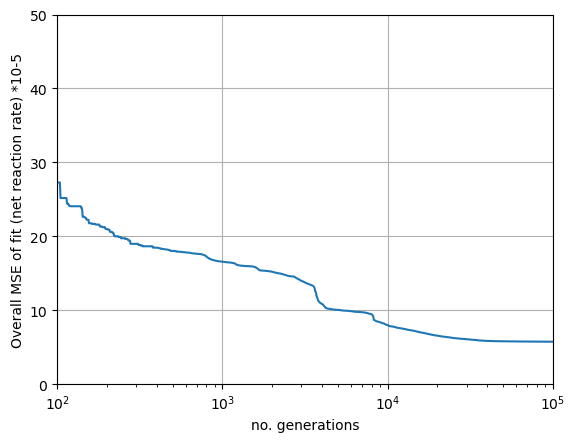

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.881158433849528
1.4198237204359117
0.7340172145209325
-3.8480267904168093
0.42740040438392984
3.079146962180991e-07
0.39032058218022253
-3.9726346895190696
0.2424186551384747
4.114423107392769
3.1122716949253557
3.289918549506293
0.2854109388611888
0.03402641211924843
2.7537752643205486
0.013211555689032557
0.4869900267632676
-10.955306426492355
1.7124846620787264
1.4587932011432359
-8.663594913138011
0.8898167713891005
3.027558546478649
0.1071350710883071
2.658896918057496
2.240058045637448
0.9570590578648862
5.634666382415505
-9.43867482476773
2.4999445979448147
1.4158636831092883
3.1983194548310263
-4.265939315375676
0.5394982454370987
0.9839962385720472
-1.3010299605037088


In [37]:
res.X

array([-1.08811584e+01,  1.41982372e+00,  7.34017215e-01, -3.84802679e+00,
        4.27400404e-01,  3.07914696e-07,  3.90320582e-01, -3.97263469e+00,
        2.42418655e-01,  4.11442311e+00,  3.11227169e+00,  3.28991855e+00,
        2.85410939e-01,  3.40264121e-02,  2.75377526e+00,  1.32115557e-02,
        4.86990027e-01, -1.09553064e+01,  1.71248466e+00,  1.45879320e+00,
       -8.66359491e+00,  8.89816771e-01,  3.02755855e+00,  1.07135071e-01,
        2.65889692e+00,  2.24005805e+00,  9.57059058e-01,  5.63466638e+00,
       -9.43867482e+00,  2.49994460e+00,  1.41586368e+00,  3.19831945e+00,
       -4.26593932e+00,  5.39498245e-01,  9.83996239e-01, -1.30102996e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )


-12.0: -10.881158433849528
1.6: 1.4198237204359117
0.9: 0.7340172145209325
-4.3: -3.8480267904168093
0.5: 0.42740040438392984
0.003: 3.079146962180991e-07
0.4: 0.39032058218022253
-7.9: -3.9726346895190696
0.7: 0.2424186551384747
7.2: 4.114423107392769
5.7: 3.1122716949253557
5.7: 3.289918549506293
0.8: 0.2854109388611888
0.03: 0.03402641211924843
3.1: 2.7537752643205486
6.000000000000001e-09: 0.013211555689032557
0.1: 0.4869900267632676
-12.0: -10.955306426492355
1.9: 1.7124846620787264
1.6: 1.4587932011432359
-11.6: -8.663594913138011
1.2: 0.8898167713891005
4.0: 3.027558546478649
0.01: 0.1071350710883071
4.2: 2.658896918057496
5.4: 2.240058045637448
2.2: 0.9570590578648862
11.8: 5.634666382415505
-12.0: -9.43867482476773
3.3: 2.4999445979448147
1.8: 1.4158636831092883
4.2: 3.1983194548310263
-4.0: -4.265939315375676
0.5: 0.5394982454370987
1.0: 0.9839962385720472
coeff fit: 0.8935193139723578
